In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

In [2]:
%pylab inline
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imsave', 'random', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
%load_ext tensorboard

In [4]:
import tensorboard
tensorboard.__version__

'1.15.0'

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [6]:
DATA_PATH = './aligned_celebA/' # Path to the dataset with celebA faces
Z_DIM = 512 # Dimension of face's manifold
GENERATOR_DENSE_SIZE = 1024 # Length of first tensor in generator

IMAGE_SIZE = 64 # Shapes of input image
BATCH_SIZE = 128 # Batch size
N_CHANNELS = 3 # Number channels of input image

FLIP_LABEL_PROB = .1

In [7]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [8]:
def generator(z, is_training):
    h_out = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_out = batch_norm(name='g_bn0')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h0_lrelu")    
    h_out = tf.reshape(h_out, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 4, 4, GENERATOR_DENSE_SIZE], name='g_h1_deconv', k_h=5, k_w=5, d_h=1, d_w=1, use_bias=False)
    h_out = batch_norm(name='g_bn1')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h1_lrelu")
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 8, 8, 512], name='g_h2_deconv', k_h=5, k_w=5, d_h=2, d_w=2, use_bias=False)
    h_out = batch_norm(name='g_bn2')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h2_lrelu")
        
    h_out = deconv2d(h_out, [BATCH_SIZE, 16, 16, 256], name='g_h3_deconv', k_h=5, k_w=5, d_h=2, d_w=2, use_bias=False)
    h_out = batch_norm(name='g_bn3')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h3_lrelu")
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 32, 32, 128], name='g_h4_deconv', use_bias=False)
    h_out = batch_norm(name='g_bn4')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h4_lrelu")
        
    h_out = deconv2d(h_out, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [41]:
def discriminator(image, is_training, batch_norms=None):
    
    h_out = image
    
    h_out = tf.nn.dropout(h_out, 0.05)
    
    h_out = conv2d(h_out, output_dim = 128, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h0_conv")
    if batch_norms is not None and len(batch_norms) > 0:
        h_out = batch_norms[0](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h0_lrelu")
    h_out = tf.nn.dropout(h_out, 0.3)
    
    h_out = conv2d(h_out, output_dim = 256, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h1_conv")
    if batch_norms is not None and len(batch_norms) > 1:
        h_out = batch_norms[1](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h1_lrelu")
    h_out = tf.nn.dropout(h_out, 0.3)
    
    h_out = conv2d(h_out, output_dim = 512, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h2_conv")
    if batch_norms is not None and len(batch_norms) > 2:
        h_out = batch_norms[2](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h2_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    #h_out = conv2d(h_out, output_dim = 1024, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h3_conv")
    #if batch_norms is not None and len(batch_norms) > 3:
    #    h_out = batch_norms[3](h_out)
    #h_out = lrelu(h_out, leak=0.2, name="d_h3_lrelu")
    #h_out = tf.nn.dropout(h_out, 0.1)
    
    shape = h_out.get_shape().as_list()    
    h_out = tf.reshape(h_out, [-1, np.prod(shape[1:])])
    
    h_out = linear(h_out, 1024*2, 'd_h4_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h4_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = linear(h_out, 1024*2, 'd_h5_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h5_lrelu")
    #h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = linear(h_out, 1024, 'd_h6_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h6_lrelu")
    #h_out = tf.nn.dropout(h_out, 0.1)
    
    linear_out = linear(h_out, 1, 'd_h7_lin')
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [42]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    real_labels = tf.placeholder(tf.float32, shape=[None, 1])
    fake_labels = tf.placeholder(tf.float32, shape=[None, 1])
    
    batch_norms = [   batch_norm(name='d_bn0'),
                      batch_norm(name='d_bn1'),
                      batch_norm(name='d_bn2'),
                      batch_norm(name='d_bn3') ]
    
    D_real, D_real_logits = discriminator(images, is_training, 
                                          batch_norms = None)
    
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training, 
                                          batch_norms = None)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [43]:
d_loss_real = -tf.reduce_mean( tf.log(D_real) * real_labels  )

d_loss_fake = -tf.reduce_mean( tf.log(1. - D_fake) * (1. - fake_labels) )

#d_loss = d_loss_real + d_loss_fake
#d_loss = -tf.reduce_mean( tf.log(D_real) + tf.log(1. - D_fake) )

g_loss = -tf.reduce_mean(tf.log(D_fake))
#g_loss = tf.reduce_mean(tf.log(1. - D_fake))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [44]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]
print("D params:", np.sum([ np.prod(v.get_shape().as_list()) for v in d_vars ]) )

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]
print("G params:", np.sum([ np.prod(v.get_shape().as_list()) for v in g_vars ]) )

LEARNING_RATE = 0.00001 # Learning rate for adam optimizer
BETA = 0.6 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
#d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
#                  .minimize(d_loss, var_list=d_vars)
d_real_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss_real, var_list=d_vars)
d_fake_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss_fake, var_list=d_vars)
# SGD for discriminator 

g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

D params: 77512961
G params: 51868803


Load data:

In [45]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

In [46]:
img = get_image(data[0], IMAGE_SIZE)

In [47]:
np.min(img), np.max(img)

(-1.0, 0.9921568627450981)

In [48]:
img = inverse_transform([img])[0]

In [49]:
img.shape

(64, 64, 3)

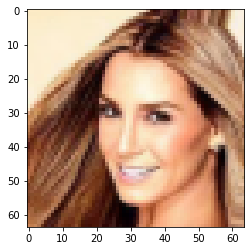

In [50]:
plt.imshow(img)

In [51]:
#with tf.Session() as sess:
#    op = sess.graph.get_operations()
#    for m in op:
#        print( m.values() )

Functions for training and evaluations.

In [52]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [53]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            
            batch = [ get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files ]
            batch_images = np.array(batch).astype(np.float32)
            
            batch_real_labels = np.random.uniform(.7, 1.2, [BATCH_SIZE, 1]).astype(np.float32)            
            batch_fake_labels = np.random.uniform(0., .3, [BATCH_SIZE, 1]).astype(np.float32)
            
            label_flip_choices = np.random.uniform(0., 1., BATCH_SIZE)
            for label_i in range(BATCH_SIZE):
                if label_flip_choices[label_i] < FLIP_LABEL_PROB:
                    batch_real_labels[label_i], batch_fake_labels[label_i] = batch_fake_labels[label_i], batch_real_labels[label_i]
                        
            #batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            batch_z = np.random.normal(size=(BATCH_SIZE, Z_DIM)).astype(np.float32)

            # Update D network
            #sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})
            sess.run(d_real_optim, feed_dict={ images: batch_images, real_labels: batch_real_labels, is_training: True})
            sess.run(d_fake_optim, feed_dict={ z: batch_z, fake_labels: batch_fake_labels, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                #batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
                batch_z = np.random.normal(size=(BATCH_SIZE, Z_DIM)).astype(np.float32)
                sess.run(g_optim, feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, fake_labels: batch_fake_labels, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, real_labels: batch_real_labels, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess,
                           os.path.join(save_dir, '{}_{:02d}_{:04d}'.format(model_name, epoch, idx)))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                print(samples.shape)
                save_images(samples[:25], None, os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)) )
                print("Sample")

In [ ]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint', n_epochs=100, sample_frequency=100, n_generator_update=3, max_to_keep=20)

Epoch: [ 0] [   0/1582] time: 2.1868, d_loss: 2.33124542, g_loss: 0.83438826
Epoch: [ 0] [   1/1582] time: 3.4818, d_loss: 2.17671204, g_loss: 0.72202396
Epoch: [ 0] [   2/1582] time: 4.7737, d_loss: 2.38239717, g_loss: 0.96861428
Epoch: [ 0] [   3/1582] time: 6.0647, d_loss: 2.18908501, g_loss: 0.80648458
Epoch: [ 0] [   4/1582] time: 7.3577, d_loss: 2.21683979, g_loss: 1.01902366
Epoch: [ 0] [   5/1582] time: 8.6487, d_loss: 1.99208701, g_loss: 0.92049074
Epoch: [ 0] [   6/1582] time: 9.9374, d_loss: 2.13772917, g_loss: 0.99754280
Epoch: [ 0] [   7/1582] time: 11.2304, d_loss: 1.99687099, g_loss: 0.81011528
Epoch: [ 0] [   8/1582] time: 12.5195, d_loss: 2.05969715, g_loss: 1.15698707
Epoch: [ 0] [   9/1582] time: 13.8114, d_loss: 2.00777388, g_loss: 0.92759216
Epoch: [ 0] [  10/1582] time: 15.1044, d_loss: 2.07298422, g_loss: 1.03484011
Epoch: [ 0] [  11/1582] time: 16.3955, d_loss: 1.88998485, g_loss: 0.71662796
Epoch: [ 0] [  12/1582] time: 17.6865, d_loss: 1.97825348, g_loss: 0.86

Epoch: [ 0] [ 105/1582] time: 148.2546, d_loss: 1.93529189, g_loss: 0.76016492
Epoch: [ 0] [ 106/1582] time: 149.5496, d_loss: 1.90193844, g_loss: 0.78178453
Epoch: [ 0] [ 107/1582] time: 150.8425, d_loss: 1.86012065, g_loss: 0.75199986
Epoch: [ 0] [ 108/1582] time: 152.1355, d_loss: 1.92147779, g_loss: 0.82942837
Epoch: [ 0] [ 109/1582] time: 153.4335, d_loss: 2.02265549, g_loss: 0.89689714
Epoch: [ 0] [ 110/1582] time: 154.7256, d_loss: 1.89516819, g_loss: 0.91923815
Epoch: [ 0] [ 111/1582] time: 156.0115, d_loss: 2.05234218, g_loss: 0.78556037
Epoch: [ 0] [ 112/1582] time: 157.3068, d_loss: 1.75577545, g_loss: 0.74812627
Epoch: [ 0] [ 113/1582] time: 158.5995, d_loss: 1.72111094, g_loss: 0.67884707
Epoch: [ 0] [ 114/1582] time: 159.8925, d_loss: 1.63220978, g_loss: 0.73414105
Epoch: [ 0] [ 115/1582] time: 161.1814, d_loss: 1.82903290, g_loss: 0.68647236
Epoch: [ 0] [ 116/1582] time: 162.4704, d_loss: 2.09406519, g_loss: 0.83143735
Epoch: [ 0] [ 117/1582] time: 163.7634, d_loss: 1.67

Epoch: [ 0] [ 209/1582] time: 291.4141, d_loss: 1.51494384, g_loss: 0.73415387
Epoch: [ 0] [ 210/1582] time: 292.7061, d_loss: 1.60022676, g_loss: 0.67179668
Epoch: [ 0] [ 211/1582] time: 293.9991, d_loss: 1.55212188, g_loss: 0.81618744
Epoch: [ 0] [ 212/1582] time: 295.2931, d_loss: 1.54472136, g_loss: 0.69359946
Epoch: [ 0] [ 213/1582] time: 296.5841, d_loss: 1.72991455, g_loss: 0.75338191
Epoch: [ 0] [ 214/1582] time: 297.8767, d_loss: 1.71723080, g_loss: 0.74518919
Epoch: [ 0] [ 215/1582] time: 299.1666, d_loss: 1.63643646, g_loss: 0.90486932
Epoch: [ 0] [ 216/1582] time: 300.4569, d_loss: 1.77481449, g_loss: 0.86852896
Epoch: [ 0] [ 217/1582] time: 301.7459, d_loss: 1.69531155, g_loss: 0.84045225
Epoch: [ 0] [ 218/1582] time: 303.0348, d_loss: 1.75962830, g_loss: 0.82106006
Epoch: [ 0] [ 219/1582] time: 304.3248, d_loss: 1.82595396, g_loss: 0.76185727
Epoch: [ 0] [ 220/1582] time: 305.6148, d_loss: 2.08931828, g_loss: 0.75646085
Epoch: [ 0] [ 221/1582] time: 306.9099, d_loss: 1.67

Epoch: [ 0] [ 313/1582] time: 434.2386, d_loss: 1.67960238, g_loss: 0.75191802
Epoch: [ 0] [ 314/1582] time: 435.5305, d_loss: 1.65217292, g_loss: 0.73789018
Epoch: [ 0] [ 315/1582] time: 436.8205, d_loss: 1.66236556, g_loss: 0.66609919
Epoch: [ 0] [ 316/1582] time: 438.1135, d_loss: 1.59170198, g_loss: 0.68385100
Epoch: [ 0] [ 317/1582] time: 439.4048, d_loss: 1.63688707, g_loss: 0.66706628
Epoch: [ 0] [ 318/1582] time: 440.6998, d_loss: 1.59386849, g_loss: 0.64163381
Epoch: [ 0] [ 319/1582] time: 441.9908, d_loss: 1.83940005, g_loss: 0.67564362
Epoch: [ 0] [ 320/1582] time: 443.2828, d_loss: 1.55831814, g_loss: 0.73683727
Epoch: [ 0] [ 321/1582] time: 444.5737, d_loss: 1.65459740, g_loss: 0.65480649
Epoch: [ 0] [ 322/1582] time: 445.8637, d_loss: 1.39206123, g_loss: 0.72411942
Epoch: [ 0] [ 323/1582] time: 447.1557, d_loss: 1.58127022, g_loss: 0.82477283
Epoch: [ 0] [ 324/1582] time: 448.4485, d_loss: 1.74549878, g_loss: 0.70920765
Epoch: [ 0] [ 325/1582] time: 449.7374, d_loss: 1.73

Epoch: [ 0] [ 417/1582] time: 577.4514, d_loss: 1.52055776, g_loss: 0.82374835
Epoch: [ 0] [ 418/1582] time: 578.7444, d_loss: 1.44208491, g_loss: 0.80805540
Epoch: [ 0] [ 419/1582] time: 580.0384, d_loss: 1.49925590, g_loss: 0.68202788
Epoch: [ 0] [ 420/1582] time: 581.3350, d_loss: 1.46302223, g_loss: 0.63326102
Epoch: [ 0] [ 421/1582] time: 582.6390, d_loss: 1.52559566, g_loss: 0.66176581
Epoch: [ 0] [ 422/1582] time: 583.9489, d_loss: 1.55715144, g_loss: 0.68179035
Epoch: [ 0] [ 423/1582] time: 585.2419, d_loss: 1.70564508, g_loss: 0.65722966
Epoch: [ 0] [ 424/1582] time: 586.5339, d_loss: 1.59681296, g_loss: 0.64480317
Epoch: [ 0] [ 425/1582] time: 587.8259, d_loss: 1.48500586, g_loss: 0.75062191
Epoch: [ 0] [ 426/1582] time: 589.1169, d_loss: 1.84398222, g_loss: 0.76017702
Epoch: [ 0] [ 427/1582] time: 590.4107, d_loss: 1.61863565, g_loss: 0.80631888
Epoch: [ 0] [ 428/1582] time: 591.7037, d_loss: 1.51889944, g_loss: 0.71389383
Epoch: [ 0] [ 429/1582] time: 592.9968, d_loss: 1.77

Epoch: [ 0] [ 521/1582] time: 720.4733, d_loss: 1.40337420, g_loss: 0.63819283
Epoch: [ 0] [ 522/1582] time: 721.7693, d_loss: 1.44199896, g_loss: 0.64487541
Epoch: [ 0] [ 523/1582] time: 723.0652, d_loss: 1.29925346, g_loss: 0.65748358
Epoch: [ 0] [ 524/1582] time: 724.3612, d_loss: 1.53483582, g_loss: 0.70418221
Epoch: [ 0] [ 525/1582] time: 725.6571, d_loss: 1.48387098, g_loss: 0.64377868
Epoch: [ 0] [ 526/1582] time: 726.9527, d_loss: 1.66270018, g_loss: 0.66750115
Epoch: [ 0] [ 527/1582] time: 728.2476, d_loss: 1.62405896, g_loss: 0.60232532
Epoch: [ 0] [ 528/1582] time: 729.5434, d_loss: 1.60696161, g_loss: 0.77406180
Epoch: [ 0] [ 529/1582] time: 730.8404, d_loss: 1.48880565, g_loss: 0.69245803
Epoch: [ 0] [ 530/1582] time: 732.1370, d_loss: 1.50628448, g_loss: 0.69377917
Epoch: [ 0] [ 531/1582] time: 733.4308, d_loss: 1.54384029, g_loss: 0.68266797
Epoch: [ 0] [ 532/1582] time: 734.7267, d_loss: 1.49307513, g_loss: 0.62088931
Epoch: [ 0] [ 533/1582] time: 736.0227, d_loss: 1.39

Epoch: [ 0] [ 625/1582] time: 863.5878, d_loss: 1.55989194, g_loss: 0.76203895
Epoch: [ 0] [ 626/1582] time: 864.8850, d_loss: 1.56251872, g_loss: 0.67558330
Epoch: [ 0] [ 627/1582] time: 866.1830, d_loss: 1.48348784, g_loss: 0.65911233
Epoch: [ 0] [ 628/1582] time: 867.4809, d_loss: 1.50109899, g_loss: 0.71288341
Epoch: [ 0] [ 629/1582] time: 868.7799, d_loss: 1.73554218, g_loss: 0.64524049
Epoch: [ 0] [ 630/1582] time: 870.0776, d_loss: 1.73469663, g_loss: 0.70399189
Epoch: [ 0] [ 631/1582] time: 871.3796, d_loss: 1.51889586, g_loss: 0.66584778
Epoch: [ 0] [ 632/1582] time: 872.6756, d_loss: 1.46559763, g_loss: 0.62316513
Epoch: [ 0] [ 633/1582] time: 873.9728, d_loss: 1.52311563, g_loss: 0.63712198
Epoch: [ 0] [ 634/1582] time: 875.2658, d_loss: 1.63466752, g_loss: 0.61126006
Epoch: [ 0] [ 635/1582] time: 876.5603, d_loss: 1.44781709, g_loss: 0.60667259
Epoch: [ 0] [ 636/1582] time: 877.8583, d_loss: 1.43445158, g_loss: 0.65926325
Epoch: [ 0] [ 637/1582] time: 879.1573, d_loss: 1.44

Epoch: [ 0] [ 729/1582] time: 1007.0014, d_loss: 1.41024947, g_loss: 0.64301652
Epoch: [ 0] [ 730/1582] time: 1008.3023, d_loss: 1.42812300, g_loss: 0.65506542
Epoch: [ 0] [ 731/1582] time: 1009.6063, d_loss: 1.61887825, g_loss: 0.65977234
Epoch: [ 0] [ 732/1582] time: 1010.9033, d_loss: 1.39717925, g_loss: 0.64162314
Epoch: [ 0] [ 733/1582] time: 1012.2036, d_loss: 1.34753072, g_loss: 0.64702725
Epoch: [ 0] [ 734/1582] time: 1013.5027, d_loss: 1.52493262, g_loss: 0.75394225
Epoch: [ 0] [ 735/1582] time: 1014.8006, d_loss: 1.50616980, g_loss: 0.76667899
Epoch: [ 0] [ 736/1582] time: 1016.0996, d_loss: 1.41930199, g_loss: 0.62274677
Epoch: [ 0] [ 737/1582] time: 1017.4001, d_loss: 1.54526258, g_loss: 0.69313276
Epoch: [ 0] [ 738/1582] time: 1018.6983, d_loss: 1.34087348, g_loss: 0.66819686
Epoch: [ 0] [ 739/1582] time: 1019.9972, d_loss: 1.40941763, g_loss: 0.72015542
Epoch: [ 0] [ 740/1582] time: 1021.2972, d_loss: 1.49462938, g_loss: 0.64709556
Epoch: [ 0] [ 741/1582] time: 1022.5957,

Epoch: [ 0] [ 831/1582] time: 1147.8425, d_loss: 1.47090888, g_loss: 0.70386446
Epoch: [ 0] [ 832/1582] time: 1149.1415, d_loss: 1.42452002, g_loss: 0.65175301
Epoch: [ 0] [ 833/1582] time: 1150.4385, d_loss: 1.33438039, g_loss: 0.62517405
Epoch: [ 0] [ 834/1582] time: 1151.7345, d_loss: 1.40728366, g_loss: 0.71702874
Epoch: [ 0] [ 835/1582] time: 1153.0304, d_loss: 1.47849011, g_loss: 0.66086590
Epoch: [ 0] [ 836/1582] time: 1154.3284, d_loss: 1.42240000, g_loss: 0.65088201
Epoch: [ 0] [ 837/1582] time: 1155.6284, d_loss: 1.41488171, g_loss: 0.62866765
Epoch: [ 0] [ 838/1582] time: 1156.9294, d_loss: 1.52061403, g_loss: 0.62731284
Epoch: [ 0] [ 839/1582] time: 1158.2304, d_loss: 1.43736672, g_loss: 0.66406709
Epoch: [ 0] [ 840/1582] time: 1159.5294, d_loss: 1.47432470, g_loss: 0.70891333
Epoch: [ 0] [ 841/1582] time: 1160.8284, d_loss: 1.34193659, g_loss: 0.64813465
Epoch: [ 0] [ 842/1582] time: 1162.1274, d_loss: 1.34591246, g_loss: 0.70875657
Epoch: [ 0] [ 843/1582] time: 1163.4274,

Epoch: [ 0] [ 933/1582] time: 1288.6697, d_loss: 1.52603507, g_loss: 0.72999066
Epoch: [ 0] [ 934/1582] time: 1289.9704, d_loss: 1.60314500, g_loss: 0.63930219
Epoch: [ 0] [ 935/1582] time: 1291.2693, d_loss: 1.43445325, g_loss: 0.69026864
Epoch: [ 0] [ 936/1582] time: 1292.5740, d_loss: 1.51033914, g_loss: 0.65583545
Epoch: [ 0] [ 937/1582] time: 1293.8750, d_loss: 1.55743861, g_loss: 0.60056388
Epoch: [ 0] [ 938/1582] time: 1295.1730, d_loss: 1.52481127, g_loss: 0.71161604
Epoch: [ 0] [ 939/1582] time: 1296.4715, d_loss: 1.53588200, g_loss: 0.65509856
Epoch: [ 0] [ 940/1582] time: 1297.7705, d_loss: 1.52322567, g_loss: 0.61114085
Epoch: [ 0] [ 941/1582] time: 1299.0704, d_loss: 1.60086894, g_loss: 0.60525227
Epoch: [ 0] [ 942/1582] time: 1300.3684, d_loss: 1.53783643, g_loss: 0.61525923
Epoch: [ 0] [ 943/1582] time: 1301.6764, d_loss: 1.56935418, g_loss: 0.64591622
Epoch: [ 0] [ 944/1582] time: 1302.9774, d_loss: 1.44250298, g_loss: 0.69170308
Epoch: [ 0] [ 945/1582] time: 1304.2853,

Epoch: [ 0] [1035/1582] time: 1429.7142, d_loss: 1.58805299, g_loss: 0.61641359
Epoch: [ 0] [1036/1582] time: 1431.0168, d_loss: 1.47138333, g_loss: 0.62816554
Epoch: [ 0] [1037/1582] time: 1432.3188, d_loss: 1.34044993, g_loss: 0.66313231
Epoch: [ 0] [1038/1582] time: 1433.6208, d_loss: 1.51879954, g_loss: 0.67383313
Epoch: [ 0] [1039/1582] time: 1434.9217, d_loss: 1.56436062, g_loss: 0.64045036
Epoch: [ 0] [1040/1582] time: 1436.2233, d_loss: 1.33966565, g_loss: 0.64924419
Epoch: [ 0] [1041/1582] time: 1437.5243, d_loss: 1.47961581, g_loss: 0.66294670
Epoch: [ 0] [1042/1582] time: 1438.8236, d_loss: 1.28365147, g_loss: 0.68292093
Epoch: [ 0] [1043/1582] time: 1440.1256, d_loss: 1.54994023, g_loss: 0.64962023
Epoch: [ 0] [1044/1582] time: 1441.4286, d_loss: 1.45862222, g_loss: 0.70458150
Epoch: [ 0] [1045/1582] time: 1442.7256, d_loss: 1.36667418, g_loss: 0.64130902
Epoch: [ 0] [1046/1582] time: 1444.0265, d_loss: 1.41168571, g_loss: 0.69140851
Epoch: [ 0] [1047/1582] time: 1445.3294,

Epoch: [ 0] [1137/1582] time: 1571.1852, d_loss: 1.56995690, g_loss: 0.68119967
Epoch: [ 0] [1138/1582] time: 1572.4872, d_loss: 1.42931283, g_loss: 0.67759275
Epoch: [ 0] [1139/1582] time: 1573.7902, d_loss: 1.55989623, g_loss: 0.67284155
Epoch: [ 0] [1140/1582] time: 1575.0922, d_loss: 1.43292582, g_loss: 0.62005937
Epoch: [ 0] [1141/1582] time: 1576.3942, d_loss: 1.41648829, g_loss: 0.66857183
Epoch: [ 0] [1142/1582] time: 1577.6953, d_loss: 1.42520738, g_loss: 0.62750679
Epoch: [ 0] [1143/1582] time: 1578.9993, d_loss: 1.36619318, g_loss: 0.70726109
Epoch: [ 0] [1144/1582] time: 1580.3022, d_loss: 1.39489651, g_loss: 0.65534264
Epoch: [ 0] [1145/1582] time: 1581.6045, d_loss: 1.38961947, g_loss: 0.60850424
Epoch: [ 0] [1146/1582] time: 1582.9045, d_loss: 1.41563487, g_loss: 0.60278952
Epoch: [ 0] [1147/1582] time: 1584.2054, d_loss: 1.41405404, g_loss: 0.70665103
Epoch: [ 0] [1148/1582] time: 1585.5076, d_loss: 1.34718120, g_loss: 0.72881681
Epoch: [ 0] [1149/1582] time: 1586.8106,

Epoch: [ 0] [1239/1582] time: 1712.3235, d_loss: 1.54176593, g_loss: 0.69212043
Epoch: [ 0] [1240/1582] time: 1713.6264, d_loss: 1.28412461, g_loss: 0.68168777
Epoch: [ 0] [1241/1582] time: 1714.9264, d_loss: 1.42341793, g_loss: 0.63455099
Epoch: [ 0] [1242/1582] time: 1716.2294, d_loss: 1.41123509, g_loss: 0.73207700
Epoch: [ 0] [1243/1582] time: 1717.5345, d_loss: 1.53029275, g_loss: 0.64641726
Epoch: [ 0] [1244/1582] time: 1718.8404, d_loss: 1.51832867, g_loss: 0.65896118
Epoch: [ 0] [1245/1582] time: 1720.1444, d_loss: 1.46621978, g_loss: 0.63337541
Epoch: [ 0] [1246/1582] time: 1721.4494, d_loss: 1.43840015, g_loss: 0.63844776
Epoch: [ 0] [1247/1582] time: 1722.7546, d_loss: 1.38281441, g_loss: 0.66110784
Epoch: [ 0] [1248/1582] time: 1724.0596, d_loss: 1.42945492, g_loss: 0.65770769
Epoch: [ 0] [1249/1582] time: 1725.3596, d_loss: 1.47122407, g_loss: 0.63958913
Epoch: [ 0] [1250/1582] time: 1726.6627, d_loss: 1.41171002, g_loss: 0.64558178
Epoch: [ 0] [1251/1582] time: 1727.9649,

Epoch: [ 0] [1341/1582] time: 1853.4848, d_loss: 1.36010838, g_loss: 0.64836460
Epoch: [ 0] [1342/1582] time: 1854.7818, d_loss: 1.55941403, g_loss: 0.71310186
Epoch: [ 0] [1343/1582] time: 1856.0827, d_loss: 1.39093876, g_loss: 0.66660404
Epoch: [ 0] [1344/1582] time: 1857.3843, d_loss: 1.38314688, g_loss: 0.67479646
Epoch: [ 0] [1345/1582] time: 1858.6842, d_loss: 1.29845214, g_loss: 0.66701865
Epoch: [ 0] [1346/1582] time: 1859.9862, d_loss: 1.50021982, g_loss: 0.60966694
Epoch: [ 0] [1347/1582] time: 1861.2888, d_loss: 1.54439378, g_loss: 0.60816872
Epoch: [ 0] [1348/1582] time: 1862.5930, d_loss: 1.45114923, g_loss: 0.60017407
Epoch: [ 0] [1349/1582] time: 1863.8930, d_loss: 1.44747782, g_loss: 0.64918941
Epoch: [ 0] [1350/1582] time: 1865.1979, d_loss: 1.34163117, g_loss: 0.70268923
Epoch: [ 0] [1351/1582] time: 1866.4999, d_loss: 1.38350964, g_loss: 0.69398642
Epoch: [ 0] [1352/1582] time: 1867.8059, d_loss: 1.40135074, g_loss: 0.63387620
Epoch: [ 0] [1353/1582] time: 1869.1089,

Epoch: [ 0] [1443/1582] time: 1994.7577, d_loss: 1.45612133, g_loss: 0.68670297
Epoch: [ 0] [1444/1582] time: 1996.0667, d_loss: 1.49260283, g_loss: 0.63108903
Epoch: [ 0] [1445/1582] time: 1997.3687, d_loss: 1.32537031, g_loss: 0.65206611
Epoch: [ 0] [1446/1582] time: 1998.6697, d_loss: 1.37957346, g_loss: 0.67011267
Epoch: [ 0] [1447/1582] time: 1999.9751, d_loss: 1.51685810, g_loss: 0.61607158
Epoch: [ 0] [1448/1582] time: 2001.2816, d_loss: 1.36645889, g_loss: 0.69673061
Epoch: [ 0] [1449/1582] time: 2002.5871, d_loss: 1.43785107, g_loss: 0.62137979
Epoch: [ 0] [1450/1582] time: 2003.8931, d_loss: 1.48826766, g_loss: 0.71342564
Epoch: [ 0] [1451/1582] time: 2005.1978, d_loss: 1.41387749, g_loss: 0.62967497
Epoch: [ 0] [1452/1582] time: 2006.5047, d_loss: 1.34496081, g_loss: 0.64171875
Epoch: [ 0] [1453/1582] time: 2007.8077, d_loss: 1.37844634, g_loss: 0.71475947
Epoch: [ 0] [1454/1582] time: 2009.1097, d_loss: 1.38511133, g_loss: 0.70759737
Epoch: [ 0] [1455/1582] time: 2010.4107,

Epoch: [ 0] [1545/1582] time: 2136.5571, d_loss: 1.54486692, g_loss: 0.67192912
Epoch: [ 0] [1546/1582] time: 2137.8551, d_loss: 1.38940418, g_loss: 0.64411736
Epoch: [ 0] [1547/1582] time: 2139.1531, d_loss: 1.49992180, g_loss: 0.63667804
Epoch: [ 0] [1548/1582] time: 2140.4515, d_loss: 1.39704299, g_loss: 0.53191543
Epoch: [ 0] [1549/1582] time: 2141.7499, d_loss: 1.41512334, g_loss: 0.68574882
Epoch: [ 0] [1550/1582] time: 2143.0509, d_loss: 1.39578295, g_loss: 0.60831994
Epoch: [ 0] [1551/1582] time: 2144.3518, d_loss: 1.34739363, g_loss: 0.65054464
Epoch: [ 0] [1552/1582] time: 2145.6478, d_loss: 1.40301204, g_loss: 0.68378067
Epoch: [ 0] [1553/1582] time: 2146.9448, d_loss: 1.27778196, g_loss: 0.65456247
Epoch: [ 0] [1554/1582] time: 2148.2418, d_loss: 1.39162469, g_loss: 0.59873927
Epoch: [ 0] [1555/1582] time: 2149.5478, d_loss: 1.41772997, g_loss: 0.66145009
Epoch: [ 0] [1556/1582] time: 2150.8488, d_loss: 1.34563637, g_loss: 0.68984836
Epoch: [ 0] [1557/1582] time: 2152.1478,

Epoch: [ 1] [  65/1582] time: 2277.4558, d_loss: 1.44562662, g_loss: 0.68696243
Epoch: [ 1] [  66/1582] time: 2278.7583, d_loss: 1.42042005, g_loss: 0.66582167
Epoch: [ 1] [  67/1582] time: 2280.0583, d_loss: 1.44308245, g_loss: 0.60692966
Epoch: [ 1] [  68/1582] time: 2281.3615, d_loss: 1.25871801, g_loss: 0.67080146
Epoch: [ 1] [  69/1582] time: 2282.6615, d_loss: 1.35149884, g_loss: 0.63290447
Epoch: [ 1] [  70/1582] time: 2283.9655, d_loss: 1.41921616, g_loss: 0.62373656
Epoch: [ 1] [  71/1582] time: 2285.2645, d_loss: 1.35153484, g_loss: 0.65012360
Epoch: [ 1] [  72/1582] time: 2286.5664, d_loss: 1.36070514, g_loss: 0.64566529
Epoch: [ 1] [  73/1582] time: 2287.8724, d_loss: 1.38627410, g_loss: 0.59009528
Epoch: [ 1] [  74/1582] time: 2289.1724, d_loss: 1.22477412, g_loss: 0.65270895
Epoch: [ 1] [  75/1582] time: 2290.4734, d_loss: 1.37038445, g_loss: 0.72965062
Epoch: [ 1] [  76/1582] time: 2291.7725, d_loss: 1.34730041, g_loss: 0.65704501
Epoch: [ 1] [  77/1582] time: 2293.0695,

Epoch: [ 1] [ 167/1582] time: 2418.6009, d_loss: 1.37465167, g_loss: 0.62021738
Epoch: [ 1] [ 168/1582] time: 2419.9039, d_loss: 1.38446224, g_loss: 0.67595613
Epoch: [ 1] [ 169/1582] time: 2421.2060, d_loss: 1.39253855, g_loss: 0.66450977
Epoch: [ 1] [ 170/1582] time: 2422.5060, d_loss: 1.35389614, g_loss: 0.64796281
Epoch: [ 1] [ 171/1582] time: 2423.8060, d_loss: 1.32761550, g_loss: 0.60598528
Epoch: [ 1] [ 172/1582] time: 2425.1081, d_loss: 1.40115047, g_loss: 0.66400635
Epoch: [ 1] [ 173/1582] time: 2426.4111, d_loss: 1.27791846, g_loss: 0.61882424
Epoch: [ 1] [ 174/1582] time: 2427.7131, d_loss: 1.49247813, g_loss: 0.63613558
Epoch: [ 1] [ 175/1582] time: 2429.0161, d_loss: 1.45814323, g_loss: 0.66465104
Epoch: [ 1] [ 176/1582] time: 2430.3176, d_loss: 1.37348330, g_loss: 0.69639087
Epoch: [ 1] [ 177/1582] time: 2431.6136, d_loss: 1.56636643, g_loss: 0.65436721
Epoch: [ 1] [ 178/1582] time: 2432.9176, d_loss: 1.48193824, g_loss: 0.65297008
Epoch: [ 1] [ 179/1582] time: 2434.2175,

Epoch: [ 1] [ 269/1582] time: 2559.5142, d_loss: 1.33389652, g_loss: 0.68901443
Epoch: [ 1] [ 270/1582] time: 2560.8152, d_loss: 1.51880026, g_loss: 0.64925516
Epoch: [ 1] [ 271/1582] time: 2562.1162, d_loss: 1.33418345, g_loss: 0.65354347
Epoch: [ 1] [ 272/1582] time: 2563.4161, d_loss: 1.34939408, g_loss: 0.70689976
Epoch: [ 1] [ 273/1582] time: 2564.7183, d_loss: 1.24821115, g_loss: 0.62580323
Epoch: [ 1] [ 274/1582] time: 2566.0222, d_loss: 1.33796406, g_loss: 0.67726320
Epoch: [ 1] [ 275/1582] time: 2567.3262, d_loss: 1.42658246, g_loss: 0.70242232
Epoch: [ 1] [ 276/1582] time: 2568.6303, d_loss: 1.50141811, g_loss: 0.61118931
Epoch: [ 1] [ 277/1582] time: 2569.9323, d_loss: 1.38435054, g_loss: 0.66040272
Epoch: [ 1] [ 278/1582] time: 2571.2355, d_loss: 1.37994063, g_loss: 0.70178413
Epoch: [ 1] [ 279/1582] time: 2572.5345, d_loss: 1.46584415, g_loss: 0.60227448
Epoch: [ 1] [ 280/1582] time: 2573.8335, d_loss: 1.33719492, g_loss: 0.63989532
Epoch: [ 1] [ 281/1582] time: 2575.1315,

Epoch: [ 1] [ 371/1582] time: 2700.4692, d_loss: 1.20871401, g_loss: 0.61720186
Epoch: [ 1] [ 372/1582] time: 2701.7681, d_loss: 1.36583281, g_loss: 0.61717910
Epoch: [ 1] [ 373/1582] time: 2703.0681, d_loss: 1.29917002, g_loss: 0.64750576
Epoch: [ 1] [ 374/1582] time: 2704.3681, d_loss: 1.37184107, g_loss: 0.55607778
Epoch: [ 1] [ 375/1582] time: 2705.6661, d_loss: 1.40731812, g_loss: 0.65657157
Epoch: [ 1] [ 376/1582] time: 2706.9650, d_loss: 1.35827708, g_loss: 0.63707399
Epoch: [ 1] [ 377/1582] time: 2708.2610, d_loss: 1.33204532, g_loss: 0.64465052
Epoch: [ 1] [ 378/1582] time: 2709.5638, d_loss: 1.41269600, g_loss: 0.63842970
Epoch: [ 1] [ 379/1582] time: 2710.8648, d_loss: 1.38712204, g_loss: 0.66874111
Epoch: [ 1] [ 380/1582] time: 2712.1647, d_loss: 1.31405616, g_loss: 0.67213678
Epoch: [ 1] [ 381/1582] time: 2713.4637, d_loss: 1.30831981, g_loss: 0.66194642
Epoch: [ 1] [ 382/1582] time: 2714.7647, d_loss: 1.31725645, g_loss: 0.66428614
Epoch: [ 1] [ 383/1582] time: 2716.0617,

Epoch: [ 1] [ 473/1582] time: 2841.5054, d_loss: 1.32811522, g_loss: 0.71735466
Epoch: [ 1] [ 474/1582] time: 2842.8074, d_loss: 1.31964397, g_loss: 0.68689638
Epoch: [ 1] [ 475/1582] time: 2844.1074, d_loss: 1.34399343, g_loss: 0.60663259
Epoch: [ 1] [ 476/1582] time: 2845.4084, d_loss: 1.40900540, g_loss: 0.63033032
Epoch: [ 1] [ 477/1582] time: 2846.7083, d_loss: 1.31037557, g_loss: 0.62394524
Epoch: [ 1] [ 478/1582] time: 2848.0088, d_loss: 1.35297012, g_loss: 0.58417177
Epoch: [ 1] [ 479/1582] time: 2849.3078, d_loss: 1.40408456, g_loss: 0.61399001
Epoch: [ 1] [ 480/1582] time: 2850.6078, d_loss: 1.44582486, g_loss: 0.59948766
Epoch: [ 1] [ 481/1582] time: 2851.9098, d_loss: 1.34381056, g_loss: 0.65234870
Epoch: [ 1] [ 482/1582] time: 2853.2128, d_loss: 1.19565940, g_loss: 0.64958549
Epoch: [ 1] [ 483/1582] time: 2854.5160, d_loss: 1.33382702, g_loss: 0.63604873
Epoch: [ 1] [ 484/1582] time: 2855.8199, d_loss: 1.30093527, g_loss: 0.61040610
Epoch: [ 1] [ 485/1582] time: 2857.1191,

Epoch: [ 1] [ 571/1582] time: 2977.9851, d_loss: 1.37795591, g_loss: 0.62904370
Epoch: [ 1] [ 572/1582] time: 2979.2893, d_loss: 1.33627605, g_loss: 0.65844768
Epoch: [ 1] [ 573/1582] time: 2980.5922, d_loss: 1.40369225, g_loss: 0.63796294
Epoch: [ 1] [ 574/1582] time: 2981.8966, d_loss: 1.37506139, g_loss: 0.63987327
Epoch: [ 1] [ 575/1582] time: 2983.1946, d_loss: 1.41768146, g_loss: 0.65799350
Epoch: [ 1] [ 576/1582] time: 2984.5039, d_loss: 1.33244014, g_loss: 0.71358955
Epoch: [ 1] [ 577/1582] time: 2985.8029, d_loss: 1.41816187, g_loss: 0.69535589
Epoch: [ 1] [ 578/1582] time: 2987.1069, d_loss: 1.37406588, g_loss: 0.67729211
Epoch: [ 1] [ 579/1582] time: 2988.4089, d_loss: 1.44191420, g_loss: 0.63463801
Epoch: [ 1] [ 580/1582] time: 2989.7143, d_loss: 1.43190384, g_loss: 0.61831897
Epoch: [ 1] [ 581/1582] time: 2991.0173, d_loss: 1.33739924, g_loss: 0.61052859
Epoch: [ 1] [ 582/1582] time: 2992.3234, d_loss: 1.29991448, g_loss: 0.64599031
Epoch: [ 1] [ 583/1582] time: 2993.6254,

Epoch: [ 1] [ 673/1582] time: 3119.2979, d_loss: 1.17667508, g_loss: 0.60859156
Epoch: [ 1] [ 674/1582] time: 3120.6056, d_loss: 1.25389731, g_loss: 0.60705793
Epoch: [ 1] [ 675/1582] time: 3121.9086, d_loss: 1.24276698, g_loss: 0.60835117
Epoch: [ 1] [ 676/1582] time: 3123.2136, d_loss: 1.31859517, g_loss: 0.66749406
Epoch: [ 1] [ 677/1582] time: 3124.5155, d_loss: 1.34452820, g_loss: 0.66592169
Epoch: [ 1] [ 678/1582] time: 3125.8205, d_loss: 1.26738358, g_loss: 0.60193110
Epoch: [ 1] [ 679/1582] time: 3127.1245, d_loss: 1.25262558, g_loss: 0.63142550
Epoch: [ 1] [ 680/1582] time: 3128.4297, d_loss: 1.21666884, g_loss: 0.65817750
Epoch: [ 1] [ 681/1582] time: 3129.7317, d_loss: 1.29292297, g_loss: 0.66627234
Epoch: [ 1] [ 682/1582] time: 3131.0387, d_loss: 1.20672703, g_loss: 0.64999193
Epoch: [ 1] [ 683/1582] time: 3132.3416, d_loss: 1.32500553, g_loss: 0.70734012
Epoch: [ 1] [ 684/1582] time: 3133.6436, d_loss: 1.28188586, g_loss: 0.63435072
Epoch: [ 1] [ 685/1582] time: 3134.9466,

Epoch: [ 1] [ 775/1582] time: 3260.9161, d_loss: 1.34068573, g_loss: 0.65447414
Epoch: [ 1] [ 776/1582] time: 3262.2220, d_loss: 1.33185279, g_loss: 0.63117325
Epoch: [ 1] [ 777/1582] time: 3263.5240, d_loss: 1.36452889, g_loss: 0.64490855
Epoch: [ 1] [ 778/1582] time: 3264.8260, d_loss: 1.32603931, g_loss: 0.70369482
Epoch: [ 1] [ 779/1582] time: 3266.1279, d_loss: 1.34170532, g_loss: 0.67411470
Epoch: [ 1] [ 780/1582] time: 3267.4299, d_loss: 1.28238070, g_loss: 0.67876732
Epoch: [ 1] [ 781/1582] time: 3268.7319, d_loss: 1.25247097, g_loss: 0.65789890
Epoch: [ 1] [ 782/1582] time: 3270.0325, d_loss: 1.31153190, g_loss: 0.67338914
Epoch: [ 1] [ 783/1582] time: 3271.3305, d_loss: 1.43660307, g_loss: 0.60399485
Epoch: [ 1] [ 784/1582] time: 3272.6347, d_loss: 1.31135333, g_loss: 0.67224091
Epoch: [ 1] [ 785/1582] time: 3273.9387, d_loss: 1.23644066, g_loss: 0.67184019
Epoch: [ 1] [ 786/1582] time: 3275.2436, d_loss: 1.29228425, g_loss: 0.63458049
Epoch: [ 1] [ 787/1582] time: 3276.5446,

Epoch: [ 1] [ 877/1582] time: 3402.4834, d_loss: 1.36799264, g_loss: 0.72638178
Epoch: [ 1] [ 878/1582] time: 3403.7884, d_loss: 1.24143791, g_loss: 0.64890301
Epoch: [ 1] [ 879/1582] time: 3405.0923, d_loss: 1.26583922, g_loss: 0.68567693
Epoch: [ 1] [ 880/1582] time: 3406.3983, d_loss: 1.42327154, g_loss: 0.62089485
Epoch: [ 1] [ 881/1582] time: 3407.7013, d_loss: 1.30935681, g_loss: 0.61315477
Epoch: [ 1] [ 882/1582] time: 3409.0063, d_loss: 1.20795667, g_loss: 0.64064407
Epoch: [ 1] [ 883/1582] time: 3410.3092, d_loss: 1.39047408, g_loss: 0.70432568
Epoch: [ 1] [ 884/1582] time: 3411.6132, d_loss: 1.35299826, g_loss: 0.66265255
Epoch: [ 1] [ 885/1582] time: 3412.9182, d_loss: 1.38244617, g_loss: 0.64665210
Epoch: [ 1] [ 886/1582] time: 3414.2222, d_loss: 1.27644396, g_loss: 0.61811101
Epoch: [ 1] [ 887/1582] time: 3415.5252, d_loss: 1.32516623, g_loss: 0.64224732
Epoch: [ 1] [ 888/1582] time: 3416.8291, d_loss: 1.24358821, g_loss: 0.60648882
Epoch: [ 1] [ 889/1582] time: 3418.1321,

Epoch: [ 1] [ 979/1582] time: 3544.1772, d_loss: 1.24631417, g_loss: 0.69701505
Epoch: [ 1] [ 980/1582] time: 3545.4847, d_loss: 1.27221537, g_loss: 0.64889359
Epoch: [ 1] [ 981/1582] time: 3546.7937, d_loss: 1.21268439, g_loss: 0.65504724
Epoch: [ 1] [ 982/1582] time: 3548.0991, d_loss: 1.33010185, g_loss: 0.66730118
Epoch: [ 1] [ 983/1582] time: 3549.4041, d_loss: 1.28083813, g_loss: 0.64864898
Epoch: [ 1] [ 984/1582] time: 3550.7101, d_loss: 1.33451581, g_loss: 0.66204798
Epoch: [ 1] [ 985/1582] time: 3552.0140, d_loss: 1.35046840, g_loss: 0.62476385
Epoch: [ 1] [ 986/1582] time: 3553.3210, d_loss: 1.34235454, g_loss: 0.66204005
Epoch: [ 1] [ 987/1582] time: 3554.6280, d_loss: 1.35029590, g_loss: 0.67966771
Epoch: [ 1] [ 988/1582] time: 3555.9350, d_loss: 1.25667143, g_loss: 0.63948601
Epoch: [ 1] [ 989/1582] time: 3557.2415, d_loss: 1.24637532, g_loss: 0.62051916
Epoch: [ 1] [ 990/1582] time: 3558.5475, d_loss: 1.30767643, g_loss: 0.62514436
Epoch: [ 1] [ 991/1582] time: 3559.8495,

Epoch: [ 1] [1081/1582] time: 3685.8239, d_loss: 1.41588426, g_loss: 0.69149017
Epoch: [ 1] [1082/1582] time: 3687.1315, d_loss: 1.30567324, g_loss: 0.61365473
Epoch: [ 1] [1083/1582] time: 3688.4375, d_loss: 1.32964635, g_loss: 0.59727526
Epoch: [ 1] [1084/1582] time: 3689.7433, d_loss: 1.31268299, g_loss: 0.61600971
Epoch: [ 1] [1085/1582] time: 3691.0478, d_loss: 1.22300100, g_loss: 0.58517909
Epoch: [ 1] [1086/1582] time: 3692.3544, d_loss: 1.24077022, g_loss: 0.64505506
Epoch: [ 1] [1087/1582] time: 3693.6584, d_loss: 1.21200705, g_loss: 0.63506281
Epoch: [ 1] [1088/1582] time: 3694.9654, d_loss: 1.27039886, g_loss: 0.62091267
Epoch: [ 1] [1089/1582] time: 3696.2683, d_loss: 1.38275766, g_loss: 0.69112480
Epoch: [ 1] [1090/1582] time: 3697.5753, d_loss: 1.20027018, g_loss: 0.63976610
Epoch: [ 1] [1091/1582] time: 3698.8803, d_loss: 1.23566258, g_loss: 0.67945147
Epoch: [ 1] [1092/1582] time: 3700.1873, d_loss: 1.32565987, g_loss: 0.64171112
Epoch: [ 1] [1093/1582] time: 3701.4903,

Epoch: [ 1] [1183/1582] time: 3827.4335, d_loss: 1.18360686, g_loss: 0.65658617
Epoch: [ 1] [1184/1582] time: 3828.7401, d_loss: 1.28932309, g_loss: 0.66647416
Epoch: [ 1] [1185/1582] time: 3830.0437, d_loss: 1.33708870, g_loss: 0.68450725
Epoch: [ 1] [1186/1582] time: 3831.3487, d_loss: 1.23530722, g_loss: 0.63505828
Epoch: [ 1] [1187/1582] time: 3832.6525, d_loss: 1.22709036, g_loss: 0.65257293
Epoch: [ 1] [1188/1582] time: 3833.9599, d_loss: 1.21976745, g_loss: 0.65217626
Epoch: [ 1] [1189/1582] time: 3835.2609, d_loss: 1.21529579, g_loss: 0.66853172
Epoch: [ 1] [1190/1582] time: 3836.5648, d_loss: 1.32754338, g_loss: 0.69944334
Epoch: [ 1] [1191/1582] time: 3837.8678, d_loss: 1.24352574, g_loss: 0.66164905
Epoch: [ 1] [1192/1582] time: 3839.1735, d_loss: 1.33358824, g_loss: 0.69163287
Epoch: [ 1] [1193/1582] time: 3840.4748, d_loss: 1.25256038, g_loss: 0.66631174
Epoch: [ 1] [1194/1582] time: 3841.7798, d_loss: 1.32684469, g_loss: 0.63422203
Epoch: [ 1] [1195/1582] time: 3843.0827,

Epoch: [ 1] [1285/1582] time: 3968.8892, d_loss: 1.27414536, g_loss: 0.65618885
Epoch: [ 1] [1286/1582] time: 3970.1912, d_loss: 1.30673087, g_loss: 0.62472403
Epoch: [ 1] [1287/1582] time: 3971.4932, d_loss: 1.31942308, g_loss: 0.67271352
Epoch: [ 1] [1288/1582] time: 3972.7952, d_loss: 1.26917851, g_loss: 0.67656279
Epoch: [ 1] [1289/1582] time: 3974.0971, d_loss: 1.27318597, g_loss: 0.67291349
Epoch: [ 1] [1290/1582] time: 3975.4001, d_loss: 1.36274362, g_loss: 0.68001723
Epoch: [ 1] [1291/1582] time: 3976.7011, d_loss: 1.15251899, g_loss: 0.63299239
Epoch: [ 1] [1292/1582] time: 3978.0060, d_loss: 1.37009704, g_loss: 0.66211045
Epoch: [ 1] [1293/1582] time: 3979.3102, d_loss: 1.26135504, g_loss: 0.66085541
Epoch: [ 1] [1294/1582] time: 3980.6133, d_loss: 1.42392802, g_loss: 0.67854351
Epoch: [ 1] [1295/1582] time: 3981.9133, d_loss: 1.22281551, g_loss: 0.66918457
Epoch: [ 1] [1296/1582] time: 3983.2183, d_loss: 1.28755558, g_loss: 0.67547715
Epoch: [ 1] [1297/1582] time: 3984.5222,

Epoch: [ 1] [1387/1582] time: 4110.8965, d_loss: 1.24454236, g_loss: 0.64374977
Epoch: [ 1] [1388/1582] time: 4112.1957, d_loss: 1.32535458, g_loss: 0.69076812
Epoch: [ 1] [1389/1582] time: 4113.5046, d_loss: 1.27866220, g_loss: 0.65213996
Epoch: [ 1] [1390/1582] time: 4114.8116, d_loss: 1.29201531, g_loss: 0.67979121
Epoch: [ 1] [1391/1582] time: 4116.1186, d_loss: 1.29857993, g_loss: 0.64532447
Epoch: [ 1] [1392/1582] time: 4117.4236, d_loss: 1.27796388, g_loss: 0.63259506
Epoch: [ 1] [1393/1582] time: 4118.7306, d_loss: 1.33266628, g_loss: 0.66325623
Epoch: [ 1] [1394/1582] time: 4120.0350, d_loss: 1.14527345, g_loss: 0.64364070
Epoch: [ 1] [1395/1582] time: 4121.3380, d_loss: 1.25113654, g_loss: 0.66492617
Epoch: [ 1] [1396/1582] time: 4122.6400, d_loss: 1.22159219, g_loss: 0.63295901
Epoch: [ 1] [1397/1582] time: 4123.9379, d_loss: 1.29513073, g_loss: 0.69561756
Epoch: [ 1] [1398/1582] time: 4125.2389, d_loss: 1.29248726, g_loss: 0.67693549
Epoch: [ 1] [1399/1582] time: 4126.5389,

Epoch: [ 1] [1489/1582] time: 4252.1490, d_loss: 1.33058155, g_loss: 0.63365602
Epoch: [ 1] [1490/1582] time: 4253.4549, d_loss: 1.22658038, g_loss: 0.67025840
Epoch: [ 1] [1491/1582] time: 4254.7599, d_loss: 1.22716045, g_loss: 0.68281209
Epoch: [ 1] [1492/1582] time: 4256.0629, d_loss: 1.19625020, g_loss: 0.69036674
Epoch: [ 1] [1493/1582] time: 4257.3677, d_loss: 1.19052076, g_loss: 0.65064013
Epoch: [ 1] [1494/1582] time: 4258.6707, d_loss: 1.34721994, g_loss: 0.69516450
Epoch: [ 1] [1495/1582] time: 4259.9747, d_loss: 1.15927887, g_loss: 0.64322102
Epoch: [ 1] [1496/1582] time: 4261.2856, d_loss: 1.24330628, g_loss: 0.60448778
Epoch: [ 1] [1497/1582] time: 4262.6052, d_loss: 1.22696972, g_loss: 0.69976366
Epoch: [ 1] [1498/1582] time: 4263.9082, d_loss: 1.24792063, g_loss: 0.67520928
Epoch: [ 1] [1499/1582] time: 4265.2141, d_loss: 1.32261419, g_loss: 0.66072589
Epoch: [ 1] [1500/1582] time: 4266.5201, d_loss: 1.33633947, g_loss: 0.60765576
Epoch: [ 1] [1501/1582] time: 4267.8251,

Epoch: [ 2] [   9/1582] time: 4393.6051, d_loss: 1.32808161, g_loss: 0.66910261
Epoch: [ 2] [  10/1582] time: 4394.9120, d_loss: 1.30647969, g_loss: 0.65658188
Epoch: [ 2] [  11/1582] time: 4396.2163, d_loss: 1.22586417, g_loss: 0.68333495
Epoch: [ 2] [  12/1582] time: 4397.5212, d_loss: 1.17389667, g_loss: 0.73465353
Epoch: [ 2] [  13/1582] time: 4398.8258, d_loss: 1.28343523, g_loss: 0.65265393
Epoch: [ 2] [  14/1582] time: 4400.1315, d_loss: 1.25540590, g_loss: 0.63766968
Epoch: [ 2] [  15/1582] time: 4401.4394, d_loss: 1.23686934, g_loss: 0.63513458
Epoch: [ 2] [  16/1582] time: 4402.7444, d_loss: 1.26347947, g_loss: 0.67943382
Epoch: [ 2] [  17/1582] time: 4404.0484, d_loss: 1.31983280, g_loss: 0.72725606
Epoch: [ 2] [  18/1582] time: 4405.3534, d_loss: 1.26281309, g_loss: 0.65541756
Epoch: [ 2] [  19/1582] time: 4406.6567, d_loss: 1.28324664, g_loss: 0.62166756
Epoch: [ 2] [  20/1582] time: 4407.9617, d_loss: 1.17359293, g_loss: 0.64396167
Epoch: [ 2] [  21/1582] time: 4409.2656,

Epoch: [ 2] [ 111/1582] time: 4534.9914, d_loss: 1.22616887, g_loss: 0.62194979
Epoch: [ 2] [ 112/1582] time: 4536.2934, d_loss: 1.26998115, g_loss: 0.69185054
Epoch: [ 2] [ 113/1582] time: 4537.5944, d_loss: 1.17359805, g_loss: 0.67220753
Epoch: [ 2] [ 114/1582] time: 4538.9011, d_loss: 1.25655222, g_loss: 0.64106727
Epoch: [ 2] [ 115/1582] time: 4540.2041, d_loss: 1.34832096, g_loss: 0.65077734
Epoch: [ 2] [ 116/1582] time: 4541.5080, d_loss: 1.22378850, g_loss: 0.65275192
Epoch: [ 2] [ 117/1582] time: 4542.8120, d_loss: 1.28438497, g_loss: 0.67033255
Epoch: [ 2] [ 118/1582] time: 4544.1180, d_loss: 1.19408441, g_loss: 0.68344545
Epoch: [ 2] [ 119/1582] time: 4545.4200, d_loss: 1.20435297, g_loss: 0.65358078
Epoch: [ 2] [ 120/1582] time: 4546.7279, d_loss: 1.28001964, g_loss: 0.66954064
Epoch: [ 2] [ 121/1582] time: 4548.0289, d_loss: 1.32585382, g_loss: 0.66460240
Epoch: [ 2] [ 122/1582] time: 4549.3339, d_loss: 1.26559019, g_loss: 0.64393198
Epoch: [ 2] [ 123/1582] time: 4550.6379,

Epoch: [ 2] [ 213/1582] time: 4676.3623, d_loss: 1.22684908, g_loss: 0.60861123
Epoch: [ 2] [ 214/1582] time: 4677.6687, d_loss: 1.25770998, g_loss: 0.69162840
Epoch: [ 2] [ 215/1582] time: 4678.9747, d_loss: 1.30549645, g_loss: 0.66287017
Epoch: [ 2] [ 216/1582] time: 4680.2787, d_loss: 1.30271125, g_loss: 0.66944450
Epoch: [ 2] [ 217/1582] time: 4681.5796, d_loss: 1.30494213, g_loss: 0.66759825
Epoch: [ 2] [ 218/1582] time: 4682.8839, d_loss: 1.29002404, g_loss: 0.67635494
Epoch: [ 2] [ 219/1582] time: 4684.1849, d_loss: 1.19395614, g_loss: 0.68029767
Epoch: [ 2] [ 220/1582] time: 4685.4888, d_loss: 1.23931360, g_loss: 0.66884547
Epoch: [ 2] [ 221/1582] time: 4686.7928, d_loss: 1.34901226, g_loss: 0.66458976
Epoch: [ 2] [ 222/1582] time: 4688.0978, d_loss: 1.26430106, g_loss: 0.63633955
Epoch: [ 2] [ 223/1582] time: 4689.4008, d_loss: 1.29383683, g_loss: 0.64145386
Epoch: [ 2] [ 224/1582] time: 4690.7058, d_loss: 1.32544875, g_loss: 0.70258433
Epoch: [ 2] [ 225/1582] time: 4692.0108,

Epoch: [ 2] [ 315/1582] time: 4817.6669, d_loss: 1.27081943, g_loss: 0.62368846
Epoch: [ 2] [ 316/1582] time: 4818.9719, d_loss: 1.18379378, g_loss: 0.65925133
Epoch: [ 2] [ 317/1582] time: 4820.2758, d_loss: 1.32296002, g_loss: 0.62878519
Epoch: [ 2] [ 318/1582] time: 4821.5808, d_loss: 1.34117317, g_loss: 0.69102162
Epoch: [ 2] [ 319/1582] time: 4822.8818, d_loss: 1.15627885, g_loss: 0.69969141
Epoch: [ 2] [ 320/1582] time: 4824.1828, d_loss: 1.24986780, g_loss: 0.66192925
Epoch: [ 2] [ 321/1582] time: 4825.4888, d_loss: 1.20399952, g_loss: 0.67928797
Epoch: [ 2] [ 322/1582] time: 4826.7937, d_loss: 1.29550314, g_loss: 0.65372807
Epoch: [ 2] [ 323/1582] time: 4828.0967, d_loss: 1.35399294, g_loss: 0.67686540
Epoch: [ 2] [ 324/1582] time: 4829.4017, d_loss: 1.24714279, g_loss: 0.65335482
Epoch: [ 2] [ 325/1582] time: 4830.7057, d_loss: 1.21151161, g_loss: 0.62206686
Epoch: [ 2] [ 326/1582] time: 4832.0107, d_loss: 1.23132455, g_loss: 0.70001495
Epoch: [ 2] [ 327/1582] time: 4833.3149,

Epoch: [ 2] [ 417/1582] time: 4959.3655, d_loss: 1.30060840, g_loss: 0.65073162
Epoch: [ 2] [ 418/1582] time: 4960.6735, d_loss: 1.16200793, g_loss: 0.65451574
Epoch: [ 2] [ 419/1582] time: 4961.9775, d_loss: 1.19994903, g_loss: 0.62958574
Epoch: [ 2] [ 420/1582] time: 4963.2854, d_loss: 1.33781028, g_loss: 0.75400573
Epoch: [ 2] [ 421/1582] time: 4964.5904, d_loss: 1.25893891, g_loss: 0.66664004
Epoch: [ 2] [ 422/1582] time: 4965.8964, d_loss: 1.21352673, g_loss: 0.62122345
Epoch: [ 2] [ 423/1582] time: 4967.2043, d_loss: 1.27809620, g_loss: 0.70827782
Epoch: [ 2] [ 424/1582] time: 4968.5143, d_loss: 1.29642475, g_loss: 0.67347240
Epoch: [ 2] [ 425/1582] time: 4969.8233, d_loss: 1.25500929, g_loss: 0.67335498
Epoch: [ 2] [ 426/1582] time: 4971.1343, d_loss: 1.20996916, g_loss: 0.66181070
Epoch: [ 2] [ 427/1582] time: 4972.4423, d_loss: 1.20928788, g_loss: 0.65484643
Epoch: [ 2] [ 428/1582] time: 4973.7513, d_loss: 1.22369385, g_loss: 0.64517891
Epoch: [ 2] [ 429/1582] time: 4975.0585,

Epoch: [ 2] [ 519/1582] time: 5100.9727, d_loss: 1.23078644, g_loss: 0.64943564
Epoch: [ 2] [ 520/1582] time: 5102.2797, d_loss: 1.23554182, g_loss: 0.66226548
Epoch: [ 2] [ 521/1582] time: 5103.5848, d_loss: 1.33011651, g_loss: 0.65997124
Epoch: [ 2] [ 522/1582] time: 5104.8948, d_loss: 1.26441884, g_loss: 0.66402602
Epoch: [ 2] [ 523/1582] time: 5106.2037, d_loss: 1.20149517, g_loss: 0.67954862
Epoch: [ 2] [ 524/1582] time: 5107.5127, d_loss: 1.27433348, g_loss: 0.68203378
Epoch: [ 2] [ 525/1582] time: 5108.8187, d_loss: 1.25259507, g_loss: 0.66477382
Epoch: [ 2] [ 526/1582] time: 5110.1267, d_loss: 1.28913260, g_loss: 0.67090535
Epoch: [ 2] [ 527/1582] time: 5111.4336, d_loss: 1.26432753, g_loss: 0.67347360
Epoch: [ 2] [ 528/1582] time: 5112.7426, d_loss: 1.25665474, g_loss: 0.68373525
Epoch: [ 2] [ 529/1582] time: 5114.0496, d_loss: 1.26827872, g_loss: 0.61435312
Epoch: [ 2] [ 530/1582] time: 5115.3576, d_loss: 1.28493690, g_loss: 0.67370033
Epoch: [ 2] [ 531/1582] time: 5116.6626,

Epoch: [ 2] [ 621/1582] time: 5242.8465, d_loss: 1.25952935, g_loss: 0.67540771
Epoch: [ 2] [ 622/1582] time: 5244.1559, d_loss: 1.29877245, g_loss: 0.69685131
Epoch: [ 2] [ 623/1582] time: 5245.4649, d_loss: 1.31728101, g_loss: 0.66032696
Epoch: [ 2] [ 624/1582] time: 5246.7758, d_loss: 1.31212819, g_loss: 0.70729208
Epoch: [ 2] [ 625/1582] time: 5248.0858, d_loss: 1.22595596, g_loss: 0.69943655
Epoch: [ 2] [ 626/1582] time: 5249.3938, d_loss: 1.25023127, g_loss: 0.71465683
Epoch: [ 2] [ 627/1582] time: 5250.7047, d_loss: 1.26810265, g_loss: 0.66629350
Epoch: [ 2] [ 628/1582] time: 5252.0169, d_loss: 1.18049192, g_loss: 0.69886875
Epoch: [ 2] [ 629/1582] time: 5253.3249, d_loss: 1.27308726, g_loss: 0.70287991
Epoch: [ 2] [ 630/1582] time: 5254.6331, d_loss: 1.25875378, g_loss: 0.72719884
Epoch: [ 2] [ 631/1582] time: 5255.9391, d_loss: 1.23426378, g_loss: 0.70938313
Epoch: [ 2] [ 632/1582] time: 5257.2493, d_loss: 1.33447361, g_loss: 0.68893230
Epoch: [ 2] [ 633/1582] time: 5258.5572,

Epoch: [ 2] [ 723/1582] time: 5385.1566, d_loss: 1.18622518, g_loss: 0.66342211
Epoch: [ 2] [ 724/1582] time: 5386.4676, d_loss: 1.15015459, g_loss: 0.67103517
Epoch: [ 2] [ 725/1582] time: 5387.7745, d_loss: 1.13799727, g_loss: 0.70256668
Epoch: [ 2] [ 726/1582] time: 5389.0815, d_loss: 1.21801972, g_loss: 0.71934533
Epoch: [ 2] [ 727/1582] time: 5390.3865, d_loss: 1.17979646, g_loss: 0.67281836
Epoch: [ 2] [ 728/1582] time: 5391.6945, d_loss: 1.23981369, g_loss: 0.71421194
Epoch: [ 2] [ 729/1582] time: 5393.0015, d_loss: 1.18411374, g_loss: 0.66909736
Epoch: [ 2] [ 730/1582] time: 5394.3114, d_loss: 1.20695376, g_loss: 0.69462192
Epoch: [ 2] [ 731/1582] time: 5395.6164, d_loss: 1.20796621, g_loss: 0.71746802
Epoch: [ 2] [ 732/1582] time: 5396.9264, d_loss: 1.12190199, g_loss: 0.69309920
Epoch: [ 2] [ 733/1582] time: 5398.2324, d_loss: 1.12156940, g_loss: 0.65716136
Epoch: [ 2] [ 734/1582] time: 5399.5383, d_loss: 1.19539022, g_loss: 0.67713422
Epoch: [ 2] [ 735/1582] time: 5400.8453,

Epoch: [ 2] [ 825/1582] time: 5527.0604, d_loss: 1.30391240, g_loss: 0.68793696
Epoch: [ 2] [ 826/1582] time: 5528.3694, d_loss: 1.33557975, g_loss: 0.66823184
Epoch: [ 2] [ 827/1582] time: 5529.6774, d_loss: 1.29756141, g_loss: 0.69159490
Epoch: [ 2] [ 828/1582] time: 5530.9844, d_loss: 1.26287389, g_loss: 0.66800261
Epoch: [ 2] [ 829/1582] time: 5532.2903, d_loss: 1.25111306, g_loss: 0.67023319
Epoch: [ 2] [ 830/1582] time: 5533.6013, d_loss: 1.39245260, g_loss: 0.66695964
Epoch: [ 2] [ 831/1582] time: 5534.9093, d_loss: 1.39324045, g_loss: 0.69884378
Epoch: [ 2] [ 832/1582] time: 5536.2193, d_loss: 1.29513490, g_loss: 0.65686047
Epoch: [ 2] [ 833/1582] time: 5537.5242, d_loss: 1.27586997, g_loss: 0.60995311
Epoch: [ 2] [ 834/1582] time: 5538.8332, d_loss: 1.28095603, g_loss: 0.67713529
Epoch: [ 2] [ 835/1582] time: 5540.1402, d_loss: 1.40155625, g_loss: 0.67269582
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 2] [ 836/1582] time: 5549.9160, d_loss: 1.36114812, g_loss: 0.66457438
Epoc

Epoch: [ 2] [ 927/1582] time: 5668.9644, d_loss: 1.22581506, g_loss: 0.71450210
Epoch: [ 2] [ 928/1582] time: 5670.2703, d_loss: 1.23283625, g_loss: 0.72830349
Epoch: [ 2] [ 929/1582] time: 5671.5753, d_loss: 1.31913590, g_loss: 0.67813015
Epoch: [ 2] [ 930/1582] time: 5672.8849, d_loss: 1.30134368, g_loss: 0.70183355
Epoch: [ 2] [ 931/1582] time: 5674.1920, d_loss: 1.25528693, g_loss: 0.68271148
Epoch: [ 2] [ 932/1582] time: 5675.5030, d_loss: 1.23451471, g_loss: 0.74648869
Epoch: [ 2] [ 933/1582] time: 5676.8110, d_loss: 1.33191597, g_loss: 0.67424649
Epoch: [ 2] [ 934/1582] time: 5678.1180, d_loss: 1.35143757, g_loss: 0.72140527
Epoch: [ 2] [ 935/1582] time: 5679.4262, d_loss: 1.23611641, g_loss: 0.72062200
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 2] [ 936/1582] time: 5689.1852, d_loss: 1.27225232, g_loss: 0.68345600
Epoch: [ 2] [ 937/1582] time: 5690.4903, d_loss: 1.28141642, g_loss: 0.71696818
Epoch: [ 2] [ 938/1582] time: 5691.7952, d_loss: 1.26608586, g_loss: 0.72870058
Epoc

Epoch: [ 2] [1029/1582] time: 5811.1537, d_loss: 1.18377018, g_loss: 0.67959249
Epoch: [ 2] [1030/1582] time: 5812.4648, d_loss: 1.17296219, g_loss: 0.73264110
Epoch: [ 2] [1031/1582] time: 5813.7759, d_loss: 1.21996737, g_loss: 0.70133829
Epoch: [ 2] [1032/1582] time: 5815.0889, d_loss: 1.18927574, g_loss: 0.69324279
Epoch: [ 2] [1033/1582] time: 5816.3999, d_loss: 1.15525484, g_loss: 0.70850670
Epoch: [ 2] [1034/1582] time: 5817.7138, d_loss: 1.27818131, g_loss: 0.71749526
Epoch: [ 2] [1035/1582] time: 5819.0270, d_loss: 1.21612000, g_loss: 0.71477103
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 2] [1036/1582] time: 5828.7634, d_loss: 1.20201421, g_loss: 0.70210314
Epoch: [ 2] [1037/1582] time: 5830.0654, d_loss: 1.21269107, g_loss: 0.68998206
Epoch: [ 2] [1038/1582] time: 5831.3753, d_loss: 1.23193145, g_loss: 0.68296397
Epoch: [ 2] [1039/1582] time: 5832.6853, d_loss: 1.21512389, g_loss: 0.71623719
Epoch: [ 2] [1040/1582] time: 5833.9973, d_loss: 1.12551224, g_loss: 0.66810632
Epoc

Epoch: [ 2] [1131/1582] time: 5953.2930, d_loss: 1.26302266, g_loss: 0.71948087
Epoch: [ 2] [1132/1582] time: 5954.6040, d_loss: 1.23051488, g_loss: 0.70066655
Epoch: [ 2] [1133/1582] time: 5955.9130, d_loss: 1.17544460, g_loss: 0.70828068
Epoch: [ 2] [1134/1582] time: 5957.2249, d_loss: 1.23566270, g_loss: 0.67303503
Epoch: [ 2] [1135/1582] time: 5958.5359, d_loss: 1.33625674, g_loss: 0.65462029
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 2] [1136/1582] time: 5968.4366, d_loss: 1.25657964, g_loss: 0.66265589
Epoch: [ 2] [1137/1582] time: 5969.7466, d_loss: 1.25444794, g_loss: 0.65835106
Epoch: [ 2] [1138/1582] time: 5971.0596, d_loss: 1.16918182, g_loss: 0.67854261
Epoch: [ 2] [1139/1582] time: 5972.3692, d_loss: 1.28252530, g_loss: 0.68644774
Epoch: [ 2] [1140/1582] time: 5973.6812, d_loss: 1.26973629, g_loss: 0.72100008
Epoch: [ 2] [1141/1582] time: 5974.9872, d_loss: 1.21208704, g_loss: 0.71399152
Epoch: [ 2] [1142/1582] time: 5976.2981, d_loss: 1.29632735, g_loss: 0.69332314
Epoc

Epoch: [ 2] [1233/1582] time: 6095.6075, d_loss: 1.21992576, g_loss: 0.63995218
Epoch: [ 2] [1234/1582] time: 6096.9194, d_loss: 1.37868834, g_loss: 0.68302733
Epoch: [ 2] [1235/1582] time: 6098.2294, d_loss: 1.27440059, g_loss: 0.67854226
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 2] [1236/1582] time: 6107.8683, d_loss: 1.26394773, g_loss: 0.65062809
Epoch: [ 2] [1237/1582] time: 6109.1743, d_loss: 1.31585121, g_loss: 0.69501400
Epoch: [ 2] [1238/1582] time: 6110.4833, d_loss: 1.25309610, g_loss: 0.63370895
Epoch: [ 2] [1239/1582] time: 6111.7917, d_loss: 1.34029126, g_loss: 0.64652836
Epoch: [ 2] [1240/1582] time: 6113.0997, d_loss: 1.29855931, g_loss: 0.66310000
Epoch: [ 2] [1241/1582] time: 6114.4059, d_loss: 1.29598403, g_loss: 0.69286633
Epoch: [ 2] [1242/1582] time: 6115.7138, d_loss: 1.31071818, g_loss: 0.67178810
Epoch: [ 2] [1243/1582] time: 6117.0198, d_loss: 1.28900361, g_loss: 0.69570982
Epoch: [ 2] [1244/1582] time: 6118.3308, d_loss: 1.23345232, g_loss: 0.67551249
Epoc

Epoch: [ 2] [1335/1582] time: 6237.6232, d_loss: 1.21150911, g_loss: 0.72867739
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 2] [1336/1582] time: 6247.4632, d_loss: 1.21798217, g_loss: 0.68485624
Epoch: [ 2] [1337/1582] time: 6248.7712, d_loss: 1.22697425, g_loss: 0.67381239
Epoch: [ 2] [1338/1582] time: 6250.0801, d_loss: 1.26502132, g_loss: 0.71033311
Epoch: [ 2] [1339/1582] time: 6251.3891, d_loss: 1.17393494, g_loss: 0.70073497
Epoch: [ 2] [1340/1582] time: 6252.7010, d_loss: 1.21718955, g_loss: 0.70330054
Epoch: [ 2] [1341/1582] time: 6254.0110, d_loss: 1.22039759, g_loss: 0.68519175
Epoch: [ 2] [1342/1582] time: 6255.3219, d_loss: 1.20602322, g_loss: 0.66053718
Epoch: [ 2] [1343/1582] time: 6256.6289, d_loss: 1.24156821, g_loss: 0.70220065
Epoch: [ 2] [1344/1582] time: 6257.9363, d_loss: 1.21997011, g_loss: 0.69074368
Epoch: [ 2] [1345/1582] time: 6259.2417, d_loss: 1.27082968, g_loss: 0.71454835
Epoch: [ 2] [1346/1582] time: 6260.5477, d_loss: 1.27852464, g_loss: 0.68512899
Epoc

Epoch: [ 2] [1437/1582] time: 6388.3890, d_loss: 1.19077361, g_loss: 0.65433109
Epoch: [ 2] [1438/1582] time: 6389.7016, d_loss: 1.20853484, g_loss: 0.67621231
Epoch: [ 2] [1439/1582] time: 6391.0086, d_loss: 1.21817648, g_loss: 0.63825870
Epoch: [ 2] [1440/1582] time: 6392.3206, d_loss: 1.25588536, g_loss: 0.66779840
Epoch: [ 2] [1441/1582] time: 6393.6310, d_loss: 1.16549444, g_loss: 0.67156482
Epoch: [ 2] [1442/1582] time: 6394.9419, d_loss: 1.12689114, g_loss: 0.66117013
Epoch: [ 2] [1443/1582] time: 6396.2510, d_loss: 1.22322440, g_loss: 0.66066575
Epoch: [ 2] [1444/1582] time: 6397.5600, d_loss: 1.18777621, g_loss: 0.62267393
Epoch: [ 2] [1445/1582] time: 6398.8723, d_loss: 1.20844078, g_loss: 0.66172522
Epoch: [ 2] [1446/1582] time: 6400.1833, d_loss: 1.21160209, g_loss: 0.67377442
Epoch: [ 2] [1447/1582] time: 6401.4932, d_loss: 1.13431954, g_loss: 0.68868577
Epoch: [ 2] [1448/1582] time: 6402.8042, d_loss: 1.16078782, g_loss: 0.68458915
Epoch: [ 2] [1449/1582] time: 6404.1152,

Epoch: [ 2] [1539/1582] time: 6530.4803, d_loss: 1.29811454, g_loss: 0.65825462
Epoch: [ 2] [1540/1582] time: 6531.7933, d_loss: 1.32364702, g_loss: 0.67488921
Epoch: [ 2] [1541/1582] time: 6533.1043, d_loss: 1.23947990, g_loss: 0.63643777
Epoch: [ 2] [1542/1582] time: 6534.4143, d_loss: 1.24101067, g_loss: 0.67767763
Epoch: [ 2] [1543/1582] time: 6535.7218, d_loss: 1.26963472, g_loss: 0.66996783
Epoch: [ 2] [1544/1582] time: 6537.0347, d_loss: 1.26152718, g_loss: 0.65981770
Epoch: [ 2] [1545/1582] time: 6538.3447, d_loss: 1.26665628, g_loss: 0.66254628
Epoch: [ 2] [1546/1582] time: 6539.6557, d_loss: 1.22012520, g_loss: 0.62779951
Epoch: [ 2] [1547/1582] time: 6540.9666, d_loss: 1.19814992, g_loss: 0.64301658
Epoch: [ 2] [1548/1582] time: 6542.2776, d_loss: 1.25819302, g_loss: 0.63315576
Epoch: [ 2] [1549/1582] time: 6543.5896, d_loss: 1.20564938, g_loss: 0.68112361
Epoch: [ 2] [1550/1582] time: 6544.9025, d_loss: 1.22423100, g_loss: 0.68011278
Epoch: [ 2] [1551/1582] time: 6546.2155,

Epoch: [ 3] [  59/1582] time: 6672.8998, d_loss: 1.24035072, g_loss: 0.68082488
Epoch: [ 3] [  60/1582] time: 6674.2128, d_loss: 1.27851605, g_loss: 0.67118359
Epoch: [ 3] [  61/1582] time: 6675.5268, d_loss: 1.18516457, g_loss: 0.67487329
Epoch: [ 3] [  62/1582] time: 6676.8416, d_loss: 1.17106736, g_loss: 0.68924159
Epoch: [ 3] [  63/1582] time: 6678.1545, d_loss: 1.22844267, g_loss: 0.68026143
Epoch: [ 3] [  64/1582] time: 6679.4695, d_loss: 1.17137456, g_loss: 0.64037466
Epoch: [ 3] [  65/1582] time: 6680.7814, d_loss: 1.13052630, g_loss: 0.69871867
Epoch: [ 3] [  66/1582] time: 6682.0934, d_loss: 1.13472795, g_loss: 0.65602076
Epoch: [ 3] [  67/1582] time: 6683.4054, d_loss: 1.17313361, g_loss: 0.67527366
Epoch: [ 3] [  68/1582] time: 6684.7184, d_loss: 1.19416165, g_loss: 0.67140925
Epoch: [ 3] [  69/1582] time: 6686.0294, d_loss: 1.17091250, g_loss: 0.67939091
Epoch: [ 3] [  70/1582] time: 6687.3393, d_loss: 1.24547315, g_loss: 0.67319345
Epoch: [ 3] [  71/1582] time: 6688.6493,

Epoch: [ 3] [ 161/1582] time: 6816.0780, d_loss: 1.24636877, g_loss: 0.69530547
Epoch: [ 3] [ 162/1582] time: 6817.3907, d_loss: 1.21106505, g_loss: 0.66941160
Epoch: [ 3] [ 163/1582] time: 6818.7037, d_loss: 1.21970475, g_loss: 0.64087594
Epoch: [ 3] [ 164/1582] time: 6820.0167, d_loss: 1.21598423, g_loss: 0.69376689
Epoch: [ 3] [ 165/1582] time: 6821.3267, d_loss: 1.19934905, g_loss: 0.69537807
Epoch: [ 3] [ 166/1582] time: 6822.6396, d_loss: 1.22777462, g_loss: 0.68741286
Epoch: [ 3] [ 167/1582] time: 6823.9506, d_loss: 1.22782469, g_loss: 0.69293916
Epoch: [ 3] [ 168/1582] time: 6825.2726, d_loss: 1.27826881, g_loss: 0.68732393
Epoch: [ 3] [ 169/1582] time: 6826.5836, d_loss: 1.25813746, g_loss: 0.66057032
Epoch: [ 3] [ 170/1582] time: 6827.8945, d_loss: 1.18326783, g_loss: 0.66057086
Epoch: [ 3] [ 171/1582] time: 6829.2045, d_loss: 1.21590257, g_loss: 0.67723721
Epoch: [ 3] [ 172/1582] time: 6830.5165, d_loss: 1.21453762, g_loss: 0.68486655
Epoch: [ 3] [ 173/1582] time: 6831.8275,

Epoch: [ 3] [ 263/1582] time: 6958.2359, d_loss: 1.24156237, g_loss: 0.67998862
Epoch: [ 3] [ 264/1582] time: 6959.5522, d_loss: 1.36489224, g_loss: 0.64971864
Epoch: [ 3] [ 265/1582] time: 6960.8652, d_loss: 1.29277468, g_loss: 0.66888821
Epoch: [ 3] [ 266/1582] time: 6962.1848, d_loss: 1.27339673, g_loss: 0.66434777
Epoch: [ 3] [ 267/1582] time: 6963.4988, d_loss: 1.28991556, g_loss: 0.69411767
Epoch: [ 3] [ 268/1582] time: 6964.8138, d_loss: 1.29629886, g_loss: 0.64206862
Epoch: [ 3] [ 269/1582] time: 6966.1257, d_loss: 1.30843425, g_loss: 0.66997194
Epoch: [ 3] [ 270/1582] time: 6967.4393, d_loss: 1.30717778, g_loss: 0.64479315
Epoch: [ 3] [ 271/1582] time: 6968.7493, d_loss: 1.28934455, g_loss: 0.67812228
Epoch: [ 3] [ 272/1582] time: 6970.0633, d_loss: 1.31159449, g_loss: 0.68944746
Epoch: [ 3] [ 273/1582] time: 6971.3733, d_loss: 1.28627610, g_loss: 0.66735798
Epoch: [ 3] [ 274/1582] time: 6972.6853, d_loss: 1.24864841, g_loss: 0.68028551
Epoch: [ 3] [ 275/1582] time: 6973.9972,

Epoch: [ 3] [ 365/1582] time: 7100.7702, d_loss: 1.28081775, g_loss: 0.67499447
Epoch: [ 3] [ 366/1582] time: 7102.0843, d_loss: 1.27384806, g_loss: 0.71363747
Epoch: [ 3] [ 367/1582] time: 7103.3952, d_loss: 1.24487972, g_loss: 0.66336423
Epoch: [ 3] [ 368/1582] time: 7104.7112, d_loss: 1.21585393, g_loss: 0.68263614
Epoch: [ 3] [ 369/1582] time: 7106.0222, d_loss: 1.22908974, g_loss: 0.73578560
Epoch: [ 3] [ 370/1582] time: 7107.3352, d_loss: 1.24709368, g_loss: 0.66226482
Epoch: [ 3] [ 371/1582] time: 7108.6476, d_loss: 1.25356197, g_loss: 0.66986108
Epoch: [ 3] [ 372/1582] time: 7109.9636, d_loss: 1.23291087, g_loss: 0.70918208
Epoch: [ 3] [ 373/1582] time: 7111.2751, d_loss: 1.24397898, g_loss: 0.69973135
Epoch: [ 3] [ 374/1582] time: 7112.5900, d_loss: 1.22513270, g_loss: 0.66226721
Epoch: [ 3] [ 375/1582] time: 7113.9030, d_loss: 1.20793998, g_loss: 0.70117307
Epoch: [ 3] [ 376/1582] time: 7115.2190, d_loss: 1.22004962, g_loss: 0.66927922
Epoch: [ 3] [ 377/1582] time: 7116.5310,

Epoch: [ 3] [ 467/1582] time: 7243.3041, d_loss: 1.23893452, g_loss: 0.65605557
Epoch: [ 3] [ 468/1582] time: 7244.6237, d_loss: 1.21041727, g_loss: 0.67472482
Epoch: [ 3] [ 469/1582] time: 7245.9417, d_loss: 1.19676781, g_loss: 0.67236704
Epoch: [ 3] [ 470/1582] time: 7247.2592, d_loss: 1.22331440, g_loss: 0.63896084
Epoch: [ 3] [ 471/1582] time: 7248.5771, d_loss: 1.14705181, g_loss: 0.64665854
Epoch: [ 3] [ 472/1582] time: 7249.8971, d_loss: 1.23084140, g_loss: 0.68160820
Epoch: [ 3] [ 473/1582] time: 7251.2151, d_loss: 1.17243123, g_loss: 0.69436753
Epoch: [ 3] [ 474/1582] time: 7252.5351, d_loss: 1.20474124, g_loss: 0.66748548
Epoch: [ 3] [ 475/1582] time: 7253.8528, d_loss: 1.20714855, g_loss: 0.65794396
Epoch: [ 3] [ 476/1582] time: 7255.1718, d_loss: 1.19860852, g_loss: 0.67137969
Epoch: [ 3] [ 477/1582] time: 7256.4867, d_loss: 1.19163406, g_loss: 0.67602992
Epoch: [ 3] [ 478/1582] time: 7257.8053, d_loss: 1.18483365, g_loss: 0.64879215
Epoch: [ 3] [ 479/1582] time: 7259.1212,

Epoch: [ 3] [ 569/1582] time: 7385.8637, d_loss: 1.32669139, g_loss: 0.65911424
Epoch: [ 3] [ 570/1582] time: 7387.1816, d_loss: 1.21930325, g_loss: 0.66822588
Epoch: [ 3] [ 571/1582] time: 7388.4976, d_loss: 1.19538021, g_loss: 0.67249143
Epoch: [ 3] [ 572/1582] time: 7389.8156, d_loss: 1.28210354, g_loss: 0.66093600
Epoch: [ 3] [ 573/1582] time: 7391.1303, d_loss: 1.26783597, g_loss: 0.67730594
Epoch: [ 3] [ 574/1582] time: 7392.4473, d_loss: 1.28775191, g_loss: 0.67584217
Epoch: [ 3] [ 575/1582] time: 7393.7613, d_loss: 1.20061421, g_loss: 0.67470062
Epoch: [ 3] [ 576/1582] time: 7395.0763, d_loss: 1.24997377, g_loss: 0.68901992
Epoch: [ 3] [ 577/1582] time: 7396.3932, d_loss: 1.29500639, g_loss: 0.68283993
Epoch: [ 3] [ 578/1582] time: 7397.7112, d_loss: 1.26842332, g_loss: 0.67841792
Epoch: [ 3] [ 579/1582] time: 7399.0263, d_loss: 1.25909781, g_loss: 0.69417363
Epoch: [ 3] [ 580/1582] time: 7400.3461, d_loss: 1.19988585, g_loss: 0.68015039
Epoch: [ 3] [ 581/1582] time: 7401.6618,

Epoch: [ 3] [ 671/1582] time: 7528.6175, d_loss: 1.20520926, g_loss: 0.68449986
Epoch: [ 3] [ 672/1582] time: 7529.9334, d_loss: 1.20423353, g_loss: 0.68795884
Epoch: [ 3] [ 673/1582] time: 7531.2484, d_loss: 1.20513439, g_loss: 0.63938737
Epoch: [ 3] [ 674/1582] time: 7532.5634, d_loss: 1.19694626, g_loss: 0.67499465
Epoch: [ 3] [ 675/1582] time: 7533.8784, d_loss: 1.18623185, g_loss: 0.68171263
Epoch: [ 3] [ 676/1582] time: 7535.1943, d_loss: 1.20745230, g_loss: 0.70788294
Epoch: [ 3] [ 677/1582] time: 7536.5113, d_loss: 1.18308127, g_loss: 0.67337143
Epoch: [ 3] [ 678/1582] time: 7537.8273, d_loss: 1.24756217, g_loss: 0.67004013
Epoch: [ 3] [ 679/1582] time: 7539.1423, d_loss: 1.20449281, g_loss: 0.66022474
Epoch: [ 3] [ 680/1582] time: 7540.4565, d_loss: 1.20004296, g_loss: 0.67906559
Epoch: [ 3] [ 681/1582] time: 7541.7745, d_loss: 1.23707378, g_loss: 0.66185611
Epoch: [ 3] [ 682/1582] time: 7543.0914, d_loss: 1.21966815, g_loss: 0.65086532
Epoch: [ 3] [ 683/1582] time: 7544.4150,

Epoch: [ 3] [ 773/1582] time: 7671.6025, d_loss: 1.19409168, g_loss: 0.66168648
Epoch: [ 3] [ 774/1582] time: 7672.9195, d_loss: 1.22565556, g_loss: 0.65130043
Epoch: [ 3] [ 775/1582] time: 7674.2323, d_loss: 1.15441644, g_loss: 0.62990224
Epoch: [ 3] [ 776/1582] time: 7675.5483, d_loss: 1.24429846, g_loss: 0.65688205
Epoch: [ 3] [ 777/1582] time: 7676.8643, d_loss: 1.27556396, g_loss: 0.65990806
Epoch: [ 3] [ 778/1582] time: 7678.1823, d_loss: 1.22639644, g_loss: 0.66174710
Epoch: [ 3] [ 779/1582] time: 7679.4973, d_loss: 1.16881943, g_loss: 0.63173246
Epoch: [ 3] [ 780/1582] time: 7680.8182, d_loss: 1.22600043, g_loss: 0.67487431
Epoch: [ 3] [ 781/1582] time: 7682.1352, d_loss: 1.23276174, g_loss: 0.66878980
Epoch: [ 3] [ 782/1582] time: 7683.4552, d_loss: 1.24328923, g_loss: 0.66693664
Epoch: [ 3] [ 783/1582] time: 7684.7731, d_loss: 1.21051311, g_loss: 0.65869653
Epoch: [ 3] [ 784/1582] time: 7686.0891, d_loss: 1.22333288, g_loss: 0.65108347
Epoch: [ 3] [ 785/1582] time: 7687.4080,

Epoch: [ 3] [ 875/1582] time: 7814.6204, d_loss: 1.29190731, g_loss: 0.67380887
Epoch: [ 3] [ 876/1582] time: 7815.9444, d_loss: 1.25978220, g_loss: 0.69674075
Epoch: [ 3] [ 877/1582] time: 7817.2644, d_loss: 1.27427959, g_loss: 0.68177837
Epoch: [ 3] [ 878/1582] time: 7818.5860, d_loss: 1.20649159, g_loss: 0.67813349
Epoch: [ 3] [ 879/1582] time: 7819.9049, d_loss: 1.23232555, g_loss: 0.66014779
Epoch: [ 3] [ 880/1582] time: 7821.2269, d_loss: 1.22295618, g_loss: 0.72231758
Epoch: [ 3] [ 881/1582] time: 7822.5447, d_loss: 1.24542964, g_loss: 0.68671650
Epoch: [ 3] [ 882/1582] time: 7823.8713, d_loss: 1.26302683, g_loss: 0.70342600
Epoch: [ 3] [ 883/1582] time: 7825.1903, d_loss: 1.26811075, g_loss: 0.68008929
Epoch: [ 3] [ 884/1582] time: 7826.5113, d_loss: 1.23080122, g_loss: 0.66934472
Epoch: [ 3] [ 885/1582] time: 7827.8333, d_loss: 1.27442551, g_loss: 0.64406848
Epoch: [ 3] [ 886/1582] time: 7829.1593, d_loss: 1.19505227, g_loss: 0.67605519
Epoch: [ 3] [ 887/1582] time: 7830.4817,

Epoch: [ 3] [ 977/1582] time: 7957.8964, d_loss: 1.22343433, g_loss: 0.66225755
Epoch: [ 3] [ 978/1582] time: 7959.2203, d_loss: 1.22944629, g_loss: 0.68860799
Epoch: [ 3] [ 979/1582] time: 7960.5403, d_loss: 1.17723203, g_loss: 0.68054467
Epoch: [ 3] [ 980/1582] time: 7961.8603, d_loss: 1.26705003, g_loss: 0.65159309
Epoch: [ 3] [ 981/1582] time: 7963.1783, d_loss: 1.21246481, g_loss: 0.68408298
Epoch: [ 3] [ 982/1582] time: 7964.5013, d_loss: 1.19144917, g_loss: 0.68033487
Epoch: [ 3] [ 983/1582] time: 7965.8198, d_loss: 1.22059703, g_loss: 0.66457260
Epoch: [ 3] [ 984/1582] time: 7967.1438, d_loss: 1.17070007, g_loss: 0.67585456
Epoch: [ 3] [ 985/1582] time: 7968.4618, d_loss: 1.23603702, g_loss: 0.67629886
Epoch: [ 3] [ 986/1582] time: 7969.7860, d_loss: 1.22008562, g_loss: 0.68201864
Epoch: [ 3] [ 987/1582] time: 7971.1070, d_loss: 1.19317198, g_loss: 0.68122971
Epoch: [ 3] [ 988/1582] time: 7972.4288, d_loss: 1.20548987, g_loss: 0.68239218
Epoch: [ 3] [ 989/1582] time: 7973.7467,

Epoch: [ 3] [1079/1582] time: 8100.9430, d_loss: 1.17655027, g_loss: 0.67810613
Epoch: [ 3] [1080/1582] time: 8102.2670, d_loss: 1.23202574, g_loss: 0.64903033
Epoch: [ 3] [1081/1582] time: 8103.5890, d_loss: 1.24998260, g_loss: 0.65143710
Epoch: [ 3] [1082/1582] time: 8104.9120, d_loss: 1.22842026, g_loss: 0.66504145
Epoch: [ 3] [1083/1582] time: 8106.2339, d_loss: 1.24385118, g_loss: 0.66403192
Epoch: [ 3] [1084/1582] time: 8107.5609, d_loss: 1.19610906, g_loss: 0.67151666
Epoch: [ 3] [1085/1582] time: 8108.8839, d_loss: 1.22460532, g_loss: 0.66896307
Epoch: [ 3] [1086/1582] time: 8110.2099, d_loss: 1.19294572, g_loss: 0.65748882
Epoch: [ 3] [1087/1582] time: 8111.5346, d_loss: 1.19284451, g_loss: 0.64395636
Epoch: [ 3] [1088/1582] time: 8112.8575, d_loss: 1.19457078, g_loss: 0.65671551
Epoch: [ 3] [1089/1582] time: 8114.1778, d_loss: 1.21065140, g_loss: 0.67210340
Epoch: [ 3] [1090/1582] time: 8115.4967, d_loss: 1.22355556, g_loss: 0.67507017
Epoch: [ 3] [1091/1582] time: 8116.8177,

Epoch: [ 3] [1181/1582] time: 8244.0802, d_loss: 1.19919384, g_loss: 0.65966225
Epoch: [ 3] [1182/1582] time: 8245.4061, d_loss: 1.16396177, g_loss: 0.65124011
Epoch: [ 3] [1183/1582] time: 8246.7321, d_loss: 1.22310638, g_loss: 0.65557796
Epoch: [ 3] [1184/1582] time: 8248.0581, d_loss: 1.24033082, g_loss: 0.66742659
Epoch: [ 3] [1185/1582] time: 8249.3801, d_loss: 1.22550082, g_loss: 0.65350783
Epoch: [ 3] [1186/1582] time: 8250.7030, d_loss: 1.22120881, g_loss: 0.62988955
Epoch: [ 3] [1187/1582] time: 8252.0226, d_loss: 1.19149113, g_loss: 0.66838425
Epoch: [ 3] [1188/1582] time: 8253.3476, d_loss: 1.24084663, g_loss: 0.68883669
Epoch: [ 3] [1189/1582] time: 8254.6710, d_loss: 1.22822320, g_loss: 0.67499667
Epoch: [ 3] [1190/1582] time: 8255.9939, d_loss: 1.20612383, g_loss: 0.64509964
Epoch: [ 3] [1191/1582] time: 8257.3159, d_loss: 1.21849251, g_loss: 0.67381209
Epoch: [ 3] [1192/1582] time: 8258.6419, d_loss: 1.22575152, g_loss: 0.65514344
Epoch: [ 3] [1193/1582] time: 8259.9619,

Epoch: [ 3] [1283/1582] time: 8387.2745, d_loss: 1.22635293, g_loss: 0.66149664
Epoch: [ 3] [1284/1582] time: 8388.5935, d_loss: 1.20721626, g_loss: 0.66728151
Epoch: [ 3] [1285/1582] time: 8389.9124, d_loss: 1.17164123, g_loss: 0.65533894
Epoch: [ 3] [1286/1582] time: 8391.2324, d_loss: 1.19682610, g_loss: 0.65760690
Epoch: [ 3] [1287/1582] time: 8392.5524, d_loss: 1.19283092, g_loss: 0.66053861
Epoch: [ 3] [1288/1582] time: 8393.8728, d_loss: 1.19103885, g_loss: 0.65600127
Epoch: [ 3] [1289/1582] time: 8395.1927, d_loss: 1.19827485, g_loss: 0.65542579
Epoch: [ 3] [1290/1582] time: 8396.5179, d_loss: 1.25132310, g_loss: 0.67253214
Epoch: [ 3] [1291/1582] time: 8397.8362, d_loss: 1.20403373, g_loss: 0.65696102
Epoch: [ 3] [1292/1582] time: 8399.1619, d_loss: 1.19503570, g_loss: 0.66872549
Epoch: [ 3] [1293/1582] time: 8400.4819, d_loss: 1.18500018, g_loss: 0.66555858
Epoch: [ 3] [1294/1582] time: 8401.8039, d_loss: 1.24147618, g_loss: 0.69417399
Epoch: [ 3] [1295/1582] time: 8403.1259,

Epoch: [ 3] [1385/1582] time: 8530.4775, d_loss: 1.18322515, g_loss: 0.65490651
Epoch: [ 3] [1386/1582] time: 8531.8028, d_loss: 1.21084046, g_loss: 0.65828329
Epoch: [ 3] [1387/1582] time: 8533.1267, d_loss: 1.21234179, g_loss: 0.66222703
Epoch: [ 3] [1388/1582] time: 8534.4476, d_loss: 1.26076472, g_loss: 0.66834736
Epoch: [ 3] [1389/1582] time: 8535.7695, d_loss: 1.23859012, g_loss: 0.64001334
Epoch: [ 3] [1390/1582] time: 8537.0915, d_loss: 1.21945798, g_loss: 0.67153513
Epoch: [ 3] [1391/1582] time: 8538.4125, d_loss: 1.23430693, g_loss: 0.68402344
Epoch: [ 3] [1392/1582] time: 8539.7355, d_loss: 1.13676929, g_loss: 0.65788645
Epoch: [ 3] [1393/1582] time: 8541.0540, d_loss: 1.18011010, g_loss: 0.66215134
Epoch: [ 3] [1394/1582] time: 8542.3739, d_loss: 1.18226063, g_loss: 0.68495572
Epoch: [ 3] [1395/1582] time: 8543.6935, d_loss: 1.17549670, g_loss: 0.67779720
Epoch: [ 3] [1396/1582] time: 8545.0165, d_loss: 1.18718004, g_loss: 0.67670625
Epoch: [ 3] [1397/1582] time: 8546.3386,

Epoch: [ 3] [1487/1582] time: 8673.7782, d_loss: 1.23478544, g_loss: 0.68160945
Epoch: [ 3] [1488/1582] time: 8675.1032, d_loss: 1.26997542, g_loss: 0.68046170
Epoch: [ 3] [1489/1582] time: 8676.4234, d_loss: 1.28522682, g_loss: 0.64177197
Epoch: [ 3] [1490/1582] time: 8677.7464, d_loss: 1.23265123, g_loss: 0.67824095
Epoch: [ 3] [1491/1582] time: 8679.0706, d_loss: 1.19959664, g_loss: 0.66717005
Epoch: [ 3] [1492/1582] time: 8680.3953, d_loss: 1.26067948, g_loss: 0.67959559
Epoch: [ 3] [1493/1582] time: 8681.7163, d_loss: 1.22186375, g_loss: 0.68214369
Epoch: [ 3] [1494/1582] time: 8683.0405, d_loss: 1.25316465, g_loss: 0.65820527
Epoch: [ 3] [1495/1582] time: 8684.3628, d_loss: 1.26410639, g_loss: 0.68502855
Epoch: [ 3] [1496/1582] time: 8685.6878, d_loss: 1.23406589, g_loss: 0.66235209
Epoch: [ 3] [1497/1582] time: 8687.0087, d_loss: 1.24683571, g_loss: 0.68782336
Epoch: [ 3] [1498/1582] time: 8688.3339, d_loss: 1.24412918, g_loss: 0.68470937
Epoch: [ 3] [1499/1582] time: 8689.6554,

Epoch: [ 4] [   7/1582] time: 8818.6043, d_loss: 1.24122834, g_loss: 0.70995456
Epoch: [ 4] [   8/1582] time: 8819.9310, d_loss: 1.22359586, g_loss: 0.67856503
Epoch: [ 4] [   9/1582] time: 8821.2550, d_loss: 1.21555245, g_loss: 0.69263732
Epoch: [ 4] [  10/1582] time: 8822.5819, d_loss: 1.23804545, g_loss: 0.67061067
Epoch: [ 4] [  11/1582] time: 8823.9069, d_loss: 1.22270179, g_loss: 0.67149484
Epoch: [ 4] [  12/1582] time: 8825.2309, d_loss: 1.21948266, g_loss: 0.67571026
Epoch: [ 4] [  13/1582] time: 8826.5509, d_loss: 1.21503723, g_loss: 0.70424074
Epoch: [ 4] [  14/1582] time: 8827.8801, d_loss: 1.22692859, g_loss: 0.68259060
Epoch: [ 4] [  15/1582] time: 8829.2051, d_loss: 1.18265843, g_loss: 0.68610632
Epoch: [ 4] [  16/1582] time: 8830.5311, d_loss: 1.18141115, g_loss: 0.67540520
Epoch: [ 4] [  17/1582] time: 8831.8550, d_loss: 1.23184776, g_loss: 0.66600955
Epoch: [ 4] [  18/1582] time: 8833.1830, d_loss: 1.21525049, g_loss: 0.70462495
Epoch: [ 4] [  19/1582] time: 8834.5050,

Epoch: [ 4] [ 109/1582] time: 8962.1921, d_loss: 1.15698218, g_loss: 0.65872699
Epoch: [ 4] [ 110/1582] time: 8963.5195, d_loss: 1.18402505, g_loss: 0.65813988
Epoch: [ 4] [ 111/1582] time: 8964.8424, d_loss: 1.20045424, g_loss: 0.66073769
Epoch: [ 4] [ 112/1582] time: 8966.1694, d_loss: 1.20111465, g_loss: 0.68809819
Epoch: [ 4] [ 113/1582] time: 8967.4954, d_loss: 1.21321440, g_loss: 0.65886676
Epoch: [ 4] [ 114/1582] time: 8968.8204, d_loss: 1.15237021, g_loss: 0.66386813
Epoch: [ 4] [ 115/1582] time: 8970.1434, d_loss: 1.23209310, g_loss: 0.65817612
Epoch: [ 4] [ 116/1582] time: 8971.4713, d_loss: 1.21460080, g_loss: 0.64984280
Epoch: [ 4] [ 117/1582] time: 8972.7983, d_loss: 1.22964466, g_loss: 0.67001534
Epoch: [ 4] [ 118/1582] time: 8974.1263, d_loss: 1.18291926, g_loss: 0.66551721
Epoch: [ 4] [ 119/1582] time: 8975.4507, d_loss: 1.21994543, g_loss: 0.65063137
Epoch: [ 4] [ 120/1582] time: 8976.7778, d_loss: 1.15342784, g_loss: 0.65862972
Epoch: [ 4] [ 121/1582] time: 8978.1035,

Epoch: [ 4] [ 211/1582] time: 9106.1177, d_loss: 1.23495364, g_loss: 0.65061200
Epoch: [ 4] [ 212/1582] time: 9107.4467, d_loss: 1.19762540, g_loss: 0.68675864
Epoch: [ 4] [ 213/1582] time: 9108.7706, d_loss: 1.21946943, g_loss: 0.68190289
Epoch: [ 4] [ 214/1582] time: 9110.0976, d_loss: 1.28142476, g_loss: 0.65567255
Epoch: [ 4] [ 215/1582] time: 9111.4244, d_loss: 1.24026871, g_loss: 0.67694920
Epoch: [ 4] [ 216/1582] time: 9112.7513, d_loss: 1.25938261, g_loss: 0.66292799
Epoch: [ 4] [ 217/1582] time: 9114.0753, d_loss: 1.25260949, g_loss: 0.67768395
Epoch: [ 4] [ 218/1582] time: 9115.4003, d_loss: 1.19865859, g_loss: 0.66890752
Epoch: [ 4] [ 219/1582] time: 9116.7266, d_loss: 1.20862675, g_loss: 0.67924654
Epoch: [ 4] [ 220/1582] time: 9118.0516, d_loss: 1.23861885, g_loss: 0.65299857
Epoch: [ 4] [ 221/1582] time: 9119.3786, d_loss: 1.27325273, g_loss: 0.67325664
Epoch: [ 4] [ 222/1582] time: 9120.7072, d_loss: 1.24086416, g_loss: 0.67326665
Epoch: [ 4] [ 223/1582] time: 9122.0363,

Epoch: [ 4] [ 313/1582] time: 9249.9865, d_loss: 1.16282773, g_loss: 0.67174774
Epoch: [ 4] [ 314/1582] time: 9251.3151, d_loss: 1.16557670, g_loss: 0.66149646
Epoch: [ 4] [ 315/1582] time: 9252.6411, d_loss: 1.20721376, g_loss: 0.67971164
Epoch: [ 4] [ 316/1582] time: 9253.9701, d_loss: 1.25396729, g_loss: 0.67967749
Epoch: [ 4] [ 317/1582] time: 9255.2971, d_loss: 1.22473383, g_loss: 0.67865956
Epoch: [ 4] [ 318/1582] time: 9256.6271, d_loss: 1.18797517, g_loss: 0.69417381
Epoch: [ 4] [ 319/1582] time: 9257.9551, d_loss: 1.23680043, g_loss: 0.67137551
Epoch: [ 4] [ 320/1582] time: 9259.2841, d_loss: 1.22968268, g_loss: 0.67544436
Epoch: [ 4] [ 321/1582] time: 9260.6121, d_loss: 1.21480799, g_loss: 0.68689275
Epoch: [ 4] [ 322/1582] time: 9261.9399, d_loss: 1.19772720, g_loss: 0.64492565
Epoch: [ 4] [ 323/1582] time: 9263.2639, d_loss: 1.18939257, g_loss: 0.68654573
Epoch: [ 4] [ 324/1582] time: 9264.5909, d_loss: 1.21775067, g_loss: 0.68665302
Epoch: [ 4] [ 325/1582] time: 9265.9149,

Epoch: [ 4] [ 415/1582] time: 9394.0023, d_loss: 1.19508672, g_loss: 0.66964632
Epoch: [ 4] [ 416/1582] time: 9395.3313, d_loss: 1.17877936, g_loss: 0.64084268
Epoch: [ 4] [ 417/1582] time: 9396.6603, d_loss: 1.13263381, g_loss: 0.65317667
Epoch: [ 4] [ 418/1582] time: 9397.9902, d_loss: 1.19115162, g_loss: 0.68591362
Epoch: [ 4] [ 419/1582] time: 9399.3162, d_loss: 1.23431766, g_loss: 0.65870708
Epoch: [ 4] [ 420/1582] time: 9400.6433, d_loss: 1.20650291, g_loss: 0.65800762
Epoch: [ 4] [ 421/1582] time: 9401.9683, d_loss: 1.19767618, g_loss: 0.67803210
Epoch: [ 4] [ 422/1582] time: 9403.2983, d_loss: 1.21920252, g_loss: 0.67097890
Epoch: [ 4] [ 423/1582] time: 9404.6253, d_loss: 1.17683339, g_loss: 0.65403712
Epoch: [ 4] [ 424/1582] time: 9405.9533, d_loss: 1.18678355, g_loss: 0.67050320
Epoch: [ 4] [ 425/1582] time: 9407.2782, d_loss: 1.16768408, g_loss: 0.68561256
Epoch: [ 4] [ 426/1582] time: 9408.6082, d_loss: 1.24521446, g_loss: 0.65520889
Epoch: [ 4] [ 427/1582] time: 9409.9372,

Epoch: [ 4] [ 517/1582] time: 9538.0744, d_loss: 1.21635461, g_loss: 0.68679029
Epoch: [ 4] [ 518/1582] time: 9539.4087, d_loss: 1.23446953, g_loss: 0.67037660
Epoch: [ 4] [ 519/1582] time: 9540.7307, d_loss: 1.20805168, g_loss: 0.67282391
Epoch: [ 4] [ 520/1582] time: 9542.0617, d_loss: 1.21271133, g_loss: 0.68356019
Epoch: [ 4] [ 521/1582] time: 9543.3917, d_loss: 1.30504549, g_loss: 0.66136742
Epoch: [ 4] [ 522/1582] time: 9544.7227, d_loss: 1.23152256, g_loss: 0.65662336
Epoch: [ 4] [ 523/1582] time: 9546.0516, d_loss: 1.14970732, g_loss: 0.66851509
Epoch: [ 4] [ 524/1582] time: 9547.3846, d_loss: 1.18037903, g_loss: 0.66952497
Epoch: [ 4] [ 525/1582] time: 9548.7136, d_loss: 1.23149824, g_loss: 0.66917372
Epoch: [ 4] [ 526/1582] time: 9550.0425, d_loss: 1.18002081, g_loss: 0.67448431
Epoch: [ 4] [ 527/1582] time: 9551.3725, d_loss: 1.27607465, g_loss: 0.68339854
Epoch: [ 4] [ 528/1582] time: 9552.7055, d_loss: 1.23846757, g_loss: 0.66097069
Epoch: [ 4] [ 529/1582] time: 9554.0355,

Epoch: [ 4] [ 619/1582] time: 9682.1812, d_loss: 1.17721486, g_loss: 0.68202937
Epoch: [ 4] [ 620/1582] time: 9683.5111, d_loss: 1.13000727, g_loss: 0.67586988
Epoch: [ 4] [ 621/1582] time: 9684.8419, d_loss: 1.22250605, g_loss: 0.68353349
Epoch: [ 4] [ 622/1582] time: 9686.1749, d_loss: 1.15851045, g_loss: 0.68392313
Epoch: [ 4] [ 623/1582] time: 9687.5069, d_loss: 1.24142933, g_loss: 0.66195041
Epoch: [ 4] [ 624/1582] time: 9688.8398, d_loss: 1.23160005, g_loss: 0.66122448
Epoch: [ 4] [ 625/1582] time: 9690.1688, d_loss: 1.17164683, g_loss: 0.68140852
Epoch: [ 4] [ 626/1582] time: 9691.5008, d_loss: 1.18767631, g_loss: 0.68325937
Epoch: [ 4] [ 627/1582] time: 9692.8308, d_loss: 1.24253201, g_loss: 0.68718874
Epoch: [ 4] [ 628/1582] time: 9694.1658, d_loss: 1.28727567, g_loss: 0.72533286
Epoch: [ 4] [ 629/1582] time: 9695.4981, d_loss: 1.21887028, g_loss: 0.69348174
Epoch: [ 4] [ 630/1582] time: 9696.8321, d_loss: 1.26752472, g_loss: 0.68192089
Epoch: [ 4] [ 631/1582] time: 9698.1561,

Epoch: [ 4] [ 721/1582] time: 9826.2342, d_loss: 1.20656502, g_loss: 0.68306130
Epoch: [ 4] [ 722/1582] time: 9827.5752, d_loss: 1.22014904, g_loss: 0.66739702
Epoch: [ 4] [ 723/1582] time: 9828.9072, d_loss: 1.16975284, g_loss: 0.68391347
Epoch: [ 4] [ 724/1582] time: 9830.2392, d_loss: 1.20329952, g_loss: 0.69348222
Epoch: [ 4] [ 725/1582] time: 9831.5682, d_loss: 1.23638260, g_loss: 0.68513554
Epoch: [ 4] [ 726/1582] time: 9832.9011, d_loss: 1.25399089, g_loss: 0.69768429
Epoch: [ 4] [ 727/1582] time: 9834.2297, d_loss: 1.23032284, g_loss: 0.66936594
Epoch: [ 4] [ 728/1582] time: 9835.5616, d_loss: 1.23592639, g_loss: 0.64532018
Epoch: [ 4] [ 729/1582] time: 9836.8886, d_loss: 1.19126666, g_loss: 0.66685987
Epoch: [ 4] [ 730/1582] time: 9838.2196, d_loss: 1.20515573, g_loss: 0.69760782
Epoch: [ 4] [ 731/1582] time: 9839.5475, d_loss: 1.21761906, g_loss: 0.67928779
Epoch: [ 4] [ 732/1582] time: 9840.8815, d_loss: 1.21010220, g_loss: 0.67867768
Epoch: [ 4] [ 733/1582] time: 9842.2082,

Epoch: [ 4] [ 823/1582] time: 9970.5209, d_loss: 1.16164994, g_loss: 0.69117963
Epoch: [ 4] [ 824/1582] time: 9971.8530, d_loss: 1.19560850, g_loss: 0.66085154
Epoch: [ 4] [ 825/1582] time: 9973.1848, d_loss: 1.16675329, g_loss: 0.67081714
Epoch: [ 4] [ 826/1582] time: 9974.5188, d_loss: 1.21589422, g_loss: 0.67838985
Epoch: [ 4] [ 827/1582] time: 9975.8508, d_loss: 1.20575118, g_loss: 0.66727591
Epoch: [ 4] [ 828/1582] time: 9977.1830, d_loss: 1.18241143, g_loss: 0.66177958
Epoch: [ 4] [ 829/1582] time: 9978.5110, d_loss: 1.21630538, g_loss: 0.67237949
Epoch: [ 4] [ 830/1582] time: 9979.8416, d_loss: 1.17241001, g_loss: 0.68110746
Epoch: [ 4] [ 831/1582] time: 9981.1716, d_loss: 1.20356703, g_loss: 0.69710511
Epoch: [ 4] [ 832/1582] time: 9982.5040, d_loss: 1.23410702, g_loss: 0.67565835
Epoch: [ 4] [ 833/1582] time: 9983.8342, d_loss: 1.23779869, g_loss: 0.66178209
Epoch: [ 4] [ 834/1582] time: 9985.1652, d_loss: 1.23713684, g_loss: 0.68738127
Epoch: [ 4] [ 835/1582] time: 9986.4912,

Epoch: [ 4] [ 924/1582] time: 10113.5038, d_loss: 1.18004799, g_loss: 0.69870579
Epoch: [ 4] [ 925/1582] time: 10114.8336, d_loss: 1.16944373, g_loss: 0.65141028
Epoch: [ 4] [ 926/1582] time: 10116.1656, d_loss: 1.17884111, g_loss: 0.65834111
Epoch: [ 4] [ 927/1582] time: 10117.4966, d_loss: 1.17874408, g_loss: 0.66653824
Epoch: [ 4] [ 928/1582] time: 10118.8245, d_loss: 1.18796992, g_loss: 0.66663539
Epoch: [ 4] [ 929/1582] time: 10120.1515, d_loss: 1.19555068, g_loss: 0.67205310
Epoch: [ 4] [ 930/1582] time: 10121.4855, d_loss: 1.18049932, g_loss: 0.64386654
Epoch: [ 4] [ 931/1582] time: 10122.8145, d_loss: 1.15523553, g_loss: 0.64654922
Epoch: [ 4] [ 932/1582] time: 10124.1464, d_loss: 1.21630144, g_loss: 0.68001115
Epoch: [ 4] [ 933/1582] time: 10125.4741, d_loss: 1.15944242, g_loss: 0.65931892
Epoch: [ 4] [ 934/1582] time: 10126.8059, d_loss: 1.18798542, g_loss: 0.65703124
Epoch: [ 4] [ 935/1582] time: 10128.1339, d_loss: 1.17799580, g_loss: 0.67294848
Epoch: [ 4] [ 936/1582] time

Epoch: [ 4] [1025/1582] time: 10256.5801, d_loss: 1.15351272, g_loss: 0.67288643
Epoch: [ 4] [1026/1582] time: 10257.9131, d_loss: 1.17061138, g_loss: 0.65676498
Epoch: [ 4] [1027/1582] time: 10259.2460, d_loss: 1.24943781, g_loss: 0.66331798
Epoch: [ 4] [1028/1582] time: 10260.5770, d_loss: 1.24287653, g_loss: 0.67413414
Epoch: [ 4] [1029/1582] time: 10261.9110, d_loss: 1.15848684, g_loss: 0.68248141
Epoch: [ 4] [1030/1582] time: 10263.2430, d_loss: 1.24203277, g_loss: 0.67206997
Epoch: [ 4] [1031/1582] time: 10264.5719, d_loss: 1.23270380, g_loss: 0.66164702
Epoch: [ 4] [1032/1582] time: 10265.9029, d_loss: 1.22398973, g_loss: 0.64539832
Epoch: [ 4] [1033/1582] time: 10267.2349, d_loss: 1.21974039, g_loss: 0.68575799
Epoch: [ 4] [1034/1582] time: 10268.5669, d_loss: 1.21921420, g_loss: 0.66269863
Epoch: [ 4] [1035/1582] time: 10269.8969, d_loss: 1.21349490, g_loss: 0.67073721
Epoch: [ 4] [1036/1582] time: 10271.2279, d_loss: 1.21744430, g_loss: 0.66611052
Epoch: [ 4] [1037/1582] time

Epoch: [ 4] [1126/1582] time: 10399.7369, d_loss: 1.17025816, g_loss: 0.69381636
Epoch: [ 4] [1127/1582] time: 10401.0669, d_loss: 1.23170328, g_loss: 0.68133575
Epoch: [ 4] [1128/1582] time: 10402.3989, d_loss: 1.19890213, g_loss: 0.67795974
Epoch: [ 4] [1129/1582] time: 10403.7269, d_loss: 1.18722379, g_loss: 0.69017363
Epoch: [ 4] [1130/1582] time: 10405.0598, d_loss: 1.20733953, g_loss: 0.69640660
Epoch: [ 4] [1131/1582] time: 10406.3928, d_loss: 1.22996354, g_loss: 0.69545048
Epoch: [ 4] [1132/1582] time: 10407.7238, d_loss: 1.20184922, g_loss: 0.67856967
Epoch: [ 4] [1133/1582] time: 10409.0534, d_loss: 1.18414640, g_loss: 0.68437338
Epoch: [ 4] [1134/1582] time: 10410.3853, d_loss: 1.21192336, g_loss: 0.65899932
Epoch: [ 4] [1135/1582] time: 10411.7163, d_loss: 1.19198287, g_loss: 0.68925542
Epoch: [ 4] [1136/1582] time: 10413.0503, d_loss: 1.22457337, g_loss: 0.66530335
Epoch: [ 4] [1137/1582] time: 10414.3863, d_loss: 1.19825816, g_loss: 0.68141276
Epoch: [ 4] [1138/1582] time

Epoch: [ 4] [1227/1582] time: 10542.9709, d_loss: 1.15238762, g_loss: 0.66799074
Epoch: [ 4] [1228/1582] time: 10544.3109, d_loss: 1.17424703, g_loss: 0.69347763
Epoch: [ 4] [1229/1582] time: 10545.6449, d_loss: 1.19277811, g_loss: 0.69905305
Epoch: [ 4] [1230/1582] time: 10546.9798, d_loss: 1.18720150, g_loss: 0.66721058
Epoch: [ 4] [1231/1582] time: 10548.3138, d_loss: 1.22307217, g_loss: 0.70256680
Epoch: [ 4] [1232/1582] time: 10549.6528, d_loss: 1.21500993, g_loss: 0.68137681
Epoch: [ 4] [1233/1582] time: 10550.9838, d_loss: 1.22877491, g_loss: 0.67512256
Epoch: [ 4] [1234/1582] time: 10552.3198, d_loss: 1.20225036, g_loss: 0.68830824
Epoch: [ 4] [1235/1582] time: 10553.6528, d_loss: 1.18346000, g_loss: 0.65742654
Epoch: [ 4] [1236/1582] time: 10554.9878, d_loss: 1.21846020, g_loss: 0.67161649
Epoch: [ 4] [1237/1582] time: 10556.3207, d_loss: 1.20368969, g_loss: 0.66018260
Epoch: [ 4] [1238/1582] time: 10557.6537, d_loss: 1.15565920, g_loss: 0.66216075
Epoch: [ 4] [1239/1582] time

Epoch: [ 4] [1328/1582] time: 10686.2811, d_loss: 1.16496444, g_loss: 0.67155051
Epoch: [ 4] [1329/1582] time: 10687.6241, d_loss: 1.24940789, g_loss: 0.65664613
Epoch: [ 4] [1330/1582] time: 10688.9671, d_loss: 1.19458032, g_loss: 0.67605937
Epoch: [ 4] [1331/1582] time: 10690.3010, d_loss: 1.19554579, g_loss: 0.68356717
Epoch: [ 4] [1332/1582] time: 10691.6380, d_loss: 1.22442865, g_loss: 0.67137361
Epoch: [ 4] [1333/1582] time: 10692.9720, d_loss: 1.23467207, g_loss: 0.67491770
Epoch: [ 4] [1334/1582] time: 10694.3100, d_loss: 1.20237613, g_loss: 0.68331200
Epoch: [ 4] [1335/1582] time: 10695.6470, d_loss: 1.21417463, g_loss: 0.66607153
Epoch: [ 4] [1336/1582] time: 10696.9869, d_loss: 1.19451284, g_loss: 0.66105866
Epoch: [ 4] [1337/1582] time: 10698.3236, d_loss: 1.22901177, g_loss: 0.67611593
Epoch: [ 4] [1338/1582] time: 10699.6645, d_loss: 1.21145844, g_loss: 0.64822137
Epoch: [ 4] [1339/1582] time: 10701.0005, d_loss: 1.18687534, g_loss: 0.67886317
Epoch: [ 4] [1340/1582] time

Epoch: [ 4] [1429/1582] time: 10829.4971, d_loss: 1.22343087, g_loss: 0.67076826
Epoch: [ 4] [1430/1582] time: 10830.8361, d_loss: 1.26740170, g_loss: 0.68415403
Epoch: [ 4] [1431/1582] time: 10832.1761, d_loss: 1.21105933, g_loss: 0.67266434
Epoch: [ 4] [1432/1582] time: 10833.5160, d_loss: 1.24170661, g_loss: 0.67536318
Epoch: [ 4] [1433/1582] time: 10834.8550, d_loss: 1.19184434, g_loss: 0.66086841
Epoch: [ 4] [1434/1582] time: 10836.1971, d_loss: 1.20365572, g_loss: 0.65891683
Epoch: [ 4] [1435/1582] time: 10837.5360, d_loss: 1.18303657, g_loss: 0.69734907
Epoch: [ 4] [1436/1582] time: 10838.8740, d_loss: 1.21368217, g_loss: 0.68247342
Epoch: [ 4] [1437/1582] time: 10840.2090, d_loss: 1.23942566, g_loss: 0.67021763
Epoch: [ 4] [1438/1582] time: 10841.5470, d_loss: 1.22947073, g_loss: 0.66372871
Epoch: [ 4] [1439/1582] time: 10842.8810, d_loss: 1.22887015, g_loss: 0.66431677
Epoch: [ 4] [1440/1582] time: 10844.2193, d_loss: 1.18343449, g_loss: 0.63991898
Epoch: [ 4] [1441/1582] time

Epoch: [ 4] [1530/1582] time: 10972.7596, d_loss: 1.22854316, g_loss: 0.67880845
Epoch: [ 4] [1531/1582] time: 10974.0926, d_loss: 1.22997105, g_loss: 0.64857072
Epoch: [ 4] [1532/1582] time: 10975.4291, d_loss: 1.20949841, g_loss: 0.64763093
Epoch: [ 4] [1533/1582] time: 10976.7610, d_loss: 1.21791363, g_loss: 0.68309867
Epoch: [ 4] [1534/1582] time: 10978.0999, d_loss: 1.26886475, g_loss: 0.66620219
Epoch: [ 4] [1535/1582] time: 10979.4327, d_loss: 1.21108341, g_loss: 0.67624098
Epoch: [ 4] [1536/1582] time: 10980.7709, d_loss: 1.17979240, g_loss: 0.65053153
Epoch: [ 4] [1537/1582] time: 10982.1068, d_loss: 1.25320888, g_loss: 0.66121280
Epoch: [ 4] [1538/1582] time: 10983.4453, d_loss: 1.26359332, g_loss: 0.66834068
Epoch: [ 4] [1539/1582] time: 10984.7793, d_loss: 1.22323549, g_loss: 0.67079979
Epoch: [ 4] [1540/1582] time: 10986.1142, d_loss: 1.21178269, g_loss: 0.67244059
Epoch: [ 4] [1541/1582] time: 10987.4482, d_loss: 1.26674306, g_loss: 0.66589117
Epoch: [ 4] [1542/1582] time

Epoch: [ 5] [  49/1582] time: 11116.1901, d_loss: 1.24606538, g_loss: 0.68518567
Epoch: [ 5] [  50/1582] time: 11117.5291, d_loss: 1.21704161, g_loss: 0.68156236
Epoch: [ 5] [  51/1582] time: 11118.8653, d_loss: 1.22493958, g_loss: 0.68824303
Epoch: [ 5] [  52/1582] time: 11120.2063, d_loss: 1.25432658, g_loss: 0.69146347
Epoch: [ 5] [  53/1582] time: 11121.5462, d_loss: 1.23325539, g_loss: 0.69421571
Epoch: [ 5] [  54/1582] time: 11122.8922, d_loss: 1.20175278, g_loss: 0.67741144
Epoch: [ 5] [  55/1582] time: 11124.2311, d_loss: 1.23063397, g_loss: 0.68427038
Epoch: [ 5] [  56/1582] time: 11125.5731, d_loss: 1.19934809, g_loss: 0.71213984
Epoch: [ 5] [  57/1582] time: 11126.9120, d_loss: 1.18960690, g_loss: 0.68843663
Epoch: [ 5] [  58/1582] time: 11128.2510, d_loss: 1.20565176, g_loss: 0.67938763
Epoch: [ 5] [  59/1582] time: 11129.5879, d_loss: 1.18592167, g_loss: 0.67671663
Epoch: [ 5] [  60/1582] time: 11130.9299, d_loss: 1.21740603, g_loss: 0.69662845
Epoch: [ 5] [  61/1582] time

Epoch: [ 5] [ 150/1582] time: 11260.1202, d_loss: 1.15366030, g_loss: 0.66776097
Epoch: [ 5] [ 151/1582] time: 11261.4621, d_loss: 1.20151615, g_loss: 0.68277109
Epoch: [ 5] [ 152/1582] time: 11262.9400, d_loss: 1.19729400, g_loss: 0.68146622
Epoch: [ 5] [ 153/1582] time: 11264.3932, d_loss: 1.17591596, g_loss: 0.68509150
Epoch: [ 5] [ 154/1582] time: 11265.7672, d_loss: 1.20202160, g_loss: 0.68990302
Epoch: [ 5] [ 155/1582] time: 11267.1053, d_loss: 1.21670783, g_loss: 0.71097082
Epoch: [ 5] [ 156/1582] time: 11268.4632, d_loss: 1.23448563, g_loss: 0.69490594
Epoch: [ 5] [ 157/1582] time: 11269.8012, d_loss: 1.21126175, g_loss: 0.67663890
Epoch: [ 5] [ 158/1582] time: 11271.1447, d_loss: 1.16506243, g_loss: 0.68519413
Epoch: [ 5] [ 159/1582] time: 11272.4846, d_loss: 1.23834431, g_loss: 0.68229562
Epoch: [ 5] [ 160/1582] time: 11273.8286, d_loss: 1.26239336, g_loss: 0.67841321
Epoch: [ 5] [ 161/1582] time: 11275.1678, d_loss: 1.14348793, g_loss: 0.69746947
Epoch: [ 5] [ 162/1582] time

Epoch: [ 5] [ 251/1582] time: 11405.5920, d_loss: 1.18613935, g_loss: 0.68047112
Epoch: [ 5] [ 252/1582] time: 11406.9339, d_loss: 1.17204988, g_loss: 0.68230140
Epoch: [ 5] [ 253/1582] time: 11408.2712, d_loss: 1.17315078, g_loss: 0.69267815
Epoch: [ 5] [ 254/1582] time: 11409.6151, d_loss: 1.24891269, g_loss: 0.66934526
Epoch: [ 5] [ 255/1582] time: 11410.9512, d_loss: 1.19924116, g_loss: 0.64843917
Epoch: [ 5] [ 256/1582] time: 11412.2931, d_loss: 1.21578729, g_loss: 0.67794514
Epoch: [ 5] [ 257/1582] time: 11413.6313, d_loss: 1.19013095, g_loss: 0.64217877
Epoch: [ 5] [ 258/1582] time: 11414.9802, d_loss: 1.17478681, g_loss: 0.67945457
Epoch: [ 5] [ 259/1582] time: 11416.3167, d_loss: 1.19255817, g_loss: 0.68378079
Epoch: [ 5] [ 260/1582] time: 11417.6584, d_loss: 1.17096221, g_loss: 0.68689466
Epoch: [ 5] [ 261/1582] time: 11418.9954, d_loss: 1.17762017, g_loss: 0.67197293
Epoch: [ 5] [ 262/1582] time: 11420.3353, d_loss: 1.17508817, g_loss: 0.69400048
Epoch: [ 5] [ 263/1582] time

Epoch: [ 5] [ 352/1582] time: 11549.3501, d_loss: 1.18477976, g_loss: 0.68087769
Epoch: [ 5] [ 353/1582] time: 11550.6901, d_loss: 1.23302007, g_loss: 0.66825765
Epoch: [ 5] [ 354/1582] time: 11552.0370, d_loss: 1.20618987, g_loss: 0.68202615
Epoch: [ 5] [ 355/1582] time: 11553.3750, d_loss: 1.20937967, g_loss: 0.66729963
Epoch: [ 5] [ 356/1582] time: 11554.7194, d_loss: 1.17533016, g_loss: 0.67288589
Epoch: [ 5] [ 357/1582] time: 11556.0573, d_loss: 1.17908776, g_loss: 0.67030656
Epoch: [ 5] [ 358/1582] time: 11557.4044, d_loss: 1.16276002, g_loss: 0.66898501
Epoch: [ 5] [ 359/1582] time: 11558.7433, d_loss: 1.22579944, g_loss: 0.67019039
Epoch: [ 5] [ 360/1582] time: 11560.0889, d_loss: 1.17926681, g_loss: 0.68364298
Epoch: [ 5] [ 361/1582] time: 11561.4288, d_loss: 1.20080686, g_loss: 0.66909426
Epoch: [ 5] [ 362/1582] time: 11562.7728, d_loss: 1.20356250, g_loss: 0.68349093
Epoch: [ 5] [ 363/1582] time: 11564.1140, d_loss: 1.18877029, g_loss: 0.67001104
Epoch: [ 5] [ 364/1582] time

Epoch: [ 5] [ 453/1582] time: 11693.3706, d_loss: 1.19179523, g_loss: 0.66031688
Epoch: [ 5] [ 454/1582] time: 11694.7131, d_loss: 1.19409633, g_loss: 0.66011804
Epoch: [ 5] [ 455/1582] time: 11696.0471, d_loss: 1.19291139, g_loss: 0.68665045
Epoch: [ 5] [ 456/1582] time: 11697.3900, d_loss: 1.17629933, g_loss: 0.67984647
Epoch: [ 5] [ 457/1582] time: 11698.7300, d_loss: 1.19743466, g_loss: 0.69423872
Epoch: [ 5] [ 458/1582] time: 11700.0741, d_loss: 1.18522727, g_loss: 0.69134206
Epoch: [ 5] [ 459/1582] time: 11701.4155, d_loss: 1.16551971, g_loss: 0.69539779
Epoch: [ 5] [ 460/1582] time: 11702.7645, d_loss: 1.24104691, g_loss: 0.69703186
Epoch: [ 5] [ 461/1582] time: 11704.1075, d_loss: 1.15646124, g_loss: 0.69226909
Epoch: [ 5] [ 462/1582] time: 11705.4514, d_loss: 1.21333075, g_loss: 0.67426860
Epoch: [ 5] [ 463/1582] time: 11706.7944, d_loss: 1.14975989, g_loss: 0.67389506
Epoch: [ 5] [ 464/1582] time: 11708.1373, d_loss: 1.17364287, g_loss: 0.69838047
Epoch: [ 5] [ 465/1582] time

Epoch: [ 5] [ 554/1582] time: 11837.5031, d_loss: 1.16982806, g_loss: 0.66651225
Epoch: [ 5] [ 555/1582] time: 11838.8440, d_loss: 1.19167244, g_loss: 0.66912019
Epoch: [ 5] [ 556/1582] time: 11840.1920, d_loss: 1.18080676, g_loss: 0.66965634
Epoch: [ 5] [ 557/1582] time: 11841.5340, d_loss: 1.17414296, g_loss: 0.68781936
Epoch: [ 5] [ 558/1582] time: 11842.8804, d_loss: 1.21017635, g_loss: 0.66662955
Epoch: [ 5] [ 559/1582] time: 11844.2234, d_loss: 1.19971085, g_loss: 0.66065013
Epoch: [ 5] [ 560/1582] time: 11845.5695, d_loss: 1.14868474, g_loss: 0.67063397
Epoch: [ 5] [ 561/1582] time: 11846.9095, d_loss: 1.19466305, g_loss: 0.68743104
Epoch: [ 5] [ 562/1582] time: 11848.2554, d_loss: 1.22039831, g_loss: 0.66443413
Epoch: [ 5] [ 563/1582] time: 11849.5924, d_loss: 1.25901747, g_loss: 0.66477478
Epoch: [ 5] [ 564/1582] time: 11850.9371, d_loss: 1.19538200, g_loss: 0.67658001
Epoch: [ 5] [ 565/1582] time: 11852.2801, d_loss: 1.11766768, g_loss: 0.67151988
Epoch: [ 5] [ 566/1582] time

Epoch: [ 5] [ 655/1582] time: 11981.7616, d_loss: 1.17088032, g_loss: 0.67599583
Epoch: [ 5] [ 656/1582] time: 11983.1155, d_loss: 1.21314752, g_loss: 0.68396831
Epoch: [ 5] [ 657/1582] time: 11984.4724, d_loss: 1.15564644, g_loss: 0.67821407
Epoch: [ 5] [ 658/1582] time: 11985.8244, d_loss: 1.19247150, g_loss: 0.67517841
Epoch: [ 5] [ 659/1582] time: 11987.1691, d_loss: 1.24496114, g_loss: 0.68329108
Epoch: [ 5] [ 660/1582] time: 11988.5140, d_loss: 1.17515874, g_loss: 0.66831523
Epoch: [ 5] [ 661/1582] time: 11989.8582, d_loss: 1.20371890, g_loss: 0.65630174
Epoch: [ 5] [ 662/1582] time: 11991.2021, d_loss: 1.19932222, g_loss: 0.68925488
Epoch: [ 5] [ 663/1582] time: 11992.5461, d_loss: 1.23556650, g_loss: 0.66478598
Epoch: [ 5] [ 664/1582] time: 11993.8925, d_loss: 1.22081423, g_loss: 0.68500328
Epoch: [ 5] [ 665/1582] time: 11995.2375, d_loss: 1.24602628, g_loss: 0.66884339
Epoch: [ 5] [ 666/1582] time: 11996.5865, d_loss: 1.23134518, g_loss: 0.67868400
Epoch: [ 5] [ 667/1582] time

Epoch: [ 5] [ 756/1582] time: 12126.2151, d_loss: 1.16581297, g_loss: 0.68947977
Epoch: [ 5] [ 757/1582] time: 12127.5630, d_loss: 1.21892858, g_loss: 0.68457425
Epoch: [ 5] [ 758/1582] time: 12128.9120, d_loss: 1.20647681, g_loss: 0.67778075
Epoch: [ 5] [ 759/1582] time: 12130.2609, d_loss: 1.19727993, g_loss: 0.67856562
Epoch: [ 5] [ 760/1582] time: 12131.6119, d_loss: 1.18679929, g_loss: 0.68543369
Epoch: [ 5] [ 761/1582] time: 12132.9578, d_loss: 1.18526053, g_loss: 0.66720045
Epoch: [ 5] [ 762/1582] time: 12134.3078, d_loss: 1.16331792, g_loss: 0.67858803
Epoch: [ 5] [ 763/1582] time: 12135.6558, d_loss: 1.15765643, g_loss: 0.69010580
Epoch: [ 5] [ 764/1582] time: 12137.0057, d_loss: 1.21425545, g_loss: 0.68705356
Epoch: [ 5] [ 765/1582] time: 12138.3537, d_loss: 1.22864020, g_loss: 0.68091029
Epoch: [ 5] [ 766/1582] time: 12139.7056, d_loss: 1.24620771, g_loss: 0.68711424
Epoch: [ 5] [ 767/1582] time: 12141.0576, d_loss: 1.18616343, g_loss: 0.68160725
Epoch: [ 5] [ 768/1582] time

Epoch: [ 5] [ 857/1582] time: 12270.8047, d_loss: 1.18222320, g_loss: 0.67000329
Epoch: [ 5] [ 858/1582] time: 12272.1546, d_loss: 1.19261682, g_loss: 0.67880470
Epoch: [ 5] [ 859/1582] time: 12273.5016, d_loss: 1.19912314, g_loss: 0.70548117
Epoch: [ 5] [ 860/1582] time: 12274.8525, d_loss: 1.17588472, g_loss: 0.66662621
Epoch: [ 5] [ 861/1582] time: 12276.1995, d_loss: 1.21668530, g_loss: 0.70236349
Epoch: [ 5] [ 862/1582] time: 12277.5504, d_loss: 1.19080436, g_loss: 0.68856663
Epoch: [ 5] [ 863/1582] time: 12278.8974, d_loss: 1.18936157, g_loss: 0.67411971
Epoch: [ 5] [ 864/1582] time: 12280.2473, d_loss: 1.17300642, g_loss: 0.69497496
Epoch: [ 5] [ 865/1582] time: 12281.5963, d_loss: 1.24523187, g_loss: 0.69710493
Epoch: [ 5] [ 866/1582] time: 12282.9442, d_loss: 1.18550587, g_loss: 0.68952674
Epoch: [ 5] [ 867/1582] time: 12284.2912, d_loss: 1.16912210, g_loss: 0.68961114
Epoch: [ 5] [ 868/1582] time: 12285.6402, d_loss: 1.20573699, g_loss: 0.68455493
Epoch: [ 5] [ 869/1582] time

Epoch: [ 5] [ 958/1582] time: 12415.3084, d_loss: 1.19064665, g_loss: 0.67028898
Epoch: [ 5] [ 959/1582] time: 12416.6535, d_loss: 1.20061243, g_loss: 0.69626629
Epoch: [ 5] [ 960/1582] time: 12418.0051, d_loss: 1.20474648, g_loss: 0.67817026
Epoch: [ 5] [ 961/1582] time: 12419.3491, d_loss: 1.18162441, g_loss: 0.70296293
Epoch: [ 5] [ 962/1582] time: 12420.7034, d_loss: 1.19857955, g_loss: 0.67671251
Epoch: [ 5] [ 963/1582] time: 12422.0450, d_loss: 1.23346829, g_loss: 0.68799001
Epoch: [ 5] [ 964/1582] time: 12423.3959, d_loss: 1.23257327, g_loss: 0.67514396
Epoch: [ 5] [ 965/1582] time: 12424.7419, d_loss: 1.21269310, g_loss: 0.68257535
Epoch: [ 5] [ 966/1582] time: 12426.0938, d_loss: 1.19355488, g_loss: 0.69398052
Epoch: [ 5] [ 967/1582] time: 12427.4398, d_loss: 1.17986774, g_loss: 0.69636655
Epoch: [ 5] [ 968/1582] time: 12428.7927, d_loss: 1.20428360, g_loss: 0.65774214
Epoch: [ 5] [ 969/1582] time: 12430.1427, d_loss: 1.15661573, g_loss: 0.66777927
Epoch: [ 5] [ 970/1582] time

Epoch: [ 5] [1059/1582] time: 12559.8286, d_loss: 1.23358798, g_loss: 0.69139671
Epoch: [ 5] [1060/1582] time: 12561.1813, d_loss: 1.22111213, g_loss: 0.68570989
Epoch: [ 5] [1061/1582] time: 12562.5238, d_loss: 1.20943499, g_loss: 0.69707376
Epoch: [ 5] [1062/1582] time: 12563.8797, d_loss: 1.17416477, g_loss: 0.67870218
Epoch: [ 5] [1063/1582] time: 12565.2224, d_loss: 1.19224429, g_loss: 0.66968954
Epoch: [ 5] [1064/1582] time: 12566.5683, d_loss: 1.13714552, g_loss: 0.67714703
Epoch: [ 5] [1065/1582] time: 12567.9163, d_loss: 1.21502113, g_loss: 0.66259193
Epoch: [ 5] [1066/1582] time: 12569.2707, d_loss: 1.16683662, g_loss: 0.67852467
Epoch: [ 5] [1067/1582] time: 12570.6148, d_loss: 1.18362141, g_loss: 0.68574440
Epoch: [ 5] [1068/1582] time: 12571.9650, d_loss: 1.18932414, g_loss: 0.68293786
Epoch: [ 5] [1069/1582] time: 12573.3110, d_loss: 1.25330913, g_loss: 0.67866206
Epoch: [ 5] [1070/1582] time: 12574.6629, d_loss: 1.20246291, g_loss: 0.67481077
Epoch: [ 5] [1071/1582] time

Epoch: [ 5] [1160/1582] time: 12704.4684, d_loss: 1.15232253, g_loss: 0.68206215
Epoch: [ 5] [1161/1582] time: 12705.8184, d_loss: 1.17987204, g_loss: 0.68253362
Epoch: [ 5] [1162/1582] time: 12707.1661, d_loss: 1.17918527, g_loss: 0.69182980
Epoch: [ 5] [1163/1582] time: 12708.5100, d_loss: 1.21397448, g_loss: 0.68224907
Epoch: [ 5] [1164/1582] time: 12709.8670, d_loss: 1.21086431, g_loss: 0.68909967
Epoch: [ 5] [1165/1582] time: 12711.2128, d_loss: 1.18346620, g_loss: 0.69704509
Epoch: [ 5] [1166/1582] time: 12712.5638, d_loss: 1.26722932, g_loss: 0.69073546
Epoch: [ 5] [1167/1582] time: 12713.9141, d_loss: 1.19471753, g_loss: 0.66608977
Epoch: [ 5] [1168/1582] time: 12715.2684, d_loss: 1.20953345, g_loss: 0.66800791
Epoch: [ 5] [1169/1582] time: 12716.6133, d_loss: 1.19986010, g_loss: 0.68198311
Epoch: [ 5] [1170/1582] time: 12717.9633, d_loss: 1.21131325, g_loss: 0.66846281
Epoch: [ 5] [1171/1582] time: 12719.3092, d_loss: 1.15887856, g_loss: 0.68699968
Epoch: [ 5] [1172/1582] time

Epoch: [ 5] [1261/1582] time: 12849.1265, d_loss: 1.19916701, g_loss: 0.70733225
Epoch: [ 5] [1262/1582] time: 12850.4749, d_loss: 1.22759008, g_loss: 0.71347237
Epoch: [ 5] [1263/1582] time: 12851.8171, d_loss: 1.25189364, g_loss: 0.69786644
Epoch: [ 5] [1264/1582] time: 12853.1680, d_loss: 1.20073581, g_loss: 0.70197463
Epoch: [ 5] [1265/1582] time: 12854.5188, d_loss: 1.19135404, g_loss: 0.69709826
Epoch: [ 5] [1266/1582] time: 12855.8708, d_loss: 1.17104876, g_loss: 0.69532156
Epoch: [ 5] [1267/1582] time: 12857.2184, d_loss: 1.19452572, g_loss: 0.68955678
Epoch: [ 5] [1268/1582] time: 12858.5704, d_loss: 1.18664443, g_loss: 0.69577461
Epoch: [ 5] [1269/1582] time: 12859.9173, d_loss: 1.19061553, g_loss: 0.70240641
Epoch: [ 5] [1270/1582] time: 12861.2682, d_loss: 1.22540283, g_loss: 0.69709742
Epoch: [ 5] [1271/1582] time: 12862.6142, d_loss: 1.20913637, g_loss: 0.70058793
Epoch: [ 5] [1272/1582] time: 12863.9641, d_loss: 1.24035978, g_loss: 0.70314252
Epoch: [ 5] [1273/1582] time

Epoch: [ 5] [1362/1582] time: 12993.8375, d_loss: 1.17052984, g_loss: 0.68385261
Epoch: [ 5] [1363/1582] time: 12995.1845, d_loss: 1.20305145, g_loss: 0.69224221
Epoch: [ 5] [1364/1582] time: 12996.5345, d_loss: 1.22862196, g_loss: 0.70759845
Epoch: [ 5] [1365/1582] time: 12997.8814, d_loss: 1.19148922, g_loss: 0.69220281
Epoch: [ 5] [1366/1582] time: 12999.2314, d_loss: 1.17161918, g_loss: 0.69897175
Epoch: [ 5] [1367/1582] time: 13000.5766, d_loss: 1.17967880, g_loss: 0.69908845
Epoch: [ 5] [1368/1582] time: 13001.9296, d_loss: 1.16808081, g_loss: 0.67656147
Epoch: [ 5] [1369/1582] time: 13003.2805, d_loss: 1.19007540, g_loss: 0.69369268
Epoch: [ 5] [1370/1582] time: 13004.6345, d_loss: 1.20415735, g_loss: 0.67439032
Epoch: [ 5] [1371/1582] time: 13005.9807, d_loss: 1.21937156, g_loss: 0.67425203
Epoch: [ 5] [1372/1582] time: 13007.3337, d_loss: 1.20406294, g_loss: 0.69724625
Epoch: [ 5] [1373/1582] time: 13008.6840, d_loss: 1.12752318, g_loss: 0.67849827
Epoch: [ 5] [1374/1582] time

Epoch: [ 5] [1463/1582] time: 13138.6411, d_loss: 1.24027157, g_loss: 0.68257070
Epoch: [ 5] [1464/1582] time: 13139.9887, d_loss: 1.22043371, g_loss: 0.68216443
Epoch: [ 5] [1465/1582] time: 13141.3366, d_loss: 1.20709527, g_loss: 0.68312448
Epoch: [ 5] [1466/1582] time: 13142.6826, d_loss: 1.24877679, g_loss: 0.66723770
Epoch: [ 5] [1467/1582] time: 13144.0255, d_loss: 1.22324979, g_loss: 0.67737925
Epoch: [ 5] [1468/1582] time: 13145.3755, d_loss: 1.24236679, g_loss: 0.66703463
Epoch: [ 5] [1469/1582] time: 13146.7235, d_loss: 1.22797179, g_loss: 0.66299802
Epoch: [ 5] [1470/1582] time: 13148.0754, d_loss: 1.19301438, g_loss: 0.67467153
Epoch: [ 5] [1471/1582] time: 13149.4224, d_loss: 1.20277190, g_loss: 0.66211569
Epoch: [ 5] [1472/1582] time: 13150.7703, d_loss: 1.21322298, g_loss: 0.68113339
Epoch: [ 5] [1473/1582] time: 13152.1181, d_loss: 1.16987252, g_loss: 0.68304300
Epoch: [ 5] [1474/1582] time: 13153.4680, d_loss: 1.20898271, g_loss: 0.67557913
Epoch: [ 5] [1475/1582] time

Epoch: [ 5] [1564/1582] time: 13283.6618, d_loss: 1.18919063, g_loss: 0.67226368
Epoch: [ 5] [1565/1582] time: 13285.0128, d_loss: 1.21034813, g_loss: 0.68144602
Epoch: [ 5] [1566/1582] time: 13286.3657, d_loss: 1.16007113, g_loss: 0.67745292
Epoch: [ 5] [1567/1582] time: 13287.7158, d_loss: 1.18729448, g_loss: 0.68667340
Epoch: [ 5] [1568/1582] time: 13289.0658, d_loss: 1.18464410, g_loss: 0.67791057
Epoch: [ 5] [1569/1582] time: 13290.4157, d_loss: 1.21069372, g_loss: 0.68889314
Epoch: [ 5] [1570/1582] time: 13291.7667, d_loss: 1.17364478, g_loss: 0.67790675
Epoch: [ 5] [1571/1582] time: 13293.1166, d_loss: 1.16023242, g_loss: 0.69522870
Epoch: [ 5] [1572/1582] time: 13294.4696, d_loss: 1.21268487, g_loss: 0.68619776
Epoch: [ 5] [1573/1582] time: 13295.8296, d_loss: 1.15810251, g_loss: 0.69028074
Epoch: [ 5] [1574/1582] time: 13297.1815, d_loss: 1.15849829, g_loss: 0.69919020
Epoch: [ 5] [1575/1582] time: 13298.5347, d_loss: 1.23319340, g_loss: 0.68876344
Epoch: [ 5] [1576/1582] time

Epoch: [ 6] [  83/1582] time: 13428.5389, d_loss: 1.22792900, g_loss: 0.64952755
Epoch: [ 6] [  84/1582] time: 13429.8969, d_loss: 1.25131452, g_loss: 0.66730833
Epoch: [ 6] [  85/1582] time: 13431.2468, d_loss: 1.25712967, g_loss: 0.67456955
Epoch: [ 6] [  86/1582] time: 13432.6024, d_loss: 1.22083044, g_loss: 0.66613775
Epoch: [ 6] [  87/1582] time: 13433.9534, d_loss: 1.22385514, g_loss: 0.67704397
Epoch: [ 6] [  88/1582] time: 13435.3094, d_loss: 1.19628072, g_loss: 0.67055684
Epoch: [ 6] [  89/1582] time: 13436.6583, d_loss: 1.21953607, g_loss: 0.67635250
Epoch: [ 6] [  90/1582] time: 13438.0113, d_loss: 1.17229974, g_loss: 0.66823030
Epoch: [ 6] [  91/1582] time: 13439.3612, d_loss: 1.23460603, g_loss: 0.67148161
Epoch: [ 6] [  92/1582] time: 13440.7178, d_loss: 1.24234319, g_loss: 0.66187370
Epoch: [ 6] [  93/1582] time: 13442.0699, d_loss: 1.22847223, g_loss: 0.66896284
Epoch: [ 6] [  94/1582] time: 13443.4259, d_loss: 1.18570459, g_loss: 0.67150879
Epoch: [ 6] [  95/1582] time

Epoch: [ 6] [ 184/1582] time: 13573.4689, d_loss: 1.15471709, g_loss: 0.68723196
Epoch: [ 6] [ 185/1582] time: 13574.8188, d_loss: 1.22607434, g_loss: 0.69820917
Epoch: [ 6] [ 186/1582] time: 13576.1727, d_loss: 1.22859740, g_loss: 0.70818877
Epoch: [ 6] [ 187/1582] time: 13577.5197, d_loss: 1.17211318, g_loss: 0.69614232
Epoch: [ 6] [ 188/1582] time: 13578.8696, d_loss: 1.22610152, g_loss: 0.70002443
Epoch: [ 6] [ 189/1582] time: 13580.2176, d_loss: 1.21576798, g_loss: 0.69366479
Epoch: [ 6] [ 190/1582] time: 13581.5746, d_loss: 1.22706974, g_loss: 0.69364381
Epoch: [ 6] [ 191/1582] time: 13582.9255, d_loss: 1.25272036, g_loss: 0.70805120
Epoch: [ 6] [ 192/1582] time: 13584.2757, d_loss: 1.26229894, g_loss: 0.68031996
Epoch: [ 6] [ 193/1582] time: 13585.6232, d_loss: 1.22451377, g_loss: 0.69456023
Epoch: [ 6] [ 194/1582] time: 13586.9771, d_loss: 1.20525825, g_loss: 0.67787397
Epoch: [ 6] [ 195/1582] time: 13588.3260, d_loss: 1.19629228, g_loss: 0.68798041
Epoch: [ 6] [ 196/1582] time

Epoch: [ 6] [ 285/1582] time: 13718.6286, d_loss: 1.21208596, g_loss: 0.68292522
Epoch: [ 6] [ 286/1582] time: 13719.9855, d_loss: 1.20878196, g_loss: 0.67256743
Epoch: [ 6] [ 287/1582] time: 13721.3371, d_loss: 1.23410225, g_loss: 0.67711532
Epoch: [ 6] [ 288/1582] time: 13722.6970, d_loss: 1.16157806, g_loss: 0.67781329
Epoch: [ 6] [ 289/1582] time: 13724.0490, d_loss: 1.17601204, g_loss: 0.67332780
Epoch: [ 6] [ 290/1582] time: 13725.4080, d_loss: 1.23221993, g_loss: 0.69814134
Epoch: [ 6] [ 291/1582] time: 13726.7599, d_loss: 1.18639719, g_loss: 0.68222082
Epoch: [ 6] [ 292/1582] time: 13728.1219, d_loss: 1.21650720, g_loss: 0.68465871
Epoch: [ 6] [ 293/1582] time: 13729.4738, d_loss: 1.21763444, g_loss: 0.68401325
Epoch: [ 6] [ 294/1582] time: 13730.8283, d_loss: 1.14818358, g_loss: 0.69156206
Epoch: [ 6] [ 295/1582] time: 13732.1793, d_loss: 1.21174979, g_loss: 0.67514372
Epoch: [ 6] [ 296/1582] time: 13733.5406, d_loss: 1.13201368, g_loss: 0.69830137
Epoch: [ 6] [ 297/1582] time

Epoch: [ 6] [ 386/1582] time: 13863.9045, d_loss: 1.21029425, g_loss: 0.66631752
Epoch: [ 6] [ 387/1582] time: 13865.2554, d_loss: 1.25265515, g_loss: 0.68738520
Epoch: [ 6] [ 388/1582] time: 13866.6104, d_loss: 1.26528549, g_loss: 0.69274718
Epoch: [ 6] [ 389/1582] time: 13867.9688, d_loss: 1.25998950, g_loss: 0.69415408
Epoch: [ 6] [ 390/1582] time: 13869.3268, d_loss: 1.22595382, g_loss: 0.69559073
Epoch: [ 6] [ 391/1582] time: 13870.6837, d_loss: 1.23813176, g_loss: 0.70288837
Epoch: [ 6] [ 392/1582] time: 13872.0377, d_loss: 1.25231183, g_loss: 0.69663966
Epoch: [ 6] [ 393/1582] time: 13873.3906, d_loss: 1.29444933, g_loss: 0.70012206
Epoch: [ 6] [ 394/1582] time: 13874.7456, d_loss: 1.26185775, g_loss: 0.72163510
Epoch: [ 6] [ 395/1582] time: 13876.0986, d_loss: 1.29562688, g_loss: 0.70959318
Epoch: [ 6] [ 396/1582] time: 13877.4571, d_loss: 1.20532084, g_loss: 0.69940770
Epoch: [ 6] [ 397/1582] time: 13878.8089, d_loss: 1.27270329, g_loss: 0.70344901
Epoch: [ 6] [ 398/1582] time

Epoch: [ 6] [ 487/1582] time: 14009.3565, d_loss: 1.17534852, g_loss: 0.70190746
Epoch: [ 6] [ 488/1582] time: 14010.7145, d_loss: 1.15351748, g_loss: 0.69442010
Epoch: [ 6] [ 489/1582] time: 14012.0725, d_loss: 1.20760512, g_loss: 0.69992387
Epoch: [ 6] [ 490/1582] time: 14013.4294, d_loss: 1.16041028, g_loss: 0.71871090
Epoch: [ 6] [ 491/1582] time: 14014.7854, d_loss: 1.18080497, g_loss: 0.69625252
Epoch: [ 6] [ 492/1582] time: 14016.1433, d_loss: 1.15183473, g_loss: 0.70999682
Epoch: [ 6] [ 493/1582] time: 14017.4993, d_loss: 1.18930006, g_loss: 0.70001453
Epoch: [ 6] [ 494/1582] time: 14018.8552, d_loss: 1.14420009, g_loss: 0.69535267
Epoch: [ 6] [ 495/1582] time: 14020.2082, d_loss: 1.14810538, g_loss: 0.70755416
Epoch: [ 6] [ 496/1582] time: 14021.5642, d_loss: 1.18498158, g_loss: 0.72081095
Epoch: [ 6] [ 497/1582] time: 14022.9211, d_loss: 1.20851970, g_loss: 0.68056333
Epoch: [ 6] [ 498/1582] time: 14024.2931, d_loss: 1.18732810, g_loss: 0.70084417
Epoch: [ 6] [ 499/1582] time

Epoch: [ 6] [ 588/1582] time: 14155.1224, d_loss: 1.23740613, g_loss: 0.67461127
Epoch: [ 6] [ 589/1582] time: 14156.4784, d_loss: 1.23685527, g_loss: 0.68775451
Epoch: [ 6] [ 590/1582] time: 14157.8410, d_loss: 1.17461181, g_loss: 0.68018484
Epoch: [ 6] [ 591/1582] time: 14159.2020, d_loss: 1.22968686, g_loss: 0.69196141
Epoch: [ 6] [ 592/1582] time: 14160.5615, d_loss: 1.24747086, g_loss: 0.68347621
Epoch: [ 6] [ 593/1582] time: 14161.9198, d_loss: 1.19814694, g_loss: 0.68698382
Epoch: [ 6] [ 594/1582] time: 14163.2798, d_loss: 1.21574831, g_loss: 0.67701674
Epoch: [ 6] [ 595/1582] time: 14164.6367, d_loss: 1.21274507, g_loss: 0.67848361
Epoch: [ 6] [ 596/1582] time: 14165.9967, d_loss: 1.22249675, g_loss: 0.66872400
Epoch: [ 6] [ 597/1582] time: 14167.3556, d_loss: 1.21220648, g_loss: 0.66739666
Epoch: [ 6] [ 598/1582] time: 14168.7156, d_loss: 1.23444009, g_loss: 0.66681606
Epoch: [ 6] [ 599/1582] time: 14170.0726, d_loss: 1.21222770, g_loss: 0.68143910
Epoch: [ 6] [ 600/1582] time

Epoch: [ 6] [ 689/1582] time: 14301.0008, d_loss: 1.17600274, g_loss: 0.68555641
Epoch: [ 6] [ 690/1582] time: 14302.3608, d_loss: 1.16990662, g_loss: 0.67825872
Epoch: [ 6] [ 691/1582] time: 14303.7218, d_loss: 1.17075884, g_loss: 0.68593150
Epoch: [ 6] [ 692/1582] time: 14305.0837, d_loss: 1.18325710, g_loss: 0.67872763
Epoch: [ 6] [ 693/1582] time: 14306.4437, d_loss: 1.21377802, g_loss: 0.68491381
Epoch: [ 6] [ 694/1582] time: 14307.8056, d_loss: 1.21425748, g_loss: 0.68057901
Epoch: [ 6] [ 695/1582] time: 14309.1626, d_loss: 1.17656064, g_loss: 0.66633022
Epoch: [ 6] [ 696/1582] time: 14310.5225, d_loss: 1.16910648, g_loss: 0.66636187
Epoch: [ 6] [ 697/1582] time: 14311.8805, d_loss: 1.17392278, g_loss: 0.68126982
Epoch: [ 6] [ 698/1582] time: 14313.2434, d_loss: 1.19305325, g_loss: 0.66335887
Epoch: [ 6] [ 699/1582] time: 14314.6024, d_loss: 1.21659803, g_loss: 0.66763824
Epoch: [ 6] [ 700/1582] time: 14315.9644, d_loss: 1.16871572, g_loss: 0.67692792
Epoch: [ 6] [ 701/1582] time

Epoch: [ 6] [ 790/1582] time: 14446.8386, d_loss: 1.11863244, g_loss: 0.66711152
Epoch: [ 6] [ 791/1582] time: 14448.1976, d_loss: 1.16650391, g_loss: 0.66666549
Epoch: [ 6] [ 792/1582] time: 14449.5585, d_loss: 1.17080736, g_loss: 0.66260302
Epoch: [ 6] [ 793/1582] time: 14450.9215, d_loss: 1.12339878, g_loss: 0.66564119
Epoch: [ 6] [ 794/1582] time: 14452.2815, d_loss: 1.21998119, g_loss: 0.65823311
Epoch: [ 6] [ 795/1582] time: 14453.6344, d_loss: 1.13141894, g_loss: 0.66922951
Epoch: [ 6] [ 796/1582] time: 14454.9973, d_loss: 1.13138652, g_loss: 0.66082835
Epoch: [ 6] [ 797/1582] time: 14456.3563, d_loss: 1.12084913, g_loss: 0.67995095
Epoch: [ 6] [ 798/1582] time: 14457.7173, d_loss: 1.16070437, g_loss: 0.66971457
Epoch: [ 6] [ 799/1582] time: 14459.0772, d_loss: 1.14244175, g_loss: 0.69605339
Epoch: [ 6] [ 800/1582] time: 14460.4392, d_loss: 1.14118242, g_loss: 0.66086131
Epoch: [ 6] [ 801/1582] time: 14461.8052, d_loss: 1.18459570, g_loss: 0.67153043
Epoch: [ 6] [ 802/1582] time

Epoch: [ 6] [ 891/1582] time: 14594.5142, d_loss: 1.25586033, g_loss: 0.69403517
Epoch: [ 6] [ 892/1582] time: 14595.8766, d_loss: 1.24682999, g_loss: 0.69493335
Epoch: [ 6] [ 893/1582] time: 14597.2335, d_loss: 1.28131962, g_loss: 0.69881374
Epoch: [ 6] [ 894/1582] time: 14598.5935, d_loss: 1.26851892, g_loss: 0.68703836
Epoch: [ 6] [ 895/1582] time: 14599.9494, d_loss: 1.21870708, g_loss: 0.69013935
Epoch: [ 6] [ 896/1582] time: 14601.3094, d_loss: 1.22770810, g_loss: 0.68658048
Epoch: [ 6] [ 897/1582] time: 14602.6640, d_loss: 1.23266053, g_loss: 0.68148470
Epoch: [ 6] [ 898/1582] time: 14604.0220, d_loss: 1.23650420, g_loss: 0.70192647
Epoch: [ 6] [ 899/1582] time: 14605.3787, d_loss: 1.19126451, g_loss: 0.68847871
Epoch: [ 6] [ 900/1582] time: 14606.7377, d_loss: 1.27651870, g_loss: 0.69230348
Epoch: [ 6] [ 901/1582] time: 14608.0947, d_loss: 1.20158160, g_loss: 0.69359946
Epoch: [ 6] [ 902/1582] time: 14609.4558, d_loss: 1.21844244, g_loss: 0.69426274
Epoch: [ 6] [ 903/1582] time

Epoch: [ 6] [ 992/1582] time: 14740.1914, d_loss: 1.17088866, g_loss: 0.69056594
Epoch: [ 6] [ 993/1582] time: 14741.5513, d_loss: 1.17543685, g_loss: 0.69141215
Epoch: [ 6] [ 994/1582] time: 14742.9164, d_loss: 1.13954425, g_loss: 0.67782617
Epoch: [ 6] [ 995/1582] time: 14744.2813, d_loss: 1.18774211, g_loss: 0.68374193
Epoch: [ 6] [ 996/1582] time: 14745.6583, d_loss: 1.19684744, g_loss: 0.68161124
Epoch: [ 6] [ 997/1582] time: 14747.0134, d_loss: 1.21941352, g_loss: 0.67615455
Epoch: [ 6] [ 998/1582] time: 14748.3757, d_loss: 1.16161609, g_loss: 0.70274663
Epoch: [ 6] [ 999/1582] time: 14749.7337, d_loss: 1.16759276, g_loss: 0.69035310
Epoch: [ 6] [1000/1582] time: 14751.0957, d_loss: 1.15973449, g_loss: 0.67893815
Epoch: [ 6] [1001/1582] time: 14752.4576, d_loss: 1.19507623, g_loss: 0.68818283
Epoch: [ 6] [1002/1582] time: 14753.8236, d_loss: 1.20964956, g_loss: 0.70472401
Epoch: [ 6] [1003/1582] time: 14755.1835, d_loss: 1.18895996, g_loss: 0.69325244
Epoch: [ 6] [1004/1582] time

Epoch: [ 6] [1093/1582] time: 14886.2092, d_loss: 1.19713259, g_loss: 0.67698050
Epoch: [ 6] [1094/1582] time: 14887.5741, d_loss: 1.23970759, g_loss: 0.68230486
Epoch: [ 6] [1095/1582] time: 14888.9331, d_loss: 1.25531459, g_loss: 0.70044196
Epoch: [ 6] [1096/1582] time: 14890.2984, d_loss: 1.24233115, g_loss: 0.68400323
Epoch: [ 6] [1097/1582] time: 14891.6586, d_loss: 1.23023951, g_loss: 0.68826228
Epoch: [ 6] [1098/1582] time: 14893.0226, d_loss: 1.21602666, g_loss: 0.69980085
Epoch: [ 6] [1099/1582] time: 14894.3775, d_loss: 1.25245118, g_loss: 0.68154240
Epoch: [ 6] [1100/1582] time: 14895.7365, d_loss: 1.20668244, g_loss: 0.68472314
Epoch: [ 6] [1101/1582] time: 14897.0904, d_loss: 1.23362303, g_loss: 0.68640196
Epoch: [ 6] [1102/1582] time: 14898.4554, d_loss: 1.18982494, g_loss: 0.68616998
Epoch: [ 6] [1103/1582] time: 14899.8094, d_loss: 1.25483131, g_loss: 0.68727082
Epoch: [ 6] [1104/1582] time: 14901.1713, d_loss: 1.23131442, g_loss: 0.68284714
Epoch: [ 6] [1105/1582] time

Epoch: [ 6] [1194/1582] time: 15032.0637, d_loss: 1.13153660, g_loss: 0.70998245
Epoch: [ 6] [1195/1582] time: 15033.4256, d_loss: 1.10694861, g_loss: 0.72296059
Epoch: [ 6] [1196/1582] time: 15034.7876, d_loss: 1.14206553, g_loss: 0.72158235
Epoch: [ 6] [1197/1582] time: 15036.1425, d_loss: 1.09528291, g_loss: 0.71902317
Epoch: [ 6] [1198/1582] time: 15037.5065, d_loss: 1.12350929, g_loss: 0.72706783
Epoch: [ 6] [1199/1582] time: 15038.8654, d_loss: 1.08699393, g_loss: 0.70829022
Epoch: [ 6] [1200/1582] time: 15040.2324, d_loss: 1.07725954, g_loss: 0.73292774
Epoch: [ 6] [1201/1582] time: 15041.5914, d_loss: 1.06000435, g_loss: 0.71720487
Epoch: [ 6] [1202/1582] time: 15042.9558, d_loss: 1.05853653, g_loss: 0.74058670
Epoch: [ 6] [1203/1582] time: 15044.3178, d_loss: 1.09639633, g_loss: 0.72073132
Epoch: [ 6] [1204/1582] time: 15045.6838, d_loss: 1.07476926, g_loss: 0.71514213
Epoch: [ 6] [1205/1582] time: 15047.0477, d_loss: 1.05906856, g_loss: 0.73268276
Epoch: [ 6] [1206/1582] time

Epoch: [ 6] [1295/1582] time: 15178.0060, d_loss: 1.27593768, g_loss: 0.67635947
Epoch: [ 6] [1296/1582] time: 15179.3712, d_loss: 1.22483516, g_loss: 0.69092071
Epoch: [ 6] [1297/1582] time: 15180.7290, d_loss: 1.25738466, g_loss: 0.68524027
Epoch: [ 6] [1298/1582] time: 15182.0929, d_loss: 1.18715429, g_loss: 0.69039565
Epoch: [ 6] [1299/1582] time: 15183.4519, d_loss: 1.25179625, g_loss: 0.70329636
Epoch: [ 6] [1300/1582] time: 15184.8185, d_loss: 1.22537363, g_loss: 0.69957608
Epoch: [ 6] [1301/1582] time: 15186.1765, d_loss: 1.23620248, g_loss: 0.68234432
Epoch: [ 6] [1302/1582] time: 15187.5394, d_loss: 1.25910354, g_loss: 0.68761152
Epoch: [ 6] [1303/1582] time: 15188.8954, d_loss: 1.26651442, g_loss: 0.68431753
Epoch: [ 6] [1304/1582] time: 15190.2607, d_loss: 1.23462582, g_loss: 0.69954222
Epoch: [ 6] [1305/1582] time: 15191.6216, d_loss: 1.23706806, g_loss: 0.68199384
Epoch: [ 6] [1306/1582] time: 15192.9816, d_loss: 1.25202620, g_loss: 0.69233704
Epoch: [ 6] [1307/1582] time

Epoch: [ 6] [1396/1582] time: 15323.8307, d_loss: 1.16632712, g_loss: 0.69270229
Epoch: [ 6] [1397/1582] time: 15325.1877, d_loss: 1.22688413, g_loss: 0.68072486
Epoch: [ 6] [1398/1582] time: 15326.5486, d_loss: 1.21544969, g_loss: 0.68501955
Epoch: [ 6] [1399/1582] time: 15327.9067, d_loss: 1.18459439, g_loss: 0.68907750
Epoch: [ 6] [1400/1582] time: 15329.2670, d_loss: 1.20520329, g_loss: 0.68634909
Epoch: [ 6] [1401/1582] time: 15330.6250, d_loss: 1.15560746, g_loss: 0.67949641
Epoch: [ 6] [1402/1582] time: 15331.9871, d_loss: 1.25541615, g_loss: 0.68635505
Epoch: [ 6] [1403/1582] time: 15333.3362, d_loss: 1.15141344, g_loss: 0.68462026
Epoch: [ 6] [1404/1582] time: 15334.6982, d_loss: 1.17566860, g_loss: 0.68044710
Epoch: [ 6] [1405/1582] time: 15336.0511, d_loss: 1.17248189, g_loss: 0.70377070
Epoch: [ 6] [1406/1582] time: 15337.4184, d_loss: 1.19521117, g_loss: 0.67630708
Epoch: [ 6] [1407/1582] time: 15338.7733, d_loss: 1.14614248, g_loss: 0.67132425
Saved model
(128, 64, 64, 3)

Epoch: [ 6] [1497/1582] time: 15469.7542, d_loss: 1.19375777, g_loss: 0.68139172
Epoch: [ 6] [1498/1582] time: 15471.1142, d_loss: 1.17009807, g_loss: 0.69113320
Epoch: [ 6] [1499/1582] time: 15472.4697, d_loss: 1.22639596, g_loss: 0.67986429
Epoch: [ 6] [1500/1582] time: 15473.8357, d_loss: 1.15089154, g_loss: 0.69018298
Epoch: [ 6] [1501/1582] time: 15475.1956, d_loss: 1.20359957, g_loss: 0.70920664
Epoch: [ 6] [1502/1582] time: 15476.5647, d_loss: 1.16158676, g_loss: 0.69232416
Epoch: [ 6] [1503/1582] time: 15477.9256, d_loss: 1.19345617, g_loss: 0.69023091
Epoch: [ 6] [1504/1582] time: 15479.2936, d_loss: 1.18664217, g_loss: 0.67975390
Epoch: [ 6] [1505/1582] time: 15480.6552, d_loss: 1.17669725, g_loss: 0.69273686
Epoch: [ 6] [1506/1582] time: 15482.0182, d_loss: 1.19002950, g_loss: 0.68212116
Epoch: [ 6] [1507/1582] time: 15483.3782, d_loss: 1.18078840, g_loss: 0.69615519
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 6] [1508/1582] time: 15493.1134, d_loss: 1.21727204, g_loss: 0.6

Epoch: [ 7] [  16/1582] time: 15615.8053, d_loss: 1.24837160, g_loss: 0.70603675
Epoch: [ 7] [  17/1582] time: 15617.1662, d_loss: 1.21392906, g_loss: 0.70803028
Epoch: [ 7] [  18/1582] time: 15618.5344, d_loss: 1.24454236, g_loss: 0.70242661
Epoch: [ 7] [  19/1582] time: 15619.8924, d_loss: 1.26114476, g_loss: 0.69652343
Epoch: [ 7] [  20/1582] time: 15621.2555, d_loss: 1.22769451, g_loss: 0.70826983
Epoch: [ 7] [  21/1582] time: 15622.6134, d_loss: 1.21147645, g_loss: 0.68031776
Epoch: [ 7] [  22/1582] time: 15623.9784, d_loss: 1.19395757, g_loss: 0.70464218
Epoch: [ 7] [  23/1582] time: 15625.3372, d_loss: 1.25032234, g_loss: 0.69603425
Epoch: [ 7] [  24/1582] time: 15626.7020, d_loss: 1.21125841, g_loss: 0.68853557
Epoch: [ 7] [  25/1582] time: 15628.0610, d_loss: 1.24670637, g_loss: 0.69970071
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [  26/1582] time: 15637.9048, d_loss: 1.21575701, g_loss: 0.69884020
Epoch: [ 7] [  27/1582] time: 15639.2627, d_loss: 1.23863125, g_loss: 0.6

Epoch: [ 7] [ 117/1582] time: 15762.0251, d_loss: 1.17203307, g_loss: 0.65187818
Epoch: [ 7] [ 118/1582] time: 15763.3910, d_loss: 1.18712318, g_loss: 0.67494982
Epoch: [ 7] [ 119/1582] time: 15764.7510, d_loss: 1.14244509, g_loss: 0.67068839
Epoch: [ 7] [ 120/1582] time: 15766.1158, d_loss: 1.15264642, g_loss: 0.69555181
Epoch: [ 7] [ 121/1582] time: 15767.4767, d_loss: 1.13695908, g_loss: 0.66861641
Epoch: [ 7] [ 122/1582] time: 15768.8432, d_loss: 1.14041829, g_loss: 0.67411029
Epoch: [ 7] [ 123/1582] time: 15770.2032, d_loss: 1.23557734, g_loss: 0.67601764
Epoch: [ 7] [ 124/1582] time: 15771.5701, d_loss: 1.21217716, g_loss: 0.67875201
Epoch: [ 7] [ 125/1582] time: 15772.9321, d_loss: 1.13007331, g_loss: 0.67499137
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 126/1582] time: 15782.9019, d_loss: 1.19066072, g_loss: 0.68371558
Epoch: [ 7] [ 127/1582] time: 15784.2622, d_loss: 1.18402886, g_loss: 0.67927885
Epoch: [ 7] [ 128/1582] time: 15785.6291, d_loss: 1.18307996, g_loss: 0.6

Epoch: [ 7] [ 218/1582] time: 15908.4774, d_loss: 1.13120651, g_loss: 0.72399318
Epoch: [ 7] [ 219/1582] time: 15909.8414, d_loss: 1.13804817, g_loss: 0.73148692
Epoch: [ 7] [ 220/1582] time: 15911.2123, d_loss: 1.09986281, g_loss: 0.69593239
Epoch: [ 7] [ 221/1582] time: 15912.5773, d_loss: 1.11358976, g_loss: 0.72588170
Epoch: [ 7] [ 222/1582] time: 15913.9453, d_loss: 1.09243870, g_loss: 0.71596354
Epoch: [ 7] [ 223/1582] time: 15915.3052, d_loss: 1.13666570, g_loss: 0.71280742
Epoch: [ 7] [ 224/1582] time: 15916.6732, d_loss: 1.09558439, g_loss: 0.70117962
Epoch: [ 7] [ 225/1582] time: 15918.0381, d_loss: 1.14483500, g_loss: 0.71992743
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 226/1582] time: 15927.7193, d_loss: 1.13952541, g_loss: 0.69740659
Epoch: [ 7] [ 227/1582] time: 15929.0842, d_loss: 1.13876748, g_loss: 0.71437395
Epoch: [ 7] [ 228/1582] time: 15930.4532, d_loss: 1.05244327, g_loss: 0.70552015
Epoch: [ 7] [ 229/1582] time: 15931.8152, d_loss: 1.18149245, g_loss: 0.7

Epoch: [ 7] [ 319/1582] time: 16054.9757, d_loss: 1.18386424, g_loss: 0.67137885
Epoch: [ 7] [ 320/1582] time: 16056.3472, d_loss: 1.22072053, g_loss: 0.65919793
Epoch: [ 7] [ 321/1582] time: 16057.7131, d_loss: 1.18093514, g_loss: 0.67406690
Epoch: [ 7] [ 322/1582] time: 16059.0792, d_loss: 1.14744747, g_loss: 0.65378892
Epoch: [ 7] [ 323/1582] time: 16060.4469, d_loss: 1.19159234, g_loss: 0.66834766
Epoch: [ 7] [ 324/1582] time: 16061.8169, d_loss: 1.19937205, g_loss: 0.67095065
Epoch: [ 7] [ 325/1582] time: 16063.1828, d_loss: 1.17849505, g_loss: 0.66535628
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 326/1582] time: 16073.0867, d_loss: 1.19422913, g_loss: 0.68661207
Epoch: [ 7] [ 327/1582] time: 16074.4477, d_loss: 1.20966983, g_loss: 0.67456049
Epoch: [ 7] [ 328/1582] time: 16075.8116, d_loss: 1.20435762, g_loss: 0.67221558
Epoch: [ 7] [ 329/1582] time: 16077.1757, d_loss: 1.22871435, g_loss: 0.67377806
Epoch: [ 7] [ 330/1582] time: 16078.5426, d_loss: 1.23896360, g_loss: 0.6

Epoch: [ 7] [ 420/1582] time: 16201.5873, d_loss: 1.19194877, g_loss: 0.69016218
Epoch: [ 7] [ 421/1582] time: 16202.9510, d_loss: 1.16939473, g_loss: 0.65216374
Epoch: [ 7] [ 422/1582] time: 16204.3179, d_loss: 1.15612090, g_loss: 0.68430161
Epoch: [ 7] [ 423/1582] time: 16205.6829, d_loss: 1.15492105, g_loss: 0.68043309
Epoch: [ 7] [ 424/1582] time: 16207.0519, d_loss: 1.13724947, g_loss: 0.68042517
Epoch: [ 7] [ 425/1582] time: 16208.4169, d_loss: 1.16329062, g_loss: 0.67537391
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 426/1582] time: 16218.0450, d_loss: 1.17936504, g_loss: 0.67143619
Epoch: [ 7] [ 427/1582] time: 16219.4130, d_loss: 1.12901199, g_loss: 0.69199008
Epoch: [ 7] [ 428/1582] time: 16220.7800, d_loss: 1.17307770, g_loss: 0.68447971
Epoch: [ 7] [ 429/1582] time: 16222.1459, d_loss: 1.22643173, g_loss: 0.65428686
Epoch: [ 7] [ 430/1582] time: 16223.5162, d_loss: 1.17026687, g_loss: 0.67115438
Epoch: [ 7] [ 431/1582] time: 16224.8792, d_loss: 1.24216354, g_loss: 0.6

Epoch: [ 7] [ 521/1582] time: 16347.9290, d_loss: 1.17954743, g_loss: 0.68899453
Epoch: [ 7] [ 522/1582] time: 16349.3010, d_loss: 1.19344044, g_loss: 0.69305313
Epoch: [ 7] [ 523/1582] time: 16350.6681, d_loss: 1.18174565, g_loss: 0.68665934
Epoch: [ 7] [ 524/1582] time: 16352.0381, d_loss: 1.14831257, g_loss: 0.68585491
Epoch: [ 7] [ 525/1582] time: 16353.4020, d_loss: 1.18568349, g_loss: 0.68513179
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 526/1582] time: 16363.2412, d_loss: 1.20560706, g_loss: 0.68673599
Epoch: [ 7] [ 527/1582] time: 16364.5992, d_loss: 1.15119326, g_loss: 0.68655121
Epoch: [ 7] [ 528/1582] time: 16365.9672, d_loss: 1.10073829, g_loss: 0.70413691
Epoch: [ 7] [ 529/1582] time: 16367.3292, d_loss: 1.20469892, g_loss: 0.69513613
Epoch: [ 7] [ 530/1582] time: 16368.6941, d_loss: 1.13413107, g_loss: 0.69181496
Epoch: [ 7] [ 531/1582] time: 16370.0571, d_loss: 1.12355232, g_loss: 0.68865758
Epoch: [ 7] [ 532/1582] time: 16371.4241, d_loss: 1.15275335, g_loss: 0.6

Epoch: [ 7] [ 622/1582] time: 16494.5485, d_loss: 1.18628156, g_loss: 0.70600218
Epoch: [ 7] [ 623/1582] time: 16495.9135, d_loss: 1.20699155, g_loss: 0.71493554
Epoch: [ 7] [ 624/1582] time: 16497.2845, d_loss: 1.12968624, g_loss: 0.71296465
Epoch: [ 7] [ 625/1582] time: 16498.6504, d_loss: 1.19277012, g_loss: 0.70556289
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 626/1582] time: 16508.3668, d_loss: 1.12970209, g_loss: 0.72161913
Epoch: [ 7] [ 627/1582] time: 16509.7335, d_loss: 1.17840385, g_loss: 0.71713930
Epoch: [ 7] [ 628/1582] time: 16511.1125, d_loss: 1.17125249, g_loss: 0.71337795
Epoch: [ 7] [ 629/1582] time: 16512.4856, d_loss: 1.20413506, g_loss: 0.69815254
Epoch: [ 7] [ 630/1582] time: 16513.8606, d_loss: 1.16669941, g_loss: 0.71676576
Epoch: [ 7] [ 631/1582] time: 16515.2314, d_loss: 1.17144239, g_loss: 0.69984829
Epoch: [ 7] [ 632/1582] time: 16516.6075, d_loss: 1.20006585, g_loss: 0.71414447
Epoch: [ 7] [ 633/1582] time: 16517.9805, d_loss: 1.14475989, g_loss: 0.7

Epoch: [ 7] [ 723/1582] time: 16641.5200, d_loss: 1.19343257, g_loss: 0.68813133
Epoch: [ 7] [ 724/1582] time: 16642.8960, d_loss: 1.15749550, g_loss: 0.70175463
Epoch: [ 7] [ 725/1582] time: 16644.2679, d_loss: 1.16839540, g_loss: 0.67881000
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 726/1582] time: 16654.1357, d_loss: 1.17777181, g_loss: 0.71129179
Epoch: [ 7] [ 727/1582] time: 16655.5076, d_loss: 1.20936370, g_loss: 0.69093716
Epoch: [ 7] [ 728/1582] time: 16656.8806, d_loss: 1.15246987, g_loss: 0.69490075
Epoch: [ 7] [ 729/1582] time: 16658.2446, d_loss: 1.18689466, g_loss: 0.70672488
Epoch: [ 7] [ 730/1582] time: 16659.6195, d_loss: 1.15679073, g_loss: 0.71352255
Epoch: [ 7] [ 731/1582] time: 16660.9865, d_loss: 1.18075061, g_loss: 0.69447541
Epoch: [ 7] [ 732/1582] time: 16662.3605, d_loss: 1.19151545, g_loss: 0.71727818
Epoch: [ 7] [ 733/1582] time: 16663.7294, d_loss: 1.15984333, g_loss: 0.72673577
Epoch: [ 7] [ 734/1582] time: 16665.1174, d_loss: 1.23892701, g_loss: 0.7

Epoch: [ 7] [ 824/1582] time: 16789.2694, d_loss: 1.21717525, g_loss: 0.73575056
Epoch: [ 7] [ 825/1582] time: 16790.6463, d_loss: 1.21901298, g_loss: 0.70820290
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 826/1582] time: 16800.3432, d_loss: 1.17875838, g_loss: 0.71744859
Epoch: [ 7] [ 827/1582] time: 16801.7142, d_loss: 1.19034791, g_loss: 0.71548665
Epoch: [ 7] [ 828/1582] time: 16803.0920, d_loss: 1.18339658, g_loss: 0.71950644
Epoch: [ 7] [ 829/1582] time: 16804.4630, d_loss: 1.23437166, g_loss: 0.74487340
Epoch: [ 7] [ 830/1582] time: 16805.8409, d_loss: 1.23524177, g_loss: 0.74479675
Epoch: [ 7] [ 831/1582] time: 16807.2179, d_loss: 1.21239519, g_loss: 0.74517214
Epoch: [ 7] [ 832/1582] time: 16808.5949, d_loss: 1.24824381, g_loss: 0.75231040
Epoch: [ 7] [ 833/1582] time: 16809.9687, d_loss: 1.22894609, g_loss: 0.72401774
Epoch: [ 7] [ 834/1582] time: 16811.3493, d_loss: 1.22399390, g_loss: 0.71140039
Epoch: [ 7] [ 835/1582] time: 16812.7221, d_loss: 1.21357918, g_loss: 0.7

Epoch: [ 7] [ 925/1582] time: 16936.6883, d_loss: 1.12482440, g_loss: 0.66405809
Saved model
(128, 64, 64, 3)
Sample
Epoch: [ 7] [ 926/1582] time: 16946.5437, d_loss: 1.16672850, g_loss: 0.68129933
Epoch: [ 7] [ 927/1582] time: 16947.9367, d_loss: 1.18701434, g_loss: 0.70552218
Epoch: [ 7] [ 928/1582] time: 16949.3306, d_loss: 1.23551178, g_loss: 0.69842553
Epoch: [ 7] [ 929/1582] time: 16950.7236, d_loss: 1.16829610, g_loss: 0.70621681
Epoch: [ 7] [ 930/1582] time: 16952.1445, d_loss: 1.11784983, g_loss: 0.69328403
Epoch: [ 7] [ 931/1582] time: 16953.5425, d_loss: 1.10661495, g_loss: 0.71045011
Epoch: [ 7] [ 932/1582] time: 16954.9375, d_loss: 1.14592123, g_loss: 0.72087973
Epoch: [ 7] [ 933/1582] time: 16956.3264, d_loss: 1.16807842, g_loss: 0.72926396
Epoch: [ 7] [ 934/1582] time: 16957.7044, d_loss: 1.18519998, g_loss: 0.74111140
Epoch: [ 7] [ 935/1582] time: 16959.0784, d_loss: 1.12377310, g_loss: 0.72435451
Epoch: [ 7] [ 936/1582] time: 16960.4563, d_loss: 1.15599656, g_loss: 0.7

(128, 64, 64, 3)
Sample
Epoch: [ 7] [1026/1582] time: 17092.6550, d_loss: 1.11510110, g_loss: 0.75642335
Epoch: [ 7] [1027/1582] time: 17094.0309, d_loss: 1.09478951, g_loss: 0.77556604
Epoch: [ 7] [1028/1582] time: 17095.4108, d_loss: 1.06857181, g_loss: 0.75169063
Epoch: [ 7] [1029/1582] time: 17096.7798, d_loss: 1.03459883, g_loss: 0.73858917
Epoch: [ 7] [1030/1582] time: 17098.1557, d_loss: 1.05431819, g_loss: 0.75274163
Epoch: [ 7] [1031/1582] time: 17099.5246, d_loss: 1.02413785, g_loss: 0.73533988
Epoch: [ 7] [1032/1582] time: 17100.9035, d_loss: 1.00215054, g_loss: 0.72994435
Epoch: [ 7] [1033/1582] time: 17102.2730, d_loss: 1.03192234, g_loss: 0.72044158
Epoch: [ 7] [1034/1582] time: 17103.6520, d_loss: 1.02470207, g_loss: 0.70750743
Epoch: [ 7] [1035/1582] time: 17105.0211, d_loss: 1.04405689, g_loss: 0.73340935
Epoch: [ 7] [1036/1582] time: 17106.3995, d_loss: 1.05391383, g_loss: 0.70753098
Epoch: [ 7] [1037/1582] time: 17107.7775, d_loss: 1.07869458, g_loss: 0.71169323
Epoc

Epoch: [ 7] [1127/1582] time: 17240.0340, d_loss: 1.11904383, g_loss: 0.75787294
Epoch: [ 7] [1128/1582] time: 17241.4150, d_loss: 1.14054513, g_loss: 0.75522339
Epoch: [ 7] [1129/1582] time: 17242.7880, d_loss: 1.11646438, g_loss: 0.75652510
Epoch: [ 7] [1130/1582] time: 17244.1659, d_loss: 1.05002367, g_loss: 0.76501852
Epoch: [ 7] [1131/1582] time: 17245.5359, d_loss: 1.16157186, g_loss: 0.74127734
Epoch: [ 7] [1132/1582] time: 17246.9108, d_loss: 1.06152701, g_loss: 0.73047000
Epoch: [ 7] [1133/1582] time: 17248.2798, d_loss: 1.11010885, g_loss: 0.73387492
Epoch: [ 7] [1134/1582] time: 17249.6548, d_loss: 1.08942890, g_loss: 0.73094171
Epoch: [ 7] [1135/1582] time: 17251.0247, d_loss: 1.07663214, g_loss: 0.73550427
Epoch: [ 7] [1136/1582] time: 17252.4027, d_loss: 1.05403876, g_loss: 0.72191608
Epoch: [ 7] [1137/1582] time: 17253.7752, d_loss: 1.08495855, g_loss: 0.69415390
Epoch: [ 7] [1138/1582] time: 17255.1491, d_loss: 1.15456414, g_loss: 0.69937402
Epoch: [ 7] [1139/1582] time

Epoch: [ 7] [1228/1582] time: 17387.6520, d_loss: 1.15144873, g_loss: 0.76657152
Epoch: [ 7] [1229/1582] time: 17389.0270, d_loss: 1.11678982, g_loss: 0.73678815
Epoch: [ 7] [1230/1582] time: 17390.4063, d_loss: 1.06737304, g_loss: 0.74179333
Epoch: [ 7] [1231/1582] time: 17391.7793, d_loss: 1.11090696, g_loss: 0.77514184
Epoch: [ 7] [1232/1582] time: 17393.1597, d_loss: 1.09550953, g_loss: 0.75032181
Epoch: [ 7] [1233/1582] time: 17394.5306, d_loss: 1.11480236, g_loss: 0.75397348
Epoch: [ 7] [1234/1582] time: 17395.9066, d_loss: 1.05684519, g_loss: 0.76762122
Epoch: [ 7] [1235/1582] time: 17397.2816, d_loss: 1.04066992, g_loss: 0.75707865
Epoch: [ 7] [1236/1582] time: 17398.6605, d_loss: 1.10204840, g_loss: 0.74086189
Epoch: [ 7] [1237/1582] time: 17400.0325, d_loss: 1.00563979, g_loss: 0.75657374
Epoch: [ 7] [1238/1582] time: 17401.4135, d_loss: 1.05581880, g_loss: 0.75307250
Epoch: [ 7] [1239/1582] time: 17402.7874, d_loss: 1.01797104, g_loss: 0.73042917
Epoch: [ 7] [1240/1582] time

Epoch: [ 7] [1329/1582] time: 17535.1873, d_loss: 1.27675140, g_loss: 0.78488266
Epoch: [ 7] [1330/1582] time: 17536.5712, d_loss: 1.32984376, g_loss: 0.78453571
Epoch: [ 7] [1331/1582] time: 17537.9502, d_loss: 1.23469770, g_loss: 0.76881760
Epoch: [ 7] [1332/1582] time: 17539.3331, d_loss: 1.23896945, g_loss: 0.74597371
Epoch: [ 7] [1333/1582] time: 17540.7121, d_loss: 1.28942943, g_loss: 0.76905411
Epoch: [ 7] [1334/1582] time: 17542.0961, d_loss: 1.30301213, g_loss: 0.76478380
Epoch: [ 7] [1335/1582] time: 17543.4731, d_loss: 1.23809016, g_loss: 0.75669783
Epoch: [ 7] [1336/1582] time: 17544.8580, d_loss: 1.21367478, g_loss: 0.76216018
Epoch: [ 7] [1337/1582] time: 17546.2381, d_loss: 1.24252677, g_loss: 0.74445397
Epoch: [ 7] [1338/1582] time: 17547.6191, d_loss: 1.18078744, g_loss: 0.75475752
Epoch: [ 7] [1339/1582] time: 17548.9980, d_loss: 1.18510532, g_loss: 0.76237267
Epoch: [ 7] [1340/1582] time: 17550.3820, d_loss: 1.22376776, g_loss: 0.75026917
Epoch: [ 7] [1341/1582] time

Epoch: [ 7] [1430/1582] time: 17683.3419, d_loss: 1.29589915, g_loss: 0.66483337
Epoch: [ 7] [1431/1582] time: 17684.7237, d_loss: 1.35178232, g_loss: 0.70708144
Epoch: [ 7] [1432/1582] time: 17686.1064, d_loss: 1.35307193, g_loss: 0.68519771
Epoch: [ 7] [1433/1582] time: 17687.4864, d_loss: 1.37740421, g_loss: 0.71351230
Epoch: [ 7] [1434/1582] time: 17688.8693, d_loss: 1.25517130, g_loss: 0.68909514
Epoch: [ 7] [1435/1582] time: 17690.2463, d_loss: 1.31445837, g_loss: 0.72259873
Epoch: [ 7] [1436/1582] time: 17691.6303, d_loss: 1.31773114, g_loss: 0.70144773
Epoch: [ 7] [1437/1582] time: 17693.0082, d_loss: 1.28457475, g_loss: 0.71014178
Epoch: [ 7] [1438/1582] time: 17694.3882, d_loss: 1.34235716, g_loss: 0.75303096
Epoch: [ 7] [1439/1582] time: 17695.7652, d_loss: 1.33668852, g_loss: 0.73870254
Epoch: [ 7] [1440/1582] time: 17697.1501, d_loss: 1.26425862, g_loss: 0.75988489
Epoch: [ 7] [1441/1582] time: 17698.5281, d_loss: 1.36733770, g_loss: 0.76786530
Epoch: [ 7] [1442/1582] time

Epoch: [ 7] [1531/1582] time: 17831.2085, d_loss: 1.16005623, g_loss: 0.66974366
Epoch: [ 7] [1532/1582] time: 17832.5934, d_loss: 1.26861179, g_loss: 0.67730123
Epoch: [ 7] [1533/1582] time: 17833.9792, d_loss: 1.22057271, g_loss: 0.67708665
Epoch: [ 7] [1534/1582] time: 17835.3622, d_loss: 1.23750114, g_loss: 0.67312860
Epoch: [ 7] [1535/1582] time: 17836.7421, d_loss: 1.20723605, g_loss: 0.66809267
Epoch: [ 7] [1536/1582] time: 17838.1251, d_loss: 1.25575209, g_loss: 0.65985310
Epoch: [ 7] [1537/1582] time: 17839.5071, d_loss: 1.19527841, g_loss: 0.67914152
Epoch: [ 7] [1538/1582] time: 17840.8960, d_loss: 1.25593698, g_loss: 0.66372800
Epoch: [ 7] [1539/1582] time: 17842.2880, d_loss: 1.25960350, g_loss: 0.66324657
Epoch: [ 7] [1540/1582] time: 17843.6750, d_loss: 1.25134814, g_loss: 0.68052518
Epoch: [ 7] [1541/1582] time: 17845.0560, d_loss: 1.23192847, g_loss: 0.68425298
Epoch: [ 7] [1542/1582] time: 17846.4449, d_loss: 1.27548575, g_loss: 0.67958772
Epoch: [ 7] [1543/1582] time

Epoch: [ 8] [  50/1582] time: 17979.3989, d_loss: 1.26054406, g_loss: 0.74281687
Epoch: [ 8] [  51/1582] time: 17980.7809, d_loss: 1.24206102, g_loss: 0.71830004
Epoch: [ 8] [  52/1582] time: 17982.1798, d_loss: 1.25649881, g_loss: 0.71584338
Epoch: [ 8] [  53/1582] time: 17983.5628, d_loss: 1.20596397, g_loss: 0.72075963
Epoch: [ 8] [  54/1582] time: 17984.9648, d_loss: 1.21216440, g_loss: 0.75223696
Epoch: [ 8] [  55/1582] time: 17986.3637, d_loss: 1.20734084, g_loss: 0.71531653
Epoch: [ 8] [  56/1582] time: 17987.7553, d_loss: 1.22820234, g_loss: 0.74990928
Epoch: [ 8] [  57/1582] time: 17989.1383, d_loss: 1.23913407, g_loss: 0.75883710
Epoch: [ 8] [  58/1582] time: 17990.5243, d_loss: 1.21282220, g_loss: 0.72789896
Epoch: [ 8] [  59/1582] time: 17991.9113, d_loss: 1.15570843, g_loss: 0.73447454
Epoch: [ 8] [  60/1582] time: 17993.2949, d_loss: 1.21789432, g_loss: 0.76549745
Epoch: [ 8] [  61/1582] time: 17994.6709, d_loss: 1.19169748, g_loss: 0.74976641
Epoch: [ 8] [  62/1582] time

Epoch: [ 8] [ 151/1582] time: 18127.8617, d_loss: 1.08717489, g_loss: 0.68703479
Epoch: [ 8] [ 152/1582] time: 18129.2447, d_loss: 1.14962173, g_loss: 0.66693860
Epoch: [ 8] [ 153/1582] time: 18130.6204, d_loss: 1.11580205, g_loss: 0.64483714
Epoch: [ 8] [ 154/1582] time: 18132.0034, d_loss: 1.09554887, g_loss: 0.66224414
Epoch: [ 8] [ 155/1582] time: 18133.3829, d_loss: 1.13836694, g_loss: 0.64680415
Epoch: [ 8] [ 156/1582] time: 18134.7665, d_loss: 1.11790991, g_loss: 0.65514749
Epoch: [ 8] [ 157/1582] time: 18136.1454, d_loss: 1.17372441, g_loss: 0.64594328
Epoch: [ 8] [ 158/1582] time: 18137.5275, d_loss: 1.14236414, g_loss: 0.63424104
Epoch: [ 8] [ 159/1582] time: 18138.9054, d_loss: 1.24203205, g_loss: 0.64954883
Epoch: [ 8] [ 160/1582] time: 18140.2894, d_loss: 1.21068668, g_loss: 0.62906218
Epoch: [ 8] [ 161/1582] time: 18141.6653, d_loss: 1.25383472, g_loss: 0.64617705
Epoch: [ 8] [ 162/1582] time: 18143.0503, d_loss: 1.23466277, g_loss: 0.64882809
Epoch: [ 8] [ 163/1582] time

Epoch: [ 8] [ 252/1582] time: 18276.1247, d_loss: 0.99340671, g_loss: 0.68978059
Epoch: [ 8] [ 253/1582] time: 18277.5042, d_loss: 1.02776885, g_loss: 0.69900680
Epoch: [ 8] [ 254/1582] time: 18278.8937, d_loss: 0.99021077, g_loss: 0.70102847
Epoch: [ 8] [ 255/1582] time: 18280.2747, d_loss: 0.99660492, g_loss: 0.70720768
Epoch: [ 8] [ 256/1582] time: 18281.6630, d_loss: 1.00607049, g_loss: 0.68798441
Epoch: [ 8] [ 257/1582] time: 18283.0473, d_loss: 1.02081227, g_loss: 0.68675357
Epoch: [ 8] [ 258/1582] time: 18284.4395, d_loss: 0.99731147, g_loss: 0.68553209
Epoch: [ 8] [ 259/1582] time: 18285.8186, d_loss: 0.97142231, g_loss: 0.71091121
Epoch: [ 8] [ 260/1582] time: 18287.2032, d_loss: 0.98459530, g_loss: 0.69303548
Epoch: [ 8] [ 261/1582] time: 18288.5804, d_loss: 0.97232127, g_loss: 0.72358859
Epoch: [ 8] [ 262/1582] time: 18289.9654, d_loss: 0.97274262, g_loss: 0.71876228
Epoch: [ 8] [ 263/1582] time: 18291.3418, d_loss: 0.97799623, g_loss: 0.73598278
Epoch: [ 8] [ 264/1582] time

Epoch: [ 8] [ 353/1582] time: 18424.4754, d_loss: 1.14009070, g_loss: 0.69652796
Epoch: [ 8] [ 354/1582] time: 18425.8644, d_loss: 1.16332126, g_loss: 0.70338565
Epoch: [ 8] [ 355/1582] time: 18427.2434, d_loss: 1.16686893, g_loss: 0.69875634
Epoch: [ 8] [ 356/1582] time: 18428.6265, d_loss: 1.16993952, g_loss: 0.69725966
Epoch: [ 8] [ 357/1582] time: 18430.0085, d_loss: 1.15748143, g_loss: 0.67932355
Epoch: [ 8] [ 358/1582] time: 18431.3954, d_loss: 1.16255832, g_loss: 0.68237472
Epoch: [ 8] [ 359/1582] time: 18432.7787, d_loss: 1.18605709, g_loss: 0.69717777
Epoch: [ 8] [ 360/1582] time: 18434.1672, d_loss: 1.18711805, g_loss: 0.69937718
Epoch: [ 8] [ 361/1582] time: 18435.5486, d_loss: 1.19742405, g_loss: 0.69628030
Epoch: [ 8] [ 362/1582] time: 18436.9366, d_loss: 1.11842251, g_loss: 0.67182767
Epoch: [ 8] [ 363/1582] time: 18438.3148, d_loss: 1.25569367, g_loss: 0.68071383
Epoch: [ 8] [ 364/1582] time: 18439.6977, d_loss: 1.19905901, g_loss: 0.67622542
Epoch: [ 8] [ 365/1582] time

Epoch: [ 8] [ 454/1582] time: 18575.0252, d_loss: 1.33687544, g_loss: 0.68731982
Epoch: [ 8] [ 455/1582] time: 18576.4133, d_loss: 1.26944256, g_loss: 0.69141185
Epoch: [ 8] [ 456/1582] time: 18577.7973, d_loss: 1.29144490, g_loss: 0.69861996
Epoch: [ 8] [ 457/1582] time: 18579.1832, d_loss: 1.33175147, g_loss: 0.72305787
Epoch: [ 8] [ 458/1582] time: 18580.5722, d_loss: 1.29899883, g_loss: 0.71276879
Epoch: [ 8] [ 459/1582] time: 18581.9622, d_loss: 1.27998352, g_loss: 0.70452201
Epoch: [ 8] [ 460/1582] time: 18583.3531, d_loss: 1.34159386, g_loss: 0.73263347
Epoch: [ 8] [ 461/1582] time: 18584.7551, d_loss: 1.25275421, g_loss: 0.76270103
Epoch: [ 8] [ 462/1582] time: 18586.1491, d_loss: 1.29829311, g_loss: 0.75924802
Epoch: [ 8] [ 463/1582] time: 18587.5370, d_loss: 1.30913377, g_loss: 0.74651206
Epoch: [ 8] [ 464/1582] time: 18588.9240, d_loss: 1.30915630, g_loss: 0.73888081
Epoch: [ 8] [ 465/1582] time: 18590.3112, d_loss: 1.29439998, g_loss: 0.75115830
Epoch: [ 8] [ 466/1582] time

Epoch: [ 8] [ 555/1582] time: 18723.6841, d_loss: 1.15517759, g_loss: 0.77537537
Epoch: [ 8] [ 556/1582] time: 18725.0760, d_loss: 1.13840604, g_loss: 0.73984861
Epoch: [ 8] [ 557/1582] time: 18726.4661, d_loss: 1.11042905, g_loss: 0.77171147
Epoch: [ 8] [ 558/1582] time: 18727.8581, d_loss: 1.13123906, g_loss: 0.76373500
Epoch: [ 8] [ 559/1582] time: 18729.2441, d_loss: 1.16759348, g_loss: 0.76416540
Epoch: [ 8] [ 560/1582] time: 18730.6304, d_loss: 1.12224126, g_loss: 0.76333869
Epoch: [ 8] [ 561/1582] time: 18732.0114, d_loss: 1.19067574, g_loss: 0.78697300
Epoch: [ 8] [ 562/1582] time: 18733.3984, d_loss: 1.05575812, g_loss: 0.75580251
Epoch: [ 8] [ 563/1582] time: 18734.7844, d_loss: 1.12573063, g_loss: 0.76661807
Epoch: [ 8] [ 564/1582] time: 18736.1743, d_loss: 1.17090321, g_loss: 0.77556074
Epoch: [ 8] [ 565/1582] time: 18737.5593, d_loss: 1.17447901, g_loss: 0.75839514
Epoch: [ 8] [ 566/1582] time: 18738.9482, d_loss: 1.10609841, g_loss: 0.75034571
Epoch: [ 8] [ 567/1582] time

Epoch: [ 8] [ 656/1582] time: 18872.3259, d_loss: 1.21477962, g_loss: 0.68560797
Epoch: [ 8] [ 657/1582] time: 18873.7059, d_loss: 1.22071385, g_loss: 0.67274153
Epoch: [ 8] [ 658/1582] time: 18875.0928, d_loss: 1.20290554, g_loss: 0.69777131
Epoch: [ 8] [ 659/1582] time: 18876.4738, d_loss: 1.20574069, g_loss: 0.71155763
Epoch: [ 8] [ 660/1582] time: 18877.8609, d_loss: 1.20453000, g_loss: 0.72917354
Epoch: [ 8] [ 661/1582] time: 18879.2439, d_loss: 1.18037224, g_loss: 0.71436375
Epoch: [ 8] [ 662/1582] time: 18880.6318, d_loss: 1.15552831, g_loss: 0.71130699
Epoch: [ 8] [ 663/1582] time: 18882.0194, d_loss: 1.12261724, g_loss: 0.72231317
Epoch: [ 8] [ 664/1582] time: 18883.4094, d_loss: 1.13975430, g_loss: 0.73772103
Epoch: [ 8] [ 665/1582] time: 18884.7987, d_loss: 1.14346743, g_loss: 0.73101008
Epoch: [ 8] [ 666/1582] time: 18886.1907, d_loss: 1.07233548, g_loss: 0.74800491
Epoch: [ 8] [ 667/1582] time: 18887.5787, d_loss: 1.05443633, g_loss: 0.75225651
Epoch: [ 8] [ 668/1582] time

Epoch: [ 8] [ 757/1582] time: 19021.0092, d_loss: 1.18670583, g_loss: 0.65676057
Epoch: [ 8] [ 758/1582] time: 19022.4031, d_loss: 1.25494528, g_loss: 0.67125869
Epoch: [ 8] [ 759/1582] time: 19023.7881, d_loss: 1.22600114, g_loss: 0.67015219
Epoch: [ 8] [ 760/1582] time: 19025.1821, d_loss: 1.21484101, g_loss: 0.66119897
Epoch: [ 8] [ 761/1582] time: 19026.5701, d_loss: 1.16474199, g_loss: 0.65107310
Epoch: [ 8] [ 762/1582] time: 19027.9695, d_loss: 1.21911359, g_loss: 0.67878121
Epoch: [ 8] [ 763/1582] time: 19029.3585, d_loss: 1.28324580, g_loss: 0.68081242
Epoch: [ 8] [ 764/1582] time: 19030.7544, d_loss: 1.23046803, g_loss: 0.67595220
Epoch: [ 8] [ 765/1582] time: 19032.1424, d_loss: 1.25796402, g_loss: 0.67184138
Epoch: [ 8] [ 766/1582] time: 19033.5375, d_loss: 1.22830319, g_loss: 0.67606932
Epoch: [ 8] [ 767/1582] time: 19034.9244, d_loss: 1.27915239, g_loss: 0.68611425
Epoch: [ 8] [ 768/1582] time: 19036.3204, d_loss: 1.29476380, g_loss: 0.69363642
Epoch: [ 8] [ 769/1582] time

Epoch: [ 8] [ 858/1582] time: 19169.7834, d_loss: 1.33320045, g_loss: 0.78312886
Epoch: [ 8] [ 859/1582] time: 19171.1658, d_loss: 1.29278839, g_loss: 0.77838033
Epoch: [ 8] [ 860/1582] time: 19172.5668, d_loss: 1.26209533, g_loss: 0.77951020
Epoch: [ 8] [ 861/1582] time: 19173.9507, d_loss: 1.26662111, g_loss: 0.78162378
Epoch: [ 8] [ 862/1582] time: 19175.3457, d_loss: 1.26353109, g_loss: 0.75747830
Epoch: [ 8] [ 863/1582] time: 19176.7357, d_loss: 1.28595662, g_loss: 0.77843070
Epoch: [ 8] [ 864/1582] time: 19178.1246, d_loss: 1.31264710, g_loss: 0.78158206
Epoch: [ 8] [ 865/1582] time: 19179.5095, d_loss: 1.28025818, g_loss: 0.77361238
Epoch: [ 8] [ 866/1582] time: 19180.8975, d_loss: 1.25487185, g_loss: 0.77811843
Epoch: [ 8] [ 867/1582] time: 19182.2982, d_loss: 1.22726905, g_loss: 0.78179103
Epoch: [ 8] [ 868/1582] time: 19183.6922, d_loss: 1.19353485, g_loss: 0.78102744
Epoch: [ 8] [ 869/1582] time: 19185.0821, d_loss: 1.20875895, g_loss: 0.77357578
Epoch: [ 8] [ 870/1582] time

Epoch: [ 8] [ 959/1582] time: 19318.9730, d_loss: 1.07098413, g_loss: 0.73951286
Epoch: [ 8] [ 960/1582] time: 19320.3770, d_loss: 1.08167481, g_loss: 0.73857671
Epoch: [ 8] [ 961/1582] time: 19321.7721, d_loss: 1.08519459, g_loss: 0.73058379
Epoch: [ 8] [ 962/1582] time: 19323.1701, d_loss: 1.14194107, g_loss: 0.75267482
Epoch: [ 8] [ 963/1582] time: 19324.5640, d_loss: 1.11420929, g_loss: 0.75134426
Epoch: [ 8] [ 964/1582] time: 19325.9670, d_loss: 1.14000082, g_loss: 0.76575005
Epoch: [ 8] [ 965/1582] time: 19327.3609, d_loss: 1.08835614, g_loss: 0.72943950
Epoch: [ 8] [ 966/1582] time: 19328.7654, d_loss: 1.05521846, g_loss: 0.75737071
Epoch: [ 8] [ 967/1582] time: 19330.1513, d_loss: 1.10575271, g_loss: 0.74259979
Epoch: [ 8] [ 968/1582] time: 19331.5503, d_loss: 1.11151516, g_loss: 0.73688197
Epoch: [ 8] [ 969/1582] time: 19332.9463, d_loss: 1.11437047, g_loss: 0.73237175
Epoch: [ 8] [ 970/1582] time: 19334.3452, d_loss: 1.10132051, g_loss: 0.73639941
Epoch: [ 8] [ 971/1582] time

Epoch: [ 8] [1060/1582] time: 19468.5002, d_loss: 1.21216083, g_loss: 0.66467381
Epoch: [ 8] [1061/1582] time: 19469.8966, d_loss: 1.25578904, g_loss: 0.66836011
Epoch: [ 8] [1062/1582] time: 19471.2988, d_loss: 1.24551940, g_loss: 0.65851200
Epoch: [ 8] [1063/1582] time: 19472.6962, d_loss: 1.20569742, g_loss: 0.67167568
Epoch: [ 8] [1064/1582] time: 19474.0961, d_loss: 1.23707747, g_loss: 0.66290104
Epoch: [ 8] [1065/1582] time: 19475.4931, d_loss: 1.25885105, g_loss: 0.65308189
Epoch: [ 8] [1066/1582] time: 19476.8881, d_loss: 1.19584763, g_loss: 0.66347212
Epoch: [ 8] [1067/1582] time: 19478.2771, d_loss: 1.26509166, g_loss: 0.68701679
Epoch: [ 8] [1068/1582] time: 19479.6770, d_loss: 1.25130939, g_loss: 0.67221636
Epoch: [ 8] [1069/1582] time: 19481.0780, d_loss: 1.22274637, g_loss: 0.66065270
Epoch: [ 8] [1070/1582] time: 19482.4818, d_loss: 1.26513147, g_loss: 0.67417932
Epoch: [ 8] [1071/1582] time: 19483.8740, d_loss: 1.21808159, g_loss: 0.68124330
Epoch: [ 8] [1072/1582] time

Epoch: [ 8] [1161/1582] time: 19618.2595, d_loss: 1.27760553, g_loss: 0.77284163
Epoch: [ 8] [1162/1582] time: 19619.6605, d_loss: 1.29008913, g_loss: 0.73481250
Epoch: [ 8] [1163/1582] time: 19621.0585, d_loss: 1.27797019, g_loss: 0.77711964
Epoch: [ 8] [1164/1582] time: 19622.4624, d_loss: 1.29827189, g_loss: 0.76513392
Epoch: [ 8] [1165/1582] time: 19623.8574, d_loss: 1.29212141, g_loss: 0.78374314
Epoch: [ 8] [1166/1582] time: 19625.2595, d_loss: 1.25420141, g_loss: 0.77724791
Epoch: [ 8] [1167/1582] time: 19626.6535, d_loss: 1.22535181, g_loss: 0.78137815
Epoch: [ 8] [1168/1582] time: 19628.0575, d_loss: 1.27214837, g_loss: 0.74847507
Epoch: [ 8] [1169/1582] time: 19629.4545, d_loss: 1.25045323, g_loss: 0.78506851
Epoch: [ 8] [1170/1582] time: 19630.8585, d_loss: 1.26431334, g_loss: 0.75592881
Epoch: [ 8] [1171/1582] time: 19632.2595, d_loss: 1.27328348, g_loss: 0.75107002
Epoch: [ 8] [1172/1582] time: 19633.6584, d_loss: 1.24509704, g_loss: 0.77343142
Epoch: [ 8] [1173/1582] time

Epoch: [ 8] [1262/1582] time: 19768.2202, d_loss: 1.06252551, g_loss: 0.70969188
Epoch: [ 8] [1263/1582] time: 19769.6214, d_loss: 1.04482388, g_loss: 0.76736689
Epoch: [ 8] [1264/1582] time: 19771.0339, d_loss: 1.07454169, g_loss: 0.73728275
Epoch: [ 8] [1265/1582] time: 19772.4361, d_loss: 1.06962943, g_loss: 0.71339107
Epoch: [ 8] [1266/1582] time: 19773.8450, d_loss: 1.01779544, g_loss: 0.72798336
Epoch: [ 8] [1267/1582] time: 19775.2410, d_loss: 1.03895414, g_loss: 0.72712672
Epoch: [ 8] [1268/1582] time: 19776.6489, d_loss: 1.06631434, g_loss: 0.71577179
Epoch: [ 8] [1269/1582] time: 19778.0450, d_loss: 1.01752234, g_loss: 0.70102251
Epoch: [ 8] [1270/1582] time: 19779.4502, d_loss: 1.13118577, g_loss: 0.69408798
Epoch: [ 8] [1271/1582] time: 19780.8482, d_loss: 1.01041508, g_loss: 0.71302062
Epoch: [ 8] [1272/1582] time: 19782.2621, d_loss: 1.02715850, g_loss: 0.70615411
Epoch: [ 8] [1273/1582] time: 19783.6617, d_loss: 1.08492410, g_loss: 0.72962707
Epoch: [ 8] [1274/1582] time

Epoch: [ 8] [1363/1582] time: 19918.3300, d_loss: 1.15355241, g_loss: 0.70850968
Epoch: [ 8] [1364/1582] time: 19919.7344, d_loss: 1.15521872, g_loss: 0.69643104
Epoch: [ 8] [1365/1582] time: 19921.1423, d_loss: 1.16007781, g_loss: 0.71704257
Epoch: [ 8] [1366/1582] time: 19922.5452, d_loss: 1.15297019, g_loss: 0.74005008
Epoch: [ 8] [1367/1582] time: 19923.9456, d_loss: 1.09589386, g_loss: 0.71516061
Epoch: [ 8] [1368/1582] time: 19925.3480, d_loss: 1.14561093, g_loss: 0.72730219
Epoch: [ 8] [1369/1582] time: 19926.7502, d_loss: 1.13689637, g_loss: 0.71440375
Epoch: [ 8] [1370/1582] time: 19928.1542, d_loss: 1.12484646, g_loss: 0.72915310
Epoch: [ 8] [1371/1582] time: 19929.5522, d_loss: 1.09251571, g_loss: 0.72254711
Epoch: [ 8] [1372/1582] time: 19930.9538, d_loss: 1.10096884, g_loss: 0.72603673
Epoch: [ 8] [1373/1582] time: 19932.3508, d_loss: 1.06699872, g_loss: 0.72531301
Epoch: [ 8] [1374/1582] time: 19933.7510, d_loss: 1.08987761, g_loss: 0.73552638
Epoch: [ 8] [1375/1582] time

Epoch: [ 8] [1464/1582] time: 20068.2619, d_loss: 1.16102862, g_loss: 0.72054577
Epoch: [ 8] [1465/1582] time: 20069.6568, d_loss: 1.16035223, g_loss: 0.69143951
Epoch: [ 8] [1466/1582] time: 20071.0578, d_loss: 1.12182999, g_loss: 0.69679570
Epoch: [ 8] [1467/1582] time: 20072.4588, d_loss: 1.15757680, g_loss: 0.71324456
Epoch: [ 8] [1468/1582] time: 20073.8587, d_loss: 1.12083936, g_loss: 0.68126941
Epoch: [ 8] [1469/1582] time: 20075.2567, d_loss: 1.17504144, g_loss: 0.69180822
Epoch: [ 8] [1470/1582] time: 20076.6629, d_loss: 1.12802744, g_loss: 0.69070399
Epoch: [ 8] [1471/1582] time: 20078.0665, d_loss: 1.22108412, g_loss: 0.67107362
Epoch: [ 8] [1472/1582] time: 20079.4735, d_loss: 1.16756272, g_loss: 0.68500245
Epoch: [ 8] [1473/1582] time: 20080.8774, d_loss: 1.16761935, g_loss: 0.68403316
Epoch: [ 8] [1474/1582] time: 20082.2814, d_loss: 1.17203677, g_loss: 0.65541291
Epoch: [ 8] [1475/1582] time: 20083.6764, d_loss: 1.19516826, g_loss: 0.66642451
Epoch: [ 8] [1476/1582] time

Epoch: [ 8] [1565/1582] time: 20218.2586, d_loss: 1.33630729, g_loss: 0.78582364
Epoch: [ 8] [1566/1582] time: 20219.6626, d_loss: 1.37938285, g_loss: 0.77042627
Epoch: [ 8] [1567/1582] time: 20221.0642, d_loss: 1.33247995, g_loss: 0.76419097
Epoch: [ 8] [1568/1582] time: 20222.4692, d_loss: 1.27062905, g_loss: 0.74743062
Epoch: [ 8] [1569/1582] time: 20223.8690, d_loss: 1.32702470, g_loss: 0.75730324
Epoch: [ 8] [1570/1582] time: 20225.2770, d_loss: 1.26772428, g_loss: 0.74465585
Epoch: [ 8] [1571/1582] time: 20226.6789, d_loss: 1.29741454, g_loss: 0.76085222
Epoch: [ 8] [1572/1582] time: 20228.0819, d_loss: 1.29200721, g_loss: 0.77946091
Epoch: [ 8] [1573/1582] time: 20229.4819, d_loss: 1.28974581, g_loss: 0.76325572
Epoch: [ 8] [1574/1582] time: 20230.8829, d_loss: 1.32856500, g_loss: 0.77065110
Epoch: [ 8] [1575/1582] time: 20232.2858, d_loss: 1.23447609, g_loss: 0.75239098
Epoch: [ 8] [1576/1582] time: 20233.6930, d_loss: 1.28003097, g_loss: 0.76504248
Epoch: [ 8] [1577/1582] time

Epoch: [ 9] [  84/1582] time: 20368.2708, d_loss: 1.15721869, g_loss: 0.67365110
Epoch: [ 9] [  85/1582] time: 20369.6687, d_loss: 1.19803572, g_loss: 0.68718427
Epoch: [ 9] [  86/1582] time: 20371.0707, d_loss: 1.18745160, g_loss: 0.67030454
Epoch: [ 9] [  87/1582] time: 20372.4708, d_loss: 1.17596960, g_loss: 0.67493027
Epoch: [ 9] [  88/1582] time: 20373.8767, d_loss: 1.22742391, g_loss: 0.68286228
Epoch: [ 9] [  89/1582] time: 20375.2860, d_loss: 1.21470487, g_loss: 0.68882537
Epoch: [ 9] [  90/1582] time: 20376.6930, d_loss: 1.16189218, g_loss: 0.68008238
Epoch: [ 9] [  91/1582] time: 20378.0950, d_loss: 1.19613051, g_loss: 0.69248033
Epoch: [ 9] [  92/1582] time: 20379.5029, d_loss: 1.18962395, g_loss: 0.67745185
Epoch: [ 9] [  93/1582] time: 20380.9069, d_loss: 1.19903672, g_loss: 0.68942076
Epoch: [ 9] [  94/1582] time: 20382.3199, d_loss: 1.15836883, g_loss: 0.67033052
Epoch: [ 9] [  95/1582] time: 20383.7228, d_loss: 1.19345522, g_loss: 0.70211732
Epoch: [ 9] [  96/1582] time

Epoch: [ 9] [ 185/1582] time: 20518.9268, d_loss: 1.15528131, g_loss: 0.74976504
Epoch: [ 9] [ 186/1582] time: 20520.3467, d_loss: 1.18819714, g_loss: 0.75600266
Epoch: [ 9] [ 187/1582] time: 20521.7547, d_loss: 1.19430399, g_loss: 0.76676667
Epoch: [ 9] [ 188/1582] time: 20523.1657, d_loss: 1.23543382, g_loss: 0.74845475
Epoch: [ 9] [ 189/1582] time: 20524.5781, d_loss: 1.19355416, g_loss: 0.74868745
Epoch: [ 9] [ 190/1582] time: 20525.9951, d_loss: 1.21028185, g_loss: 0.75744700
Epoch: [ 9] [ 191/1582] time: 20527.4010, d_loss: 1.18773711, g_loss: 0.74067885
Epoch: [ 9] [ 192/1582] time: 20528.8150, d_loss: 1.21910644, g_loss: 0.74086344
Epoch: [ 9] [ 193/1582] time: 20530.2245, d_loss: 1.20929885, g_loss: 0.73201257
Epoch: [ 9] [ 194/1582] time: 20531.6405, d_loss: 1.20837283, g_loss: 0.72771370
Epoch: [ 9] [ 195/1582] time: 20533.0548, d_loss: 1.19319558, g_loss: 0.74519014
Epoch: [ 9] [ 196/1582] time: 20534.4658, d_loss: 1.19174647, g_loss: 0.75642025
Epoch: [ 9] [ 197/1582] time

Epoch: [ 9] [ 286/1582] time: 20669.8915, d_loss: 1.05466342, g_loss: 0.74837959
Epoch: [ 9] [ 287/1582] time: 20671.3005, d_loss: 1.03477478, g_loss: 0.75883466
Epoch: [ 9] [ 288/1582] time: 20672.7201, d_loss: 1.11113012, g_loss: 0.74678552
Epoch: [ 9] [ 289/1582] time: 20674.1315, d_loss: 1.08807397, g_loss: 0.72602320
Epoch: [ 9] [ 290/1582] time: 20675.5466, d_loss: 1.11167955, g_loss: 0.74473917
Epoch: [ 9] [ 291/1582] time: 20676.9564, d_loss: 1.11352992, g_loss: 0.71536708
Epoch: [ 9] [ 292/1582] time: 20678.3705, d_loss: 1.12925756, g_loss: 0.73279041
Epoch: [ 9] [ 293/1582] time: 20679.7836, d_loss: 1.14367008, g_loss: 0.70731241
Epoch: [ 9] [ 294/1582] time: 20681.1984, d_loss: 1.15613294, g_loss: 0.66243523
Epoch: [ 9] [ 295/1582] time: 20682.6074, d_loss: 1.15422738, g_loss: 0.66227704
Epoch: [ 9] [ 296/1582] time: 20684.0184, d_loss: 1.23188388, g_loss: 0.66702378
Epoch: [ 9] [ 297/1582] time: 20685.4242, d_loss: 1.17773712, g_loss: 0.63388771
Epoch: [ 9] [ 298/1582] time

Epoch: [ 9] [ 387/1582] time: 20820.9272, d_loss: 1.40402985, g_loss: 0.55471730
Epoch: [ 9] [ 388/1582] time: 20822.3417, d_loss: 1.42246568, g_loss: 0.54251778
Epoch: [ 9] [ 389/1582] time: 20823.7447, d_loss: 1.30594063, g_loss: 0.56220758
Epoch: [ 9] [ 390/1582] time: 20825.1607, d_loss: 1.34078193, g_loss: 0.59667593
Epoch: [ 9] [ 391/1582] time: 20826.5647, d_loss: 1.30445445, g_loss: 0.62117320
Epoch: [ 9] [ 392/1582] time: 20827.9817, d_loss: 1.26014590, g_loss: 0.64521456
Epoch: [ 9] [ 393/1582] time: 20829.3874, d_loss: 1.29145122, g_loss: 0.65788543
Epoch: [ 9] [ 394/1582] time: 20830.7974, d_loss: 1.28846431, g_loss: 0.68438065
Epoch: [ 9] [ 395/1582] time: 20832.2044, d_loss: 1.30379474, g_loss: 0.69242245
Epoch: [ 9] [ 396/1582] time: 20833.6104, d_loss: 1.23709273, g_loss: 0.69839865
Epoch: [ 9] [ 397/1582] time: 20835.0184, d_loss: 1.22353458, g_loss: 0.74440587
Epoch: [ 9] [ 398/1582] time: 20836.4304, d_loss: 1.28785467, g_loss: 0.73947811
Epoch: [ 9] [ 399/1582] time

Epoch: [ 9] [ 488/1582] time: 20971.8710, d_loss: 1.20864654, g_loss: 0.76419497
Epoch: [ 9] [ 489/1582] time: 20973.2780, d_loss: 1.21855903, g_loss: 0.75105417
Epoch: [ 9] [ 490/1582] time: 20974.6919, d_loss: 1.22876453, g_loss: 0.74282765
Epoch: [ 9] [ 491/1582] time: 20976.1009, d_loss: 1.22201371, g_loss: 0.75792766
Epoch: [ 9] [ 492/1582] time: 20977.5179, d_loss: 1.16470194, g_loss: 0.74356604
Epoch: [ 9] [ 493/1582] time: 20978.9278, d_loss: 1.19946420, g_loss: 0.75760716
Epoch: [ 9] [ 494/1582] time: 20980.3458, d_loss: 1.19676125, g_loss: 0.76382458
Epoch: [ 9] [ 495/1582] time: 20981.7578, d_loss: 1.17184448, g_loss: 0.75114143
Epoch: [ 9] [ 496/1582] time: 20983.1720, d_loss: 1.19757128, g_loss: 0.74831283
Epoch: [ 9] [ 497/1582] time: 20984.5880, d_loss: 1.16406751, g_loss: 0.74755871
Epoch: [ 9] [ 498/1582] time: 20986.0179, d_loss: 1.18521500, g_loss: 0.76925749
Epoch: [ 9] [ 499/1582] time: 20987.4238, d_loss: 1.20502448, g_loss: 0.72081077
Epoch: [ 9] [ 500/1582] time

Epoch: [ 9] [ 589/1582] time: 21122.8762, d_loss: 1.12033737, g_loss: 0.70745087
Epoch: [ 9] [ 590/1582] time: 21124.2942, d_loss: 1.10800934, g_loss: 0.72414589
Epoch: [ 9] [ 591/1582] time: 21125.7021, d_loss: 1.09150803, g_loss: 0.74656999
Epoch: [ 9] [ 592/1582] time: 21127.1201, d_loss: 1.05615652, g_loss: 0.75081795
Epoch: [ 9] [ 593/1582] time: 21128.5321, d_loss: 1.08882463, g_loss: 0.76672405
Epoch: [ 9] [ 594/1582] time: 21129.9470, d_loss: 1.07878280, g_loss: 0.75203371
Epoch: [ 9] [ 595/1582] time: 21131.3530, d_loss: 1.09864068, g_loss: 0.76439101
Epoch: [ 9] [ 596/1582] time: 21132.7630, d_loss: 1.04653943, g_loss: 0.77333641
Epoch: [ 9] [ 597/1582] time: 21134.1669, d_loss: 1.07454538, g_loss: 0.78143269
Epoch: [ 9] [ 598/1582] time: 21135.5759, d_loss: 1.05777037, g_loss: 0.79265487
Epoch: [ 9] [ 599/1582] time: 21136.9819, d_loss: 1.10424793, g_loss: 0.78376794
Epoch: [ 9] [ 600/1582] time: 21138.3938, d_loss: 1.04325986, g_loss: 0.79753256
Epoch: [ 9] [ 601/1582] time

Epoch: [ 9] [ 690/1582] time: 21273.9708, d_loss: 1.06774735, g_loss: 0.71910387
Epoch: [ 9] [ 691/1582] time: 21275.3828, d_loss: 1.11675429, g_loss: 0.73140883
Epoch: [ 9] [ 692/1582] time: 21276.7998, d_loss: 1.11812019, g_loss: 0.72981966
Epoch: [ 9] [ 693/1582] time: 21278.2127, d_loss: 1.12400365, g_loss: 0.72899663
Epoch: [ 9] [ 694/1582] time: 21279.6277, d_loss: 1.13021505, g_loss: 0.71338618
Epoch: [ 9] [ 695/1582] time: 21281.0375, d_loss: 1.09032845, g_loss: 0.70899451
Epoch: [ 9] [ 696/1582] time: 21282.4595, d_loss: 1.12523389, g_loss: 0.70293736
Epoch: [ 9] [ 697/1582] time: 21283.8725, d_loss: 1.13217664, g_loss: 0.70092273
Epoch: [ 9] [ 698/1582] time: 21285.2874, d_loss: 1.10755825, g_loss: 0.69817626
Epoch: [ 9] [ 699/1582] time: 21286.6964, d_loss: 1.07892299, g_loss: 0.69166207
Epoch: [ 9] [ 700/1582] time: 21288.1094, d_loss: 1.11841977, g_loss: 0.69427472
Epoch: [ 9] [ 701/1582] time: 21289.5214, d_loss: 1.07546628, g_loss: 0.68117666
Epoch: [ 9] [ 702/1582] time

Epoch: [ 9] [ 791/1582] time: 21425.3924, d_loss: 1.23830438, g_loss: 0.79707205
Epoch: [ 9] [ 792/1582] time: 21426.8154, d_loss: 1.23809981, g_loss: 0.77863193
Epoch: [ 9] [ 793/1582] time: 21428.2365, d_loss: 1.21592045, g_loss: 0.78388333
Epoch: [ 9] [ 794/1582] time: 21429.6578, d_loss: 1.16509986, g_loss: 0.77318513
Epoch: [ 9] [ 795/1582] time: 21431.0688, d_loss: 1.19658852, g_loss: 0.78856188
Epoch: [ 9] [ 796/1582] time: 21432.4858, d_loss: 1.16954362, g_loss: 0.78356624
Epoch: [ 9] [ 797/1582] time: 21433.9007, d_loss: 1.22423851, g_loss: 0.74817342
Epoch: [ 9] [ 798/1582] time: 21435.3157, d_loss: 1.21845293, g_loss: 0.75748682
Epoch: [ 9] [ 799/1582] time: 21436.7278, d_loss: 1.21896172, g_loss: 0.76751381
Epoch: [ 9] [ 800/1582] time: 21438.1468, d_loss: 1.17012382, g_loss: 0.75027859
Epoch: [ 9] [ 801/1582] time: 21439.5607, d_loss: 1.18235040, g_loss: 0.75549036
Epoch: [ 9] [ 802/1582] time: 21440.9766, d_loss: 1.12289333, g_loss: 0.78306198
Epoch: [ 9] [ 803/1582] time

Epoch: [ 9] [ 892/1582] time: 21576.8488, d_loss: 1.24227881, g_loss: 0.61771995
Epoch: [ 9] [ 893/1582] time: 21578.2677, d_loss: 1.18213832, g_loss: 0.61751240
Epoch: [ 9] [ 894/1582] time: 21579.6847, d_loss: 1.24790061, g_loss: 0.60233474
Epoch: [ 9] [ 895/1582] time: 21581.1044, d_loss: 1.22349679, g_loss: 0.58814687
Epoch: [ 9] [ 896/1582] time: 21582.5264, d_loss: 1.36624050, g_loss: 0.58862054
Epoch: [ 9] [ 897/1582] time: 21583.9464, d_loss: 1.21416974, g_loss: 0.60477090
Epoch: [ 9] [ 898/1582] time: 21585.3793, d_loss: 1.26829290, g_loss: 0.58709872
Epoch: [ 9] [ 899/1582] time: 21586.8113, d_loss: 1.24271071, g_loss: 0.57612872
Epoch: [ 9] [ 900/1582] time: 21588.2343, d_loss: 1.27479744, g_loss: 0.60978413
Epoch: [ 9] [ 901/1582] time: 21589.6562, d_loss: 1.31951010, g_loss: 0.60430837
Epoch: [ 9] [ 902/1582] time: 21591.0782, d_loss: 1.31013489, g_loss: 0.63083214
Epoch: [ 9] [ 903/1582] time: 21592.5010, d_loss: 1.29807174, g_loss: 0.64402753
Epoch: [ 9] [ 904/1582] time

Epoch: [ 9] [ 993/1582] time: 21728.5903, d_loss: 1.14054453, g_loss: 0.61928147
Epoch: [ 9] [ 994/1582] time: 21730.0103, d_loss: 1.12729788, g_loss: 0.61551178
Epoch: [ 9] [ 995/1582] time: 21731.4243, d_loss: 1.12270701, g_loss: 0.60842198
Epoch: [ 9] [ 996/1582] time: 21732.8400, d_loss: 1.13631487, g_loss: 0.59292680
Epoch: [ 9] [ 997/1582] time: 21734.2517, d_loss: 1.16125059, g_loss: 0.59351605
Epoch: [ 9] [ 998/1582] time: 21735.6687, d_loss: 1.17158425, g_loss: 0.58143634
Epoch: [ 9] [ 999/1582] time: 21737.0856, d_loss: 1.21149206, g_loss: 0.58312821
Epoch: [ 9] [1000/1582] time: 21738.5020, d_loss: 1.21464312, g_loss: 0.54737741
Epoch: [ 9] [1001/1582] time: 21739.9180, d_loss: 1.23957443, g_loss: 0.55876446
Epoch: [ 9] [1002/1582] time: 21741.3339, d_loss: 1.21461475, g_loss: 0.55531198
Epoch: [ 9] [1003/1582] time: 21742.7480, d_loss: 1.31884861, g_loss: 0.55347687
Epoch: [ 9] [1004/1582] time: 21744.1620, d_loss: 1.24417722, g_loss: 0.54275560
Epoch: [ 9] [1005/1582] time

Epoch: [ 9] [1094/1582] time: 21880.4745, d_loss: 1.37296152, g_loss: 0.76948988
Epoch: [ 9] [1095/1582] time: 21881.8935, d_loss: 1.38369262, g_loss: 0.79687297
Epoch: [ 9] [1096/1582] time: 21883.3114, d_loss: 1.36748385, g_loss: 0.80927908
Epoch: [ 9] [1097/1582] time: 21884.7270, d_loss: 1.31599641, g_loss: 0.79764342
Epoch: [ 9] [1098/1582] time: 21886.1476, d_loss: 1.25708985, g_loss: 0.80236661
Epoch: [ 9] [1099/1582] time: 21887.5676, d_loss: 1.36538386, g_loss: 0.78847277
Epoch: [ 9] [1100/1582] time: 21888.9875, d_loss: 1.27821970, g_loss: 0.79144776
Epoch: [ 9] [1101/1582] time: 21890.4105, d_loss: 1.37052774, g_loss: 0.79541022
Epoch: [ 9] [1102/1582] time: 21891.8347, d_loss: 1.27371812, g_loss: 0.79070663
Epoch: [ 9] [1103/1582] time: 21893.2577, d_loss: 1.30045247, g_loss: 0.76811582
Epoch: [ 9] [1104/1582] time: 21894.6791, d_loss: 1.24576283, g_loss: 0.77672529
Epoch: [ 9] [1105/1582] time: 21896.1001, d_loss: 1.30464578, g_loss: 0.78544283
Epoch: [ 9] [1106/1582] time

Epoch: [ 9] [1195/1582] time: 22032.4822, d_loss: 1.09805131, g_loss: 0.76110685
Epoch: [ 9] [1196/1582] time: 22033.9071, d_loss: 1.04002833, g_loss: 0.77795410
Epoch: [ 9] [1197/1582] time: 22035.3280, d_loss: 1.06977880, g_loss: 0.77729094
Epoch: [ 9] [1198/1582] time: 22036.7565, d_loss: 1.05229568, g_loss: 0.78926611
Epoch: [ 9] [1199/1582] time: 22038.1785, d_loss: 1.12175572, g_loss: 0.76720643
Epoch: [ 9] [1200/1582] time: 22039.6045, d_loss: 1.06356883, g_loss: 0.80540472
Epoch: [ 9] [1201/1582] time: 22041.0214, d_loss: 1.03488219, g_loss: 0.77771986
Epoch: [ 9] [1202/1582] time: 22042.4487, d_loss: 1.11104774, g_loss: 0.78495854
Epoch: [ 9] [1203/1582] time: 22043.8711, d_loss: 1.05577278, g_loss: 0.76423663
Epoch: [ 9] [1204/1582] time: 22045.2948, d_loss: 1.04684317, g_loss: 0.76631534
Epoch: [ 9] [1205/1582] time: 22046.7179, d_loss: 1.08579159, g_loss: 0.77469575
Epoch: [ 9] [1206/1582] time: 22048.1420, d_loss: 1.05618393, g_loss: 0.77968222
Epoch: [ 9] [1207/1582] time

Epoch: [ 9] [1296/1582] time: 22184.9938, d_loss: 1.09194338, g_loss: 0.66777414
Epoch: [ 9] [1297/1582] time: 22186.4297, d_loss: 1.09123087, g_loss: 0.64579076
Epoch: [ 9] [1298/1582] time: 22187.8528, d_loss: 1.14732325, g_loss: 0.64160895
Epoch: [ 9] [1299/1582] time: 22189.2738, d_loss: 1.14103043, g_loss: 0.63518691
Epoch: [ 9] [1300/1582] time: 22190.6988, d_loss: 1.15835142, g_loss: 0.63941514
Epoch: [ 9] [1301/1582] time: 22192.1231, d_loss: 1.16174006, g_loss: 0.61055350
Epoch: [ 9] [1302/1582] time: 22193.5501, d_loss: 1.28166127, g_loss: 0.59494823
Epoch: [ 9] [1303/1582] time: 22194.9787, d_loss: 1.21988130, g_loss: 0.55414414
Epoch: [ 9] [1304/1582] time: 22196.3996, d_loss: 1.25687993, g_loss: 0.54949373
Epoch: [ 9] [1305/1582] time: 22197.8196, d_loss: 1.25289178, g_loss: 0.52614802
Epoch: [ 9] [1306/1582] time: 22199.2436, d_loss: 1.33886886, g_loss: 0.52816081
Epoch: [ 9] [1307/1582] time: 22200.6710, d_loss: 1.26521301, g_loss: 0.53346252
Epoch: [ 9] [1308/1582] time

Epoch: [ 9] [1397/1582] time: 22337.3763, d_loss: 1.23654401, g_loss: 0.73262966
Epoch: [ 9] [1398/1582] time: 22338.8043, d_loss: 1.22718275, g_loss: 0.71225137
Epoch: [ 9] [1399/1582] time: 22340.2253, d_loss: 1.21772349, g_loss: 0.75311917
Epoch: [ 9] [1400/1582] time: 22341.6503, d_loss: 1.21764290, g_loss: 0.74027038
Epoch: [ 9] [1401/1582] time: 22343.0702, d_loss: 1.23039889, g_loss: 0.73622787
Epoch: [ 9] [1402/1582] time: 22344.4932, d_loss: 1.20411539, g_loss: 0.73849154
Epoch: [ 9] [1403/1582] time: 22345.9102, d_loss: 1.20792890, g_loss: 0.74261534
Epoch: [ 9] [1404/1582] time: 22347.3344, d_loss: 1.21284974, g_loss: 0.72488666
Epoch: [ 9] [1405/1582] time: 22348.7553, d_loss: 1.20853484, g_loss: 0.72753841
Epoch: [ 9] [1406/1582] time: 22350.1823, d_loss: 1.18497276, g_loss: 0.72746587
Epoch: [ 9] [1407/1582] time: 22351.6053, d_loss: 1.15867531, g_loss: 0.72538400
Epoch: [ 9] [1408/1582] time: 22353.0302, d_loss: 1.16811812, g_loss: 0.72424960
Epoch: [ 9] [1409/1582] time

Epoch: [ 9] [1498/1582] time: 22489.3914, d_loss: 1.09880018, g_loss: 0.67519641
Epoch: [ 9] [1499/1582] time: 22490.8174, d_loss: 1.16534185, g_loss: 0.66165709
Epoch: [ 9] [1500/1582] time: 22492.2416, d_loss: 1.16859102, g_loss: 0.67366904
Epoch: [ 9] [1501/1582] time: 22493.6643, d_loss: 1.13731050, g_loss: 0.66122043
Epoch: [ 9] [1502/1582] time: 22495.0883, d_loss: 1.24536848, g_loss: 0.62232596
Epoch: [ 9] [1503/1582] time: 22496.5092, d_loss: 1.20693338, g_loss: 0.63488579
Epoch: [ 9] [1504/1582] time: 22497.9342, d_loss: 1.31162739, g_loss: 0.61176753
Epoch: [ 9] [1505/1582] time: 22499.3547, d_loss: 1.29059386, g_loss: 0.63333488
Epoch: [ 9] [1506/1582] time: 22500.7759, d_loss: 1.18482292, g_loss: 0.62079585
Epoch: [ 9] [1507/1582] time: 22502.1959, d_loss: 1.24973285, g_loss: 0.64570034
Epoch: [ 9] [1508/1582] time: 22503.6189, d_loss: 1.29756188, g_loss: 0.67319298
Epoch: [ 9] [1509/1582] time: 22505.0398, d_loss: 1.29494834, g_loss: 0.65806800
Epoch: [ 9] [1510/1582] time

Epoch: [10] [  17/1582] time: 22641.8449, d_loss: 1.07209420, g_loss: 0.76968879
Epoch: [10] [  18/1582] time: 22643.2708, d_loss: 1.06846905, g_loss: 0.77233809
Epoch: [10] [  19/1582] time: 22644.6938, d_loss: 1.05539989, g_loss: 0.78588718
Epoch: [10] [  20/1582] time: 22646.1198, d_loss: 1.02497303, g_loss: 0.77054816
Epoch: [10] [  21/1582] time: 22647.5446, d_loss: 1.08745420, g_loss: 0.76209545
Epoch: [10] [  22/1582] time: 22648.9735, d_loss: 1.05773127, g_loss: 0.76847172
Epoch: [10] [  23/1582] time: 22650.3955, d_loss: 1.06168354, g_loss: 0.74842817
Epoch: [10] [  24/1582] time: 22651.8218, d_loss: 1.02331567, g_loss: 0.75114262
Epoch: [10] [  25/1582] time: 22653.2417, d_loss: 0.97875547, g_loss: 0.74957407
Epoch: [10] [  26/1582] time: 22654.6657, d_loss: 0.96084100, g_loss: 0.72762579
Epoch: [10] [  27/1582] time: 22656.0877, d_loss: 0.95097351, g_loss: 0.72509921
Epoch: [10] [  28/1582] time: 22657.5217, d_loss: 0.99325871, g_loss: 0.71048731
Epoch: [10] [  29/1582] time

Epoch: [10] [ 118/1582] time: 22794.6809, d_loss: 1.32983899, g_loss: 0.61789620
Epoch: [10] [ 119/1582] time: 22796.1008, d_loss: 1.33926070, g_loss: 0.62457508
Epoch: [10] [ 120/1582] time: 22797.5308, d_loss: 1.31298053, g_loss: 0.63296735
Epoch: [10] [ 121/1582] time: 22798.9553, d_loss: 1.28676200, g_loss: 0.62896407
Epoch: [10] [ 122/1582] time: 22800.3853, d_loss: 1.24705029, g_loss: 0.68008643
Epoch: [10] [ 123/1582] time: 22801.8133, d_loss: 1.21403170, g_loss: 0.70157981
Epoch: [10] [ 124/1582] time: 22803.2462, d_loss: 1.15401208, g_loss: 0.72313881
Epoch: [10] [ 125/1582] time: 22804.6692, d_loss: 1.18099272, g_loss: 0.75024724
Epoch: [10] [ 126/1582] time: 22806.1002, d_loss: 1.13295889, g_loss: 0.76229894
Epoch: [10] [ 127/1582] time: 22807.5335, d_loss: 1.04788995, g_loss: 0.78437328
Epoch: [10] [ 128/1582] time: 22808.9644, d_loss: 1.10592997, g_loss: 0.78224564
Epoch: [10] [ 129/1582] time: 22810.3904, d_loss: 1.01235461, g_loss: 0.81069517
Epoch: [10] [ 130/1582] time

Epoch: [10] [ 219/1582] time: 22947.7149, d_loss: 1.13351154, g_loss: 0.76435709
Epoch: [10] [ 220/1582] time: 22949.1498, d_loss: 1.11912632, g_loss: 0.76327360
Epoch: [10] [ 221/1582] time: 22950.5808, d_loss: 1.07881284, g_loss: 0.78161854
Epoch: [10] [ 222/1582] time: 22952.0155, d_loss: 1.09929061, g_loss: 0.76878667
Epoch: [10] [ 223/1582] time: 22953.4485, d_loss: 1.12353253, g_loss: 0.76596922
Epoch: [10] [ 224/1582] time: 22954.8785, d_loss: 1.16264796, g_loss: 0.73208857
Epoch: [10] [ 225/1582] time: 22956.3084, d_loss: 1.13325560, g_loss: 0.74763656
Epoch: [10] [ 226/1582] time: 22957.7391, d_loss: 1.11168420, g_loss: 0.72185618
Epoch: [10] [ 227/1582] time: 22959.1670, d_loss: 1.10804093, g_loss: 0.73912632
Epoch: [10] [ 228/1582] time: 22960.6013, d_loss: 1.22985089, g_loss: 0.73256028
Epoch: [10] [ 229/1582] time: 22962.0340, d_loss: 1.18023348, g_loss: 0.72892284
Epoch: [10] [ 230/1582] time: 22963.4713, d_loss: 1.16353464, g_loss: 0.73211372
Epoch: [10] [ 231/1582] time

Epoch: [10] [ 320/1582] time: 23100.7441, d_loss: 1.14504719, g_loss: 0.66094905
Epoch: [10] [ 321/1582] time: 23102.1742, d_loss: 1.16697621, g_loss: 0.67139637
Epoch: [10] [ 322/1582] time: 23103.6051, d_loss: 1.15750480, g_loss: 0.66343188
Epoch: [10] [ 323/1582] time: 23105.0317, d_loss: 1.21867073, g_loss: 0.66261780
Epoch: [10] [ 324/1582] time: 23106.4657, d_loss: 1.21857893, g_loss: 0.66099876
Epoch: [10] [ 325/1582] time: 23107.9027, d_loss: 1.25018811, g_loss: 0.66029388
Epoch: [10] [ 326/1582] time: 23109.3347, d_loss: 1.29163706, g_loss: 0.66338068
Epoch: [10] [ 327/1582] time: 23110.7623, d_loss: 1.19499087, g_loss: 0.63954347
Epoch: [10] [ 328/1582] time: 23112.1942, d_loss: 1.27742565, g_loss: 0.66240799
Epoch: [10] [ 329/1582] time: 23113.6272, d_loss: 1.20534480, g_loss: 0.68507731
Epoch: [10] [ 330/1582] time: 23115.0602, d_loss: 1.20380008, g_loss: 0.67750883
Epoch: [10] [ 331/1582] time: 23116.4872, d_loss: 1.19160628, g_loss: 0.65418404
Epoch: [10] [ 332/1582] time

Epoch: [10] [ 421/1582] time: 23254.1522, d_loss: 1.22192967, g_loss: 0.72014678
Epoch: [10] [ 422/1582] time: 23255.5955, d_loss: 1.19056165, g_loss: 0.74294209
Epoch: [10] [ 423/1582] time: 23257.0255, d_loss: 1.18401408, g_loss: 0.69515908
Epoch: [10] [ 424/1582] time: 23258.4665, d_loss: 1.16901457, g_loss: 0.71475744
Epoch: [10] [ 425/1582] time: 23259.8980, d_loss: 1.14490843, g_loss: 0.68410867
Epoch: [10] [ 426/1582] time: 23261.3409, d_loss: 1.19121456, g_loss: 0.68491000
Epoch: [10] [ 427/1582] time: 23262.7728, d_loss: 1.15349102, g_loss: 0.69746697
Epoch: [10] [ 428/1582] time: 23264.2290, d_loss: 1.16335261, g_loss: 0.70487082
Epoch: [10] [ 429/1582] time: 23265.6740, d_loss: 1.22638464, g_loss: 0.66653585
Epoch: [10] [ 430/1582] time: 23267.1240, d_loss: 1.14483011, g_loss: 0.69371402
Epoch: [10] [ 431/1582] time: 23268.5544, d_loss: 1.15360045, g_loss: 0.69802606
Epoch: [10] [ 432/1582] time: 23269.9903, d_loss: 1.24319243, g_loss: 0.68706578
Epoch: [10] [ 433/1582] time

Epoch: [10] [ 522/1582] time: 23407.3539, d_loss: 1.23464918, g_loss: 0.78372556
Epoch: [10] [ 523/1582] time: 23408.7859, d_loss: 1.15642571, g_loss: 0.79291892
Epoch: [10] [ 524/1582] time: 23410.2190, d_loss: 1.15583253, g_loss: 0.79068887
Epoch: [10] [ 525/1582] time: 23411.6480, d_loss: 1.23888350, g_loss: 0.79693490
Epoch: [10] [ 526/1582] time: 23413.0810, d_loss: 1.21314096, g_loss: 0.79636955
Epoch: [10] [ 527/1582] time: 23414.5109, d_loss: 1.10182405, g_loss: 0.78334570
Epoch: [10] [ 528/1582] time: 23415.9449, d_loss: 1.17964721, g_loss: 0.78546864
Epoch: [10] [ 529/1582] time: 23417.3699, d_loss: 1.19395041, g_loss: 0.81534791
Epoch: [10] [ 530/1582] time: 23418.7999, d_loss: 1.09906006, g_loss: 0.77236867
Epoch: [10] [ 531/1582] time: 23420.2268, d_loss: 1.08267093, g_loss: 0.80405766
Epoch: [10] [ 532/1582] time: 23421.6608, d_loss: 1.19424057, g_loss: 0.79778200
Epoch: [10] [ 533/1582] time: 23423.0908, d_loss: 1.15758038, g_loss: 0.78074938
Epoch: [10] [ 534/1582] time

Epoch: [10] [ 623/1582] time: 23560.2889, d_loss: 1.36858177, g_loss: 0.73862529
Epoch: [10] [ 624/1582] time: 23561.7259, d_loss: 1.32890415, g_loss: 0.78692794
Epoch: [10] [ 625/1582] time: 23563.1609, d_loss: 1.40246367, g_loss: 0.75221282
Epoch: [10] [ 626/1582] time: 23564.5969, d_loss: 1.33650184, g_loss: 0.74798113
Epoch: [10] [ 627/1582] time: 23566.0328, d_loss: 1.40115762, g_loss: 0.76152158
Epoch: [10] [ 628/1582] time: 23567.4698, d_loss: 1.32147884, g_loss: 0.80150062
Epoch: [10] [ 629/1582] time: 23568.9047, d_loss: 1.37413812, g_loss: 0.78212059
Epoch: [10] [ 630/1582] time: 23570.3407, d_loss: 1.25326502, g_loss: 0.81052256
Epoch: [10] [ 631/1582] time: 23571.7737, d_loss: 1.32181978, g_loss: 0.76434177
Epoch: [10] [ 632/1582] time: 23573.2077, d_loss: 1.28857636, g_loss: 0.76820219
Epoch: [10] [ 633/1582] time: 23574.6406, d_loss: 1.29072738, g_loss: 0.77616507
Epoch: [10] [ 634/1582] time: 23576.0766, d_loss: 1.21996844, g_loss: 0.78342068
Epoch: [10] [ 635/1582] time

Epoch: [10] [ 724/1582] time: 23714.0809, d_loss: 0.96472454, g_loss: 0.80916071
Epoch: [10] [ 725/1582] time: 23715.5248, d_loss: 1.00115740, g_loss: 0.78938329
Epoch: [10] [ 726/1582] time: 23716.9722, d_loss: 1.01418102, g_loss: 0.81418729
Epoch: [10] [ 727/1582] time: 23718.4227, d_loss: 0.94594759, g_loss: 0.79253829
Epoch: [10] [ 728/1582] time: 23719.8646, d_loss: 0.96410626, g_loss: 0.78743136
Epoch: [10] [ 729/1582] time: 23721.2996, d_loss: 0.95529461, g_loss: 0.80539733
Epoch: [10] [ 730/1582] time: 23722.7451, d_loss: 0.90792131, g_loss: 0.82545495
Epoch: [10] [ 731/1582] time: 23724.1861, d_loss: 0.93936312, g_loss: 0.79888475
Epoch: [10] [ 732/1582] time: 23725.6284, d_loss: 0.93179214, g_loss: 0.79353929
Epoch: [10] [ 733/1582] time: 23727.0693, d_loss: 0.96236503, g_loss: 0.83082891
Epoch: [10] [ 734/1582] time: 23728.5095, d_loss: 0.90291917, g_loss: 0.79785967
Epoch: [10] [ 735/1582] time: 23729.9366, d_loss: 0.88826716, g_loss: 0.81040448
Epoch: [10] [ 736/1582] time

Epoch: [10] [ 825/1582] time: 23870.9019, d_loss: 1.14382267, g_loss: 0.78764737
Epoch: [10] [ 826/1582] time: 23872.3498, d_loss: 1.17355621, g_loss: 0.79783320
Epoch: [10] [ 827/1582] time: 23873.7888, d_loss: 1.15665603, g_loss: 0.77706206
Epoch: [10] [ 828/1582] time: 23875.2318, d_loss: 1.15499377, g_loss: 0.77691472
Epoch: [10] [ 829/1582] time: 23876.6658, d_loss: 1.16178250, g_loss: 0.77305681
Epoch: [10] [ 830/1582] time: 23878.1117, d_loss: 1.13267136, g_loss: 0.77812481
Epoch: [10] [ 831/1582] time: 23879.5486, d_loss: 1.19068980, g_loss: 0.73322332
Epoch: [10] [ 832/1582] time: 23880.9956, d_loss: 1.16448045, g_loss: 0.75493020
Epoch: [10] [ 833/1582] time: 23882.4345, d_loss: 1.05811501, g_loss: 0.75844020
Epoch: [10] [ 834/1582] time: 23883.8765, d_loss: 1.08156681, g_loss: 0.77101409
Epoch: [10] [ 835/1582] time: 23885.3165, d_loss: 1.06315482, g_loss: 0.78308690
Epoch: [10] [ 836/1582] time: 23886.7575, d_loss: 1.04115653, g_loss: 0.76051402
Epoch: [10] [ 837/1582] time

Epoch: [10] [ 926/1582] time: 24024.9471, d_loss: 0.98952901, g_loss: 0.80325985
Epoch: [10] [ 927/1582] time: 24026.3824, d_loss: 0.98840320, g_loss: 0.80387998
Epoch: [10] [ 928/1582] time: 24027.8224, d_loss: 1.04842019, g_loss: 0.78599864
Epoch: [10] [ 929/1582] time: 24029.2534, d_loss: 1.07790458, g_loss: 0.79209781
Epoch: [10] [ 930/1582] time: 24030.6913, d_loss: 0.99229944, g_loss: 0.77532119
Epoch: [10] [ 931/1582] time: 24032.1253, d_loss: 0.99051058, g_loss: 0.79502124
Epoch: [10] [ 932/1582] time: 24033.5603, d_loss: 1.09711814, g_loss: 0.77748227
Epoch: [10] [ 933/1582] time: 24034.9883, d_loss: 0.97443044, g_loss: 0.79208875
Epoch: [10] [ 934/1582] time: 24036.4315, d_loss: 0.95594788, g_loss: 0.79823035
Epoch: [10] [ 935/1582] time: 24037.8635, d_loss: 1.05006194, g_loss: 0.75245482
Epoch: [10] [ 936/1582] time: 24039.3014, d_loss: 1.04323852, g_loss: 0.77866066
Epoch: [10] [ 937/1582] time: 24040.7314, d_loss: 1.09552765, g_loss: 0.76355523
Epoch: [10] [ 938/1582] time

Epoch: [10] [1027/1582] time: 24178.5653, d_loss: 1.18155742, g_loss: 0.76235557
Epoch: [10] [1028/1582] time: 24180.0033, d_loss: 1.12460816, g_loss: 0.74540526
Epoch: [10] [1029/1582] time: 24181.4473, d_loss: 1.17138910, g_loss: 0.76887870
Epoch: [10] [1030/1582] time: 24182.8843, d_loss: 1.11459267, g_loss: 0.74771851
Epoch: [10] [1031/1582] time: 24184.3240, d_loss: 1.10678923, g_loss: 0.74094784
Epoch: [10] [1032/1582] time: 24185.7644, d_loss: 1.17412257, g_loss: 0.72521389
Epoch: [10] [1033/1582] time: 24187.2054, d_loss: 1.11602700, g_loss: 0.73754722
Epoch: [10] [1034/1582] time: 24188.6502, d_loss: 1.09134960, g_loss: 0.74055910
Epoch: [10] [1035/1582] time: 24190.0924, d_loss: 1.11184430, g_loss: 0.74850905
Epoch: [10] [1036/1582] time: 24191.5355, d_loss: 1.15111494, g_loss: 0.75576675
Epoch: [10] [1037/1582] time: 24192.9785, d_loss: 1.09195220, g_loss: 0.73229104
Epoch: [10] [1038/1582] time: 24194.4244, d_loss: 1.12924385, g_loss: 0.73516130
Epoch: [10] [1039/1582] time

Epoch: [10] [1128/1582] time: 24332.3556, d_loss: 0.99933589, g_loss: 0.79433197
Epoch: [10] [1129/1582] time: 24333.7920, d_loss: 0.99561727, g_loss: 0.79359531
Epoch: [10] [1130/1582] time: 24335.2340, d_loss: 0.98988789, g_loss: 0.79098284
Epoch: [10] [1131/1582] time: 24336.6720, d_loss: 1.00162590, g_loss: 0.77729487
Epoch: [10] [1132/1582] time: 24338.1119, d_loss: 0.98510075, g_loss: 0.80173683
Epoch: [10] [1133/1582] time: 24339.5479, d_loss: 0.97891670, g_loss: 0.82098478
Epoch: [10] [1134/1582] time: 24340.9869, d_loss: 0.96509945, g_loss: 0.78499579
Epoch: [10] [1135/1582] time: 24342.4279, d_loss: 0.95479119, g_loss: 0.78251016
Epoch: [10] [1136/1582] time: 24343.8762, d_loss: 0.97628355, g_loss: 0.79030591
Epoch: [10] [1137/1582] time: 24345.3282, d_loss: 0.98311669, g_loss: 0.78483701
Epoch: [10] [1138/1582] time: 24346.7822, d_loss: 1.00219631, g_loss: 0.77536333
Epoch: [10] [1139/1582] time: 24348.2201, d_loss: 0.98265594, g_loss: 0.77244854
Epoch: [10] [1140/1582] time

Epoch: [10] [1229/1582] time: 24486.4784, d_loss: 1.15818262, g_loss: 0.76143610
Epoch: [10] [1230/1582] time: 24487.9253, d_loss: 1.13947690, g_loss: 0.73471272
Epoch: [10] [1231/1582] time: 24489.3593, d_loss: 1.08916378, g_loss: 0.72874320
Epoch: [10] [1232/1582] time: 24490.8008, d_loss: 1.15754938, g_loss: 0.75186670
Epoch: [10] [1233/1582] time: 24492.2318, d_loss: 1.13293242, g_loss: 0.74110335
Epoch: [10] [1234/1582] time: 24493.6738, d_loss: 1.17309415, g_loss: 0.74529070
Epoch: [10] [1235/1582] time: 24495.1058, d_loss: 1.13099205, g_loss: 0.73947608
Epoch: [10] [1236/1582] time: 24496.5507, d_loss: 1.14095998, g_loss: 0.72544783
Epoch: [10] [1237/1582] time: 24497.9817, d_loss: 1.14477015, g_loss: 0.74484813
Epoch: [10] [1238/1582] time: 24499.4259, d_loss: 1.10681534, g_loss: 0.76157457
Epoch: [10] [1239/1582] time: 24500.8599, d_loss: 1.16252112, g_loss: 0.73510420
Epoch: [10] [1240/1582] time: 24502.3028, d_loss: 1.16342950, g_loss: 0.71331567
Epoch: [10] [1241/1582] time

Epoch: [10] [1330/1582] time: 24640.9141, d_loss: 1.24092174, g_loss: 0.74891639
Epoch: [10] [1331/1582] time: 24642.3531, d_loss: 1.32475102, g_loss: 0.71609944
Epoch: [10] [1332/1582] time: 24643.8040, d_loss: 1.32439590, g_loss: 0.75634396
Epoch: [10] [1333/1582] time: 24645.2500, d_loss: 1.26384401, g_loss: 0.69492644
Epoch: [10] [1334/1582] time: 24646.6970, d_loss: 1.26586521, g_loss: 0.73328435
Epoch: [10] [1335/1582] time: 24648.1312, d_loss: 1.26459110, g_loss: 0.73711777
Epoch: [10] [1336/1582] time: 24649.5821, d_loss: 1.24867916, g_loss: 0.75922823
Epoch: [10] [1337/1582] time: 24651.0221, d_loss: 1.30341601, g_loss: 0.74841803
Epoch: [10] [1338/1582] time: 24652.4701, d_loss: 1.22156286, g_loss: 0.75382751
Epoch: [10] [1339/1582] time: 24653.9120, d_loss: 1.28283608, g_loss: 0.75270939
Epoch: [10] [1340/1582] time: 24655.3620, d_loss: 1.29350233, g_loss: 0.73557836
Epoch: [10] [1341/1582] time: 24656.7990, d_loss: 1.19821012, g_loss: 0.77793896
Epoch: [10] [1342/1582] time

Epoch: [10] [1431/1582] time: 24795.2247, d_loss: 1.52695632, g_loss: 0.62091970
Epoch: [10] [1432/1582] time: 24796.6721, d_loss: 1.53822422, g_loss: 0.65562898
Epoch: [10] [1433/1582] time: 24798.1060, d_loss: 1.51744485, g_loss: 0.62861127
Epoch: [10] [1434/1582] time: 24799.5563, d_loss: 1.51184225, g_loss: 0.68863642
Epoch: [10] [1435/1582] time: 24800.9893, d_loss: 1.53228581, g_loss: 0.70218760
Epoch: [10] [1436/1582] time: 24802.4352, d_loss: 1.50684404, g_loss: 0.72373962
Epoch: [10] [1437/1582] time: 24803.8702, d_loss: 1.56613421, g_loss: 0.74187928
Epoch: [10] [1438/1582] time: 24805.3170, d_loss: 1.52505469, g_loss: 0.75495803
Epoch: [10] [1439/1582] time: 24806.7530, d_loss: 1.44353318, g_loss: 0.73117375
Epoch: [10] [1440/1582] time: 24808.1959, d_loss: 1.52592826, g_loss: 0.79073709
Epoch: [10] [1441/1582] time: 24809.6309, d_loss: 1.50355315, g_loss: 0.73493421
Epoch: [10] [1442/1582] time: 24811.0769, d_loss: 1.44807982, g_loss: 0.73309994
Epoch: [10] [1443/1582] time

Epoch: [10] [1532/1582] time: 24949.4069, d_loss: 1.45268285, g_loss: 0.54716629
Epoch: [10] [1533/1582] time: 24950.8448, d_loss: 1.32526362, g_loss: 0.63346004
Epoch: [10] [1534/1582] time: 24952.2975, d_loss: 1.37579644, g_loss: 0.60417634
Epoch: [10] [1535/1582] time: 24953.7354, d_loss: 1.41140962, g_loss: 0.67668092
Epoch: [10] [1536/1582] time: 24955.1804, d_loss: 1.30501068, g_loss: 0.68240929
Epoch: [10] [1537/1582] time: 24956.6234, d_loss: 1.31414402, g_loss: 0.67539042
Epoch: [10] [1538/1582] time: 24958.0743, d_loss: 1.33936906, g_loss: 0.70528358
Epoch: [10] [1539/1582] time: 24959.5280, d_loss: 1.27227116, g_loss: 0.71851844
Epoch: [10] [1540/1582] time: 24960.9760, d_loss: 1.34831059, g_loss: 0.72125995
Epoch: [10] [1541/1582] time: 24962.4300, d_loss: 1.28949642, g_loss: 0.73319083
Epoch: [10] [1542/1582] time: 24963.8779, d_loss: 1.30667651, g_loss: 0.75452292
Epoch: [10] [1543/1582] time: 24965.3212, d_loss: 1.23321044, g_loss: 0.75156927
Epoch: [10] [1544/1582] time

Epoch: [11] [  51/1582] time: 25104.0336, d_loss: 1.42740035, g_loss: 0.58422494
Epoch: [11] [  52/1582] time: 25105.4873, d_loss: 1.34121823, g_loss: 0.60354954
Epoch: [11] [  53/1582] time: 25106.9293, d_loss: 1.39413452, g_loss: 0.59957755
Epoch: [11] [  54/1582] time: 25108.3793, d_loss: 1.32185733, g_loss: 0.59377551
Epoch: [11] [  55/1582] time: 25109.8206, d_loss: 1.36509585, g_loss: 0.66068137
Epoch: [11] [  56/1582] time: 25111.2716, d_loss: 1.46812272, g_loss: 0.61061472
Epoch: [11] [  57/1582] time: 25112.7145, d_loss: 1.35823941, g_loss: 0.63402843
Epoch: [11] [  58/1582] time: 25114.1585, d_loss: 1.36982393, g_loss: 0.66495281
Epoch: [11] [  59/1582] time: 25115.5986, d_loss: 1.41836667, g_loss: 0.66239625
Epoch: [11] [  60/1582] time: 25117.0486, d_loss: 1.34523249, g_loss: 0.67904890
Epoch: [11] [  61/1582] time: 25118.4875, d_loss: 1.37391543, g_loss: 0.67519164
Epoch: [11] [  62/1582] time: 25119.9385, d_loss: 1.37676024, g_loss: 0.66749972
Epoch: [11] [  63/1582] time

Epoch: [11] [ 152/1582] time: 25258.6536, d_loss: 1.18625546, g_loss: 0.63356531
Epoch: [11] [ 153/1582] time: 25260.0956, d_loss: 1.16835809, g_loss: 0.64034855
Epoch: [11] [ 154/1582] time: 25261.5425, d_loss: 1.33298159, g_loss: 0.63928723
Epoch: [11] [ 155/1582] time: 25262.9845, d_loss: 1.29543114, g_loss: 0.65395910
Epoch: [11] [ 156/1582] time: 25264.4275, d_loss: 1.23617387, g_loss: 0.64888406
Epoch: [11] [ 157/1582] time: 25265.8694, d_loss: 1.21669686, g_loss: 0.63378417
Epoch: [11] [ 158/1582] time: 25267.3204, d_loss: 1.23251379, g_loss: 0.64878476
Epoch: [11] [ 159/1582] time: 25268.7674, d_loss: 1.19752038, g_loss: 0.70060706
Epoch: [11] [ 160/1582] time: 25270.2224, d_loss: 1.28382635, g_loss: 0.66969532
Epoch: [11] [ 161/1582] time: 25271.6722, d_loss: 1.22362626, g_loss: 0.71607101
Epoch: [11] [ 162/1582] time: 25273.1272, d_loss: 1.21546340, g_loss: 0.69906127
Epoch: [11] [ 163/1582] time: 25274.5781, d_loss: 1.20884204, g_loss: 0.72083735
Epoch: [11] [ 164/1582] time

Epoch: [11] [ 253/1582] time: 25413.5679, d_loss: 1.36933756, g_loss: 0.79573154
Epoch: [11] [ 254/1582] time: 25415.0289, d_loss: 1.29844224, g_loss: 0.79519737
Epoch: [11] [ 255/1582] time: 25416.4749, d_loss: 1.30559862, g_loss: 0.76626301
Epoch: [11] [ 256/1582] time: 25417.9317, d_loss: 1.26650250, g_loss: 0.76489812
Epoch: [11] [ 257/1582] time: 25419.3757, d_loss: 1.29086447, g_loss: 0.76624346
Epoch: [11] [ 258/1582] time: 25420.8337, d_loss: 1.26706433, g_loss: 0.76166648
Epoch: [11] [ 259/1582] time: 25422.2930, d_loss: 1.28806782, g_loss: 0.81215298
Epoch: [11] [ 260/1582] time: 25423.7504, d_loss: 1.26477337, g_loss: 0.79499912
Epoch: [11] [ 261/1582] time: 25425.2114, d_loss: 1.26156938, g_loss: 0.76712006
Epoch: [11] [ 262/1582] time: 25426.6844, d_loss: 1.26823139, g_loss: 0.80153823
Epoch: [11] [ 263/1582] time: 25428.1274, d_loss: 1.20793676, g_loss: 0.75293297
Epoch: [11] [ 264/1582] time: 25429.5883, d_loss: 1.27413487, g_loss: 0.78397727
Epoch: [11] [ 265/1582] time

Epoch: [11] [ 354/1582] time: 25568.6512, d_loss: 1.14633274, g_loss: 0.75602090
Epoch: [11] [ 355/1582] time: 25570.1031, d_loss: 1.14369810, g_loss: 0.74661934
Epoch: [11] [ 356/1582] time: 25571.5621, d_loss: 1.16441369, g_loss: 0.79539180
Epoch: [11] [ 357/1582] time: 25573.0166, d_loss: 1.12387729, g_loss: 0.80452085
Epoch: [11] [ 358/1582] time: 25574.4729, d_loss: 1.09375167, g_loss: 0.78041780
Epoch: [11] [ 359/1582] time: 25575.9218, d_loss: 1.06396842, g_loss: 0.78900737
Epoch: [11] [ 360/1582] time: 25577.3798, d_loss: 1.08337855, g_loss: 0.76486868
Epoch: [11] [ 361/1582] time: 25578.8338, d_loss: 1.13747621, g_loss: 0.77434075
Epoch: [11] [ 362/1582] time: 25580.2867, d_loss: 1.14503455, g_loss: 0.77189565
Epoch: [11] [ 363/1582] time: 25581.7347, d_loss: 1.10656071, g_loss: 0.79208744
Epoch: [11] [ 364/1582] time: 25583.1907, d_loss: 1.10639882, g_loss: 0.78123891
Epoch: [11] [ 365/1582] time: 25584.6367, d_loss: 1.04862213, g_loss: 0.79278630
Epoch: [11] [ 366/1582] time

Epoch: [11] [ 455/1582] time: 25723.9265, d_loss: 1.33190322, g_loss: 0.79536808
Epoch: [11] [ 456/1582] time: 25725.3795, d_loss: 1.33020759, g_loss: 0.79400027
Epoch: [11] [ 457/1582] time: 25726.8215, d_loss: 1.27700639, g_loss: 0.79193586
Epoch: [11] [ 458/1582] time: 25728.2725, d_loss: 1.33932066, g_loss: 0.84797311
Epoch: [11] [ 459/1582] time: 25729.7154, d_loss: 1.38766003, g_loss: 0.80008411
Epoch: [11] [ 460/1582] time: 25731.1681, d_loss: 1.33665562, g_loss: 0.77882934
Epoch: [11] [ 461/1582] time: 25732.6101, d_loss: 1.32532716, g_loss: 0.84300363
Epoch: [11] [ 462/1582] time: 25734.0641, d_loss: 1.20015430, g_loss: 0.79728603
Epoch: [11] [ 463/1582] time: 25735.5080, d_loss: 1.28754568, g_loss: 0.78463620
Epoch: [11] [ 464/1582] time: 25736.9610, d_loss: 1.31710875, g_loss: 0.84707206
Epoch: [11] [ 465/1582] time: 25738.4027, d_loss: 1.18423653, g_loss: 0.81777823
Epoch: [11] [ 466/1582] time: 25739.8562, d_loss: 1.26474869, g_loss: 0.84338003
Epoch: [11] [ 467/1582] time

Epoch: [11] [ 556/1582] time: 25878.9243, d_loss: 1.18821311, g_loss: 0.70540571
Epoch: [11] [ 557/1582] time: 25880.3733, d_loss: 1.20744848, g_loss: 0.67730594
Epoch: [11] [ 558/1582] time: 25881.8279, d_loss: 1.31604481, g_loss: 0.69881034
Epoch: [11] [ 559/1582] time: 25883.2798, d_loss: 1.23000073, g_loss: 0.75014842
Epoch: [11] [ 560/1582] time: 25884.7318, d_loss: 1.19373643, g_loss: 0.78403729
Epoch: [11] [ 561/1582] time: 25886.1888, d_loss: 1.15913379, g_loss: 0.77066904
Epoch: [11] [ 562/1582] time: 25887.6485, d_loss: 1.19205892, g_loss: 0.75726104
Epoch: [11] [ 563/1582] time: 25889.1034, d_loss: 1.13326943, g_loss: 0.85030884
Epoch: [11] [ 564/1582] time: 25890.5649, d_loss: 1.16345763, g_loss: 0.84321356
Epoch: [11] [ 565/1582] time: 25892.0169, d_loss: 1.07199657, g_loss: 0.81738585
Epoch: [11] [ 566/1582] time: 25893.4738, d_loss: 1.13637757, g_loss: 0.83756864
Epoch: [11] [ 567/1582] time: 25894.9208, d_loss: 1.17267263, g_loss: 0.85710710
Epoch: [11] [ 568/1582] time

Epoch: [11] [ 657/1582] time: 26034.1181, d_loss: 1.15084124, g_loss: 0.83824170
Epoch: [11] [ 658/1582] time: 26035.5730, d_loss: 1.15250504, g_loss: 0.82303309
Epoch: [11] [ 659/1582] time: 26037.0304, d_loss: 1.16392493, g_loss: 0.77312016
Epoch: [11] [ 660/1582] time: 26038.4869, d_loss: 1.18215680, g_loss: 0.79904473
Epoch: [11] [ 661/1582] time: 26039.9349, d_loss: 1.15544415, g_loss: 0.75014859
Epoch: [11] [ 662/1582] time: 26041.3899, d_loss: 1.16792178, g_loss: 0.74512565
Epoch: [11] [ 663/1582] time: 26042.8478, d_loss: 1.10569715, g_loss: 0.72163212
Epoch: [11] [ 664/1582] time: 26044.3117, d_loss: 1.15191269, g_loss: 0.69309819
Epoch: [11] [ 665/1582] time: 26045.7790, d_loss: 1.18713796, g_loss: 0.69648987
Epoch: [11] [ 666/1582] time: 26047.2460, d_loss: 1.15355098, g_loss: 0.65918446
Epoch: [11] [ 667/1582] time: 26048.6905, d_loss: 1.03888702, g_loss: 0.66766393
Epoch: [11] [ 668/1582] time: 26050.1543, d_loss: 1.10997963, g_loss: 0.65216541
Epoch: [11] [ 669/1582] time

Epoch: [11] [ 758/1582] time: 26189.3851, d_loss: 1.13983417, g_loss: 0.77897215
Epoch: [11] [ 759/1582] time: 26190.8312, d_loss: 1.11652899, g_loss: 0.77745527
Epoch: [11] [ 760/1582] time: 26192.2882, d_loss: 1.13696146, g_loss: 0.75207710
Epoch: [11] [ 761/1582] time: 26193.7371, d_loss: 1.09220588, g_loss: 0.74757046
Epoch: [11] [ 762/1582] time: 26195.1930, d_loss: 1.15679157, g_loss: 0.73347235
Epoch: [11] [ 763/1582] time: 26196.6450, d_loss: 1.08159804, g_loss: 0.74284995
Epoch: [11] [ 764/1582] time: 26198.1010, d_loss: 1.05919600, g_loss: 0.76023901
Epoch: [11] [ 765/1582] time: 26199.5540, d_loss: 1.12522686, g_loss: 0.80172712
Epoch: [11] [ 766/1582] time: 26201.0080, d_loss: 1.13556886, g_loss: 0.74830139
Epoch: [11] [ 767/1582] time: 26202.4609, d_loss: 1.16502118, g_loss: 0.73975730
Epoch: [11] [ 768/1582] time: 26203.9199, d_loss: 1.13670897, g_loss: 0.76210588
Epoch: [11] [ 769/1582] time: 26205.3739, d_loss: 1.06964993, g_loss: 0.70675230
Epoch: [11] [ 770/1582] time

Epoch: [11] [ 859/1582] time: 26344.8829, d_loss: 1.23474073, g_loss: 0.76554859
Epoch: [11] [ 860/1582] time: 26346.3529, d_loss: 1.17477632, g_loss: 0.71617568
Epoch: [11] [ 861/1582] time: 26347.8139, d_loss: 1.17465699, g_loss: 0.69518298
Epoch: [11] [ 862/1582] time: 26349.2839, d_loss: 1.28165698, g_loss: 0.67208117
Epoch: [11] [ 863/1582] time: 26350.7408, d_loss: 1.23249602, g_loss: 0.64078915
Epoch: [11] [ 864/1582] time: 26352.2078, d_loss: 1.30290866, g_loss: 0.70542645
Epoch: [11] [ 865/1582] time: 26353.6588, d_loss: 1.41049051, g_loss: 0.62003076
Epoch: [11] [ 866/1582] time: 26355.1197, d_loss: 1.30409515, g_loss: 0.63134176
Epoch: [11] [ 867/1582] time: 26356.5767, d_loss: 1.38625169, g_loss: 0.69027257
Epoch: [11] [ 868/1582] time: 26358.0397, d_loss: 1.35082436, g_loss: 0.62899113
Epoch: [11] [ 869/1582] time: 26359.4957, d_loss: 1.29547167, g_loss: 0.67139328
Epoch: [11] [ 870/1582] time: 26360.9637, d_loss: 1.37931609, g_loss: 0.68478060
Epoch: [11] [ 871/1582] time

Epoch: [11] [ 960/1582] time: 26500.5944, d_loss: 1.14410472, g_loss: 0.77418512
Epoch: [11] [ 961/1582] time: 26502.0638, d_loss: 1.06067085, g_loss: 0.72836804
Epoch: [11] [ 962/1582] time: 26503.5233, d_loss: 1.07983351, g_loss: 0.76131260
Epoch: [11] [ 963/1582] time: 26504.9863, d_loss: 1.03353274, g_loss: 0.76494294
Epoch: [11] [ 964/1582] time: 26506.4682, d_loss: 1.20692539, g_loss: 0.74116415
Epoch: [11] [ 965/1582] time: 26507.9208, d_loss: 1.16058004, g_loss: 0.77128661
Epoch: [11] [ 966/1582] time: 26509.3888, d_loss: 1.20178616, g_loss: 0.77966708
Epoch: [11] [ 967/1582] time: 26510.8497, d_loss: 1.12614000, g_loss: 0.71372312
Epoch: [11] [ 968/1582] time: 26512.3097, d_loss: 1.18060756, g_loss: 0.75003254
Epoch: [11] [ 969/1582] time: 26513.7707, d_loss: 1.23560619, g_loss: 0.71163559
Epoch: [11] [ 970/1582] time: 26515.2306, d_loss: 1.13291907, g_loss: 0.70792925
Epoch: [11] [ 971/1582] time: 26516.6836, d_loss: 1.12400973, g_loss: 0.74078768
Epoch: [11] [ 972/1582] time

Epoch: [11] [1061/1582] time: 26656.0310, d_loss: 1.51765776, g_loss: 0.68260944
Epoch: [11] [1062/1582] time: 26657.4980, d_loss: 1.40433097, g_loss: 0.71608073
Epoch: [11] [1063/1582] time: 26658.9540, d_loss: 1.42267585, g_loss: 0.72242844
Epoch: [11] [1064/1582] time: 26660.4209, d_loss: 1.41566539, g_loss: 0.71675938
Epoch: [11] [1065/1582] time: 26661.8809, d_loss: 1.38531399, g_loss: 0.74667656
Epoch: [11] [1066/1582] time: 26663.3419, d_loss: 1.31912363, g_loss: 0.81438756
Epoch: [11] [1067/1582] time: 26664.7992, d_loss: 1.45955300, g_loss: 0.80896616
Epoch: [11] [1068/1582] time: 26666.2631, d_loss: 1.47355533, g_loss: 0.80561733
Epoch: [11] [1069/1582] time: 26667.7231, d_loss: 1.48762059, g_loss: 0.78202528
Epoch: [11] [1070/1582] time: 26669.1884, d_loss: 1.33265233, g_loss: 0.78126919
Epoch: [11] [1071/1582] time: 26670.6469, d_loss: 1.40007544, g_loss: 0.80154294
Epoch: [11] [1072/1582] time: 26672.1088, d_loss: 1.44852161, g_loss: 0.76492918
Epoch: [11] [1073/1582] time

Epoch: [11] [1162/1582] time: 26811.6499, d_loss: 1.19806576, g_loss: 0.68724859
Epoch: [11] [1163/1582] time: 26813.0999, d_loss: 1.22610712, g_loss: 0.67452341
Epoch: [11] [1164/1582] time: 26814.5610, d_loss: 1.26440310, g_loss: 0.67389143
Epoch: [11] [1165/1582] time: 26816.0170, d_loss: 1.20935428, g_loss: 0.69498980
Epoch: [11] [1166/1582] time: 26817.4809, d_loss: 1.36095977, g_loss: 0.66189891
Epoch: [11] [1167/1582] time: 26818.9319, d_loss: 1.32028663, g_loss: 0.62299287
Epoch: [11] [1168/1582] time: 26820.3949, d_loss: 1.30807877, g_loss: 0.65434468
Epoch: [11] [1169/1582] time: 26821.8434, d_loss: 1.37953877, g_loss: 0.60310400
Epoch: [11] [1170/1582] time: 26823.3024, d_loss: 1.29574716, g_loss: 0.62063062
Epoch: [11] [1171/1582] time: 26824.7516, d_loss: 1.38109756, g_loss: 0.64077938
Epoch: [11] [1172/1582] time: 26826.2172, d_loss: 1.33033347, g_loss: 0.66034645
Epoch: [11] [1173/1582] time: 26827.6672, d_loss: 1.35431707, g_loss: 0.64612782
Epoch: [11] [1174/1582] time

Epoch: [11] [1263/1582] time: 26967.5915, d_loss: 1.07885981, g_loss: 0.73955029
Epoch: [11] [1264/1582] time: 26969.0608, d_loss: 1.06707621, g_loss: 0.75723928
Epoch: [11] [1265/1582] time: 26970.5235, d_loss: 1.15387416, g_loss: 0.74344039
Epoch: [11] [1266/1582] time: 26971.9875, d_loss: 1.05446148, g_loss: 0.74144721
Epoch: [11] [1267/1582] time: 26973.4466, d_loss: 1.11803794, g_loss: 0.77995110
Epoch: [11] [1268/1582] time: 26974.9066, d_loss: 1.04574943, g_loss: 0.78388715
Epoch: [11] [1269/1582] time: 26976.3665, d_loss: 1.11242199, g_loss: 0.74637800
Epoch: [11] [1270/1582] time: 26977.8287, d_loss: 1.12417424, g_loss: 0.75857282
Epoch: [11] [1271/1582] time: 26979.2827, d_loss: 1.06994224, g_loss: 0.77615845
Epoch: [11] [1272/1582] time: 26980.7427, d_loss: 1.11009514, g_loss: 0.74181885
Epoch: [11] [1273/1582] time: 26982.2093, d_loss: 1.17590261, g_loss: 0.76187754
Epoch: [11] [1274/1582] time: 26983.6812, d_loss: 1.12289202, g_loss: 0.77642101
Epoch: [11] [1275/1582] time

Epoch: [11] [1364/1582] time: 27123.8868, d_loss: 1.04034853, g_loss: 0.79799974
Epoch: [11] [1365/1582] time: 27125.3445, d_loss: 1.04208994, g_loss: 0.78897864
Epoch: [11] [1366/1582] time: 27126.8126, d_loss: 1.05140579, g_loss: 0.80811131
Epoch: [11] [1367/1582] time: 27128.2745, d_loss: 1.05711937, g_loss: 0.81610084
Epoch: [11] [1368/1582] time: 27129.7469, d_loss: 1.07415295, g_loss: 0.81236720
Epoch: [11] [1369/1582] time: 27131.2052, d_loss: 1.03948855, g_loss: 0.82533467
Epoch: [11] [1370/1582] time: 27132.6752, d_loss: 1.03565407, g_loss: 0.81197369
Epoch: [11] [1371/1582] time: 27134.1302, d_loss: 0.99823409, g_loss: 0.78098476
Epoch: [11] [1372/1582] time: 27135.6052, d_loss: 1.02862620, g_loss: 0.80340600
Epoch: [11] [1373/1582] time: 27137.0761, d_loss: 1.04553568, g_loss: 0.86161673
Epoch: [11] [1374/1582] time: 27138.5481, d_loss: 1.03212690, g_loss: 0.81520379
Epoch: [11] [1375/1582] time: 27140.0193, d_loss: 1.03840661, g_loss: 0.79956543
Epoch: [11] [1376/1582] time

Epoch: [11] [1465/1582] time: 27280.3246, d_loss: 1.17506194, g_loss: 0.82536930
Epoch: [11] [1466/1582] time: 27281.7926, d_loss: 1.10528243, g_loss: 0.81164551
Epoch: [11] [1467/1582] time: 27283.2516, d_loss: 1.01958060, g_loss: 0.82252634
Epoch: [11] [1468/1582] time: 27284.7205, d_loss: 1.07675695, g_loss: 0.82976305
Epoch: [11] [1469/1582] time: 27286.1825, d_loss: 1.05414510, g_loss: 0.84750724
Epoch: [11] [1470/1582] time: 27287.6562, d_loss: 1.11502588, g_loss: 0.79183698
Epoch: [11] [1471/1582] time: 27289.1207, d_loss: 1.01091599, g_loss: 0.87158334
Epoch: [11] [1472/1582] time: 27290.5927, d_loss: 1.03582251, g_loss: 0.82385314
Epoch: [11] [1473/1582] time: 27292.0557, d_loss: 1.04846549, g_loss: 0.82906127
Epoch: [11] [1474/1582] time: 27293.5276, d_loss: 1.03928113, g_loss: 0.81666839
Epoch: [11] [1475/1582] time: 27294.9886, d_loss: 1.08760405, g_loss: 0.78818727
Epoch: [11] [1476/1582] time: 27296.4616, d_loss: 1.06096292, g_loss: 0.77722293
Epoch: [11] [1477/1582] time

Epoch: [11] [1566/1582] time: 27437.1818, d_loss: 1.35598779, g_loss: 0.62089050
Epoch: [11] [1567/1582] time: 27438.6498, d_loss: 1.28338051, g_loss: 0.59310627
Epoch: [11] [1568/1582] time: 27440.1258, d_loss: 1.29290831, g_loss: 0.67367613
Epoch: [11] [1569/1582] time: 27441.5908, d_loss: 1.49721336, g_loss: 0.63889992
Epoch: [11] [1570/1582] time: 27443.0647, d_loss: 1.37919188, g_loss: 0.66990471
Epoch: [11] [1571/1582] time: 27444.5321, d_loss: 1.31614375, g_loss: 0.63828921
Epoch: [11] [1572/1582] time: 27446.0031, d_loss: 1.33701754, g_loss: 0.64679241
Epoch: [11] [1573/1582] time: 27447.4710, d_loss: 1.36623526, g_loss: 0.72261113
Epoch: [11] [1574/1582] time: 27448.9396, d_loss: 1.35583127, g_loss: 0.65405738
Epoch: [11] [1575/1582] time: 27450.4102, d_loss: 1.37670231, g_loss: 0.72585666
Epoch: [11] [1576/1582] time: 27451.8851, d_loss: 1.30613494, g_loss: 0.77547228
Epoch: [11] [1577/1582] time: 27453.3501, d_loss: 1.28976715, g_loss: 0.80168533
Epoch: [11] [1578/1582] time

Epoch: [12] [  85/1582] time: 27593.6805, d_loss: 1.05695534, g_loss: 0.79287440
Epoch: [12] [  86/1582] time: 27595.1544, d_loss: 1.07548034, g_loss: 0.81332141
Epoch: [12] [  87/1582] time: 27596.6074, d_loss: 1.02961910, g_loss: 0.75989819
Epoch: [12] [  88/1582] time: 27598.0764, d_loss: 1.02743101, g_loss: 0.78284383
Epoch: [12] [  89/1582] time: 27599.5324, d_loss: 1.11210287, g_loss: 0.80983007
Epoch: [12] [  90/1582] time: 27601.0023, d_loss: 1.03688920, g_loss: 0.75648540
Epoch: [12] [  91/1582] time: 27602.4633, d_loss: 1.03566170, g_loss: 0.74963403
Epoch: [12] [  92/1582] time: 27603.9293, d_loss: 1.08009005, g_loss: 0.69779891
Epoch: [12] [  93/1582] time: 27605.3902, d_loss: 1.18591249, g_loss: 0.68449372
Epoch: [12] [  94/1582] time: 27606.8562, d_loss: 1.19958162, g_loss: 0.66669512
Epoch: [12] [  95/1582] time: 27608.3202, d_loss: 1.25744915, g_loss: 0.62599605
Epoch: [12] [  96/1582] time: 27609.7832, d_loss: 1.32648969, g_loss: 0.58882308
Epoch: [12] [  97/1582] time

Epoch: [12] [ 186/1582] time: 27750.9471, d_loss: 1.00595999, g_loss: 0.81633842
Epoch: [12] [ 187/1582] time: 27752.4221, d_loss: 1.01865745, g_loss: 0.77735847
Epoch: [12] [ 188/1582] time: 27753.9001, d_loss: 1.01457000, g_loss: 0.80690116
Epoch: [12] [ 189/1582] time: 27755.3680, d_loss: 0.97502011, g_loss: 0.79856145
Epoch: [12] [ 190/1582] time: 27756.8430, d_loss: 1.03563046, g_loss: 0.77604055
Epoch: [12] [ 191/1582] time: 27758.3107, d_loss: 1.00520790, g_loss: 0.78114837
Epoch: [12] [ 192/1582] time: 27759.7857, d_loss: 0.98238516, g_loss: 0.76123846
Epoch: [12] [ 193/1582] time: 27761.2526, d_loss: 0.99351072, g_loss: 0.78855550
Epoch: [12] [ 194/1582] time: 27762.7366, d_loss: 1.03356695, g_loss: 0.79678476
Epoch: [12] [ 195/1582] time: 27764.2056, d_loss: 1.05651355, g_loss: 0.77963901
Epoch: [12] [ 196/1582] time: 27765.6845, d_loss: 1.05795324, g_loss: 0.75913858
Epoch: [12] [ 197/1582] time: 27767.1569, d_loss: 1.01910651, g_loss: 0.79603952
Epoch: [12] [ 198/1582] time

Epoch: [12] [ 287/1582] time: 27907.5396, d_loss: 1.01981878, g_loss: 0.77804196
Epoch: [12] [ 288/1582] time: 27909.0155, d_loss: 1.04503977, g_loss: 0.81807542
Epoch: [12] [ 289/1582] time: 27910.4795, d_loss: 1.03880906, g_loss: 0.80503428
Epoch: [12] [ 290/1582] time: 27911.9485, d_loss: 1.12472296, g_loss: 0.82540089
Epoch: [12] [ 291/1582] time: 27913.4165, d_loss: 1.07296753, g_loss: 0.75318301
Epoch: [12] [ 292/1582] time: 27914.8934, d_loss: 1.07194519, g_loss: 0.79924494
Epoch: [12] [ 293/1582] time: 27916.3574, d_loss: 1.07491815, g_loss: 0.84647530
Epoch: [12] [ 294/1582] time: 27917.8301, d_loss: 1.00698411, g_loss: 0.81027216
Epoch: [12] [ 295/1582] time: 27919.2910, d_loss: 1.11051989, g_loss: 0.83009839
Epoch: [12] [ 296/1582] time: 27920.7640, d_loss: 1.08049655, g_loss: 0.82290781
Epoch: [12] [ 297/1582] time: 27922.2249, d_loss: 1.04987836, g_loss: 0.80991936
Epoch: [12] [ 298/1582] time: 27923.6949, d_loss: 1.07223868, g_loss: 0.82993942
Epoch: [12] [ 299/1582] time

Epoch: [12] [ 388/1582] time: 28064.1604, d_loss: 1.19429803, g_loss: 0.76682210
Epoch: [12] [ 389/1582] time: 28065.6253, d_loss: 1.10187221, g_loss: 0.77356446
Epoch: [12] [ 390/1582] time: 28067.1094, d_loss: 1.21549511, g_loss: 0.79666626
Epoch: [12] [ 391/1582] time: 28068.5713, d_loss: 1.20864892, g_loss: 0.81193352
Epoch: [12] [ 392/1582] time: 28070.0463, d_loss: 1.16287971, g_loss: 0.78778493
Epoch: [12] [ 393/1582] time: 28071.5093, d_loss: 1.13003755, g_loss: 0.79150212
Epoch: [12] [ 394/1582] time: 28072.9843, d_loss: 1.22514904, g_loss: 0.78188515
Epoch: [12] [ 395/1582] time: 28074.4455, d_loss: 1.16899729, g_loss: 0.76302171
Epoch: [12] [ 396/1582] time: 28075.9215, d_loss: 1.08342028, g_loss: 0.76623094
Epoch: [12] [ 397/1582] time: 28077.3824, d_loss: 1.12946224, g_loss: 0.75843668
Epoch: [12] [ 398/1582] time: 28078.8584, d_loss: 1.09374118, g_loss: 0.79610002
Epoch: [12] [ 399/1582] time: 28080.3145, d_loss: 1.13815808, g_loss: 0.76062441
Epoch: [12] [ 400/1582] time

Epoch: [12] [ 489/1582] time: 28222.1604, d_loss: 1.22186530, g_loss: 0.75773460
Epoch: [12] [ 490/1582] time: 28223.6374, d_loss: 1.14779568, g_loss: 0.73878378
Epoch: [12] [ 491/1582] time: 28225.0984, d_loss: 1.16429687, g_loss: 0.80052269
Epoch: [12] [ 492/1582] time: 28226.5753, d_loss: 1.18953335, g_loss: 0.80045044
Epoch: [12] [ 493/1582] time: 28228.0403, d_loss: 1.15468860, g_loss: 0.77537000
Epoch: [12] [ 494/1582] time: 28229.5153, d_loss: 1.32742047, g_loss: 0.77284724
Epoch: [12] [ 495/1582] time: 28230.9883, d_loss: 1.19963050, g_loss: 0.80669260
Epoch: [12] [ 496/1582] time: 28232.4663, d_loss: 1.17434907, g_loss: 0.77317524
Epoch: [12] [ 497/1582] time: 28233.9382, d_loss: 1.25534391, g_loss: 0.72902042
Epoch: [12] [ 498/1582] time: 28235.4112, d_loss: 1.26016259, g_loss: 0.79262185
Epoch: [12] [ 499/1582] time: 28236.8772, d_loss: 1.15603614, g_loss: 0.76539445
Epoch: [12] [ 500/1582] time: 28238.3563, d_loss: 1.12576151, g_loss: 0.74910271
Epoch: [12] [ 501/1582] time

Epoch: [12] [ 590/1582] time: 28379.4345, d_loss: 1.44278753, g_loss: 0.74106741
Epoch: [12] [ 591/1582] time: 28380.8995, d_loss: 1.42031574, g_loss: 0.77661586
Epoch: [12] [ 592/1582] time: 28382.3749, d_loss: 1.42244935, g_loss: 0.75022960
Epoch: [12] [ 593/1582] time: 28383.8379, d_loss: 1.43133569, g_loss: 0.77984923
Epoch: [12] [ 594/1582] time: 28385.3144, d_loss: 1.40321922, g_loss: 0.81417376
Epoch: [12] [ 595/1582] time: 28386.7853, d_loss: 1.29989707, g_loss: 0.75706840
Epoch: [12] [ 596/1582] time: 28388.2603, d_loss: 1.24140871, g_loss: 0.79422617
Epoch: [12] [ 597/1582] time: 28389.7272, d_loss: 1.25439382, g_loss: 0.77941215
Epoch: [12] [ 598/1582] time: 28391.2019, d_loss: 1.17882526, g_loss: 0.79191077
Epoch: [12] [ 599/1582] time: 28392.6687, d_loss: 1.21721292, g_loss: 0.79724890
Epoch: [12] [ 600/1582] time: 28394.1417, d_loss: 1.16798866, g_loss: 0.83157599
Epoch: [12] [ 601/1582] time: 28395.6122, d_loss: 1.24634147, g_loss: 0.84652084
Epoch: [12] [ 602/1582] time

Epoch: [12] [ 691/1582] time: 28536.6622, d_loss: 1.60336089, g_loss: 0.76696038
Epoch: [12] [ 692/1582] time: 28538.1402, d_loss: 1.57808101, g_loss: 0.77376592
Epoch: [12] [ 693/1582] time: 28539.6098, d_loss: 1.46869457, g_loss: 0.81557417
Epoch: [12] [ 694/1582] time: 28541.0888, d_loss: 1.46180367, g_loss: 0.83937228
Epoch: [12] [ 695/1582] time: 28542.5596, d_loss: 1.51513696, g_loss: 0.83745271
Epoch: [12] [ 696/1582] time: 28544.0476, d_loss: 1.40652537, g_loss: 0.85523963
Epoch: [12] [ 697/1582] time: 28545.5346, d_loss: 1.51774609, g_loss: 0.83936965
Epoch: [12] [ 698/1582] time: 28547.0325, d_loss: 1.44655228, g_loss: 0.86432344
Epoch: [12] [ 699/1582] time: 28548.5025, d_loss: 1.50855827, g_loss: 0.81817967
Epoch: [12] [ 700/1582] time: 28549.9833, d_loss: 1.45473862, g_loss: 0.83392912
Epoch: [12] [ 701/1582] time: 28551.4543, d_loss: 1.47313929, g_loss: 0.85688573
Epoch: [12] [ 702/1582] time: 28552.9348, d_loss: 1.47846425, g_loss: 0.88832539
Epoch: [12] [ 703/1582] time

Epoch: [12] [ 792/1582] time: 28694.4173, d_loss: 1.10908604, g_loss: 0.75544238
Epoch: [12] [ 793/1582] time: 28695.8882, d_loss: 1.09649992, g_loss: 0.82628608
Epoch: [12] [ 794/1582] time: 28697.3652, d_loss: 1.17371178, g_loss: 0.88021100
Epoch: [12] [ 795/1582] time: 28698.8410, d_loss: 1.08832562, g_loss: 0.89832747
Epoch: [12] [ 796/1582] time: 28700.3180, d_loss: 1.07349336, g_loss: 0.87798291
Epoch: [12] [ 797/1582] time: 28701.7910, d_loss: 1.14192653, g_loss: 0.90573668
Epoch: [12] [ 798/1582] time: 28703.2729, d_loss: 1.09580350, g_loss: 0.96154428
Epoch: [12] [ 799/1582] time: 28704.7539, d_loss: 1.07411563, g_loss: 0.90812272
Epoch: [12] [ 800/1582] time: 28706.2309, d_loss: 1.04359460, g_loss: 0.92952025
Epoch: [12] [ 801/1582] time: 28707.7093, d_loss: 0.93327951, g_loss: 0.98470592
Epoch: [12] [ 802/1582] time: 28709.1821, d_loss: 0.99901772, g_loss: 0.94329035
Epoch: [12] [ 803/1582] time: 28710.6551, d_loss: 1.01197696, g_loss: 0.97863495
Epoch: [12] [ 804/1582] time

Epoch: [12] [ 893/1582] time: 28852.6766, d_loss: 1.21731567, g_loss: 0.62681913
Epoch: [12] [ 894/1582] time: 28854.1676, d_loss: 1.22025394, g_loss: 0.59126365
Epoch: [12] [ 895/1582] time: 28855.6546, d_loss: 1.25519300, g_loss: 0.63298589
Epoch: [12] [ 896/1582] time: 28857.1485, d_loss: 1.36674583, g_loss: 0.58873117
Epoch: [12] [ 897/1582] time: 28858.6335, d_loss: 1.26510775, g_loss: 0.61713850
Epoch: [12] [ 898/1582] time: 28860.1225, d_loss: 1.33803988, g_loss: 0.65308172
Epoch: [12] [ 899/1582] time: 28861.6025, d_loss: 1.36054611, g_loss: 0.57496727
Epoch: [12] [ 900/1582] time: 28863.0914, d_loss: 1.32659149, g_loss: 0.60182470
Epoch: [12] [ 901/1582] time: 28864.5705, d_loss: 1.43094862, g_loss: 0.61290002
Epoch: [12] [ 902/1582] time: 28866.0595, d_loss: 1.38041019, g_loss: 0.65559340
Epoch: [12] [ 903/1582] time: 28867.5445, d_loss: 1.38015425, g_loss: 0.62212890
Epoch: [12] [ 904/1582] time: 28869.0358, d_loss: 1.49590051, g_loss: 0.62503338
Epoch: [12] [ 905/1582] time

Epoch: [12] [ 994/1582] time: 29011.1685, d_loss: 1.33288610, g_loss: 0.72011298
Epoch: [12] [ 995/1582] time: 29012.6555, d_loss: 1.37320328, g_loss: 0.73335773
Epoch: [12] [ 996/1582] time: 29014.1435, d_loss: 1.32207239, g_loss: 0.79119146
Epoch: [12] [ 997/1582] time: 29015.6184, d_loss: 1.28521633, g_loss: 0.78488213
Epoch: [12] [ 998/1582] time: 29017.1134, d_loss: 1.38657403, g_loss: 0.81101149
Epoch: [12] [ 999/1582] time: 29018.6004, d_loss: 1.23922217, g_loss: 0.76693523
Epoch: [12] [1000/1582] time: 29020.0994, d_loss: 1.21797967, g_loss: 0.83702987
Epoch: [12] [1001/1582] time: 29021.5904, d_loss: 1.27273417, g_loss: 0.81595957
Epoch: [12] [1002/1582] time: 29023.0953, d_loss: 1.29071498, g_loss: 0.80242759
Epoch: [12] [1003/1582] time: 29024.6003, d_loss: 1.22173142, g_loss: 0.79912943
Epoch: [12] [1004/1582] time: 29026.1143, d_loss: 1.18679357, g_loss: 0.83214724
Epoch: [12] [1005/1582] time: 29027.6242, d_loss: 1.30905128, g_loss: 0.85772824
Epoch: [12] [1006/1582] time

Epoch: [12] [1095/1582] time: 29169.6420, d_loss: 1.00114024, g_loss: 0.78669763
Epoch: [12] [1096/1582] time: 29171.1320, d_loss: 0.90818155, g_loss: 0.77372777
Epoch: [12] [1097/1582] time: 29172.6180, d_loss: 0.91290176, g_loss: 0.78961647
Epoch: [12] [1098/1582] time: 29174.1059, d_loss: 0.97131199, g_loss: 0.75587893
Epoch: [12] [1099/1582] time: 29175.5939, d_loss: 1.04565263, g_loss: 0.74195462
Epoch: [12] [1100/1582] time: 29177.0899, d_loss: 1.03259647, g_loss: 0.72974616
Epoch: [12] [1101/1582] time: 29178.5735, d_loss: 1.04428232, g_loss: 0.71457982
Epoch: [12] [1102/1582] time: 29180.0664, d_loss: 1.14334059, g_loss: 0.68703771
Epoch: [12] [1103/1582] time: 29181.5564, d_loss: 1.25223780, g_loss: 0.68719208
Epoch: [12] [1104/1582] time: 29183.0474, d_loss: 1.34481597, g_loss: 0.64269912
Epoch: [12] [1105/1582] time: 29184.5274, d_loss: 1.22605968, g_loss: 0.63598800
Epoch: [12] [1106/1582] time: 29186.0160, d_loss: 1.34653378, g_loss: 0.61659884
Epoch: [12] [1107/1582] time

Epoch: [12] [1196/1582] time: 29328.6708, d_loss: 1.11427879, g_loss: 0.77598047
Epoch: [12] [1197/1582] time: 29330.1619, d_loss: 1.14162040, g_loss: 0.76956856
Epoch: [12] [1198/1582] time: 29331.6518, d_loss: 1.12356114, g_loss: 0.70991397
Epoch: [12] [1199/1582] time: 29333.1418, d_loss: 1.14484954, g_loss: 0.73756993
Epoch: [12] [1200/1582] time: 29334.6348, d_loss: 1.17272961, g_loss: 0.74567312
Epoch: [12] [1201/1582] time: 29336.1218, d_loss: 1.17023742, g_loss: 0.68194681
Epoch: [12] [1202/1582] time: 29337.6087, d_loss: 1.17862284, g_loss: 0.63685036
Epoch: [12] [1203/1582] time: 29339.0927, d_loss: 1.23351181, g_loss: 0.65483272
Epoch: [12] [1204/1582] time: 29340.5857, d_loss: 1.34449029, g_loss: 0.62579459
Epoch: [12] [1205/1582] time: 29342.0796, d_loss: 1.30939043, g_loss: 0.63047040
Epoch: [12] [1206/1582] time: 29343.5735, d_loss: 1.25039434, g_loss: 0.63092065
Epoch: [12] [1207/1582] time: 29345.0565, d_loss: 1.24175870, g_loss: 0.59050065
Epoch: [12] [1208/1582] time

Epoch: [12] [1297/1582] time: 29487.1566, d_loss: 0.99968708, g_loss: 0.85950100
Epoch: [12] [1298/1582] time: 29488.6516, d_loss: 1.18238807, g_loss: 0.83823580
Epoch: [12] [1299/1582] time: 29490.1334, d_loss: 1.11286616, g_loss: 0.80727053
Epoch: [12] [1300/1582] time: 29491.6243, d_loss: 1.13190293, g_loss: 0.85355818
Epoch: [12] [1301/1582] time: 29493.1063, d_loss: 1.16711354, g_loss: 0.80407858
Epoch: [12] [1302/1582] time: 29494.6013, d_loss: 1.07285547, g_loss: 0.84943187
Epoch: [12] [1303/1582] time: 29496.0853, d_loss: 1.14956319, g_loss: 0.84284049
Epoch: [12] [1304/1582] time: 29497.5812, d_loss: 1.19733953, g_loss: 0.85332692
Epoch: [12] [1305/1582] time: 29499.0633, d_loss: 1.04404724, g_loss: 0.82640898
Epoch: [12] [1306/1582] time: 29500.5513, d_loss: 1.11815727, g_loss: 0.86295879
Epoch: [12] [1307/1582] time: 29502.0433, d_loss: 1.12655652, g_loss: 0.84209955
Epoch: [12] [1308/1582] time: 29503.5333, d_loss: 1.08433652, g_loss: 0.81229699
Epoch: [12] [1309/1582] time

Epoch: [12] [1398/1582] time: 29645.8743, d_loss: 1.07623720, g_loss: 0.92817056
Epoch: [12] [1399/1582] time: 29647.3683, d_loss: 1.03517592, g_loss: 0.89028347
Epoch: [12] [1400/1582] time: 29648.8583, d_loss: 1.08921361, g_loss: 0.87118703
Epoch: [12] [1401/1582] time: 29650.3392, d_loss: 1.10797644, g_loss: 0.90115714
Epoch: [12] [1402/1582] time: 29651.8392, d_loss: 0.98923987, g_loss: 0.91440582
Epoch: [12] [1403/1582] time: 29653.3202, d_loss: 1.06424701, g_loss: 0.86248606
Epoch: [12] [1404/1582] time: 29654.8162, d_loss: 1.05787921, g_loss: 0.87306786
Epoch: [12] [1405/1582] time: 29656.2951, d_loss: 0.82736790, g_loss: 0.83744538
Epoch: [12] [1406/1582] time: 29657.7901, d_loss: 0.99337661, g_loss: 0.85913825
Epoch: [12] [1407/1582] time: 29659.2681, d_loss: 1.02146220, g_loss: 0.87434387
Epoch: [12] [1408/1582] time: 29660.7570, d_loss: 1.07169545, g_loss: 0.82123119
Epoch: [12] [1409/1582] time: 29662.2350, d_loss: 0.99205005, g_loss: 0.83916926
Epoch: [12] [1410/1582] time

Epoch: [12] [1499/1582] time: 29804.1211, d_loss: 1.18229473, g_loss: 0.90045863
Epoch: [12] [1500/1582] time: 29805.6091, d_loss: 1.17814279, g_loss: 0.93769330
Epoch: [12] [1501/1582] time: 29807.0872, d_loss: 1.17870283, g_loss: 0.97768426
Epoch: [12] [1502/1582] time: 29808.5731, d_loss: 1.38767004, g_loss: 0.88157499
Epoch: [12] [1503/1582] time: 29810.0481, d_loss: 1.13030338, g_loss: 0.92869061
Epoch: [12] [1504/1582] time: 29811.5371, d_loss: 1.12011266, g_loss: 0.91363204
Epoch: [12] [1505/1582] time: 29813.0109, d_loss: 1.12228918, g_loss: 0.92516190
Epoch: [12] [1506/1582] time: 29814.4969, d_loss: 1.06121087, g_loss: 0.95152128
Epoch: [12] [1507/1582] time: 29815.9733, d_loss: 1.15256810, g_loss: 0.91159916
Epoch: [12] [1508/1582] time: 29817.4576, d_loss: 0.99057817, g_loss: 0.92818594
Epoch: [12] [1509/1582] time: 29818.9306, d_loss: 0.92417401, g_loss: 0.96791947
Epoch: [12] [1510/1582] time: 29820.4166, d_loss: 1.02150559, g_loss: 0.93217039
Epoch: [12] [1511/1582] time

Epoch: [13] [  18/1582] time: 29962.5646, d_loss: 1.26353788, g_loss: 0.85729837
Epoch: [13] [  19/1582] time: 29964.0475, d_loss: 1.28001904, g_loss: 0.88116157
Epoch: [13] [  20/1582] time: 29965.5385, d_loss: 1.27994120, g_loss: 0.91204274
Epoch: [13] [  21/1582] time: 29967.0194, d_loss: 1.15042174, g_loss: 0.88465202
Epoch: [13] [  22/1582] time: 29968.5154, d_loss: 1.19867611, g_loss: 0.85633636
Epoch: [13] [  23/1582] time: 29969.9944, d_loss: 1.21708655, g_loss: 0.89419496
Epoch: [13] [  24/1582] time: 29971.4879, d_loss: 1.18900573, g_loss: 0.89624202
Epoch: [13] [  25/1582] time: 29972.9711, d_loss: 1.22453654, g_loss: 0.96111524
Epoch: [13] [  26/1582] time: 29974.4651, d_loss: 1.30420160, g_loss: 0.91616040
Epoch: [13] [  27/1582] time: 29975.9551, d_loss: 1.24311352, g_loss: 0.88862765
Epoch: [13] [  28/1582] time: 29977.4450, d_loss: 1.20816147, g_loss: 0.87406516
Epoch: [13] [  29/1582] time: 29978.9310, d_loss: 1.21724582, g_loss: 0.86380696
Epoch: [13] [  30/1582] time

Epoch: [13] [ 119/1582] time: 30121.6634, d_loss: 1.05533028, g_loss: 0.81637669
Epoch: [13] [ 120/1582] time: 30123.1574, d_loss: 1.03154159, g_loss: 0.81024218
Epoch: [13] [ 121/1582] time: 30124.6365, d_loss: 0.90522224, g_loss: 0.82170033
Epoch: [13] [ 122/1582] time: 30126.1315, d_loss: 0.98550475, g_loss: 0.81776750
Epoch: [13] [ 123/1582] time: 30127.6145, d_loss: 1.01554608, g_loss: 0.81540382
Epoch: [13] [ 124/1582] time: 30129.1107, d_loss: 0.94802493, g_loss: 0.87048882
Epoch: [13] [ 125/1582] time: 30130.5897, d_loss: 1.02819014, g_loss: 0.81862825
Epoch: [13] [ 126/1582] time: 30132.0856, d_loss: 0.94933760, g_loss: 0.84929717
Epoch: [13] [ 127/1582] time: 30133.5664, d_loss: 0.97269511, g_loss: 0.81287444
Epoch: [13] [ 128/1582] time: 30135.0633, d_loss: 0.98438001, g_loss: 0.82672054
Epoch: [13] [ 129/1582] time: 30136.5389, d_loss: 0.87105954, g_loss: 0.87214959
Epoch: [13] [ 130/1582] time: 30138.0408, d_loss: 0.92498749, g_loss: 0.80478299
Epoch: [13] [ 131/1582] time

Epoch: [13] [ 220/1582] time: 30280.4589, d_loss: 1.12492204, g_loss: 0.80248022
Epoch: [13] [ 221/1582] time: 30281.9353, d_loss: 1.20845413, g_loss: 0.83625287
Epoch: [13] [ 222/1582] time: 30283.4280, d_loss: 1.16176510, g_loss: 0.81283957
Epoch: [13] [ 223/1582] time: 30284.9040, d_loss: 1.16401744, g_loss: 0.79686773
Epoch: [13] [ 224/1582] time: 30286.4059, d_loss: 1.04781687, g_loss: 0.81773889
Epoch: [13] [ 225/1582] time: 30287.8839, d_loss: 1.17644143, g_loss: 0.76899511
Epoch: [13] [ 226/1582] time: 30289.3759, d_loss: 1.14220500, g_loss: 0.80339122
Epoch: [13] [ 227/1582] time: 30290.8569, d_loss: 1.11963844, g_loss: 0.81034350
Epoch: [13] [ 228/1582] time: 30292.3478, d_loss: 1.13033533, g_loss: 0.83178949
Epoch: [13] [ 229/1582] time: 30293.8318, d_loss: 1.09642816, g_loss: 0.76683491
Epoch: [13] [ 230/1582] time: 30295.3298, d_loss: 1.11723971, g_loss: 0.84598440
Epoch: [13] [ 231/1582] time: 30296.8128, d_loss: 1.09861326, g_loss: 0.85222578
Epoch: [13] [ 232/1582] time

Epoch: [13] [ 321/1582] time: 30439.4529, d_loss: 1.13749814, g_loss: 0.74046010
Epoch: [13] [ 322/1582] time: 30440.9459, d_loss: 1.17345405, g_loss: 0.69232154
Epoch: [13] [ 323/1582] time: 30442.4289, d_loss: 1.19755805, g_loss: 0.67029417
Epoch: [13] [ 324/1582] time: 30443.9197, d_loss: 1.25939572, g_loss: 0.62200499
Epoch: [13] [ 325/1582] time: 30445.4047, d_loss: 1.27981281, g_loss: 0.62762213
Epoch: [13] [ 326/1582] time: 30446.8956, d_loss: 1.33736444, g_loss: 0.57562888
Epoch: [13] [ 327/1582] time: 30448.3786, d_loss: 1.37363398, g_loss: 0.56892711
Epoch: [13] [ 328/1582] time: 30449.8706, d_loss: 1.32860255, g_loss: 0.56447244
Epoch: [13] [ 329/1582] time: 30451.3551, d_loss: 1.34977341, g_loss: 0.56106681
Epoch: [13] [ 330/1582] time: 30452.8461, d_loss: 1.36044598, g_loss: 0.65138280
Epoch: [13] [ 331/1582] time: 30454.3301, d_loss: 1.47716904, g_loss: 0.65562695
Epoch: [13] [ 332/1582] time: 30455.8240, d_loss: 1.12658930, g_loss: 0.72265607
Epoch: [13] [ 333/1582] time

Epoch: [13] [ 422/1582] time: 30601.9363, d_loss: 1.28110743, g_loss: 0.76507682
Epoch: [13] [ 423/1582] time: 30603.4207, d_loss: 1.16092205, g_loss: 0.83215868
Epoch: [13] [ 424/1582] time: 30604.9137, d_loss: 1.12033534, g_loss: 0.81378001
Epoch: [13] [ 425/1582] time: 30606.4016, d_loss: 1.18136978, g_loss: 0.84217495
Epoch: [13] [ 426/1582] time: 30607.9059, d_loss: 1.16199565, g_loss: 0.83709002
Epoch: [13] [ 427/1582] time: 30609.4050, d_loss: 1.11193240, g_loss: 0.80692434
Epoch: [13] [ 428/1582] time: 30610.9079, d_loss: 1.11909151, g_loss: 0.80542046
Epoch: [13] [ 429/1582] time: 30612.4019, d_loss: 1.16423368, g_loss: 0.82800227
Epoch: [13] [ 430/1582] time: 30613.9019, d_loss: 1.21185279, g_loss: 0.80501091
Epoch: [13] [ 431/1582] time: 30615.3859, d_loss: 1.14829016, g_loss: 0.84864998
Epoch: [13] [ 432/1582] time: 30616.8819, d_loss: 1.17765176, g_loss: 0.82102573
Epoch: [13] [ 433/1582] time: 30618.3709, d_loss: 1.10583103, g_loss: 0.80143487
Saved model
(128, 64, 64, 3)

Epoch: [13] [ 523/1582] time: 30760.8411, d_loss: 1.24235010, g_loss: 0.88594157
Epoch: [13] [ 524/1582] time: 30762.3361, d_loss: 1.24912286, g_loss: 0.96691668
Epoch: [13] [ 525/1582] time: 30763.8191, d_loss: 1.23423100, g_loss: 0.91904223
Epoch: [13] [ 526/1582] time: 30765.3151, d_loss: 1.16211772, g_loss: 0.92365074
Epoch: [13] [ 527/1582] time: 30766.7990, d_loss: 1.12451172, g_loss: 0.82852876
Epoch: [13] [ 528/1582] time: 30768.2910, d_loss: 1.25394320, g_loss: 0.86699349
Epoch: [13] [ 529/1582] time: 30769.7730, d_loss: 1.18364000, g_loss: 0.86374444
Epoch: [13] [ 530/1582] time: 30771.2649, d_loss: 1.13360643, g_loss: 0.89673918
Epoch: [13] [ 531/1582] time: 30772.7477, d_loss: 1.19091058, g_loss: 0.85643113
Epoch: [13] [ 532/1582] time: 30774.2447, d_loss: 1.17157602, g_loss: 0.84060031
Epoch: [13] [ 533/1582] time: 30775.7267, d_loss: 1.19784474, g_loss: 0.89631200
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [ 534/1582] time: 30785.7667, d_loss: 1.22396517, g_loss: 0.8

Epoch: [13] [ 624/1582] time: 30920.0730, d_loss: 1.06731176, g_loss: 0.78873122
Epoch: [13] [ 625/1582] time: 30921.5600, d_loss: 1.15235341, g_loss: 0.75291681
Epoch: [13] [ 626/1582] time: 30923.0570, d_loss: 1.13504457, g_loss: 0.79639316
Epoch: [13] [ 627/1582] time: 30924.5459, d_loss: 1.05814731, g_loss: 0.81738102
Epoch: [13] [ 628/1582] time: 30926.0419, d_loss: 1.13868678, g_loss: 0.78750098
Epoch: [13] [ 629/1582] time: 30927.5249, d_loss: 1.08477974, g_loss: 0.80777144
Epoch: [13] [ 630/1582] time: 30929.0179, d_loss: 1.06112528, g_loss: 0.80347294
Epoch: [13] [ 631/1582] time: 30930.5038, d_loss: 1.14845634, g_loss: 0.78887910
Epoch: [13] [ 632/1582] time: 30932.0008, d_loss: 1.14778686, g_loss: 0.81474346
Epoch: [13] [ 633/1582] time: 30933.4828, d_loss: 1.19526017, g_loss: 0.82908368
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [ 634/1582] time: 30943.5710, d_loss: 1.10921526, g_loss: 0.79378879
Epoch: [13] [ 635/1582] time: 30945.0749, d_loss: 1.09085631, g_loss: 0.8

Epoch: [13] [ 725/1582] time: 31079.7443, d_loss: 1.00719237, g_loss: 0.84639919
Epoch: [13] [ 726/1582] time: 31081.2493, d_loss: 0.96172911, g_loss: 0.83031893
Epoch: [13] [ 727/1582] time: 31082.7363, d_loss: 0.87351829, g_loss: 0.83615756
Epoch: [13] [ 728/1582] time: 31084.2402, d_loss: 0.99029362, g_loss: 0.80356777
Epoch: [13] [ 729/1582] time: 31085.7282, d_loss: 0.99779505, g_loss: 0.78867537
Epoch: [13] [ 730/1582] time: 31087.2302, d_loss: 0.86734295, g_loss: 0.79162937
Epoch: [13] [ 731/1582] time: 31088.7162, d_loss: 1.00098360, g_loss: 0.79371780
Epoch: [13] [ 732/1582] time: 31090.2181, d_loss: 0.95194960, g_loss: 0.82584399
Epoch: [13] [ 733/1582] time: 31091.7011, d_loss: 0.93651891, g_loss: 0.82670021
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [ 734/1582] time: 31101.7167, d_loss: 0.92420340, g_loss: 0.82792997
Epoch: [13] [ 735/1582] time: 31103.2047, d_loss: 0.90708923, g_loss: 0.79200912
Epoch: [13] [ 736/1582] time: 31104.7047, d_loss: 1.04682803, g_loss: 0.8

Epoch: [13] [ 826/1582] time: 31239.3189, d_loss: 0.88055807, g_loss: 0.89362448
Epoch: [13] [ 827/1582] time: 31240.7979, d_loss: 0.87440228, g_loss: 0.88399470
Epoch: [13] [ 828/1582] time: 31242.2938, d_loss: 0.99487466, g_loss: 0.95162159
Epoch: [13] [ 829/1582] time: 31243.7798, d_loss: 0.87042850, g_loss: 0.88281775
Epoch: [13] [ 830/1582] time: 31245.2843, d_loss: 0.95562708, g_loss: 0.89045161
Epoch: [13] [ 831/1582] time: 31246.7702, d_loss: 0.92693537, g_loss: 0.91245127
Epoch: [13] [ 832/1582] time: 31248.2782, d_loss: 0.90240020, g_loss: 0.82826304
Epoch: [13] [ 833/1582] time: 31249.7642, d_loss: 0.91994572, g_loss: 0.85963857
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [ 834/1582] time: 31259.8182, d_loss: 0.85118496, g_loss: 0.87134385
Epoch: [13] [ 835/1582] time: 31261.3141, d_loss: 0.93092704, g_loss: 0.87267226
Epoch: [13] [ 836/1582] time: 31262.8281, d_loss: 0.88200629, g_loss: 0.84354085
Epoch: [13] [ 837/1582] time: 31264.3221, d_loss: 0.89411283, g_loss: 0.8

Epoch: [13] [ 927/1582] time: 31399.5014, d_loss: 0.93004459, g_loss: 0.75867635
Epoch: [13] [ 928/1582] time: 31401.0016, d_loss: 0.95485920, g_loss: 0.83584654
Epoch: [13] [ 929/1582] time: 31402.4995, d_loss: 0.95057237, g_loss: 0.79347950
Epoch: [13] [ 930/1582] time: 31404.0005, d_loss: 1.01142859, g_loss: 0.78859133
Epoch: [13] [ 931/1582] time: 31405.4983, d_loss: 0.97255719, g_loss: 0.80472982
Epoch: [13] [ 932/1582] time: 31406.9983, d_loss: 0.94622219, g_loss: 0.79119468
Epoch: [13] [ 933/1582] time: 31408.4938, d_loss: 1.02701390, g_loss: 0.83413422
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [ 934/1582] time: 31418.3102, d_loss: 1.00827050, g_loss: 0.81718373
Epoch: [13] [ 935/1582] time: 31419.8072, d_loss: 1.05200648, g_loss: 0.85801172
Epoch: [13] [ 936/1582] time: 31421.3132, d_loss: 1.01431739, g_loss: 0.79367703
Epoch: [13] [ 937/1582] time: 31422.8185, d_loss: 0.99845558, g_loss: 0.80216593
Epoch: [13] [ 938/1582] time: 31424.3375, d_loss: 1.03455830, g_loss: 0.8

Epoch: [13] [1028/1582] time: 31559.6943, d_loss: 1.14669478, g_loss: 0.84991163
Epoch: [13] [1029/1582] time: 31561.1961, d_loss: 1.16713357, g_loss: 0.85796654
Epoch: [13] [1030/1582] time: 31562.6971, d_loss: 1.17270684, g_loss: 0.80054486
Epoch: [13] [1031/1582] time: 31564.2001, d_loss: 1.19235814, g_loss: 0.82652807
Epoch: [13] [1032/1582] time: 31565.7070, d_loss: 1.34820473, g_loss: 0.83392870
Epoch: [13] [1033/1582] time: 31567.2200, d_loss: 1.13751435, g_loss: 0.83967257
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [1034/1582] time: 31577.1700, d_loss: 1.20037472, g_loss: 0.86134988
Epoch: [13] [1035/1582] time: 31578.6820, d_loss: 1.12619996, g_loss: 0.81494188
Epoch: [13] [1036/1582] time: 31580.1950, d_loss: 1.23586476, g_loss: 0.82642913
Epoch: [13] [1037/1582] time: 31581.7029, d_loss: 1.29037845, g_loss: 0.82693893
Epoch: [13] [1038/1582] time: 31583.2089, d_loss: 1.20163143, g_loss: 0.78043818
Epoch: [13] [1039/1582] time: 31584.7119, d_loss: 1.22196543, g_loss: 0.7

Epoch: [13] [1129/1582] time: 31720.4286, d_loss: 1.03120685, g_loss: 0.86482000
Epoch: [13] [1130/1582] time: 31721.9426, d_loss: 0.97164094, g_loss: 0.89204812
Epoch: [13] [1131/1582] time: 31723.4495, d_loss: 0.99209911, g_loss: 0.87570149
Epoch: [13] [1132/1582] time: 31724.9604, d_loss: 0.97538048, g_loss: 0.87827039
Epoch: [13] [1133/1582] time: 31726.4754, d_loss: 0.95556021, g_loss: 0.87246490
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [1134/1582] time: 31736.3565, d_loss: 0.92919350, g_loss: 0.85689890
Epoch: [13] [1135/1582] time: 31737.8565, d_loss: 0.96437401, g_loss: 0.86434853
Epoch: [13] [1136/1582] time: 31739.3740, d_loss: 1.03636479, g_loss: 0.84686863
Epoch: [13] [1137/1582] time: 31740.8770, d_loss: 1.00558400, g_loss: 0.88328952
Epoch: [13] [1138/1582] time: 31742.3894, d_loss: 1.01113963, g_loss: 0.86501247
Epoch: [13] [1139/1582] time: 31743.8934, d_loss: 0.90723902, g_loss: 0.86576110
Epoch: [13] [1140/1582] time: 31745.4083, d_loss: 0.96323520, g_loss: 0.9

Epoch: [13] [1230/1582] time: 31880.7420, d_loss: 1.16114485, g_loss: 0.86662805
Epoch: [13] [1231/1582] time: 31882.2400, d_loss: 1.06884193, g_loss: 0.85864955
Epoch: [13] [1232/1582] time: 31883.7495, d_loss: 1.13921976, g_loss: 0.86091721
Epoch: [13] [1233/1582] time: 31885.2464, d_loss: 1.24246657, g_loss: 0.85738182
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [1234/1582] time: 31895.3117, d_loss: 1.02267337, g_loss: 0.84943223
Epoch: [13] [1235/1582] time: 31896.8127, d_loss: 1.11170888, g_loss: 0.81066585
Epoch: [13] [1236/1582] time: 31898.3256, d_loss: 1.10693288, g_loss: 0.86608535
Epoch: [13] [1237/1582] time: 31899.8326, d_loss: 1.05448699, g_loss: 0.84064686
Epoch: [13] [1238/1582] time: 31901.3456, d_loss: 1.06691098, g_loss: 0.85245395
Epoch: [13] [1239/1582] time: 31902.8496, d_loss: 0.97398126, g_loss: 0.80265105
Epoch: [13] [1240/1582] time: 31904.3925, d_loss: 0.97106934, g_loss: 0.82368314
Epoch: [13] [1241/1582] time: 31905.9105, d_loss: 1.13841081, g_loss: 0.8

Epoch: [13] [1331/1582] time: 32041.8897, d_loss: 1.15420771, g_loss: 0.85961652
Epoch: [13] [1332/1582] time: 32043.3987, d_loss: 1.22573662, g_loss: 0.90798068
Epoch: [13] [1333/1582] time: 32044.9037, d_loss: 1.02777529, g_loss: 0.87603807
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [1334/1582] time: 32054.8710, d_loss: 1.09668601, g_loss: 0.91239870
Epoch: [13] [1335/1582] time: 32056.3740, d_loss: 1.15525794, g_loss: 0.87596828
Epoch: [13] [1336/1582] time: 32057.8889, d_loss: 1.02818477, g_loss: 0.87366116
Epoch: [13] [1337/1582] time: 32059.4009, d_loss: 1.03442168, g_loss: 0.87879723
Epoch: [13] [1338/1582] time: 32060.9179, d_loss: 1.14657950, g_loss: 0.91335428
Epoch: [13] [1339/1582] time: 32062.4269, d_loss: 1.09284544, g_loss: 0.90278387
Epoch: [13] [1340/1582] time: 32063.9438, d_loss: 1.06401455, g_loss: 0.81448948
Epoch: [13] [1341/1582] time: 32065.4468, d_loss: 1.07727218, g_loss: 0.87599605
Epoch: [13] [1342/1582] time: 32066.9536, d_loss: 1.12697029, g_loss: 0.8

Epoch: [13] [1432/1582] time: 32202.8029, d_loss: 0.92985725, g_loss: 0.86353314
Epoch: [13] [1433/1582] time: 32204.3098, d_loss: 1.02586138, g_loss: 0.92608553
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [1434/1582] time: 32214.3175, d_loss: 0.91609508, g_loss: 0.87711418
Epoch: [13] [1435/1582] time: 32215.8265, d_loss: 0.85663819, g_loss: 0.94256991
Epoch: [13] [1436/1582] time: 32217.3455, d_loss: 1.01399159, g_loss: 0.85915470
Epoch: [13] [1437/1582] time: 32218.8564, d_loss: 0.89269769, g_loss: 0.90010065
Epoch: [13] [1438/1582] time: 32220.3714, d_loss: 0.97340190, g_loss: 0.83702457
Epoch: [13] [1439/1582] time: 32221.8824, d_loss: 0.99068791, g_loss: 0.90684891
Epoch: [13] [1440/1582] time: 32223.4019, d_loss: 1.03146696, g_loss: 0.83480251
Epoch: [13] [1441/1582] time: 32224.9089, d_loss: 1.04229379, g_loss: 0.80398542
Epoch: [13] [1442/1582] time: 32226.4176, d_loss: 1.05709386, g_loss: 0.77047390
Epoch: [13] [1443/1582] time: 32227.9265, d_loss: 1.13633120, g_loss: 0.7

Epoch: [13] [1533/1582] time: 32364.2233, d_loss: 0.86268616, g_loss: 0.89014387
Saved model
(128, 64, 64, 3)
Sample
Epoch: [13] [1534/1582] time: 32374.0344, d_loss: 0.99080962, g_loss: 0.94216001
Epoch: [13] [1535/1582] time: 32375.5354, d_loss: 0.87025142, g_loss: 0.93476224
Epoch: [13] [1536/1582] time: 32377.0524, d_loss: 0.99032342, g_loss: 0.91170496
Epoch: [13] [1537/1582] time: 32378.5613, d_loss: 0.88948196, g_loss: 0.93714046
Epoch: [13] [1538/1582] time: 32380.0783, d_loss: 0.88150567, g_loss: 0.94474566
Epoch: [13] [1539/1582] time: 32381.5893, d_loss: 0.99464715, g_loss: 0.92923152
Epoch: [13] [1540/1582] time: 32383.1123, d_loss: 0.98473704, g_loss: 0.91793013
Epoch: [13] [1541/1582] time: 32384.6352, d_loss: 0.88801038, g_loss: 0.91655278
Epoch: [13] [1542/1582] time: 32386.1682, d_loss: 0.91342896, g_loss: 0.91072154
Epoch: [13] [1543/1582] time: 32387.7002, d_loss: 0.85452461, g_loss: 0.95899564
Epoch: [13] [1544/1582] time: 32389.2122, d_loss: 0.79492831, g_loss: 0.8

(128, 64, 64, 3)
Sample
Epoch: [14] [  52/1582] time: 32533.8561, d_loss: 1.21112514, g_loss: 0.80788481
Epoch: [14] [  53/1582] time: 32535.3600, d_loss: 1.05642855, g_loss: 0.82861149
Epoch: [14] [  54/1582] time: 32536.8730, d_loss: 1.18438387, g_loss: 0.86180180
Epoch: [14] [  55/1582] time: 32538.3750, d_loss: 1.14863324, g_loss: 0.81560922
Epoch: [14] [  56/1582] time: 32539.8880, d_loss: 1.16282475, g_loss: 0.84370279
Epoch: [14] [  57/1582] time: 32541.3859, d_loss: 1.18284583, g_loss: 0.88413286
Epoch: [14] [  58/1582] time: 32542.8989, d_loss: 1.14567137, g_loss: 0.85876060
Epoch: [14] [  59/1582] time: 32544.4019, d_loss: 1.12810028, g_loss: 0.83810717
Epoch: [14] [  60/1582] time: 32545.9118, d_loss: 1.17938280, g_loss: 0.83464336
Epoch: [14] [  61/1582] time: 32547.4145, d_loss: 1.16380119, g_loss: 0.83260393
Epoch: [14] [  62/1582] time: 32548.9234, d_loss: 1.03139400, g_loss: 0.81970036
Epoch: [14] [  63/1582] time: 32550.4301, d_loss: 1.12918568, g_loss: 0.83866799
Epoc

Epoch: [14] [ 153/1582] time: 32694.3610, d_loss: 1.10643482, g_loss: 0.87212348
Epoch: [14] [ 154/1582] time: 32695.8696, d_loss: 1.07268572, g_loss: 0.87864316
Epoch: [14] [ 155/1582] time: 32697.3806, d_loss: 1.17950869, g_loss: 0.87403023
Epoch: [14] [ 156/1582] time: 32698.8958, d_loss: 1.10666263, g_loss: 0.84387207
Epoch: [14] [ 157/1582] time: 32700.4048, d_loss: 1.11811137, g_loss: 0.83506161
Epoch: [14] [ 158/1582] time: 32701.9181, d_loss: 1.06519890, g_loss: 0.90863925
Epoch: [14] [ 159/1582] time: 32703.4220, d_loss: 0.97694093, g_loss: 0.81844550
Epoch: [14] [ 160/1582] time: 32704.9320, d_loss: 1.10234988, g_loss: 0.87431914
Epoch: [14] [ 161/1582] time: 32706.4467, d_loss: 1.14045537, g_loss: 0.85448164
Epoch: [14] [ 162/1582] time: 32707.9576, d_loss: 1.14990318, g_loss: 0.87715483
Epoch: [14] [ 163/1582] time: 32709.4646, d_loss: 1.09447861, g_loss: 0.85034847
Epoch: [14] [ 164/1582] time: 32710.9735, d_loss: 1.02539611, g_loss: 0.86363453
Epoch: [14] [ 165/1582] time

Epoch: [14] [ 254/1582] time: 32855.4865, d_loss: 0.93155301, g_loss: 0.90640485
Epoch: [14] [ 255/1582] time: 32857.0005, d_loss: 0.92062509, g_loss: 0.88665318
Epoch: [14] [ 256/1582] time: 32858.5215, d_loss: 1.03193116, g_loss: 0.92175627
Epoch: [14] [ 257/1582] time: 32860.0345, d_loss: 1.06489229, g_loss: 0.86291963
Epoch: [14] [ 258/1582] time: 32861.5575, d_loss: 1.00058794, g_loss: 0.97060221
Epoch: [14] [ 259/1582] time: 32863.0795, d_loss: 0.96415102, g_loss: 0.94172084
Epoch: [14] [ 260/1582] time: 32864.6104, d_loss: 0.95918590, g_loss: 0.94393957
Epoch: [14] [ 261/1582] time: 32866.1294, d_loss: 0.98428762, g_loss: 0.95024562
Epoch: [14] [ 262/1582] time: 32867.6714, d_loss: 1.08533430, g_loss: 0.95703363
Epoch: [14] [ 263/1582] time: 32869.1813, d_loss: 1.00196660, g_loss: 0.96424347
Epoch: [14] [ 264/1582] time: 32870.7043, d_loss: 0.94943869, g_loss: 0.96947539
Epoch: [14] [ 265/1582] time: 32872.2173, d_loss: 0.92392910, g_loss: 0.94723952
Epoch: [14] [ 266/1582] time

Epoch: [14] [ 355/1582] time: 33017.3760, d_loss: 0.98439443, g_loss: 0.89850491
Epoch: [14] [ 356/1582] time: 33018.9044, d_loss: 1.02943933, g_loss: 0.90365374
Epoch: [14] [ 357/1582] time: 33020.4225, d_loss: 1.04615271, g_loss: 0.94637972
Epoch: [14] [ 358/1582] time: 33021.9545, d_loss: 0.99899644, g_loss: 0.89922404
Epoch: [14] [ 359/1582] time: 33023.4689, d_loss: 0.99599034, g_loss: 0.92046821
Epoch: [14] [ 360/1582] time: 33024.9909, d_loss: 0.89015639, g_loss: 0.87191010
Epoch: [14] [ 361/1582] time: 33026.5104, d_loss: 0.96336645, g_loss: 0.91408980
Epoch: [14] [ 362/1582] time: 33028.0344, d_loss: 1.13953340, g_loss: 0.88713318
Epoch: [14] [ 363/1582] time: 33029.5564, d_loss: 0.93900603, g_loss: 0.95820189
Epoch: [14] [ 364/1582] time: 33031.0809, d_loss: 1.03516936, g_loss: 0.90430528
Epoch: [14] [ 365/1582] time: 33032.5923, d_loss: 0.96021712, g_loss: 0.89963603
Epoch: [14] [ 366/1582] time: 33034.1223, d_loss: 0.92597365, g_loss: 0.88300747
Epoch: [14] [ 367/1582] time

Epoch: [14] [ 456/1582] time: 33179.2170, d_loss: 1.22258067, g_loss: 0.84527028
Epoch: [14] [ 457/1582] time: 33180.7278, d_loss: 1.07980263, g_loss: 0.82366908
Epoch: [14] [ 458/1582] time: 33182.2557, d_loss: 1.15016043, g_loss: 0.90188879
Epoch: [14] [ 459/1582] time: 33183.7627, d_loss: 1.05071712, g_loss: 0.88996971
Epoch: [14] [ 460/1582] time: 33185.2895, d_loss: 1.24743795, g_loss: 0.87534606
Epoch: [14] [ 461/1582] time: 33186.7938, d_loss: 1.09694099, g_loss: 0.77428842
Epoch: [14] [ 462/1582] time: 33188.3178, d_loss: 1.19653523, g_loss: 0.86469138
Epoch: [14] [ 463/1582] time: 33189.8267, d_loss: 1.19265521, g_loss: 0.78762996
Epoch: [14] [ 464/1582] time: 33191.3587, d_loss: 1.17790079, g_loss: 0.82587558
Epoch: [14] [ 465/1582] time: 33192.8637, d_loss: 1.27013171, g_loss: 0.84997374
Epoch: [14] [ 466/1582] time: 33194.3808, d_loss: 1.22435534, g_loss: 0.84189731
Epoch: [14] [ 467/1582] time: 33195.8918, d_loss: 1.10721922, g_loss: 0.91153002
Epoch: [14] [ 468/1582] time

Epoch: [14] [ 557/1582] time: 33341.1366, d_loss: 0.91956198, g_loss: 0.88861525
Epoch: [14] [ 558/1582] time: 33342.6756, d_loss: 0.92457914, g_loss: 0.92747229
Epoch: [14] [ 559/1582] time: 33344.2025, d_loss: 0.93979055, g_loss: 0.90843481
Epoch: [14] [ 560/1582] time: 33345.7455, d_loss: 0.94140387, g_loss: 0.88601851
Epoch: [14] [ 561/1582] time: 33347.2755, d_loss: 0.92203391, g_loss: 0.97202939
Epoch: [14] [ 562/1582] time: 33348.8095, d_loss: 0.96466595, g_loss: 0.92530262
Epoch: [14] [ 563/1582] time: 33350.3294, d_loss: 0.93659329, g_loss: 0.94275844
Epoch: [14] [ 564/1582] time: 33351.8524, d_loss: 1.05142832, g_loss: 0.89452326
Epoch: [14] [ 565/1582] time: 33353.3684, d_loss: 0.86544216, g_loss: 0.85281563
Epoch: [14] [ 566/1582] time: 33354.8975, d_loss: 0.93841857, g_loss: 0.90750104
Epoch: [14] [ 567/1582] time: 33356.4064, d_loss: 1.06979299, g_loss: 0.85073441
Epoch: [14] [ 568/1582] time: 33357.9324, d_loss: 1.09519410, g_loss: 0.89716005
Epoch: [14] [ 569/1582] time

Epoch: [14] [ 658/1582] time: 33503.5856, d_loss: 1.21090841, g_loss: 0.90014869
Epoch: [14] [ 659/1582] time: 33505.1175, d_loss: 1.14676058, g_loss: 0.90949887
Epoch: [14] [ 660/1582] time: 33506.6585, d_loss: 1.06080699, g_loss: 0.87961632
Epoch: [14] [ 661/1582] time: 33508.1895, d_loss: 1.10235357, g_loss: 0.89483911
Epoch: [14] [ 662/1582] time: 33509.7205, d_loss: 1.19227958, g_loss: 0.86664897
Epoch: [14] [ 663/1582] time: 33511.2394, d_loss: 1.04479671, g_loss: 0.90851164
Epoch: [14] [ 664/1582] time: 33512.7713, d_loss: 1.05456614, g_loss: 0.90153027
Epoch: [14] [ 665/1582] time: 33514.2883, d_loss: 1.22827041, g_loss: 0.88427579
Epoch: [14] [ 666/1582] time: 33515.8233, d_loss: 1.15510774, g_loss: 0.88050234
Epoch: [14] [ 667/1582] time: 33517.3532, d_loss: 1.05016065, g_loss: 0.89137667
Epoch: [14] [ 668/1582] time: 33518.8872, d_loss: 1.05264664, g_loss: 0.86804056
Epoch: [14] [ 669/1582] time: 33520.4119, d_loss: 1.03615594, g_loss: 0.90387738
Epoch: [14] [ 670/1582] time

Epoch: [14] [ 759/1582] time: 33666.4934, d_loss: 1.17745268, g_loss: 0.86815393
Epoch: [14] [ 760/1582] time: 33668.0294, d_loss: 1.07061684, g_loss: 0.87939739
Epoch: [14] [ 761/1582] time: 33669.5614, d_loss: 1.10991573, g_loss: 0.92930984
Epoch: [14] [ 762/1582] time: 33671.0873, d_loss: 1.13997447, g_loss: 0.86729860
Epoch: [14] [ 763/1582] time: 33672.6073, d_loss: 1.19792080, g_loss: 0.84574497
Epoch: [14] [ 764/1582] time: 33674.1363, d_loss: 1.07920408, g_loss: 0.87656677
Epoch: [14] [ 765/1582] time: 33675.6602, d_loss: 1.03803885, g_loss: 0.86932528
Epoch: [14] [ 766/1582] time: 33677.1952, d_loss: 1.15662825, g_loss: 0.82064515
Epoch: [14] [ 767/1582] time: 33678.7244, d_loss: 1.05910444, g_loss: 0.86145729
Epoch: [14] [ 768/1582] time: 33680.2594, d_loss: 1.08302569, g_loss: 0.85155815
Epoch: [14] [ 769/1582] time: 33681.7914, d_loss: 1.19510818, g_loss: 0.83673799
Epoch: [14] [ 770/1582] time: 33683.3264, d_loss: 1.12113369, g_loss: 0.88877523
Epoch: [14] [ 771/1582] time

Epoch: [14] [ 860/1582] time: 33829.4558, d_loss: 1.28760338, g_loss: 0.83115458
Epoch: [14] [ 861/1582] time: 33830.9867, d_loss: 1.24116480, g_loss: 0.81555402
Epoch: [14] [ 862/1582] time: 33832.5191, d_loss: 1.11493349, g_loss: 0.82585645
Epoch: [14] [ 863/1582] time: 33834.0521, d_loss: 1.11393094, g_loss: 0.82156223
Epoch: [14] [ 864/1582] time: 33835.5870, d_loss: 1.27536321, g_loss: 0.75559956
Epoch: [14] [ 865/1582] time: 33837.1240, d_loss: 1.28748536, g_loss: 0.75741434
Epoch: [14] [ 866/1582] time: 33838.6610, d_loss: 1.18479466, g_loss: 0.87259543
Epoch: [14] [ 867/1582] time: 33840.1960, d_loss: 1.36329865, g_loss: 0.80597281
Epoch: [14] [ 868/1582] time: 33841.7251, d_loss: 1.36053896, g_loss: 0.84463215
Epoch: [14] [ 869/1582] time: 33843.2470, d_loss: 1.19435310, g_loss: 0.77208632
Epoch: [14] [ 870/1582] time: 33844.7790, d_loss: 1.26589775, g_loss: 0.83250743
Epoch: [14] [ 871/1582] time: 33846.3159, d_loss: 1.22713280, g_loss: 0.85063678
Epoch: [14] [ 872/1582] time

Epoch: [14] [ 961/1582] time: 33992.6260, d_loss: 1.34034610, g_loss: 0.81111133
Epoch: [14] [ 962/1582] time: 33994.1640, d_loss: 1.29814768, g_loss: 0.88553774
Epoch: [14] [ 963/1582] time: 33995.6910, d_loss: 1.26222908, g_loss: 0.87667805
Epoch: [14] [ 964/1582] time: 33997.2280, d_loss: 1.18179166, g_loss: 0.85378224
Epoch: [14] [ 965/1582] time: 33998.7543, d_loss: 1.22305322, g_loss: 0.88378292
Epoch: [14] [ 966/1582] time: 34000.2923, d_loss: 1.27224874, g_loss: 0.89556104
Epoch: [14] [ 967/1582] time: 34001.8133, d_loss: 1.20874357, g_loss: 0.87536985
Epoch: [14] [ 968/1582] time: 34003.3558, d_loss: 1.22211576, g_loss: 0.86320686
Epoch: [14] [ 969/1582] time: 34004.8844, d_loss: 1.25843728, g_loss: 0.86330312
Epoch: [14] [ 970/1582] time: 34006.4254, d_loss: 1.28168845, g_loss: 0.87558901
Epoch: [14] [ 971/1582] time: 34007.9504, d_loss: 1.06741726, g_loss: 0.83396512
Epoch: [14] [ 972/1582] time: 34009.4864, d_loss: 1.20438814, g_loss: 0.87359053
Epoch: [14] [ 973/1582] time

Epoch: [14] [1062/1582] time: 34155.7882, d_loss: 1.04213536, g_loss: 0.80956703
Epoch: [14] [1063/1582] time: 34157.3202, d_loss: 1.04667783, g_loss: 0.76440239
Epoch: [14] [1064/1582] time: 34158.8586, d_loss: 1.18226075, g_loss: 0.76261926
Epoch: [14] [1065/1582] time: 34160.3876, d_loss: 1.09159207, g_loss: 0.75161898
Epoch: [14] [1066/1582] time: 34161.9238, d_loss: 1.04544020, g_loss: 0.71150601
Epoch: [14] [1067/1582] time: 34163.4538, d_loss: 1.29173493, g_loss: 0.71673679
Epoch: [14] [1068/1582] time: 34164.9847, d_loss: 1.23358536, g_loss: 0.65017712
Epoch: [14] [1069/1582] time: 34166.5099, d_loss: 1.33761048, g_loss: 0.69632989
Epoch: [14] [1070/1582] time: 34168.0449, d_loss: 1.49542522, g_loss: 0.67657202
Epoch: [14] [1071/1582] time: 34169.5669, d_loss: 1.30605018, g_loss: 0.63053811
Epoch: [14] [1072/1582] time: 34171.1016, d_loss: 1.44904542, g_loss: 0.70236456
Epoch: [14] [1073/1582] time: 34172.6276, d_loss: 1.52646494, g_loss: 0.74239612
Epoch: [14] [1074/1582] time

Epoch: [14] [1163/1582] time: 34319.2597, d_loss: 1.31988680, g_loss: 0.66997570
Epoch: [14] [1164/1582] time: 34320.7817, d_loss: 1.45298600, g_loss: 0.65855169
Epoch: [14] [1165/1582] time: 34322.3121, d_loss: 1.43618155, g_loss: 0.70661867
Epoch: [14] [1166/1582] time: 34323.8460, d_loss: 1.55171084, g_loss: 0.71317464
Epoch: [14] [1167/1582] time: 34325.3740, d_loss: 1.71240020, g_loss: 0.67583752
Epoch: [14] [1168/1582] time: 34326.9070, d_loss: 1.62625074, g_loss: 0.76026475
Epoch: [14] [1169/1582] time: 34328.4384, d_loss: 1.67988420, g_loss: 0.81736290
Epoch: [14] [1170/1582] time: 34329.9645, d_loss: 1.52408099, g_loss: 0.82043397
Epoch: [14] [1171/1582] time: 34331.4835, d_loss: 1.51356030, g_loss: 0.89771986
Epoch: [14] [1172/1582] time: 34333.0045, d_loss: 1.49476552, g_loss: 0.89262176
Epoch: [14] [1173/1582] time: 34334.5264, d_loss: 1.46398520, g_loss: 0.91228324
Epoch: [14] [1174/1582] time: 34336.0444, d_loss: 1.56700909, g_loss: 0.93558842
Epoch: [14] [1175/1582] time

Epoch: [14] [1264/1582] time: 34481.8607, d_loss: 1.09247279, g_loss: 0.86510694
Epoch: [14] [1265/1582] time: 34483.3817, d_loss: 1.20926785, g_loss: 0.85567695
Epoch: [14] [1266/1582] time: 34484.9116, d_loss: 1.26776195, g_loss: 0.95389658
Epoch: [14] [1267/1582] time: 34486.4255, d_loss: 1.15917897, g_loss: 0.87315971
Epoch: [14] [1268/1582] time: 34487.9514, d_loss: 1.20227623, g_loss: 0.80969572
Epoch: [14] [1269/1582] time: 34489.4634, d_loss: 1.04495800, g_loss: 0.86428410
Epoch: [14] [1270/1582] time: 34490.9974, d_loss: 1.06622064, g_loss: 0.84779382
Epoch: [14] [1271/1582] time: 34492.5103, d_loss: 1.16466105, g_loss: 0.90990698
Epoch: [14] [1272/1582] time: 34494.0423, d_loss: 1.24373364, g_loss: 0.90356708
Epoch: [14] [1273/1582] time: 34495.5563, d_loss: 1.18577552, g_loss: 0.91886699
Epoch: [14] [1274/1582] time: 34497.0889, d_loss: 1.06572831, g_loss: 0.88696951
Epoch: [14] [1275/1582] time: 34498.6009, d_loss: 1.11939418, g_loss: 0.94660097
Epoch: [14] [1276/1582] time

Epoch: [14] [1365/1582] time: 34644.1233, d_loss: 1.08816957, g_loss: 0.85012835
Epoch: [14] [1366/1582] time: 34645.6586, d_loss: 1.09656560, g_loss: 0.90659761
Epoch: [14] [1367/1582] time: 34647.1775, d_loss: 1.23880100, g_loss: 0.88841021
Epoch: [14] [1368/1582] time: 34648.7115, d_loss: 1.04099452, g_loss: 0.91429830
Epoch: [14] [1369/1582] time: 34650.2315, d_loss: 1.15526676, g_loss: 0.91966754
Epoch: [14] [1370/1582] time: 34651.7655, d_loss: 1.20958114, g_loss: 0.96028358
Epoch: [14] [1371/1582] time: 34653.2894, d_loss: 1.16337419, g_loss: 0.94504285
Epoch: [14] [1372/1582] time: 34654.8234, d_loss: 1.04134250, g_loss: 0.89696801
Epoch: [14] [1373/1582] time: 34656.3484, d_loss: 0.99626052, g_loss: 0.93232298
Epoch: [14] [1374/1582] time: 34657.8784, d_loss: 1.05707288, g_loss: 0.93486977
Epoch: [14] [1375/1582] time: 34659.3973, d_loss: 1.08285880, g_loss: 0.91637766
Epoch: [14] [1376/1582] time: 34660.9279, d_loss: 1.00647175, g_loss: 0.86272711
Epoch: [14] [1377/1582] time

Epoch: [14] [1466/1582] time: 34806.6143, d_loss: 1.03604186, g_loss: 0.93935025
Epoch: [14] [1467/1582] time: 34808.1353, d_loss: 0.95529056, g_loss: 0.87236929
Epoch: [14] [1468/1582] time: 34809.6793, d_loss: 1.01593602, g_loss: 0.89986360
Epoch: [14] [1469/1582] time: 34811.2032, d_loss: 0.97077614, g_loss: 0.94085974
Epoch: [14] [1470/1582] time: 34812.7462, d_loss: 0.98116142, g_loss: 0.94035399
Epoch: [14] [1471/1582] time: 34814.2711, d_loss: 1.02654970, g_loss: 0.90606272
Epoch: [14] [1472/1582] time: 34815.8111, d_loss: 0.87294436, g_loss: 0.92580539
Epoch: [14] [1473/1582] time: 34817.3298, d_loss: 0.95584244, g_loss: 0.89565730
Epoch: [14] [1474/1582] time: 34818.8588, d_loss: 1.05614662, g_loss: 0.94758588
Epoch: [14] [1475/1582] time: 34820.3730, d_loss: 1.03232312, g_loss: 0.95845497
Epoch: [14] [1476/1582] time: 34821.9040, d_loss: 1.02116346, g_loss: 0.88159144
Epoch: [14] [1477/1582] time: 34823.4230, d_loss: 1.01691973, g_loss: 0.93461835
Epoch: [14] [1478/1582] time

Epoch: [14] [1567/1582] time: 34969.1546, d_loss: 1.21734512, g_loss: 0.95166743
Epoch: [14] [1568/1582] time: 34970.6916, d_loss: 1.28370607, g_loss: 0.96645260
Epoch: [14] [1569/1582] time: 34972.2216, d_loss: 1.20918334, g_loss: 0.90269607
Epoch: [14] [1570/1582] time: 34973.7565, d_loss: 1.20386863, g_loss: 0.90770447
Epoch: [14] [1571/1582] time: 34975.2885, d_loss: 1.18330312, g_loss: 0.93172652
Epoch: [14] [1572/1582] time: 34976.8175, d_loss: 1.31739604, g_loss: 0.95797229
Epoch: [14] [1573/1582] time: 34978.3575, d_loss: 1.06064487, g_loss: 0.87939078
Epoch: [14] [1574/1582] time: 34979.8924, d_loss: 1.16639709, g_loss: 0.90375960
Epoch: [14] [1575/1582] time: 34981.4284, d_loss: 1.23380876, g_loss: 0.88624787
Epoch: [14] [1576/1582] time: 34982.9624, d_loss: 1.09726191, g_loss: 0.99004227
Epoch: [14] [1577/1582] time: 34984.4973, d_loss: 1.14902830, g_loss: 0.95013368
Epoch: [14] [1578/1582] time: 34986.0333, d_loss: 1.09512401, g_loss: 0.92073691
Epoch: [14] [1579/1582] time

Epoch: [15] [  86/1582] time: 35132.2386, d_loss: 1.12102318, g_loss: 0.88027751
Epoch: [15] [  87/1582] time: 35133.7676, d_loss: 1.06940603, g_loss: 0.86954218
Epoch: [15] [  88/1582] time: 35135.2958, d_loss: 1.15960538, g_loss: 0.90290594
Epoch: [15] [  89/1582] time: 35136.8217, d_loss: 1.08694804, g_loss: 0.91814673
Epoch: [15] [  90/1582] time: 35138.3538, d_loss: 1.07884109, g_loss: 0.89691389
Epoch: [15] [  91/1582] time: 35139.8799, d_loss: 1.04723036, g_loss: 0.85916829
Epoch: [15] [  92/1582] time: 35141.4088, d_loss: 1.17952323, g_loss: 0.85066617
Epoch: [15] [  93/1582] time: 35142.9398, d_loss: 1.01310587, g_loss: 0.86960101
Epoch: [15] [  94/1582] time: 35144.4797, d_loss: 1.15259981, g_loss: 0.86084008
Epoch: [15] [  95/1582] time: 35146.0117, d_loss: 1.32494545, g_loss: 0.86069238
Epoch: [15] [  96/1582] time: 35147.5567, d_loss: 1.17063570, g_loss: 0.83980423
Epoch: [15] [  97/1582] time: 35149.0913, d_loss: 1.20501316, g_loss: 0.87981331
Epoch: [15] [  98/1582] time

Epoch: [15] [ 187/1582] time: 35295.2234, d_loss: 0.98481935, g_loss: 0.95220518
Epoch: [15] [ 188/1582] time: 35296.7616, d_loss: 1.06523788, g_loss: 0.91798615
Epoch: [15] [ 189/1582] time: 35298.2966, d_loss: 1.09890532, g_loss: 0.92633104
Epoch: [15] [ 190/1582] time: 35299.8296, d_loss: 1.06609106, g_loss: 0.92395186
Epoch: [15] [ 191/1582] time: 35301.3515, d_loss: 1.12589276, g_loss: 0.92248309
Epoch: [15] [ 192/1582] time: 35302.8835, d_loss: 1.23226404, g_loss: 0.97286195
Epoch: [15] [ 193/1582] time: 35304.4075, d_loss: 0.99782515, g_loss: 0.88248205
Epoch: [15] [ 194/1582] time: 35305.9445, d_loss: 1.08144832, g_loss: 0.88488567
Epoch: [15] [ 195/1582] time: 35307.4673, d_loss: 1.07170153, g_loss: 0.85943711
Epoch: [15] [ 196/1582] time: 35309.0022, d_loss: 1.06970096, g_loss: 0.88016957
Epoch: [15] [ 197/1582] time: 35310.5272, d_loss: 1.09104180, g_loss: 0.90473878
Epoch: [15] [ 198/1582] time: 35312.0692, d_loss: 1.17238545, g_loss: 0.89171219
Epoch: [15] [ 199/1582] time

Epoch: [15] [ 288/1582] time: 35458.8179, d_loss: 1.45073986, g_loss: 0.89336181
Epoch: [15] [ 289/1582] time: 35460.3428, d_loss: 1.42729926, g_loss: 0.85308522
Epoch: [15] [ 290/1582] time: 35461.8905, d_loss: 1.50943136, g_loss: 0.81190336
Epoch: [15] [ 291/1582] time: 35463.4164, d_loss: 1.43487442, g_loss: 0.81357425
Epoch: [15] [ 292/1582] time: 35464.9629, d_loss: 1.30548894, g_loss: 0.89760929
Epoch: [15] [ 293/1582] time: 35466.4920, d_loss: 1.20382416, g_loss: 0.83678633
Epoch: [15] [ 294/1582] time: 35468.0450, d_loss: 1.36858118, g_loss: 0.83432055
Epoch: [15] [ 295/1582] time: 35469.5710, d_loss: 1.34791148, g_loss: 0.89602458
Epoch: [15] [ 296/1582] time: 35471.1199, d_loss: 1.31021786, g_loss: 0.87883621
Epoch: [15] [ 297/1582] time: 35472.6479, d_loss: 1.30692291, g_loss: 0.85698128
Epoch: [15] [ 298/1582] time: 35474.1957, d_loss: 1.23011160, g_loss: 0.74842042
Epoch: [15] [ 299/1582] time: 35475.7246, d_loss: 1.24587059, g_loss: 0.82824343
Epoch: [15] [ 300/1582] time

Epoch: [15] [ 389/1582] time: 35622.7687, d_loss: 1.04504991, g_loss: 0.87811959
Epoch: [15] [ 390/1582] time: 35624.3337, d_loss: 1.04027128, g_loss: 0.92220795
Epoch: [15] [ 391/1582] time: 35625.8767, d_loss: 1.02196980, g_loss: 0.91946959
Epoch: [15] [ 392/1582] time: 35627.4436, d_loss: 1.00159431, g_loss: 0.88743603
Epoch: [15] [ 393/1582] time: 35628.9783, d_loss: 0.99399000, g_loss: 0.86511785
Epoch: [15] [ 394/1582] time: 35630.5327, d_loss: 0.99288499, g_loss: 0.93297923
Epoch: [15] [ 395/1582] time: 35632.0639, d_loss: 1.07579303, g_loss: 0.91583210
Epoch: [15] [ 396/1582] time: 35633.6029, d_loss: 1.04976618, g_loss: 0.84907013
Epoch: [15] [ 397/1582] time: 35635.1266, d_loss: 0.93574321, g_loss: 0.89131141
Epoch: [15] [ 398/1582] time: 35636.6655, d_loss: 1.12160063, g_loss: 0.91590959
Epoch: [15] [ 399/1582] time: 35638.1905, d_loss: 0.96231127, g_loss: 0.87061155
Epoch: [15] [ 400/1582] time: 35639.7385, d_loss: 0.94777906, g_loss: 0.88353240
Epoch: [15] [ 401/1582] time

Epoch: [15] [ 490/1582] time: 35786.6189, d_loss: 1.36490965, g_loss: 0.95603573
Epoch: [15] [ 491/1582] time: 35788.1528, d_loss: 1.30206883, g_loss: 0.87330127
Epoch: [15] [ 492/1582] time: 35789.6986, d_loss: 1.36870134, g_loss: 0.90406078
Epoch: [15] [ 493/1582] time: 35791.2325, d_loss: 1.49155426, g_loss: 0.82631230
Epoch: [15] [ 494/1582] time: 35792.7815, d_loss: 1.49426365, g_loss: 0.89225674
Epoch: [15] [ 495/1582] time: 35794.3075, d_loss: 1.40743864, g_loss: 0.83116293
Epoch: [15] [ 496/1582] time: 35795.8644, d_loss: 1.33608818, g_loss: 0.79590309
Epoch: [15] [ 497/1582] time: 35797.4064, d_loss: 1.33670330, g_loss: 0.82993901
Epoch: [15] [ 498/1582] time: 35798.9644, d_loss: 1.52082872, g_loss: 0.78595489
Epoch: [15] [ 499/1582] time: 35800.5114, d_loss: 1.46580589, g_loss: 0.79894793
Epoch: [15] [ 500/1582] time: 35802.0653, d_loss: 1.52001691, g_loss: 0.79302663
Epoch: [15] [ 501/1582] time: 35803.6099, d_loss: 1.59613776, g_loss: 0.81852853
Epoch: [15] [ 502/1582] time

Epoch: [15] [ 591/1582] time: 35951.0121, d_loss: 1.35495293, g_loss: 0.89699972
Epoch: [15] [ 592/1582] time: 35952.5540, d_loss: 1.35129952, g_loss: 0.85589153
Epoch: [15] [ 593/1582] time: 35954.0850, d_loss: 1.33790231, g_loss: 0.80947530
Epoch: [15] [ 594/1582] time: 35955.6310, d_loss: 1.21848893, g_loss: 0.85694909
Epoch: [15] [ 595/1582] time: 35957.1679, d_loss: 1.30138659, g_loss: 0.91691226
Epoch: [15] [ 596/1582] time: 35958.7149, d_loss: 1.27380192, g_loss: 0.85107785
Epoch: [15] [ 597/1582] time: 35960.2469, d_loss: 1.25020695, g_loss: 0.84764206
Epoch: [15] [ 598/1582] time: 35961.7919, d_loss: 1.35014939, g_loss: 0.86761367
Epoch: [15] [ 599/1582] time: 35963.3239, d_loss: 1.27362061, g_loss: 0.87564862
Epoch: [15] [ 600/1582] time: 35964.8678, d_loss: 1.15269482, g_loss: 0.88078851
Epoch: [15] [ 601/1582] time: 35966.4028, d_loss: 1.33029127, g_loss: 0.85228115
Epoch: [15] [ 602/1582] time: 35967.9478, d_loss: 1.32231545, g_loss: 0.85584778
Epoch: [15] [ 603/1582] time

Epoch: [15] [ 692/1582] time: 36115.4930, d_loss: 1.08414221, g_loss: 0.88836527
Epoch: [15] [ 693/1582] time: 36117.0360, d_loss: 1.21435523, g_loss: 0.83558178
Epoch: [15] [ 694/1582] time: 36118.5845, d_loss: 1.29738939, g_loss: 0.87057245
Epoch: [15] [ 695/1582] time: 36120.1265, d_loss: 1.16690290, g_loss: 0.90553057
Epoch: [15] [ 696/1582] time: 36121.6764, d_loss: 1.19404769, g_loss: 0.86278433
Epoch: [15] [ 697/1582] time: 36123.2204, d_loss: 1.27134609, g_loss: 0.85742950
Epoch: [15] [ 698/1582] time: 36124.7714, d_loss: 1.28924704, g_loss: 0.77684224
Epoch: [15] [ 699/1582] time: 36126.3193, d_loss: 1.09969950, g_loss: 0.80328655
Epoch: [15] [ 700/1582] time: 36127.8703, d_loss: 1.18803799, g_loss: 0.78880161
Epoch: [15] [ 701/1582] time: 36129.4143, d_loss: 1.20352697, g_loss: 0.82360458
Epoch: [15] [ 702/1582] time: 36130.9610, d_loss: 1.14643168, g_loss: 0.78779519
Epoch: [15] [ 703/1582] time: 36132.4960, d_loss: 1.13410783, g_loss: 0.83455575
Epoch: [15] [ 704/1582] time

Epoch: [15] [ 793/1582] time: 36280.0353, d_loss: 1.20784950, g_loss: 0.84982002
Epoch: [15] [ 794/1582] time: 36281.5839, d_loss: 1.35748601, g_loss: 0.86795664
Epoch: [15] [ 795/1582] time: 36283.1299, d_loss: 1.30281663, g_loss: 0.82105917
Epoch: [15] [ 796/1582] time: 36284.6770, d_loss: 1.32260835, g_loss: 0.80978918
Epoch: [15] [ 797/1582] time: 36286.2260, d_loss: 1.26836371, g_loss: 0.82891738
Epoch: [15] [ 798/1582] time: 36287.7649, d_loss: 1.34976244, g_loss: 0.79188156
Epoch: [15] [ 799/1582] time: 36289.3039, d_loss: 1.24624538, g_loss: 0.81757057
Epoch: [15] [ 800/1582] time: 36290.8569, d_loss: 1.25744700, g_loss: 0.80191928
Epoch: [15] [ 801/1582] time: 36292.4059, d_loss: 1.34363365, g_loss: 0.79571736
Epoch: [15] [ 802/1582] time: 36293.9549, d_loss: 1.25088525, g_loss: 0.81111348
Epoch: [15] [ 803/1582] time: 36295.4988, d_loss: 1.17386270, g_loss: 0.87386096
Epoch: [15] [ 804/1582] time: 36297.0468, d_loss: 1.28278148, g_loss: 0.80127710
Epoch: [15] [ 805/1582] time

Epoch: [15] [ 894/1582] time: 36444.4919, d_loss: 1.09619904, g_loss: 0.86246216
Epoch: [15] [ 895/1582] time: 36446.0279, d_loss: 1.05511284, g_loss: 0.85629237
Epoch: [15] [ 896/1582] time: 36447.5749, d_loss: 1.07231545, g_loss: 0.85144413
Epoch: [15] [ 897/1582] time: 36449.1173, d_loss: 0.98837090, g_loss: 0.84294879
Epoch: [15] [ 898/1582] time: 36450.6668, d_loss: 0.96258283, g_loss: 0.81894982
Epoch: [15] [ 899/1582] time: 36452.2068, d_loss: 1.04845142, g_loss: 0.86330527
Epoch: [15] [ 900/1582] time: 36453.7565, d_loss: 0.96323323, g_loss: 0.81009376
Epoch: [15] [ 901/1582] time: 36455.2935, d_loss: 1.04402375, g_loss: 0.77424169
Epoch: [15] [ 902/1582] time: 36456.8425, d_loss: 1.04990721, g_loss: 0.76286995
Epoch: [15] [ 903/1582] time: 36458.3884, d_loss: 1.12937570, g_loss: 0.77952635
Epoch: [15] [ 904/1582] time: 36459.9364, d_loss: 1.21469939, g_loss: 0.70598805
Epoch: [15] [ 905/1582] time: 36461.4804, d_loss: 1.25654650, g_loss: 0.70100009
Epoch: [15] [ 906/1582] time

Epoch: [15] [ 995/1582] time: 36609.2566, d_loss: 1.50438738, g_loss: 0.90647352
Epoch: [15] [ 996/1582] time: 36610.8105, d_loss: 1.48893178, g_loss: 0.96834809
Epoch: [15] [ 997/1582] time: 36612.3565, d_loss: 1.54063177, g_loss: 0.94678605
Epoch: [15] [ 998/1582] time: 36613.9196, d_loss: 1.42738795, g_loss: 1.01758730
Epoch: [15] [ 999/1582] time: 36615.4656, d_loss: 1.47252619, g_loss: 0.95469356
Epoch: [15] [1000/1582] time: 36617.0235, d_loss: 1.36924756, g_loss: 1.01188636
Epoch: [15] [1001/1582] time: 36618.5705, d_loss: 1.39769828, g_loss: 0.90259850
Epoch: [15] [1002/1582] time: 36620.1355, d_loss: 1.30097413, g_loss: 1.00830650
Epoch: [15] [1003/1582] time: 36621.6834, d_loss: 1.33699703, g_loss: 0.88960814
Epoch: [15] [1004/1582] time: 36623.2444, d_loss: 1.30064666, g_loss: 0.90531343
Epoch: [15] [1005/1582] time: 36624.7924, d_loss: 1.18772101, g_loss: 0.94898045
Epoch: [15] [1006/1582] time: 36626.3593, d_loss: 1.22237420, g_loss: 0.88381219
Epoch: [15] [1007/1582] time

Epoch: [15] [1096/1582] time: 36774.5934, d_loss: 1.45182681, g_loss: 0.76631087
Epoch: [15] [1097/1582] time: 36776.1303, d_loss: 1.26277351, g_loss: 0.80941153
Epoch: [15] [1098/1582] time: 36777.6896, d_loss: 1.37113774, g_loss: 0.73794067
Epoch: [15] [1099/1582] time: 36779.2246, d_loss: 1.33236063, g_loss: 0.74149388
Epoch: [15] [1100/1582] time: 36780.7836, d_loss: 1.32674956, g_loss: 0.79603827
Epoch: [15] [1101/1582] time: 36782.3205, d_loss: 1.25877035, g_loss: 0.83320338
Epoch: [15] [1102/1582] time: 36783.8825, d_loss: 1.35484362, g_loss: 0.79211116
Epoch: [15] [1103/1582] time: 36785.4189, d_loss: 1.26474631, g_loss: 0.82595921
Epoch: [15] [1104/1582] time: 36786.9799, d_loss: 1.30433655, g_loss: 0.81383473
Epoch: [15] [1105/1582] time: 36788.5107, d_loss: 1.30736351, g_loss: 0.78063452
Epoch: [15] [1106/1582] time: 36790.0695, d_loss: 1.20724988, g_loss: 0.84419918
Epoch: [15] [1107/1582] time: 36791.6085, d_loss: 1.26537919, g_loss: 0.88789010
Epoch: [15] [1108/1582] time

Epoch: [15] [1197/1582] time: 36939.6677, d_loss: 0.98890257, g_loss: 0.89959204
Epoch: [15] [1198/1582] time: 36941.2257, d_loss: 1.05225551, g_loss: 0.88869232
Epoch: [15] [1199/1582] time: 36942.7666, d_loss: 1.02533209, g_loss: 0.85423821
Epoch: [15] [1200/1582] time: 36944.3416, d_loss: 1.04197705, g_loss: 0.89626282
Epoch: [15] [1201/1582] time: 36945.8816, d_loss: 1.03013504, g_loss: 0.81652373
Epoch: [15] [1202/1582] time: 36947.4596, d_loss: 1.08791184, g_loss: 0.85884249
Epoch: [15] [1203/1582] time: 36948.9965, d_loss: 1.00673354, g_loss: 0.82303739
Epoch: [15] [1204/1582] time: 36950.5535, d_loss: 1.04508233, g_loss: 0.80381644
Epoch: [15] [1205/1582] time: 36952.0855, d_loss: 1.16746283, g_loss: 0.82152092
Epoch: [15] [1206/1582] time: 36953.6414, d_loss: 1.21124005, g_loss: 0.79155684
Epoch: [15] [1207/1582] time: 36955.1744, d_loss: 1.16664433, g_loss: 0.82182872
Epoch: [15] [1208/1582] time: 36956.7304, d_loss: 1.25522387, g_loss: 0.71771371
Epoch: [15] [1209/1582] time

Epoch: [15] [1298/1582] time: 37104.6760, d_loss: 1.03524971, g_loss: 0.92450333
Epoch: [15] [1299/1582] time: 37106.2260, d_loss: 1.12228143, g_loss: 0.85349792
Epoch: [15] [1300/1582] time: 37107.7870, d_loss: 1.09422684, g_loss: 0.86774385
Epoch: [15] [1301/1582] time: 37109.3250, d_loss: 1.10430670, g_loss: 0.89290905
Epoch: [15] [1302/1582] time: 37110.8750, d_loss: 0.92658299, g_loss: 0.88933957
Epoch: [15] [1303/1582] time: 37112.4160, d_loss: 1.14181578, g_loss: 0.89338994
Epoch: [15] [1304/1582] time: 37113.9680, d_loss: 1.10833442, g_loss: 0.84220374
Epoch: [15] [1305/1582] time: 37115.5098, d_loss: 0.98075563, g_loss: 0.88424075
Epoch: [15] [1306/1582] time: 37117.0678, d_loss: 1.09631276, g_loss: 0.88069898
Epoch: [15] [1307/1582] time: 37118.6138, d_loss: 1.07355165, g_loss: 0.77824777
Epoch: [15] [1308/1582] time: 37120.1695, d_loss: 1.19789159, g_loss: 0.83113742
Epoch: [15] [1309/1582] time: 37121.7101, d_loss: 1.12957025, g_loss: 0.85074377
Epoch: [15] [1310/1582] time

Epoch: [15] [1399/1582] time: 37270.5819, d_loss: 1.20726466, g_loss: 0.75356501
Epoch: [15] [1400/1582] time: 37272.1429, d_loss: 1.12033236, g_loss: 0.79648089
Epoch: [15] [1401/1582] time: 37273.6968, d_loss: 1.17596126, g_loss: 0.75238180
Epoch: [15] [1402/1582] time: 37275.2542, d_loss: 1.23473716, g_loss: 0.72297299
Epoch: [15] [1403/1582] time: 37276.8051, d_loss: 1.32571006, g_loss: 0.70891953
Epoch: [15] [1404/1582] time: 37278.3741, d_loss: 1.36502147, g_loss: 0.69218022
Epoch: [15] [1405/1582] time: 37279.9311, d_loss: 1.27560616, g_loss: 0.70240486
Epoch: [15] [1406/1582] time: 37281.4941, d_loss: 1.19828558, g_loss: 0.69178563
Epoch: [15] [1407/1582] time: 37283.0383, d_loss: 1.29638505, g_loss: 0.74932957
Epoch: [15] [1408/1582] time: 37284.6023, d_loss: 1.34257686, g_loss: 0.76566005
Epoch: [15] [1409/1582] time: 37286.1422, d_loss: 1.37879086, g_loss: 0.77519292
Epoch: [15] [1410/1582] time: 37287.6952, d_loss: 1.14749610, g_loss: 0.80259526
Epoch: [15] [1411/1582] time

Epoch: [15] [1500/1582] time: 37436.3923, d_loss: 1.18351030, g_loss: 0.87006527
Epoch: [15] [1501/1582] time: 37437.9412, d_loss: 1.21010351, g_loss: 0.86167377
Epoch: [15] [1502/1582] time: 37439.5072, d_loss: 1.29701078, g_loss: 0.83070171
Epoch: [15] [1503/1582] time: 37441.0572, d_loss: 1.14893627, g_loss: 0.79168749
Epoch: [15] [1504/1582] time: 37442.6191, d_loss: 1.16248202, g_loss: 0.84008718
Epoch: [15] [1505/1582] time: 37444.1721, d_loss: 1.18781376, g_loss: 0.88685846
Epoch: [15] [1506/1582] time: 37445.7286, d_loss: 1.20106959, g_loss: 0.84707373
Epoch: [15] [1507/1582] time: 37447.2656, d_loss: 1.25627041, g_loss: 0.84336019
Epoch: [15] [1508/1582] time: 37448.8175, d_loss: 1.20828426, g_loss: 0.82608449
Epoch: [15] [1509/1582] time: 37450.3605, d_loss: 1.18212962, g_loss: 0.87232018
Epoch: [15] [1510/1582] time: 37451.9205, d_loss: 1.10466409, g_loss: 0.85964191
Epoch: [15] [1511/1582] time: 37453.4624, d_loss: 1.19370580, g_loss: 0.84768867
Epoch: [15] [1512/1582] time

Epoch: [16] [  19/1582] time: 37601.3348, d_loss: 1.30093706, g_loss: 0.72582114
Epoch: [16] [  20/1582] time: 37602.8907, d_loss: 1.28035629, g_loss: 0.74100173
Epoch: [16] [  21/1582] time: 37604.4397, d_loss: 1.41777968, g_loss: 0.69786716
Epoch: [16] [  22/1582] time: 37606.0067, d_loss: 1.44804895, g_loss: 0.81341481
Epoch: [16] [  23/1582] time: 37607.5506, d_loss: 1.26369333, g_loss: 0.72075999
Epoch: [16] [  24/1582] time: 37609.1037, d_loss: 1.34155822, g_loss: 0.80675066
Epoch: [16] [  25/1582] time: 37610.6475, d_loss: 1.27584767, g_loss: 0.77329576
Epoch: [16] [  26/1582] time: 37612.2085, d_loss: 1.39075994, g_loss: 0.83545017
Epoch: [16] [  27/1582] time: 37613.7555, d_loss: 1.42301035, g_loss: 0.80264837
Epoch: [16] [  28/1582] time: 37615.3195, d_loss: 1.36144948, g_loss: 0.78227234
Epoch: [16] [  29/1582] time: 37616.8644, d_loss: 1.21003127, g_loss: 0.80397743
Epoch: [16] [  30/1582] time: 37618.4216, d_loss: 1.36058140, g_loss: 0.86476314
Epoch: [16] [  31/1582] time

Epoch: [16] [ 120/1582] time: 37766.9829, d_loss: 1.04892731, g_loss: 0.96135420
Epoch: [16] [ 121/1582] time: 37768.5219, d_loss: 0.89744639, g_loss: 0.91819888
Epoch: [16] [ 122/1582] time: 37770.0816, d_loss: 1.01917624, g_loss: 0.89890021
Epoch: [16] [ 123/1582] time: 37771.6206, d_loss: 0.97954500, g_loss: 0.96674645
Epoch: [16] [ 124/1582] time: 37773.1825, d_loss: 0.89250565, g_loss: 0.90553606
Epoch: [16] [ 125/1582] time: 37774.7275, d_loss: 0.96713102, g_loss: 0.98323810
Epoch: [16] [ 126/1582] time: 37776.2805, d_loss: 1.01736307, g_loss: 0.93917978
Epoch: [16] [ 127/1582] time: 37777.8185, d_loss: 0.91501027, g_loss: 0.93052620
Epoch: [16] [ 128/1582] time: 37779.3804, d_loss: 0.96595746, g_loss: 0.94243091
Epoch: [16] [ 129/1582] time: 37780.9214, d_loss: 0.80370462, g_loss: 0.96438003
Epoch: [16] [ 130/1582] time: 37782.4834, d_loss: 1.00120687, g_loss: 0.90129864
Epoch: [16] [ 131/1582] time: 37784.0344, d_loss: 0.99604869, g_loss: 1.01644063
Epoch: [16] [ 132/1582] time

Epoch: [16] [ 221/1582] time: 37932.5738, d_loss: 1.00188994, g_loss: 0.87074405
Epoch: [16] [ 222/1582] time: 37934.1410, d_loss: 1.23973584, g_loss: 0.86050224
Epoch: [16] [ 223/1582] time: 37935.6960, d_loss: 1.04580820, g_loss: 0.90608668
Epoch: [16] [ 224/1582] time: 37937.2720, d_loss: 1.08849359, g_loss: 0.89165217
Epoch: [16] [ 225/1582] time: 37938.8370, d_loss: 1.03799438, g_loss: 0.89694107
Epoch: [16] [ 226/1582] time: 37940.4109, d_loss: 1.25706577, g_loss: 0.86985523
Epoch: [16] [ 227/1582] time: 37941.9629, d_loss: 1.02376521, g_loss: 0.87821156
Epoch: [16] [ 228/1582] time: 37943.5329, d_loss: 1.05889571, g_loss: 0.89185256
Epoch: [16] [ 229/1582] time: 37945.0799, d_loss: 1.13051701, g_loss: 0.86937630
Epoch: [16] [ 230/1582] time: 37946.6488, d_loss: 1.10824084, g_loss: 0.90019763
Epoch: [16] [ 231/1582] time: 37948.1958, d_loss: 1.11281967, g_loss: 0.90383029
Epoch: [16] [ 232/1582] time: 37949.7668, d_loss: 0.93349254, g_loss: 0.87652278
Epoch: [16] [ 233/1582] time

Epoch: [16] [ 322/1582] time: 38098.9096, d_loss: 1.14924753, g_loss: 0.90248454
Epoch: [16] [ 323/1582] time: 38100.4636, d_loss: 1.27285385, g_loss: 0.87804103
Epoch: [16] [ 324/1582] time: 38102.0226, d_loss: 1.16877842, g_loss: 0.87660408
Epoch: [16] [ 325/1582] time: 38103.5705, d_loss: 1.25411463, g_loss: 0.85480314
Epoch: [16] [ 326/1582] time: 38105.1435, d_loss: 1.17921805, g_loss: 0.89281750
Epoch: [16] [ 327/1582] time: 38106.7006, d_loss: 1.17378998, g_loss: 0.87912661
Epoch: [16] [ 328/1582] time: 38108.2676, d_loss: 1.19414449, g_loss: 0.80547577
Epoch: [16] [ 329/1582] time: 38109.8164, d_loss: 1.11774719, g_loss: 0.82805675
Epoch: [16] [ 330/1582] time: 38111.3850, d_loss: 1.35556757, g_loss: 0.86225384
Epoch: [16] [ 331/1582] time: 38112.9341, d_loss: 1.29174638, g_loss: 0.79312932
Epoch: [16] [ 332/1582] time: 38114.4975, d_loss: 1.29919910, g_loss: 0.81102645
Epoch: [16] [ 333/1582] time: 38116.0515, d_loss: 1.32148266, g_loss: 0.85725653
Epoch: [16] [ 334/1582] time

Epoch: [16] [ 423/1582] time: 38265.5476, d_loss: 1.29060721, g_loss: 0.94392288
Epoch: [16] [ 424/1582] time: 38267.1436, d_loss: 1.13596284, g_loss: 1.02454543
Epoch: [16] [ 425/1582] time: 38268.7006, d_loss: 1.02975345, g_loss: 1.04727161
Epoch: [16] [ 426/1582] time: 38270.2615, d_loss: 1.14127338, g_loss: 1.04331636
Epoch: [16] [ 427/1582] time: 38271.8165, d_loss: 1.21266651, g_loss: 1.02459145
Epoch: [16] [ 428/1582] time: 38273.3735, d_loss: 1.22170734, g_loss: 1.02302122
Epoch: [16] [ 429/1582] time: 38274.9144, d_loss: 0.96734613, g_loss: 1.00808430
Epoch: [16] [ 430/1582] time: 38276.4894, d_loss: 0.98543751, g_loss: 1.00437784
Epoch: [16] [ 431/1582] time: 38278.0464, d_loss: 0.92000830, g_loss: 0.97071886
Epoch: [16] [ 432/1582] time: 38279.6054, d_loss: 0.98199594, g_loss: 1.00851858
Epoch: [16] [ 433/1582] time: 38281.1514, d_loss: 0.94616508, g_loss: 0.95200318
Epoch: [16] [ 434/1582] time: 38282.7123, d_loss: 0.96834612, g_loss: 0.95066482
Epoch: [16] [ 435/1582] time

Epoch: [16] [ 524/1582] time: 38432.1916, d_loss: 1.13341236, g_loss: 0.87485403
Epoch: [16] [ 525/1582] time: 38433.7536, d_loss: 1.22210693, g_loss: 0.86488783
Epoch: [16] [ 526/1582] time: 38435.3256, d_loss: 1.21534526, g_loss: 0.83795089
Epoch: [16] [ 527/1582] time: 38436.8876, d_loss: 1.21412563, g_loss: 0.86267376
Epoch: [16] [ 528/1582] time: 38438.4555, d_loss: 1.22431278, g_loss: 0.81047857
Epoch: [16] [ 529/1582] time: 38440.0155, d_loss: 1.30976796, g_loss: 0.79071987
Epoch: [16] [ 530/1582] time: 38441.5893, d_loss: 1.33805966, g_loss: 0.80446756
Epoch: [16] [ 531/1582] time: 38443.1483, d_loss: 1.39785790, g_loss: 0.73934448
Epoch: [16] [ 532/1582] time: 38444.7142, d_loss: 1.46968782, g_loss: 0.69859082
Epoch: [16] [ 533/1582] time: 38446.2772, d_loss: 1.52972054, g_loss: 0.75887775
Epoch: [16] [ 534/1582] time: 38447.8517, d_loss: 1.52375150, g_loss: 0.74535859
Epoch: [16] [ 535/1582] time: 38449.4066, d_loss: 1.39879096, g_loss: 0.76479894
Epoch: [16] [ 536/1582] time

Epoch: [16] [ 625/1582] time: 38598.5829, d_loss: 1.36199939, g_loss: 0.93869448
Epoch: [16] [ 626/1582] time: 38600.1612, d_loss: 1.28084779, g_loss: 0.86008751
Epoch: [16] [ 627/1582] time: 38601.7152, d_loss: 1.22603965, g_loss: 0.84517920
Epoch: [16] [ 628/1582] time: 38603.2902, d_loss: 1.34996951, g_loss: 0.87021619
Epoch: [16] [ 629/1582] time: 38604.8604, d_loss: 1.30045426, g_loss: 0.89853942
Epoch: [16] [ 630/1582] time: 38606.4368, d_loss: 1.21495438, g_loss: 0.83339500
Epoch: [16] [ 631/1582] time: 38607.9988, d_loss: 1.20659435, g_loss: 0.87444216
Epoch: [16] [ 632/1582] time: 38609.5748, d_loss: 1.23749661, g_loss: 0.88130158
Epoch: [16] [ 633/1582] time: 38611.1357, d_loss: 1.17616367, g_loss: 0.88249451
Epoch: [16] [ 634/1582] time: 38612.6947, d_loss: 1.27164710, g_loss: 0.94414055
Epoch: [16] [ 635/1582] time: 38614.2547, d_loss: 1.25167334, g_loss: 0.89976132
Epoch: [16] [ 636/1582] time: 38615.8186, d_loss: 1.25373352, g_loss: 0.85220337
Epoch: [16] [ 637/1582] time

Epoch: [16] [ 726/1582] time: 38765.1597, d_loss: 1.10456324, g_loss: 0.84965527
Epoch: [16] [ 727/1582] time: 38766.7217, d_loss: 1.03777242, g_loss: 0.87542611
Epoch: [16] [ 728/1582] time: 38768.2917, d_loss: 1.18317246, g_loss: 0.86675364
Epoch: [16] [ 729/1582] time: 38769.8517, d_loss: 1.15497828, g_loss: 0.86120719
Epoch: [16] [ 730/1582] time: 38771.4216, d_loss: 1.14002204, g_loss: 0.88351214
Epoch: [16] [ 731/1582] time: 38772.9756, d_loss: 1.12936664, g_loss: 0.90341580
Epoch: [16] [ 732/1582] time: 38774.5436, d_loss: 1.22028780, g_loss: 0.90787089
Epoch: [16] [ 733/1582] time: 38776.1066, d_loss: 1.17251337, g_loss: 0.84770495
Epoch: [16] [ 734/1582] time: 38777.6729, d_loss: 1.13750052, g_loss: 0.92526269
Epoch: [16] [ 735/1582] time: 38779.2349, d_loss: 1.15499115, g_loss: 0.86745048
Epoch: [16] [ 736/1582] time: 38780.8039, d_loss: 1.21556306, g_loss: 0.85551125
Epoch: [16] [ 737/1582] time: 38782.3568, d_loss: 1.15807509, g_loss: 0.91832769
Epoch: [16] [ 738/1582] time

Epoch: [16] [ 827/1582] time: 38931.6661, d_loss: 1.27452195, g_loss: 0.90980023
Epoch: [16] [ 828/1582] time: 38933.2339, d_loss: 1.13013506, g_loss: 0.93525082
Epoch: [16] [ 829/1582] time: 38934.7868, d_loss: 1.16850734, g_loss: 0.87828076
Epoch: [16] [ 830/1582] time: 38936.3468, d_loss: 1.24755275, g_loss: 0.85026765
Epoch: [16] [ 831/1582] time: 38937.8998, d_loss: 1.29949903, g_loss: 0.81304193
Epoch: [16] [ 832/1582] time: 38939.4737, d_loss: 1.21036589, g_loss: 0.82824886
Epoch: [16] [ 833/1582] time: 38941.0276, d_loss: 1.25124943, g_loss: 0.72484684
Epoch: [16] [ 834/1582] time: 38942.5976, d_loss: 1.50112057, g_loss: 0.73046964
Epoch: [16] [ 835/1582] time: 38944.1676, d_loss: 1.47743416, g_loss: 0.74085635
Epoch: [16] [ 836/1582] time: 38945.7479, d_loss: 1.44124532, g_loss: 0.78180635
Epoch: [16] [ 837/1582] time: 38947.3189, d_loss: 1.49467337, g_loss: 0.92552549
Epoch: [16] [ 838/1582] time: 38948.9026, d_loss: 1.43778503, g_loss: 0.89716101
Epoch: [16] [ 839/1582] time

Epoch: [16] [ 928/1582] time: 39098.7461, d_loss: 1.23908162, g_loss: 0.92905939
Epoch: [16] [ 929/1582] time: 39100.2986, d_loss: 1.12909758, g_loss: 1.02948499
Epoch: [16] [ 930/1582] time: 39101.8796, d_loss: 1.32532358, g_loss: 1.00389886
Epoch: [16] [ 931/1582] time: 39103.4436, d_loss: 1.21668291, g_loss: 1.00361955
Epoch: [16] [ 932/1582] time: 39105.0416, d_loss: 1.26580071, g_loss: 0.94304907
Epoch: [16] [ 933/1582] time: 39106.6225, d_loss: 1.20487297, g_loss: 1.02752364
Epoch: [16] [ 934/1582] time: 39108.2185, d_loss: 1.24349689, g_loss: 1.04552877
Epoch: [16] [ 935/1582] time: 39109.7845, d_loss: 1.39678288, g_loss: 0.92996192
Epoch: [16] [ 936/1582] time: 39111.3507, d_loss: 1.25284386, g_loss: 1.00026250
Epoch: [16] [ 937/1582] time: 39112.9187, d_loss: 1.17136025, g_loss: 1.03017426
Epoch: [16] [ 938/1582] time: 39114.4896, d_loss: 1.26583755, g_loss: 0.99219143
Epoch: [16] [ 939/1582] time: 39116.0496, d_loss: 1.36974227, g_loss: 1.01353049
Epoch: [16] [ 940/1582] time

Epoch: [16] [1029/1582] time: 39270.4346, d_loss: 1.16321123, g_loss: 0.91599619
Epoch: [16] [1030/1582] time: 39272.0085, d_loss: 1.23929501, g_loss: 0.87437046
Epoch: [16] [1031/1582] time: 39273.5715, d_loss: 1.16610968, g_loss: 0.95505047
Epoch: [16] [1032/1582] time: 39275.1416, d_loss: 1.26811206, g_loss: 0.88911092
Epoch: [16] [1033/1582] time: 39276.7166, d_loss: 1.19022679, g_loss: 0.91629064
Epoch: [16] [1034/1582] time: 39278.2995, d_loss: 1.20116234, g_loss: 0.89802551
Epoch: [16] [1035/1582] time: 39279.8625, d_loss: 1.27859449, g_loss: 0.94695473
Epoch: [16] [1036/1582] time: 39281.4385, d_loss: 1.22933066, g_loss: 0.91874117
Epoch: [16] [1037/1582] time: 39283.0065, d_loss: 1.10365367, g_loss: 0.91311049
Epoch: [16] [1038/1582] time: 39284.5767, d_loss: 1.11168849, g_loss: 0.89432836
Epoch: [16] [1039/1582] time: 39286.1507, d_loss: 1.07854080, g_loss: 0.92107606
Epoch: [16] [1040/1582] time: 39287.7187, d_loss: 1.08243251, g_loss: 0.88984627
Epoch: [16] [1041/1582] time

Epoch: [16] [1130/1582] time: 39438.2825, d_loss: 1.32098746, g_loss: 0.88289183
Epoch: [16] [1131/1582] time: 39439.8479, d_loss: 1.12065601, g_loss: 0.82614112
Epoch: [16] [1132/1582] time: 39441.4299, d_loss: 1.19664383, g_loss: 0.96837479
Epoch: [16] [1133/1582] time: 39442.9919, d_loss: 1.11034095, g_loss: 0.98139805
Epoch: [16] [1134/1582] time: 39444.5599, d_loss: 1.08406937, g_loss: 0.96202254
Epoch: [16] [1135/1582] time: 39446.1247, d_loss: 1.08059978, g_loss: 0.93383265
Epoch: [16] [1136/1582] time: 39447.7067, d_loss: 1.13811731, g_loss: 0.95727229
Epoch: [16] [1137/1582] time: 39449.2746, d_loss: 1.25998700, g_loss: 0.89285040
Epoch: [16] [1138/1582] time: 39450.8546, d_loss: 1.23872805, g_loss: 0.90718156
Epoch: [16] [1139/1582] time: 39452.4268, d_loss: 1.11854613, g_loss: 0.83792949
Epoch: [16] [1140/1582] time: 39454.0123, d_loss: 1.23642302, g_loss: 0.83634746
Epoch: [16] [1141/1582] time: 39455.5731, d_loss: 1.18029833, g_loss: 0.85419059
Epoch: [16] [1142/1582] time

Epoch: [16] [1231/1582] time: 39606.4810, d_loss: 1.25982094, g_loss: 0.82216853
Epoch: [16] [1232/1582] time: 39608.0590, d_loss: 1.23639536, g_loss: 0.87596750
Epoch: [16] [1233/1582] time: 39609.6380, d_loss: 1.17185402, g_loss: 0.90203089
Epoch: [16] [1234/1582] time: 39611.2143, d_loss: 1.25731301, g_loss: 0.84339654
Epoch: [16] [1235/1582] time: 39612.7912, d_loss: 1.28118968, g_loss: 0.88189363
Epoch: [16] [1236/1582] time: 39614.3832, d_loss: 1.20891917, g_loss: 0.90457642
Epoch: [16] [1237/1582] time: 39615.9492, d_loss: 1.30811834, g_loss: 0.89089257
Epoch: [16] [1238/1582] time: 39617.5371, d_loss: 1.14896703, g_loss: 0.87973237
Epoch: [16] [1239/1582] time: 39619.1061, d_loss: 1.21419418, g_loss: 0.86403084
Epoch: [16] [1240/1582] time: 39620.6991, d_loss: 1.11629987, g_loss: 0.84050679
Epoch: [16] [1241/1582] time: 39622.2792, d_loss: 1.22144401, g_loss: 0.82647657
Epoch: [16] [1242/1582] time: 39623.8701, d_loss: 1.22296190, g_loss: 0.87516987
Epoch: [16] [1243/1582] time

Epoch: [16] [1332/1582] time: 39774.3727, d_loss: 1.00819731, g_loss: 0.99251795
Epoch: [16] [1333/1582] time: 39775.9467, d_loss: 1.01723123, g_loss: 0.97659743
Epoch: [16] [1334/1582] time: 39777.5407, d_loss: 1.13185203, g_loss: 0.96584255
Epoch: [16] [1335/1582] time: 39779.1177, d_loss: 1.05742717, g_loss: 0.98838609
Epoch: [16] [1336/1582] time: 39780.7045, d_loss: 1.22180867, g_loss: 1.00779271
Epoch: [16] [1337/1582] time: 39782.2814, d_loss: 0.94212329, g_loss: 0.99041700
Epoch: [16] [1338/1582] time: 39783.8728, d_loss: 0.97886461, g_loss: 0.97298795
Epoch: [16] [1339/1582] time: 39785.4568, d_loss: 1.00048733, g_loss: 1.02453589
Epoch: [16] [1340/1582] time: 39787.0448, d_loss: 1.03286445, g_loss: 0.96614945
Epoch: [16] [1341/1582] time: 39788.6078, d_loss: 1.00786924, g_loss: 0.98326027
Epoch: [16] [1342/1582] time: 39790.1917, d_loss: 1.08474767, g_loss: 0.94072300
Epoch: [16] [1343/1582] time: 39791.7711, d_loss: 1.03216648, g_loss: 0.96044809
Epoch: [16] [1344/1582] time

Epoch: [16] [1433/1582] time: 39942.2043, d_loss: 0.89020246, g_loss: 0.88435388
Epoch: [16] [1434/1582] time: 39943.7983, d_loss: 0.91156840, g_loss: 0.92694342
Epoch: [16] [1435/1582] time: 39945.3823, d_loss: 1.03376865, g_loss: 0.98809826
Epoch: [16] [1436/1582] time: 39946.9882, d_loss: 1.03179574, g_loss: 1.00300455
Epoch: [16] [1437/1582] time: 39948.5822, d_loss: 1.01909637, g_loss: 0.94721889
Epoch: [16] [1438/1582] time: 39950.1742, d_loss: 1.05573106, g_loss: 0.93912870
Epoch: [16] [1439/1582] time: 39951.7351, d_loss: 0.94058812, g_loss: 0.95808828
Epoch: [16] [1440/1582] time: 39953.3161, d_loss: 1.26720750, g_loss: 0.88522083
Epoch: [16] [1441/1582] time: 39954.8851, d_loss: 1.25105846, g_loss: 0.93294662
Epoch: [16] [1442/1582] time: 39956.4781, d_loss: 1.18644142, g_loss: 0.88878167
Epoch: [16] [1443/1582] time: 39958.0480, d_loss: 1.06000590, g_loss: 0.90394807
Epoch: [16] [1444/1582] time: 39959.6330, d_loss: 1.09449184, g_loss: 0.90739387
Epoch: [16] [1445/1582] time

Epoch: [16] [1534/1582] time: 40110.3074, d_loss: 1.27342522, g_loss: 0.93439984
Epoch: [16] [1535/1582] time: 40111.8823, d_loss: 1.04137194, g_loss: 0.97639680
Epoch: [16] [1536/1582] time: 40113.4723, d_loss: 1.16344333, g_loss: 0.90525550
Epoch: [16] [1537/1582] time: 40115.0447, d_loss: 1.15190053, g_loss: 0.94607210
Epoch: [16] [1538/1582] time: 40116.6367, d_loss: 1.16494238, g_loss: 0.95148671
Epoch: [16] [1539/1582] time: 40118.2146, d_loss: 1.38899624, g_loss: 0.87152255
Epoch: [16] [1540/1582] time: 40119.7942, d_loss: 1.26561332, g_loss: 0.92053634
Epoch: [16] [1541/1582] time: 40121.3782, d_loss: 1.34584677, g_loss: 0.80591393
Epoch: [16] [1542/1582] time: 40122.9624, d_loss: 1.46921277, g_loss: 0.76136756
Epoch: [16] [1543/1582] time: 40124.5323, d_loss: 1.64116573, g_loss: 0.78259808
Epoch: [16] [1544/1582] time: 40126.1253, d_loss: 1.69343221, g_loss: 0.71009755
Epoch: [16] [1545/1582] time: 40127.6933, d_loss: 1.63824296, g_loss: 0.69454873
Epoch: [16] [1546/1582] time

Epoch: [17] [  53/1582] time: 40278.7576, d_loss: 1.38073874, g_loss: 0.97007346
Epoch: [17] [  54/1582] time: 40280.3546, d_loss: 1.40614295, g_loss: 0.92188764
Epoch: [17] [  55/1582] time: 40281.9266, d_loss: 1.42543674, g_loss: 0.83596319
Epoch: [17] [  56/1582] time: 40283.5195, d_loss: 1.31768751, g_loss: 0.92011750
Epoch: [17] [  57/1582] time: 40285.0955, d_loss: 1.48282194, g_loss: 0.91478765
Epoch: [17] [  58/1582] time: 40286.6935, d_loss: 1.27603078, g_loss: 0.88469124
Epoch: [17] [  59/1582] time: 40288.2485, d_loss: 1.25642753, g_loss: 0.85584927
Epoch: [17] [  60/1582] time: 40289.8427, d_loss: 1.34700680, g_loss: 0.91689163
Epoch: [17] [  61/1582] time: 40291.4237, d_loss: 1.22349834, g_loss: 0.91852176
Epoch: [17] [  62/1582] time: 40293.0207, d_loss: 1.27364004, g_loss: 0.92041808
Epoch: [17] [  63/1582] time: 40294.5957, d_loss: 1.34174562, g_loss: 0.94193918
Epoch: [17] [  64/1582] time: 40296.1963, d_loss: 1.33656907, g_loss: 0.86638689
Epoch: [17] [  65/1582] time

Epoch: [17] [ 154/1582] time: 40446.7199, d_loss: 0.94562376, g_loss: 1.09697986
Epoch: [17] [ 155/1582] time: 40448.2829, d_loss: 1.13492501, g_loss: 1.11712551
Epoch: [17] [ 156/1582] time: 40449.8570, d_loss: 1.01083493, g_loss: 1.04153132
Epoch: [17] [ 157/1582] time: 40451.4170, d_loss: 1.09579492, g_loss: 1.02034450
Epoch: [17] [ 158/1582] time: 40452.9929, d_loss: 1.12414026, g_loss: 0.99670810
Epoch: [17] [ 159/1582] time: 40454.5529, d_loss: 1.16847372, g_loss: 1.10527968
Epoch: [17] [ 160/1582] time: 40456.1243, d_loss: 1.07452822, g_loss: 1.05164051
Epoch: [17] [ 161/1582] time: 40457.6849, d_loss: 1.13965178, g_loss: 1.00702810
Epoch: [17] [ 162/1582] time: 40459.2579, d_loss: 1.05166006, g_loss: 1.00797677
Epoch: [17] [ 163/1582] time: 40460.8169, d_loss: 1.03031850, g_loss: 1.00311196
Epoch: [17] [ 164/1582] time: 40462.3919, d_loss: 1.10206270, g_loss: 1.04695940
Epoch: [17] [ 165/1582] time: 40463.9468, d_loss: 1.13649690, g_loss: 1.05746138
Epoch: [17] [ 166/1582] time

Epoch: [17] [ 255/1582] time: 40614.4439, d_loss: 1.24429393, g_loss: 1.01827836
Epoch: [17] [ 256/1582] time: 40616.0368, d_loss: 1.31943321, g_loss: 0.99273109
Epoch: [17] [ 257/1582] time: 40617.6248, d_loss: 1.52118647, g_loss: 0.98672307
Epoch: [17] [ 258/1582] time: 40619.2178, d_loss: 1.17108130, g_loss: 0.97695178
Epoch: [17] [ 259/1582] time: 40620.8088, d_loss: 1.43127549, g_loss: 1.00031924
Epoch: [17] [ 260/1582] time: 40622.3992, d_loss: 1.20373178, g_loss: 0.96590054
Epoch: [17] [ 261/1582] time: 40623.9841, d_loss: 1.28204095, g_loss: 1.00814438
Epoch: [17] [ 262/1582] time: 40625.5767, d_loss: 1.25246429, g_loss: 0.93588930
Epoch: [17] [ 263/1582] time: 40627.1650, d_loss: 1.26032579, g_loss: 1.05026174
Epoch: [17] [ 264/1582] time: 40628.7562, d_loss: 1.13096201, g_loss: 1.03522062
Epoch: [17] [ 265/1582] time: 40630.3412, d_loss: 1.24924457, g_loss: 1.05348730
Epoch: [17] [ 266/1582] time: 40631.9331, d_loss: 1.40049469, g_loss: 0.94794887
Epoch: [17] [ 267/1582] time

Epoch: [17] [ 356/1582] time: 40783.4228, d_loss: 1.28212643, g_loss: 0.91991788
Epoch: [17] [ 357/1582] time: 40784.9998, d_loss: 1.19671381, g_loss: 0.88193214
Epoch: [17] [ 358/1582] time: 40786.5978, d_loss: 1.23281038, g_loss: 0.87709796
Epoch: [17] [ 359/1582] time: 40788.1928, d_loss: 1.12438130, g_loss: 0.87517416
Epoch: [17] [ 360/1582] time: 40789.7857, d_loss: 1.21178412, g_loss: 0.94039828
Epoch: [17] [ 361/1582] time: 40791.3638, d_loss: 1.12284803, g_loss: 0.88448220
Epoch: [17] [ 362/1582] time: 40792.9648, d_loss: 1.29894578, g_loss: 0.87610376
Epoch: [17] [ 363/1582] time: 40794.5528, d_loss: 1.20540404, g_loss: 0.83697456
Epoch: [17] [ 364/1582] time: 40796.1528, d_loss: 1.28000605, g_loss: 0.83663279
Epoch: [17] [ 365/1582] time: 40797.7410, d_loss: 1.35799909, g_loss: 0.90566540
Epoch: [17] [ 366/1582] time: 40799.3379, d_loss: 1.25698495, g_loss: 0.82668036
Epoch: [17] [ 367/1582] time: 40800.9249, d_loss: 1.22934031, g_loss: 0.82046950
Epoch: [17] [ 368/1582] time

Epoch: [17] [ 457/1582] time: 40952.4191, d_loss: 1.48195565, g_loss: 1.06245208
Epoch: [17] [ 458/1582] time: 40954.0071, d_loss: 1.43388796, g_loss: 1.06346107
Epoch: [17] [ 459/1582] time: 40955.5861, d_loss: 1.35658240, g_loss: 1.01283264
Epoch: [17] [ 460/1582] time: 40957.1821, d_loss: 1.34910655, g_loss: 1.01114798
Epoch: [17] [ 461/1582] time: 40958.7590, d_loss: 1.39430475, g_loss: 0.94587481
Epoch: [17] [ 462/1582] time: 40960.3578, d_loss: 1.24391305, g_loss: 1.03383446
Epoch: [17] [ 463/1582] time: 40961.9338, d_loss: 1.14713550, g_loss: 1.01385498
Epoch: [17] [ 464/1582] time: 40963.5309, d_loss: 1.20406842, g_loss: 0.99737173
Epoch: [17] [ 465/1582] time: 40965.1089, d_loss: 1.13272691, g_loss: 1.00401342
Epoch: [17] [ 466/1582] time: 40966.7009, d_loss: 1.13533974, g_loss: 1.01756811
Epoch: [17] [ 467/1582] time: 40968.2772, d_loss: 1.17358375, g_loss: 0.98569220
Epoch: [17] [ 468/1582] time: 40969.8672, d_loss: 1.17892063, g_loss: 0.96208489
Epoch: [17] [ 469/1582] time

Epoch: [17] [ 558/1582] time: 41121.2587, d_loss: 0.97875708, g_loss: 0.91140151
Epoch: [17] [ 559/1582] time: 41122.8326, d_loss: 1.04765999, g_loss: 0.89602470
Epoch: [17] [ 560/1582] time: 41124.4176, d_loss: 1.10300374, g_loss: 0.91511518
Epoch: [17] [ 561/1582] time: 41125.9896, d_loss: 1.18715787, g_loss: 0.94666040
Epoch: [17] [ 562/1582] time: 41127.5826, d_loss: 1.02447999, g_loss: 0.90337622
Epoch: [17] [ 563/1582] time: 41129.1625, d_loss: 1.09911346, g_loss: 0.90127665
Epoch: [17] [ 564/1582] time: 41130.7535, d_loss: 1.04858351, g_loss: 0.93273205
Epoch: [17] [ 565/1582] time: 41132.3245, d_loss: 0.94829059, g_loss: 0.94592333
Epoch: [17] [ 566/1582] time: 41133.9154, d_loss: 1.09031057, g_loss: 0.94703698
Epoch: [17] [ 567/1582] time: 41135.4923, d_loss: 1.14579690, g_loss: 0.97614253
Epoch: [17] [ 568/1582] time: 41137.0883, d_loss: 1.09104347, g_loss: 1.00008798
Epoch: [17] [ 569/1582] time: 41138.6756, d_loss: 1.06086671, g_loss: 1.02113295
Epoch: [17] [ 570/1582] time

Epoch: [17] [ 659/1582] time: 41290.1633, d_loss: 1.92801082, g_loss: 0.86231244
Epoch: [17] [ 660/1582] time: 41291.7693, d_loss: 1.84284830, g_loss: 0.91500586
Epoch: [17] [ 661/1582] time: 41293.3583, d_loss: 1.84738684, g_loss: 0.90199780
Epoch: [17] [ 662/1582] time: 41294.9652, d_loss: 1.86650753, g_loss: 1.03185034
Epoch: [17] [ 663/1582] time: 41296.5532, d_loss: 2.14100909, g_loss: 0.99036103
Epoch: [17] [ 664/1582] time: 41298.1592, d_loss: 1.94950438, g_loss: 1.03294957
Epoch: [17] [ 665/1582] time: 41299.7522, d_loss: 1.94002700, g_loss: 0.93282342
Epoch: [17] [ 666/1582] time: 41301.3559, d_loss: 1.91046405, g_loss: 1.03304827
Epoch: [17] [ 667/1582] time: 41302.9498, d_loss: 1.80968785, g_loss: 0.96214700
Epoch: [17] [ 668/1582] time: 41304.5538, d_loss: 1.72483993, g_loss: 1.02634478
Epoch: [17] [ 669/1582] time: 41306.1489, d_loss: 1.44927919, g_loss: 0.98974305
Epoch: [17] [ 670/1582] time: 41307.7519, d_loss: 1.57066095, g_loss: 1.06234884
Epoch: [17] [ 671/1582] time

Epoch: [17] [ 760/1582] time: 41459.5829, d_loss: 1.11241019, g_loss: 0.90297222
Epoch: [17] [ 761/1582] time: 41461.1699, d_loss: 1.22146821, g_loss: 0.93883425
Epoch: [17] [ 762/1582] time: 41462.7747, d_loss: 1.23052478, g_loss: 0.95128757
Epoch: [17] [ 763/1582] time: 41464.3787, d_loss: 1.11206889, g_loss: 0.90537733
Epoch: [17] [ 764/1582] time: 41465.9747, d_loss: 1.23219156, g_loss: 0.88753128
Epoch: [17] [ 765/1582] time: 41467.5666, d_loss: 1.10038197, g_loss: 0.87547368
Epoch: [17] [ 766/1582] time: 41469.1676, d_loss: 1.17005181, g_loss: 0.91099405
Epoch: [17] [ 767/1582] time: 41470.7566, d_loss: 1.19064045, g_loss: 0.88312709
Epoch: [17] [ 768/1582] time: 41472.3466, d_loss: 1.10881996, g_loss: 0.88144523
Epoch: [17] [ 769/1582] time: 41473.9356, d_loss: 1.15902603, g_loss: 0.93813396
Epoch: [17] [ 770/1582] time: 41475.5285, d_loss: 1.20547736, g_loss: 0.85951513
Epoch: [17] [ 771/1582] time: 41477.1225, d_loss: 1.10620546, g_loss: 0.85434365
Epoch: [17] [ 772/1582] time

Epoch: [17] [ 861/1582] time: 41629.1430, d_loss: 1.10053635, g_loss: 0.98848653
Epoch: [17] [ 862/1582] time: 41630.7347, d_loss: 1.09505415, g_loss: 0.93358731
Epoch: [17] [ 863/1582] time: 41632.3137, d_loss: 1.22098410, g_loss: 0.96037316
Epoch: [17] [ 864/1582] time: 41633.8926, d_loss: 1.04624200, g_loss: 0.92859864
Epoch: [17] [ 865/1582] time: 41635.4786, d_loss: 1.10392916, g_loss: 0.98005497
Epoch: [17] [ 866/1582] time: 41637.0676, d_loss: 1.13414991, g_loss: 0.98962241
Epoch: [17] [ 867/1582] time: 41638.6653, d_loss: 1.16863632, g_loss: 0.91994774
Epoch: [17] [ 868/1582] time: 41640.2612, d_loss: 1.00759280, g_loss: 0.99512041
Epoch: [17] [ 869/1582] time: 41641.8423, d_loss: 1.15743518, g_loss: 0.96986538
Epoch: [17] [ 870/1582] time: 41643.4293, d_loss: 1.22838628, g_loss: 0.94286633
Epoch: [17] [ 871/1582] time: 41645.0323, d_loss: 1.03800893, g_loss: 0.92360950
Epoch: [17] [ 872/1582] time: 41646.6263, d_loss: 1.07107854, g_loss: 0.89812481
Epoch: [17] [ 873/1582] time

Epoch: [17] [ 962/1582] time: 41797.9118, d_loss: 1.04112220, g_loss: 1.03865099
Epoch: [17] [ 963/1582] time: 41799.4847, d_loss: 1.25344539, g_loss: 1.05352628
Epoch: [17] [ 964/1582] time: 41801.0717, d_loss: 1.15812337, g_loss: 1.05161595
Epoch: [17] [ 965/1582] time: 41802.6507, d_loss: 1.11994350, g_loss: 0.97021556
Epoch: [17] [ 966/1582] time: 41804.2387, d_loss: 1.08563733, g_loss: 1.03758121
Epoch: [17] [ 967/1582] time: 41805.8106, d_loss: 1.16152084, g_loss: 1.02753997
Epoch: [17] [ 968/1582] time: 41807.4016, d_loss: 1.15475130, g_loss: 0.98831290
Epoch: [17] [ 969/1582] time: 41808.9786, d_loss: 1.26073956, g_loss: 0.99823540
Epoch: [17] [ 970/1582] time: 41810.5616, d_loss: 1.13419008, g_loss: 1.11166012
Epoch: [17] [ 971/1582] time: 41812.1397, d_loss: 1.07371712, g_loss: 1.01186824
Epoch: [17] [ 972/1582] time: 41813.7186, d_loss: 1.13307917, g_loss: 0.96251494
Epoch: [17] [ 973/1582] time: 41815.2876, d_loss: 1.05492532, g_loss: 0.94949174
Epoch: [17] [ 974/1582] time

Epoch: [17] [1063/1582] time: 41967.1146, d_loss: 1.19769549, g_loss: 0.85151839
Epoch: [17] [1064/1582] time: 41968.7096, d_loss: 1.37490010, g_loss: 0.85243917
Epoch: [17] [1065/1582] time: 41970.2975, d_loss: 1.41201401, g_loss: 0.88043422
Epoch: [17] [1066/1582] time: 41971.8965, d_loss: 1.51331377, g_loss: 0.82624573
Epoch: [17] [1067/1582] time: 41973.4955, d_loss: 1.47967315, g_loss: 0.83305180
Epoch: [17] [1068/1582] time: 41975.0912, d_loss: 1.55643594, g_loss: 0.82619524
Epoch: [17] [1069/1582] time: 41976.6912, d_loss: 1.49054575, g_loss: 0.81043237
Epoch: [17] [1070/1582] time: 41978.2861, d_loss: 1.64302719, g_loss: 0.78405523
Epoch: [17] [1071/1582] time: 41979.8688, d_loss: 1.59239674, g_loss: 0.75359195
Epoch: [17] [1072/1582] time: 41981.4713, d_loss: 1.47669339, g_loss: 0.73399186
Epoch: [17] [1073/1582] time: 41983.0842, d_loss: 1.49611902, g_loss: 0.72992849
Epoch: [17] [1074/1582] time: 41984.6792, d_loss: 1.57918477, g_loss: 0.69980717
Epoch: [17] [1075/1582] time

Epoch: [17] [1164/1582] time: 42136.8600, d_loss: 1.22969365, g_loss: 0.97764844
Epoch: [17] [1165/1582] time: 42138.4459, d_loss: 1.14913082, g_loss: 0.92977637
Epoch: [17] [1166/1582] time: 42140.0609, d_loss: 1.14231634, g_loss: 0.90747142
Epoch: [17] [1167/1582] time: 42141.6629, d_loss: 1.10602903, g_loss: 0.95097274
Epoch: [17] [1168/1582] time: 42143.2709, d_loss: 1.17162752, g_loss: 1.01616359
Epoch: [17] [1169/1582] time: 42144.8668, d_loss: 1.09149957, g_loss: 0.97401172
Epoch: [17] [1170/1582] time: 42146.4608, d_loss: 1.15142596, g_loss: 0.95511407
Epoch: [17] [1171/1582] time: 42148.0688, d_loss: 0.91415542, g_loss: 0.93728387
Epoch: [17] [1172/1582] time: 42149.6638, d_loss: 1.13804090, g_loss: 0.96186334
Epoch: [17] [1173/1582] time: 42151.2437, d_loss: 1.08400571, g_loss: 0.86933911
Epoch: [17] [1174/1582] time: 42152.8497, d_loss: 1.11203110, g_loss: 0.95143598
Epoch: [17] [1175/1582] time: 42154.4587, d_loss: 1.05652034, g_loss: 0.98500466
Epoch: [17] [1176/1582] time

Epoch: [17] [1265/1582] time: 42306.5572, d_loss: 1.19775224, g_loss: 0.86373192
Epoch: [17] [1266/1582] time: 42308.1641, d_loss: 1.19486928, g_loss: 0.82263011
Epoch: [17] [1267/1582] time: 42309.7525, d_loss: 1.07351732, g_loss: 0.89337611
Epoch: [17] [1268/1582] time: 42311.3563, d_loss: 1.11038280, g_loss: 0.78743470
Epoch: [17] [1269/1582] time: 42312.9403, d_loss: 1.11652815, g_loss: 0.81000066
Epoch: [17] [1270/1582] time: 42314.5421, d_loss: 1.17247522, g_loss: 0.79271293
Epoch: [17] [1271/1582] time: 42316.1297, d_loss: 1.26952243, g_loss: 0.75880700
Epoch: [17] [1272/1582] time: 42317.7327, d_loss: 1.24924731, g_loss: 0.65958512
Epoch: [17] [1273/1582] time: 42319.3227, d_loss: 1.32404053, g_loss: 0.72992253
Epoch: [17] [1274/1582] time: 42320.9235, d_loss: 1.31902385, g_loss: 0.70816338
Epoch: [17] [1275/1582] time: 42322.5125, d_loss: 1.39463234, g_loss: 0.74491906
Epoch: [17] [1276/1582] time: 42324.1157, d_loss: 1.51979780, g_loss: 0.73191226
Epoch: [17] [1277/1582] time

Epoch: [17] [1366/1582] time: 42476.4866, d_loss: 1.03305721, g_loss: 1.08466709
Epoch: [17] [1367/1582] time: 42478.0716, d_loss: 0.92431021, g_loss: 1.08610058
Epoch: [17] [1368/1582] time: 42479.6646, d_loss: 1.09205484, g_loss: 1.04733598
Epoch: [17] [1369/1582] time: 42481.2555, d_loss: 0.97112083, g_loss: 1.07967412
Epoch: [17] [1370/1582] time: 42482.8585, d_loss: 0.82431996, g_loss: 1.05611634
Epoch: [17] [1371/1582] time: 42484.4555, d_loss: 0.88575447, g_loss: 1.10953939
Epoch: [17] [1372/1582] time: 42486.0505, d_loss: 0.95957571, g_loss: 1.08448803
Epoch: [17] [1373/1582] time: 42487.6434, d_loss: 0.96523631, g_loss: 1.07152557
Epoch: [17] [1374/1582] time: 42489.2582, d_loss: 0.98710489, g_loss: 1.04025364
Epoch: [17] [1375/1582] time: 42490.8772, d_loss: 0.94429934, g_loss: 1.18731940
Epoch: [17] [1376/1582] time: 42492.4812, d_loss: 0.95892537, g_loss: 1.12609732
Epoch: [17] [1377/1582] time: 42494.0721, d_loss: 0.90841413, g_loss: 1.14734697
Epoch: [17] [1378/1582] time

Epoch: [17] [1467/1582] time: 42646.8618, d_loss: 1.22200251, g_loss: 0.98423314
Epoch: [17] [1468/1582] time: 42648.4709, d_loss: 1.16872108, g_loss: 0.99573386
Epoch: [17] [1469/1582] time: 42650.0789, d_loss: 1.26351857, g_loss: 1.01265526
Epoch: [17] [1470/1582] time: 42651.6969, d_loss: 1.11840463, g_loss: 0.96180242
Epoch: [17] [1471/1582] time: 42653.3176, d_loss: 1.16886425, g_loss: 0.96659207
Epoch: [17] [1472/1582] time: 42654.9346, d_loss: 1.11998832, g_loss: 0.99552786
Epoch: [17] [1473/1582] time: 42656.5406, d_loss: 1.14470994, g_loss: 0.91461027
Epoch: [17] [1474/1582] time: 42658.1486, d_loss: 1.26133668, g_loss: 1.01052070
Epoch: [17] [1475/1582] time: 42659.7628, d_loss: 1.15696764, g_loss: 0.97747326
Epoch: [17] [1476/1582] time: 42661.3947, d_loss: 1.20032156, g_loss: 1.02025998
Epoch: [17] [1477/1582] time: 42663.0038, d_loss: 1.09211230, g_loss: 1.04059696
Epoch: [17] [1478/1582] time: 42664.6170, d_loss: 1.22577262, g_loss: 0.95748675
Epoch: [17] [1479/1582] time

Epoch: [17] [1568/1582] time: 42817.6682, d_loss: 1.49497247, g_loss: 0.93974233
Epoch: [17] [1569/1582] time: 42819.2585, d_loss: 1.40718055, g_loss: 0.94613326
Epoch: [17] [1570/1582] time: 42820.8815, d_loss: 1.24255669, g_loss: 0.95063812
Epoch: [17] [1571/1582] time: 42822.5015, d_loss: 1.27816057, g_loss: 1.01624954
Epoch: [17] [1572/1582] time: 42824.1225, d_loss: 1.31885302, g_loss: 0.97752535
Epoch: [17] [1573/1582] time: 42825.7194, d_loss: 1.28953254, g_loss: 0.93942606
Epoch: [17] [1574/1582] time: 42827.3474, d_loss: 1.38420188, g_loss: 0.87505710
Epoch: [17] [1575/1582] time: 42828.9734, d_loss: 1.20653749, g_loss: 0.94735873
Epoch: [17] [1576/1582] time: 42830.5884, d_loss: 1.29923892, g_loss: 0.93742669
Epoch: [17] [1577/1582] time: 42832.1813, d_loss: 1.36532092, g_loss: 0.91082954
Epoch: [17] [1578/1582] time: 42833.7823, d_loss: 1.27440953, g_loss: 1.01047552
Epoch: [17] [1579/1582] time: 42835.3693, d_loss: 1.23550773, g_loss: 0.93872654
Epoch: [17] [1580/1582] time

Epoch: [18] [  87/1582] time: 42988.4103, d_loss: 0.95638537, g_loss: 1.05302262
Epoch: [18] [  88/1582] time: 42990.0103, d_loss: 1.09085274, g_loss: 1.07466292
Epoch: [18] [  89/1582] time: 42991.6122, d_loss: 1.06065023, g_loss: 1.03568506
Epoch: [18] [  90/1582] time: 42993.2296, d_loss: 1.09464979, g_loss: 1.01140738
Epoch: [18] [  91/1582] time: 42994.8266, d_loss: 1.06757689, g_loss: 1.03686178
Epoch: [18] [  92/1582] time: 42996.4436, d_loss: 1.12598681, g_loss: 0.98474431
Epoch: [18] [  93/1582] time: 42998.0363, d_loss: 1.09707737, g_loss: 0.99841970
Epoch: [18] [  94/1582] time: 42999.6431, d_loss: 1.14253092, g_loss: 1.04629862
Epoch: [18] [  95/1582] time: 43001.2435, d_loss: 1.27473223, g_loss: 1.06088758
Epoch: [18] [  96/1582] time: 43002.8555, d_loss: 1.24863911, g_loss: 1.02739263
Epoch: [18] [  97/1582] time: 43004.4504, d_loss: 1.12323940, g_loss: 1.06053579
Epoch: [18] [  98/1582] time: 43006.0724, d_loss: 1.15573919, g_loss: 1.00335848
Epoch: [18] [  99/1582] time

Epoch: [18] [ 188/1582] time: 43159.1488, d_loss: 1.22716331, g_loss: 0.96759975
Epoch: [18] [ 189/1582] time: 43160.7538, d_loss: 1.07482529, g_loss: 0.97821838
Epoch: [18] [ 190/1582] time: 43162.3778, d_loss: 1.18585944, g_loss: 0.95212555
Epoch: [18] [ 191/1582] time: 43163.9887, d_loss: 1.11356330, g_loss: 0.98152375
Epoch: [18] [ 192/1582] time: 43165.6047, d_loss: 1.11251545, g_loss: 0.95396912
Epoch: [18] [ 193/1582] time: 43167.2167, d_loss: 1.24600625, g_loss: 0.92083883
Epoch: [18] [ 194/1582] time: 43168.8197, d_loss: 1.11745381, g_loss: 1.05208039
Epoch: [18] [ 195/1582] time: 43170.4118, d_loss: 1.10717142, g_loss: 1.00407231
Epoch: [18] [ 196/1582] time: 43172.0208, d_loss: 1.20189404, g_loss: 1.00923276
Epoch: [18] [ 197/1582] time: 43173.6148, d_loss: 1.02922642, g_loss: 0.94433761
Epoch: [18] [ 198/1582] time: 43175.2268, d_loss: 1.12633920, g_loss: 1.07361257
Epoch: [18] [ 199/1582] time: 43176.8188, d_loss: 1.12284195, g_loss: 1.00705862
Epoch: [18] [ 200/1582] time

Epoch: [18] [ 289/1582] time: 43330.6464, d_loss: 1.23127604, g_loss: 0.98070079
Epoch: [18] [ 290/1582] time: 43332.2703, d_loss: 1.19595122, g_loss: 0.94444120
Epoch: [18] [ 291/1582] time: 43333.8765, d_loss: 1.24427629, g_loss: 0.94013703
Epoch: [18] [ 292/1582] time: 43335.4965, d_loss: 1.19540906, g_loss: 0.93458545
Epoch: [18] [ 293/1582] time: 43337.1085, d_loss: 1.20753098, g_loss: 0.96716738
Epoch: [18] [ 294/1582] time: 43338.7304, d_loss: 1.29772592, g_loss: 0.92592257
Epoch: [18] [ 295/1582] time: 43340.3454, d_loss: 1.32955027, g_loss: 0.94215429
Epoch: [18] [ 296/1582] time: 43341.9684, d_loss: 1.18300104, g_loss: 0.96080434
Epoch: [18] [ 297/1582] time: 43343.5784, d_loss: 1.17303741, g_loss: 0.97682387
Epoch: [18] [ 298/1582] time: 43345.2033, d_loss: 1.19965172, g_loss: 0.99769604
Epoch: [18] [ 299/1582] time: 43346.8103, d_loss: 1.32749999, g_loss: 0.95196867
Epoch: [18] [ 300/1582] time: 43348.4293, d_loss: 1.18013358, g_loss: 1.00099504
Epoch: [18] [ 301/1582] time

Epoch: [18] [ 390/1582] time: 43502.4672, d_loss: 0.99143565, g_loss: 1.01310050
Epoch: [18] [ 391/1582] time: 43504.0792, d_loss: 0.95285171, g_loss: 1.00119174
Epoch: [18] [ 392/1582] time: 43505.7122, d_loss: 1.11072779, g_loss: 0.96523458
Epoch: [18] [ 393/1582] time: 43507.3371, d_loss: 1.07946277, g_loss: 0.94987679
Epoch: [18] [ 394/1582] time: 43508.9681, d_loss: 1.02840519, g_loss: 0.92890251
Epoch: [18] [ 395/1582] time: 43510.5802, d_loss: 0.96245635, g_loss: 0.93418783
Epoch: [18] [ 396/1582] time: 43512.2122, d_loss: 0.96902859, g_loss: 0.96160954
Epoch: [18] [ 397/1582] time: 43513.8202, d_loss: 1.14474893, g_loss: 0.91403157
Epoch: [18] [ 398/1582] time: 43515.4541, d_loss: 1.08162892, g_loss: 0.91705412
Epoch: [18] [ 399/1582] time: 43517.0631, d_loss: 1.12332308, g_loss: 0.85725200
Epoch: [18] [ 400/1582] time: 43518.6963, d_loss: 1.14944839, g_loss: 0.84807283
Epoch: [18] [ 401/1582] time: 43520.3123, d_loss: 1.17640257, g_loss: 0.80764019
Epoch: [18] [ 402/1582] time

Epoch: [18] [ 491/1582] time: 43674.1550, d_loss: 1.37453055, g_loss: 0.96512508
Epoch: [18] [ 492/1582] time: 43675.7759, d_loss: 1.38823044, g_loss: 0.88458496
Epoch: [18] [ 493/1582] time: 43677.3719, d_loss: 1.27779746, g_loss: 0.91360021
Epoch: [18] [ 494/1582] time: 43678.9944, d_loss: 1.43495560, g_loss: 0.91701758
Epoch: [18] [ 495/1582] time: 43680.5943, d_loss: 1.34392786, g_loss: 0.87779558
Epoch: [18] [ 496/1582] time: 43682.2183, d_loss: 1.54007626, g_loss: 0.92121202
Epoch: [18] [ 497/1582] time: 43683.8151, d_loss: 1.44539523, g_loss: 0.97802639
Epoch: [18] [ 498/1582] time: 43685.4355, d_loss: 1.56031179, g_loss: 0.98502076
Epoch: [18] [ 499/1582] time: 43687.0342, d_loss: 1.36300480, g_loss: 0.96472883
Epoch: [18] [ 500/1582] time: 43688.6512, d_loss: 1.29277658, g_loss: 0.95799458
Epoch: [18] [ 501/1582] time: 43690.2419, d_loss: 1.45218837, g_loss: 0.96216017
Epoch: [18] [ 502/1582] time: 43691.8636, d_loss: 1.27953720, g_loss: 1.09465110
Epoch: [18] [ 503/1582] time

Epoch: [18] [ 592/1582] time: 43845.6063, d_loss: 1.12172484, g_loss: 1.04326010
Epoch: [18] [ 593/1582] time: 43847.2112, d_loss: 1.06459832, g_loss: 1.01997685
Epoch: [18] [ 594/1582] time: 43848.8301, d_loss: 1.18756986, g_loss: 1.03181374
Epoch: [18] [ 595/1582] time: 43850.4341, d_loss: 1.12908447, g_loss: 0.95750117
Epoch: [18] [ 596/1582] time: 43852.0550, d_loss: 1.30493486, g_loss: 0.98708671
Epoch: [18] [ 597/1582] time: 43853.6566, d_loss: 1.13652515, g_loss: 1.07039607
Epoch: [18] [ 598/1582] time: 43855.2735, d_loss: 1.18253207, g_loss: 0.95893180
Epoch: [18] [ 599/1582] time: 43856.8765, d_loss: 1.15004015, g_loss: 0.96071219
Epoch: [18] [ 600/1582] time: 43858.4945, d_loss: 1.11101210, g_loss: 0.96118927
Epoch: [18] [ 601/1582] time: 43860.0974, d_loss: 1.12902606, g_loss: 1.02245200
Epoch: [18] [ 602/1582] time: 43861.7194, d_loss: 1.20880890, g_loss: 0.97944570
Epoch: [18] [ 603/1582] time: 43863.3233, d_loss: 1.25383449, g_loss: 1.03459191
Epoch: [18] [ 604/1582] time

Epoch: [18] [ 693/1582] time: 44017.5257, d_loss: 1.28035593, g_loss: 1.00276065
Epoch: [18] [ 694/1582] time: 44019.1546, d_loss: 1.42629075, g_loss: 0.92982459
Epoch: [18] [ 695/1582] time: 44020.7675, d_loss: 1.30426145, g_loss: 0.94560736
Epoch: [18] [ 696/1582] time: 44022.4275, d_loss: 1.34375417, g_loss: 1.00727570
Epoch: [18] [ 697/1582] time: 44024.0574, d_loss: 1.20324993, g_loss: 0.92714220
Epoch: [18] [ 698/1582] time: 44025.7084, d_loss: 1.46432078, g_loss: 0.97533369
Epoch: [18] [ 699/1582] time: 44027.3333, d_loss: 1.44013047, g_loss: 0.96905571
Epoch: [18] [ 700/1582] time: 44028.9733, d_loss: 1.28525615, g_loss: 0.95849907
Epoch: [18] [ 701/1582] time: 44030.5822, d_loss: 1.35673702, g_loss: 0.93133366
Epoch: [18] [ 702/1582] time: 44032.2001, d_loss: 1.39426839, g_loss: 0.96613395
Epoch: [18] [ 703/1582] time: 44033.8131, d_loss: 1.40106177, g_loss: 0.86257499
Epoch: [18] [ 704/1582] time: 44035.4340, d_loss: 1.39237976, g_loss: 0.93351656
Epoch: [18] [ 705/1582] time

Epoch: [18] [ 794/1582] time: 44189.0700, d_loss: 1.39460516, g_loss: 0.97968817
Epoch: [18] [ 795/1582] time: 44190.6695, d_loss: 1.34766340, g_loss: 0.98549289
Epoch: [18] [ 796/1582] time: 44192.2944, d_loss: 1.41824722, g_loss: 0.97287917
Epoch: [18] [ 797/1582] time: 44193.9094, d_loss: 1.44984317, g_loss: 1.01213181
Epoch: [18] [ 798/1582] time: 44195.5314, d_loss: 1.28637958, g_loss: 0.95753264
Epoch: [18] [ 799/1582] time: 44197.1333, d_loss: 1.36406982, g_loss: 0.93956703
Epoch: [18] [ 800/1582] time: 44198.7584, d_loss: 1.26483023, g_loss: 0.95344460
Epoch: [18] [ 801/1582] time: 44200.3729, d_loss: 1.27585447, g_loss: 0.98641634
Epoch: [18] [ 802/1582] time: 44202.0035, d_loss: 1.24313879, g_loss: 0.94809014
Epoch: [18] [ 803/1582] time: 44203.6139, d_loss: 1.30140781, g_loss: 0.86505336
Epoch: [18] [ 804/1582] time: 44205.2438, d_loss: 1.18643141, g_loss: 0.92853332
Epoch: [18] [ 805/1582] time: 44206.8558, d_loss: 1.14864969, g_loss: 0.93612367
Epoch: [18] [ 806/1582] time

Epoch: [18] [ 895/1582] time: 44360.2886, d_loss: 1.21611965, g_loss: 0.98807365
Epoch: [18] [ 896/1582] time: 44361.9045, d_loss: 1.35257030, g_loss: 0.96592784
Epoch: [18] [ 897/1582] time: 44363.5034, d_loss: 1.21334505, g_loss: 0.91400290
Epoch: [18] [ 898/1582] time: 44365.1255, d_loss: 1.25073314, g_loss: 0.95232105
Epoch: [18] [ 899/1582] time: 44366.7265, d_loss: 1.25811791, g_loss: 0.97017598
Epoch: [18] [ 900/1582] time: 44368.3504, d_loss: 1.17682374, g_loss: 0.94126517
Epoch: [18] [ 901/1582] time: 44369.9513, d_loss: 1.17154980, g_loss: 0.93575275
Epoch: [18] [ 902/1582] time: 44371.5729, d_loss: 1.25476313, g_loss: 0.99714959
Epoch: [18] [ 903/1582] time: 44373.1664, d_loss: 1.14719081, g_loss: 0.97241694
Epoch: [18] [ 904/1582] time: 44374.7793, d_loss: 1.15136743, g_loss: 0.97500992
Epoch: [18] [ 905/1582] time: 44376.3778, d_loss: 1.24143791, g_loss: 0.96213102
Epoch: [18] [ 906/1582] time: 44377.9898, d_loss: 1.08362019, g_loss: 0.97731829
Epoch: [18] [ 907/1582] time

Epoch: [18] [ 996/1582] time: 44531.9468, d_loss: 1.42726874, g_loss: 1.09671116
Epoch: [18] [ 997/1582] time: 44533.5547, d_loss: 1.14330912, g_loss: 1.13381159
Epoch: [18] [ 998/1582] time: 44535.1696, d_loss: 1.28030133, g_loss: 1.02937794
Epoch: [18] [ 999/1582] time: 44536.7856, d_loss: 1.25262928, g_loss: 1.09774292
Epoch: [18] [1000/1582] time: 44538.4007, d_loss: 1.25588679, g_loss: 1.11265874
Epoch: [18] [1001/1582] time: 44540.0156, d_loss: 1.25404835, g_loss: 1.08427334
Epoch: [18] [1002/1582] time: 44541.6405, d_loss: 1.28613257, g_loss: 0.97146785
Epoch: [18] [1003/1582] time: 44543.2588, d_loss: 1.24453998, g_loss: 0.99831021
Epoch: [18] [1004/1582] time: 44544.8761, d_loss: 1.32629299, g_loss: 1.00383472
Epoch: [18] [1005/1582] time: 44546.4920, d_loss: 1.24487948, g_loss: 0.99449092
Epoch: [18] [1006/1582] time: 44548.1168, d_loss: 1.28132999, g_loss: 1.08179092
Epoch: [18] [1007/1582] time: 44549.7417, d_loss: 1.36088204, g_loss: 1.09042835
Epoch: [18] [1008/1582] time

Epoch: [18] [1097/1582] time: 44704.4484, d_loss: 0.99907851, g_loss: 1.00355697
Epoch: [18] [1098/1582] time: 44706.0804, d_loss: 1.06147599, g_loss: 1.04043603
Epoch: [18] [1099/1582] time: 44707.7173, d_loss: 0.96668673, g_loss: 0.99019760
Epoch: [18] [1100/1582] time: 44709.3462, d_loss: 0.98582643, g_loss: 1.07586026
Epoch: [18] [1101/1582] time: 44710.9762, d_loss: 1.02353740, g_loss: 0.98013663
Epoch: [18] [1102/1582] time: 44712.6081, d_loss: 1.07397008, g_loss: 1.05193496
Epoch: [18] [1103/1582] time: 44714.2451, d_loss: 1.00106800, g_loss: 1.01209998
Epoch: [18] [1104/1582] time: 44715.8820, d_loss: 1.07082725, g_loss: 0.99546385
Epoch: [18] [1105/1582] time: 44717.5149, d_loss: 1.03425348, g_loss: 1.01998198
Epoch: [18] [1106/1582] time: 44719.1508, d_loss: 0.97852415, g_loss: 1.04322207
Epoch: [18] [1107/1582] time: 44720.7687, d_loss: 1.00422728, g_loss: 0.92791283
Epoch: [18] [1108/1582] time: 44722.4059, d_loss: 0.99963611, g_loss: 0.94935703
Epoch: [18] [1109/1582] time

Epoch: [18] [1198/1582] time: 44876.4451, d_loss: 1.60941231, g_loss: 0.90665793
Epoch: [18] [1199/1582] time: 44878.0551, d_loss: 1.56707466, g_loss: 0.92903769
Epoch: [18] [1200/1582] time: 44879.6769, d_loss: 1.46578622, g_loss: 0.92182535
Epoch: [18] [1201/1582] time: 44881.2839, d_loss: 1.51376009, g_loss: 0.89999485
Epoch: [18] [1202/1582] time: 44882.9009, d_loss: 1.49752378, g_loss: 0.91357982
Epoch: [18] [1203/1582] time: 44884.5038, d_loss: 1.40310514, g_loss: 0.89006454
Epoch: [18] [1204/1582] time: 44886.1235, d_loss: 1.50554037, g_loss: 0.89410138
Epoch: [18] [1205/1582] time: 44887.7344, d_loss: 1.43988991, g_loss: 0.92814922
Epoch: [18] [1206/1582] time: 44889.3594, d_loss: 1.61387181, g_loss: 0.95214343
Epoch: [18] [1207/1582] time: 44890.9743, d_loss: 1.35331595, g_loss: 0.90099764
Epoch: [18] [1208/1582] time: 44892.5973, d_loss: 1.39596128, g_loss: 0.98775125
Epoch: [18] [1209/1582] time: 44894.2088, d_loss: 1.51270032, g_loss: 0.90781009
Epoch: [18] [1210/1582] time

Epoch: [18] [1299/1582] time: 45048.6969, d_loss: 1.12266135, g_loss: 1.02165711
Epoch: [18] [1300/1582] time: 45050.3308, d_loss: 0.97283357, g_loss: 1.12059808
Epoch: [18] [1301/1582] time: 45051.9388, d_loss: 1.14117336, g_loss: 0.98854059
Epoch: [18] [1302/1582] time: 45053.5697, d_loss: 1.04724646, g_loss: 1.05002105
Epoch: [18] [1303/1582] time: 45055.1856, d_loss: 1.01457596, g_loss: 1.07592368
Epoch: [18] [1304/1582] time: 45056.8056, d_loss: 1.00503469, g_loss: 1.05513608
Epoch: [18] [1305/1582] time: 45058.4185, d_loss: 0.98656589, g_loss: 1.00422621
Epoch: [18] [1306/1582] time: 45060.0335, d_loss: 1.00357807, g_loss: 1.08501053
Epoch: [18] [1307/1582] time: 45061.6444, d_loss: 1.10030127, g_loss: 1.09352732
Epoch: [18] [1308/1582] time: 45063.2693, d_loss: 1.25521362, g_loss: 1.04554510
Epoch: [18] [1309/1582] time: 45064.8823, d_loss: 1.16864800, g_loss: 1.07107878
Epoch: [18] [1310/1582] time: 45066.5123, d_loss: 1.04964328, g_loss: 1.04245007
Epoch: [18] [1311/1582] time

Epoch: [18] [1400/1582] time: 45221.0668, d_loss: 1.25594139, g_loss: 1.04126358
Epoch: [18] [1401/1582] time: 45222.7131, d_loss: 1.10450900, g_loss: 1.07990754
Epoch: [18] [1402/1582] time: 45224.3631, d_loss: 1.14024377, g_loss: 1.06489706
Epoch: [18] [1403/1582] time: 45225.9780, d_loss: 1.08833754, g_loss: 0.99219060
Epoch: [18] [1404/1582] time: 45227.6540, d_loss: 1.03126717, g_loss: 1.04263473
Epoch: [18] [1405/1582] time: 45229.2699, d_loss: 1.28038156, g_loss: 1.00300884
Epoch: [18] [1406/1582] time: 45230.9135, d_loss: 1.03758836, g_loss: 1.03468263
Epoch: [18] [1407/1582] time: 45232.5234, d_loss: 0.97162414, g_loss: 1.04348350
Epoch: [18] [1408/1582] time: 45234.1613, d_loss: 1.10910988, g_loss: 1.11842704
Epoch: [18] [1409/1582] time: 45235.7703, d_loss: 1.21947408, g_loss: 1.02176535
Epoch: [18] [1410/1582] time: 45237.4112, d_loss: 1.05139184, g_loss: 1.04570341
Epoch: [18] [1411/1582] time: 45239.0241, d_loss: 1.26514077, g_loss: 1.04270816
Epoch: [18] [1412/1582] time

Epoch: [18] [1501/1582] time: 45394.2628, d_loss: 1.26898515, g_loss: 0.99142700
Epoch: [18] [1502/1582] time: 45395.8967, d_loss: 1.54662251, g_loss: 1.10571742
Epoch: [18] [1503/1582] time: 45397.5087, d_loss: 1.30163336, g_loss: 1.02663946
Epoch: [18] [1504/1582] time: 45399.1565, d_loss: 1.31629503, g_loss: 1.00769675
Epoch: [18] [1505/1582] time: 45400.7865, d_loss: 1.19894707, g_loss: 1.01033401
Epoch: [18] [1506/1582] time: 45402.4364, d_loss: 1.23640728, g_loss: 0.94746119
Epoch: [18] [1507/1582] time: 45404.0573, d_loss: 1.35572493, g_loss: 1.03625703
Epoch: [18] [1508/1582] time: 45405.7017, d_loss: 1.29648709, g_loss: 1.00769234
Epoch: [18] [1509/1582] time: 45407.3247, d_loss: 1.33988762, g_loss: 0.97536778
Epoch: [18] [1510/1582] time: 45408.9628, d_loss: 1.24746478, g_loss: 0.92768836
Epoch: [18] [1511/1582] time: 45410.5827, d_loss: 1.42226863, g_loss: 0.98638177
Epoch: [18] [1512/1582] time: 45412.2315, d_loss: 1.33353162, g_loss: 0.96961641
Epoch: [18] [1513/1582] time

Epoch: [19] [  20/1582] time: 45566.8595, d_loss: 1.24033356, g_loss: 1.02168393
Epoch: [19] [  21/1582] time: 45568.4635, d_loss: 1.04640722, g_loss: 1.06295300
Epoch: [19] [  22/1582] time: 45570.0844, d_loss: 1.13291323, g_loss: 1.02123439
Epoch: [19] [  23/1582] time: 45571.6914, d_loss: 1.10823417, g_loss: 1.10615945
Epoch: [19] [  24/1582] time: 45573.3220, d_loss: 1.22428441, g_loss: 1.03559113
Epoch: [19] [  25/1582] time: 45574.9289, d_loss: 1.22013378, g_loss: 1.01793766
Epoch: [19] [  26/1582] time: 45576.5459, d_loss: 1.20061922, g_loss: 1.03716707
Epoch: [19] [  27/1582] time: 45578.1523, d_loss: 1.11841667, g_loss: 1.00638556
Epoch: [19] [  28/1582] time: 45579.7852, d_loss: 1.31830001, g_loss: 1.05337751
Epoch: [19] [  29/1582] time: 45581.4051, d_loss: 1.22298324, g_loss: 0.92354965
Epoch: [19] [  30/1582] time: 45583.0611, d_loss: 1.14573216, g_loss: 0.97250468
Epoch: [19] [  31/1582] time: 45584.6990, d_loss: 1.17599094, g_loss: 0.96083987
Epoch: [19] [  32/1582] time

Epoch: [19] [ 121/1582] time: 45739.8359, d_loss: 1.56027234, g_loss: 0.89176953
Epoch: [19] [ 122/1582] time: 45741.4738, d_loss: 1.68165803, g_loss: 0.97238839
Epoch: [19] [ 123/1582] time: 45743.1018, d_loss: 1.53855884, g_loss: 0.89987981
Epoch: [19] [ 124/1582] time: 45744.7359, d_loss: 1.56356502, g_loss: 0.94767249
Epoch: [19] [ 125/1582] time: 45746.3511, d_loss: 1.53898597, g_loss: 0.96961790
Epoch: [19] [ 126/1582] time: 45747.9805, d_loss: 1.43698478, g_loss: 0.95655441
Epoch: [19] [ 127/1582] time: 45749.6044, d_loss: 1.49488318, g_loss: 0.89927256
Epoch: [19] [ 128/1582] time: 45751.2464, d_loss: 1.52536559, g_loss: 0.87905192
Epoch: [19] [ 129/1582] time: 45752.8683, d_loss: 1.55579710, g_loss: 0.92192131
Epoch: [19] [ 130/1582] time: 45754.5123, d_loss: 1.41889739, g_loss: 0.97105825
Epoch: [19] [ 131/1582] time: 45756.1412, d_loss: 1.49905515, g_loss: 0.93132532
Epoch: [19] [ 132/1582] time: 45757.7841, d_loss: 1.51553535, g_loss: 0.92435813
Epoch: [19] [ 133/1582] time

Epoch: [19] [ 222/1582] time: 45912.1105, d_loss: 1.14338624, g_loss: 0.93379319
Epoch: [19] [ 223/1582] time: 45913.7255, d_loss: 1.04473329, g_loss: 0.93934762
Epoch: [19] [ 224/1582] time: 45915.3640, d_loss: 1.17041457, g_loss: 0.97853112
Epoch: [19] [ 225/1582] time: 45916.9850, d_loss: 1.10668969, g_loss: 0.94613504
Epoch: [19] [ 226/1582] time: 45918.6229, d_loss: 1.11221063, g_loss: 0.95948029
Epoch: [19] [ 227/1582] time: 45920.2359, d_loss: 1.01436400, g_loss: 1.00494921
Epoch: [19] [ 228/1582] time: 45921.8708, d_loss: 1.15113318, g_loss: 0.96313953
Epoch: [19] [ 229/1582] time: 45923.4877, d_loss: 1.17966759, g_loss: 0.94283319
Epoch: [19] [ 230/1582] time: 45925.1237, d_loss: 1.13239574, g_loss: 0.97314608
Epoch: [19] [ 231/1582] time: 45926.7367, d_loss: 1.08773243, g_loss: 0.94831818
Epoch: [19] [ 232/1582] time: 45928.3647, d_loss: 1.09243727, g_loss: 0.96970308
Epoch: [19] [ 233/1582] time: 45929.9749, d_loss: 1.13860953, g_loss: 0.95195127
Epoch: [19] [ 234/1582] time

Epoch: [19] [ 323/1582] time: 46085.0635, d_loss: 1.38414240, g_loss: 1.05474401
Epoch: [19] [ 324/1582] time: 46086.7094, d_loss: 1.44222975, g_loss: 0.96851456
Epoch: [19] [ 325/1582] time: 46088.3334, d_loss: 1.12721229, g_loss: 1.04314947
Epoch: [19] [ 326/1582] time: 46089.9673, d_loss: 1.14522672, g_loss: 1.01931787
Epoch: [19] [ 327/1582] time: 46091.5953, d_loss: 1.33368182, g_loss: 1.01800537
Epoch: [19] [ 328/1582] time: 46093.2344, d_loss: 1.19586873, g_loss: 0.96551460
Epoch: [19] [ 329/1582] time: 46094.8643, d_loss: 1.18758881, g_loss: 1.02878046
Epoch: [19] [ 330/1582] time: 46096.4999, d_loss: 1.15804327, g_loss: 1.06042433
Epoch: [19] [ 331/1582] time: 46098.1267, d_loss: 1.10875416, g_loss: 1.01040125
Epoch: [19] [ 332/1582] time: 46099.7616, d_loss: 1.02852464, g_loss: 1.03271675
Epoch: [19] [ 333/1582] time: 46101.3896, d_loss: 1.04392147, g_loss: 0.98891693
Epoch: [19] [ 334/1582] time: 46103.0325, d_loss: 1.13288450, g_loss: 0.98441362
Epoch: [19] [ 335/1582] time

Epoch: [19] [ 424/1582] time: 46257.8120, d_loss: 1.02729297, g_loss: 1.04817152
Epoch: [19] [ 425/1582] time: 46259.4259, d_loss: 0.96424711, g_loss: 0.92806703
Epoch: [19] [ 426/1582] time: 46261.0447, d_loss: 1.01128721, g_loss: 0.97012562
Epoch: [19] [ 427/1582] time: 46262.6566, d_loss: 1.04356694, g_loss: 1.09341705
Epoch: [19] [ 428/1582] time: 46264.2776, d_loss: 1.07376695, g_loss: 1.03318191
Epoch: [19] [ 429/1582] time: 46265.8915, d_loss: 1.05985689, g_loss: 1.02158988
Epoch: [19] [ 430/1582] time: 46267.5225, d_loss: 1.02756357, g_loss: 1.03268456
Epoch: [19] [ 431/1582] time: 46269.1294, d_loss: 1.11951828, g_loss: 1.11773968
Epoch: [19] [ 432/1582] time: 46270.7583, d_loss: 1.03832698, g_loss: 1.11002660
Epoch: [19] [ 433/1582] time: 46272.3684, d_loss: 0.99976844, g_loss: 1.11078918
Epoch: [19] [ 434/1582] time: 46273.9984, d_loss: 1.03149295, g_loss: 1.17507839
Epoch: [19] [ 435/1582] time: 46275.6143, d_loss: 1.16180110, g_loss: 1.15354800
Epoch: [19] [ 436/1582] time

Epoch: [19] [ 525/1582] time: 46431.4907, d_loss: 1.22106981, g_loss: 1.04006219
Epoch: [19] [ 526/1582] time: 46433.1297, d_loss: 1.15853739, g_loss: 0.98310971
Epoch: [19] [ 527/1582] time: 46434.7567, d_loss: 1.17819536, g_loss: 1.07941580
Epoch: [19] [ 528/1582] time: 46436.3976, d_loss: 1.31333292, g_loss: 1.02646518
Epoch: [19] [ 529/1582] time: 46438.0246, d_loss: 1.22847426, g_loss: 0.96371973
Epoch: [19] [ 530/1582] time: 46439.6655, d_loss: 1.13474083, g_loss: 1.00985193
Epoch: [19] [ 531/1582] time: 46441.2845, d_loss: 1.13187313, g_loss: 1.06685841
Epoch: [19] [ 532/1582] time: 46442.9134, d_loss: 1.04369831, g_loss: 1.05963802
Epoch: [19] [ 533/1582] time: 46444.5309, d_loss: 1.25013912, g_loss: 1.03745174
Epoch: [19] [ 534/1582] time: 46446.1688, d_loss: 1.10529041, g_loss: 1.02648497
Epoch: [19] [ 535/1582] time: 46447.8038, d_loss: 1.26815295, g_loss: 1.01048803
Epoch: [19] [ 536/1582] time: 46449.4527, d_loss: 1.11670721, g_loss: 1.06820965
Epoch: [19] [ 537/1582] time

Epoch: [19] [ 626/1582] time: 46604.7394, d_loss: 1.62823260, g_loss: 0.83371836
Epoch: [19] [ 627/1582] time: 46606.3634, d_loss: 1.68894613, g_loss: 0.83047748
Epoch: [19] [ 628/1582] time: 46608.0013, d_loss: 1.62532091, g_loss: 0.87624848
Epoch: [19] [ 629/1582] time: 46609.6243, d_loss: 1.66805339, g_loss: 0.94314802
Epoch: [19] [ 630/1582] time: 46611.2623, d_loss: 1.64196110, g_loss: 0.92986149
Epoch: [19] [ 631/1582] time: 46612.8803, d_loss: 1.71108496, g_loss: 0.88432515
Epoch: [19] [ 632/1582] time: 46614.5113, d_loss: 1.47007561, g_loss: 0.89997911
Epoch: [19] [ 633/1582] time: 46616.1322, d_loss: 1.58971715, g_loss: 0.89672136
Epoch: [19] [ 634/1582] time: 46617.7701, d_loss: 1.68066871, g_loss: 1.04948473
Epoch: [19] [ 635/1582] time: 46619.3911, d_loss: 1.69611585, g_loss: 0.87379825
Epoch: [19] [ 636/1582] time: 46621.0250, d_loss: 1.61623156, g_loss: 1.01583827
Epoch: [19] [ 637/1582] time: 46622.6430, d_loss: 1.61675882, g_loss: 0.98037565
Epoch: [19] [ 638/1582] time

Epoch: [19] [ 727/1582] time: 46777.6938, d_loss: 1.65206027, g_loss: 0.86165005
Epoch: [19] [ 728/1582] time: 46779.3368, d_loss: 1.67791462, g_loss: 0.89616841
Epoch: [19] [ 729/1582] time: 46780.9567, d_loss: 1.44250059, g_loss: 1.02444851
Epoch: [19] [ 730/1582] time: 46782.6176, d_loss: 1.55626225, g_loss: 0.86366272
Epoch: [19] [ 731/1582] time: 46784.2546, d_loss: 1.44562435, g_loss: 1.05560255
Epoch: [19] [ 732/1582] time: 46785.8995, d_loss: 1.35830283, g_loss: 1.11267066
Epoch: [19] [ 733/1582] time: 46787.5475, d_loss: 1.34554839, g_loss: 1.09044886
Epoch: [19] [ 734/1582] time: 46789.1835, d_loss: 1.32287264, g_loss: 1.17545617
Epoch: [19] [ 735/1582] time: 46790.8024, d_loss: 1.32494414, g_loss: 1.18587434
Epoch: [19] [ 736/1582] time: 46792.4373, d_loss: 1.20258403, g_loss: 1.10250378
Epoch: [19] [ 737/1582] time: 46794.0613, d_loss: 1.17932618, g_loss: 1.08696365
Epoch: [19] [ 738/1582] time: 46795.6993, d_loss: 1.00671315, g_loss: 1.08240914
Epoch: [19] [ 739/1582] time

Epoch: [19] [ 828/1582] time: 46951.8572, d_loss: 1.08428717, g_loss: 1.03023803
Epoch: [19] [ 829/1582] time: 46953.4882, d_loss: 1.29019630, g_loss: 1.05718470
Epoch: [19] [ 830/1582] time: 46955.1441, d_loss: 1.05247951, g_loss: 1.06926441
Epoch: [19] [ 831/1582] time: 46956.7750, d_loss: 1.23619366, g_loss: 1.01258004
Epoch: [19] [ 832/1582] time: 46958.4300, d_loss: 1.10436630, g_loss: 1.00330067
Epoch: [19] [ 833/1582] time: 46960.0619, d_loss: 1.04340899, g_loss: 0.97052455
Epoch: [19] [ 834/1582] time: 46961.7229, d_loss: 1.15985560, g_loss: 1.01482499
Epoch: [19] [ 835/1582] time: 46963.3556, d_loss: 1.08095312, g_loss: 0.98656380
Epoch: [19] [ 836/1582] time: 46965.0156, d_loss: 1.05042720, g_loss: 1.01157069
Epoch: [19] [ 837/1582] time: 46966.6486, d_loss: 1.14190400, g_loss: 1.01411414
Epoch: [19] [ 838/1582] time: 46968.3055, d_loss: 1.19589174, g_loss: 0.90505868
Epoch: [19] [ 839/1582] time: 46969.9324, d_loss: 1.07090902, g_loss: 0.98839635
Epoch: [19] [ 840/1582] time

Epoch: [19] [ 929/1582] time: 47125.9423, d_loss: 1.48840594, g_loss: 1.01941383
Epoch: [19] [ 930/1582] time: 47127.5872, d_loss: 1.57859159, g_loss: 1.03501463
Epoch: [19] [ 931/1582] time: 47129.2202, d_loss: 1.64416373, g_loss: 0.99669129
Epoch: [19] [ 932/1582] time: 47130.8781, d_loss: 1.37696242, g_loss: 1.11903775
Epoch: [19] [ 933/1582] time: 47132.5031, d_loss: 1.53240812, g_loss: 1.02221286
Epoch: [19] [ 934/1582] time: 47134.1469, d_loss: 1.44813585, g_loss: 0.99830461
Epoch: [19] [ 935/1582] time: 47135.7759, d_loss: 1.47886646, g_loss: 1.00762177
Epoch: [19] [ 936/1582] time: 47137.4189, d_loss: 1.56712723, g_loss: 0.98220038
Epoch: [19] [ 937/1582] time: 47139.0501, d_loss: 1.83326542, g_loss: 0.95790839
Epoch: [19] [ 938/1582] time: 47140.7014, d_loss: 1.75003624, g_loss: 0.92155528
Epoch: [19] [ 939/1582] time: 47142.3684, d_loss: 1.90506160, g_loss: 1.01982439
Epoch: [19] [ 940/1582] time: 47144.0293, d_loss: 1.86858916, g_loss: 1.04591322
Epoch: [19] [ 941/1582] time

Epoch: [19] [1030/1582] time: 47299.9295, d_loss: 1.28016293, g_loss: 0.93489778
Epoch: [19] [1031/1582] time: 47301.5565, d_loss: 1.39703727, g_loss: 0.92567301
Epoch: [19] [1032/1582] time: 47303.1974, d_loss: 1.39215779, g_loss: 1.00929642
Epoch: [19] [1033/1582] time: 47304.8274, d_loss: 1.24528325, g_loss: 1.02247524
Epoch: [19] [1034/1582] time: 47306.4763, d_loss: 1.42496669, g_loss: 0.93275338
Epoch: [19] [1035/1582] time: 47308.1126, d_loss: 1.44929695, g_loss: 1.11200368
Epoch: [19] [1036/1582] time: 47309.7650, d_loss: 1.33082080, g_loss: 1.02825141
Epoch: [19] [1037/1582] time: 47311.4009, d_loss: 1.26510751, g_loss: 1.16606498
Epoch: [19] [1038/1582] time: 47313.0559, d_loss: 1.22598362, g_loss: 1.09491920
Epoch: [19] [1039/1582] time: 47314.6878, d_loss: 1.29077780, g_loss: 1.18425012
Epoch: [19] [1040/1582] time: 47316.3268, d_loss: 1.17981529, g_loss: 1.09213042
Epoch: [19] [1041/1582] time: 47317.9582, d_loss: 1.16567075, g_loss: 1.10856557
Saved model
(128, 64, 64, 3)

Epoch: [19] [1131/1582] time: 47474.4179, d_loss: 1.03566051, g_loss: 1.05031693
Epoch: [19] [1132/1582] time: 47476.0809, d_loss: 1.17369914, g_loss: 1.09058952
Epoch: [19] [1133/1582] time: 47477.7008, d_loss: 1.06084812, g_loss: 1.10164845
Epoch: [19] [1134/1582] time: 47479.3658, d_loss: 1.14803874, g_loss: 1.08075237
Epoch: [19] [1135/1582] time: 47480.9887, d_loss: 1.10795259, g_loss: 1.09259605
Epoch: [19] [1136/1582] time: 47482.6537, d_loss: 1.09110475, g_loss: 1.07599914
Epoch: [19] [1137/1582] time: 47484.2806, d_loss: 1.20973706, g_loss: 1.07555807
Epoch: [19] [1138/1582] time: 47485.9455, d_loss: 1.02577877, g_loss: 1.02206659
Epoch: [19] [1139/1582] time: 47487.5755, d_loss: 1.25231910, g_loss: 1.09401393
Epoch: [19] [1140/1582] time: 47489.2382, d_loss: 1.06027579, g_loss: 1.06902361
Epoch: [19] [1141/1582] time: 47490.8672, d_loss: 1.30838943, g_loss: 1.01346695
Saved model
(128, 64, 64, 3)
Sample
Epoch: [19] [1142/1582] time: 47500.8307, d_loss: 1.20850086, g_loss: 1.0

Epoch: [19] [1232/1582] time: 47648.3236, d_loss: 1.55941439, g_loss: 0.81024277
Epoch: [19] [1233/1582] time: 47649.9502, d_loss: 1.52888584, g_loss: 0.79198921
Epoch: [19] [1234/1582] time: 47651.5991, d_loss: 1.60978186, g_loss: 0.82209867
Epoch: [19] [1235/1582] time: 47653.2310, d_loss: 1.68647957, g_loss: 0.81719977
Epoch: [19] [1236/1582] time: 47654.8760, d_loss: 1.62767243, g_loss: 0.86161792
Epoch: [19] [1237/1582] time: 47656.5049, d_loss: 1.66060746, g_loss: 0.91347325
Epoch: [19] [1238/1582] time: 47658.1529, d_loss: 1.90058410, g_loss: 0.84667671
Epoch: [19] [1239/1582] time: 47659.7828, d_loss: 1.66066575, g_loss: 0.83920395
Epoch: [19] [1240/1582] time: 47661.4333, d_loss: 1.54063654, g_loss: 0.94529921
Epoch: [19] [1241/1582] time: 47663.0572, d_loss: 1.50116086, g_loss: 0.94060004
Saved model
(128, 64, 64, 3)
Sample
Epoch: [19] [1242/1582] time: 47673.1739, d_loss: 1.43435359, g_loss: 0.90800250
Epoch: [19] [1243/1582] time: 47674.7938, d_loss: 1.41815257, g_loss: 0.9

Epoch: [19] [1333/1582] time: 47822.7013, d_loss: 1.33465326, g_loss: 1.04180396
Epoch: [19] [1334/1582] time: 47824.3617, d_loss: 1.56386471, g_loss: 1.02359486
Epoch: [19] [1335/1582] time: 47825.9837, d_loss: 1.52075887, g_loss: 0.97868377
Epoch: [19] [1336/1582] time: 47827.6436, d_loss: 1.30848575, g_loss: 0.89589149
Epoch: [19] [1337/1582] time: 47829.2711, d_loss: 1.49655461, g_loss: 0.95897937
Epoch: [19] [1338/1582] time: 47830.9170, d_loss: 1.38147640, g_loss: 0.94248831
Epoch: [19] [1339/1582] time: 47832.5490, d_loss: 1.36230493, g_loss: 0.90410185
Epoch: [19] [1340/1582] time: 47834.1997, d_loss: 1.38719976, g_loss: 0.94537568
Epoch: [19] [1341/1582] time: 47835.8278, d_loss: 1.28411496, g_loss: 0.94770044
Saved model
(128, 64, 64, 3)
Sample
Epoch: [19] [1342/1582] time: 47845.8375, d_loss: 1.21337438, g_loss: 0.92707533
Epoch: [19] [1343/1582] time: 47847.4635, d_loss: 1.24008465, g_loss: 0.97792220
Epoch: [19] [1344/1582] time: 47849.1064, d_loss: 1.19006705, g_loss: 1.0

Epoch: [19] [1434/1582] time: 47996.8480, d_loss: 1.53558326, g_loss: 0.88401496
Epoch: [19] [1435/1582] time: 47998.4824, d_loss: 1.49981678, g_loss: 0.96324414
Epoch: [19] [1436/1582] time: 48000.1341, d_loss: 1.58572900, g_loss: 0.95168543
Epoch: [19] [1437/1582] time: 48001.7609, d_loss: 1.45213580, g_loss: 0.87992525
Epoch: [19] [1438/1582] time: 48003.4088, d_loss: 1.49001217, g_loss: 0.89163935
Epoch: [19] [1439/1582] time: 48005.0350, d_loss: 1.43049920, g_loss: 0.90722406
Epoch: [19] [1440/1582] time: 48006.6839, d_loss: 1.57271433, g_loss: 1.02725518
Epoch: [19] [1441/1582] time: 48008.3189, d_loss: 1.35908902, g_loss: 0.94562471
Saved model
(128, 64, 64, 3)
Sample
Epoch: [19] [1442/1582] time: 48018.4669, d_loss: 1.34406137, g_loss: 0.95643747
Epoch: [19] [1443/1582] time: 48020.1001, d_loss: 1.39826798, g_loss: 0.84988624
Epoch: [19] [1444/1582] time: 48021.7531, d_loss: 1.41377664, g_loss: 0.94156682
Epoch: [19] [1445/1582] time: 48023.3890, d_loss: 1.57217121, g_loss: 1.0

Epoch: [19] [1535/1582] time: 48170.9930, d_loss: 1.22479177, g_loss: 1.11700189
Epoch: [19] [1536/1582] time: 48172.6476, d_loss: 1.14008272, g_loss: 1.08712602
Epoch: [19] [1537/1582] time: 48174.2805, d_loss: 1.19374180, g_loss: 1.09513366
Epoch: [19] [1538/1582] time: 48175.9235, d_loss: 1.07425404, g_loss: 1.09148312
Epoch: [19] [1539/1582] time: 48177.5553, d_loss: 1.13301969, g_loss: 1.05522180
Epoch: [19] [1540/1582] time: 48179.2032, d_loss: 1.11687827, g_loss: 1.07228756
Epoch: [19] [1541/1582] time: 48180.8364, d_loss: 1.14603853, g_loss: 1.11732054
Saved model
(128, 64, 64, 3)
Sample
Epoch: [19] [1542/1582] time: 48190.8574, d_loss: 1.30308962, g_loss: 1.08913589
Epoch: [19] [1543/1582] time: 48192.4952, d_loss: 1.04794955, g_loss: 1.06173229
Epoch: [19] [1544/1582] time: 48194.1502, d_loss: 1.21568322, g_loss: 1.17038274
Epoch: [19] [1545/1582] time: 48195.7901, d_loss: 1.10243416, g_loss: 1.08732224
Epoch: [19] [1546/1582] time: 48197.4471, d_loss: 1.22394490, g_loss: 1.1

Epoch: [20] [  54/1582] time: 48346.1319, d_loss: 1.50826371, g_loss: 0.88927490
Epoch: [20] [  55/1582] time: 48347.7978, d_loss: 1.41895795, g_loss: 0.83189094
Epoch: [20] [  56/1582] time: 48349.4508, d_loss: 1.52995324, g_loss: 0.75735778
Epoch: [20] [  57/1582] time: 48351.1009, d_loss: 1.62003303, g_loss: 0.74163723
Epoch: [20] [  58/1582] time: 48352.7728, d_loss: 1.54927349, g_loss: 0.74589336
Epoch: [20] [  59/1582] time: 48354.4135, d_loss: 1.64208198, g_loss: 0.68141371
Saved model
(128, 64, 64, 3)
Sample
Epoch: [20] [  60/1582] time: 48364.5585, d_loss: 1.70022476, g_loss: 0.75450838
Epoch: [20] [  61/1582] time: 48366.1785, d_loss: 1.86296201, g_loss: 0.80861443
Epoch: [20] [  62/1582] time: 48367.8395, d_loss: 1.72410119, g_loss: 0.72380567
Epoch: [20] [  63/1582] time: 48369.4685, d_loss: 1.87612486, g_loss: 0.74135351
Epoch: [20] [  64/1582] time: 48371.1344, d_loss: 1.75004482, g_loss: 0.77833235
Epoch: [20] [  65/1582] time: 48372.7634, d_loss: 1.80280232, g_loss: 0.8

Epoch: [20] [ 155/1582] time: 48521.6907, d_loss: 1.76559711, g_loss: 0.92998719
Epoch: [20] [ 156/1582] time: 48523.3512, d_loss: 1.76098073, g_loss: 0.89282227
Epoch: [20] [ 157/1582] time: 48525.0021, d_loss: 1.84402108, g_loss: 0.86098474
Epoch: [20] [ 158/1582] time: 48526.6781, d_loss: 1.78541517, g_loss: 0.92772949
Epoch: [20] [ 159/1582] time: 48528.3170, d_loss: 1.77840400, g_loss: 0.97735977
Saved model
(128, 64, 64, 3)
Sample
Epoch: [20] [ 160/1582] time: 48538.3256, d_loss: 1.67644095, g_loss: 0.94801807
Epoch: [20] [ 161/1582] time: 48539.9597, d_loss: 1.71287680, g_loss: 0.96258819
Epoch: [20] [ 162/1582] time: 48541.6053, d_loss: 1.48113859, g_loss: 0.88670105
Epoch: [20] [ 163/1582] time: 48543.2312, d_loss: 1.40449917, g_loss: 0.99009907
Epoch: [20] [ 164/1582] time: 48544.8882, d_loss: 1.74017191, g_loss: 0.99049324
Epoch: [20] [ 165/1582] time: 48546.5451, d_loss: 1.34924781, g_loss: 1.04592347
Epoch: [20] [ 166/1582] time: 48548.2044, d_loss: 1.38159323, g_loss: 1.0

Epoch: [20] [ 256/1582] time: 48697.0640, d_loss: 1.08151102, g_loss: 1.09828424
Epoch: [20] [ 257/1582] time: 48698.7119, d_loss: 1.06152570, g_loss: 1.09128118
Epoch: [20] [ 258/1582] time: 48700.3569, d_loss: 1.12901139, g_loss: 1.07005405
Epoch: [20] [ 259/1582] time: 48702.0408, d_loss: 1.04394484, g_loss: 0.99568701
Saved model
(128, 64, 64, 3)
Sample
Epoch: [20] [ 260/1582] time: 48712.1982, d_loss: 1.02711678, g_loss: 1.05506563
Epoch: [20] [ 261/1582] time: 48713.8441, d_loss: 1.09742308, g_loss: 1.00125659
Epoch: [20] [ 262/1582] time: 48715.4947, d_loss: 1.08044910, g_loss: 1.01586127
Epoch: [20] [ 263/1582] time: 48717.1297, d_loss: 1.00460744, g_loss: 1.03708112
Epoch: [20] [ 264/1582] time: 48718.7862, d_loss: 0.98028499, g_loss: 1.02614975
Epoch: [20] [ 265/1582] time: 48720.4232, d_loss: 0.95612502, g_loss: 1.04083574
Epoch: [20] [ 266/1582] time: 48722.0831, d_loss: 1.09528542, g_loss: 1.12072766
Epoch: [20] [ 267/1582] time: 48723.7290, d_loss: 1.03508925, g_loss: 1.0

Epoch: [20] [ 357/1582] time: 48872.6632, d_loss: 1.54172349, g_loss: 1.01296377
Epoch: [20] [ 358/1582] time: 48874.3191, d_loss: 1.50857949, g_loss: 1.01582110
Epoch: [20] [ 359/1582] time: 48875.9743, d_loss: 1.46192920, g_loss: 0.94091856
Saved model
(128, 64, 64, 3)
Sample
Epoch: [20] [ 360/1582] time: 48886.0154, d_loss: 1.20866692, g_loss: 0.94429678
Epoch: [20] [ 361/1582] time: 48887.6734, d_loss: 1.26164412, g_loss: 0.94801664
Epoch: [20] [ 362/1582] time: 48889.3395, d_loss: 1.17361712, g_loss: 0.97243237
Epoch: [20] [ 363/1582] time: 48890.9824, d_loss: 1.19103837, g_loss: 0.93920535
Epoch: [20] [ 364/1582] time: 48892.6504, d_loss: 1.19290662, g_loss: 0.95427781
Epoch: [20] [ 365/1582] time: 48894.3093, d_loss: 1.09922338, g_loss: 0.90938783
Epoch: [20] [ 366/1582] time: 48895.9743, d_loss: 1.07477343, g_loss: 0.95720178
Epoch: [20] [ 367/1582] time: 48897.6293, d_loss: 1.01820207, g_loss: 0.97364420
Epoch: [20] [ 368/1582] time: 48899.2962, d_loss: 0.96162343, g_loss: 1.0

Epoch: [20] [ 458/1582] time: 49048.8230, d_loss: 1.24539292, g_loss: 1.06101513
Epoch: [20] [ 459/1582] time: 49050.4719, d_loss: 1.33212209, g_loss: 1.05230904
Saved model
(128, 64, 64, 3)
Sample
Epoch: [20] [ 460/1582] time: 49060.5195, d_loss: 1.32555103, g_loss: 1.01181805
Epoch: [20] [ 461/1582] time: 49062.1974, d_loss: 1.26505435, g_loss: 0.99290162
Epoch: [20] [ 462/1582] time: 49063.8713, d_loss: 1.26445794, g_loss: 1.06162596
Epoch: [20] [ 463/1582] time: 49065.5343, d_loss: 1.44310546, g_loss: 0.97345746
Epoch: [20] [ 464/1582] time: 49067.2262, d_loss: 1.33846545, g_loss: 0.99692082
Epoch: [20] [ 465/1582] time: 49068.8752, d_loss: 1.25100255, g_loss: 0.92403185
Epoch: [20] [ 466/1582] time: 49070.5401, d_loss: 1.17684579, g_loss: 1.03194892
Epoch: [20] [ 467/1582] time: 49072.1751, d_loss: 1.06928134, g_loss: 1.00711834
Epoch: [20] [ 468/1582] time: 49073.8360, d_loss: 1.20522761, g_loss: 1.04732692
Epoch: [20] [ 469/1582] time: 49075.4790, d_loss: 1.12546372, g_loss: 1.0

Epoch: [20] [ 559/1582] time: 49224.6508, d_loss: 1.03878188, g_loss: 1.06712151
Saved model
(128, 64, 64, 3)
Sample
Epoch: [20] [ 560/1582] time: 49234.5818, d_loss: 0.91473067, g_loss: 1.10753429
Epoch: [20] [ 561/1582] time: 49236.2192, d_loss: 0.98887593, g_loss: 1.06832707
Epoch: [20] [ 562/1582] time: 49237.8846, d_loss: 0.89709133, g_loss: 1.12405169
Epoch: [20] [ 563/1582] time: 49239.5197, d_loss: 0.89713573, g_loss: 1.08577585
Epoch: [20] [ 564/1582] time: 49241.1847, d_loss: 0.89395154, g_loss: 1.08780861
Epoch: [20] [ 565/1582] time: 49242.8236, d_loss: 0.88540161, g_loss: 1.06500244
Epoch: [20] [ 566/1582] time: 49244.4832, d_loss: 0.92343044, g_loss: 1.05466497
Epoch: [20] [ 567/1582] time: 49246.1182, d_loss: 0.88309306, g_loss: 1.06541383
Epoch: [20] [ 568/1582] time: 49247.7710, d_loss: 0.89058346, g_loss: 1.08864224
Epoch: [20] [ 569/1582] time: 49249.4060, d_loss: 0.94617540, g_loss: 0.99044180
Epoch: [20] [ 570/1582] time: 49251.0600, d_loss: 0.85877240, g_loss: 1.0

(128, 64, 64, 3)
Sample
Epoch: [20] [ 660/1582] time: 49408.0966, d_loss: 1.25222945, g_loss: 1.10622406
Epoch: [20] [ 661/1582] time: 49409.7386, d_loss: 1.25399947, g_loss: 1.09943259
Epoch: [20] [ 662/1582] time: 49411.3972, d_loss: 1.40862882, g_loss: 1.07953954
Epoch: [20] [ 663/1582] time: 49413.0331, d_loss: 1.29796445, g_loss: 1.07399476
Epoch: [20] [ 664/1582] time: 49414.6931, d_loss: 1.30075693, g_loss: 1.15755928
Epoch: [20] [ 665/1582] time: 49416.3500, d_loss: 1.17249334, g_loss: 1.05808187
Epoch: [20] [ 666/1582] time: 49418.0290, d_loss: 1.12672877, g_loss: 1.02626729
Epoch: [20] [ 667/1582] time: 49419.6880, d_loss: 1.23125291, g_loss: 1.05195224
Epoch: [20] [ 668/1582] time: 49421.3766, d_loss: 1.23066163, g_loss: 0.97185439
Epoch: [20] [ 669/1582] time: 49423.0545, d_loss: 1.34310722, g_loss: 1.05883563
Epoch: [20] [ 670/1582] time: 49424.7394, d_loss: 1.16394067, g_loss: 0.99945825
Epoch: [20] [ 671/1582] time: 49426.4034, d_loss: 1.23642313, g_loss: 0.91225082
Epoc

Epoch: [20] [ 761/1582] time: 49583.9346, d_loss: 1.34645104, g_loss: 1.07799315
Epoch: [20] [ 762/1582] time: 49585.5957, d_loss: 1.27177668, g_loss: 1.14843702
Epoch: [20] [ 763/1582] time: 49587.2406, d_loss: 1.40764916, g_loss: 1.12443995
Epoch: [20] [ 764/1582] time: 49588.9046, d_loss: 1.22586119, g_loss: 1.14803839
Epoch: [20] [ 765/1582] time: 49590.5537, d_loss: 1.17141163, g_loss: 1.07699251
Epoch: [20] [ 766/1582] time: 49592.2197, d_loss: 1.18433630, g_loss: 0.99461973
Epoch: [20] [ 767/1582] time: 49593.8647, d_loss: 1.24040723, g_loss: 1.13312984
Epoch: [20] [ 768/1582] time: 49595.5386, d_loss: 1.10985875, g_loss: 1.08681297
Epoch: [20] [ 769/1582] time: 49597.1786, d_loss: 1.19055068, g_loss: 1.11753047
Epoch: [20] [ 770/1582] time: 49598.8375, d_loss: 1.13474607, g_loss: 1.05946267
Epoch: [20] [ 771/1582] time: 49600.4818, d_loss: 1.17406976, g_loss: 1.08874607
Epoch: [20] [ 772/1582] time: 49602.1304, d_loss: 1.15598130, g_loss: 1.05344188
Epoch: [20] [ 773/1582] time

Epoch: [20] [ 862/1582] time: 49759.7469, d_loss: 1.37055397, g_loss: 1.02741194
Epoch: [20] [ 863/1582] time: 49761.3909, d_loss: 1.44403720, g_loss: 1.02914381
Epoch: [20] [ 864/1582] time: 49763.0670, d_loss: 1.38084376, g_loss: 1.09029508
Epoch: [20] [ 865/1582] time: 49764.7014, d_loss: 1.37585926, g_loss: 1.06664360
Epoch: [20] [ 866/1582] time: 49766.3654, d_loss: 1.35275078, g_loss: 1.11207116
Epoch: [20] [ 867/1582] time: 49768.0154, d_loss: 1.24503374, g_loss: 1.16204262
Epoch: [20] [ 868/1582] time: 49769.7003, d_loss: 1.37509871, g_loss: 1.13899660
Epoch: [20] [ 869/1582] time: 49771.3323, d_loss: 1.25123215, g_loss: 1.10475326
Epoch: [20] [ 870/1582] time: 49773.0192, d_loss: 1.19777727, g_loss: 1.02817452
Epoch: [20] [ 871/1582] time: 49774.6572, d_loss: 1.38684678, g_loss: 1.13062954
Epoch: [20] [ 872/1582] time: 49776.3321, d_loss: 1.28530502, g_loss: 1.12047231
Epoch: [20] [ 873/1582] time: 49777.9721, d_loss: 1.35309041, g_loss: 1.04716063
Epoch: [20] [ 874/1582] time

Epoch: [20] [ 963/1582] time: 49935.9208, d_loss: 1.02080679, g_loss: 1.16152680
Epoch: [20] [ 964/1582] time: 49937.6137, d_loss: 1.20090580, g_loss: 1.11334884
Epoch: [20] [ 965/1582] time: 49939.2787, d_loss: 1.18487370, g_loss: 1.16858315
Epoch: [20] [ 966/1582] time: 49940.9467, d_loss: 1.03442788, g_loss: 1.23339009
Epoch: [20] [ 967/1582] time: 49942.6267, d_loss: 1.33737755, g_loss: 1.15049362
Epoch: [20] [ 968/1582] time: 49944.2941, d_loss: 1.18494856, g_loss: 1.09679532
Epoch: [20] [ 969/1582] time: 49945.9481, d_loss: 1.12050462, g_loss: 1.03301084
Epoch: [20] [ 970/1582] time: 49947.6214, d_loss: 1.33057761, g_loss: 1.01618016
Epoch: [20] [ 971/1582] time: 49949.2784, d_loss: 1.32631016, g_loss: 1.10947132
Epoch: [20] [ 972/1582] time: 49950.9414, d_loss: 1.16394329, g_loss: 1.13746572
Epoch: [20] [ 973/1582] time: 49952.5973, d_loss: 1.24660170, g_loss: 1.07273698
Epoch: [20] [ 974/1582] time: 49954.2653, d_loss: 1.35193729, g_loss: 1.07579005
Epoch: [20] [ 975/1582] time

Epoch: [20] [1064/1582] time: 50112.5283, d_loss: 1.19880271, g_loss: 0.95016754
Epoch: [20] [1065/1582] time: 50114.2062, d_loss: 1.44578969, g_loss: 0.79882658
Epoch: [20] [1066/1582] time: 50115.8992, d_loss: 1.30605173, g_loss: 0.75834590
Epoch: [20] [1067/1582] time: 50117.5581, d_loss: 1.44178247, g_loss: 0.78127003
Epoch: [20] [1068/1582] time: 50119.2251, d_loss: 1.69884837, g_loss: 0.72676742
Epoch: [20] [1069/1582] time: 50120.8842, d_loss: 1.60701227, g_loss: 0.68903697
Epoch: [20] [1070/1582] time: 50122.5682, d_loss: 1.56490898, g_loss: 0.78688538
Epoch: [20] [1071/1582] time: 50124.2382, d_loss: 1.51227760, g_loss: 0.84927684
Epoch: [20] [1072/1582] time: 50125.9242, d_loss: 1.53185880, g_loss: 0.82929146
Epoch: [20] [1073/1582] time: 50127.5751, d_loss: 1.64501393, g_loss: 0.90391123
Epoch: [20] [1074/1582] time: 50129.2611, d_loss: 1.50530612, g_loss: 0.88935745
Epoch: [20] [1075/1582] time: 50130.9280, d_loss: 1.52006316, g_loss: 0.86405557
Epoch: [20] [1076/1582] time

Epoch: [20] [1165/1582] time: 50289.7964, d_loss: 1.03468347, g_loss: 1.20992732
Epoch: [20] [1166/1582] time: 50291.4593, d_loss: 1.19113970, g_loss: 1.09775376
Epoch: [20] [1167/1582] time: 50293.1153, d_loss: 1.19337487, g_loss: 1.09255469
Epoch: [20] [1168/1582] time: 50294.7772, d_loss: 1.28009653, g_loss: 1.07515204
Epoch: [20] [1169/1582] time: 50296.4207, d_loss: 1.20675576, g_loss: 1.04255116
Epoch: [20] [1170/1582] time: 50298.0788, d_loss: 1.11308002, g_loss: 1.06439662
Epoch: [20] [1171/1582] time: 50299.7188, d_loss: 1.20113325, g_loss: 0.99075973
Epoch: [20] [1172/1582] time: 50301.3777, d_loss: 1.05933022, g_loss: 1.01645923
Epoch: [20] [1173/1582] time: 50303.0215, d_loss: 1.15755641, g_loss: 1.02448976
Epoch: [20] [1174/1582] time: 50304.6874, d_loss: 1.09876418, g_loss: 1.07193613
Epoch: [20] [1175/1582] time: 50306.3266, d_loss: 1.10839868, g_loss: 1.09903097
Epoch: [20] [1176/1582] time: 50307.9939, d_loss: 1.18941712, g_loss: 1.02267158
Epoch: [20] [1177/1582] time

Epoch: [20] [1266/1582] time: 50466.5261, d_loss: 1.12640750, g_loss: 1.01162791
Epoch: [20] [1267/1582] time: 50468.2161, d_loss: 1.26290238, g_loss: 1.06685650
Epoch: [20] [1268/1582] time: 50469.8802, d_loss: 1.16047847, g_loss: 1.22990131
Epoch: [20] [1269/1582] time: 50471.5302, d_loss: 1.11171079, g_loss: 1.10842562
Epoch: [20] [1270/1582] time: 50473.2191, d_loss: 1.26627183, g_loss: 1.10396302
Epoch: [20] [1271/1582] time: 50474.8571, d_loss: 1.18827462, g_loss: 1.16774273
Epoch: [20] [1272/1582] time: 50476.5260, d_loss: 1.12837064, g_loss: 1.18955755
Epoch: [20] [1273/1582] time: 50478.1680, d_loss: 1.27026677, g_loss: 1.14704585
Epoch: [20] [1274/1582] time: 50479.8320, d_loss: 1.32679641, g_loss: 1.12568462
Epoch: [20] [1275/1582] time: 50481.4686, d_loss: 1.34665060, g_loss: 1.18136358
Epoch: [20] [1276/1582] time: 50483.1295, d_loss: 1.35165238, g_loss: 1.13956010
Epoch: [20] [1277/1582] time: 50484.7682, d_loss: 1.25539577, g_loss: 1.08779216
Epoch: [20] [1278/1582] time

Epoch: [20] [1367/1582] time: 50642.7195, d_loss: 1.30400813, g_loss: 1.06882417
Epoch: [20] [1368/1582] time: 50644.3924, d_loss: 1.36875391, g_loss: 1.17338598
Epoch: [20] [1369/1582] time: 50646.0384, d_loss: 1.19419885, g_loss: 1.22158349
Epoch: [20] [1370/1582] time: 50647.7134, d_loss: 1.28146696, g_loss: 1.17208779
Epoch: [20] [1371/1582] time: 50649.3763, d_loss: 1.01011634, g_loss: 1.19547367
Epoch: [20] [1372/1582] time: 50651.0413, d_loss: 1.14721894, g_loss: 1.16251063
Epoch: [20] [1373/1582] time: 50652.6953, d_loss: 1.08451700, g_loss: 1.21800160
Epoch: [20] [1374/1582] time: 50654.3632, d_loss: 1.00532162, g_loss: 1.13727522
Epoch: [20] [1375/1582] time: 50656.0182, d_loss: 0.95938545, g_loss: 1.11314976
Epoch: [20] [1376/1582] time: 50657.6933, d_loss: 0.93449050, g_loss: 1.15593767
Epoch: [20] [1377/1582] time: 50659.3656, d_loss: 0.94225585, g_loss: 1.11753058
Epoch: [20] [1378/1582] time: 50661.0396, d_loss: 0.84349751, g_loss: 1.20265424
Epoch: [20] [1379/1582] time

Epoch: [20] [1468/1582] time: 50825.4665, d_loss: 1.45654392, g_loss: 1.09277093
Epoch: [20] [1469/1582] time: 50827.1095, d_loss: 1.32529688, g_loss: 1.12059736
Epoch: [20] [1470/1582] time: 50828.7744, d_loss: 1.29331422, g_loss: 1.13355470
Epoch: [20] [1471/1582] time: 50830.4184, d_loss: 1.35303879, g_loss: 1.13575768
Epoch: [20] [1472/1582] time: 50832.0804, d_loss: 1.23132491, g_loss: 1.11100149
Epoch: [20] [1473/1582] time: 50833.7233, d_loss: 1.38892913, g_loss: 1.11955106
Epoch: [20] [1474/1582] time: 50835.3883, d_loss: 1.32421589, g_loss: 1.09994769
Epoch: [20] [1475/1582] time: 50837.0474, d_loss: 1.16310847, g_loss: 1.13816702
Epoch: [20] [1476/1582] time: 50838.7123, d_loss: 1.35492897, g_loss: 1.16596520
Epoch: [20] [1477/1582] time: 50840.3613, d_loss: 1.17731953, g_loss: 1.01939762
Epoch: [20] [1478/1582] time: 50842.0233, d_loss: 1.37741089, g_loss: 1.13162279
Epoch: [20] [1479/1582] time: 50843.6772, d_loss: 1.21089613, g_loss: 1.12540102
Epoch: [20] [1480/1582] time

Epoch: [20] [1569/1582] time: 51002.4888, d_loss: 0.90895569, g_loss: 1.19811773
Epoch: [20] [1570/1582] time: 51004.1745, d_loss: 0.94310308, g_loss: 1.20136178
Epoch: [20] [1571/1582] time: 51005.8415, d_loss: 0.93395984, g_loss: 1.15117693
Epoch: [20] [1572/1582] time: 51007.5325, d_loss: 0.86141384, g_loss: 1.20416665
Epoch: [20] [1573/1582] time: 51009.1944, d_loss: 0.83950371, g_loss: 1.14743996
Epoch: [20] [1574/1582] time: 51010.8724, d_loss: 0.92439568, g_loss: 1.10469007
Epoch: [20] [1575/1582] time: 51012.5443, d_loss: 0.74374151, g_loss: 1.09220481
Epoch: [20] [1576/1582] time: 51014.2358, d_loss: 0.72110617, g_loss: 1.02811337
Epoch: [20] [1577/1582] time: 51015.9049, d_loss: 0.82791424, g_loss: 0.99041331
Epoch: [20] [1578/1582] time: 51017.5948, d_loss: 0.90580916, g_loss: 0.96116912
Epoch: [20] [1579/1582] time: 51019.2476, d_loss: 0.88522470, g_loss: 0.94678116
Epoch: [20] [1580/1582] time: 51020.9296, d_loss: 0.95169836, g_loss: 0.87875396
Epoch: [20] [1581/1582] time

Epoch: [21] [  88/1582] time: 51180.0177, d_loss: 1.16457641, g_loss: 0.98486340
Epoch: [21] [  89/1582] time: 51181.6746, d_loss: 1.06314969, g_loss: 0.95151138
Epoch: [21] [  90/1582] time: 51183.3446, d_loss: 1.41651273, g_loss: 0.81404078
Epoch: [21] [  91/1582] time: 51184.9965, d_loss: 1.29516768, g_loss: 0.90471810
Epoch: [21] [  92/1582] time: 51186.6695, d_loss: 1.29629982, g_loss: 0.83896887
Epoch: [21] [  93/1582] time: 51188.3335, d_loss: 1.63124967, g_loss: 0.89088321
Epoch: [21] [  94/1582] time: 51189.9984, d_loss: 1.61436665, g_loss: 0.82307923
Epoch: [21] [  95/1582] time: 51191.6604, d_loss: 1.82725906, g_loss: 0.74883735
Epoch: [21] [  96/1582] time: 51193.3234, d_loss: 1.87357390, g_loss: 0.80353045
Epoch: [21] [  97/1582] time: 51194.9916, d_loss: 1.83542788, g_loss: 0.88924301
Epoch: [21] [  98/1582] time: 51196.6657, d_loss: 1.80726552, g_loss: 0.87192583
Epoch: [21] [  99/1582] time: 51198.3237, d_loss: 1.90732360, g_loss: 1.00506115
Epoch: [21] [ 100/1582] time

Epoch: [21] [ 189/1582] time: 51356.5494, d_loss: 1.28475296, g_loss: 1.04793751
Epoch: [21] [ 190/1582] time: 51358.2283, d_loss: 1.51090848, g_loss: 1.06183386
Epoch: [21] [ 191/1582] time: 51359.8713, d_loss: 1.61894143, g_loss: 1.17353034
Epoch: [21] [ 192/1582] time: 51361.5372, d_loss: 1.57278848, g_loss: 1.10377300
Epoch: [21] [ 193/1582] time: 51363.1862, d_loss: 1.48717415, g_loss: 1.03778970
Epoch: [21] [ 194/1582] time: 51364.8529, d_loss: 1.57006526, g_loss: 1.19398189
Epoch: [21] [ 195/1582] time: 51366.5179, d_loss: 1.54859650, g_loss: 1.16704702
Epoch: [21] [ 196/1582] time: 51368.1928, d_loss: 1.66854537, g_loss: 1.06019175
Epoch: [21] [ 197/1582] time: 51369.8478, d_loss: 1.51810706, g_loss: 1.09803104
Epoch: [21] [ 198/1582] time: 51371.5137, d_loss: 1.37380219, g_loss: 1.01999962
Epoch: [21] [ 199/1582] time: 51373.1777, d_loss: 1.62088311, g_loss: 1.05489314
Epoch: [21] [ 200/1582] time: 51374.8527, d_loss: 1.65433002, g_loss: 1.12837946
Epoch: [21] [ 201/1582] time

Epoch: [21] [ 290/1582] time: 51533.2512, d_loss: 0.99760228, g_loss: 1.18664956
Epoch: [21] [ 291/1582] time: 51534.9052, d_loss: 1.12641788, g_loss: 1.17640591
Epoch: [21] [ 292/1582] time: 51536.5801, d_loss: 1.05930817, g_loss: 1.08941948
Epoch: [21] [ 293/1582] time: 51538.2381, d_loss: 1.18210554, g_loss: 1.14657187
Epoch: [21] [ 294/1582] time: 51539.9161, d_loss: 1.00761616, g_loss: 1.14209831
Epoch: [21] [ 295/1582] time: 51541.5710, d_loss: 1.06560588, g_loss: 1.20466328
Epoch: [21] [ 296/1582] time: 51543.2445, d_loss: 0.87898004, g_loss: 1.11491740
Epoch: [21] [ 297/1582] time: 51544.9085, d_loss: 1.04679239, g_loss: 1.18539762
Epoch: [21] [ 298/1582] time: 51546.5815, d_loss: 1.08807814, g_loss: 1.17420149
Epoch: [21] [ 299/1582] time: 51548.2574, d_loss: 0.92261875, g_loss: 1.22912014
Epoch: [21] [ 300/1582] time: 51549.9305, d_loss: 1.01987147, g_loss: 1.16474509
Epoch: [21] [ 301/1582] time: 51551.5835, d_loss: 1.11305666, g_loss: 1.16860652
Epoch: [21] [ 302/1582] time

Epoch: [21] [ 391/1582] time: 51710.2381, d_loss: 0.79723835, g_loss: 1.27772284
Epoch: [21] [ 392/1582] time: 51711.9300, d_loss: 0.76771337, g_loss: 1.29804826
Epoch: [21] [ 393/1582] time: 51713.6030, d_loss: 0.71615404, g_loss: 1.21358919
Epoch: [21] [ 394/1582] time: 51715.2988, d_loss: 0.72066414, g_loss: 1.21305180
Epoch: [21] [ 395/1582] time: 51716.9827, d_loss: 0.69825721, g_loss: 1.17389882
Epoch: [21] [ 396/1582] time: 51718.6737, d_loss: 0.78076184, g_loss: 1.14695525
Epoch: [21] [ 397/1582] time: 51720.3366, d_loss: 0.78904974, g_loss: 1.15738893
Epoch: [21] [ 398/1582] time: 51722.0206, d_loss: 0.87739360, g_loss: 1.10067427
Epoch: [21] [ 399/1582] time: 51723.6750, d_loss: 0.68643355, g_loss: 1.13227284
Epoch: [21] [ 400/1582] time: 51725.3709, d_loss: 0.81811100, g_loss: 1.06113791
Epoch: [21] [ 401/1582] time: 51727.0349, d_loss: 0.89642227, g_loss: 1.01315904
Epoch: [21] [ 402/1582] time: 51728.7279, d_loss: 0.82516843, g_loss: 1.01840842
Epoch: [21] [ 403/1582] time

Epoch: [21] [ 492/1582] time: 51888.7314, d_loss: 1.10580397, g_loss: 0.93702257
Epoch: [21] [ 493/1582] time: 51890.3934, d_loss: 1.26461887, g_loss: 0.93740773
Epoch: [21] [ 494/1582] time: 51892.0803, d_loss: 1.12523580, g_loss: 0.90356672
Epoch: [21] [ 495/1582] time: 51893.7483, d_loss: 1.20382130, g_loss: 0.96859992
Epoch: [21] [ 496/1582] time: 51895.4362, d_loss: 1.33527446, g_loss: 0.98549587
Epoch: [21] [ 497/1582] time: 51897.1043, d_loss: 1.17788458, g_loss: 1.00525713
Epoch: [21] [ 498/1582] time: 51898.7902, d_loss: 1.21852577, g_loss: 1.01367450
Epoch: [21] [ 499/1582] time: 51900.4522, d_loss: 1.35911441, g_loss: 1.12325644
Epoch: [21] [ 500/1582] time: 51902.1411, d_loss: 1.11369371, g_loss: 1.05918860
Epoch: [21] [ 501/1582] time: 51903.8019, d_loss: 1.11304951, g_loss: 1.08822858
Epoch: [21] [ 502/1582] time: 51905.4839, d_loss: 1.24671769, g_loss: 1.07870078
Epoch: [21] [ 503/1582] time: 51907.1449, d_loss: 1.22157252, g_loss: 1.09515738
Epoch: [21] [ 504/1582] time

Epoch: [21] [ 593/1582] time: 52066.3696, d_loss: 0.84578168, g_loss: 1.40798783
Epoch: [21] [ 594/1582] time: 52068.0656, d_loss: 0.79292190, g_loss: 1.30885160
Epoch: [21] [ 595/1582] time: 52069.7316, d_loss: 0.75831509, g_loss: 1.32827520
Epoch: [21] [ 596/1582] time: 52071.4085, d_loss: 0.81789660, g_loss: 1.36563420
Epoch: [21] [ 597/1582] time: 52073.0745, d_loss: 0.92367995, g_loss: 1.34142756
Epoch: [21] [ 598/1582] time: 52074.7514, d_loss: 0.88291138, g_loss: 1.33843720
Epoch: [21] [ 599/1582] time: 52076.4216, d_loss: 0.93010759, g_loss: 1.35206842
Epoch: [21] [ 600/1582] time: 52078.0988, d_loss: 0.78634000, g_loss: 1.36966348
Epoch: [21] [ 601/1582] time: 52079.7684, d_loss: 0.73743600, g_loss: 1.40385151
Epoch: [21] [ 602/1582] time: 52081.4424, d_loss: 0.88324976, g_loss: 1.36965179
Epoch: [21] [ 603/1582] time: 52083.1064, d_loss: 0.86384320, g_loss: 1.32404828
Epoch: [21] [ 604/1582] time: 52084.7834, d_loss: 0.79671210, g_loss: 1.30099773
Epoch: [21] [ 605/1582] time

Epoch: [21] [ 694/1582] time: 52243.8959, d_loss: 1.28303504, g_loss: 1.19048285
Epoch: [21] [ 695/1582] time: 52245.5558, d_loss: 1.30036175, g_loss: 1.18433499
Epoch: [21] [ 696/1582] time: 52247.2418, d_loss: 1.21410894, g_loss: 1.10886610
Epoch: [21] [ 697/1582] time: 52248.8998, d_loss: 1.19089818, g_loss: 1.19065237
Epoch: [21] [ 698/1582] time: 52250.5797, d_loss: 1.10799646, g_loss: 1.20536125
Epoch: [21] [ 699/1582] time: 52252.2567, d_loss: 1.29695928, g_loss: 1.11322141
Epoch: [21] [ 700/1582] time: 52253.9417, d_loss: 1.16265392, g_loss: 1.15641785
Epoch: [21] [ 701/1582] time: 52255.6127, d_loss: 1.19727015, g_loss: 1.16750979
Epoch: [21] [ 702/1582] time: 52257.3006, d_loss: 1.29717755, g_loss: 1.20053029
Epoch: [21] [ 703/1582] time: 52258.9666, d_loss: 1.11804616, g_loss: 1.16688418
Epoch: [21] [ 704/1582] time: 52260.6525, d_loss: 1.15602529, g_loss: 1.18653798
Epoch: [21] [ 705/1582] time: 52262.3215, d_loss: 1.25090623, g_loss: 1.20356417
Epoch: [21] [ 706/1582] time

Epoch: [21] [ 795/1582] time: 52421.6851, d_loss: 1.04829502, g_loss: 1.24263430
Epoch: [21] [ 796/1582] time: 52423.3979, d_loss: 1.10901999, g_loss: 1.25935256
Epoch: [21] [ 797/1582] time: 52425.0968, d_loss: 1.02915072, g_loss: 1.25970590
Epoch: [21] [ 798/1582] time: 52426.8298, d_loss: 1.12513316, g_loss: 1.16689014
Epoch: [21] [ 799/1582] time: 52428.5307, d_loss: 1.01001072, g_loss: 1.28287661
Epoch: [21] [ 800/1582] time: 52430.2329, d_loss: 0.98023611, g_loss: 1.30755830
Epoch: [21] [ 801/1582] time: 52431.9208, d_loss: 0.83648324, g_loss: 1.25301099
Epoch: [21] [ 802/1582] time: 52433.6258, d_loss: 1.03326225, g_loss: 1.26455581
Epoch: [21] [ 803/1582] time: 52435.3108, d_loss: 0.99332964, g_loss: 1.25564098
Epoch: [21] [ 804/1582] time: 52437.0158, d_loss: 1.01160705, g_loss: 1.29191136
Epoch: [21] [ 805/1582] time: 52438.6837, d_loss: 1.18759561, g_loss: 1.25151873
Epoch: [21] [ 806/1582] time: 52440.3857, d_loss: 1.05661929, g_loss: 1.25892842
Epoch: [21] [ 807/1582] time

Epoch: [21] [ 896/1582] time: 52600.7217, d_loss: 1.56473005, g_loss: 0.91514504
Epoch: [21] [ 897/1582] time: 52602.3827, d_loss: 1.37051392, g_loss: 0.99568462
Epoch: [21] [ 898/1582] time: 52604.0686, d_loss: 1.51254082, g_loss: 0.95777708
Epoch: [21] [ 899/1582] time: 52605.7386, d_loss: 1.48734498, g_loss: 1.01136816
Epoch: [21] [ 900/1582] time: 52607.4255, d_loss: 1.23040247, g_loss: 0.94039321
Epoch: [21] [ 901/1582] time: 52609.0965, d_loss: 1.23982453, g_loss: 0.98014742
Epoch: [21] [ 902/1582] time: 52610.7855, d_loss: 1.16824222, g_loss: 1.00399733
Epoch: [21] [ 903/1582] time: 52612.4564, d_loss: 1.11237526, g_loss: 1.04872179
Epoch: [21] [ 904/1582] time: 52614.1474, d_loss: 1.16653490, g_loss: 1.05214477
Epoch: [21] [ 905/1582] time: 52615.8177, d_loss: 1.22986960, g_loss: 1.05208182
Epoch: [21] [ 906/1582] time: 52617.5167, d_loss: 1.01923716, g_loss: 1.08621097
Epoch: [21] [ 907/1582] time: 52619.1844, d_loss: 1.02321029, g_loss: 1.03947794
Epoch: [21] [ 908/1582] time

Epoch: [21] [ 997/1582] time: 52778.6076, d_loss: 1.31606543, g_loss: 1.00871372
Epoch: [21] [ 998/1582] time: 52780.3126, d_loss: 1.31425369, g_loss: 1.00652909
Epoch: [21] [ 999/1582] time: 52782.0166, d_loss: 1.26178837, g_loss: 0.96345729
Epoch: [21] [1000/1582] time: 52783.7255, d_loss: 1.34383035, g_loss: 0.98692161
Epoch: [21] [1001/1582] time: 52785.4225, d_loss: 1.15427566, g_loss: 1.11016822
Epoch: [21] [1002/1582] time: 52787.1144, d_loss: 1.25939941, g_loss: 1.06738567
Epoch: [21] [1003/1582] time: 52788.7964, d_loss: 1.16584229, g_loss: 1.11202121
Epoch: [21] [1004/1582] time: 52790.4744, d_loss: 1.15722156, g_loss: 1.06508303
Epoch: [21] [1005/1582] time: 52792.1424, d_loss: 1.01997590, g_loss: 1.10592794
Epoch: [21] [1006/1582] time: 52793.8243, d_loss: 1.06389832, g_loss: 1.08857381
Epoch: [21] [1007/1582] time: 52795.4977, d_loss: 1.16485858, g_loss: 1.11814928
Epoch: [21] [1008/1582] time: 52797.1756, d_loss: 1.15660524, g_loss: 1.11957824
Epoch: [21] [1009/1582] time

Epoch: [21] [1098/1582] time: 52956.5821, d_loss: 0.94828087, g_loss: 1.32237041
Epoch: [21] [1099/1582] time: 52958.2521, d_loss: 0.96046054, g_loss: 1.45184445
Epoch: [21] [1100/1582] time: 52959.9425, d_loss: 0.99890959, g_loss: 1.31403399
Epoch: [21] [1101/1582] time: 52961.6125, d_loss: 0.92623317, g_loss: 1.40570080
Epoch: [21] [1102/1582] time: 52963.2974, d_loss: 1.04870403, g_loss: 1.34796727
Epoch: [21] [1103/1582] time: 52964.9694, d_loss: 0.97464859, g_loss: 1.41725802
Epoch: [21] [1104/1582] time: 52966.6594, d_loss: 0.91923946, g_loss: 1.40658641
Epoch: [21] [1105/1582] time: 52968.3313, d_loss: 1.03079581, g_loss: 1.40172970
Epoch: [21] [1106/1582] time: 52970.0313, d_loss: 0.96116161, g_loss: 1.35938942
Epoch: [21] [1107/1582] time: 52971.6979, d_loss: 0.93281627, g_loss: 1.24473095
Epoch: [21] [1108/1582] time: 52973.3809, d_loss: 0.86890370, g_loss: 1.32066071
Epoch: [21] [1109/1582] time: 52975.0548, d_loss: 1.04092288, g_loss: 1.33891559
Epoch: [21] [1110/1582] time

Epoch: [21] [1199/1582] time: 53134.8900, d_loss: 1.11138773, g_loss: 1.28117323
Epoch: [21] [1200/1582] time: 53136.5870, d_loss: 1.14785981, g_loss: 1.20520627
Epoch: [21] [1201/1582] time: 53138.2564, d_loss: 1.20053792, g_loss: 1.12010098
Epoch: [21] [1202/1582] time: 53139.9533, d_loss: 1.09935176, g_loss: 1.12127566
Epoch: [21] [1203/1582] time: 53141.6473, d_loss: 1.14117312, g_loss: 1.18483782
Epoch: [21] [1204/1582] time: 53143.3542, d_loss: 1.07962644, g_loss: 1.23447680
Epoch: [21] [1205/1582] time: 53145.0372, d_loss: 1.17644882, g_loss: 1.29349375
Epoch: [21] [1206/1582] time: 53146.7362, d_loss: 1.17958164, g_loss: 1.23014402
Epoch: [21] [1207/1582] time: 53148.4343, d_loss: 1.18573332, g_loss: 1.19955814
Epoch: [21] [1208/1582] time: 53150.1260, d_loss: 1.32179952, g_loss: 1.22819102
Epoch: [21] [1209/1582] time: 53151.8006, d_loss: 1.19428909, g_loss: 1.23914099
Epoch: [21] [1210/1582] time: 53153.4915, d_loss: 1.12778020, g_loss: 1.32622731
Epoch: [21] [1211/1582] time

Epoch: [21] [1300/1582] time: 53313.7578, d_loss: 0.85903758, g_loss: 1.51028359
Epoch: [21] [1301/1582] time: 53315.4277, d_loss: 1.04071569, g_loss: 1.36449528
Epoch: [21] [1302/1582] time: 53317.1147, d_loss: 0.85831577, g_loss: 1.41711605
Epoch: [21] [1303/1582] time: 53318.7977, d_loss: 1.05558527, g_loss: 1.45403051
Epoch: [21] [1304/1582] time: 53320.4876, d_loss: 1.02765989, g_loss: 1.49684203
Epoch: [21] [1305/1582] time: 53322.1646, d_loss: 0.95234436, g_loss: 1.30614018
Epoch: [21] [1306/1582] time: 53323.8526, d_loss: 0.90523583, g_loss: 1.47339010
Epoch: [21] [1307/1582] time: 53325.5355, d_loss: 1.00749564, g_loss: 1.37711775
Epoch: [21] [1308/1582] time: 53327.2305, d_loss: 1.00139105, g_loss: 1.33561933
Epoch: [21] [1309/1582] time: 53328.8995, d_loss: 1.11968434, g_loss: 1.27670896
Epoch: [21] [1310/1582] time: 53330.5864, d_loss: 1.08264041, g_loss: 1.33899522
Epoch: [21] [1311/1582] time: 53332.2555, d_loss: 0.92594707, g_loss: 1.23590279
Epoch: [21] [1312/1582] time

Epoch: [21] [1401/1582] time: 53492.5316, d_loss: 1.37984109, g_loss: 1.01282477
Epoch: [21] [1402/1582] time: 53494.2345, d_loss: 1.43918705, g_loss: 1.01506400
Epoch: [21] [1403/1582] time: 53495.9255, d_loss: 1.44414234, g_loss: 0.91890252
Epoch: [21] [1404/1582] time: 53497.6204, d_loss: 1.34855533, g_loss: 0.88345885
Epoch: [21] [1405/1582] time: 53499.3042, d_loss: 1.49445915, g_loss: 1.00917423
Epoch: [21] [1406/1582] time: 53500.9986, d_loss: 1.52180624, g_loss: 0.85013592
Epoch: [21] [1407/1582] time: 53502.7065, d_loss: 1.55995369, g_loss: 0.86396796
Epoch: [21] [1408/1582] time: 53504.4365, d_loss: 1.31773221, g_loss: 0.86858535
Epoch: [21] [1409/1582] time: 53506.1355, d_loss: 1.38268590, g_loss: 0.87044227
Epoch: [21] [1410/1582] time: 53507.8664, d_loss: 1.48135090, g_loss: 0.90015250
Epoch: [21] [1411/1582] time: 53509.5674, d_loss: 1.36277032, g_loss: 0.82929134
Epoch: [21] [1412/1582] time: 53511.2703, d_loss: 1.57750010, g_loss: 0.93077409
Epoch: [21] [1413/1582] time

Epoch: [21] [1502/1582] time: 53672.0811, d_loss: 1.66909575, g_loss: 1.03111434
Epoch: [21] [1503/1582] time: 53673.7597, d_loss: 1.61354327, g_loss: 1.09092903
Epoch: [21] [1504/1582] time: 53675.4519, d_loss: 1.44040453, g_loss: 0.89357221
Epoch: [21] [1505/1582] time: 53677.1228, d_loss: 1.50531197, g_loss: 0.83723557
Epoch: [21] [1506/1582] time: 53678.8158, d_loss: 1.43487120, g_loss: 0.88928097
Epoch: [21] [1507/1582] time: 53680.4958, d_loss: 1.74038172, g_loss: 0.92412561
Epoch: [21] [1508/1582] time: 53682.1897, d_loss: 1.57443881, g_loss: 0.94663727
Epoch: [21] [1509/1582] time: 53683.8617, d_loss: 1.66759384, g_loss: 0.84811211
Epoch: [21] [1510/1582] time: 53685.5537, d_loss: 1.63877177, g_loss: 0.88803154
Epoch: [21] [1511/1582] time: 53687.2376, d_loss: 1.74154401, g_loss: 0.92403340
Epoch: [21] [1512/1582] time: 53688.9318, d_loss: 1.67174804, g_loss: 1.02512813
Epoch: [21] [1513/1582] time: 53690.6238, d_loss: 1.75732839, g_loss: 0.95036215
Epoch: [21] [1514/1582] time

Epoch: [22] [  21/1582] time: 53851.2151, d_loss: 1.62312698, g_loss: 0.52292109
Epoch: [22] [  22/1582] time: 53852.9060, d_loss: 1.78697872, g_loss: 0.49497455
Epoch: [22] [  23/1582] time: 53854.5859, d_loss: 1.77138805, g_loss: 0.42837450
Epoch: [22] [  24/1582] time: 53856.2789, d_loss: 1.95511889, g_loss: 0.47385591
Epoch: [22] [  25/1582] time: 53857.9569, d_loss: 2.06222868, g_loss: 0.48789507
Epoch: [22] [  26/1582] time: 53859.6418, d_loss: 1.99831760, g_loss: 0.65793383
Epoch: [22] [  27/1582] time: 53861.3458, d_loss: 1.92498159, g_loss: 0.63445616
Epoch: [22] [  28/1582] time: 53863.0568, d_loss: 1.86875999, g_loss: 0.68558061
Epoch: [22] [  29/1582] time: 53864.7377, d_loss: 1.86043227, g_loss: 0.78977507
Epoch: [22] [  30/1582] time: 53866.4767, d_loss: 1.81613660, g_loss: 0.83775151
Epoch: [22] [  31/1582] time: 53868.1926, d_loss: 1.77164960, g_loss: 0.97779125
Epoch: [22] [  32/1582] time: 53869.8886, d_loss: 1.58658910, g_loss: 0.94517249
Epoch: [22] [  33/1582] time

Epoch: [22] [ 122/1582] time: 54030.6873, d_loss: 1.68451130, g_loss: 0.91061771
Epoch: [22] [ 123/1582] time: 54032.3833, d_loss: 1.71629858, g_loss: 0.97741091
Epoch: [22] [ 124/1582] time: 54034.0922, d_loss: 1.48032033, g_loss: 1.02350855
Epoch: [22] [ 125/1582] time: 54035.8012, d_loss: 1.56300235, g_loss: 1.06016183
Epoch: [22] [ 126/1582] time: 54037.5101, d_loss: 1.78242624, g_loss: 0.99490094
Epoch: [22] [ 127/1582] time: 54039.2161, d_loss: 1.63673651, g_loss: 1.04196239
Epoch: [22] [ 128/1582] time: 54040.9061, d_loss: 1.89360297, g_loss: 1.00158525
Epoch: [22] [ 129/1582] time: 54042.6030, d_loss: 1.62166095, g_loss: 1.05432272
Epoch: [22] [ 130/1582] time: 54044.3030, d_loss: 1.63392758, g_loss: 1.03433633
Epoch: [22] [ 131/1582] time: 54046.0029, d_loss: 1.63561702, g_loss: 1.14968991
Epoch: [22] [ 132/1582] time: 54047.6989, d_loss: 1.61213207, g_loss: 1.09394002
Epoch: [22] [ 133/1582] time: 54049.3869, d_loss: 1.56745231, g_loss: 1.09811211
Epoch: [22] [ 134/1582] time

Epoch: [22] [ 223/1582] time: 54210.7825, d_loss: 1.50522041, g_loss: 0.64086556
Epoch: [22] [ 224/1582] time: 54212.4945, d_loss: 1.46731210, g_loss: 0.63731742
Epoch: [22] [ 225/1582] time: 54214.1778, d_loss: 1.60802245, g_loss: 0.60687846
Epoch: [22] [ 226/1582] time: 54215.8847, d_loss: 1.49926376, g_loss: 0.63881177
Epoch: [22] [ 227/1582] time: 54217.5854, d_loss: 1.46216917, g_loss: 0.69703889
Epoch: [22] [ 228/1582] time: 54219.2853, d_loss: 1.62254202, g_loss: 0.70433199
Epoch: [22] [ 229/1582] time: 54220.9893, d_loss: 1.34257209, g_loss: 0.79290372
Epoch: [22] [ 230/1582] time: 54222.7257, d_loss: 1.38836372, g_loss: 0.80453038
Epoch: [22] [ 231/1582] time: 54224.4407, d_loss: 1.30074358, g_loss: 0.90383273
Epoch: [22] [ 232/1582] time: 54226.1327, d_loss: 1.43696356, g_loss: 0.91010755
Epoch: [22] [ 233/1582] time: 54227.8606, d_loss: 1.39466453, g_loss: 0.91209209
Epoch: [22] [ 234/1582] time: 54229.5536, d_loss: 1.26186335, g_loss: 0.98318470
Epoch: [22] [ 235/1582] time

Epoch: [22] [ 324/1582] time: 54391.1427, d_loss: 1.68862951, g_loss: 0.64370698
Epoch: [22] [ 325/1582] time: 54392.8377, d_loss: 1.96114516, g_loss: 0.70765746
Epoch: [22] [ 326/1582] time: 54394.5536, d_loss: 1.77142286, g_loss: 0.70019561
Epoch: [22] [ 327/1582] time: 54396.2516, d_loss: 1.84691644, g_loss: 0.64969474
Epoch: [22] [ 328/1582] time: 54397.9576, d_loss: 1.76386547, g_loss: 0.68118453
Epoch: [22] [ 329/1582] time: 54399.6615, d_loss: 1.91759396, g_loss: 0.80041975
Epoch: [22] [ 330/1582] time: 54401.3835, d_loss: 2.03625393, g_loss: 0.79891860
Epoch: [22] [ 331/1582] time: 54403.0790, d_loss: 1.95004833, g_loss: 0.95259178
Epoch: [22] [ 332/1582] time: 54404.7970, d_loss: 1.76005101, g_loss: 0.91866040
Epoch: [22] [ 333/1582] time: 54406.5029, d_loss: 1.87181449, g_loss: 0.98064369
Epoch: [22] [ 334/1582] time: 54408.2369, d_loss: 1.88326263, g_loss: 0.97881252
Epoch: [22] [ 335/1582] time: 54409.9428, d_loss: 1.86896729, g_loss: 1.10411787
Epoch: [22] [ 336/1582] time

Epoch: [22] [ 425/1582] time: 54571.7011, d_loss: 1.32031488, g_loss: 1.11971104
Epoch: [22] [ 426/1582] time: 54573.4191, d_loss: 1.19855070, g_loss: 1.21504879
Epoch: [22] [ 427/1582] time: 54575.1040, d_loss: 1.25404549, g_loss: 1.02645075
Epoch: [22] [ 428/1582] time: 54576.8143, d_loss: 1.21997488, g_loss: 1.06208050
Epoch: [22] [ 429/1582] time: 54578.4953, d_loss: 1.33797348, g_loss: 1.10559714
Epoch: [22] [ 430/1582] time: 54580.2076, d_loss: 1.41167736, g_loss: 1.06704783
Epoch: [22] [ 431/1582] time: 54581.9235, d_loss: 1.37948799, g_loss: 1.04135597
Epoch: [22] [ 432/1582] time: 54583.6324, d_loss: 1.24914944, g_loss: 1.06146097
Epoch: [22] [ 433/1582] time: 54585.3424, d_loss: 1.25705099, g_loss: 1.08856785
Epoch: [22] [ 434/1582] time: 54587.0773, d_loss: 1.26395273, g_loss: 1.09729922
Epoch: [22] [ 435/1582] time: 54588.7573, d_loss: 1.28653049, g_loss: 1.04996490
Epoch: [22] [ 436/1582] time: 54590.4762, d_loss: 1.38551581, g_loss: 0.94509923
Epoch: [22] [ 437/1582] time

Epoch: [22] [ 526/1582] time: 54752.1444, d_loss: 1.03317654, g_loss: 1.13471246
Epoch: [22] [ 527/1582] time: 54753.8335, d_loss: 1.04995036, g_loss: 1.11142910
Epoch: [22] [ 528/1582] time: 54755.5504, d_loss: 1.19736791, g_loss: 1.07947814
Epoch: [22] [ 529/1582] time: 54757.2364, d_loss: 0.98556387, g_loss: 1.05842924
Epoch: [22] [ 530/1582] time: 54758.9722, d_loss: 1.09603739, g_loss: 1.12930512
Epoch: [22] [ 531/1582] time: 54760.6651, d_loss: 1.01815248, g_loss: 1.10850370
Epoch: [22] [ 532/1582] time: 54762.4011, d_loss: 1.13165903, g_loss: 1.10832345
Epoch: [22] [ 533/1582] time: 54764.0921, d_loss: 0.93357909, g_loss: 1.16295612
Epoch: [22] [ 534/1582] time: 54765.8281, d_loss: 1.13289630, g_loss: 1.12669909
Epoch: [22] [ 535/1582] time: 54767.5170, d_loss: 1.02155054, g_loss: 1.17849135
Epoch: [22] [ 536/1582] time: 54769.2500, d_loss: 1.10676062, g_loss: 1.21067119
Epoch: [22] [ 537/1582] time: 54770.9427, d_loss: 1.03388882, g_loss: 1.18969166
Epoch: [22] [ 538/1582] time

Epoch: [22] [ 627/1582] time: 54932.6246, d_loss: 1.14231861, g_loss: 0.98441726
Epoch: [22] [ 628/1582] time: 54934.3576, d_loss: 1.29490209, g_loss: 1.06925678
Epoch: [22] [ 629/1582] time: 54936.0516, d_loss: 1.21769071, g_loss: 1.00291944
Epoch: [22] [ 630/1582] time: 54937.7845, d_loss: 1.27822256, g_loss: 1.03323936
Epoch: [22] [ 631/1582] time: 54939.4780, d_loss: 1.34433246, g_loss: 0.91952753
Epoch: [22] [ 632/1582] time: 54941.2132, d_loss: 1.38273716, g_loss: 0.96401501
Epoch: [22] [ 633/1582] time: 54942.9252, d_loss: 1.27940822, g_loss: 0.87241018
Epoch: [22] [ 634/1582] time: 54944.6601, d_loss: 1.21481752, g_loss: 0.77619177
Epoch: [22] [ 635/1582] time: 54946.3591, d_loss: 1.24774945, g_loss: 0.82011986
Epoch: [22] [ 636/1582] time: 54948.0771, d_loss: 1.34323072, g_loss: 0.84031200
Epoch: [22] [ 637/1582] time: 54949.7625, d_loss: 1.36038041, g_loss: 0.85699660
Epoch: [22] [ 638/1582] time: 54951.4855, d_loss: 1.36144185, g_loss: 0.91079277
Epoch: [22] [ 639/1582] time

Epoch: [22] [ 728/1582] time: 55113.2562, d_loss: 1.30523622, g_loss: 1.14474821
Epoch: [22] [ 729/1582] time: 55114.9572, d_loss: 1.17971861, g_loss: 1.13050497
Epoch: [22] [ 730/1582] time: 55116.6962, d_loss: 1.32413340, g_loss: 1.09938323
Epoch: [22] [ 731/1582] time: 55118.3971, d_loss: 1.22955298, g_loss: 1.07730222
Epoch: [22] [ 732/1582] time: 55120.1301, d_loss: 1.36835408, g_loss: 1.11272502
Epoch: [22] [ 733/1582] time: 55121.8313, d_loss: 1.31289792, g_loss: 1.02982378
Epoch: [22] [ 734/1582] time: 55123.5642, d_loss: 1.36794198, g_loss: 1.02641582
Epoch: [22] [ 735/1582] time: 55125.2602, d_loss: 1.36790895, g_loss: 1.07768524
Epoch: [22] [ 736/1582] time: 55126.9812, d_loss: 1.28232932, g_loss: 1.08982599
Epoch: [22] [ 737/1582] time: 55128.6693, d_loss: 1.34260798, g_loss: 1.14375532
Epoch: [22] [ 738/1582] time: 55130.4011, d_loss: 1.48493552, g_loss: 1.09523308
Epoch: [22] [ 739/1582] time: 55132.0841, d_loss: 1.28197908, g_loss: 1.17222345
Epoch: [22] [ 740/1582] time

Epoch: [22] [ 829/1582] time: 55293.7404, d_loss: 1.15992820, g_loss: 1.13639975
Epoch: [22] [ 830/1582] time: 55295.4473, d_loss: 1.06457543, g_loss: 1.16472816
Epoch: [22] [ 831/1582] time: 55297.1383, d_loss: 1.06550181, g_loss: 1.12056279
Epoch: [22] [ 832/1582] time: 55298.8489, d_loss: 0.99587476, g_loss: 1.15032065
Epoch: [22] [ 833/1582] time: 55300.5499, d_loss: 1.01380336, g_loss: 1.16846442
Epoch: [22] [ 834/1582] time: 55302.3059, d_loss: 1.12726009, g_loss: 1.26260805
Epoch: [22] [ 835/1582] time: 55304.0188, d_loss: 1.20311642, g_loss: 1.18793154
Epoch: [22] [ 836/1582] time: 55305.7568, d_loss: 1.04384398, g_loss: 1.23046219
Epoch: [22] [ 837/1582] time: 55307.4787, d_loss: 1.12298679, g_loss: 1.14538395
Epoch: [22] [ 838/1582] time: 55309.1917, d_loss: 1.24667311, g_loss: 1.11564970
Epoch: [22] [ 839/1582] time: 55310.8906, d_loss: 1.12868083, g_loss: 1.15002239
Epoch: [22] [ 840/1582] time: 55312.6206, d_loss: 1.16095710, g_loss: 1.14438021
Epoch: [22] [ 841/1582] time

Epoch: [22] [ 930/1582] time: 55474.0896, d_loss: 1.34888482, g_loss: 1.13176990
Epoch: [22] [ 931/1582] time: 55475.7687, d_loss: 1.47652316, g_loss: 1.14284027
Epoch: [22] [ 932/1582] time: 55477.4794, d_loss: 1.32232380, g_loss: 1.16990757
Epoch: [22] [ 933/1582] time: 55479.1563, d_loss: 1.27129102, g_loss: 1.08228421
Epoch: [22] [ 934/1582] time: 55480.8633, d_loss: 1.26085210, g_loss: 1.02044892
Epoch: [22] [ 935/1582] time: 55482.5413, d_loss: 1.24301946, g_loss: 1.05598187
Epoch: [22] [ 936/1582] time: 55484.2582, d_loss: 1.30871105, g_loss: 1.14474404
Epoch: [22] [ 937/1582] time: 55485.9352, d_loss: 1.14415121, g_loss: 1.06149042
Epoch: [22] [ 938/1582] time: 55487.6432, d_loss: 1.16397524, g_loss: 1.09575486
Epoch: [22] [ 939/1582] time: 55489.3221, d_loss: 1.10948336, g_loss: 1.08388603
Epoch: [22] [ 940/1582] time: 55491.0271, d_loss: 1.19205618, g_loss: 1.02833676
Epoch: [22] [ 941/1582] time: 55492.7031, d_loss: 1.17289877, g_loss: 1.08623183
Epoch: [22] [ 942/1582] time

Epoch: [22] [1031/1582] time: 55654.4792, d_loss: 0.99952912, g_loss: 1.10856783
Epoch: [22] [1032/1582] time: 55656.1912, d_loss: 1.10939443, g_loss: 1.14286411
Epoch: [22] [1033/1582] time: 55657.8801, d_loss: 1.11294341, g_loss: 1.16875231
Epoch: [22] [1034/1582] time: 55659.5991, d_loss: 1.02483082, g_loss: 1.05393624
Epoch: [22] [1035/1582] time: 55661.3241, d_loss: 1.05647635, g_loss: 1.20933568
Epoch: [22] [1036/1582] time: 55663.0560, d_loss: 1.05132651, g_loss: 1.07487607
Epoch: [22] [1037/1582] time: 55664.7670, d_loss: 1.12742567, g_loss: 1.13561571
Epoch: [22] [1038/1582] time: 55666.5030, d_loss: 1.04818308, g_loss: 1.12590134
Epoch: [22] [1039/1582] time: 55668.2159, d_loss: 1.07645941, g_loss: 1.02634883
Epoch: [22] [1040/1582] time: 55669.9339, d_loss: 1.21196485, g_loss: 1.05091143
Epoch: [22] [1041/1582] time: 55671.6279, d_loss: 1.22220993, g_loss: 1.05397940
Epoch: [22] [1042/1582] time: 55673.3458, d_loss: 1.20621085, g_loss: 1.05369711
Epoch: [22] [1043/1582] time

Epoch: [22] [1132/1582] time: 55835.7320, d_loss: 1.10975242, g_loss: 1.02187657
Epoch: [22] [1133/1582] time: 55837.4293, d_loss: 1.06279826, g_loss: 1.02684009
Epoch: [22] [1134/1582] time: 55839.1432, d_loss: 1.14070058, g_loss: 0.97920907
Epoch: [22] [1135/1582] time: 55840.8462, d_loss: 1.21251023, g_loss: 0.86249971
Epoch: [22] [1136/1582] time: 55842.5761, d_loss: 1.33910692, g_loss: 0.75339580
Epoch: [22] [1137/1582] time: 55844.2691, d_loss: 1.32776594, g_loss: 0.68359375
Epoch: [22] [1138/1582] time: 55845.9801, d_loss: 1.51302922, g_loss: 0.67490661
Epoch: [22] [1139/1582] time: 55847.6701, d_loss: 1.37446666, g_loss: 0.62696135
Epoch: [22] [1140/1582] time: 55849.4108, d_loss: 1.44059086, g_loss: 0.64283842
Epoch: [22] [1141/1582] time: 55851.1128, d_loss: 1.44143319, g_loss: 0.67514181
Epoch: [22] [1142/1582] time: 55852.8528, d_loss: 1.50111711, g_loss: 0.73380369
Epoch: [22] [1143/1582] time: 55854.5587, d_loss: 1.33805513, g_loss: 0.85306227
Epoch: [22] [1144/1582] time

Epoch: [22] [1233/1582] time: 56017.3566, d_loss: 1.19327319, g_loss: 1.11756027
Epoch: [22] [1234/1582] time: 56019.0725, d_loss: 1.13774419, g_loss: 1.20548439
Epoch: [22] [1235/1582] time: 56020.7795, d_loss: 1.11839652, g_loss: 1.12603617
Epoch: [22] [1236/1582] time: 56022.5205, d_loss: 1.09802008, g_loss: 1.24269009
Epoch: [22] [1237/1582] time: 56024.2324, d_loss: 1.29363513, g_loss: 1.16921830
Epoch: [22] [1238/1582] time: 56025.9724, d_loss: 1.22473264, g_loss: 1.24857235
Epoch: [22] [1239/1582] time: 56027.7313, d_loss: 1.21614313, g_loss: 1.17336261
Epoch: [22] [1240/1582] time: 56029.4653, d_loss: 1.16926622, g_loss: 1.20892048
Epoch: [22] [1241/1582] time: 56031.1749, d_loss: 1.08972406, g_loss: 1.25092196
Epoch: [22] [1242/1582] time: 56032.8929, d_loss: 1.16769409, g_loss: 1.22467780
Epoch: [22] [1243/1582] time: 56034.5898, d_loss: 1.09732556, g_loss: 1.26977730
Epoch: [22] [1244/1582] time: 56036.3118, d_loss: 1.09656751, g_loss: 1.25962329
Epoch: [22] [1245/1582] time

Epoch: [22] [1334/1582] time: 56199.6201, d_loss: 1.04676843, g_loss: 1.20932674
Epoch: [22] [1335/1582] time: 56201.3272, d_loss: 1.20397484, g_loss: 1.12995934
Epoch: [22] [1336/1582] time: 56203.0622, d_loss: 1.15593696, g_loss: 1.25855303
Epoch: [22] [1337/1582] time: 56204.7782, d_loss: 1.02492309, g_loss: 1.38264346
Epoch: [22] [1338/1582] time: 56206.5161, d_loss: 1.21805525, g_loss: 1.26841497
Epoch: [22] [1339/1582] time: 56208.2521, d_loss: 1.21411943, g_loss: 1.37813449
Epoch: [22] [1340/1582] time: 56209.9891, d_loss: 1.09814000, g_loss: 1.42097783
Epoch: [22] [1341/1582] time: 56211.7240, d_loss: 1.07405925, g_loss: 1.44185162
Epoch: [22] [1342/1582] time: 56213.4680, d_loss: 0.94046819, g_loss: 1.46065235
Epoch: [22] [1343/1582] time: 56215.1892, d_loss: 0.89175522, g_loss: 1.39362383
Epoch: [22] [1344/1582] time: 56216.9259, d_loss: 0.97359955, g_loss: 1.34183037
Epoch: [22] [1345/1582] time: 56218.6329, d_loss: 1.15000987, g_loss: 1.33924627
Epoch: [22] [1346/1582] time

Epoch: [22] [1435/1582] time: 56382.0215, d_loss: 1.14102650, g_loss: 1.15302253
Epoch: [22] [1436/1582] time: 56383.7573, d_loss: 1.16476345, g_loss: 1.20847178
Epoch: [22] [1437/1582] time: 56385.5083, d_loss: 1.16178608, g_loss: 1.19210458
Epoch: [22] [1438/1582] time: 56387.2382, d_loss: 1.14467001, g_loss: 1.16554785
Epoch: [22] [1439/1582] time: 56388.9539, d_loss: 1.07526636, g_loss: 1.13722754
Epoch: [22] [1440/1582] time: 56390.6768, d_loss: 1.12188625, g_loss: 1.24223197
Epoch: [22] [1441/1582] time: 56392.3830, d_loss: 1.13317180, g_loss: 1.18289566
Epoch: [22] [1442/1582] time: 56394.1080, d_loss: 1.23540652, g_loss: 1.13254535
Epoch: [22] [1443/1582] time: 56395.8070, d_loss: 1.01314771, g_loss: 1.20974469
Epoch: [22] [1444/1582] time: 56397.5129, d_loss: 1.03712320, g_loss: 1.18884766
Epoch: [22] [1445/1582] time: 56399.2155, d_loss: 1.05332935, g_loss: 1.22590947
Epoch: [22] [1446/1582] time: 56400.9304, d_loss: 1.22044921, g_loss: 1.14832020
Epoch: [22] [1447/1582] time

Epoch: [22] [1536/1582] time: 56564.5657, d_loss: 1.55717850, g_loss: 0.90361148
Epoch: [22] [1537/1582] time: 56566.2686, d_loss: 1.87997866, g_loss: 1.00619507
Epoch: [22] [1538/1582] time: 56568.0097, d_loss: 1.77426195, g_loss: 0.88469803
Epoch: [22] [1539/1582] time: 56569.7280, d_loss: 1.64118743, g_loss: 0.93821537
Epoch: [22] [1540/1582] time: 56571.4700, d_loss: 1.46905613, g_loss: 0.99374646
Epoch: [22] [1541/1582] time: 56573.1579, d_loss: 1.69826365, g_loss: 1.09016442
Epoch: [22] [1542/1582] time: 56574.8939, d_loss: 1.60321188, g_loss: 1.13262057
Epoch: [22] [1543/1582] time: 56576.6188, d_loss: 1.61961973, g_loss: 1.05665398
Epoch: [22] [1544/1582] time: 56578.3708, d_loss: 1.61699927, g_loss: 1.09035981
Epoch: [22] [1545/1582] time: 56580.0697, d_loss: 1.60213876, g_loss: 1.00843191
Epoch: [22] [1546/1582] time: 56581.8097, d_loss: 1.74817586, g_loss: 1.09487355
Epoch: [22] [1547/1582] time: 56583.5127, d_loss: 1.53772831, g_loss: 1.18879890
Epoch: [22] [1548/1582] time

Epoch: [23] [  55/1582] time: 56747.9245, d_loss: 1.09364867, g_loss: 1.26038504
Epoch: [23] [  56/1582] time: 56749.6605, d_loss: 1.01329064, g_loss: 1.23746789
Epoch: [23] [  57/1582] time: 56751.3875, d_loss: 1.14193606, g_loss: 1.26373148
Epoch: [23] [  58/1582] time: 56753.1345, d_loss: 1.07794023, g_loss: 1.23810983
Epoch: [23] [  59/1582] time: 56754.8494, d_loss: 1.00373960, g_loss: 1.14492631
Epoch: [23] [  60/1582] time: 56756.5944, d_loss: 1.05177641, g_loss: 1.22242975
Epoch: [23] [  61/1582] time: 56758.3292, d_loss: 1.02716947, g_loss: 1.18615198
Epoch: [23] [  62/1582] time: 56760.0443, d_loss: 1.11184669, g_loss: 1.14844346
Epoch: [23] [  63/1582] time: 56761.7683, d_loss: 0.96231079, g_loss: 1.04155898
Epoch: [23] [  64/1582] time: 56763.5142, d_loss: 1.21326721, g_loss: 1.00269079
Epoch: [23] [  65/1582] time: 56765.2502, d_loss: 1.08301663, g_loss: 0.94832480
Epoch: [23] [  66/1582] time: 56766.9912, d_loss: 1.15113354, g_loss: 0.90876055
Epoch: [23] [  67/1582] time

Epoch: [23] [ 156/1582] time: 56930.3622, d_loss: 1.36082399, g_loss: 1.00852013
Epoch: [23] [ 157/1582] time: 56932.0501, d_loss: 1.21622932, g_loss: 1.15023887
Epoch: [23] [ 158/1582] time: 56933.7561, d_loss: 1.31344628, g_loss: 1.12990773
Epoch: [23] [ 159/1582] time: 56935.4451, d_loss: 1.19063377, g_loss: 1.19347751
Epoch: [23] [ 160/1582] time: 56937.1568, d_loss: 1.06218696, g_loss: 1.21505964
Epoch: [23] [ 161/1582] time: 56938.8428, d_loss: 1.17246449, g_loss: 1.28866303
Epoch: [23] [ 162/1582] time: 56940.5707, d_loss: 1.20425940, g_loss: 1.19506001
Epoch: [23] [ 163/1582] time: 56942.2757, d_loss: 1.12832248, g_loss: 1.16783381
Epoch: [23] [ 164/1582] time: 56943.9827, d_loss: 1.04819369, g_loss: 1.12609816
Epoch: [23] [ 165/1582] time: 56945.6737, d_loss: 1.19112706, g_loss: 0.93255067
Epoch: [23] [ 166/1582] time: 56947.3856, d_loss: 1.39845824, g_loss: 0.97786832
Epoch: [23] [ 167/1582] time: 56949.0866, d_loss: 1.42232299, g_loss: 0.87730950
Epoch: [23] [ 168/1582] time

Epoch: [23] [ 257/1582] time: 57112.4045, d_loss: 1.47947502, g_loss: 1.04437423
Epoch: [23] [ 258/1582] time: 57114.1285, d_loss: 1.23194253, g_loss: 1.05471182
Epoch: [23] [ 259/1582] time: 57115.8275, d_loss: 1.45479536, g_loss: 0.99734324
Epoch: [23] [ 260/1582] time: 57117.5424, d_loss: 1.39248323, g_loss: 1.06300890
Epoch: [23] [ 261/1582] time: 57119.2384, d_loss: 1.54170609, g_loss: 1.01023662
Epoch: [23] [ 262/1582] time: 57120.9647, d_loss: 1.39648318, g_loss: 1.11406636
Epoch: [23] [ 263/1582] time: 57122.6887, d_loss: 1.45621061, g_loss: 1.04722857
Epoch: [23] [ 264/1582] time: 57124.4096, d_loss: 1.40288353, g_loss: 1.10602605
Epoch: [23] [ 265/1582] time: 57126.1136, d_loss: 1.40454865, g_loss: 1.05920780
Epoch: [23] [ 266/1582] time: 57127.8336, d_loss: 1.47489297, g_loss: 1.10178018
Epoch: [23] [ 267/1582] time: 57129.5465, d_loss: 1.40088367, g_loss: 1.11180449
Epoch: [23] [ 268/1582] time: 57131.2765, d_loss: 1.34905779, g_loss: 1.09681249
Epoch: [23] [ 269/1582] time

Epoch: [23] [ 358/1582] time: 57295.1619, d_loss: 0.90865403, g_loss: 1.11280763
Epoch: [23] [ 359/1582] time: 57296.8729, d_loss: 0.93296272, g_loss: 1.11497962
Epoch: [23] [ 360/1582] time: 57298.6175, d_loss: 1.08888710, g_loss: 1.14377165
Epoch: [23] [ 361/1582] time: 57300.3579, d_loss: 1.01137114, g_loss: 1.08150911
Epoch: [23] [ 362/1582] time: 57302.1114, d_loss: 1.08255863, g_loss: 1.09156632
Epoch: [23] [ 363/1582] time: 57303.8153, d_loss: 1.02403891, g_loss: 1.15379643
Epoch: [23] [ 364/1582] time: 57305.5385, d_loss: 1.03124428, g_loss: 0.99142826
Epoch: [23] [ 365/1582] time: 57307.2582, d_loss: 1.06810331, g_loss: 1.06586015
Epoch: [23] [ 366/1582] time: 57309.0068, d_loss: 1.06755900, g_loss: 1.08456516
Epoch: [23] [ 367/1582] time: 57310.7148, d_loss: 1.12512684, g_loss: 1.09224033
Epoch: [23] [ 368/1582] time: 57312.4388, d_loss: 0.94257873, g_loss: 1.10723019
Epoch: [23] [ 369/1582] time: 57314.1467, d_loss: 1.09354258, g_loss: 1.16281319
Epoch: [23] [ 370/1582] time

Epoch: [23] [ 459/1582] time: 57478.9843, d_loss: 0.98159033, g_loss: 1.10151887
Epoch: [23] [ 460/1582] time: 57480.7123, d_loss: 1.05699897, g_loss: 1.09038675
Epoch: [23] [ 461/1582] time: 57482.4595, d_loss: 1.13117266, g_loss: 1.08817518
Epoch: [23] [ 462/1582] time: 57484.1935, d_loss: 1.08041525, g_loss: 1.12671852
Epoch: [23] [ 463/1582] time: 57485.9184, d_loss: 0.97502768, g_loss: 1.02464521
Epoch: [23] [ 464/1582] time: 57487.6524, d_loss: 1.23432040, g_loss: 1.03457344
Epoch: [23] [ 465/1582] time: 57489.3863, d_loss: 1.01390159, g_loss: 1.08932102
Epoch: [23] [ 466/1582] time: 57491.1263, d_loss: 1.01605225, g_loss: 1.08698225
Epoch: [23] [ 467/1582] time: 57492.8678, d_loss: 1.16497993, g_loss: 1.12728190
Epoch: [23] [ 468/1582] time: 57494.5996, d_loss: 1.20585275, g_loss: 1.08320081
Epoch: [23] [ 469/1582] time: 57496.3406, d_loss: 1.18275535, g_loss: 1.12859225
Epoch: [23] [ 470/1582] time: 57498.0740, d_loss: 1.21455514, g_loss: 1.11028886
Epoch: [23] [ 471/1582] time

Epoch: [23] [ 560/1582] time: 57662.5103, d_loss: 1.87416840, g_loss: 0.80090624
Epoch: [23] [ 561/1582] time: 57664.2433, d_loss: 1.81272197, g_loss: 0.81032532
Epoch: [23] [ 562/1582] time: 57665.9803, d_loss: 1.63047588, g_loss: 0.85894305
Epoch: [23] [ 563/1582] time: 57667.7097, d_loss: 1.85226989, g_loss: 1.06198490
Epoch: [23] [ 564/1582] time: 57669.4407, d_loss: 2.01987314, g_loss: 0.77446878
Epoch: [23] [ 565/1582] time: 57671.1494, d_loss: 2.04491019, g_loss: 0.94111896
Epoch: [23] [ 566/1582] time: 57672.8893, d_loss: 2.13521385, g_loss: 0.90908444
Epoch: [23] [ 567/1582] time: 57674.6168, d_loss: 1.73374295, g_loss: 1.06425643
Epoch: [23] [ 568/1582] time: 57676.3742, d_loss: 1.80220389, g_loss: 1.03420353
Epoch: [23] [ 569/1582] time: 57678.1073, d_loss: 2.02333045, g_loss: 1.01792419
Epoch: [23] [ 570/1582] time: 57679.8533, d_loss: 1.98978066, g_loss: 1.11590743
Epoch: [23] [ 571/1582] time: 57681.5802, d_loss: 1.73619461, g_loss: 1.08211732
Epoch: [23] [ 572/1582] time

Epoch: [23] [ 661/1582] time: 57845.9707, d_loss: 1.15064526, g_loss: 0.86615884
Epoch: [23] [ 662/1582] time: 57847.7257, d_loss: 1.25921345, g_loss: 0.94669443
Epoch: [23] [ 663/1582] time: 57849.4486, d_loss: 1.23248971, g_loss: 0.96997797
Epoch: [23] [ 664/1582] time: 57851.1946, d_loss: 1.33428884, g_loss: 0.89450866
Epoch: [23] [ 665/1582] time: 57852.9286, d_loss: 1.30402255, g_loss: 1.01461625
Epoch: [23] [ 666/1582] time: 57854.6585, d_loss: 1.21597528, g_loss: 1.00746238
Epoch: [23] [ 667/1582] time: 57856.3705, d_loss: 1.23429012, g_loss: 0.89937282
Epoch: [23] [ 668/1582] time: 57858.0975, d_loss: 1.21958804, g_loss: 0.87780261
Epoch: [23] [ 669/1582] time: 57859.8194, d_loss: 1.15976322, g_loss: 0.93956035
Epoch: [23] [ 670/1582] time: 57861.5444, d_loss: 1.34827662, g_loss: 0.98138952
Epoch: [23] [ 671/1582] time: 57863.2614, d_loss: 1.31662154, g_loss: 0.91668832
Epoch: [23] [ 672/1582] time: 57864.9971, d_loss: 1.32200277, g_loss: 0.89913499
Epoch: [23] [ 673/1582] time

Epoch: [23] [ 762/1582] time: 58028.9006, d_loss: 1.18389094, g_loss: 1.03166187
Epoch: [23] [ 763/1582] time: 58030.6326, d_loss: 1.14335561, g_loss: 1.20567679
Epoch: [23] [ 764/1582] time: 58032.3586, d_loss: 1.27206564, g_loss: 1.21551681
Epoch: [23] [ 765/1582] time: 58034.0655, d_loss: 1.12593234, g_loss: 1.14601016
Epoch: [23] [ 766/1582] time: 58035.7985, d_loss: 1.06552839, g_loss: 1.11473823
Epoch: [23] [ 767/1582] time: 58037.5174, d_loss: 1.11767626, g_loss: 1.08623660
Epoch: [23] [ 768/1582] time: 58039.2424, d_loss: 1.36338568, g_loss: 1.11990094
Epoch: [23] [ 769/1582] time: 58040.9664, d_loss: 1.15568948, g_loss: 1.25705099
Epoch: [23] [ 770/1582] time: 58042.7043, d_loss: 1.23466492, g_loss: 1.22075737
Epoch: [23] [ 771/1582] time: 58044.4333, d_loss: 1.16896391, g_loss: 1.12753010
Epoch: [23] [ 772/1582] time: 58046.1843, d_loss: 1.10038161, g_loss: 1.16299248
Epoch: [23] [ 773/1582] time: 58047.9122, d_loss: 1.14608955, g_loss: 1.11639190
Epoch: [23] [ 774/1582] time

Epoch: [23] [ 863/1582] time: 58212.5930, d_loss: 1.12237155, g_loss: 0.96636093
Epoch: [23] [ 864/1582] time: 58214.3279, d_loss: 1.03280735, g_loss: 1.01123214
Epoch: [23] [ 865/1582] time: 58216.0559, d_loss: 1.16818309, g_loss: 1.04520082
Epoch: [23] [ 866/1582] time: 58217.7950, d_loss: 1.31853724, g_loss: 0.98208779
Epoch: [23] [ 867/1582] time: 58219.5120, d_loss: 1.21838236, g_loss: 1.03500676
Epoch: [23] [ 868/1582] time: 58221.2559, d_loss: 1.13566780, g_loss: 1.05128765
Epoch: [23] [ 869/1582] time: 58222.9879, d_loss: 1.33433759, g_loss: 1.08192027
Epoch: [23] [ 870/1582] time: 58224.7526, d_loss: 1.16090083, g_loss: 1.18010831
Epoch: [23] [ 871/1582] time: 58226.4666, d_loss: 1.03675234, g_loss: 1.13884735
Epoch: [23] [ 872/1582] time: 58228.1935, d_loss: 1.08288360, g_loss: 1.15996814
Epoch: [23] [ 873/1582] time: 58229.9160, d_loss: 1.10671699, g_loss: 1.18754947
Epoch: [23] [ 874/1582] time: 58231.6469, d_loss: 1.21129036, g_loss: 1.04927409
Epoch: [23] [ 875/1582] time

Epoch: [23] [ 964/1582] time: 58395.9938, d_loss: 0.84378564, g_loss: 1.08062971
Epoch: [23] [ 965/1582] time: 58397.7248, d_loss: 0.92583543, g_loss: 1.11849535
Epoch: [23] [ 966/1582] time: 58399.4621, d_loss: 0.86062533, g_loss: 1.16978145
Epoch: [23] [ 967/1582] time: 58401.2000, d_loss: 0.91429949, g_loss: 1.09401822
Epoch: [23] [ 968/1582] time: 58402.9340, d_loss: 1.02166116, g_loss: 1.13638735
Epoch: [23] [ 969/1582] time: 58404.6580, d_loss: 0.98953080, g_loss: 1.09969187
Epoch: [23] [ 970/1582] time: 58406.4008, d_loss: 0.95774877, g_loss: 1.05496800
Epoch: [23] [ 971/1582] time: 58408.1158, d_loss: 0.75391328, g_loss: 0.99283707
Epoch: [23] [ 972/1582] time: 58409.8547, d_loss: 1.01023602, g_loss: 1.00571311
Epoch: [23] [ 973/1582] time: 58411.5828, d_loss: 0.97891152, g_loss: 1.01825523
Epoch: [23] [ 974/1582] time: 58413.3135, d_loss: 0.96972585, g_loss: 1.09896827
Epoch: [23] [ 975/1582] time: 58415.0262, d_loss: 1.19484901, g_loss: 0.95927632
Epoch: [23] [ 976/1582] time

Epoch: [23] [1065/1582] time: 58579.1026, d_loss: 1.43663239, g_loss: 1.08670461
Epoch: [23] [1066/1582] time: 58580.8335, d_loss: 1.52373004, g_loss: 1.07377386
Epoch: [23] [1067/1582] time: 58582.5555, d_loss: 1.48559630, g_loss: 1.09147727
Epoch: [23] [1068/1582] time: 58584.2837, d_loss: 1.53911877, g_loss: 1.10709214
Epoch: [23] [1069/1582] time: 58586.0100, d_loss: 1.49352479, g_loss: 1.18162990
Epoch: [23] [1070/1582] time: 58587.7416, d_loss: 1.26012123, g_loss: 1.09899688
Epoch: [23] [1071/1582] time: 58589.4689, d_loss: 1.31478691, g_loss: 1.00434446
Epoch: [23] [1072/1582] time: 58591.2001, d_loss: 1.34895539, g_loss: 1.10864902
Epoch: [23] [1073/1582] time: 58592.9279, d_loss: 1.32355416, g_loss: 1.18806148
Epoch: [23] [1074/1582] time: 58594.6588, d_loss: 1.30136228, g_loss: 1.07629097
Epoch: [23] [1075/1582] time: 58596.3802, d_loss: 1.22306478, g_loss: 1.05350018
Epoch: [23] [1076/1582] time: 58598.1112, d_loss: 1.21323013, g_loss: 1.06183052
Epoch: [23] [1077/1582] time

Epoch: [23] [1166/1582] time: 58763.1856, d_loss: 1.18354058, g_loss: 1.39667642
Epoch: [23] [1167/1582] time: 58764.9226, d_loss: 1.13031888, g_loss: 1.33755469
Epoch: [23] [1168/1582] time: 58766.6825, d_loss: 1.19202328, g_loss: 1.31293535
Epoch: [23] [1169/1582] time: 58768.4195, d_loss: 0.99695230, g_loss: 1.31010747
Epoch: [23] [1170/1582] time: 58770.1625, d_loss: 1.00689745, g_loss: 1.30279934
Epoch: [23] [1171/1582] time: 58771.8834, d_loss: 0.87669361, g_loss: 1.31842196
Epoch: [23] [1172/1582] time: 58773.6284, d_loss: 1.08514953, g_loss: 1.30459476
Epoch: [23] [1173/1582] time: 58775.3514, d_loss: 0.94253403, g_loss: 1.38751626
Epoch: [23] [1174/1582] time: 58777.1057, d_loss: 0.89999771, g_loss: 1.37114859
Epoch: [23] [1175/1582] time: 58778.8417, d_loss: 1.03362274, g_loss: 1.31807601
Epoch: [23] [1176/1582] time: 58780.5996, d_loss: 0.94582766, g_loss: 1.34165192
Epoch: [23] [1177/1582] time: 58782.3556, d_loss: 0.90304446, g_loss: 1.38911664
Epoch: [23] [1178/1582] time

Epoch: [23] [1267/1582] time: 58948.3352, d_loss: 1.03684807, g_loss: 1.36044836
Epoch: [23] [1268/1582] time: 58950.0932, d_loss: 1.24231410, g_loss: 1.32095742
Epoch: [23] [1269/1582] time: 58951.8211, d_loss: 1.09360731, g_loss: 1.36778665
Epoch: [23] [1270/1582] time: 58953.5851, d_loss: 1.34763396, g_loss: 1.32689714
Epoch: [23] [1271/1582] time: 58955.3251, d_loss: 1.21216035, g_loss: 1.29758906
Epoch: [23] [1272/1582] time: 58957.0910, d_loss: 1.23594201, g_loss: 1.29928470
Epoch: [23] [1273/1582] time: 58958.8400, d_loss: 1.06718910, g_loss: 1.29156411
Epoch: [23] [1274/1582] time: 58960.5979, d_loss: 1.22661364, g_loss: 1.28289199
Epoch: [23] [1275/1582] time: 58962.3289, d_loss: 1.06096268, g_loss: 1.27790713
Epoch: [23] [1276/1582] time: 58964.0749, d_loss: 1.07307529, g_loss: 1.33736253
Epoch: [23] [1277/1582] time: 58965.8118, d_loss: 1.15526414, g_loss: 1.37627161
Epoch: [23] [1278/1582] time: 58967.5642, d_loss: 1.17435551, g_loss: 1.25646067
Epoch: [23] [1279/1582] time

Epoch: [23] [1368/1582] time: 59133.1479, d_loss: 1.41857147, g_loss: 0.93690252
Epoch: [23] [1369/1582] time: 59134.8799, d_loss: 1.33726430, g_loss: 0.79024529
Epoch: [23] [1370/1582] time: 59136.6279, d_loss: 1.37077689, g_loss: 0.72890991
Epoch: [23] [1371/1582] time: 59138.3578, d_loss: 1.33721375, g_loss: 0.78527129
Epoch: [23] [1372/1582] time: 59140.1072, d_loss: 1.47672391, g_loss: 0.73786622
Epoch: [23] [1373/1582] time: 59141.8801, d_loss: 1.76084733, g_loss: 0.78217411
Epoch: [23] [1374/1582] time: 59143.6456, d_loss: 1.79167175, g_loss: 0.84221780
Epoch: [23] [1375/1582] time: 59145.3916, d_loss: 1.54845858, g_loss: 0.81203419
Epoch: [23] [1376/1582] time: 59147.1635, d_loss: 1.66031492, g_loss: 0.88339043
Epoch: [23] [1377/1582] time: 59148.8947, d_loss: 1.62526536, g_loss: 0.96605313
Epoch: [23] [1378/1582] time: 59150.6557, d_loss: 1.76765656, g_loss: 1.00165975
Epoch: [23] [1379/1582] time: 59152.3916, d_loss: 1.55405939, g_loss: 1.09299433
Epoch: [23] [1380/1582] time

Epoch: [23] [1469/1582] time: 59318.0648, d_loss: 1.31234348, g_loss: 1.24018216
Epoch: [23] [1470/1582] time: 59319.8128, d_loss: 1.18935525, g_loss: 1.17474222
Epoch: [23] [1471/1582] time: 59321.5646, d_loss: 1.13342690, g_loss: 1.20602465
Epoch: [23] [1472/1582] time: 59323.3296, d_loss: 1.07564819, g_loss: 1.13681221
Epoch: [23] [1473/1582] time: 59325.0869, d_loss: 1.17867064, g_loss: 1.25855052
Epoch: [23] [1474/1582] time: 59326.8328, d_loss: 1.07811546, g_loss: 1.16785324
Epoch: [23] [1475/1582] time: 59328.5708, d_loss: 1.06788683, g_loss: 1.23769641
Epoch: [23] [1476/1582] time: 59330.3389, d_loss: 1.09567106, g_loss: 1.24556231
Epoch: [23] [1477/1582] time: 59332.0941, d_loss: 1.13447499, g_loss: 1.20438826
Epoch: [23] [1478/1582] time: 59333.8401, d_loss: 1.09307325, g_loss: 1.27669609
Epoch: [23] [1479/1582] time: 59335.5805, d_loss: 1.06914794, g_loss: 1.21826053
Epoch: [23] [1480/1582] time: 59337.3445, d_loss: 1.11553991, g_loss: 1.30287302
Epoch: [23] [1481/1582] time

Epoch: [23] [1570/1582] time: 59502.6969, d_loss: 0.98648548, g_loss: 1.20065987
Epoch: [23] [1571/1582] time: 59504.4319, d_loss: 0.85899335, g_loss: 1.33796585
Epoch: [23] [1572/1582] time: 59506.1768, d_loss: 0.85622120, g_loss: 1.24148679
Epoch: [23] [1573/1582] time: 59507.9168, d_loss: 0.87841594, g_loss: 1.27983677
Epoch: [23] [1574/1582] time: 59509.6631, d_loss: 0.97070426, g_loss: 1.27279890
Epoch: [23] [1575/1582] time: 59511.4041, d_loss: 0.86423576, g_loss: 1.26287198
Epoch: [23] [1576/1582] time: 59513.1431, d_loss: 0.67279834, g_loss: 1.23073530
Epoch: [23] [1577/1582] time: 59514.8760, d_loss: 0.74915051, g_loss: 1.26409161
Epoch: [23] [1578/1582] time: 59516.6000, d_loss: 0.72360820, g_loss: 1.22642457
Epoch: [23] [1579/1582] time: 59518.3412, d_loss: 0.76386356, g_loss: 1.25112486
Epoch: [23] [1580/1582] time: 59520.0742, d_loss: 0.84852022, g_loss: 1.29843593
Epoch: [23] [1581/1582] time: 59521.8157, d_loss: 0.74391103, g_loss: 1.25601661
Epoch: [24] [   0/1582] time

Epoch: [24] [  89/1582] time: 59687.4295, d_loss: 1.14085519, g_loss: 1.29033113
Epoch: [24] [  90/1582] time: 59689.2015, d_loss: 1.16416228, g_loss: 1.18978786
Epoch: [24] [  91/1582] time: 59690.9695, d_loss: 1.11873639, g_loss: 1.11335158
Epoch: [24] [  92/1582] time: 59692.7414, d_loss: 1.01723874, g_loss: 1.19314718
Epoch: [24] [  93/1582] time: 59694.4816, d_loss: 1.16799450, g_loss: 1.33720970
Epoch: [24] [  94/1582] time: 59696.2484, d_loss: 1.05032945, g_loss: 1.17718649
Epoch: [24] [  95/1582] time: 59698.0173, d_loss: 1.12560344, g_loss: 1.26143622
Epoch: [24] [  96/1582] time: 59699.7543, d_loss: 1.09286654, g_loss: 1.34042168
Epoch: [24] [  97/1582] time: 59701.4973, d_loss: 1.10498106, g_loss: 1.34687936
Epoch: [24] [  98/1582] time: 59703.2532, d_loss: 1.20533586, g_loss: 1.23900330
Epoch: [24] [  99/1582] time: 59704.9992, d_loss: 1.10135174, g_loss: 1.23313367
Epoch: [24] [ 100/1582] time: 59706.7763, d_loss: 1.19468307, g_loss: 1.14984214
Epoch: [24] [ 101/1582] time

Epoch: [24] [ 190/1582] time: 59873.5596, d_loss: 1.77113950, g_loss: 1.28823209
Epoch: [24] [ 191/1582] time: 59875.3236, d_loss: 1.68148899, g_loss: 1.22021103
Epoch: [24] [ 192/1582] time: 59877.1016, d_loss: 1.65324199, g_loss: 1.36699462
Epoch: [24] [ 193/1582] time: 59878.8545, d_loss: 1.36908007, g_loss: 1.36197090
Epoch: [24] [ 194/1582] time: 59880.6225, d_loss: 1.24881506, g_loss: 1.36136496
Epoch: [24] [ 195/1582] time: 59882.3685, d_loss: 1.47477865, g_loss: 1.36466718
Epoch: [24] [ 196/1582] time: 59884.1375, d_loss: 1.31225514, g_loss: 1.33863831
Epoch: [24] [ 197/1582] time: 59885.8915, d_loss: 1.27487850, g_loss: 1.38386118
Epoch: [24] [ 198/1582] time: 59887.6665, d_loss: 1.25239158, g_loss: 1.42540574
Epoch: [24] [ 199/1582] time: 59889.4354, d_loss: 1.19300854, g_loss: 1.26112938
Epoch: [24] [ 200/1582] time: 59891.2004, d_loss: 1.12355924, g_loss: 1.33957386
Epoch: [24] [ 201/1582] time: 59892.9594, d_loss: 1.10815251, g_loss: 1.24563408
Epoch: [24] [ 202/1582] time

Epoch: [24] [ 291/1582] time: 60060.6171, d_loss: 0.79758298, g_loss: 1.32643569
Epoch: [24] [ 292/1582] time: 60062.3831, d_loss: 0.92626643, g_loss: 1.35448599
Epoch: [24] [ 293/1582] time: 60064.1461, d_loss: 0.78816634, g_loss: 1.32402802
Epoch: [24] [ 294/1582] time: 60065.9188, d_loss: 0.84782302, g_loss: 1.33018398
Epoch: [24] [ 295/1582] time: 60067.6877, d_loss: 0.85622847, g_loss: 1.28441453
Epoch: [24] [ 296/1582] time: 60069.4577, d_loss: 0.81734216, g_loss: 1.36649394
Epoch: [24] [ 297/1582] time: 60071.2256, d_loss: 0.71803701, g_loss: 1.36115837
Epoch: [24] [ 298/1582] time: 60072.9975, d_loss: 0.80577183, g_loss: 1.33947051
Epoch: [24] [ 299/1582] time: 60074.7705, d_loss: 1.09424794, g_loss: 1.33218455
Epoch: [24] [ 300/1582] time: 60076.5425, d_loss: 0.94878674, g_loss: 1.36553168
Epoch: [24] [ 301/1582] time: 60078.3144, d_loss: 0.97091407, g_loss: 1.30594635
Epoch: [24] [ 302/1582] time: 60080.0884, d_loss: 0.86506712, g_loss: 1.35736454
Epoch: [24] [ 303/1582] time

Epoch: [24] [ 392/1582] time: 60246.8910, d_loss: 1.01870906, g_loss: 1.24418902
Epoch: [24] [ 393/1582] time: 60248.6509, d_loss: 1.13769197, g_loss: 1.26958513
Epoch: [24] [ 394/1582] time: 60250.3899, d_loss: 0.99461174, g_loss: 1.29624820
Epoch: [24] [ 395/1582] time: 60252.1420, d_loss: 0.93759847, g_loss: 1.30622184
Epoch: [24] [ 396/1582] time: 60253.8890, d_loss: 0.96340823, g_loss: 1.20364881
Epoch: [24] [ 397/1582] time: 60255.6460, d_loss: 1.04207671, g_loss: 1.27951217
Epoch: [24] [ 398/1582] time: 60257.3970, d_loss: 0.95112592, g_loss: 1.20595193
Epoch: [24] [ 399/1582] time: 60259.1439, d_loss: 1.11804330, g_loss: 1.23765707
Epoch: [24] [ 400/1582] time: 60260.8999, d_loss: 1.03646255, g_loss: 1.25342202
Epoch: [24] [ 401/1582] time: 60262.6549, d_loss: 1.01534522, g_loss: 1.29414749
Epoch: [24] [ 402/1582] time: 60264.4129, d_loss: 1.14302993, g_loss: 1.23281980
Epoch: [24] [ 403/1582] time: 60266.1439, d_loss: 1.14241576, g_loss: 1.15796685
Epoch: [24] [ 404/1582] time

Epoch: [24] [ 493/1582] time: 60432.6428, d_loss: 0.93470770, g_loss: 1.21973741
Epoch: [24] [ 494/1582] time: 60434.4137, d_loss: 1.19458807, g_loss: 1.14455318
Epoch: [24] [ 495/1582] time: 60436.1797, d_loss: 1.12579799, g_loss: 0.99966943
Epoch: [24] [ 496/1582] time: 60437.9587, d_loss: 1.36184454, g_loss: 1.00326085
Epoch: [24] [ 497/1582] time: 60439.7175, d_loss: 1.44838929, g_loss: 0.87668639
Epoch: [24] [ 498/1582] time: 60441.4758, d_loss: 1.48786545, g_loss: 0.90236199
Epoch: [24] [ 499/1582] time: 60443.2377, d_loss: 1.69406366, g_loss: 0.72485137
Epoch: [24] [ 500/1582] time: 60445.0108, d_loss: 1.74569345, g_loss: 0.73509079
Epoch: [24] [ 501/1582] time: 60446.7727, d_loss: 2.02342105, g_loss: 0.64568806
Epoch: [24] [ 502/1582] time: 60448.5357, d_loss: 1.71942556, g_loss: 0.65024132
Epoch: [24] [ 503/1582] time: 60450.2971, d_loss: 2.06671619, g_loss: 0.66084856
Epoch: [24] [ 504/1582] time: 60452.0800, d_loss: 1.93529677, g_loss: 0.72997272
Epoch: [24] [ 505/1582] time

Epoch: [24] [ 594/1582] time: 60619.2849, d_loss: 1.01167393, g_loss: 1.14885712
Epoch: [24] [ 595/1582] time: 60621.0329, d_loss: 1.06034136, g_loss: 1.11523843
Epoch: [24] [ 596/1582] time: 60622.7848, d_loss: 1.13815010, g_loss: 1.12772119
Epoch: [24] [ 597/1582] time: 60624.5258, d_loss: 0.99571866, g_loss: 1.21809900
Epoch: [24] [ 598/1582] time: 60626.2814, d_loss: 1.06899643, g_loss: 1.13468456
Epoch: [24] [ 599/1582] time: 60628.0324, d_loss: 1.10285699, g_loss: 1.15425301
Epoch: [24] [ 600/1582] time: 60629.7834, d_loss: 0.98121774, g_loss: 1.15606260
Epoch: [24] [ 601/1582] time: 60631.5313, d_loss: 1.02124143, g_loss: 1.15774536
Epoch: [24] [ 602/1582] time: 60633.2823, d_loss: 0.98112309, g_loss: 1.17895055
Epoch: [24] [ 603/1582] time: 60635.0342, d_loss: 0.92820776, g_loss: 1.07595873
Epoch: [24] [ 604/1582] time: 60636.7924, d_loss: 0.96283150, g_loss: 1.20608711
Epoch: [24] [ 605/1582] time: 60638.5403, d_loss: 0.92976475, g_loss: 1.07138062
Epoch: [24] [ 606/1582] time

Epoch: [24] [ 695/1582] time: 60805.4831, d_loss: 1.03000665, g_loss: 1.27970457
Epoch: [24] [ 696/1582] time: 60807.2540, d_loss: 0.88012952, g_loss: 1.24685454
Epoch: [24] [ 697/1582] time: 60809.0066, d_loss: 1.19283664, g_loss: 1.08465433
Epoch: [24] [ 698/1582] time: 60810.7695, d_loss: 0.93807453, g_loss: 1.15074682
Epoch: [24] [ 699/1582] time: 60812.5225, d_loss: 1.06449854, g_loss: 1.17145050
Epoch: [24] [ 700/1582] time: 60814.2885, d_loss: 0.97760010, g_loss: 1.13745916
Epoch: [24] [ 701/1582] time: 60816.0453, d_loss: 0.97691977, g_loss: 1.12478745
Epoch: [24] [ 702/1582] time: 60817.8161, d_loss: 1.09119523, g_loss: 1.16807830
Epoch: [24] [ 703/1582] time: 60819.5730, d_loss: 1.07270408, g_loss: 1.16711879
Epoch: [24] [ 704/1582] time: 60821.3780, d_loss: 1.23561811, g_loss: 1.03212941
Epoch: [24] [ 705/1582] time: 60823.1530, d_loss: 1.19498837, g_loss: 1.07176077
Epoch: [24] [ 706/1582] time: 60824.9399, d_loss: 1.13065016, g_loss: 1.03653479
Epoch: [24] [ 707/1582] time

Epoch: [24] [ 796/1582] time: 60992.8445, d_loss: 1.53825808, g_loss: 1.26744080
Epoch: [24] [ 797/1582] time: 60994.6065, d_loss: 1.49376285, g_loss: 1.06174290
Epoch: [24] [ 798/1582] time: 60996.3889, d_loss: 1.81152081, g_loss: 1.07322192
Epoch: [24] [ 799/1582] time: 60998.1479, d_loss: 1.42994046, g_loss: 1.14733839
Epoch: [24] [ 800/1582] time: 60999.9309, d_loss: 1.54555511, g_loss: 1.11333406
Epoch: [24] [ 801/1582] time: 61001.7069, d_loss: 1.52861178, g_loss: 1.14452648
Epoch: [24] [ 802/1582] time: 61003.4849, d_loss: 1.73788738, g_loss: 1.12289941
Epoch: [24] [ 803/1582] time: 61005.2600, d_loss: 1.71081185, g_loss: 0.98499650
Epoch: [24] [ 804/1582] time: 61007.0409, d_loss: 1.67265880, g_loss: 1.00029206
Epoch: [24] [ 805/1582] time: 61008.8159, d_loss: 1.75030231, g_loss: 1.02936745
Epoch: [24] [ 806/1582] time: 61010.5868, d_loss: 1.87712216, g_loss: 1.02747524
Epoch: [24] [ 807/1582] time: 61012.3468, d_loss: 1.52438402, g_loss: 1.03755140
Epoch: [24] [ 808/1582] time

Epoch: [24] [ 897/1582] time: 61181.0339, d_loss: 0.81868088, g_loss: 1.08745098
Epoch: [24] [ 898/1582] time: 61182.8259, d_loss: 0.92696601, g_loss: 1.27957630
Epoch: [24] [ 899/1582] time: 61184.5899, d_loss: 0.89853680, g_loss: 1.16313291
Epoch: [24] [ 900/1582] time: 61186.3788, d_loss: 0.88679391, g_loss: 1.19391775
Epoch: [24] [ 901/1582] time: 61188.1528, d_loss: 0.88359046, g_loss: 1.07520401
Epoch: [24] [ 902/1582] time: 61189.9241, d_loss: 0.91906345, g_loss: 1.17872822
Epoch: [24] [ 903/1582] time: 61191.6817, d_loss: 0.96802872, g_loss: 1.04669487
Epoch: [24] [ 904/1582] time: 61193.4519, d_loss: 1.03170705, g_loss: 1.22347462
Epoch: [24] [ 905/1582] time: 61195.2089, d_loss: 0.96915251, g_loss: 1.19002092
Epoch: [24] [ 906/1582] time: 61196.9868, d_loss: 0.97029114, g_loss: 1.24610043
Epoch: [24] [ 907/1582] time: 61198.7398, d_loss: 0.90770960, g_loss: 1.14409208
Epoch: [24] [ 908/1582] time: 61200.5108, d_loss: 1.07120299, g_loss: 1.18265581
Epoch: [24] [ 909/1582] time

Epoch: [24] [ 998/1582] time: 61369.1844, d_loss: 1.26327908, g_loss: 1.24724984
Epoch: [24] [ 999/1582] time: 61370.9525, d_loss: 1.24060798, g_loss: 1.20496464
Epoch: [24] [1000/1582] time: 61372.7615, d_loss: 1.21333218, g_loss: 1.30164003
Epoch: [24] [1001/1582] time: 61374.5187, d_loss: 1.25321245, g_loss: 1.20516551
Epoch: [24] [1002/1582] time: 61376.2917, d_loss: 1.24338770, g_loss: 1.27027559
Epoch: [24] [1003/1582] time: 61378.0694, d_loss: 1.41574562, g_loss: 1.25007868
Epoch: [24] [1004/1582] time: 61379.8654, d_loss: 1.24592292, g_loss: 1.27097011
Epoch: [24] [1005/1582] time: 61381.6533, d_loss: 1.17172408, g_loss: 1.27449799
Epoch: [24] [1006/1582] time: 61383.4333, d_loss: 1.29661131, g_loss: 1.38819587
Epoch: [24] [1007/1582] time: 61385.2144, d_loss: 1.32145333, g_loss: 1.24745750
Epoch: [24] [1008/1582] time: 61387.0064, d_loss: 1.15033042, g_loss: 1.39552498
Epoch: [24] [1009/1582] time: 61388.7674, d_loss: 1.17478848, g_loss: 1.31083071
Epoch: [24] [1010/1582] time

Epoch: [24] [1099/1582] time: 61557.2549, d_loss: 1.18425024, g_loss: 1.21810377
Epoch: [24] [1100/1582] time: 61559.0559, d_loss: 1.20266867, g_loss: 1.32345414
Epoch: [24] [1101/1582] time: 61560.8294, d_loss: 1.02619398, g_loss: 1.32072449
Epoch: [24] [1102/1582] time: 61562.6164, d_loss: 1.00837445, g_loss: 1.37102556
Epoch: [24] [1103/1582] time: 61564.3843, d_loss: 1.16337729, g_loss: 1.45837450
Epoch: [24] [1104/1582] time: 61566.1683, d_loss: 1.00734079, g_loss: 1.34731221
Epoch: [24] [1105/1582] time: 61567.9323, d_loss: 0.98968774, g_loss: 1.36932027
Epoch: [24] [1106/1582] time: 61569.7212, d_loss: 0.91117382, g_loss: 1.35821092
Epoch: [24] [1107/1582] time: 61571.4752, d_loss: 0.94358021, g_loss: 1.33085895
Epoch: [24] [1108/1582] time: 61573.2410, d_loss: 0.74080640, g_loss: 1.35808480
Epoch: [24] [1109/1582] time: 61574.9950, d_loss: 0.84453738, g_loss: 1.30899191
Epoch: [24] [1110/1582] time: 61576.7660, d_loss: 0.66430306, g_loss: 1.36052907
Epoch: [24] [1111/1582] time

Epoch: [24] [1200/1582] time: 61745.1951, d_loss: 1.04263449, g_loss: 1.15126395
Epoch: [24] [1201/1582] time: 61746.9788, d_loss: 1.06683397, g_loss: 1.03534257
Epoch: [24] [1202/1582] time: 61748.7568, d_loss: 1.04193926, g_loss: 1.16932130
Epoch: [24] [1203/1582] time: 61750.5367, d_loss: 1.13621116, g_loss: 1.24941659
Epoch: [24] [1204/1582] time: 61752.3256, d_loss: 0.91066265, g_loss: 1.24422121
Epoch: [24] [1205/1582] time: 61754.1126, d_loss: 1.20250988, g_loss: 1.19129395
Epoch: [24] [1206/1582] time: 61755.9086, d_loss: 1.01307833, g_loss: 1.27771461
Epoch: [24] [1207/1582] time: 61757.6987, d_loss: 1.20575428, g_loss: 1.18168151
Epoch: [24] [1208/1582] time: 61759.4877, d_loss: 1.11486220, g_loss: 1.37212837
Epoch: [24] [1209/1582] time: 61761.2754, d_loss: 1.15510833, g_loss: 1.24842370
Epoch: [24] [1210/1582] time: 61763.0710, d_loss: 1.15820074, g_loss: 1.22915971
Epoch: [24] [1211/1582] time: 61764.8660, d_loss: 1.20382190, g_loss: 1.26377273
Epoch: [24] [1212/1582] time

Epoch: [24] [1301/1582] time: 61933.0416, d_loss: 1.93669295, g_loss: 0.62942719
Epoch: [24] [1302/1582] time: 61934.8208, d_loss: 2.01061273, g_loss: 0.56338507
Epoch: [24] [1303/1582] time: 61936.6038, d_loss: 2.11353827, g_loss: 0.52067405
Epoch: [24] [1304/1582] time: 61938.3961, d_loss: 2.07355571, g_loss: 0.52913678
Epoch: [24] [1305/1582] time: 61940.1791, d_loss: 2.11439371, g_loss: 0.60091197
Epoch: [24] [1306/1582] time: 61941.9514, d_loss: 2.00747919, g_loss: 0.72934520
Epoch: [24] [1307/1582] time: 61943.7315, d_loss: 1.97956192, g_loss: 0.77255404
Epoch: [24] [1308/1582] time: 61945.5231, d_loss: 2.02658296, g_loss: 1.01528740
Epoch: [24] [1309/1582] time: 61947.3041, d_loss: 1.95618546, g_loss: 1.09062076
Epoch: [24] [1310/1582] time: 61949.0764, d_loss: 1.96945477, g_loss: 1.15657425
Epoch: [24] [1311/1582] time: 61950.8470, d_loss: 1.93599463, g_loss: 1.25824535
Epoch: [24] [1312/1582] time: 61952.6230, d_loss: 2.10107207, g_loss: 1.30430746
Epoch: [24] [1313/1582] time

Epoch: [24] [1402/1582] time: 62121.1726, d_loss: 1.13393605, g_loss: 1.35577416
Epoch: [24] [1403/1582] time: 62122.9414, d_loss: 1.07095504, g_loss: 1.28110218
Epoch: [24] [1404/1582] time: 62124.7127, d_loss: 0.98993349, g_loss: 1.34966040
Epoch: [24] [1405/1582] time: 62126.4766, d_loss: 0.92142910, g_loss: 1.37173486
Epoch: [24] [1406/1582] time: 62128.2605, d_loss: 1.05329251, g_loss: 1.37758005
Epoch: [24] [1407/1582] time: 62130.0406, d_loss: 1.19618320, g_loss: 1.29806709
Epoch: [24] [1408/1582] time: 62131.8185, d_loss: 1.06189847, g_loss: 1.31637549
Epoch: [24] [1409/1582] time: 62133.5825, d_loss: 0.93991661, g_loss: 1.28568017
Epoch: [24] [1410/1582] time: 62135.3605, d_loss: 0.99469227, g_loss: 1.34931374
Epoch: [24] [1411/1582] time: 62137.1214, d_loss: 1.06245410, g_loss: 1.40373707
Epoch: [24] [1412/1582] time: 62138.9074, d_loss: 1.13570452, g_loss: 1.30281317
Epoch: [24] [1413/1582] time: 62140.6914, d_loss: 0.99577737, g_loss: 1.28669727
Epoch: [24] [1414/1582] time

Epoch: [24] [1503/1582] time: 62309.1807, d_loss: 1.31612659, g_loss: 1.07371807
Epoch: [24] [1504/1582] time: 62310.9597, d_loss: 1.30934286, g_loss: 0.87346125
Epoch: [24] [1505/1582] time: 62312.7206, d_loss: 1.37470341, g_loss: 0.91848838
Epoch: [24] [1506/1582] time: 62314.5146, d_loss: 1.30822361, g_loss: 0.87923366
Epoch: [24] [1507/1582] time: 62316.2826, d_loss: 1.23418021, g_loss: 0.99075699
Epoch: [24] [1508/1582] time: 62318.0545, d_loss: 1.32950377, g_loss: 0.88351429
Epoch: [24] [1509/1582] time: 62319.8425, d_loss: 1.26677823, g_loss: 0.99664170
Epoch: [24] [1510/1582] time: 62321.6355, d_loss: 1.10345197, g_loss: 1.04146194
Epoch: [24] [1511/1582] time: 62323.4124, d_loss: 1.33490980, g_loss: 1.06288362
Epoch: [24] [1512/1582] time: 62325.2054, d_loss: 1.25002646, g_loss: 1.07303298
Epoch: [24] [1513/1582] time: 62326.9844, d_loss: 1.23543727, g_loss: 1.18544960
Epoch: [24] [1514/1582] time: 62328.7533, d_loss: 1.19799995, g_loss: 1.14159417
Epoch: [24] [1515/1582] time

Epoch: [25] [  22/1582] time: 62498.0665, d_loss: 1.87132454, g_loss: 1.26341152
Epoch: [25] [  23/1582] time: 62499.8324, d_loss: 1.78868604, g_loss: 1.19942307
Epoch: [25] [  24/1582] time: 62501.6660, d_loss: 1.66321266, g_loss: 1.24197912
Epoch: [25] [  25/1582] time: 62503.4799, d_loss: 1.80754733, g_loss: 1.26010907
Epoch: [25] [  26/1582] time: 62505.2849, d_loss: 1.85450566, g_loss: 1.22497964
Epoch: [25] [  27/1582] time: 62507.0779, d_loss: 1.66572714, g_loss: 1.27830172
Epoch: [25] [  28/1582] time: 62508.8898, d_loss: 1.78108931, g_loss: 1.25069308
Epoch: [25] [  29/1582] time: 62510.7070, d_loss: 1.66139150, g_loss: 1.27609539
Epoch: [25] [  30/1582] time: 62512.5070, d_loss: 1.54850936, g_loss: 1.19314051
Epoch: [25] [  31/1582] time: 62514.3129, d_loss: 1.66441417, g_loss: 1.22170663
Epoch: [25] [  32/1582] time: 62516.1186, d_loss: 1.56529331, g_loss: 1.23099279
Epoch: [25] [  33/1582] time: 62517.9216, d_loss: 1.53295827, g_loss: 1.23749065
Epoch: [25] [  34/1582] time

Epoch: [25] [ 123/1582] time: 62687.1090, d_loss: 1.15712523, g_loss: 1.20734823
Epoch: [25] [ 124/1582] time: 62688.9190, d_loss: 1.08735132, g_loss: 1.22524989
Epoch: [25] [ 125/1582] time: 62690.7050, d_loss: 1.15481901, g_loss: 1.27278972
Epoch: [25] [ 126/1582] time: 62692.5199, d_loss: 1.12949777, g_loss: 1.16038859
Epoch: [25] [ 127/1582] time: 62694.3158, d_loss: 1.14706707, g_loss: 1.27252257
Epoch: [25] [ 128/1582] time: 62696.0948, d_loss: 1.21216536, g_loss: 1.20574176
Epoch: [25] [ 129/1582] time: 62697.8807, d_loss: 1.03044689, g_loss: 1.28294575
Epoch: [25] [ 130/1582] time: 62699.6757, d_loss: 1.04730868, g_loss: 1.21770990
Epoch: [25] [ 131/1582] time: 62701.4387, d_loss: 1.11672211, g_loss: 1.13957763
Epoch: [25] [ 132/1582] time: 62703.2136, d_loss: 0.98073322, g_loss: 1.13906336
Epoch: [25] [ 133/1582] time: 62704.9855, d_loss: 1.14549088, g_loss: 1.19778490
Epoch: [25] [ 134/1582] time: 62706.7824, d_loss: 0.99834675, g_loss: 1.22620082
Epoch: [25] [ 135/1582] time

Epoch: [25] [ 224/1582] time: 62875.5988, d_loss: 0.85005909, g_loss: 1.13784385
Epoch: [25] [ 225/1582] time: 62877.3628, d_loss: 0.86633343, g_loss: 1.09981120
Epoch: [25] [ 226/1582] time: 62879.1497, d_loss: 0.86981797, g_loss: 1.08082521
Epoch: [25] [ 227/1582] time: 62880.9097, d_loss: 0.89803231, g_loss: 1.12567461
Epoch: [25] [ 228/1582] time: 62882.6986, d_loss: 0.73608470, g_loss: 1.11708486
Epoch: [25] [ 229/1582] time: 62884.4696, d_loss: 0.86178160, g_loss: 1.09889317
Epoch: [25] [ 230/1582] time: 62886.2590, d_loss: 0.98451883, g_loss: 1.07701528
Epoch: [25] [ 231/1582] time: 62888.0260, d_loss: 0.91089982, g_loss: 1.08192563
Epoch: [25] [ 232/1582] time: 62889.8199, d_loss: 1.04396164, g_loss: 1.08828104
Epoch: [25] [ 233/1582] time: 62891.5888, d_loss: 0.86413133, g_loss: 1.09235692
Epoch: [25] [ 234/1582] time: 62893.3764, d_loss: 0.88195908, g_loss: 1.04628885
Epoch: [25] [ 235/1582] time: 62895.1433, d_loss: 0.89096177, g_loss: 1.12239814
Epoch: [25] [ 236/1582] time

Epoch: [25] [ 325/1582] time: 63063.2512, d_loss: 1.62905347, g_loss: 0.98150826
Epoch: [25] [ 326/1582] time: 63065.0401, d_loss: 1.53290319, g_loss: 1.02990246
Epoch: [25] [ 327/1582] time: 63066.8001, d_loss: 1.42940903, g_loss: 0.97505581
Epoch: [25] [ 328/1582] time: 63068.5779, d_loss: 1.46736193, g_loss: 1.04829383
Epoch: [25] [ 329/1582] time: 63070.3442, d_loss: 1.45286345, g_loss: 1.02439249
Epoch: [25] [ 330/1582] time: 63072.1231, d_loss: 1.50276208, g_loss: 1.17736804
Epoch: [25] [ 331/1582] time: 63073.9041, d_loss: 1.39641106, g_loss: 0.98143309
Epoch: [25] [ 332/1582] time: 63075.7001, d_loss: 1.29479218, g_loss: 1.24225867
Epoch: [25] [ 333/1582] time: 63077.4741, d_loss: 1.39179969, g_loss: 1.10154998
Epoch: [25] [ 334/1582] time: 63079.2660, d_loss: 1.34103394, g_loss: 1.14669394
Epoch: [25] [ 335/1582] time: 63081.0240, d_loss: 1.46917772, g_loss: 1.22651052
Epoch: [25] [ 336/1582] time: 63082.7930, d_loss: 1.28131855, g_loss: 1.22844195
Epoch: [25] [ 337/1582] time

Epoch: [25] [ 426/1582] time: 63252.7091, d_loss: 1.25145757, g_loss: 1.25625610
Epoch: [25] [ 427/1582] time: 63254.4960, d_loss: 1.26115870, g_loss: 1.29033351
Epoch: [25] [ 428/1582] time: 63256.2863, d_loss: 1.18106568, g_loss: 1.19807816
Epoch: [25] [ 429/1582] time: 63258.0658, d_loss: 1.08620501, g_loss: 1.25558579
Epoch: [25] [ 430/1582] time: 63259.8597, d_loss: 1.12828636, g_loss: 1.24870384
Epoch: [25] [ 431/1582] time: 63261.6487, d_loss: 1.04955363, g_loss: 1.24451292
Epoch: [25] [ 432/1582] time: 63263.4384, d_loss: 1.18579841, g_loss: 1.36064780
Epoch: [25] [ 433/1582] time: 63265.2314, d_loss: 1.19470000, g_loss: 1.32629299
Epoch: [25] [ 434/1582] time: 63267.0213, d_loss: 1.12827480, g_loss: 1.36093855
Epoch: [25] [ 435/1582] time: 63268.8043, d_loss: 1.18426406, g_loss: 1.29139590
Epoch: [25] [ 436/1582] time: 63270.5873, d_loss: 1.15332186, g_loss: 1.26599908
Epoch: [25] [ 437/1582] time: 63272.3723, d_loss: 1.09372652, g_loss: 1.38703144
Epoch: [25] [ 438/1582] time

Epoch: [25] [ 527/1582] time: 63441.4837, d_loss: 0.92993593, g_loss: 1.31168008
Epoch: [25] [ 528/1582] time: 63443.2827, d_loss: 1.25098801, g_loss: 1.35698962
Epoch: [25] [ 529/1582] time: 63445.0610, d_loss: 1.26366639, g_loss: 1.21222186
Epoch: [25] [ 530/1582] time: 63446.8680, d_loss: 1.16296887, g_loss: 0.97330064
Epoch: [25] [ 531/1582] time: 63448.6446, d_loss: 1.34357119, g_loss: 0.96789384
Epoch: [25] [ 532/1582] time: 63450.4585, d_loss: 1.68645740, g_loss: 0.98578781
Epoch: [25] [ 533/1582] time: 63452.2730, d_loss: 1.59621191, g_loss: 0.76189506
Epoch: [25] [ 534/1582] time: 63454.0770, d_loss: 1.87137091, g_loss: 0.81323040
Epoch: [25] [ 535/1582] time: 63455.8580, d_loss: 1.83966637, g_loss: 0.74940109
Epoch: [25] [ 536/1582] time: 63457.6589, d_loss: 2.07491827, g_loss: 0.76245862
Epoch: [25] [ 537/1582] time: 63459.4351, d_loss: 1.92835212, g_loss: 0.81888342
Epoch: [25] [ 538/1582] time: 63461.2650, d_loss: 1.89669406, g_loss: 0.70377839
Epoch: [25] [ 539/1582] time

Epoch: [25] [ 628/1582] time: 63630.3069, d_loss: 1.33091688, g_loss: 1.12864733
Epoch: [25] [ 629/1582] time: 63632.0759, d_loss: 1.24868727, g_loss: 1.03313112
Epoch: [25] [ 630/1582] time: 63633.8550, d_loss: 1.18038344, g_loss: 1.06173730
Epoch: [25] [ 631/1582] time: 63635.6290, d_loss: 1.17904460, g_loss: 1.05020308
Epoch: [25] [ 632/1582] time: 63637.4091, d_loss: 1.03751588, g_loss: 0.94169927
Epoch: [25] [ 633/1582] time: 63639.1900, d_loss: 1.19785988, g_loss: 0.94749451
Epoch: [25] [ 634/1582] time: 63640.9744, d_loss: 1.06622195, g_loss: 0.98106420
Epoch: [25] [ 635/1582] time: 63642.7591, d_loss: 1.29247427, g_loss: 0.98421383
Epoch: [25] [ 636/1582] time: 63644.5471, d_loss: 1.15492201, g_loss: 1.00335383
Epoch: [25] [ 637/1582] time: 63646.3174, d_loss: 1.19757235, g_loss: 0.92443490
Epoch: [25] [ 638/1582] time: 63648.1030, d_loss: 1.20437527, g_loss: 0.81282032
Epoch: [25] [ 639/1582] time: 63649.8680, d_loss: 1.31508279, g_loss: 0.90557075
Epoch: [25] [ 640/1582] time

Epoch: [25] [ 729/1582] time: 63819.6066, d_loss: 1.14578104, g_loss: 1.38859165
Epoch: [25] [ 730/1582] time: 63821.4507, d_loss: 1.07967877, g_loss: 1.37297630
Epoch: [25] [ 731/1582] time: 63823.2585, d_loss: 1.06301451, g_loss: 1.32955432
Epoch: [25] [ 732/1582] time: 63825.0865, d_loss: 1.05361378, g_loss: 1.30392075
Epoch: [25] [ 733/1582] time: 63826.9055, d_loss: 0.93440199, g_loss: 1.30148005
Epoch: [25] [ 734/1582] time: 63828.7224, d_loss: 0.98043656, g_loss: 1.26487982
Epoch: [25] [ 735/1582] time: 63830.5054, d_loss: 0.95789665, g_loss: 1.31603336
Epoch: [25] [ 736/1582] time: 63832.3135, d_loss: 0.86000919, g_loss: 1.22330415
Epoch: [25] [ 737/1582] time: 63834.1094, d_loss: 0.82106054, g_loss: 1.25493288
Epoch: [25] [ 738/1582] time: 63835.9156, d_loss: 0.98389375, g_loss: 1.28312838
Epoch: [25] [ 739/1582] time: 63837.6955, d_loss: 0.83662170, g_loss: 1.17135489
Epoch: [25] [ 740/1582] time: 63839.5045, d_loss: 0.90661764, g_loss: 1.18489718
Epoch: [25] [ 741/1582] time

Epoch: [25] [ 830/1582] time: 64008.8139, d_loss: 1.18626928, g_loss: 1.19338989
Epoch: [25] [ 831/1582] time: 64010.5759, d_loss: 1.18339980, g_loss: 1.28918386
Epoch: [25] [ 832/1582] time: 64012.3699, d_loss: 1.17439640, g_loss: 1.26583815
Epoch: [25] [ 833/1582] time: 64014.1318, d_loss: 1.34304643, g_loss: 1.17183602
Epoch: [25] [ 834/1582] time: 64015.9248, d_loss: 1.27859259, g_loss: 1.12088263
Epoch: [25] [ 835/1582] time: 64017.6861, d_loss: 1.38031554, g_loss: 1.06526172
Epoch: [25] [ 836/1582] time: 64019.4800, d_loss: 1.58763146, g_loss: 1.03806102
Epoch: [25] [ 837/1582] time: 64021.2420, d_loss: 1.71086073, g_loss: 0.88930255
Epoch: [25] [ 838/1582] time: 64023.0400, d_loss: 1.43799126, g_loss: 0.82680964
Epoch: [25] [ 839/1582] time: 64024.8000, d_loss: 1.53403711, g_loss: 0.90937889
Epoch: [25] [ 840/1582] time: 64026.5940, d_loss: 1.72775662, g_loss: 0.96941853
Epoch: [25] [ 841/1582] time: 64028.3560, d_loss: 1.62627602, g_loss: 1.06527400
Epoch: [25] [ 842/1582] time

Epoch: [25] [ 931/1582] time: 64198.9427, d_loss: 1.10544837, g_loss: 1.19328022
Epoch: [25] [ 932/1582] time: 64200.7476, d_loss: 1.33646643, g_loss: 1.20246792
Epoch: [25] [ 933/1582] time: 64202.5426, d_loss: 1.24357033, g_loss: 1.22785163
Epoch: [25] [ 934/1582] time: 64204.3496, d_loss: 1.21748936, g_loss: 1.06518435
Epoch: [25] [ 935/1582] time: 64206.1375, d_loss: 1.28499877, g_loss: 1.16565561
Epoch: [25] [ 936/1582] time: 64207.9425, d_loss: 1.29984307, g_loss: 1.19688618
Epoch: [25] [ 937/1582] time: 64209.7344, d_loss: 1.24472857, g_loss: 1.18437314
Epoch: [25] [ 938/1582] time: 64211.5374, d_loss: 1.15104437, g_loss: 1.23964369
Epoch: [25] [ 939/1582] time: 64213.3244, d_loss: 1.15420818, g_loss: 1.15799427
Epoch: [25] [ 940/1582] time: 64215.1313, d_loss: 0.90933716, g_loss: 1.19413352
Epoch: [25] [ 941/1582] time: 64216.9453, d_loss: 1.04523587, g_loss: 1.27303886
Epoch: [25] [ 942/1582] time: 64218.7533, d_loss: 0.84569085, g_loss: 1.22109079
Epoch: [25] [ 943/1582] time

Epoch: [25] [1032/1582] time: 64387.9924, d_loss: 1.02780151, g_loss: 1.20254958
Epoch: [25] [1033/1582] time: 64389.7574, d_loss: 0.99810690, g_loss: 1.21664786
Epoch: [25] [1034/1582] time: 64391.5509, d_loss: 1.14468646, g_loss: 1.15996218
Epoch: [25] [1035/1582] time: 64393.3228, d_loss: 1.11244321, g_loss: 1.27244210
Epoch: [25] [1036/1582] time: 64395.1108, d_loss: 0.98655760, g_loss: 1.22926116
Epoch: [25] [1037/1582] time: 64396.8828, d_loss: 0.90860850, g_loss: 1.16293550
Epoch: [25] [1038/1582] time: 64398.6727, d_loss: 1.04369414, g_loss: 1.10728264
Epoch: [25] [1039/1582] time: 64400.4547, d_loss: 1.07353020, g_loss: 1.16296673
Epoch: [25] [1040/1582] time: 64402.2417, d_loss: 1.16253555, g_loss: 1.02912498
Epoch: [25] [1041/1582] time: 64404.0096, d_loss: 1.10603857, g_loss: 1.04217446
Epoch: [25] [1042/1582] time: 64405.8026, d_loss: 1.10920572, g_loss: 1.01731956
Epoch: [25] [1043/1582] time: 64407.5833, d_loss: 1.16320038, g_loss: 1.12230968
Epoch: [25] [1044/1582] time

Epoch: [25] [1133/1582] time: 64577.7232, d_loss: 1.12695289, g_loss: 1.34387767
Epoch: [25] [1134/1582] time: 64579.5302, d_loss: 1.13611674, g_loss: 1.22497249
Epoch: [25] [1135/1582] time: 64581.3161, d_loss: 1.28624094, g_loss: 1.25010109
Epoch: [25] [1136/1582] time: 64583.1331, d_loss: 1.36613786, g_loss: 1.18677425
Epoch: [25] [1137/1582] time: 64584.9010, d_loss: 1.22863913, g_loss: 1.20652652
Epoch: [25] [1138/1582] time: 64586.7070, d_loss: 1.28199208, g_loss: 1.05859971
Epoch: [25] [1139/1582] time: 64588.4960, d_loss: 1.36089182, g_loss: 1.07924390
Epoch: [25] [1140/1582] time: 64590.2999, d_loss: 1.40893269, g_loss: 1.07841289
Epoch: [25] [1141/1582] time: 64592.0859, d_loss: 1.61520088, g_loss: 1.10670137
Epoch: [25] [1142/1582] time: 64593.8929, d_loss: 1.38914466, g_loss: 1.06554878
Epoch: [25] [1143/1582] time: 64595.6798, d_loss: 1.48398829, g_loss: 1.15926266
Epoch: [25] [1144/1582] time: 64597.4798, d_loss: 1.55664849, g_loss: 1.19069004
Epoch: [25] [1145/1582] time

Epoch: [25] [1234/1582] time: 64768.4771, d_loss: 1.03067374, g_loss: 1.10925484
Epoch: [25] [1235/1582] time: 64770.2789, d_loss: 1.06647348, g_loss: 1.09549069
Epoch: [25] [1236/1582] time: 64772.1019, d_loss: 1.17635310, g_loss: 1.10060680
Epoch: [25] [1237/1582] time: 64773.9125, d_loss: 0.96872908, g_loss: 1.05600536
Epoch: [25] [1238/1582] time: 64775.7191, d_loss: 1.00175762, g_loss: 1.11928749
Epoch: [25] [1239/1582] time: 64777.5111, d_loss: 0.97963011, g_loss: 1.11640644
Epoch: [25] [1240/1582] time: 64779.3270, d_loss: 1.09898651, g_loss: 1.06537378
Epoch: [25] [1241/1582] time: 64781.1396, d_loss: 1.06469822, g_loss: 1.11950195
Epoch: [25] [1242/1582] time: 64782.9646, d_loss: 1.01254487, g_loss: 1.07591724
Epoch: [25] [1243/1582] time: 64784.7765, d_loss: 0.94441271, g_loss: 1.03639066
Epoch: [25] [1244/1582] time: 64786.6155, d_loss: 0.98234290, g_loss: 1.15199566
Epoch: [25] [1245/1582] time: 64788.4144, d_loss: 0.92452717, g_loss: 1.10716188
Epoch: [25] [1246/1582] time

Epoch: [25] [1335/1582] time: 64958.9924, d_loss: 1.17964816, g_loss: 1.09026206
Epoch: [25] [1336/1582] time: 64960.8044, d_loss: 1.02215707, g_loss: 1.24457264
Epoch: [25] [1337/1582] time: 64962.6193, d_loss: 1.22397327, g_loss: 1.11878574
Epoch: [25] [1338/1582] time: 64964.4273, d_loss: 1.12435591, g_loss: 1.21098983
Epoch: [25] [1339/1582] time: 64966.2365, d_loss: 1.05635762, g_loss: 1.12138033
Epoch: [25] [1340/1582] time: 64968.0485, d_loss: 1.21983862, g_loss: 1.19366610
Epoch: [25] [1341/1582] time: 64969.8474, d_loss: 1.24637890, g_loss: 1.16724479
Epoch: [25] [1342/1582] time: 64971.6514, d_loss: 1.12058461, g_loss: 1.12753963
Epoch: [25] [1343/1582] time: 64973.4444, d_loss: 1.32139230, g_loss: 1.09783554
Epoch: [25] [1344/1582] time: 64975.2583, d_loss: 1.36456406, g_loss: 1.17239499
Epoch: [25] [1345/1582] time: 64977.0787, d_loss: 1.30108666, g_loss: 1.26348901
Epoch: [25] [1346/1582] time: 64978.8907, d_loss: 1.35926771, g_loss: 1.09658074
Epoch: [25] [1347/1582] time

Epoch: [25] [1436/1582] time: 65148.6480, d_loss: 1.77560329, g_loss: 0.85630572
Epoch: [25] [1437/1582] time: 65150.4380, d_loss: 1.75994110, g_loss: 1.00576425
Epoch: [25] [1438/1582] time: 65152.2490, d_loss: 2.01219869, g_loss: 0.89980078
Epoch: [25] [1439/1582] time: 65154.0280, d_loss: 1.90679181, g_loss: 1.19325948
Epoch: [25] [1440/1582] time: 65155.8411, d_loss: 1.84407353, g_loss: 1.09225774
Epoch: [25] [1441/1582] time: 65157.6181, d_loss: 1.63618219, g_loss: 1.17885447
Epoch: [25] [1442/1582] time: 65159.4310, d_loss: 1.80887818, g_loss: 1.25708294
Epoch: [25] [1443/1582] time: 65161.2280, d_loss: 1.88599670, g_loss: 1.24987161
Epoch: [25] [1444/1582] time: 65163.0451, d_loss: 1.73060298, g_loss: 1.31478322
Epoch: [25] [1445/1582] time: 65164.8437, d_loss: 1.89603305, g_loss: 1.20011747
Epoch: [25] [1446/1582] time: 65166.6447, d_loss: 1.85254109, g_loss: 1.37927520
Epoch: [25] [1447/1582] time: 65168.4267, d_loss: 1.77574825, g_loss: 1.46072650
Epoch: [25] [1448/1582] time

Epoch: [25] [1537/1582] time: 65337.8504, d_loss: 0.88806820, g_loss: 1.28718376
Epoch: [25] [1538/1582] time: 65339.6604, d_loss: 0.82386947, g_loss: 1.28708708
Epoch: [25] [1539/1582] time: 65341.4325, d_loss: 0.79853761, g_loss: 1.36944294
Epoch: [25] [1540/1582] time: 65343.2134, d_loss: 0.95629275, g_loss: 1.28670788
Epoch: [25] [1541/1582] time: 65344.9924, d_loss: 0.87792045, g_loss: 1.37920189
Epoch: [25] [1542/1582] time: 65346.7934, d_loss: 0.92709839, g_loss: 1.45331120
Epoch: [25] [1543/1582] time: 65348.5683, d_loss: 0.77070606, g_loss: 1.44134736
Epoch: [25] [1544/1582] time: 65350.3583, d_loss: 0.83707368, g_loss: 1.44109440
Epoch: [25] [1545/1582] time: 65352.1462, d_loss: 1.07112503, g_loss: 1.29336190
Epoch: [25] [1546/1582] time: 65353.9462, d_loss: 1.05367529, g_loss: 1.35855663
Epoch: [25] [1547/1582] time: 65355.7242, d_loss: 1.13396239, g_loss: 1.42274833
Epoch: [25] [1548/1582] time: 65357.5252, d_loss: 1.00001776, g_loss: 1.24581575
Epoch: [25] [1549/1582] time

Epoch: [26] [  56/1582] time: 65528.7646, d_loss: 1.02897644, g_loss: 1.28903186
Epoch: [26] [  57/1582] time: 65530.5590, d_loss: 1.29588509, g_loss: 1.33913553
Epoch: [26] [  58/1582] time: 65532.3803, d_loss: 1.02193379, g_loss: 1.35319459
Epoch: [26] [  59/1582] time: 65534.1753, d_loss: 1.20434177, g_loss: 1.23603570
Epoch: [26] [  60/1582] time: 65536.0033, d_loss: 1.13363504, g_loss: 1.41842461
Epoch: [26] [  61/1582] time: 65537.7972, d_loss: 1.09361017, g_loss: 1.37229419
Epoch: [26] [  62/1582] time: 65539.6222, d_loss: 1.23918724, g_loss: 1.40911603
Epoch: [26] [  63/1582] time: 65541.4252, d_loss: 1.28131855, g_loss: 1.25082588
Epoch: [26] [  64/1582] time: 65543.2341, d_loss: 1.21904016, g_loss: 1.24832082
Epoch: [26] [  65/1582] time: 65545.0307, d_loss: 1.14616752, g_loss: 1.48574650
Epoch: [26] [  66/1582] time: 65546.8423, d_loss: 1.28136015, g_loss: 1.45725679
Epoch: [26] [  67/1582] time: 65548.6443, d_loss: 1.17128849, g_loss: 1.35195076
Saved model
(128, 64, 64, 3)

Epoch: [26] [ 157/1582] time: 65721.1261, d_loss: 0.85996342, g_loss: 1.09580970
Epoch: [26] [ 158/1582] time: 65722.9391, d_loss: 0.93362844, g_loss: 1.00903392
Epoch: [26] [ 159/1582] time: 65724.7406, d_loss: 1.00402451, g_loss: 1.04381251
Epoch: [26] [ 160/1582] time: 65726.5736, d_loss: 1.00734401, g_loss: 1.06722856
Epoch: [26] [ 161/1582] time: 65728.3819, d_loss: 0.98668551, g_loss: 1.15020776
Epoch: [26] [ 162/1582] time: 65730.1994, d_loss: 1.03779542, g_loss: 1.08519149
Epoch: [26] [ 163/1582] time: 65732.0142, d_loss: 1.16658282, g_loss: 1.05726707
Epoch: [26] [ 164/1582] time: 65733.8502, d_loss: 1.18732977, g_loss: 1.00188339
Epoch: [26] [ 165/1582] time: 65735.6671, d_loss: 1.09009290, g_loss: 1.05917990
Epoch: [26] [ 166/1582] time: 65737.5011, d_loss: 1.14446616, g_loss: 1.01522160
Epoch: [26] [ 167/1582] time: 65739.3221, d_loss: 1.07649636, g_loss: 0.93023980
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 168/1582] time: 65749.5569, d_loss: 1.26034820, g_loss: 1.0

Epoch: [26] [ 258/1582] time: 65912.0507, d_loss: 1.76728368, g_loss: 1.20538247
Epoch: [26] [ 259/1582] time: 65913.8446, d_loss: 1.58529544, g_loss: 1.20707273
Epoch: [26] [ 260/1582] time: 65915.6556, d_loss: 1.59597230, g_loss: 1.29876137
Epoch: [26] [ 261/1582] time: 65917.4506, d_loss: 1.50093687, g_loss: 1.34978151
Epoch: [26] [ 262/1582] time: 65919.2626, d_loss: 1.55306721, g_loss: 1.26826191
Epoch: [26] [ 263/1582] time: 65921.0538, d_loss: 1.53721976, g_loss: 1.29388428
Epoch: [26] [ 264/1582] time: 65922.8618, d_loss: 1.42226100, g_loss: 1.31561315
Epoch: [26] [ 265/1582] time: 65924.6592, d_loss: 1.56117010, g_loss: 1.43633246
Epoch: [26] [ 266/1582] time: 65926.4701, d_loss: 1.43475211, g_loss: 1.49174881
Epoch: [26] [ 267/1582] time: 65928.2641, d_loss: 1.48485136, g_loss: 1.34926307
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 268/1582] time: 65938.3741, d_loss: 1.32625532, g_loss: 1.40905571
Epoch: [26] [ 269/1582] time: 65940.1611, d_loss: 1.29487205, g_loss: 1.4

Epoch: [26] [ 359/1582] time: 66104.5518, d_loss: 0.89115489, g_loss: 1.49908042
Epoch: [26] [ 360/1582] time: 66106.3917, d_loss: 0.77180147, g_loss: 1.41421115
Epoch: [26] [ 361/1582] time: 66108.2227, d_loss: 0.80499738, g_loss: 1.50709105
Epoch: [26] [ 362/1582] time: 66110.0617, d_loss: 0.92084515, g_loss: 1.49755371
Epoch: [26] [ 363/1582] time: 66111.8856, d_loss: 0.70735770, g_loss: 1.42006874
Epoch: [26] [ 364/1582] time: 66113.7256, d_loss: 0.70668066, g_loss: 1.47252977
Epoch: [26] [ 365/1582] time: 66115.5456, d_loss: 0.84597480, g_loss: 1.46509135
Epoch: [26] [ 366/1582] time: 66117.3865, d_loss: 0.90940285, g_loss: 1.46109462
Epoch: [26] [ 367/1582] time: 66119.2055, d_loss: 0.63866961, g_loss: 1.48572946
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 368/1582] time: 66136.6894, d_loss: 0.91268080, g_loss: 1.34958351
Epoch: [26] [ 369/1582] time: 66138.4814, d_loss: 0.84715533, g_loss: 1.43235862
Epoch: [26] [ 370/1582] time: 66140.2992, d_loss: 0.76814276, g_loss: 1.3

Epoch: [26] [ 460/1582] time: 66304.3090, d_loss: 1.06203353, g_loss: 1.46117806
Epoch: [26] [ 461/1582] time: 66306.1040, d_loss: 1.08976746, g_loss: 1.48258877
Epoch: [26] [ 462/1582] time: 66307.9179, d_loss: 0.96222919, g_loss: 1.49956274
Epoch: [26] [ 463/1582] time: 66309.7519, d_loss: 1.15347934, g_loss: 1.44381690
Epoch: [26] [ 464/1582] time: 66311.5789, d_loss: 1.02941847, g_loss: 1.48069572
Epoch: [26] [ 465/1582] time: 66313.3928, d_loss: 0.89412922, g_loss: 1.56287241
Epoch: [26] [ 466/1582] time: 66315.2163, d_loss: 0.80552965, g_loss: 1.51337790
Epoch: [26] [ 467/1582] time: 66317.0272, d_loss: 1.02351105, g_loss: 1.54203320
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 468/1582] time: 66327.2265, d_loss: 1.01026988, g_loss: 1.60605299
Epoch: [26] [ 469/1582] time: 66329.0264, d_loss: 0.96843392, g_loss: 1.61948323
Epoch: [26] [ 470/1582] time: 66330.8464, d_loss: 0.91044390, g_loss: 1.44744062
Epoch: [26] [ 471/1582] time: 66332.6314, d_loss: 0.94015819, g_loss: 1.6

Epoch: [26] [ 561/1582] time: 66496.1462, d_loss: 1.01033604, g_loss: 1.39790154
Epoch: [26] [ 562/1582] time: 66497.9721, d_loss: 1.04817688, g_loss: 1.46723485
Epoch: [26] [ 563/1582] time: 66499.7881, d_loss: 1.32607615, g_loss: 1.30328023
Epoch: [26] [ 564/1582] time: 66501.6261, d_loss: 1.34367204, g_loss: 1.19417953
Epoch: [26] [ 565/1582] time: 66503.4350, d_loss: 1.34908962, g_loss: 1.13613272
Epoch: [26] [ 566/1582] time: 66505.2610, d_loss: 1.42929673, g_loss: 0.94937074
Epoch: [26] [ 567/1582] time: 66507.0729, d_loss: 1.79101777, g_loss: 0.91553301
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 568/1582] time: 66517.4809, d_loss: 1.71690905, g_loss: 0.78577024
Epoch: [26] [ 569/1582] time: 66519.2688, d_loss: 1.64222527, g_loss: 0.78471929
Epoch: [26] [ 570/1582] time: 66521.0948, d_loss: 1.75528073, g_loss: 0.95300382
Epoch: [26] [ 571/1582] time: 66522.9018, d_loss: 1.79708838, g_loss: 0.95803368
Epoch: [26] [ 572/1582] time: 66524.7197, d_loss: 1.77009630, g_loss: 0.8

Epoch: [26] [ 662/1582] time: 66688.0501, d_loss: 1.15355718, g_loss: 1.08798289
Epoch: [26] [ 663/1582] time: 66689.8491, d_loss: 1.01533902, g_loss: 1.09581017
Epoch: [26] [ 664/1582] time: 66691.6676, d_loss: 1.17341101, g_loss: 1.08099496
Epoch: [26] [ 665/1582] time: 66693.4685, d_loss: 1.24539375, g_loss: 1.13014436
Epoch: [26] [ 666/1582] time: 66695.2915, d_loss: 1.38855720, g_loss: 1.23212779
Epoch: [26] [ 667/1582] time: 66697.0941, d_loss: 1.14777541, g_loss: 1.14711618
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 668/1582] time: 66707.1996, d_loss: 1.19074273, g_loss: 1.07944250
Epoch: [26] [ 669/1582] time: 66709.0046, d_loss: 1.25605166, g_loss: 1.22127509
Epoch: [26] [ 670/1582] time: 66710.8355, d_loss: 1.24415708, g_loss: 1.14750159
Epoch: [26] [ 671/1582] time: 66712.6225, d_loss: 1.20596743, g_loss: 1.17792225
Epoch: [26] [ 672/1582] time: 66714.4425, d_loss: 1.08286691, g_loss: 1.24359155
Epoch: [26] [ 673/1582] time: 66716.2390, d_loss: 1.40176952, g_loss: 1.2

Epoch: [26] [ 763/1582] time: 66878.8172, d_loss: 1.05985105, g_loss: 1.20496178
Epoch: [26] [ 764/1582] time: 66880.6262, d_loss: 1.13550782, g_loss: 1.21972060
Epoch: [26] [ 765/1582] time: 66882.4172, d_loss: 1.00299454, g_loss: 1.23223829
Epoch: [26] [ 766/1582] time: 66884.2432, d_loss: 1.03370965, g_loss: 1.15166545
Epoch: [26] [ 767/1582] time: 66886.0512, d_loss: 0.96290708, g_loss: 1.11666536
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 768/1582] time: 66896.4218, d_loss: 1.03568625, g_loss: 1.28474069
Epoch: [26] [ 769/1582] time: 66898.2268, d_loss: 1.17544365, g_loss: 1.26884687
Epoch: [26] [ 770/1582] time: 66900.0617, d_loss: 0.97874027, g_loss: 1.25451469
Epoch: [26] [ 771/1582] time: 66901.8568, d_loss: 1.00297570, g_loss: 1.30303073
Epoch: [26] [ 772/1582] time: 66903.6748, d_loss: 1.06119740, g_loss: 1.37284625
Epoch: [26] [ 773/1582] time: 66905.4658, d_loss: 1.01704013, g_loss: 1.31489277
Epoch: [26] [ 774/1582] time: 66907.2833, d_loss: 1.15639412, g_loss: 1.3

Epoch: [26] [ 864/1582] time: 67069.8995, d_loss: 1.14440727, g_loss: 1.20595360
Epoch: [26] [ 865/1582] time: 67071.6945, d_loss: 0.96423912, g_loss: 1.26885760
Epoch: [26] [ 866/1582] time: 67073.5100, d_loss: 1.00379610, g_loss: 1.31670558
Epoch: [26] [ 867/1582] time: 67075.3020, d_loss: 1.00916994, g_loss: 1.32154107
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 868/1582] time: 67085.6751, d_loss: 1.11036479, g_loss: 1.32160091
Epoch: [26] [ 869/1582] time: 67087.4730, d_loss: 1.07026553, g_loss: 1.29591930
Epoch: [26] [ 870/1582] time: 67089.3060, d_loss: 1.10143793, g_loss: 1.27868831
Epoch: [26] [ 871/1582] time: 67091.0910, d_loss: 1.09600198, g_loss: 1.37901044
Epoch: [26] [ 872/1582] time: 67092.9139, d_loss: 1.14504051, g_loss: 1.31588352
Epoch: [26] [ 873/1582] time: 67094.6919, d_loss: 1.09918451, g_loss: 1.41946232
Epoch: [26] [ 874/1582] time: 67096.5109, d_loss: 1.16670179, g_loss: 1.32476318
Epoch: [26] [ 875/1582] time: 67098.2978, d_loss: 0.97682810, g_loss: 1.4

Epoch: [26] [ 965/1582] time: 67261.9997, d_loss: 0.62355590, g_loss: 1.17139864
Epoch: [26] [ 966/1582] time: 67263.8106, d_loss: 0.63258064, g_loss: 1.06134737
Epoch: [26] [ 967/1582] time: 67265.6166, d_loss: 0.67829990, g_loss: 1.15528703
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [ 968/1582] time: 67275.7643, d_loss: 0.77089077, g_loss: 1.03914928
Epoch: [26] [ 969/1582] time: 67277.5722, d_loss: 0.78985107, g_loss: 1.02747953
Epoch: [26] [ 970/1582] time: 67279.4052, d_loss: 0.92557907, g_loss: 0.96121645
Epoch: [26] [ 971/1582] time: 67281.2242, d_loss: 0.90347004, g_loss: 1.05951107
Epoch: [26] [ 972/1582] time: 67283.0371, d_loss: 0.87391007, g_loss: 1.07161391
Epoch: [26] [ 973/1582] time: 67284.8361, d_loss: 0.96540511, g_loss: 1.15547502
Epoch: [26] [ 974/1582] time: 67286.6521, d_loss: 1.13796067, g_loss: 1.30819237
Epoch: [26] [ 975/1582] time: 67288.4506, d_loss: 0.94203436, g_loss: 1.40000987
Epoch: [26] [ 976/1582] time: 67290.2721, d_loss: 1.09948897, g_loss: 1.5

Epoch: [26] [1066/1582] time: 67454.3305, d_loss: 0.87052411, g_loss: 1.44460368
Epoch: [26] [1067/1582] time: 67456.1745, d_loss: 0.80683911, g_loss: 1.35722041
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [1068/1582] time: 67466.3001, d_loss: 0.86934048, g_loss: 1.33451128
Epoch: [26] [1069/1582] time: 67468.1010, d_loss: 0.93356264, g_loss: 1.35237527
Epoch: [26] [1070/1582] time: 67469.9180, d_loss: 0.94206643, g_loss: 1.43466401
Epoch: [26] [1071/1582] time: 67471.7010, d_loss: 0.82944024, g_loss: 1.36042404
Epoch: [26] [1072/1582] time: 67473.5299, d_loss: 0.90504205, g_loss: 1.42331195
Epoch: [26] [1073/1582] time: 67475.3129, d_loss: 0.94019425, g_loss: 1.32199860
Epoch: [26] [1074/1582] time: 67477.1319, d_loss: 0.88526672, g_loss: 1.45426345
Epoch: [26] [1075/1582] time: 67478.9289, d_loss: 0.93469232, g_loss: 1.41753256
Epoch: [26] [1076/1582] time: 67480.7508, d_loss: 0.79497862, g_loss: 1.45665526
Epoch: [26] [1077/1582] time: 67482.5458, d_loss: 0.97818685, g_loss: 1.4

Epoch: [26] [1167/1582] time: 67644.4610, d_loss: 1.41338730, g_loss: 1.45359147
Saved model
(128, 64, 64, 3)
Sample
Epoch: [26] [1168/1582] time: 67654.5428, d_loss: 1.54698896, g_loss: 1.38856435
Epoch: [26] [1169/1582] time: 67656.3443, d_loss: 1.65173197, g_loss: 1.53907919
Epoch: [26] [1170/1582] time: 67658.1602, d_loss: 1.42269468, g_loss: 1.45101500
Epoch: [26] [1171/1582] time: 67659.9552, d_loss: 1.34793675, g_loss: 1.37043524
Epoch: [26] [1172/1582] time: 67661.8152, d_loss: 1.47378182, g_loss: 1.43163705
Epoch: [26] [1173/1582] time: 67663.6331, d_loss: 1.44523728, g_loss: 1.29019833
Epoch: [26] [1174/1582] time: 67665.4671, d_loss: 1.38817334, g_loss: 1.33165884
Epoch: [26] [1175/1582] time: 67667.2811, d_loss: 1.45358312, g_loss: 1.39491105
Epoch: [26] [1176/1582] time: 67669.1020, d_loss: 1.45046782, g_loss: 1.42083073
Epoch: [26] [1177/1582] time: 67670.9160, d_loss: 1.44239926, g_loss: 1.35200167
Epoch: [26] [1178/1582] time: 67672.7600, d_loss: 1.40610003, g_loss: 1.3

(128, 64, 64, 3)
Sample
Epoch: [26] [1268/1582] time: 67845.3819, d_loss: 1.14819181, g_loss: 1.39912450
Epoch: [26] [1269/1582] time: 67847.2049, d_loss: 1.18631244, g_loss: 1.45331824
Epoch: [26] [1270/1582] time: 67849.0468, d_loss: 1.12624383, g_loss: 1.66446781
Epoch: [26] [1271/1582] time: 67850.8658, d_loss: 1.00166702, g_loss: 1.54069448
Epoch: [26] [1272/1582] time: 67852.7118, d_loss: 1.01311326, g_loss: 1.62830687
Epoch: [26] [1273/1582] time: 67854.5320, d_loss: 1.05300677, g_loss: 1.82018900
Epoch: [26] [1274/1582] time: 67856.3909, d_loss: 0.98151714, g_loss: 1.84168959
Epoch: [26] [1275/1582] time: 67858.1987, d_loss: 0.93588525, g_loss: 1.64501524
Epoch: [26] [1276/1582] time: 67860.0315, d_loss: 1.00750315, g_loss: 1.64536059
Epoch: [26] [1277/1582] time: 67861.8244, d_loss: 0.98272777, g_loss: 1.75308013
Epoch: [26] [1278/1582] time: 67863.6624, d_loss: 0.91674876, g_loss: 1.76194727
Epoch: [26] [1279/1582] time: 67865.4734, d_loss: 1.06737280, g_loss: 1.61411715
Epoc

Epoch: [26] [1369/1582] time: 68039.1608, d_loss: 1.29330611, g_loss: 1.22220600
Epoch: [26] [1370/1582] time: 68041.0057, d_loss: 1.45518231, g_loss: 1.09893274
Epoch: [26] [1371/1582] time: 68042.8007, d_loss: 1.25595808, g_loss: 1.11320245
Epoch: [26] [1372/1582] time: 68044.6277, d_loss: 1.19145977, g_loss: 1.12762594
Epoch: [26] [1373/1582] time: 68046.4206, d_loss: 1.18936276, g_loss: 1.13738823
Epoch: [26] [1374/1582] time: 68048.2466, d_loss: 1.10809159, g_loss: 1.14362454
Epoch: [26] [1375/1582] time: 68050.0416, d_loss: 1.12517548, g_loss: 1.14684248
Epoch: [26] [1376/1582] time: 68051.8606, d_loss: 1.24876726, g_loss: 1.16810834
Epoch: [26] [1377/1582] time: 68053.6545, d_loss: 1.20834374, g_loss: 1.08495545
Epoch: [26] [1378/1582] time: 68055.4715, d_loss: 1.10790753, g_loss: 1.10258698
Epoch: [26] [1379/1582] time: 68057.2684, d_loss: 1.14133739, g_loss: 1.08455420
Epoch: [26] [1380/1582] time: 68059.0954, d_loss: 1.13190460, g_loss: 1.06571805
Epoch: [26] [1381/1582] time

Epoch: [26] [1470/1582] time: 68232.3638, d_loss: 1.17783904, g_loss: 1.52088380
Epoch: [26] [1471/1582] time: 68234.1578, d_loss: 1.36634302, g_loss: 1.53654468
Epoch: [26] [1472/1582] time: 68235.9878, d_loss: 1.21955013, g_loss: 1.57286179
Epoch: [26] [1473/1582] time: 68237.7707, d_loss: 1.18362308, g_loss: 1.54944265
Epoch: [26] [1474/1582] time: 68239.5857, d_loss: 1.23515451, g_loss: 1.49609363
Epoch: [26] [1475/1582] time: 68241.3757, d_loss: 1.19647241, g_loss: 1.50084043
Epoch: [26] [1476/1582] time: 68243.1896, d_loss: 1.21351969, g_loss: 1.53813648
Epoch: [26] [1477/1582] time: 68244.9830, d_loss: 1.02565396, g_loss: 1.50809813
Epoch: [26] [1478/1582] time: 68246.8270, d_loss: 1.11414838, g_loss: 1.52410412
Epoch: [26] [1479/1582] time: 68248.6390, d_loss: 1.06980896, g_loss: 1.40259814
Epoch: [26] [1480/1582] time: 68250.4629, d_loss: 1.05927026, g_loss: 1.43455446
Epoch: [26] [1481/1582] time: 68252.2659, d_loss: 1.07035398, g_loss: 1.47426581
Epoch: [26] [1482/1582] time

Epoch: [26] [1571/1582] time: 68423.6916, d_loss: 0.57874304, g_loss: 1.25156260
Epoch: [26] [1572/1582] time: 68425.5096, d_loss: 0.45132145, g_loss: 1.29510069
Epoch: [26] [1573/1582] time: 68427.3155, d_loss: 0.38104409, g_loss: 1.29413891
Epoch: [26] [1574/1582] time: 68429.1325, d_loss: 0.45744246, g_loss: 1.30089521
Epoch: [26] [1575/1582] time: 68430.9245, d_loss: 0.41044632, g_loss: 1.32374287
Epoch: [26] [1576/1582] time: 68432.7424, d_loss: 0.45971367, g_loss: 1.34532166
Epoch: [26] [1577/1582] time: 68434.5554, d_loss: 0.36092412, g_loss: 1.37742460
Epoch: [26] [1578/1582] time: 68436.3827, d_loss: 0.37525457, g_loss: 1.42800605
Epoch: [26] [1579/1582] time: 68438.1877, d_loss: 0.34794864, g_loss: 1.35968721
Epoch: [26] [1580/1582] time: 68439.9986, d_loss: 0.34881270, g_loss: 1.39229846
Epoch: [26] [1581/1582] time: 68441.8006, d_loss: 0.32854009, g_loss: 1.39610124
Epoch: [27] [   0/1582] time: 68443.6110, d_loss: 0.33962578, g_loss: 1.38910604
Epoch: [27] [   1/1582] time

Epoch: [27] [  90/1582] time: 68615.1810, d_loss: 1.24546683, g_loss: 1.15515041
Epoch: [27] [  91/1582] time: 68616.9960, d_loss: 1.12500906, g_loss: 1.28067040
Epoch: [27] [  92/1582] time: 68618.8260, d_loss: 1.15449953, g_loss: 1.16442561
Epoch: [27] [  93/1582] time: 68620.6269, d_loss: 1.28904104, g_loss: 1.29684329
Epoch: [27] [  94/1582] time: 68622.5089, d_loss: 1.21438766, g_loss: 1.28888655
Epoch: [27] [  95/1582] time: 68624.3349, d_loss: 1.21490836, g_loss: 1.36993146
Epoch: [27] [  96/1582] time: 68626.1848, d_loss: 1.19257081, g_loss: 1.36014831
Epoch: [27] [  97/1582] time: 68628.0138, d_loss: 1.24867082, g_loss: 1.34650719
Epoch: [27] [  98/1582] time: 68629.8473, d_loss: 1.17100263, g_loss: 1.25437343
Epoch: [27] [  99/1582] time: 68631.6503, d_loss: 1.09158874, g_loss: 1.39941955
Epoch: [27] [ 100/1582] time: 68633.4662, d_loss: 1.12235069, g_loss: 1.42948389
Epoch: [27] [ 101/1582] time: 68635.2750, d_loss: 1.26325738, g_loss: 1.30500782
Epoch: [27] [ 102/1582] time

Epoch: [27] [ 191/1582] time: 68807.1845, d_loss: 0.95456421, g_loss: 1.45034158
Epoch: [27] [ 192/1582] time: 68809.0419, d_loss: 0.89560819, g_loss: 1.42065394
Epoch: [27] [ 193/1582] time: 68810.8804, d_loss: 0.75096309, g_loss: 1.57544923
Epoch: [27] [ 194/1582] time: 68812.7223, d_loss: 0.73517966, g_loss: 1.41487789
Epoch: [27] [ 195/1582] time: 68814.5482, d_loss: 0.88273299, g_loss: 1.57241583
Epoch: [27] [ 196/1582] time: 68816.3772, d_loss: 0.69160128, g_loss: 1.52671623
Epoch: [27] [ 197/1582] time: 68818.1752, d_loss: 0.68041193, g_loss: 1.47607613
Epoch: [27] [ 198/1582] time: 68820.0071, d_loss: 0.47416061, g_loss: 1.61893737
Epoch: [27] [ 199/1582] time: 68821.8481, d_loss: 0.56568450, g_loss: 1.52543926
Epoch: [27] [ 200/1582] time: 68823.6892, d_loss: 0.52932715, g_loss: 1.56973517
Epoch: [27] [ 201/1582] time: 68825.5051, d_loss: 0.45361549, g_loss: 1.55254018
Epoch: [27] [ 202/1582] time: 68827.3531, d_loss: 0.45079488, g_loss: 1.58513761
Epoch: [27] [ 203/1582] time

Epoch: [27] [ 292/1582] time: 69000.9954, d_loss: 0.89131969, g_loss: 1.67985439
Epoch: [27] [ 293/1582] time: 69002.8474, d_loss: 0.81357914, g_loss: 1.79357266
Epoch: [27] [ 294/1582] time: 69004.7083, d_loss: 0.86308706, g_loss: 1.70155418
Epoch: [27] [ 295/1582] time: 69006.5523, d_loss: 0.84043336, g_loss: 1.70892870
Epoch: [27] [ 296/1582] time: 69008.4283, d_loss: 0.92384082, g_loss: 1.69117653
Epoch: [27] [ 297/1582] time: 69010.2552, d_loss: 1.03965616, g_loss: 1.67846894
Epoch: [27] [ 298/1582] time: 69012.1112, d_loss: 0.91916943, g_loss: 1.60788965
Epoch: [27] [ 299/1582] time: 69013.9352, d_loss: 0.82231981, g_loss: 1.58080292
Epoch: [27] [ 300/1582] time: 69015.8011, d_loss: 0.87120730, g_loss: 1.59798789
Epoch: [27] [ 301/1582] time: 69017.6242, d_loss: 0.82465994, g_loss: 1.44622433
Epoch: [27] [ 302/1582] time: 69019.4841, d_loss: 0.92276061, g_loss: 1.53014803
Epoch: [27] [ 303/1582] time: 69021.3294, d_loss: 0.83111227, g_loss: 1.50849879
Epoch: [27] [ 304/1582] time

Epoch: [27] [ 393/1582] time: 69195.5476, d_loss: 1.30014753, g_loss: 1.62268293
Epoch: [27] [ 394/1582] time: 69197.3915, d_loss: 1.43928027, g_loss: 1.46978807
Epoch: [27] [ 395/1582] time: 69199.2206, d_loss: 1.32606351, g_loss: 1.50428665
Epoch: [27] [ 396/1582] time: 69201.0536, d_loss: 1.43097520, g_loss: 1.45106161
Epoch: [27] [ 397/1582] time: 69202.8584, d_loss: 1.32390237, g_loss: 1.58452165
Epoch: [27] [ 398/1582] time: 69204.6918, d_loss: 1.38080180, g_loss: 1.40812445
Epoch: [27] [ 399/1582] time: 69206.4996, d_loss: 1.42943430, g_loss: 1.35488415
Epoch: [27] [ 400/1582] time: 69208.3306, d_loss: 1.30847085, g_loss: 1.33639431
Epoch: [27] [ 401/1582] time: 69210.1305, d_loss: 1.61665201, g_loss: 1.24632299
Epoch: [27] [ 402/1582] time: 69211.9575, d_loss: 1.47834826, g_loss: 1.27645540
Epoch: [27] [ 403/1582] time: 69213.7595, d_loss: 1.47381449, g_loss: 1.25563359
Epoch: [27] [ 404/1582] time: 69215.6031, d_loss: 1.33856249, g_loss: 1.33364785
Epoch: [27] [ 405/1582] time

Epoch: [27] [ 494/1582] time: 69389.6561, d_loss: 1.81446481, g_loss: 0.77516216
Epoch: [27] [ 495/1582] time: 69391.4740, d_loss: 1.90740323, g_loss: 0.84570652
Epoch: [27] [ 496/1582] time: 69393.3010, d_loss: 1.77811480, g_loss: 0.85449976
Epoch: [27] [ 497/1582] time: 69395.1020, d_loss: 1.81036890, g_loss: 0.93787396
Epoch: [27] [ 498/1582] time: 69396.9279, d_loss: 1.82656252, g_loss: 1.00595677
Epoch: [27] [ 499/1582] time: 69398.7329, d_loss: 1.55162072, g_loss: 1.08796144
Epoch: [27] [ 500/1582] time: 69400.5679, d_loss: 1.64532149, g_loss: 1.09712744
Epoch: [27] [ 501/1582] time: 69402.3748, d_loss: 1.60685444, g_loss: 1.17252469
Epoch: [27] [ 502/1582] time: 69404.2238, d_loss: 1.63202453, g_loss: 1.19729137
Epoch: [27] [ 503/1582] time: 69406.0528, d_loss: 1.47151697, g_loss: 1.19681692
Epoch: [27] [ 504/1582] time: 69407.8888, d_loss: 1.58739114, g_loss: 1.32429028
Epoch: [27] [ 505/1582] time: 69409.7037, d_loss: 1.60365355, g_loss: 1.29939497
Epoch: [27] [ 506/1582] time

Epoch: [27] [ 595/1582] time: 69584.0630, d_loss: 0.99001986, g_loss: 1.05187678
Epoch: [27] [ 596/1582] time: 69585.9420, d_loss: 1.23278427, g_loss: 1.12650967
Epoch: [27] [ 597/1582] time: 69587.7690, d_loss: 1.28141093, g_loss: 1.01441491
Epoch: [27] [ 598/1582] time: 69589.5949, d_loss: 1.38735628, g_loss: 1.00020170
Epoch: [27] [ 599/1582] time: 69591.4189, d_loss: 1.16061604, g_loss: 1.10508132
Epoch: [27] [ 600/1582] time: 69593.2498, d_loss: 1.19632256, g_loss: 1.19639397
Epoch: [27] [ 601/1582] time: 69595.0828, d_loss: 1.05588126, g_loss: 1.10984182
Epoch: [27] [ 602/1582] time: 69596.9418, d_loss: 1.11397803, g_loss: 1.18500519
Epoch: [27] [ 603/1582] time: 69598.7598, d_loss: 1.15082121, g_loss: 1.27796388
Epoch: [27] [ 604/1582] time: 69600.5857, d_loss: 1.13063872, g_loss: 1.24593234
Epoch: [27] [ 605/1582] time: 69602.4277, d_loss: 1.22949910, g_loss: 1.27536035
Epoch: [27] [ 606/1582] time: 69604.2967, d_loss: 1.11583185, g_loss: 1.41788435
Epoch: [27] [ 607/1582] time

Epoch: [27] [ 696/1582] time: 69780.4356, d_loss: 1.15152800, g_loss: 1.17750049
Epoch: [27] [ 697/1582] time: 69782.2576, d_loss: 1.37434506, g_loss: 1.10776031
Epoch: [27] [ 698/1582] time: 69784.1075, d_loss: 1.12960482, g_loss: 1.15533996
Epoch: [27] [ 699/1582] time: 69785.9179, d_loss: 1.22094488, g_loss: 1.18968427
Epoch: [27] [ 700/1582] time: 69787.7791, d_loss: 0.95295048, g_loss: 1.19482994
Epoch: [27] [ 701/1582] time: 69789.5893, d_loss: 1.11844063, g_loss: 1.15810776
Epoch: [27] [ 702/1582] time: 69791.4363, d_loss: 1.00094342, g_loss: 1.17222929
Epoch: [27] [ 703/1582] time: 69793.2472, d_loss: 1.03624010, g_loss: 1.25921464
Epoch: [27] [ 704/1582] time: 69795.1012, d_loss: 0.92074454, g_loss: 1.23385382
Epoch: [27] [ 705/1582] time: 69796.9132, d_loss: 1.00474966, g_loss: 1.33127344
Epoch: [27] [ 706/1582] time: 69798.7621, d_loss: 1.00261307, g_loss: 1.32651293
Epoch: [27] [ 707/1582] time: 69800.5861, d_loss: 0.99909240, g_loss: 1.35324025
Epoch: [27] [ 708/1582] time

Epoch: [27] [ 797/1582] time: 69974.0899, d_loss: 1.19184947, g_loss: 1.38061380
Epoch: [27] [ 798/1582] time: 69975.9339, d_loss: 0.89168769, g_loss: 1.29287052
Epoch: [27] [ 799/1582] time: 69977.7559, d_loss: 1.18341446, g_loss: 1.28791690
Epoch: [27] [ 800/1582] time: 69979.6028, d_loss: 1.00590444, g_loss: 1.45977306
Epoch: [27] [ 801/1582] time: 69981.4068, d_loss: 1.04584658, g_loss: 1.50798392
Epoch: [27] [ 802/1582] time: 69983.2537, d_loss: 1.04945731, g_loss: 1.59151518
Epoch: [27] [ 803/1582] time: 69985.0517, d_loss: 0.91147709, g_loss: 1.54528844
Epoch: [27] [ 804/1582] time: 69986.8887, d_loss: 0.83673882, g_loss: 1.63137317
Epoch: [27] [ 805/1582] time: 69988.7067, d_loss: 1.00397193, g_loss: 1.56028914
Epoch: [27] [ 806/1582] time: 69990.5466, d_loss: 0.80823517, g_loss: 1.52998185
Epoch: [27] [ 807/1582] time: 69992.3546, d_loss: 0.85216063, g_loss: 1.73533392
Epoch: [27] [ 808/1582] time: 69994.1976, d_loss: 0.81747288, g_loss: 1.72778630
Epoch: [27] [ 809/1582] time

Epoch: [27] [ 898/1582] time: 70167.7149, d_loss: 1.43251824, g_loss: 1.16851866
Epoch: [27] [ 899/1582] time: 70169.5229, d_loss: 1.35142541, g_loss: 1.32773340
Epoch: [27] [ 900/1582] time: 70171.3549, d_loss: 1.51318312, g_loss: 1.25603199
Epoch: [27] [ 901/1582] time: 70173.1648, d_loss: 1.48150468, g_loss: 1.31727183
Epoch: [27] [ 902/1582] time: 70174.9982, d_loss: 1.26128352, g_loss: 1.31704402
Epoch: [27] [ 903/1582] time: 70176.8044, d_loss: 1.42395663, g_loss: 1.39244783
Epoch: [27] [ 904/1582] time: 70178.6494, d_loss: 1.40923011, g_loss: 1.49047554
Epoch: [27] [ 905/1582] time: 70180.4564, d_loss: 1.33897042, g_loss: 1.49463701
Epoch: [27] [ 906/1582] time: 70182.3183, d_loss: 1.07773209, g_loss: 1.59255004
Epoch: [27] [ 907/1582] time: 70184.1633, d_loss: 1.23610973, g_loss: 1.59368587
Epoch: [27] [ 908/1582] time: 70186.0183, d_loss: 1.03318942, g_loss: 1.71277535
Epoch: [27] [ 909/1582] time: 70187.8632, d_loss: 1.24744058, g_loss: 1.64653313
Epoch: [27] [ 910/1582] time

Epoch: [27] [ 999/1582] time: 70361.2089, d_loss: 1.55725729, g_loss: 1.30253375
Epoch: [27] [1000/1582] time: 70363.0869, d_loss: 1.52216589, g_loss: 1.35803342
Epoch: [27] [1001/1582] time: 70364.9252, d_loss: 1.47955954, g_loss: 1.27158225
Epoch: [27] [1002/1582] time: 70366.7962, d_loss: 1.40058303, g_loss: 1.35601401
Epoch: [27] [1003/1582] time: 70368.6176, d_loss: 1.41682386, g_loss: 1.41421986
Epoch: [27] [1004/1582] time: 70370.4845, d_loss: 1.42700720, g_loss: 1.35996985
Epoch: [27] [1005/1582] time: 70372.3355, d_loss: 1.41506386, g_loss: 1.36421371
Epoch: [27] [1006/1582] time: 70374.1875, d_loss: 1.40191436, g_loss: 1.39861465
Epoch: [27] [1007/1582] time: 70376.0354, d_loss: 1.44709134, g_loss: 1.32388663
Epoch: [27] [1008/1582] time: 70377.8974, d_loss: 1.36551642, g_loss: 1.44370532
Epoch: [27] [1009/1582] time: 70379.7224, d_loss: 1.29758239, g_loss: 1.35270047
Epoch: [27] [1010/1582] time: 70381.5863, d_loss: 1.23957825, g_loss: 1.46819675
Epoch: [27] [1011/1582] time

Epoch: [27] [1100/1582] time: 70557.1941, d_loss: 1.27794051, g_loss: 1.32073569
Epoch: [27] [1101/1582] time: 70559.0211, d_loss: 1.29149508, g_loss: 1.36359191
Epoch: [27] [1102/1582] time: 70560.9039, d_loss: 1.10478568, g_loss: 1.57808566
Epoch: [27] [1103/1582] time: 70562.7239, d_loss: 1.17973137, g_loss: 1.45743310
Epoch: [27] [1104/1582] time: 70564.5869, d_loss: 1.12352943, g_loss: 1.45552349
Epoch: [27] [1105/1582] time: 70566.4035, d_loss: 1.12899423, g_loss: 1.60295844
Epoch: [27] [1106/1582] time: 70568.2667, d_loss: 1.03435743, g_loss: 1.61079597
Epoch: [27] [1107/1582] time: 70570.0787, d_loss: 1.23802400, g_loss: 1.63579321
Epoch: [27] [1108/1582] time: 70571.9290, d_loss: 0.89798081, g_loss: 1.69902062
Epoch: [27] [1109/1582] time: 70573.7420, d_loss: 0.93449712, g_loss: 1.74867558
Epoch: [27] [1110/1582] time: 70575.5910, d_loss: 0.83132517, g_loss: 1.76583481
Epoch: [27] [1111/1582] time: 70577.3982, d_loss: 0.99619734, g_loss: 1.72737253
Epoch: [27] [1112/1582] time

Epoch: [27] [1201/1582] time: 70751.0922, d_loss: 1.30057347, g_loss: 1.31623626
Epoch: [27] [1202/1582] time: 70752.9453, d_loss: 1.20845878, g_loss: 1.25485706
Epoch: [27] [1203/1582] time: 70754.7863, d_loss: 1.44575012, g_loss: 1.33969998
Epoch: [27] [1204/1582] time: 70756.6363, d_loss: 1.30542076, g_loss: 1.33241999
Epoch: [27] [1205/1582] time: 70758.4731, d_loss: 1.20526516, g_loss: 1.44347632
Epoch: [27] [1206/1582] time: 70760.3221, d_loss: 1.08976364, g_loss: 1.44632161
Epoch: [27] [1207/1582] time: 70762.1621, d_loss: 1.25375867, g_loss: 1.56443536
Epoch: [27] [1208/1582] time: 70764.0086, d_loss: 1.09361172, g_loss: 1.50141370
Epoch: [27] [1209/1582] time: 70765.8475, d_loss: 1.20291364, g_loss: 1.45150506
Epoch: [27] [1210/1582] time: 70767.6945, d_loss: 1.08059573, g_loss: 1.61279047
Epoch: [27] [1211/1582] time: 70769.5365, d_loss: 1.13695407, g_loss: 1.52422452
Epoch: [27] [1212/1582] time: 70771.3858, d_loss: 1.03129792, g_loss: 1.65058064
Epoch: [27] [1213/1582] time

Epoch: [27] [1302/1582] time: 70946.3860, d_loss: 1.64061141, g_loss: 1.15739417
Epoch: [27] [1303/1582] time: 70948.2279, d_loss: 1.96643412, g_loss: 0.99320006
Epoch: [27] [1304/1582] time: 70950.1283, d_loss: 1.70090270, g_loss: 1.01466453
Epoch: [27] [1305/1582] time: 70951.9683, d_loss: 1.78102481, g_loss: 0.99419606
Epoch: [27] [1306/1582] time: 70953.8623, d_loss: 1.74434781, g_loss: 1.12688506
Epoch: [27] [1307/1582] time: 70955.7043, d_loss: 1.63998342, g_loss: 1.06024504
Epoch: [27] [1308/1582] time: 70957.5662, d_loss: 1.78783190, g_loss: 1.03066683
Epoch: [27] [1309/1582] time: 70959.3902, d_loss: 1.62366462, g_loss: 1.05646455
Epoch: [27] [1310/1582] time: 70961.2831, d_loss: 1.71269619, g_loss: 1.16392040
Epoch: [27] [1311/1582] time: 70963.1281, d_loss: 1.65784740, g_loss: 1.19915652
Epoch: [27] [1312/1582] time: 70965.0171, d_loss: 1.77751219, g_loss: 1.08393574
Epoch: [27] [1313/1582] time: 70966.8590, d_loss: 1.71761119, g_loss: 1.20087373
Epoch: [27] [1314/1582] time

Epoch: [27] [1403/1582] time: 71142.2816, d_loss: 1.55428886, g_loss: 0.92570198
Epoch: [27] [1404/1582] time: 71144.1726, d_loss: 1.47249603, g_loss: 0.95592630
Epoch: [27] [1405/1582] time: 71146.0445, d_loss: 1.45731401, g_loss: 0.90097672
Epoch: [27] [1406/1582] time: 71147.9185, d_loss: 1.39828837, g_loss: 0.92822063
Epoch: [27] [1407/1582] time: 71149.7625, d_loss: 1.51245320, g_loss: 0.99036694
Epoch: [27] [1408/1582] time: 71151.6375, d_loss: 1.41361189, g_loss: 0.95106560
Epoch: [27] [1409/1582] time: 71153.4824, d_loss: 1.34294391, g_loss: 0.98309445
Epoch: [27] [1410/1582] time: 71155.3503, d_loss: 1.44895101, g_loss: 1.01225555
Epoch: [27] [1411/1582] time: 71157.2002, d_loss: 1.36292422, g_loss: 0.95868170
Epoch: [27] [1412/1582] time: 71159.0582, d_loss: 1.38875568, g_loss: 0.91194987
Epoch: [27] [1413/1582] time: 71160.8952, d_loss: 1.33147454, g_loss: 1.04084849
Epoch: [27] [1414/1582] time: 71162.7491, d_loss: 1.45098317, g_loss: 0.98610616
Epoch: [27] [1415/1582] time

Epoch: [27] [1504/1582] time: 71337.9102, d_loss: 1.43283916, g_loss: 0.91513133
Epoch: [27] [1505/1582] time: 71339.7682, d_loss: 1.29001594, g_loss: 0.94009078
Epoch: [27] [1506/1582] time: 71341.6561, d_loss: 1.36741602, g_loss: 1.04141188
Epoch: [27] [1507/1582] time: 71343.4951, d_loss: 1.51641059, g_loss: 0.87753981
Epoch: [27] [1508/1582] time: 71345.3661, d_loss: 1.51405168, g_loss: 1.03309667
Epoch: [27] [1509/1582] time: 71347.2120, d_loss: 1.55191624, g_loss: 1.06882954
Epoch: [27] [1510/1582] time: 71349.0810, d_loss: 1.59987426, g_loss: 1.14386499
Epoch: [27] [1511/1582] time: 71350.9143, d_loss: 1.48063934, g_loss: 0.98696101
Epoch: [27] [1512/1582] time: 71352.7783, d_loss: 1.50360370, g_loss: 1.01084781
Epoch: [27] [1513/1582] time: 71354.6048, d_loss: 1.44279814, g_loss: 0.93784714
Epoch: [27] [1514/1582] time: 71356.4508, d_loss: 1.35604596, g_loss: 0.99688649
Epoch: [27] [1515/1582] time: 71358.2758, d_loss: 1.36914396, g_loss: 0.91568780
Epoch: [27] [1516/1582] time

Epoch: [28] [  23/1582] time: 71534.1094, d_loss: 1.43357563, g_loss: 1.10525465
Epoch: [28] [  24/1582] time: 71535.9932, d_loss: 1.33765507, g_loss: 0.95362771
Epoch: [28] [  25/1582] time: 71537.8352, d_loss: 1.21248209, g_loss: 0.99827456
Epoch: [28] [  26/1582] time: 71539.7212, d_loss: 1.50946319, g_loss: 1.05833745
Epoch: [28] [  27/1582] time: 71541.5640, d_loss: 1.31797516, g_loss: 1.06394243
Epoch: [28] [  28/1582] time: 71543.4459, d_loss: 1.32086134, g_loss: 1.01362836
Epoch: [28] [  29/1582] time: 71545.2869, d_loss: 1.27664661, g_loss: 0.98784226
Epoch: [28] [  30/1582] time: 71547.1679, d_loss: 1.41065121, g_loss: 0.98686349
Epoch: [28] [  31/1582] time: 71549.0018, d_loss: 1.48476446, g_loss: 1.02107048
Epoch: [28] [  32/1582] time: 71550.8868, d_loss: 1.27366185, g_loss: 0.97650433
Epoch: [28] [  33/1582] time: 71552.7118, d_loss: 1.39844358, g_loss: 1.08045745
Epoch: [28] [  34/1582] time: 71554.5757, d_loss: 1.28196633, g_loss: 1.03623629
Epoch: [28] [  35/1582] time

Epoch: [28] [ 124/1582] time: 71729.3999, d_loss: 1.50437045, g_loss: 1.04441381
Epoch: [28] [ 125/1582] time: 71731.2248, d_loss: 1.35289812, g_loss: 1.07085729
Epoch: [28] [ 126/1582] time: 71733.0858, d_loss: 1.42562616, g_loss: 0.98848200
Epoch: [28] [ 127/1582] time: 71734.9091, d_loss: 1.36118424, g_loss: 0.99254709
Epoch: [28] [ 128/1582] time: 71736.7711, d_loss: 1.41543698, g_loss: 0.99068850
Epoch: [28] [ 129/1582] time: 71738.6141, d_loss: 1.32951689, g_loss: 0.96255553
Epoch: [28] [ 130/1582] time: 71740.4931, d_loss: 1.36247456, g_loss: 0.99043489
Epoch: [28] [ 131/1582] time: 71742.3518, d_loss: 1.40854454, g_loss: 0.93177861
Epoch: [28] [ 132/1582] time: 71744.2377, d_loss: 1.43482447, g_loss: 0.94661552
Epoch: [28] [ 133/1582] time: 71746.0847, d_loss: 1.33252561, g_loss: 0.97690409
Epoch: [28] [ 134/1582] time: 71747.9657, d_loss: 1.32093716, g_loss: 0.98427618
Epoch: [28] [ 135/1582] time: 71749.7897, d_loss: 1.40881896, g_loss: 0.93367285
Epoch: [28] [ 136/1582] time

Epoch: [28] [ 225/1582] time: 71924.4321, d_loss: 1.06427097, g_loss: 0.87510329
Epoch: [28] [ 226/1582] time: 71926.3110, d_loss: 1.15278924, g_loss: 0.84686601
Epoch: [28] [ 227/1582] time: 71928.1439, d_loss: 1.09461176, g_loss: 0.89997578
Epoch: [28] [ 228/1582] time: 71929.9979, d_loss: 1.03818989, g_loss: 0.85645109
Epoch: [28] [ 229/1582] time: 71931.8396, d_loss: 1.19979692, g_loss: 0.84906429
Epoch: [28] [ 230/1582] time: 71933.6943, d_loss: 1.04700327, g_loss: 0.82328892
Epoch: [28] [ 231/1582] time: 71935.5273, d_loss: 1.14956737, g_loss: 0.83971000
Epoch: [28] [ 232/1582] time: 71937.3903, d_loss: 1.11655629, g_loss: 0.87965900
Epoch: [28] [ 233/1582] time: 71939.2292, d_loss: 1.17971730, g_loss: 0.84676450
Epoch: [28] [ 234/1582] time: 71941.0832, d_loss: 1.11034310, g_loss: 0.91837311
Epoch: [28] [ 235/1582] time: 71942.9160, d_loss: 1.16068518, g_loss: 0.93579036
Epoch: [28] [ 236/1582] time: 71944.7750, d_loss: 1.15686536, g_loss: 0.87843817
Epoch: [28] [ 237/1582] time

Epoch: [28] [ 326/1582] time: 72120.2964, d_loss: 1.29431367, g_loss: 0.88882196
Epoch: [28] [ 327/1582] time: 72122.1375, d_loss: 1.22871542, g_loss: 0.83376902
Epoch: [28] [ 328/1582] time: 72123.9925, d_loss: 1.21726656, g_loss: 0.90872711
Epoch: [28] [ 329/1582] time: 72125.8184, d_loss: 1.43146729, g_loss: 0.84114474
Epoch: [28] [ 330/1582] time: 72127.6864, d_loss: 1.32126057, g_loss: 0.91873610
Epoch: [28] [ 331/1582] time: 72129.5252, d_loss: 1.27800202, g_loss: 0.86202741
Epoch: [28] [ 332/1582] time: 72131.4041, d_loss: 1.31724513, g_loss: 0.86777842
Epoch: [28] [ 333/1582] time: 72133.2301, d_loss: 1.23699737, g_loss: 0.83467132
Epoch: [28] [ 334/1582] time: 72135.0761, d_loss: 1.29972386, g_loss: 0.87086439
Epoch: [28] [ 335/1582] time: 72136.9020, d_loss: 1.28435016, g_loss: 0.88904303
Epoch: [28] [ 336/1582] time: 72138.7580, d_loss: 1.33698130, g_loss: 0.84895200
Epoch: [28] [ 337/1582] time: 72140.5900, d_loss: 1.33298373, g_loss: 0.87888670
Epoch: [28] [ 338/1582] time

Epoch: [28] [ 427/1582] time: 72315.7342, d_loss: 1.41209865, g_loss: 0.92172718
Epoch: [28] [ 428/1582] time: 72317.6072, d_loss: 1.52088475, g_loss: 0.92296445
Epoch: [28] [ 429/1582] time: 72319.4372, d_loss: 1.41261065, g_loss: 0.90079892
Epoch: [28] [ 430/1582] time: 72321.3232, d_loss: 1.46470308, g_loss: 0.88843668
Epoch: [28] [ 431/1582] time: 72323.1441, d_loss: 1.29449368, g_loss: 0.95193553
Epoch: [28] [ 432/1582] time: 72325.0351, d_loss: 1.35053384, g_loss: 0.90388817
Epoch: [28] [ 433/1582] time: 72326.8951, d_loss: 1.40828490, g_loss: 0.94503760
Epoch: [28] [ 434/1582] time: 72328.7887, d_loss: 1.32080376, g_loss: 0.90760517
Epoch: [28] [ 435/1582] time: 72330.6556, d_loss: 1.42818069, g_loss: 0.93210661
Epoch: [28] [ 436/1582] time: 72332.5486, d_loss: 1.39658689, g_loss: 0.94003427
Epoch: [28] [ 437/1582] time: 72334.4346, d_loss: 1.34701037, g_loss: 0.93616372
Epoch: [28] [ 438/1582] time: 72336.3235, d_loss: 1.37274241, g_loss: 0.90759742
Epoch: [28] [ 439/1582] time

Epoch: [28] [ 528/1582] time: 72513.3972, d_loss: 1.33320832, g_loss: 0.84214056
Epoch: [28] [ 529/1582] time: 72515.2682, d_loss: 1.39168406, g_loss: 0.83488131
Epoch: [28] [ 530/1582] time: 72517.1501, d_loss: 1.39648378, g_loss: 0.89313591
Epoch: [28] [ 531/1582] time: 72519.0031, d_loss: 1.34415698, g_loss: 0.83870375
Epoch: [28] [ 532/1582] time: 72520.8731, d_loss: 1.36700785, g_loss: 0.77991390
Epoch: [28] [ 533/1582] time: 72522.7321, d_loss: 1.35470235, g_loss: 0.79379368
Epoch: [28] [ 534/1582] time: 72524.5840, d_loss: 1.38718271, g_loss: 0.83690667
Epoch: [28] [ 535/1582] time: 72526.4380, d_loss: 1.36633539, g_loss: 0.84379762
Epoch: [28] [ 536/1582] time: 72528.2880, d_loss: 1.41077149, g_loss: 0.82079971
Epoch: [28] [ 537/1582] time: 72530.1190, d_loss: 1.38873756, g_loss: 0.84103346
Epoch: [28] [ 538/1582] time: 72531.9649, d_loss: 1.42389584, g_loss: 0.81715214
Epoch: [28] [ 539/1582] time: 72533.8169, d_loss: 1.35711908, g_loss: 0.78884590
Epoch: [28] [ 540/1582] time

Epoch: [28] [ 629/1582] time: 72709.2725, d_loss: 1.33210945, g_loss: 0.88571590
Epoch: [28] [ 630/1582] time: 72711.1655, d_loss: 1.35427260, g_loss: 0.83378053
Epoch: [28] [ 631/1582] time: 72713.0135, d_loss: 1.35242009, g_loss: 0.87158906
Epoch: [28] [ 632/1582] time: 72714.8804, d_loss: 1.36104870, g_loss: 0.94140220
Epoch: [28] [ 633/1582] time: 72716.7274, d_loss: 1.34791517, g_loss: 0.89608455
Epoch: [28] [ 634/1582] time: 72718.5844, d_loss: 1.36857224, g_loss: 0.87884533
Epoch: [28] [ 635/1582] time: 72720.4294, d_loss: 1.36917329, g_loss: 0.91065198
Epoch: [28] [ 636/1582] time: 72722.2897, d_loss: 1.39464235, g_loss: 0.85560453
Epoch: [28] [ 637/1582] time: 72724.1377, d_loss: 1.37515271, g_loss: 0.98006618
Epoch: [28] [ 638/1582] time: 72726.0046, d_loss: 1.37476730, g_loss: 0.94248730
Epoch: [28] [ 639/1582] time: 72727.8766, d_loss: 1.34777701, g_loss: 0.93006778
Epoch: [28] [ 640/1582] time: 72729.7210, d_loss: 1.37607074, g_loss: 0.89957207
Epoch: [28] [ 641/1582] time

Epoch: [28] [ 730/1582] time: 72905.9982, d_loss: 1.29107928, g_loss: 0.89643776
Epoch: [28] [ 731/1582] time: 72907.8681, d_loss: 1.35336685, g_loss: 0.81400818
Epoch: [28] [ 732/1582] time: 72909.7660, d_loss: 1.32941628, g_loss: 0.87433350
Epoch: [28] [ 733/1582] time: 72911.6213, d_loss: 1.39417207, g_loss: 0.84944165
Epoch: [28] [ 734/1582] time: 72913.5123, d_loss: 1.36044037, g_loss: 0.84475136
Epoch: [28] [ 735/1582] time: 72915.3683, d_loss: 1.38352168, g_loss: 0.86551106
Epoch: [28] [ 736/1582] time: 72917.2472, d_loss: 1.33108795, g_loss: 0.83264256
Epoch: [28] [ 737/1582] time: 72919.1112, d_loss: 1.31388080, g_loss: 0.84189135
Epoch: [28] [ 738/1582] time: 72920.9946, d_loss: 1.45390868, g_loss: 0.86487883
Epoch: [28] [ 739/1582] time: 72922.8606, d_loss: 1.32321966, g_loss: 0.86547697
Epoch: [28] [ 740/1582] time: 72924.7554, d_loss: 1.31609309, g_loss: 0.81132996
Epoch: [28] [ 741/1582] time: 72926.6323, d_loss: 1.33722627, g_loss: 0.84528327
Epoch: [28] [ 742/1582] time

Epoch: [28] [ 831/1582] time: 73103.3897, d_loss: 1.29541802, g_loss: 0.92566216
Epoch: [28] [ 832/1582] time: 73105.2933, d_loss: 1.26873732, g_loss: 0.86702383
Epoch: [28] [ 833/1582] time: 73107.1783, d_loss: 1.35769546, g_loss: 0.92866123
Epoch: [28] [ 834/1582] time: 73109.0763, d_loss: 1.31857240, g_loss: 0.89922154
Epoch: [28] [ 835/1582] time: 73110.9579, d_loss: 1.36061406, g_loss: 0.87253129
Epoch: [28] [ 836/1582] time: 73112.8519, d_loss: 1.33507884, g_loss: 0.90684932
Epoch: [28] [ 837/1582] time: 73114.7278, d_loss: 1.34898043, g_loss: 0.92198014
Epoch: [28] [ 838/1582] time: 73116.6298, d_loss: 1.32502449, g_loss: 0.97351801
Epoch: [28] [ 839/1582] time: 73118.5168, d_loss: 1.38067961, g_loss: 0.86432481
Epoch: [28] [ 840/1582] time: 73120.4154, d_loss: 1.38002062, g_loss: 0.89298320
Epoch: [28] [ 841/1582] time: 73122.2633, d_loss: 1.28998458, g_loss: 0.94204491
Epoch: [28] [ 842/1582] time: 73124.1499, d_loss: 1.38325810, g_loss: 0.92977387
Epoch: [28] [ 843/1582] time

Epoch: [28] [ 932/1582] time: 73301.3072, d_loss: 1.24332154, g_loss: 0.86656499
Epoch: [28] [ 933/1582] time: 73303.1582, d_loss: 1.30842292, g_loss: 0.87547064
Epoch: [28] [ 934/1582] time: 73305.0832, d_loss: 1.29659557, g_loss: 0.83010143
Epoch: [28] [ 935/1582] time: 73306.9612, d_loss: 1.25404680, g_loss: 0.88485360
Epoch: [28] [ 936/1582] time: 73308.8171, d_loss: 1.29476595, g_loss: 0.89823210
Epoch: [28] [ 937/1582] time: 73310.6671, d_loss: 1.30386305, g_loss: 0.90019631
Epoch: [28] [ 938/1582] time: 73312.5551, d_loss: 1.32353020, g_loss: 0.90107620
Epoch: [28] [ 939/1582] time: 73314.4070, d_loss: 1.32931876, g_loss: 0.87351847
Epoch: [28] [ 940/1582] time: 73316.3012, d_loss: 1.26486492, g_loss: 0.85056388
Epoch: [28] [ 941/1582] time: 73318.1672, d_loss: 1.29715514, g_loss: 0.88386691
Epoch: [28] [ 942/1582] time: 73320.0572, d_loss: 1.29245663, g_loss: 0.88986146
Epoch: [28] [ 943/1582] time: 73321.9128, d_loss: 1.32558417, g_loss: 0.90200573
Epoch: [28] [ 944/1582] time

Epoch: [28] [1033/1582] time: 73498.4927, d_loss: 1.27064037, g_loss: 0.81362981
Epoch: [28] [1034/1582] time: 73500.3601, d_loss: 1.33867145, g_loss: 0.87038970
Epoch: [28] [1035/1582] time: 73502.2320, d_loss: 1.32518017, g_loss: 0.92970133
Epoch: [28] [1036/1582] time: 73504.0860, d_loss: 1.36370230, g_loss: 0.98529613
Epoch: [28] [1037/1582] time: 73505.9610, d_loss: 1.36466098, g_loss: 0.90522683
Epoch: [28] [1038/1582] time: 73507.8550, d_loss: 1.31360126, g_loss: 0.87953550
Epoch: [28] [1039/1582] time: 73509.7119, d_loss: 1.30140162, g_loss: 0.86409724
Epoch: [28] [1040/1582] time: 73511.5912, d_loss: 1.32616317, g_loss: 0.88485134
Epoch: [28] [1041/1582] time: 73513.4618, d_loss: 1.30617714, g_loss: 0.90864933
Epoch: [28] [1042/1582] time: 73515.3528, d_loss: 1.36213183, g_loss: 0.91812098
Epoch: [28] [1043/1582] time: 73517.2327, d_loss: 1.35817635, g_loss: 0.91652507
Epoch: [28] [1044/1582] time: 73519.1347, d_loss: 1.33281231, g_loss: 0.86810899
Epoch: [28] [1045/1582] time

Epoch: [28] [1134/1582] time: 73695.2949, d_loss: 1.26955414, g_loss: 0.92104101
Epoch: [28] [1135/1582] time: 73697.1294, d_loss: 1.24657679, g_loss: 0.89558601
Epoch: [28] [1136/1582] time: 73698.9904, d_loss: 1.25049961, g_loss: 0.87250811
Epoch: [28] [1137/1582] time: 73700.8264, d_loss: 1.27383006, g_loss: 0.84024781
Epoch: [28] [1138/1582] time: 73702.6826, d_loss: 1.32949018, g_loss: 0.91546547
Epoch: [28] [1139/1582] time: 73704.5176, d_loss: 1.30377686, g_loss: 0.88981599
Epoch: [28] [1140/1582] time: 73706.3746, d_loss: 1.26787698, g_loss: 0.86648834
Epoch: [28] [1141/1582] time: 73708.2156, d_loss: 1.28998375, g_loss: 0.81403327
Epoch: [28] [1142/1582] time: 73710.0735, d_loss: 1.31537521, g_loss: 0.84119999
Epoch: [28] [1143/1582] time: 73711.8955, d_loss: 1.19224286, g_loss: 0.87072819
Epoch: [28] [1144/1582] time: 73713.7455, d_loss: 1.30459142, g_loss: 0.91047835
Epoch: [28] [1145/1582] time: 73715.5874, d_loss: 1.26019442, g_loss: 0.85897338
Epoch: [28] [1146/1582] time

Epoch: [28] [1235/1582] time: 73890.7925, d_loss: 1.24273610, g_loss: 0.84073597
Epoch: [28] [1236/1582] time: 73892.6954, d_loss: 1.22769535, g_loss: 0.85074174
Epoch: [28] [1237/1582] time: 73894.5454, d_loss: 1.24408591, g_loss: 0.83640730
Epoch: [28] [1238/1582] time: 73896.4124, d_loss: 1.23924530, g_loss: 0.79580331
Epoch: [28] [1239/1582] time: 73898.2443, d_loss: 1.27851486, g_loss: 0.87354749
Epoch: [28] [1240/1582] time: 73900.1513, d_loss: 1.19671988, g_loss: 0.86257887
Epoch: [28] [1241/1582] time: 73902.0433, d_loss: 1.23339450, g_loss: 0.83303446
Epoch: [28] [1242/1582] time: 73903.9442, d_loss: 1.26370287, g_loss: 0.92589539
Epoch: [28] [1243/1582] time: 73905.8012, d_loss: 1.28238750, g_loss: 0.84307313
Epoch: [28] [1244/1582] time: 73907.6932, d_loss: 1.28434467, g_loss: 0.91451371
Epoch: [28] [1245/1582] time: 73909.5247, d_loss: 1.31299841, g_loss: 0.88060331
Epoch: [28] [1246/1582] time: 73911.4407, d_loss: 1.30135930, g_loss: 0.83135563
Epoch: [28] [1247/1582] time

Epoch: [28] [1336/1582] time: 74087.7036, d_loss: 1.27998114, g_loss: 0.90761173
Epoch: [28] [1337/1582] time: 74089.5442, d_loss: 1.22587705, g_loss: 0.85054380
Epoch: [28] [1338/1582] time: 74091.4122, d_loss: 1.30070889, g_loss: 0.93367791
Epoch: [28] [1339/1582] time: 74093.2531, d_loss: 1.28096843, g_loss: 0.84773046
Epoch: [28] [1340/1582] time: 74095.1187, d_loss: 1.31201863, g_loss: 0.87396896
Epoch: [28] [1341/1582] time: 74096.9577, d_loss: 1.30702806, g_loss: 0.86761260
Epoch: [28] [1342/1582] time: 74098.8236, d_loss: 1.30596399, g_loss: 0.88740546
Epoch: [28] [1343/1582] time: 74100.6626, d_loss: 1.29374433, g_loss: 0.85749030
Epoch: [28] [1344/1582] time: 74102.5306, d_loss: 1.32871747, g_loss: 0.85580206
Epoch: [28] [1345/1582] time: 74104.3766, d_loss: 1.24721503, g_loss: 0.89757538
Epoch: [28] [1346/1582] time: 74106.2475, d_loss: 1.34871805, g_loss: 0.88745975
Epoch: [28] [1347/1582] time: 74108.0941, d_loss: 1.26408589, g_loss: 0.94847953
Epoch: [28] [1348/1582] time

Epoch: [28] [1437/1582] time: 74283.7766, d_loss: 1.27267051, g_loss: 0.87625706
Epoch: [28] [1438/1582] time: 74285.6645, d_loss: 1.26311779, g_loss: 0.88204551
Epoch: [28] [1439/1582] time: 74287.4995, d_loss: 1.26643038, g_loss: 0.80982465
Epoch: [28] [1440/1582] time: 74289.3895, d_loss: 1.26135778, g_loss: 0.79156184
Epoch: [28] [1441/1582] time: 74291.2225, d_loss: 1.23363388, g_loss: 0.82792234
Epoch: [28] [1442/1582] time: 74293.1064, d_loss: 1.31689560, g_loss: 0.86112314
Epoch: [28] [1443/1582] time: 74294.9374, d_loss: 1.19346273, g_loss: 0.84215277
Epoch: [28] [1444/1582] time: 74296.8263, d_loss: 1.27953172, g_loss: 0.84018493
Epoch: [28] [1445/1582] time: 74298.6583, d_loss: 1.20524597, g_loss: 0.83413780
Epoch: [28] [1446/1582] time: 74300.5473, d_loss: 1.31734073, g_loss: 0.85695732
Epoch: [28] [1447/1582] time: 74302.3813, d_loss: 1.27346730, g_loss: 0.85683322
Epoch: [28] [1448/1582] time: 74304.2702, d_loss: 1.31144834, g_loss: 0.82309747
Epoch: [28] [1449/1582] time

Epoch: [28] [1538/1582] time: 74480.7611, d_loss: 1.24941814, g_loss: 0.84185755
Epoch: [28] [1539/1582] time: 74482.6061, d_loss: 1.34633136, g_loss: 0.86242145
Epoch: [28] [1540/1582] time: 74484.4781, d_loss: 1.30394053, g_loss: 0.89296627
Epoch: [28] [1541/1582] time: 74486.3080, d_loss: 1.34406900, g_loss: 0.85973918
Epoch: [28] [1542/1582] time: 74488.1996, d_loss: 1.30968249, g_loss: 0.83570957
Epoch: [28] [1543/1582] time: 74490.0607, d_loss: 1.21368146, g_loss: 0.83843958
Epoch: [28] [1544/1582] time: 74491.9367, d_loss: 1.25018799, g_loss: 0.86497140
Epoch: [28] [1545/1582] time: 74493.7806, d_loss: 1.32228446, g_loss: 0.88707864
Epoch: [28] [1546/1582] time: 74495.6556, d_loss: 1.27941084, g_loss: 0.86538374
Epoch: [28] [1547/1582] time: 74497.5216, d_loss: 1.33674240, g_loss: 0.89706874
Epoch: [28] [1548/1582] time: 74499.4176, d_loss: 1.28851819, g_loss: 0.90657109
Epoch: [28] [1549/1582] time: 74501.3155, d_loss: 1.25444245, g_loss: 0.92972863
Epoch: [28] [1550/1582] time

Epoch: [29] [  57/1582] time: 74679.3625, d_loss: 1.31504965, g_loss: 0.86220300
Epoch: [29] [  58/1582] time: 74681.2656, d_loss: 1.18711281, g_loss: 0.93312347
Epoch: [29] [  59/1582] time: 74683.1266, d_loss: 1.24045849, g_loss: 0.84849668
Epoch: [29] [  60/1582] time: 74685.0158, d_loss: 1.25212824, g_loss: 0.86123359
Epoch: [29] [  61/1582] time: 74686.8797, d_loss: 1.26169407, g_loss: 0.83411872
Epoch: [29] [  62/1582] time: 74688.7457, d_loss: 1.28227460, g_loss: 0.84921896
Epoch: [29] [  63/1582] time: 74690.5937, d_loss: 1.22580338, g_loss: 0.83036876
Epoch: [29] [  64/1582] time: 74692.4587, d_loss: 1.23115087, g_loss: 0.90857673
Epoch: [29] [  65/1582] time: 74694.3216, d_loss: 1.29277921, g_loss: 0.85191196
Epoch: [29] [  66/1582] time: 74696.2206, d_loss: 1.25593686, g_loss: 0.85505700
Epoch: [29] [  67/1582] time: 74698.1106, d_loss: 1.31522763, g_loss: 0.79457915
Epoch: [29] [  68/1582] time: 74699.9977, d_loss: 1.25315857, g_loss: 0.85973316
Epoch: [29] [  69/1582] time

Epoch: [29] [ 158/1582] time: 74877.9141, d_loss: 1.23013854, g_loss: 0.87256891
Epoch: [29] [ 159/1582] time: 74879.7651, d_loss: 1.29890335, g_loss: 0.86844915
Epoch: [29] [ 160/1582] time: 74881.6581, d_loss: 1.28559542, g_loss: 0.85855746
Epoch: [29] [ 161/1582] time: 74883.5010, d_loss: 1.35217762, g_loss: 0.83052790
Epoch: [29] [ 162/1582] time: 74885.3951, d_loss: 1.35985947, g_loss: 0.83450007
Epoch: [29] [ 163/1582] time: 74887.2521, d_loss: 1.31831956, g_loss: 0.85154164
Epoch: [29] [ 164/1582] time: 74889.1488, d_loss: 1.26582479, g_loss: 0.86289632
Epoch: [29] [ 165/1582] time: 74891.0028, d_loss: 1.25930083, g_loss: 0.84792310
Epoch: [29] [ 166/1582] time: 74892.8851, d_loss: 1.37913656, g_loss: 0.92917895
Epoch: [29] [ 167/1582] time: 74894.7370, d_loss: 1.32496285, g_loss: 0.85162497
Epoch: [29] [ 168/1582] time: 74896.6165, d_loss: 1.20598078, g_loss: 0.84149534
Epoch: [29] [ 169/1582] time: 74898.4643, d_loss: 1.34497559, g_loss: 0.88526797
Epoch: [29] [ 170/1582] time

Epoch: [29] [ 259/1582] time: 75075.6530, d_loss: 1.25944686, g_loss: 0.85649687
Epoch: [29] [ 260/1582] time: 75077.5500, d_loss: 1.13964164, g_loss: 0.84549242
Epoch: [29] [ 261/1582] time: 75079.4132, d_loss: 1.26682496, g_loss: 0.89806682
Epoch: [29] [ 262/1582] time: 75081.2982, d_loss: 1.29751420, g_loss: 0.89032292
Epoch: [29] [ 263/1582] time: 75083.1522, d_loss: 1.25534964, g_loss: 0.89017642
Epoch: [29] [ 264/1582] time: 75085.0321, d_loss: 1.27820385, g_loss: 0.86085856
Epoch: [29] [ 265/1582] time: 75086.8826, d_loss: 1.27002180, g_loss: 0.85959363
Epoch: [29] [ 266/1582] time: 75088.7603, d_loss: 1.20271707, g_loss: 0.89461744
Epoch: [29] [ 267/1582] time: 75090.6189, d_loss: 1.17151630, g_loss: 0.87882721
Epoch: [29] [ 268/1582] time: 75092.5278, d_loss: 1.23540306, g_loss: 0.88313538
Epoch: [29] [ 269/1582] time: 75094.3910, d_loss: 1.23229873, g_loss: 0.90094548
Epoch: [29] [ 270/1582] time: 75096.2777, d_loss: 1.19136477, g_loss: 0.84398490
Epoch: [29] [ 271/1582] time

Epoch: [29] [ 360/1582] time: 75272.8766, d_loss: 1.26531219, g_loss: 0.83438742
Epoch: [29] [ 361/1582] time: 75274.7226, d_loss: 1.33058000, g_loss: 0.84940344
Epoch: [29] [ 362/1582] time: 75276.5935, d_loss: 1.29054594, g_loss: 0.84370065
Epoch: [29] [ 363/1582] time: 75278.4529, d_loss: 1.31266212, g_loss: 0.87278569
Epoch: [29] [ 364/1582] time: 75280.3227, d_loss: 1.29374492, g_loss: 0.88781631
Epoch: [29] [ 365/1582] time: 75282.1662, d_loss: 1.32946384, g_loss: 0.85138381
Epoch: [29] [ 366/1582] time: 75284.0466, d_loss: 1.26890969, g_loss: 0.84881878
Epoch: [29] [ 367/1582] time: 75285.9086, d_loss: 1.18320072, g_loss: 0.88922656
Epoch: [29] [ 368/1582] time: 75287.7936, d_loss: 1.23560476, g_loss: 0.87468785
Epoch: [29] [ 369/1582] time: 75289.6480, d_loss: 1.30257928, g_loss: 0.88000482
Epoch: [29] [ 370/1582] time: 75291.5260, d_loss: 1.31851006, g_loss: 0.84932292
Epoch: [29] [ 371/1582] time: 75293.3960, d_loss: 1.28825688, g_loss: 0.86651903
Epoch: [29] [ 372/1582] time

Epoch: [29] [ 461/1582] time: 75469.9178, d_loss: 1.25741589, g_loss: 0.86900759
Epoch: [29] [ 462/1582] time: 75471.8067, d_loss: 1.19522047, g_loss: 0.88171285
Epoch: [29] [ 463/1582] time: 75473.6877, d_loss: 1.22962368, g_loss: 0.80276847
Epoch: [29] [ 464/1582] time: 75475.5957, d_loss: 1.24755335, g_loss: 0.90554965
Epoch: [29] [ 465/1582] time: 75477.4576, d_loss: 1.23781276, g_loss: 0.84646392
Epoch: [29] [ 466/1582] time: 75479.3276, d_loss: 1.25592446, g_loss: 0.82916951
Epoch: [29] [ 467/1582] time: 75481.1891, d_loss: 1.25282454, g_loss: 0.83854598
Epoch: [29] [ 468/1582] time: 75483.0671, d_loss: 1.25390375, g_loss: 0.85858357
Epoch: [29] [ 469/1582] time: 75484.9221, d_loss: 1.27584004, g_loss: 0.84449160
Epoch: [29] [ 470/1582] time: 75486.7891, d_loss: 1.24241519, g_loss: 0.82847017
Epoch: [29] [ 471/1582] time: 75488.6570, d_loss: 1.23504329, g_loss: 0.83158320
Epoch: [29] [ 472/1582] time: 75490.5220, d_loss: 1.32458997, g_loss: 0.88834274
Epoch: [29] [ 473/1582] time

Epoch: [29] [ 562/1582] time: 75668.5231, d_loss: 1.24139118, g_loss: 0.83155358
Epoch: [29] [ 563/1582] time: 75670.3951, d_loss: 1.31947303, g_loss: 0.88439220
Epoch: [29] [ 564/1582] time: 75672.2795, d_loss: 1.33134460, g_loss: 0.79610157
Epoch: [29] [ 565/1582] time: 75674.1594, d_loss: 1.34829497, g_loss: 0.81663889
Epoch: [29] [ 566/1582] time: 75676.0324, d_loss: 1.28602457, g_loss: 0.84242684
Epoch: [29] [ 567/1582] time: 75677.9064, d_loss: 1.32686424, g_loss: 0.83572519
Epoch: [29] [ 568/1582] time: 75679.7794, d_loss: 1.27306509, g_loss: 0.86224788
Epoch: [29] [ 569/1582] time: 75681.6623, d_loss: 1.34286499, g_loss: 0.81350863
Epoch: [29] [ 570/1582] time: 75683.5383, d_loss: 1.27905309, g_loss: 0.85048407
Epoch: [29] [ 571/1582] time: 75685.4338, d_loss: 1.24592280, g_loss: 0.86790884
Epoch: [29] [ 572/1582] time: 75687.3537, d_loss: 1.26680970, g_loss: 0.84376359
Epoch: [29] [ 573/1582] time: 75689.2357, d_loss: 1.26769376, g_loss: 0.86095297
Epoch: [29] [ 574/1582] time

Epoch: [29] [ 663/1582] time: 75868.4482, d_loss: 1.26575518, g_loss: 0.87753206
Epoch: [29] [ 664/1582] time: 75870.3531, d_loss: 1.26891589, g_loss: 0.87643707
Epoch: [29] [ 665/1582] time: 75872.2351, d_loss: 1.19750261, g_loss: 0.89934522
Epoch: [29] [ 666/1582] time: 75874.1483, d_loss: 1.34967363, g_loss: 0.85024524
Epoch: [29] [ 667/1582] time: 75876.0353, d_loss: 1.24699640, g_loss: 0.92320293
Epoch: [29] [ 668/1582] time: 75877.9483, d_loss: 1.31214309, g_loss: 0.86952507
Epoch: [29] [ 669/1582] time: 75879.8582, d_loss: 1.19229627, g_loss: 0.92715740
Epoch: [29] [ 670/1582] time: 75881.7502, d_loss: 1.25937116, g_loss: 0.87422675
Epoch: [29] [ 671/1582] time: 75883.6352, d_loss: 1.22149444, g_loss: 0.87734008
Epoch: [29] [ 672/1582] time: 75885.5101, d_loss: 1.26260710, g_loss: 0.84133589
Epoch: [29] [ 673/1582] time: 75887.4101, d_loss: 1.25944912, g_loss: 0.91804790
Epoch: [29] [ 674/1582] time: 75889.3275, d_loss: 1.25975537, g_loss: 0.89387965
Epoch: [29] [ 675/1582] time

Epoch: [29] [ 764/1582] time: 76067.8798, d_loss: 1.30391169, g_loss: 0.89996767
Epoch: [29] [ 765/1582] time: 76070.3938, d_loss: 1.27060378, g_loss: 0.87689650
Epoch: [29] [ 766/1582] time: 76072.8347, d_loss: 1.36820197, g_loss: 0.90413773
Epoch: [29] [ 767/1582] time: 76075.2222, d_loss: 1.30709922, g_loss: 0.84295517
Epoch: [29] [ 768/1582] time: 76077.6072, d_loss: 1.22470474, g_loss: 0.86549354
Epoch: [29] [ 769/1582] time: 76079.9693, d_loss: 1.33028531, g_loss: 0.87613618
Epoch: [29] [ 770/1582] time: 76082.3506, d_loss: 1.34382236, g_loss: 0.90429574
Epoch: [29] [ 771/1582] time: 76084.7135, d_loss: 1.25069666, g_loss: 0.93321538
Epoch: [29] [ 772/1582] time: 76087.0815, d_loss: 1.30758619, g_loss: 0.90662348
Epoch: [29] [ 773/1582] time: 76089.4424, d_loss: 1.36239123, g_loss: 0.92202169
Epoch: [29] [ 774/1582] time: 76091.8212, d_loss: 1.29229283, g_loss: 0.87810588
Epoch: [29] [ 775/1582] time: 76094.2083, d_loss: 1.28428710, g_loss: 0.91076171
Epoch: [29] [ 776/1582] time

Epoch: [29] [ 865/1582] time: 76315.3499, d_loss: 1.22188568, g_loss: 0.88887548
Epoch: [29] [ 866/1582] time: 76317.7232, d_loss: 1.11753392, g_loss: 0.89419192
Epoch: [29] [ 867/1582] time: 76320.0482, d_loss: 1.20291042, g_loss: 0.87497079
Epoch: [29] [ 868/1582] time: 76322.4142, d_loss: 1.23731363, g_loss: 0.83066159
Epoch: [29] [ 869/1582] time: 76324.7551, d_loss: 1.28247905, g_loss: 0.85795730
Epoch: [29] [ 870/1582] time: 76327.0849, d_loss: 1.16850305, g_loss: 0.86674798
Epoch: [29] [ 871/1582] time: 76329.4019, d_loss: 1.23308778, g_loss: 0.82487249
Epoch: [29] [ 872/1582] time: 76331.7628, d_loss: 1.25393796, g_loss: 0.83001995
Epoch: [29] [ 873/1582] time: 76334.1030, d_loss: 1.21853924, g_loss: 0.84554946
Epoch: [29] [ 874/1582] time: 76336.4779, d_loss: 1.22938871, g_loss: 0.82281065
Epoch: [29] [ 875/1582] time: 76338.8179, d_loss: 1.25287771, g_loss: 0.79383445
Epoch: [29] [ 876/1582] time: 76341.1879, d_loss: 1.28491020, g_loss: 0.78660733
Epoch: [29] [ 877/1582] time

Epoch: [29] [ 966/1582] time: 76562.4737, d_loss: 1.22847748, g_loss: 0.88598025
Epoch: [29] [ 967/1582] time: 76564.8487, d_loss: 1.25466847, g_loss: 0.85353875
Epoch: [29] [ 968/1582] time: 76567.2376, d_loss: 1.24988079, g_loss: 0.84426612
Epoch: [29] [ 969/1582] time: 76569.6215, d_loss: 1.31985283, g_loss: 0.88047928
Epoch: [29] [ 970/1582] time: 76571.9764, d_loss: 1.24329734, g_loss: 0.85170364
Epoch: [29] [ 971/1582] time: 76574.3693, d_loss: 1.26005363, g_loss: 0.90554690
Epoch: [29] [ 972/1582] time: 76576.7392, d_loss: 1.25813890, g_loss: 0.88264287
Epoch: [29] [ 973/1582] time: 76579.1421, d_loss: 1.25549257, g_loss: 0.88846505
Epoch: [29] [ 974/1582] time: 76581.5413, d_loss: 1.17891812, g_loss: 0.87664938
Epoch: [29] [ 975/1582] time: 76583.9239, d_loss: 1.33809519, g_loss: 0.91071475
Epoch: [29] [ 976/1582] time: 76586.2708, d_loss: 1.28683531, g_loss: 0.88843012
Epoch: [29] [ 977/1582] time: 76588.6457, d_loss: 1.33549714, g_loss: 0.92615664
Epoch: [29] [ 978/1582] time

Epoch: [29] [1067/1582] time: 76811.0144, d_loss: 1.12159598, g_loss: 0.84264863
Epoch: [29] [1068/1582] time: 76813.3883, d_loss: 1.17136526, g_loss: 0.89158571
Epoch: [29] [1069/1582] time: 76815.7562, d_loss: 1.24331927, g_loss: 0.86597347
Epoch: [29] [1070/1582] time: 76818.1251, d_loss: 1.34800291, g_loss: 0.89267826
Epoch: [29] [1071/1582] time: 76820.4853, d_loss: 1.18644261, g_loss: 0.83968168
Epoch: [29] [1072/1582] time: 76822.8482, d_loss: 1.29001331, g_loss: 0.89021635
Epoch: [29] [1073/1582] time: 76825.2198, d_loss: 1.22515178, g_loss: 0.85333091
Epoch: [29] [1074/1582] time: 76827.5897, d_loss: 1.21469927, g_loss: 0.84187019
Epoch: [29] [1075/1582] time: 76829.9476, d_loss: 1.26117849, g_loss: 0.86250013
Epoch: [29] [1076/1582] time: 76832.2993, d_loss: 1.26882792, g_loss: 0.87390304
Epoch: [29] [1077/1582] time: 76834.6492, d_loss: 1.23684001, g_loss: 0.81560880
Epoch: [29] [1078/1582] time: 76837.0061, d_loss: 1.26990354, g_loss: 0.87983161
Epoch: [29] [1079/1582] time

Epoch: [29] [1168/1582] time: 77057.8743, d_loss: 1.22466528, g_loss: 0.87909049
Epoch: [29] [1169/1582] time: 77060.2222, d_loss: 1.23309720, g_loss: 0.89515340
Epoch: [29] [1170/1582] time: 77062.5882, d_loss: 1.23497510, g_loss: 0.87747633
Epoch: [29] [1171/1582] time: 77064.9501, d_loss: 1.29809856, g_loss: 0.83536470
Epoch: [29] [1172/1582] time: 77067.3202, d_loss: 1.34838724, g_loss: 0.90468580
Epoch: [29] [1173/1582] time: 77069.6750, d_loss: 1.23386574, g_loss: 0.87018865
Epoch: [29] [1174/1582] time: 77072.0518, d_loss: 1.25911713, g_loss: 0.89037305
Epoch: [29] [1175/1582] time: 77074.4064, d_loss: 1.23873425, g_loss: 0.86190569
Epoch: [29] [1176/1582] time: 77076.7684, d_loss: 1.24840033, g_loss: 0.87715256
Epoch: [29] [1177/1582] time: 77079.1543, d_loss: 1.26766801, g_loss: 0.85217404
Epoch: [29] [1178/1582] time: 77081.5522, d_loss: 1.29434681, g_loss: 0.90928757
Epoch: [29] [1179/1582] time: 77083.9171, d_loss: 1.27999496, g_loss: 0.89319420
Epoch: [29] [1180/1582] time

Epoch: [29] [1269/1582] time: 77305.9165, d_loss: 1.18046939, g_loss: 0.88647741
Epoch: [29] [1270/1582] time: 77308.2576, d_loss: 1.25789714, g_loss: 0.83888328
Epoch: [29] [1271/1582] time: 77310.6185, d_loss: 1.19537330, g_loss: 0.83621871
Epoch: [29] [1272/1582] time: 77312.9844, d_loss: 1.26802981, g_loss: 0.86269635
Epoch: [29] [1273/1582] time: 77315.3313, d_loss: 1.21212685, g_loss: 0.81439871
Epoch: [29] [1274/1582] time: 77317.7162, d_loss: 1.25538337, g_loss: 0.77552998
Epoch: [29] [1275/1582] time: 77320.0577, d_loss: 1.27782488, g_loss: 0.78010112
Epoch: [29] [1276/1582] time: 77322.4366, d_loss: 1.27926898, g_loss: 0.79567951
Epoch: [29] [1277/1582] time: 77324.7855, d_loss: 1.27872014, g_loss: 0.82592726
Epoch: [29] [1278/1582] time: 77327.1284, d_loss: 1.28768992, g_loss: 0.80383474
Epoch: [29] [1279/1582] time: 77329.4743, d_loss: 1.26920867, g_loss: 0.79457027
Epoch: [29] [1280/1582] time: 77331.8433, d_loss: 1.26731825, g_loss: 0.79836345
Epoch: [29] [1281/1582] time

Epoch: [29] [1370/1582] time: 77555.9631, d_loss: 1.38371551, g_loss: 0.79503852
Epoch: [29] [1371/1582] time: 77558.3525, d_loss: 1.29842520, g_loss: 0.81850898
Epoch: [29] [1372/1582] time: 77560.7694, d_loss: 1.30648375, g_loss: 0.83556902
Epoch: [29] [1373/1582] time: 77563.1864, d_loss: 1.34398365, g_loss: 0.82060415
Epoch: [29] [1374/1582] time: 77565.6053, d_loss: 1.33961010, g_loss: 0.87186611
Epoch: [29] [1375/1582] time: 77567.9842, d_loss: 1.26515579, g_loss: 0.82533151
Epoch: [29] [1376/1582] time: 77570.4041, d_loss: 1.30533457, g_loss: 0.85446268
Epoch: [29] [1377/1582] time: 77572.8180, d_loss: 1.32457459, g_loss: 0.85199296
Epoch: [29] [1378/1582] time: 77575.2419, d_loss: 1.21993446, g_loss: 0.86114335
Epoch: [29] [1379/1582] time: 77577.6609, d_loss: 1.25025737, g_loss: 0.89902794
Epoch: [29] [1380/1582] time: 77580.1118, d_loss: 1.19542074, g_loss: 0.90311474
Epoch: [29] [1381/1582] time: 77582.5299, d_loss: 1.26494646, g_loss: 0.90239739
Epoch: [29] [1382/1582] time

Epoch: [29] [1471/1582] time: 77807.6220, d_loss: 1.27546716, g_loss: 0.90850616
Epoch: [29] [1472/1582] time: 77810.0470, d_loss: 1.22981679, g_loss: 0.94970143
Epoch: [29] [1473/1582] time: 77812.4637, d_loss: 1.25616574, g_loss: 0.91786456
Epoch: [29] [1474/1582] time: 77814.8746, d_loss: 1.29457629, g_loss: 0.90803999
Epoch: [29] [1475/1582] time: 77817.2985, d_loss: 1.24322367, g_loss: 0.92218393
Epoch: [29] [1476/1582] time: 77819.7250, d_loss: 1.31353390, g_loss: 0.88960987
Epoch: [29] [1477/1582] time: 77822.1428, d_loss: 1.21946096, g_loss: 0.85920870
Epoch: [29] [1478/1582] time: 77824.5577, d_loss: 1.28964508, g_loss: 0.90209067
Epoch: [29] [1479/1582] time: 77826.9977, d_loss: 1.26681328, g_loss: 0.92957056
Epoch: [29] [1480/1582] time: 77829.4187, d_loss: 1.24746692, g_loss: 0.88563395
Epoch: [29] [1481/1582] time: 77831.8246, d_loss: 1.15606308, g_loss: 0.88245678
Epoch: [29] [1482/1582] time: 77834.1985, d_loss: 1.27760005, g_loss: 0.89033306
Epoch: [29] [1483/1582] time

Epoch: [29] [1572/1582] time: 78058.6962, d_loss: 1.22089672, g_loss: 0.85757887
Epoch: [29] [1573/1582] time: 78061.0635, d_loss: 1.21235943, g_loss: 0.81342012
Epoch: [29] [1574/1582] time: 78063.4324, d_loss: 1.26810098, g_loss: 0.83740044
Epoch: [29] [1575/1582] time: 78065.8113, d_loss: 1.27830601, g_loss: 0.83322465
Epoch: [29] [1576/1582] time: 78068.2342, d_loss: 1.20038331, g_loss: 0.87549520
Epoch: [29] [1577/1582] time: 78070.6011, d_loss: 1.23417425, g_loss: 0.82453716
Epoch: [29] [1578/1582] time: 78072.9880, d_loss: 1.25680268, g_loss: 0.87440068
Epoch: [29] [1579/1582] time: 78075.3920, d_loss: 1.17814612, g_loss: 0.86373198
Epoch: [29] [1580/1582] time: 78077.7789, d_loss: 1.17369592, g_loss: 0.83061445
Epoch: [29] [1581/1582] time: 78080.1818, d_loss: 1.25390339, g_loss: 0.83818209
Epoch: [30] [   0/1582] time: 78082.5616, d_loss: 1.19860816, g_loss: 0.83151364
Epoch: [30] [   1/1582] time: 78084.9616, d_loss: 1.18321967, g_loss: 0.79112053
Epoch: [30] [   2/1582] time

Epoch: [30] [  91/1582] time: 78309.5495, d_loss: 1.22007918, g_loss: 0.91454178
Epoch: [30] [  92/1582] time: 78311.9286, d_loss: 1.36825132, g_loss: 0.83257818
Epoch: [30] [  93/1582] time: 78314.3160, d_loss: 1.29109108, g_loss: 0.86227655
Epoch: [30] [  94/1582] time: 78316.7369, d_loss: 1.25614095, g_loss: 0.84084213
Epoch: [30] [  95/1582] time: 78319.1478, d_loss: 1.22703099, g_loss: 0.90947551
Epoch: [30] [  96/1582] time: 78321.5796, d_loss: 1.27773535, g_loss: 0.85086393
Epoch: [30] [  97/1582] time: 78323.9875, d_loss: 1.23511863, g_loss: 0.89803004
Epoch: [30] [  98/1582] time: 78326.4355, d_loss: 1.20920849, g_loss: 0.84869736
Epoch: [30] [  99/1582] time: 78328.8587, d_loss: 1.23587966, g_loss: 0.81996703
Epoch: [30] [ 100/1582] time: 78331.2778, d_loss: 1.22167456, g_loss: 0.83628172
Epoch: [30] [ 101/1582] time: 78333.7021, d_loss: 1.24846292, g_loss: 0.86771858
Epoch: [30] [ 102/1582] time: 78336.1186, d_loss: 1.16513848, g_loss: 0.82207060
Epoch: [30] [ 103/1582] time

Epoch: [30] [ 192/1582] time: 78559.9414, d_loss: 1.23606992, g_loss: 0.84202224
Epoch: [30] [ 193/1582] time: 78562.3194, d_loss: 1.19381058, g_loss: 0.89458525
Epoch: [30] [ 194/1582] time: 78564.7143, d_loss: 1.26017916, g_loss: 0.88633460
Epoch: [30] [ 195/1582] time: 78567.0962, d_loss: 1.26758790, g_loss: 0.89772689
Epoch: [30] [ 196/1582] time: 78569.4921, d_loss: 1.37403083, g_loss: 0.86948240
Epoch: [30] [ 197/1582] time: 78571.8680, d_loss: 1.27643681, g_loss: 0.86345327
Epoch: [30] [ 198/1582] time: 78574.2670, d_loss: 1.24649072, g_loss: 0.88166088
Epoch: [30] [ 199/1582] time: 78576.6389, d_loss: 1.22143042, g_loss: 0.90042734
Epoch: [30] [ 200/1582] time: 78579.0358, d_loss: 1.21602654, g_loss: 0.88046277
Epoch: [30] [ 201/1582] time: 78581.4977, d_loss: 1.24270666, g_loss: 0.89902234
Epoch: [30] [ 202/1582] time: 78583.9376, d_loss: 1.26202524, g_loss: 0.90894127
Epoch: [30] [ 203/1582] time: 78586.3476, d_loss: 1.34044027, g_loss: 0.90208852
Epoch: [30] [ 204/1582] time

Epoch: [30] [ 293/1582] time: 78810.4776, d_loss: 1.25093162, g_loss: 0.79510987
Epoch: [30] [ 294/1582] time: 78812.8911, d_loss: 1.23961878, g_loss: 0.85280389
Epoch: [30] [ 295/1582] time: 78815.2751, d_loss: 1.22283661, g_loss: 0.82819825
Epoch: [30] [ 296/1582] time: 78817.6923, d_loss: 1.31645763, g_loss: 0.83799362
Epoch: [30] [ 297/1582] time: 78820.0802, d_loss: 1.28393674, g_loss: 0.81220722
Epoch: [30] [ 298/1582] time: 78822.5851, d_loss: 1.21415496, g_loss: 0.80067205
Epoch: [30] [ 299/1582] time: 78825.0380, d_loss: 1.24198437, g_loss: 0.85440725
Epoch: [30] [ 300/1582] time: 78827.5000, d_loss: 1.26571894, g_loss: 0.82028949
Epoch: [30] [ 301/1582] time: 78829.8919, d_loss: 1.22846329, g_loss: 0.81684738
Epoch: [30] [ 302/1582] time: 78832.3223, d_loss: 1.26293492, g_loss: 0.83765298
Epoch: [30] [ 303/1582] time: 78834.7253, d_loss: 1.26598358, g_loss: 0.83504939
Epoch: [30] [ 304/1582] time: 78837.1352, d_loss: 1.26284933, g_loss: 0.83061939
Epoch: [30] [ 305/1582] time

Epoch: [30] [ 394/1582] time: 79062.5580, d_loss: 1.25944877, g_loss: 0.84922481
Epoch: [30] [ 395/1582] time: 79065.0130, d_loss: 1.18385446, g_loss: 0.87079835
Epoch: [30] [ 396/1582] time: 79067.5179, d_loss: 1.23653769, g_loss: 0.84039551
Epoch: [30] [ 397/1582] time: 79069.9160, d_loss: 1.23255682, g_loss: 0.85385823
Epoch: [30] [ 398/1582] time: 79072.3599, d_loss: 1.24672389, g_loss: 0.86135364
Epoch: [30] [ 399/1582] time: 79074.7670, d_loss: 1.20684624, g_loss: 0.85766912
Epoch: [30] [ 400/1582] time: 79077.1919, d_loss: 1.24827421, g_loss: 0.88924503
Epoch: [30] [ 401/1582] time: 79079.5945, d_loss: 1.28145814, g_loss: 0.82721776
Epoch: [30] [ 402/1582] time: 79082.0324, d_loss: 1.21192765, g_loss: 0.85290420
Epoch: [30] [ 403/1582] time: 79084.4364, d_loss: 1.26119661, g_loss: 0.86077511
Epoch: [30] [ 404/1582] time: 79086.8573, d_loss: 1.31748557, g_loss: 0.88330948
Epoch: [30] [ 405/1582] time: 79089.2630, d_loss: 1.32471728, g_loss: 0.86057031
Epoch: [30] [ 406/1582] time

Epoch: [30] [ 495/1582] time: 79314.3531, d_loss: 1.18303847, g_loss: 0.87925041
Epoch: [30] [ 496/1582] time: 79316.7477, d_loss: 1.26763797, g_loss: 0.87450939
Epoch: [30] [ 497/1582] time: 79319.1196, d_loss: 1.24061108, g_loss: 0.86073166
Epoch: [30] [ 498/1582] time: 79321.4996, d_loss: 1.22488391, g_loss: 0.90935934
Epoch: [30] [ 499/1582] time: 79323.8781, d_loss: 1.20367205, g_loss: 0.90076947
Epoch: [30] [ 500/1582] time: 79326.2756, d_loss: 1.17065620, g_loss: 0.95335674
Epoch: [30] [ 501/1582] time: 79328.6620, d_loss: 1.20018518, g_loss: 0.91582942
Epoch: [30] [ 502/1582] time: 79331.0410, d_loss: 1.21941280, g_loss: 0.90713692
Epoch: [30] [ 503/1582] time: 79333.4548, d_loss: 1.11683679, g_loss: 0.88663357
Epoch: [30] [ 504/1582] time: 79335.8473, d_loss: 1.13353491, g_loss: 0.86987841
Epoch: [30] [ 505/1582] time: 79338.2662, d_loss: 1.11831963, g_loss: 0.90885258
Epoch: [30] [ 506/1582] time: 79340.6601, d_loss: 1.23425007, g_loss: 0.85664392
Epoch: [30] [ 507/1582] time

Epoch: [30] [ 596/1582] time: 79565.6096, d_loss: 1.23819113, g_loss: 0.86412364
Epoch: [30] [ 597/1582] time: 79568.0678, d_loss: 1.20358920, g_loss: 0.83913302
Epoch: [30] [ 598/1582] time: 79570.5001, d_loss: 1.22826433, g_loss: 0.88794947
Epoch: [30] [ 599/1582] time: 79572.9370, d_loss: 1.26894343, g_loss: 0.88238680
Epoch: [30] [ 600/1582] time: 79575.3327, d_loss: 1.25483692, g_loss: 0.88465858
Epoch: [30] [ 601/1582] time: 79577.7176, d_loss: 1.28280532, g_loss: 0.88776660
Epoch: [30] [ 602/1582] time: 79580.1805, d_loss: 1.26017070, g_loss: 0.79616416
Epoch: [30] [ 603/1582] time: 79582.5782, d_loss: 1.29313147, g_loss: 0.76139641
Epoch: [30] [ 604/1582] time: 79585.0001, d_loss: 1.26211953, g_loss: 0.85704774
Epoch: [30] [ 605/1582] time: 79587.4071, d_loss: 1.38243473, g_loss: 0.81430703
Epoch: [30] [ 606/1582] time: 79589.8056, d_loss: 1.31055212, g_loss: 0.80776489
Epoch: [30] [ 607/1582] time: 79592.2074, d_loss: 1.33351064, g_loss: 0.79408330
Epoch: [30] [ 608/1582] time

Epoch: [30] [ 697/1582] time: 79819.1696, d_loss: 1.28370607, g_loss: 0.85050356
Epoch: [30] [ 698/1582] time: 79821.6126, d_loss: 1.24327278, g_loss: 0.86577767
Epoch: [30] [ 699/1582] time: 79824.0245, d_loss: 1.30101204, g_loss: 0.85492432
Epoch: [30] [ 700/1582] time: 79826.4545, d_loss: 1.24458313, g_loss: 0.85138756
Epoch: [30] [ 701/1582] time: 79828.8525, d_loss: 1.29362392, g_loss: 0.86982310
Epoch: [30] [ 702/1582] time: 79831.2691, d_loss: 1.26038671, g_loss: 0.86620975
Epoch: [30] [ 703/1582] time: 79833.6388, d_loss: 1.29547369, g_loss: 0.85440052
Epoch: [30] [ 704/1582] time: 79836.0741, d_loss: 1.30639911, g_loss: 0.87795544
Epoch: [30] [ 705/1582] time: 79838.4670, d_loss: 1.20538580, g_loss: 0.85648870
Epoch: [30] [ 706/1582] time: 79840.9090, d_loss: 1.30971622, g_loss: 0.85503018
Epoch: [30] [ 707/1582] time: 79843.3176, d_loss: 1.35028279, g_loss: 0.88071775
Epoch: [30] [ 708/1582] time: 79845.7265, d_loss: 1.27556920, g_loss: 0.89915264
Epoch: [30] [ 709/1582] time

Epoch: [30] [ 798/1582] time: 80055.4157, d_loss: 1.19919229, g_loss: 0.91776127
Epoch: [30] [ 799/1582] time: 80057.3846, d_loss: 1.23672473, g_loss: 0.91014063
Epoch: [30] [ 800/1582] time: 80059.3376, d_loss: 1.22738051, g_loss: 0.85127461
Epoch: [30] [ 801/1582] time: 80061.3015, d_loss: 1.19127774, g_loss: 0.89816141
Epoch: [30] [ 802/1582] time: 80063.2514, d_loss: 1.15795517, g_loss: 0.85640597
Epoch: [30] [ 803/1582] time: 80065.2196, d_loss: 1.23863411, g_loss: 0.86168838
Epoch: [30] [ 804/1582] time: 80067.1566, d_loss: 1.24388063, g_loss: 0.86189884
Epoch: [30] [ 805/1582] time: 80069.1082, d_loss: 1.27158213, g_loss: 0.85324764
Epoch: [30] [ 806/1582] time: 80071.0646, d_loss: 1.20372868, g_loss: 0.79043162
Epoch: [30] [ 807/1582] time: 80073.0156, d_loss: 1.15340006, g_loss: 0.87510300
Epoch: [30] [ 808/1582] time: 80074.9575, d_loss: 1.21246958, g_loss: 0.86371005
Epoch: [30] [ 809/1582] time: 80076.9005, d_loss: 1.16646552, g_loss: 0.84293616
Epoch: [30] [ 810/1582] time

Epoch: [30] [ 899/1582] time: 80262.1454, d_loss: 1.30813384, g_loss: 0.84083879
Epoch: [30] [ 900/1582] time: 80264.1343, d_loss: 1.31386971, g_loss: 0.81857717
Epoch: [30] [ 901/1582] time: 80266.1053, d_loss: 1.31557000, g_loss: 0.84577537
Epoch: [30] [ 902/1582] time: 80268.0872, d_loss: 1.21812272, g_loss: 0.83585870
Epoch: [30] [ 903/1582] time: 80270.0692, d_loss: 1.24301231, g_loss: 0.85129988
Epoch: [30] [ 904/1582] time: 80272.0631, d_loss: 1.23256779, g_loss: 0.86154318
Epoch: [30] [ 905/1582] time: 80274.0411, d_loss: 1.23552251, g_loss: 0.85611296
Epoch: [30] [ 906/1582] time: 80275.9730, d_loss: 1.33298206, g_loss: 0.89590532
Epoch: [30] [ 907/1582] time: 80277.9549, d_loss: 1.22272897, g_loss: 0.92591923
Epoch: [30] [ 908/1582] time: 80279.9141, d_loss: 1.29109204, g_loss: 0.85748065
Epoch: [30] [ 909/1582] time: 80281.8876, d_loss: 1.28475654, g_loss: 0.90828097
Epoch: [30] [ 910/1582] time: 80283.8515, d_loss: 1.20100379, g_loss: 0.89433491
Epoch: [30] [ 911/1582] time

Epoch: [30] [1000/1582] time: 80468.1723, d_loss: 1.13790226, g_loss: 0.88268042
Epoch: [30] [1001/1582] time: 80470.1242, d_loss: 1.20625293, g_loss: 0.88882953
Epoch: [30] [1002/1582] time: 80472.0762, d_loss: 1.18090987, g_loss: 0.84133255
Epoch: [30] [1003/1582] time: 80474.0281, d_loss: 1.17708087, g_loss: 0.86037719
Epoch: [30] [1004/1582] time: 80476.0051, d_loss: 1.20405817, g_loss: 0.89411151
Epoch: [30] [1005/1582] time: 80477.9530, d_loss: 1.15776730, g_loss: 0.86870277
Epoch: [30] [1006/1582] time: 80479.9316, d_loss: 1.22336566, g_loss: 0.77065110
Epoch: [30] [1007/1582] time: 80481.8795, d_loss: 1.25035954, g_loss: 0.84094363
Epoch: [30] [1008/1582] time: 80483.8335, d_loss: 1.20782995, g_loss: 0.81393498
Epoch: [30] [1009/1582] time: 80485.7741, d_loss: 1.22079897, g_loss: 0.82278889
Epoch: [30] [1010/1582] time: 80487.7338, d_loss: 1.24910235, g_loss: 0.78437233
Epoch: [30] [1011/1582] time: 80489.6687, d_loss: 1.27256846, g_loss: 0.78872991
Epoch: [30] [1012/1582] time

Epoch: [30] [1101/1582] time: 80673.5186, d_loss: 1.31267571, g_loss: 0.80759102
Epoch: [30] [1102/1582] time: 80675.4985, d_loss: 1.37139022, g_loss: 0.80919898
Epoch: [30] [1103/1582] time: 80677.4350, d_loss: 1.32368445, g_loss: 0.87230957
Epoch: [30] [1104/1582] time: 80679.4030, d_loss: 1.40158105, g_loss: 0.86624420
Epoch: [30] [1105/1582] time: 80681.3561, d_loss: 1.28458333, g_loss: 0.83716875
Epoch: [30] [1106/1582] time: 80683.3288, d_loss: 1.35790300, g_loss: 0.90283990
Epoch: [30] [1107/1582] time: 80685.2738, d_loss: 1.38942373, g_loss: 0.86686146
Epoch: [30] [1108/1582] time: 80687.2482, d_loss: 1.34312391, g_loss: 0.86578691
Epoch: [30] [1109/1582] time: 80689.1932, d_loss: 1.33891797, g_loss: 0.83740664
Epoch: [30] [1110/1582] time: 80691.1573, d_loss: 1.27497339, g_loss: 0.87527353
Epoch: [30] [1111/1582] time: 80693.1004, d_loss: 1.37073064, g_loss: 0.89503574
Epoch: [30] [1112/1582] time: 80695.0544, d_loss: 1.36468172, g_loss: 0.91900897
Epoch: [30] [1113/1582] time

Epoch: [30] [1202/1582] time: 80879.1634, d_loss: 1.16161108, g_loss: 0.84563857
Epoch: [30] [1203/1582] time: 80881.1088, d_loss: 1.24481797, g_loss: 0.84921926
Epoch: [30] [1204/1582] time: 80883.0597, d_loss: 1.26121449, g_loss: 0.83852899
Epoch: [30] [1205/1582] time: 80885.0079, d_loss: 1.28400993, g_loss: 0.90043736
Epoch: [30] [1206/1582] time: 80886.9558, d_loss: 1.24383914, g_loss: 0.84919804
Epoch: [30] [1207/1582] time: 80888.9050, d_loss: 1.22511876, g_loss: 0.87617993
Epoch: [30] [1208/1582] time: 80890.8470, d_loss: 1.27073061, g_loss: 0.83148122
Epoch: [30] [1209/1582] time: 80892.7899, d_loss: 1.23568797, g_loss: 0.86654168
Epoch: [30] [1210/1582] time: 80894.7388, d_loss: 1.20836902, g_loss: 0.89390463
Epoch: [30] [1211/1582] time: 80896.6828, d_loss: 1.23320961, g_loss: 0.84718156
Epoch: [30] [1212/1582] time: 80898.6287, d_loss: 1.19211185, g_loss: 0.88236600
Epoch: [30] [1213/1582] time: 80900.5846, d_loss: 1.23715115, g_loss: 0.86956054
Epoch: [30] [1214/1582] time

Epoch: [30] [1303/1582] time: 81088.6053, d_loss: 1.23769033, g_loss: 0.83989573
Epoch: [30] [1304/1582] time: 81090.5833, d_loss: 1.22383690, g_loss: 0.84494293
Epoch: [30] [1305/1582] time: 81092.5479, d_loss: 1.16547322, g_loss: 0.83193719
Epoch: [30] [1306/1582] time: 81094.5308, d_loss: 1.26172543, g_loss: 0.81403321
Epoch: [30] [1307/1582] time: 81096.4958, d_loss: 1.24946451, g_loss: 0.82890439
Epoch: [30] [1308/1582] time: 81098.4737, d_loss: 1.17943549, g_loss: 0.83069754
Epoch: [30] [1309/1582] time: 81100.4327, d_loss: 1.22888923, g_loss: 0.84740049
Epoch: [30] [1310/1582] time: 81102.4306, d_loss: 1.18070042, g_loss: 0.85001957
Epoch: [30] [1311/1582] time: 81104.4105, d_loss: 1.24714446, g_loss: 0.86792064
Epoch: [30] [1312/1582] time: 81106.4005, d_loss: 1.22826028, g_loss: 0.89165694
Epoch: [30] [1313/1582] time: 81108.3684, d_loss: 1.17443454, g_loss: 0.87947655
Epoch: [30] [1314/1582] time: 81110.3415, d_loss: 1.28422308, g_loss: 0.83987951
Epoch: [30] [1315/1582] time

Epoch: [30] [1404/1582] time: 81296.3371, d_loss: 1.28303695, g_loss: 0.93347645
Epoch: [30] [1405/1582] time: 81298.3260, d_loss: 1.26240635, g_loss: 0.96088064
Epoch: [30] [1406/1582] time: 81300.3258, d_loss: 1.26400185, g_loss: 0.91835898
Epoch: [30] [1407/1582] time: 81302.3083, d_loss: 1.29781842, g_loss: 0.89767253
Epoch: [30] [1408/1582] time: 81304.3062, d_loss: 1.23120689, g_loss: 0.94211257
Epoch: [30] [1409/1582] time: 81306.3042, d_loss: 1.26316798, g_loss: 0.93221426
Epoch: [30] [1410/1582] time: 81308.2976, d_loss: 1.23933625, g_loss: 0.88049519
Epoch: [30] [1411/1582] time: 81310.2965, d_loss: 1.25049567, g_loss: 0.98344398
Epoch: [30] [1412/1582] time: 81312.2995, d_loss: 1.20501482, g_loss: 0.87697768
Epoch: [30] [1413/1582] time: 81314.2974, d_loss: 1.30266857, g_loss: 0.91924393
Epoch: [30] [1414/1582] time: 81316.3028, d_loss: 1.20371950, g_loss: 0.87602174
Epoch: [30] [1415/1582] time: 81318.2887, d_loss: 1.26874316, g_loss: 0.91527694
Epoch: [30] [1416/1582] time

Epoch: [30] [1505/1582] time: 81504.5017, d_loss: 1.32607055, g_loss: 0.74245715
Epoch: [30] [1506/1582] time: 81506.4697, d_loss: 1.35440385, g_loss: 0.78213102
Epoch: [30] [1507/1582] time: 81508.4199, d_loss: 1.29399478, g_loss: 0.76810008
Epoch: [30] [1508/1582] time: 81510.4169, d_loss: 1.31280947, g_loss: 0.74347818
Epoch: [30] [1509/1582] time: 81512.4107, d_loss: 1.35656393, g_loss: 0.72715592
Epoch: [30] [1510/1582] time: 81514.3770, d_loss: 1.41328120, g_loss: 0.73227608
Epoch: [30] [1511/1582] time: 81516.3246, d_loss: 1.32201648, g_loss: 0.77578455
Epoch: [30] [1512/1582] time: 81518.3226, d_loss: 1.40317583, g_loss: 0.77562982
Epoch: [30] [1513/1582] time: 81520.3184, d_loss: 1.31062293, g_loss: 0.83124560
Epoch: [30] [1514/1582] time: 81522.3201, d_loss: 1.33416510, g_loss: 0.86360669
Epoch: [30] [1515/1582] time: 81524.2767, d_loss: 1.23249269, g_loss: 0.88972890
Epoch: [30] [1516/1582] time: 81526.2686, d_loss: 1.25568461, g_loss: 0.93340862
Epoch: [30] [1517/1582] time

Epoch: [31] [  24/1582] time: 81719.7943, d_loss: 1.34575415, g_loss: 0.83882713
Epoch: [31] [  25/1582] time: 81721.7621, d_loss: 1.32157004, g_loss: 0.84871793
Epoch: [31] [  26/1582] time: 81723.6801, d_loss: 1.24726784, g_loss: 0.82399988
Epoch: [31] [  27/1582] time: 81725.6460, d_loss: 1.28178728, g_loss: 0.86323529
Epoch: [31] [  28/1582] time: 81727.5685, d_loss: 1.35062909, g_loss: 0.82513666
Epoch: [31] [  29/1582] time: 81729.5328, d_loss: 1.35775030, g_loss: 0.90155190
Epoch: [31] [  30/1582] time: 81731.4587, d_loss: 1.34492755, g_loss: 0.89499581
Epoch: [31] [  31/1582] time: 81733.4202, d_loss: 1.28710103, g_loss: 0.92668617
Epoch: [31] [  32/1582] time: 81735.3471, d_loss: 1.24810183, g_loss: 0.93057585
Epoch: [31] [  33/1582] time: 81737.3161, d_loss: 1.23608327, g_loss: 0.94093829
Epoch: [31] [  34/1582] time: 81739.2542, d_loss: 1.25926650, g_loss: 0.93352848
Epoch: [31] [  35/1582] time: 81741.2174, d_loss: 1.25129747, g_loss: 0.89676702
Epoch: [31] [  36/1582] time

Epoch: [31] [ 125/1582] time: 81934.8320, d_loss: 1.26459622, g_loss: 0.93231487
Epoch: [31] [ 126/1582] time: 81936.7820, d_loss: 1.27408695, g_loss: 0.94805706
Epoch: [31] [ 127/1582] time: 81938.7359, d_loss: 1.30827117, g_loss: 0.96033520
Epoch: [31] [ 128/1582] time: 81940.6938, d_loss: 1.28929019, g_loss: 0.89920974
Epoch: [31] [ 129/1582] time: 81942.6938, d_loss: 1.25647533, g_loss: 0.91624081
Epoch: [31] [ 130/1582] time: 81944.6627, d_loss: 1.29122186, g_loss: 0.96329480
Epoch: [31] [ 131/1582] time: 81946.6387, d_loss: 1.21295047, g_loss: 0.91068399
Epoch: [31] [ 132/1582] time: 81948.5986, d_loss: 1.22534084, g_loss: 0.91239464
Epoch: [31] [ 133/1582] time: 81950.6153, d_loss: 1.23818552, g_loss: 0.95727354
Epoch: [31] [ 134/1582] time: 81952.5681, d_loss: 1.29581523, g_loss: 0.92653137
Epoch: [31] [ 135/1582] time: 81954.5471, d_loss: 1.25175595, g_loss: 0.95423722
Epoch: [31] [ 136/1582] time: 81956.5060, d_loss: 1.32380414, g_loss: 0.94756007
Epoch: [31] [ 137/1582] time

Epoch: [31] [ 226/1582] time: 82151.3738, d_loss: 1.25147855, g_loss: 0.80379570
Epoch: [31] [ 227/1582] time: 82153.3158, d_loss: 1.17518425, g_loss: 0.84450817
Epoch: [31] [ 228/1582] time: 82155.2867, d_loss: 1.22795415, g_loss: 0.81073344
Epoch: [31] [ 229/1582] time: 82157.2782, d_loss: 1.30580127, g_loss: 0.79479158
Epoch: [31] [ 230/1582] time: 82159.2572, d_loss: 1.29530311, g_loss: 0.85909975
Epoch: [31] [ 231/1582] time: 82161.2441, d_loss: 1.23892903, g_loss: 0.85883921
Epoch: [31] [ 232/1582] time: 82163.1846, d_loss: 1.19642830, g_loss: 0.83449149
Epoch: [31] [ 233/1582] time: 82165.1655, d_loss: 1.19186652, g_loss: 0.81565410
Epoch: [31] [ 234/1582] time: 82167.1215, d_loss: 1.25659478, g_loss: 0.84833109
Epoch: [31] [ 235/1582] time: 82169.0504, d_loss: 1.23113966, g_loss: 0.82306647
Epoch: [31] [ 236/1582] time: 82171.0134, d_loss: 1.25405097, g_loss: 0.88206136
Epoch: [31] [ 237/1582] time: 82172.9988, d_loss: 1.22483027, g_loss: 0.82291985
Epoch: [31] [ 238/1582] time

Epoch: [31] [ 327/1582] time: 82367.6448, d_loss: 1.30617094, g_loss: 0.83269155
Epoch: [31] [ 328/1582] time: 82369.6478, d_loss: 1.25288153, g_loss: 0.82530940
Epoch: [31] [ 329/1582] time: 82371.6179, d_loss: 1.25065827, g_loss: 0.85089803
Epoch: [31] [ 330/1582] time: 82373.6228, d_loss: 1.25945508, g_loss: 0.93028736
Epoch: [31] [ 331/1582] time: 82375.5488, d_loss: 1.23704600, g_loss: 0.86991543
Epoch: [31] [ 332/1582] time: 82377.5404, d_loss: 1.19973278, g_loss: 0.85148203
Epoch: [31] [ 333/1582] time: 82379.4975, d_loss: 1.25098610, g_loss: 0.85235775
Epoch: [31] [ 334/1582] time: 82381.4959, d_loss: 1.32370353, g_loss: 0.85799062
Epoch: [31] [ 335/1582] time: 82383.4528, d_loss: 1.26331496, g_loss: 0.82883900
Epoch: [31] [ 336/1582] time: 82385.4478, d_loss: 1.25003111, g_loss: 0.84684938
Epoch: [31] [ 337/1582] time: 82387.3819, d_loss: 1.27834296, g_loss: 0.85974866
Epoch: [31] [ 338/1582] time: 82389.3776, d_loss: 1.24441493, g_loss: 0.83788133
Epoch: [31] [ 339/1582] time

Epoch: [31] [ 428/1582] time: 82582.6426, d_loss: 1.30340886, g_loss: 0.81778169
Epoch: [31] [ 429/1582] time: 82584.5919, d_loss: 1.31585097, g_loss: 0.89802742
Epoch: [31] [ 430/1582] time: 82586.5578, d_loss: 1.25666332, g_loss: 0.85005569
Epoch: [31] [ 431/1582] time: 82588.5148, d_loss: 1.25136733, g_loss: 0.85108101
Epoch: [31] [ 432/1582] time: 82590.4827, d_loss: 1.21613860, g_loss: 0.87591207
Epoch: [31] [ 433/1582] time: 82592.4377, d_loss: 1.30039155, g_loss: 0.87128967
Epoch: [31] [ 434/1582] time: 82594.4106, d_loss: 1.35448730, g_loss: 0.81671125
Epoch: [31] [ 435/1582] time: 82596.3699, d_loss: 1.21211994, g_loss: 0.87658811
Epoch: [31] [ 436/1582] time: 82598.3386, d_loss: 1.20507121, g_loss: 0.90198350
Epoch: [31] [ 437/1582] time: 82600.2935, d_loss: 1.20047081, g_loss: 0.84222519
Epoch: [31] [ 438/1582] time: 82602.2665, d_loss: 1.24430108, g_loss: 0.86101693
Epoch: [31] [ 439/1582] time: 82604.2204, d_loss: 1.26680231, g_loss: 0.81434715
Epoch: [31] [ 440/1582] time

Epoch: [31] [ 529/1582] time: 82798.1404, d_loss: 1.20624709, g_loss: 0.85548633
Epoch: [31] [ 530/1582] time: 82800.1214, d_loss: 1.21334326, g_loss: 0.84784842
Epoch: [31] [ 531/1582] time: 82802.0783, d_loss: 1.23550987, g_loss: 0.83033663
Epoch: [31] [ 532/1582] time: 82804.0492, d_loss: 1.29556286, g_loss: 0.80167854
Epoch: [31] [ 533/1582] time: 82806.0122, d_loss: 1.27290881, g_loss: 0.83488035
Epoch: [31] [ 534/1582] time: 82807.9818, d_loss: 1.21948099, g_loss: 0.85003996
Epoch: [31] [ 535/1582] time: 82809.9449, d_loss: 1.21700275, g_loss: 0.82321090
Epoch: [31] [ 536/1582] time: 82811.9148, d_loss: 1.30537724, g_loss: 0.87482518
Epoch: [31] [ 537/1582] time: 82813.8688, d_loss: 1.21010184, g_loss: 0.83002651
Epoch: [31] [ 538/1582] time: 82815.8346, d_loss: 1.23122978, g_loss: 0.86968011
Epoch: [31] [ 539/1582] time: 82817.7938, d_loss: 1.20987082, g_loss: 0.86302912
Epoch: [31] [ 540/1582] time: 82819.7357, d_loss: 1.28399014, g_loss: 0.89567298
Epoch: [31] [ 541/1582] time

Epoch: [31] [ 630/1582] time: 83011.3241, d_loss: 1.16134703, g_loss: 0.85941672
Epoch: [31] [ 631/1582] time: 83013.2490, d_loss: 1.33489072, g_loss: 0.85611027
Epoch: [31] [ 632/1582] time: 83015.1952, d_loss: 1.21957016, g_loss: 0.84409988
Epoch: [31] [ 633/1582] time: 83017.1172, d_loss: 1.30619502, g_loss: 0.80472946
Epoch: [31] [ 634/1582] time: 83019.0761, d_loss: 1.30756497, g_loss: 0.81623280
Epoch: [31] [ 635/1582] time: 83021.0540, d_loss: 1.28135228, g_loss: 0.81339389
Epoch: [31] [ 636/1582] time: 83023.0210, d_loss: 1.27025032, g_loss: 0.80928719
Epoch: [31] [ 637/1582] time: 83024.9620, d_loss: 1.28581452, g_loss: 0.86780691
Epoch: [31] [ 638/1582] time: 83026.9389, d_loss: 1.32958150, g_loss: 0.84490460
Epoch: [31] [ 639/1582] time: 83028.8619, d_loss: 1.34717047, g_loss: 0.80764282
Epoch: [31] [ 640/1582] time: 83030.7888, d_loss: 1.35468400, g_loss: 0.85082632
Epoch: [31] [ 641/1582] time: 83032.6808, d_loss: 1.33989859, g_loss: 0.79584497
Epoch: [31] [ 642/1582] time

Epoch: [31] [ 731/1582] time: 83225.4457, d_loss: 1.28188801, g_loss: 0.92984408
Epoch: [31] [ 732/1582] time: 83227.4527, d_loss: 1.29626715, g_loss: 0.89999735
Epoch: [31] [ 733/1582] time: 83229.4166, d_loss: 1.23839915, g_loss: 0.94392323
Epoch: [31] [ 734/1582] time: 83231.3823, d_loss: 1.16520929, g_loss: 0.98244166
Epoch: [31] [ 735/1582] time: 83233.3290, d_loss: 1.26508462, g_loss: 0.99742967
Epoch: [31] [ 736/1582] time: 83235.2950, d_loss: 1.20980930, g_loss: 1.03639388
Epoch: [31] [ 737/1582] time: 83237.2349, d_loss: 1.20953500, g_loss: 1.02276587
Epoch: [31] [ 738/1582] time: 83239.1789, d_loss: 1.08339524, g_loss: 0.97252691
Epoch: [31] [ 739/1582] time: 83241.1228, d_loss: 1.13407242, g_loss: 0.96381855
Epoch: [31] [ 740/1582] time: 83243.0628, d_loss: 1.17378068, g_loss: 0.94800639
Epoch: [31] [ 741/1582] time: 83244.9737, d_loss: 1.16269934, g_loss: 0.85370362
Epoch: [31] [ 742/1582] time: 83246.9238, d_loss: 1.15488052, g_loss: 0.80780840
Epoch: [31] [ 743/1582] time

Epoch: [31] [ 832/1582] time: 83440.6829, d_loss: 1.16640985, g_loss: 0.86788255
Epoch: [31] [ 833/1582] time: 83442.6538, d_loss: 1.25868416, g_loss: 0.91621423
Epoch: [31] [ 834/1582] time: 83444.6309, d_loss: 1.22045255, g_loss: 0.83141685
Epoch: [31] [ 835/1582] time: 83446.5853, d_loss: 1.26441813, g_loss: 0.83067524
Epoch: [31] [ 836/1582] time: 83448.5734, d_loss: 1.29490805, g_loss: 0.85129249
Epoch: [31] [ 837/1582] time: 83450.5233, d_loss: 1.27935350, g_loss: 0.85534763
Epoch: [31] [ 838/1582] time: 83452.4943, d_loss: 1.30331492, g_loss: 0.85466015
Epoch: [31] [ 839/1582] time: 83454.4406, d_loss: 1.20638394, g_loss: 0.85929120
Epoch: [31] [ 840/1582] time: 83456.3796, d_loss: 1.25923562, g_loss: 0.80074883
Epoch: [31] [ 841/1582] time: 83458.3115, d_loss: 1.30836058, g_loss: 0.83322746
Epoch: [31] [ 842/1582] time: 83460.2555, d_loss: 1.30664635, g_loss: 0.85326678
Epoch: [31] [ 843/1582] time: 83462.1671, d_loss: 1.29067540, g_loss: 0.83195889
Epoch: [31] [ 844/1582] time

Epoch: [31] [ 933/1582] time: 83656.5835, d_loss: 1.29000139, g_loss: 0.86608958
Epoch: [31] [ 934/1582] time: 83658.5724, d_loss: 1.22904360, g_loss: 0.87459022
Epoch: [31] [ 935/1582] time: 83660.5520, d_loss: 1.29567719, g_loss: 0.81113070
Epoch: [31] [ 936/1582] time: 83662.5318, d_loss: 1.21427763, g_loss: 0.84415984
Epoch: [31] [ 937/1582] time: 83664.5128, d_loss: 1.24464560, g_loss: 0.85128415
Epoch: [31] [ 938/1582] time: 83666.5128, d_loss: 1.29426110, g_loss: 0.85073042
Epoch: [31] [ 939/1582] time: 83668.4927, d_loss: 1.17798662, g_loss: 0.83896601
Epoch: [31] [ 940/1582] time: 83670.4527, d_loss: 1.18782759, g_loss: 0.86466026
Epoch: [31] [ 941/1582] time: 83672.3676, d_loss: 1.19523931, g_loss: 0.83226550
Epoch: [31] [ 942/1582] time: 83674.3196, d_loss: 1.23410416, g_loss: 0.87029040
Epoch: [31] [ 943/1582] time: 83676.2365, d_loss: 1.09755051, g_loss: 0.91836989
Epoch: [31] [ 944/1582] time: 83678.1671, d_loss: 1.20887125, g_loss: 0.82485598
Epoch: [31] [ 945/1582] time

Epoch: [31] [1034/1582] time: 83872.7871, d_loss: 1.31491280, g_loss: 0.75627530
Epoch: [31] [1035/1582] time: 83874.7699, d_loss: 1.35634422, g_loss: 0.79437417
Epoch: [31] [1036/1582] time: 83876.7519, d_loss: 1.30791759, g_loss: 0.77678001
Epoch: [31] [1037/1582] time: 83878.7575, d_loss: 1.28709292, g_loss: 0.83486426
Epoch: [31] [1038/1582] time: 83880.7575, d_loss: 1.25189960, g_loss: 0.85807741
Epoch: [31] [1039/1582] time: 83882.7505, d_loss: 1.40836310, g_loss: 0.77901232
Epoch: [31] [1040/1582] time: 83884.7258, d_loss: 1.33592999, g_loss: 0.86935514
Epoch: [31] [1041/1582] time: 83886.6398, d_loss: 1.40593088, g_loss: 0.84267837
Epoch: [31] [1042/1582] time: 83888.6207, d_loss: 1.39970422, g_loss: 0.81483030
Epoch: [31] [1043/1582] time: 83890.5877, d_loss: 1.39318442, g_loss: 0.87638628
Epoch: [31] [1044/1582] time: 83892.5686, d_loss: 1.32258987, g_loss: 0.92032522
Epoch: [31] [1045/1582] time: 83894.5336, d_loss: 1.30655384, g_loss: 0.84963375
Epoch: [31] [1046/1582] time

Epoch: [31] [1135/1582] time: 84090.6471, d_loss: 1.41567993, g_loss: 0.82627487
Epoch: [31] [1136/1582] time: 84092.6511, d_loss: 1.37249780, g_loss: 0.84549767
Epoch: [31] [1137/1582] time: 84094.6713, d_loss: 1.24813199, g_loss: 0.86360127
Epoch: [31] [1138/1582] time: 84096.6857, d_loss: 1.26592898, g_loss: 0.86883545
Epoch: [31] [1139/1582] time: 84098.7047, d_loss: 1.30272877, g_loss: 0.89695561
Epoch: [31] [1140/1582] time: 84100.6802, d_loss: 1.28451383, g_loss: 0.90866530
Epoch: [31] [1141/1582] time: 84102.7071, d_loss: 1.31833267, g_loss: 0.94392425
Epoch: [31] [1142/1582] time: 84104.7011, d_loss: 1.26652777, g_loss: 0.91923630
Epoch: [31] [1143/1582] time: 84106.6830, d_loss: 1.23031545, g_loss: 0.91760755
Epoch: [31] [1144/1582] time: 84108.6600, d_loss: 1.20739508, g_loss: 0.95484591
Epoch: [31] [1145/1582] time: 84110.6439, d_loss: 1.19649184, g_loss: 0.90909141
Epoch: [31] [1146/1582] time: 84112.6209, d_loss: 1.15639436, g_loss: 0.89448011
Epoch: [31] [1147/1582] time

Epoch: [31] [1236/1582] time: 84308.8866, d_loss: 1.25647092, g_loss: 0.83414543
Epoch: [31] [1237/1582] time: 84310.8496, d_loss: 1.29835105, g_loss: 0.83402598
Epoch: [31] [1238/1582] time: 84312.8504, d_loss: 1.23086727, g_loss: 0.86787134
Epoch: [31] [1239/1582] time: 84314.8213, d_loss: 1.29033113, g_loss: 0.89222908
Epoch: [31] [1240/1582] time: 84316.7773, d_loss: 1.21498168, g_loss: 0.89124513
Epoch: [31] [1241/1582] time: 84318.7416, d_loss: 1.24895656, g_loss: 0.86875361
Epoch: [31] [1242/1582] time: 84320.7006, d_loss: 1.27064705, g_loss: 0.88981259
Epoch: [31] [1243/1582] time: 84322.6645, d_loss: 1.22934568, g_loss: 0.84641480
Epoch: [31] [1244/1582] time: 84324.6505, d_loss: 1.17467284, g_loss: 0.84060442
Epoch: [31] [1245/1582] time: 84326.6144, d_loss: 1.21801949, g_loss: 0.88377416
Epoch: [31] [1246/1582] time: 84328.5704, d_loss: 1.16600275, g_loss: 0.82588613
Epoch: [31] [1247/1582] time: 84330.5331, d_loss: 1.26673174, g_loss: 0.84106457
Epoch: [31] [1248/1582] time

Epoch: [31] [1337/1582] time: 84525.8193, d_loss: 1.23613644, g_loss: 0.87921429
Epoch: [31] [1338/1582] time: 84527.8043, d_loss: 1.20930147, g_loss: 0.80717397
Epoch: [31] [1339/1582] time: 84529.7722, d_loss: 1.24991250, g_loss: 0.81152380
Epoch: [31] [1340/1582] time: 84531.7244, d_loss: 1.19430900, g_loss: 0.86204177
Epoch: [31] [1341/1582] time: 84533.6674, d_loss: 1.24181747, g_loss: 0.84949958
Epoch: [31] [1342/1582] time: 84535.6193, d_loss: 1.21655512, g_loss: 0.85310119
Epoch: [31] [1343/1582] time: 84537.5373, d_loss: 1.21845984, g_loss: 0.87512159
Epoch: [31] [1344/1582] time: 84539.5042, d_loss: 1.28419220, g_loss: 0.83377409
Epoch: [31] [1345/1582] time: 84541.4312, d_loss: 1.25887108, g_loss: 0.85080767
Epoch: [31] [1346/1582] time: 84543.3751, d_loss: 1.22051692, g_loss: 0.85880101
Epoch: [31] [1347/1582] time: 84545.2961, d_loss: 1.22725475, g_loss: 0.82381618
Epoch: [31] [1348/1582] time: 84547.2440, d_loss: 1.27690887, g_loss: 0.85447806
Epoch: [31] [1349/1582] time

Epoch: [31] [1438/1582] time: 84743.7873, d_loss: 1.14518166, g_loss: 0.84445274
Epoch: [31] [1439/1582] time: 84745.7763, d_loss: 1.17610645, g_loss: 0.75713646
Epoch: [31] [1440/1582] time: 84747.7736, d_loss: 1.11104727, g_loss: 0.81318164
Epoch: [31] [1441/1582] time: 84749.7452, d_loss: 1.17378962, g_loss: 0.80396914
Epoch: [31] [1442/1582] time: 84751.7342, d_loss: 1.20319426, g_loss: 0.78801686
Epoch: [31] [1443/1582] time: 84753.6889, d_loss: 1.18338466, g_loss: 0.86112034
Epoch: [31] [1444/1582] time: 84755.6731, d_loss: 1.25355530, g_loss: 0.82042933
Epoch: [31] [1445/1582] time: 84757.6501, d_loss: 1.27863979, g_loss: 0.76020312
Epoch: [31] [1446/1582] time: 84759.6360, d_loss: 1.26392817, g_loss: 0.83667684
Epoch: [31] [1447/1582] time: 84761.5970, d_loss: 1.26885676, g_loss: 0.76903659
Epoch: [31] [1448/1582] time: 84763.5840, d_loss: 1.23489928, g_loss: 0.74528706
Epoch: [31] [1449/1582] time: 84765.5550, d_loss: 1.34050846, g_loss: 0.72862041
Epoch: [31] [1450/1582] time

Epoch: [31] [1539/1582] time: 84960.9832, d_loss: 1.27406216, g_loss: 0.85968876
Epoch: [31] [1540/1582] time: 84962.9711, d_loss: 1.27533734, g_loss: 0.83375919
Epoch: [31] [1541/1582] time: 84964.9201, d_loss: 1.22194541, g_loss: 0.82130754
Epoch: [31] [1542/1582] time: 84966.8930, d_loss: 1.29480886, g_loss: 0.83696020
Epoch: [31] [1543/1582] time: 84968.8839, d_loss: 1.32106173, g_loss: 0.86237216
Epoch: [31] [1544/1582] time: 84970.8539, d_loss: 1.25975394, g_loss: 0.83040476
Epoch: [31] [1545/1582] time: 84972.8139, d_loss: 1.35512638, g_loss: 0.80956280
Epoch: [31] [1546/1582] time: 84974.7688, d_loss: 1.31400394, g_loss: 0.85301983
Epoch: [31] [1547/1582] time: 84976.7078, d_loss: 1.30351317, g_loss: 0.89384574
Epoch: [31] [1548/1582] time: 84978.6607, d_loss: 1.31239557, g_loss: 0.83298713
Epoch: [31] [1549/1582] time: 84980.6287, d_loss: 1.28316832, g_loss: 0.87339604
Epoch: [31] [1550/1582] time: 84982.5856, d_loss: 1.34514701, g_loss: 0.90152556
Epoch: [31] [1551/1582] time

Epoch: [32] [  58/1582] time: 85178.5955, d_loss: 1.27296948, g_loss: 0.87648749
Epoch: [32] [  59/1582] time: 85180.5814, d_loss: 1.26966238, g_loss: 0.87158358
Epoch: [32] [  60/1582] time: 85182.6104, d_loss: 1.33420491, g_loss: 0.92129678
Epoch: [32] [  61/1582] time: 85184.5773, d_loss: 1.38832426, g_loss: 0.90812004
Epoch: [32] [  62/1582] time: 85186.5913, d_loss: 1.30931592, g_loss: 0.89647305
Epoch: [32] [  63/1582] time: 85188.5412, d_loss: 1.26064956, g_loss: 0.87841254
Epoch: [32] [  64/1582] time: 85190.5382, d_loss: 1.28522086, g_loss: 0.93312716
Epoch: [32] [  65/1582] time: 85192.4761, d_loss: 1.30081296, g_loss: 0.93714380
Epoch: [32] [  66/1582] time: 85194.4531, d_loss: 1.28962660, g_loss: 0.88381833
Epoch: [32] [  67/1582] time: 85196.4240, d_loss: 1.30720544, g_loss: 0.86335027
Epoch: [32] [  68/1582] time: 85198.3870, d_loss: 1.28077590, g_loss: 0.88626522
Epoch: [32] [  69/1582] time: 85200.3289, d_loss: 1.30703759, g_loss: 0.93610591
Epoch: [32] [  70/1582] time

Epoch: [32] [ 159/1582] time: 85396.8301, d_loss: 1.24801660, g_loss: 0.86823952
Epoch: [32] [ 160/1582] time: 85398.8238, d_loss: 1.26099825, g_loss: 0.86187291
Epoch: [32] [ 161/1582] time: 85400.7678, d_loss: 1.28866887, g_loss: 0.87774479
Epoch: [32] [ 162/1582] time: 85402.7176, d_loss: 1.23975682, g_loss: 0.83411819
Epoch: [32] [ 163/1582] time: 85404.6546, d_loss: 1.28546453, g_loss: 0.84833038
Epoch: [32] [ 164/1582] time: 85406.6265, d_loss: 1.23707986, g_loss: 0.83370578
Epoch: [32] [ 165/1582] time: 85408.5789, d_loss: 1.18704271, g_loss: 0.84756184
Epoch: [32] [ 166/1582] time: 85410.5428, d_loss: 1.27742672, g_loss: 0.87901473
Epoch: [32] [ 167/1582] time: 85412.5248, d_loss: 1.27465451, g_loss: 0.90747446
Epoch: [32] [ 168/1582] time: 85414.5001, d_loss: 1.20844150, g_loss: 0.92040384
Epoch: [32] [ 169/1582] time: 85416.4572, d_loss: 1.23340666, g_loss: 0.91305107
Epoch: [32] [ 170/1582] time: 85418.4171, d_loss: 1.18266678, g_loss: 0.87361097
Epoch: [32] [ 171/1582] time

Epoch: [32] [ 260/1582] time: 85614.8151, d_loss: 1.16986632, g_loss: 0.84236848
Epoch: [32] [ 261/1582] time: 85616.7571, d_loss: 1.25393271, g_loss: 0.81070995
Epoch: [32] [ 262/1582] time: 85618.7091, d_loss: 1.18271637, g_loss: 0.83064258
Epoch: [32] [ 263/1582] time: 85620.6384, d_loss: 1.28064978, g_loss: 0.85317409
Epoch: [32] [ 264/1582] time: 85622.5913, d_loss: 1.16085160, g_loss: 0.84614360
Epoch: [32] [ 265/1582] time: 85624.5342, d_loss: 1.19526124, g_loss: 0.86306494
Epoch: [32] [ 266/1582] time: 85626.4874, d_loss: 1.24699080, g_loss: 0.81021941
Epoch: [32] [ 267/1582] time: 85628.4264, d_loss: 1.21781671, g_loss: 0.82618308
Epoch: [32] [ 268/1582] time: 85630.3683, d_loss: 1.17335820, g_loss: 0.85365975
Epoch: [32] [ 269/1582] time: 85632.3083, d_loss: 1.20479751, g_loss: 0.83921814
Epoch: [32] [ 270/1582] time: 85634.2662, d_loss: 1.24807155, g_loss: 0.80926174
Epoch: [32] [ 271/1582] time: 85636.2219, d_loss: 1.26410103, g_loss: 0.85163438
Epoch: [32] [ 272/1582] time

Epoch: [32] [ 361/1582] time: 85831.3309, d_loss: 1.24691892, g_loss: 0.78585285
Epoch: [32] [ 362/1582] time: 85833.2728, d_loss: 1.24905562, g_loss: 0.77867669
Epoch: [32] [ 363/1582] time: 85835.1848, d_loss: 1.23813128, g_loss: 0.77159262
Epoch: [32] [ 364/1582] time: 85837.1458, d_loss: 1.28226459, g_loss: 0.75506699
Epoch: [32] [ 365/1582] time: 85839.0647, d_loss: 1.33974123, g_loss: 0.84114230
Epoch: [32] [ 366/1582] time: 85841.0237, d_loss: 1.29756141, g_loss: 0.81180513
Epoch: [32] [ 367/1582] time: 85842.9466, d_loss: 1.30967081, g_loss: 0.83433646
Epoch: [32] [ 368/1582] time: 85844.9086, d_loss: 1.31739426, g_loss: 0.85224020
Epoch: [32] [ 369/1582] time: 85846.8266, d_loss: 1.28543234, g_loss: 0.80213529
Epoch: [32] [ 370/1582] time: 85848.7915, d_loss: 1.28566897, g_loss: 0.80887806
Epoch: [32] [ 371/1582] time: 85850.7135, d_loss: 1.23059440, g_loss: 0.82671851
Epoch: [32] [ 372/1582] time: 85852.6704, d_loss: 1.29259372, g_loss: 0.81058288
Epoch: [32] [ 373/1582] time

Epoch: [32] [ 462/1582] time: 86049.7412, d_loss: 1.30258572, g_loss: 0.86654639
Epoch: [32] [ 463/1582] time: 86051.7132, d_loss: 1.24111259, g_loss: 0.89836037
Epoch: [32] [ 464/1582] time: 86053.7032, d_loss: 1.18390989, g_loss: 0.86857957
Epoch: [32] [ 465/1582] time: 86055.6698, d_loss: 1.26030612, g_loss: 0.81514078
Epoch: [32] [ 466/1582] time: 86057.6357, d_loss: 1.24544907, g_loss: 0.84178030
Epoch: [32] [ 467/1582] time: 86059.6247, d_loss: 1.25920117, g_loss: 0.79072666
Epoch: [32] [ 468/1582] time: 86061.6127, d_loss: 1.29599524, g_loss: 0.81533313
Epoch: [32] [ 469/1582] time: 86063.5702, d_loss: 1.24093127, g_loss: 0.78600019
Epoch: [32] [ 470/1582] time: 86065.5412, d_loss: 1.32280505, g_loss: 0.75024033
Epoch: [32] [ 471/1582] time: 86067.4648, d_loss: 1.15186298, g_loss: 0.74340010
Epoch: [32] [ 472/1582] time: 86069.4547, d_loss: 1.32968950, g_loss: 0.80488175
Epoch: [32] [ 473/1582] time: 86071.4197, d_loss: 1.28204203, g_loss: 0.79512334
Epoch: [32] [ 474/1582] time

Epoch: [32] [ 563/1582] time: 86268.1521, d_loss: 1.23471808, g_loss: 0.80724609
Epoch: [32] [ 564/1582] time: 86270.1550, d_loss: 1.24966741, g_loss: 0.80373991
Epoch: [32] [ 565/1582] time: 86272.1080, d_loss: 1.20084763, g_loss: 0.82697731
Epoch: [32] [ 566/1582] time: 86274.1039, d_loss: 1.18026590, g_loss: 0.81043196
Epoch: [32] [ 567/1582] time: 86276.0819, d_loss: 1.20032811, g_loss: 0.84073114
Epoch: [32] [ 568/1582] time: 86278.0804, d_loss: 1.24748147, g_loss: 0.78712589
Epoch: [32] [ 569/1582] time: 86280.0304, d_loss: 1.27918315, g_loss: 0.80081248
Epoch: [32] [ 570/1582] time: 86282.0293, d_loss: 1.19909954, g_loss: 0.77076250
Epoch: [32] [ 571/1582] time: 86284.0093, d_loss: 1.22897458, g_loss: 0.77717197
Epoch: [32] [ 572/1582] time: 86285.9542, d_loss: 1.27944875, g_loss: 0.80950755
Epoch: [32] [ 573/1582] time: 86287.9000, d_loss: 1.30189633, g_loss: 0.72768474
Epoch: [32] [ 574/1582] time: 86289.8690, d_loss: 1.30230141, g_loss: 0.76764566
Epoch: [32] [ 575/1582] time

Epoch: [32] [ 664/1582] time: 86483.4234, d_loss: 1.38495469, g_loss: 0.90434003
Epoch: [32] [ 665/1582] time: 86485.3374, d_loss: 1.37343895, g_loss: 0.84981835
Epoch: [32] [ 666/1582] time: 86487.2733, d_loss: 1.32020080, g_loss: 0.79178077
Epoch: [32] [ 667/1582] time: 86489.1893, d_loss: 1.28801405, g_loss: 0.86488020
Epoch: [32] [ 668/1582] time: 86491.1282, d_loss: 1.29367661, g_loss: 0.85438925
Epoch: [32] [ 669/1582] time: 86493.0422, d_loss: 1.31511521, g_loss: 0.81572640
Epoch: [32] [ 670/1582] time: 86494.9846, d_loss: 1.26585269, g_loss: 0.80070567
Epoch: [32] [ 671/1582] time: 86496.9021, d_loss: 1.22447181, g_loss: 0.82525808
Epoch: [32] [ 672/1582] time: 86498.8400, d_loss: 1.31187344, g_loss: 0.87148803
Epoch: [32] [ 673/1582] time: 86500.7910, d_loss: 1.32668531, g_loss: 0.89884901
Epoch: [32] [ 674/1582] time: 86502.7589, d_loss: 1.31475735, g_loss: 0.81153947
Epoch: [32] [ 675/1582] time: 86504.6929, d_loss: 1.30099940, g_loss: 0.86804110
Saved model
(128, 64, 64, 3)

Epoch: [32] [ 765/1582] time: 86701.2017, d_loss: 1.23899198, g_loss: 0.87686598
Epoch: [32] [ 766/1582] time: 86703.1886, d_loss: 1.17276788, g_loss: 0.81450868
Epoch: [32] [ 767/1582] time: 86705.1446, d_loss: 1.27184081, g_loss: 0.83869660
Epoch: [32] [ 768/1582] time: 86707.1295, d_loss: 1.24638176, g_loss: 0.85038954
Epoch: [32] [ 769/1582] time: 86709.0765, d_loss: 1.25808787, g_loss: 0.81416142
Epoch: [32] [ 770/1582] time: 86711.0772, d_loss: 1.24035978, g_loss: 0.89094371
Epoch: [32] [ 771/1582] time: 86713.0287, d_loss: 1.23117447, g_loss: 0.85710931
Epoch: [32] [ 772/1582] time: 86715.0357, d_loss: 1.16808164, g_loss: 0.91446978
Epoch: [32] [ 773/1582] time: 86716.9956, d_loss: 1.15747333, g_loss: 0.93385959
Epoch: [32] [ 774/1582] time: 86718.9975, d_loss: 1.20720220, g_loss: 0.96400589
Epoch: [32] [ 775/1582] time: 86720.9444, d_loss: 1.20607507, g_loss: 0.96022207
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [ 776/1582] time: 86731.9103, d_loss: 1.15931571, g_loss: 1.0

Epoch: [32] [ 866/1582] time: 86920.2559, d_loss: 1.19448972, g_loss: 0.81260288
Epoch: [32] [ 867/1582] time: 86922.2238, d_loss: 1.24893713, g_loss: 0.87151349
Epoch: [32] [ 868/1582] time: 86924.2216, d_loss: 1.28840315, g_loss: 0.88956463
Epoch: [32] [ 869/1582] time: 86926.2035, d_loss: 1.22784829, g_loss: 0.83485675
Epoch: [32] [ 870/1582] time: 86928.1591, d_loss: 1.22676063, g_loss: 0.82744861
Epoch: [32] [ 871/1582] time: 86930.1380, d_loss: 1.33146977, g_loss: 0.81107450
Epoch: [32] [ 872/1582] time: 86932.1331, d_loss: 1.18738997, g_loss: 0.83606017
Epoch: [32] [ 873/1582] time: 86934.1243, d_loss: 1.24879003, g_loss: 0.81547105
Epoch: [32] [ 874/1582] time: 86936.0841, d_loss: 1.18424511, g_loss: 0.79114765
Epoch: [32] [ 875/1582] time: 86938.0460, d_loss: 1.23912549, g_loss: 0.85070634
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [ 876/1582] time: 86948.8847, d_loss: 1.27339530, g_loss: 0.87963200
Epoch: [32] [ 877/1582] time: 86951.3520, d_loss: 1.23502338, g_loss: 0.8

Epoch: [32] [ 967/1582] time: 87140.2252, d_loss: 1.17505074, g_loss: 0.86004376
Epoch: [32] [ 968/1582] time: 87142.2291, d_loss: 1.21884084, g_loss: 0.87789369
Epoch: [32] [ 969/1582] time: 87144.2067, d_loss: 1.24687827, g_loss: 0.88691926
Epoch: [32] [ 970/1582] time: 87146.2027, d_loss: 1.24057269, g_loss: 0.90288448
Epoch: [32] [ 971/1582] time: 87148.1759, d_loss: 1.27735662, g_loss: 0.84366989
Epoch: [32] [ 972/1582] time: 87150.1739, d_loss: 1.23945141, g_loss: 0.87861490
Epoch: [32] [ 973/1582] time: 87152.1423, d_loss: 1.20090604, g_loss: 0.89882576
Epoch: [32] [ 974/1582] time: 87154.1372, d_loss: 1.27069402, g_loss: 0.91841376
Epoch: [32] [ 975/1582] time: 87156.1205, d_loss: 1.27893531, g_loss: 0.88237751
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [ 976/1582] time: 87166.9848, d_loss: 1.28815031, g_loss: 0.83692533
Epoch: [32] [ 977/1582] time: 87169.4507, d_loss: 1.26021397, g_loss: 0.88769138
Epoch: [32] [ 978/1582] time: 87171.9497, d_loss: 1.20089781, g_loss: 0.8

Epoch: [32] [1068/1582] time: 87359.3573, d_loss: 1.17478848, g_loss: 0.82066810
Epoch: [32] [1069/1582] time: 87361.3143, d_loss: 1.24384642, g_loss: 0.85843831
Epoch: [32] [1070/1582] time: 87363.3222, d_loss: 1.20849431, g_loss: 0.89879787
Epoch: [32] [1071/1582] time: 87365.2752, d_loss: 1.29531074, g_loss: 0.93874604
Epoch: [32] [1072/1582] time: 87367.2621, d_loss: 1.19204640, g_loss: 0.89522564
Epoch: [32] [1073/1582] time: 87369.2391, d_loss: 1.24572873, g_loss: 0.85318321
Epoch: [32] [1074/1582] time: 87371.2091, d_loss: 1.22583985, g_loss: 0.86526477
Epoch: [32] [1075/1582] time: 87373.1640, d_loss: 1.18169999, g_loss: 0.85747689
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [1076/1582] time: 87384.0892, d_loss: 1.14293575, g_loss: 0.90012836
Epoch: [32] [1077/1582] time: 87386.5266, d_loss: 1.21280277, g_loss: 0.85095936
Epoch: [32] [1078/1582] time: 87388.9926, d_loss: 1.17965031, g_loss: 0.83936024
Epoch: [32] [1079/1582] time: 87391.4225, d_loss: 1.22865534, g_loss: 0.8

Epoch: [32] [1169/1582] time: 87576.2619, d_loss: 1.26132190, g_loss: 0.83104366
Epoch: [32] [1170/1582] time: 87578.2084, d_loss: 1.30559158, g_loss: 0.91198927
Epoch: [32] [1171/1582] time: 87580.1636, d_loss: 1.24977672, g_loss: 0.83660781
Epoch: [32] [1172/1582] time: 87582.1456, d_loss: 1.32844377, g_loss: 0.83917415
Epoch: [32] [1173/1582] time: 87584.1175, d_loss: 1.30142903, g_loss: 0.86245066
Epoch: [32] [1174/1582] time: 87586.0955, d_loss: 1.21380210, g_loss: 0.82492548
Epoch: [32] [1175/1582] time: 87588.0505, d_loss: 1.23916006, g_loss: 0.86699569
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [1176/1582] time: 87598.8770, d_loss: 1.24369001, g_loss: 0.85327816
Epoch: [32] [1177/1582] time: 87601.3480, d_loss: 1.19358921, g_loss: 0.82543242
Epoch: [32] [1178/1582] time: 87603.8779, d_loss: 1.26475132, g_loss: 0.81646222
Epoch: [32] [1179/1582] time: 87606.3210, d_loss: 1.27818692, g_loss: 0.87140512
Epoch: [32] [1180/1582] time: 87608.8333, d_loss: 1.23928607, g_loss: 0.8

Epoch: [32] [1270/1582] time: 87794.3422, d_loss: 1.12320292, g_loss: 0.75372368
Epoch: [32] [1271/1582] time: 87796.2972, d_loss: 1.33164155, g_loss: 0.76569974
Epoch: [32] [1272/1582] time: 87798.2701, d_loss: 1.36848187, g_loss: 0.64107585
Epoch: [32] [1273/1582] time: 87800.2404, d_loss: 1.45310605, g_loss: 0.62099916
Epoch: [32] [1274/1582] time: 87802.2094, d_loss: 1.49571049, g_loss: 0.69139016
Epoch: [32] [1275/1582] time: 87804.1624, d_loss: 1.36638975, g_loss: 0.70943767
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [1276/1582] time: 87815.2048, d_loss: 1.40042973, g_loss: 0.73638308
Epoch: [32] [1277/1582] time: 87817.6538, d_loss: 1.28199792, g_loss: 0.77227658
Epoch: [32] [1278/1582] time: 87820.1418, d_loss: 1.25433505, g_loss: 0.79160023
Epoch: [32] [1279/1582] time: 87822.6899, d_loss: 1.27321172, g_loss: 0.78555387
Epoch: [32] [1280/1582] time: 87825.2908, d_loss: 1.32863927, g_loss: 0.85287422
Epoch: [32] [1281/1582] time: 87827.7848, d_loss: 1.27316499, g_loss: 0.9

Epoch: [32] [1371/1582] time: 88013.7438, d_loss: 1.24264264, g_loss: 0.91347605
Epoch: [32] [1372/1582] time: 88015.7188, d_loss: 1.26104474, g_loss: 0.89173287
Epoch: [32] [1373/1582] time: 88017.6717, d_loss: 1.22216845, g_loss: 0.91653639
Epoch: [32] [1374/1582] time: 88019.6437, d_loss: 1.27099288, g_loss: 0.91098344
Epoch: [32] [1375/1582] time: 88021.6075, d_loss: 1.23184943, g_loss: 0.85531265
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [1376/1582] time: 88041.6860, d_loss: 1.30445671, g_loss: 0.85782945
Epoch: [32] [1377/1582] time: 88044.1285, d_loss: 1.25833547, g_loss: 0.90273094
Epoch: [32] [1378/1582] time: 88046.6364, d_loss: 1.25252986, g_loss: 0.86287940
Epoch: [32] [1379/1582] time: 88049.0637, d_loss: 1.34266400, g_loss: 0.88611311
Epoch: [32] [1380/1582] time: 88051.5254, d_loss: 1.23123741, g_loss: 0.91447794
Epoch: [32] [1381/1582] time: 88053.9739, d_loss: 1.19367719, g_loss: 0.83717942
Epoch: [32] [1382/1582] time: 88056.5144, d_loss: 1.31546426, g_loss: 0.9

Epoch: [32] [1472/1582] time: 88241.7100, d_loss: 1.22377062, g_loss: 0.79237747
Epoch: [32] [1473/1582] time: 88243.6780, d_loss: 1.24880600, g_loss: 0.81585497
Epoch: [32] [1474/1582] time: 88245.6419, d_loss: 1.28593898, g_loss: 0.81272852
Epoch: [32] [1475/1582] time: 88247.6099, d_loss: 1.25378180, g_loss: 0.84382564
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [1476/1582] time: 88258.5836, d_loss: 1.21706176, g_loss: 0.84902012
Epoch: [32] [1477/1582] time: 88261.0802, d_loss: 1.20334029, g_loss: 0.81632328
Epoch: [32] [1478/1582] time: 88263.5786, d_loss: 1.22239971, g_loss: 0.78158134
Epoch: [32] [1479/1582] time: 88266.0475, d_loss: 1.24834180, g_loss: 0.81251955
Epoch: [32] [1480/1582] time: 88268.5534, d_loss: 1.22839975, g_loss: 0.78992057
Epoch: [32] [1481/1582] time: 88271.0344, d_loss: 1.25782728, g_loss: 0.82477391
Epoch: [32] [1482/1582] time: 88273.5180, d_loss: 1.22180057, g_loss: 0.85642481
Epoch: [32] [1483/1582] time: 88275.9669, d_loss: 1.21522260, g_loss: 0.8

Epoch: [32] [1573/1582] time: 88460.7649, d_loss: 1.19897842, g_loss: 0.80117071
Epoch: [32] [1574/1582] time: 88462.7249, d_loss: 1.26541245, g_loss: 0.81413579
Epoch: [32] [1575/1582] time: 88464.7089, d_loss: 1.22887051, g_loss: 0.81307435
Saved model
(128, 64, 64, 3)
Sample
Epoch: [32] [1576/1582] time: 88475.4878, d_loss: 1.30536520, g_loss: 0.77819622
Epoch: [32] [1577/1582] time: 88477.9453, d_loss: 1.22350979, g_loss: 0.80062115
Epoch: [32] [1578/1582] time: 88480.4808, d_loss: 1.26805210, g_loss: 0.75999606
Epoch: [32] [1579/1582] time: 88482.9348, d_loss: 1.26006806, g_loss: 0.81618762
Epoch: [32] [1580/1582] time: 88485.4821, d_loss: 1.24409616, g_loss: 0.81869560
Epoch: [32] [1581/1582] time: 88487.9474, d_loss: 1.22826803, g_loss: 0.81055284
Epoch: [33] [   0/1582] time: 88490.4205, d_loss: 1.26822448, g_loss: 0.79955900
Epoch: [33] [   1/1582] time: 88492.9170, d_loss: 1.22765303, g_loss: 0.79733205
Epoch: [33] [   2/1582] time: 88495.4308, d_loss: 1.25655556, g_loss: 0.8

Epoch: [33] [  92/1582] time: 88681.0014, d_loss: 1.20919514, g_loss: 0.83653802
Epoch: [33] [  93/1582] time: 88682.9404, d_loss: 1.29368794, g_loss: 0.85591197
Saved model
(128, 64, 64, 3)
Sample
Epoch: [33] [  94/1582] time: 88693.8217, d_loss: 1.29244375, g_loss: 0.85535026
Epoch: [33] [  95/1582] time: 88696.3365, d_loss: 1.20511913, g_loss: 0.86513835
Epoch: [33] [  96/1582] time: 88698.8657, d_loss: 1.24068761, g_loss: 0.81133646
Epoch: [33] [  97/1582] time: 88701.3676, d_loss: 1.27298200, g_loss: 0.85620266
Epoch: [33] [  98/1582] time: 88703.9017, d_loss: 1.22449231, g_loss: 0.82136023
Epoch: [33] [  99/1582] time: 88706.3985, d_loss: 1.25660646, g_loss: 0.85392439
Epoch: [33] [ 100/1582] time: 88708.9025, d_loss: 1.21757483, g_loss: 0.86318338
Epoch: [33] [ 101/1582] time: 88711.3844, d_loss: 1.32203603, g_loss: 0.87702823
Epoch: [33] [ 102/1582] time: 88713.9455, d_loss: 1.28554809, g_loss: 0.85319662
Epoch: [33] [ 103/1582] time: 88716.4319, d_loss: 1.25241959, g_loss: 0.9

Epoch: [33] [ 193/1582] time: 88902.8282, d_loss: 1.15851545, g_loss: 0.83956677
Saved model
(128, 64, 64, 3)
Sample
Epoch: [33] [ 194/1582] time: 88913.8632, d_loss: 1.16196573, g_loss: 0.82671976
Epoch: [33] [ 195/1582] time: 88916.3371, d_loss: 1.20416403, g_loss: 0.86880457
Epoch: [33] [ 196/1582] time: 88918.8751, d_loss: 1.25235391, g_loss: 0.90448344
Epoch: [33] [ 197/1582] time: 88921.3180, d_loss: 1.23219657, g_loss: 0.80708414
Epoch: [33] [ 198/1582] time: 88923.8128, d_loss: 1.25079083, g_loss: 0.84242970
Epoch: [33] [ 199/1582] time: 88926.2517, d_loss: 1.22259128, g_loss: 0.84565842
Epoch: [33] [ 200/1582] time: 88928.7667, d_loss: 1.22854936, g_loss: 0.84342873
Epoch: [33] [ 201/1582] time: 88931.1936, d_loss: 1.16801691, g_loss: 0.83326185
Epoch: [33] [ 202/1582] time: 88933.6775, d_loss: 1.22864890, g_loss: 0.87254345
Epoch: [33] [ 203/1582] time: 88936.1174, d_loss: 1.20190597, g_loss: 0.83954513
Epoch: [33] [ 204/1582] time: 88938.6284, d_loss: 1.24932599, g_loss: 0.8

(128, 64, 64, 3)
Sample
Epoch: [33] [ 294/1582] time: 89131.5120, d_loss: 1.20283175, g_loss: 0.85687995
Epoch: [33] [ 295/1582] time: 89134.0074, d_loss: 1.20830953, g_loss: 0.84146273
Epoch: [33] [ 296/1582] time: 89136.5393, d_loss: 1.23312581, g_loss: 0.85245585
Epoch: [33] [ 297/1582] time: 89139.0061, d_loss: 1.29517639, g_loss: 0.84413469
Epoch: [33] [ 298/1582] time: 89141.6206, d_loss: 1.24198055, g_loss: 0.85388201
Epoch: [33] [ 299/1582] time: 89144.1355, d_loss: 1.26937544, g_loss: 0.80498546
Epoch: [33] [ 300/1582] time: 89146.6725, d_loss: 1.26949954, g_loss: 0.84664541
Epoch: [33] [ 301/1582] time: 89149.1644, d_loss: 1.23214221, g_loss: 0.83005983
Epoch: [33] [ 302/1582] time: 89151.7259, d_loss: 1.30606675, g_loss: 0.78573346
Epoch: [33] [ 303/1582] time: 89154.1981, d_loss: 1.26132894, g_loss: 0.81038547
Epoch: [33] [ 304/1582] time: 89156.7294, d_loss: 1.25565362, g_loss: 0.84763134
Epoch: [33] [ 305/1582] time: 89159.2173, d_loss: 1.21699524, g_loss: 0.84233290
Epoc

Epoch: [33] [ 395/1582] time: 89352.9976, d_loss: 1.22951353, g_loss: 0.83327103
Epoch: [33] [ 396/1582] time: 89355.4970, d_loss: 1.23327935, g_loss: 0.83063799
Epoch: [33] [ 397/1582] time: 89357.9857, d_loss: 1.15958869, g_loss: 0.85981917
Epoch: [33] [ 398/1582] time: 89360.4692, d_loss: 1.18060744, g_loss: 0.83474535
Epoch: [33] [ 399/1582] time: 89362.9402, d_loss: 1.23925483, g_loss: 0.79805636
Epoch: [33] [ 400/1582] time: 89365.4362, d_loss: 1.16660106, g_loss: 0.83351362
Epoch: [33] [ 401/1582] time: 89367.9112, d_loss: 1.19484103, g_loss: 0.82055593
Epoch: [33] [ 402/1582] time: 89370.4331, d_loss: 1.18216050, g_loss: 0.84560549
Epoch: [33] [ 403/1582] time: 89372.9121, d_loss: 1.22398055, g_loss: 0.84820926
Epoch: [33] [ 404/1582] time: 89375.4006, d_loss: 1.22534823, g_loss: 0.84763479
Epoch: [33] [ 405/1582] time: 89377.9103, d_loss: 1.20666981, g_loss: 0.80440032
Epoch: [33] [ 406/1582] time: 89380.4197, d_loss: 1.21859372, g_loss: 0.80703175
Epoch: [33] [ 407/1582] time

Epoch: [33] [ 496/1582] time: 89574.0029, d_loss: 1.22265506, g_loss: 0.87836123
Epoch: [33] [ 497/1582] time: 89576.5378, d_loss: 1.24456906, g_loss: 0.84039962
Epoch: [33] [ 498/1582] time: 89579.1258, d_loss: 1.23550749, g_loss: 0.86352873
Epoch: [33] [ 499/1582] time: 89581.6117, d_loss: 1.25925410, g_loss: 0.89940965
Epoch: [33] [ 500/1582] time: 89584.1217, d_loss: 1.22954702, g_loss: 0.84772539
Epoch: [33] [ 501/1582] time: 89586.5989, d_loss: 1.23807883, g_loss: 0.88642794
Epoch: [33] [ 502/1582] time: 89589.1479, d_loss: 1.19163632, g_loss: 0.87802947
Epoch: [33] [ 503/1582] time: 89591.6218, d_loss: 1.26054883, g_loss: 0.86240602
Epoch: [33] [ 504/1582] time: 89594.1388, d_loss: 1.22575521, g_loss: 0.84316885
Epoch: [33] [ 505/1582] time: 89596.6519, d_loss: 1.22903419, g_loss: 0.83780050
Epoch: [33] [ 506/1582] time: 89599.1295, d_loss: 1.22318006, g_loss: 0.83522809
Epoch: [33] [ 507/1582] time: 89601.6544, d_loss: 1.19974017, g_loss: 0.92426467
Epoch: [33] [ 508/1582] time

Epoch: [33] [ 597/1582] time: 89795.7685, d_loss: 1.22541356, g_loss: 0.85212541
Epoch: [33] [ 598/1582] time: 89798.2588, d_loss: 1.28882766, g_loss: 0.84836245
Epoch: [33] [ 599/1582] time: 89800.8090, d_loss: 1.25035262, g_loss: 0.87362814
Epoch: [33] [ 600/1582] time: 89803.3184, d_loss: 1.26349247, g_loss: 0.85962427
Epoch: [33] [ 601/1582] time: 89805.8347, d_loss: 1.23438179, g_loss: 0.84035456
Epoch: [33] [ 602/1582] time: 89808.3654, d_loss: 1.22823644, g_loss: 0.87929595
Epoch: [33] [ 603/1582] time: 89810.8962, d_loss: 1.27259898, g_loss: 0.89266330
Epoch: [33] [ 604/1582] time: 89813.4132, d_loss: 1.20778441, g_loss: 0.84270418
Epoch: [33] [ 605/1582] time: 89815.9661, d_loss: 1.22911429, g_loss: 0.83526134
Epoch: [33] [ 606/1582] time: 89818.4962, d_loss: 1.22625971, g_loss: 0.87612659
Epoch: [33] [ 607/1582] time: 89820.9981, d_loss: 1.17763019, g_loss: 0.84501135
Epoch: [33] [ 608/1582] time: 89823.5210, d_loss: 1.22647178, g_loss: 0.88700044
Epoch: [33] [ 609/1582] time

Epoch: [33] [ 698/1582] time: 90018.8665, d_loss: 1.21282566, g_loss: 0.78960299
Epoch: [33] [ 699/1582] time: 90021.4054, d_loss: 1.24531150, g_loss: 0.78505254
Epoch: [33] [ 700/1582] time: 90023.9410, d_loss: 1.27096224, g_loss: 0.77690947
Epoch: [33] [ 701/1582] time: 90026.4889, d_loss: 1.21084666, g_loss: 0.81668305
Epoch: [33] [ 702/1582] time: 90029.0283, d_loss: 1.25385916, g_loss: 0.86232352
Epoch: [33] [ 703/1582] time: 90031.5546, d_loss: 1.30114031, g_loss: 0.83484554
Epoch: [33] [ 704/1582] time: 90034.0395, d_loss: 1.27102828, g_loss: 0.81120998
Epoch: [33] [ 705/1582] time: 90036.5406, d_loss: 1.28570437, g_loss: 0.78616542
Epoch: [33] [ 706/1582] time: 90039.0761, d_loss: 1.21828401, g_loss: 0.79934669
Epoch: [33] [ 707/1582] time: 90041.6040, d_loss: 1.23394942, g_loss: 0.83563566
Epoch: [33] [ 708/1582] time: 90044.1421, d_loss: 1.26400590, g_loss: 0.85960329
Epoch: [33] [ 709/1582] time: 90046.6337, d_loss: 1.23256731, g_loss: 0.82234025
Epoch: [33] [ 710/1582] time

Epoch: [33] [ 799/1582] time: 90242.1511, d_loss: 1.27119172, g_loss: 0.80498421
Epoch: [33] [ 800/1582] time: 90244.7130, d_loss: 1.22098613, g_loss: 0.81667346
Epoch: [33] [ 801/1582] time: 90247.2634, d_loss: 1.27167642, g_loss: 0.81486726
Epoch: [33] [ 802/1582] time: 90249.8147, d_loss: 1.21568930, g_loss: 0.82980371
Epoch: [33] [ 803/1582] time: 90252.3463, d_loss: 1.24356341, g_loss: 0.82011974
Epoch: [33] [ 804/1582] time: 90254.9204, d_loss: 1.21472132, g_loss: 0.84641576
Epoch: [33] [ 805/1582] time: 90257.3921, d_loss: 1.24145603, g_loss: 0.83232498
Epoch: [33] [ 806/1582] time: 90259.9691, d_loss: 1.17695189, g_loss: 0.80772674
Epoch: [33] [ 807/1582] time: 90262.4520, d_loss: 1.27272940, g_loss: 0.82313055
Epoch: [33] [ 808/1582] time: 90265.0389, d_loss: 1.28872883, g_loss: 0.85982811
Epoch: [33] [ 809/1582] time: 90267.5632, d_loss: 1.21908939, g_loss: 0.82958627
Epoch: [33] [ 810/1582] time: 90270.0808, d_loss: 1.28125620, g_loss: 0.79187244
Epoch: [33] [ 811/1582] time

Epoch: [33] [ 900/1582] time: 90466.0819, d_loss: 1.19610417, g_loss: 0.87634802
Epoch: [33] [ 901/1582] time: 90468.5799, d_loss: 1.23879147, g_loss: 0.84285188
Epoch: [33] [ 902/1582] time: 90471.1209, d_loss: 1.17269790, g_loss: 0.79801410
Epoch: [33] [ 903/1582] time: 90473.5929, d_loss: 1.22527015, g_loss: 0.85782182
Epoch: [33] [ 904/1582] time: 90476.1178, d_loss: 1.21916127, g_loss: 0.82397628
Epoch: [33] [ 905/1582] time: 90478.5678, d_loss: 1.17622077, g_loss: 0.88142627
Epoch: [33] [ 906/1582] time: 90481.0587, d_loss: 1.23828161, g_loss: 0.81615806
Epoch: [33] [ 907/1582] time: 90483.5737, d_loss: 1.29886222, g_loss: 0.80178678
Epoch: [33] [ 908/1582] time: 90486.0576, d_loss: 1.24576688, g_loss: 0.84756970
Epoch: [33] [ 909/1582] time: 90488.5661, d_loss: 1.27219677, g_loss: 0.80357254
Epoch: [33] [ 910/1582] time: 90491.0611, d_loss: 1.24972117, g_loss: 0.84344733
Epoch: [33] [ 911/1582] time: 90493.5320, d_loss: 1.20895386, g_loss: 0.85478997
Epoch: [33] [ 912/1582] time

Epoch: [33] [1001/1582] time: 90687.6727, d_loss: 1.10208356, g_loss: 0.84047186
Epoch: [33] [1002/1582] time: 90690.2379, d_loss: 1.04866958, g_loss: 0.86205024
Epoch: [33] [1003/1582] time: 90692.7809, d_loss: 1.15949464, g_loss: 0.90450323
Epoch: [33] [1004/1582] time: 90695.3068, d_loss: 1.12768173, g_loss: 0.87343776
Epoch: [33] [1005/1582] time: 90697.8268, d_loss: 1.11985946, g_loss: 0.85137439
Epoch: [33] [1006/1582] time: 90700.3647, d_loss: 1.00631249, g_loss: 0.84828192
Epoch: [33] [1007/1582] time: 90702.9547, d_loss: 1.04137135, g_loss: 0.84365523
Epoch: [33] [1008/1582] time: 90705.5346, d_loss: 1.05080974, g_loss: 0.79199642
Epoch: [33] [1009/1582] time: 90708.1036, d_loss: 1.05489182, g_loss: 0.85541356
Epoch: [33] [1010/1582] time: 90710.6077, d_loss: 1.08549166, g_loss: 0.78258592
Epoch: [33] [1011/1582] time: 90713.1157, d_loss: 1.10874510, g_loss: 0.74533951
Epoch: [33] [1012/1582] time: 90715.1449, d_loss: 1.12699604, g_loss: 0.72610062
Epoch: [33] [1013/1582] time

Epoch: [33] [1102/1582] time: 90910.2343, d_loss: 1.07130671, g_loss: 1.02025211
Epoch: [33] [1103/1582] time: 90912.7662, d_loss: 1.19777942, g_loss: 1.02211058
Epoch: [33] [1104/1582] time: 90915.3061, d_loss: 1.22364664, g_loss: 0.98454732
Epoch: [33] [1105/1582] time: 90917.7950, d_loss: 1.23328876, g_loss: 0.95332140
Epoch: [33] [1106/1582] time: 90920.3056, d_loss: 1.21100831, g_loss: 0.95251358
Epoch: [33] [1107/1582] time: 90922.8547, d_loss: 1.28717470, g_loss: 0.96314842
Epoch: [33] [1108/1582] time: 90925.3805, d_loss: 1.23445272, g_loss: 0.99049312
Epoch: [33] [1109/1582] time: 90927.8474, d_loss: 1.25254226, g_loss: 1.13914561
Epoch: [33] [1110/1582] time: 90930.3416, d_loss: 1.33146954, g_loss: 1.03356218
Epoch: [33] [1111/1582] time: 90932.8592, d_loss: 1.23415065, g_loss: 1.07191777
Epoch: [33] [1112/1582] time: 90934.9001, d_loss: 1.25195575, g_loss: 1.08740556
Epoch: [33] [1113/1582] time: 90936.9171, d_loss: 1.32547247, g_loss: 1.13827133
Epoch: [33] [1114/1582] time

Epoch: [33] [1203/1582] time: 91133.7844, d_loss: 1.31901073, g_loss: 0.91091043
Epoch: [33] [1204/1582] time: 91136.2893, d_loss: 1.18620408, g_loss: 0.91743892
Epoch: [33] [1205/1582] time: 91138.7907, d_loss: 1.28880394, g_loss: 0.94448292
Epoch: [33] [1206/1582] time: 91141.3752, d_loss: 1.25093341, g_loss: 0.92809337
Epoch: [33] [1207/1582] time: 91143.8901, d_loss: 1.33253980, g_loss: 0.87465364
Epoch: [33] [1208/1582] time: 91146.4401, d_loss: 1.25483787, g_loss: 0.92612201
Epoch: [33] [1209/1582] time: 91149.0572, d_loss: 1.30222881, g_loss: 0.89176702
Epoch: [33] [1210/1582] time: 91151.6492, d_loss: 1.27209902, g_loss: 1.00091112
Epoch: [33] [1211/1582] time: 91154.1766, d_loss: 1.28770673, g_loss: 1.00705051
Epoch: [33] [1212/1582] time: 91156.2339, d_loss: 1.21568537, g_loss: 0.94570035
Epoch: [33] [1213/1582] time: 91158.2825, d_loss: 1.25178051, g_loss: 0.90822846
Epoch: [33] [1214/1582] time: 91160.3325, d_loss: 1.25727081, g_loss: 0.94758910
Epoch: [33] [1215/1582] time

Epoch: [33] [1304/1582] time: 91365.3300, d_loss: 1.25587344, g_loss: 0.85268342
Epoch: [33] [1305/1582] time: 91367.8275, d_loss: 1.16141689, g_loss: 0.85448903
Epoch: [33] [1306/1582] time: 91370.3864, d_loss: 1.27267683, g_loss: 0.82638562
Epoch: [33] [1307/1582] time: 91372.8744, d_loss: 1.25744462, g_loss: 0.79059261
Epoch: [33] [1308/1582] time: 91375.4104, d_loss: 1.23317909, g_loss: 0.83319890
Epoch: [33] [1309/1582] time: 91377.9527, d_loss: 1.26674390, g_loss: 0.82357723
Epoch: [33] [1310/1582] time: 91380.4722, d_loss: 1.15952420, g_loss: 0.86098683
Epoch: [33] [1311/1582] time: 91382.9968, d_loss: 1.22830951, g_loss: 0.81222141
Epoch: [33] [1312/1582] time: 91385.0920, d_loss: 1.20423985, g_loss: 0.84367514
Epoch: [33] [1313/1582] time: 91387.1691, d_loss: 1.17179346, g_loss: 0.82778859
Epoch: [33] [1314/1582] time: 91389.2660, d_loss: 1.26575136, g_loss: 0.82895201
Epoch: [33] [1315/1582] time: 91391.3400, d_loss: 1.21138251, g_loss: 0.85268939
Epoch: [33] [1316/1582] time

Epoch: [33] [1405/1582] time: 91611.2690, d_loss: 1.22292638, g_loss: 0.78367019
Epoch: [33] [1406/1582] time: 91613.8017, d_loss: 1.26147819, g_loss: 0.79420930
Epoch: [33] [1407/1582] time: 91616.3864, d_loss: 1.20823836, g_loss: 0.81864274
Epoch: [33] [1408/1582] time: 91618.9577, d_loss: 1.26133764, g_loss: 0.81536710
Epoch: [33] [1409/1582] time: 91621.5207, d_loss: 1.29947114, g_loss: 0.83377230
Epoch: [33] [1410/1582] time: 91624.0356, d_loss: 1.21013331, g_loss: 0.81309795
Epoch: [33] [1411/1582] time: 91626.5735, d_loss: 1.30106246, g_loss: 0.81395710
Epoch: [33] [1412/1582] time: 91628.6305, d_loss: 1.30044508, g_loss: 0.80776215
Epoch: [33] [1413/1582] time: 91630.6696, d_loss: 1.28232884, g_loss: 0.83814114
Epoch: [33] [1414/1582] time: 91632.7234, d_loss: 1.27566493, g_loss: 0.79673368
Epoch: [33] [1415/1582] time: 91634.7635, d_loss: 1.27982295, g_loss: 0.80596995
Epoch: [33] [1416/1582] time: 91636.8185, d_loss: 1.22457767, g_loss: 0.82565737
Epoch: [33] [1417/1582] time

Epoch: [33] [1506/1582] time: 91869.1437, d_loss: 1.24182487, g_loss: 0.78959084
Epoch: [33] [1507/1582] time: 91871.6937, d_loss: 1.29558480, g_loss: 0.86257911
Epoch: [33] [1508/1582] time: 91874.2700, d_loss: 1.23491740, g_loss: 0.82951003
Epoch: [33] [1509/1582] time: 91876.8431, d_loss: 1.21211016, g_loss: 0.83857310
Epoch: [33] [1510/1582] time: 91879.4352, d_loss: 1.19566417, g_loss: 0.83000743
Epoch: [33] [1511/1582] time: 91881.9731, d_loss: 1.22464073, g_loss: 0.83574098
Epoch: [33] [1512/1582] time: 91884.5505, d_loss: 1.27143216, g_loss: 0.85820103
Epoch: [33] [1513/1582] time: 91887.1172, d_loss: 1.21833169, g_loss: 0.81617248
Epoch: [33] [1514/1582] time: 91889.7034, d_loss: 1.14795768, g_loss: 0.82534581
Epoch: [33] [1515/1582] time: 91892.2721, d_loss: 1.20306468, g_loss: 0.83913231
Epoch: [33] [1516/1582] time: 91894.8277, d_loss: 1.18499064, g_loss: 0.84915364
Epoch: [33] [1517/1582] time: 91897.3956, d_loss: 1.20509160, g_loss: 0.84844887
Epoch: [33] [1518/1582] time

Epoch: [34] [  25/1582] time: 92134.7506, d_loss: 1.18232131, g_loss: 0.78776759
Epoch: [34] [  26/1582] time: 92137.3155, d_loss: 1.14207458, g_loss: 0.83742756
Epoch: [34] [  27/1582] time: 92139.7835, d_loss: 1.06321514, g_loss: 0.83817089
Epoch: [34] [  28/1582] time: 92142.4184, d_loss: 1.11699772, g_loss: 0.84450197
Epoch: [34] [  29/1582] time: 92144.9954, d_loss: 1.07676363, g_loss: 0.83190829
Epoch: [34] [  30/1582] time: 92147.5893, d_loss: 1.05936670, g_loss: 0.89115649
Epoch: [34] [  31/1582] time: 92150.0682, d_loss: 1.01745641, g_loss: 0.86400676
Epoch: [34] [  32/1582] time: 92152.5972, d_loss: 1.03016675, g_loss: 0.85748684
Epoch: [34] [  33/1582] time: 92155.0601, d_loss: 0.94699597, g_loss: 0.82460707
Epoch: [34] [  34/1582] time: 92157.5551, d_loss: 1.13680804, g_loss: 0.75821704
Epoch: [34] [  35/1582] time: 92160.0610, d_loss: 1.23471045, g_loss: 0.74990398
Epoch: [34] [  36/1582] time: 92162.5690, d_loss: 1.48942947, g_loss: 0.64991581
Epoch: [34] [  37/1582] time

Epoch: [34] [ 126/1582] time: 92396.9470, d_loss: 1.00508153, g_loss: 0.92507225
Epoch: [34] [ 127/1582] time: 92399.4058, d_loss: 1.00705874, g_loss: 0.89101684
Epoch: [34] [ 128/1582] time: 92401.9518, d_loss: 1.10956395, g_loss: 0.92057544
Epoch: [34] [ 129/1582] time: 92404.3758, d_loss: 1.09107566, g_loss: 0.91465843
Epoch: [34] [ 130/1582] time: 92406.9307, d_loss: 1.17699862, g_loss: 0.93778098
Epoch: [34] [ 131/1582] time: 92409.4127, d_loss: 0.97639096, g_loss: 0.89593047
Epoch: [34] [ 132/1582] time: 92411.9456, d_loss: 1.03095555, g_loss: 0.93270540
Epoch: [34] [ 133/1582] time: 92414.4091, d_loss: 1.09451556, g_loss: 0.89799666
Epoch: [34] [ 134/1582] time: 92416.9181, d_loss: 1.02712500, g_loss: 0.92003292
Epoch: [34] [ 135/1582] time: 92419.4050, d_loss: 0.99172205, g_loss: 0.94599140
Epoch: [34] [ 136/1582] time: 92421.9094, d_loss: 1.08578229, g_loss: 0.95320046
Epoch: [34] [ 137/1582] time: 92424.3784, d_loss: 1.13227737, g_loss: 0.89107567
Epoch: [34] [ 138/1582] time

Epoch: [34] [ 227/1582] time: 92658.8844, d_loss: 1.24446976, g_loss: 0.84490287
Epoch: [34] [ 228/1582] time: 92661.4546, d_loss: 1.28278089, g_loss: 0.89592040
Epoch: [34] [ 229/1582] time: 92663.9376, d_loss: 1.23864174, g_loss: 0.85262215
Epoch: [34] [ 230/1582] time: 92666.4976, d_loss: 1.24693108, g_loss: 0.84085232
Epoch: [34] [ 231/1582] time: 92668.9765, d_loss: 1.27881837, g_loss: 0.85159975
Epoch: [34] [ 232/1582] time: 92671.5395, d_loss: 1.27825356, g_loss: 0.87784886
Epoch: [34] [ 233/1582] time: 92674.0524, d_loss: 1.25460339, g_loss: 0.81301749
Epoch: [34] [ 234/1582] time: 92676.5958, d_loss: 1.30252588, g_loss: 0.81605792
Epoch: [34] [ 235/1582] time: 92679.1167, d_loss: 1.27254415, g_loss: 0.86314088
Epoch: [34] [ 236/1582] time: 92681.6397, d_loss: 1.22554398, g_loss: 0.80549610
Epoch: [34] [ 237/1582] time: 92684.1696, d_loss: 1.26604199, g_loss: 0.85804212
Epoch: [34] [ 238/1582] time: 92686.7026, d_loss: 1.29188931, g_loss: 0.86327994
Epoch: [34] [ 239/1582] time

Epoch: [34] [ 328/1582] time: 92922.3539, d_loss: 1.24609661, g_loss: 0.79184806
Epoch: [34] [ 329/1582] time: 92924.8219, d_loss: 1.25240850, g_loss: 0.80683446
Epoch: [34] [ 330/1582] time: 92927.3560, d_loss: 1.29023194, g_loss: 0.82314116
Epoch: [34] [ 331/1582] time: 92929.8371, d_loss: 1.19075084, g_loss: 0.81741321
Epoch: [34] [ 332/1582] time: 92932.3861, d_loss: 1.20835590, g_loss: 0.81681031
Epoch: [34] [ 333/1582] time: 92934.8450, d_loss: 1.25785303, g_loss: 0.84458792
Epoch: [34] [ 334/1582] time: 92937.3910, d_loss: 1.23385811, g_loss: 0.81767011
Epoch: [34] [ 335/1582] time: 92939.8669, d_loss: 1.23804069, g_loss: 0.78525811
Epoch: [34] [ 336/1582] time: 92942.4138, d_loss: 1.23339224, g_loss: 0.79411137
Epoch: [34] [ 337/1582] time: 92944.8997, d_loss: 1.26934004, g_loss: 0.80922121
Epoch: [34] [ 338/1582] time: 92947.4497, d_loss: 1.22955811, g_loss: 0.77217406
Epoch: [34] [ 339/1582] time: 92949.9401, d_loss: 1.21250570, g_loss: 0.83590341
Epoch: [34] [ 340/1582] time

Epoch: [34] [ 429/1582] time: 93184.4452, d_loss: 1.22481966, g_loss: 0.76956153
Epoch: [34] [ 430/1582] time: 93187.0121, d_loss: 1.25692821, g_loss: 0.83744031
Epoch: [34] [ 431/1582] time: 93189.4939, d_loss: 1.20878315, g_loss: 0.83739746
Epoch: [34] [ 432/1582] time: 93192.0524, d_loss: 1.23388648, g_loss: 0.81951165
Epoch: [34] [ 433/1582] time: 93194.5179, d_loss: 1.27942324, g_loss: 0.81486714
Epoch: [34] [ 434/1582] time: 93197.0846, d_loss: 1.25583124, g_loss: 0.75720906
Epoch: [34] [ 435/1582] time: 93199.5507, d_loss: 1.26486111, g_loss: 0.81623352
Epoch: [34] [ 436/1582] time: 93202.1040, d_loss: 1.22737050, g_loss: 0.81456327
Epoch: [34] [ 437/1582] time: 93204.5779, d_loss: 1.24892473, g_loss: 0.84303248
Epoch: [34] [ 438/1582] time: 93207.1340, d_loss: 1.25498867, g_loss: 0.81301737
Epoch: [34] [ 439/1582] time: 93209.6094, d_loss: 1.18747091, g_loss: 0.81844610
Epoch: [34] [ 440/1582] time: 93212.1672, d_loss: 1.19740224, g_loss: 0.85391474
Epoch: [34] [ 441/1582] time

Epoch: [34] [ 530/1582] time: 93448.0228, d_loss: 1.19144607, g_loss: 0.82168329
Epoch: [34] [ 531/1582] time: 93450.5458, d_loss: 1.20191514, g_loss: 0.80730927
Epoch: [34] [ 532/1582] time: 93453.1381, d_loss: 1.24721479, g_loss: 0.82563168
Epoch: [34] [ 533/1582] time: 93455.6871, d_loss: 1.25472498, g_loss: 0.80154526
Epoch: [34] [ 534/1582] time: 93458.2840, d_loss: 1.23366451, g_loss: 0.82304960
Epoch: [34] [ 535/1582] time: 93460.9180, d_loss: 1.25169325, g_loss: 0.87548530
Epoch: [34] [ 536/1582] time: 93463.5649, d_loss: 1.18750465, g_loss: 0.83706725
Epoch: [34] [ 537/1582] time: 93466.1809, d_loss: 1.21142912, g_loss: 0.81402868
Epoch: [34] [ 538/1582] time: 93468.7818, d_loss: 1.20444179, g_loss: 0.82818514
Epoch: [34] [ 539/1582] time: 93471.3768, d_loss: 1.24404800, g_loss: 0.82521665
Epoch: [34] [ 540/1582] time: 93473.9687, d_loss: 1.19123816, g_loss: 0.81577671
Epoch: [34] [ 541/1582] time: 93476.5252, d_loss: 1.22284245, g_loss: 0.85253716
Epoch: [34] [ 542/1582] time

Epoch: [34] [ 631/1582] time: 93715.0572, d_loss: 1.24701762, g_loss: 0.80450898
Epoch: [34] [ 632/1582] time: 93717.5733, d_loss: 1.20341182, g_loss: 0.86945355
Epoch: [34] [ 633/1582] time: 93720.0728, d_loss: 1.20256436, g_loss: 0.81984454
Epoch: [34] [ 634/1582] time: 93722.6148, d_loss: 1.22507834, g_loss: 0.83108938
Epoch: [34] [ 635/1582] time: 93725.1067, d_loss: 1.21562088, g_loss: 0.79903901
Epoch: [34] [ 636/1582] time: 93727.6587, d_loss: 1.22854078, g_loss: 0.81520081
Epoch: [34] [ 637/1582] time: 93730.1748, d_loss: 1.25221395, g_loss: 0.80563128
Epoch: [34] [ 638/1582] time: 93732.6958, d_loss: 1.22578907, g_loss: 0.81397057
Epoch: [34] [ 639/1582] time: 93735.2220, d_loss: 1.27911246, g_loss: 0.81897390
Epoch: [34] [ 640/1582] time: 93737.7460, d_loss: 1.24350524, g_loss: 0.85292077
Epoch: [34] [ 641/1582] time: 93740.2641, d_loss: 1.17794836, g_loss: 0.80164677
Epoch: [34] [ 642/1582] time: 93742.7811, d_loss: 1.23743021, g_loss: 0.84118366
Epoch: [34] [ 643/1582] time

Epoch: [34] [ 732/1582] time: 93978.8544, d_loss: 1.27611232, g_loss: 0.78836441
Epoch: [34] [ 733/1582] time: 93981.3393, d_loss: 1.23878229, g_loss: 0.80743933
Epoch: [34] [ 734/1582] time: 93983.9185, d_loss: 1.21815109, g_loss: 0.82532734
Epoch: [34] [ 735/1582] time: 93986.3984, d_loss: 1.27602315, g_loss: 0.85017991
Epoch: [34] [ 736/1582] time: 93988.9494, d_loss: 1.16742969, g_loss: 0.80375791
Epoch: [34] [ 737/1582] time: 93991.4373, d_loss: 1.24091554, g_loss: 0.80159247
Epoch: [34] [ 738/1582] time: 93994.0103, d_loss: 1.25329220, g_loss: 0.81051457
Epoch: [34] [ 739/1582] time: 93996.4873, d_loss: 1.19971538, g_loss: 0.82732999
Epoch: [34] [ 740/1582] time: 93999.0653, d_loss: 1.26858366, g_loss: 0.82060152
Epoch: [34] [ 741/1582] time: 94001.5867, d_loss: 1.29870343, g_loss: 0.85075730
Epoch: [34] [ 742/1582] time: 94004.1396, d_loss: 1.19450450, g_loss: 0.80635917
Epoch: [34] [ 743/1582] time: 94006.6718, d_loss: 1.26040840, g_loss: 0.88236773
Epoch: [34] [ 744/1582] time

Epoch: [34] [ 833/1582] time: 94243.8508, d_loss: 1.20127606, g_loss: 0.82640725
Epoch: [34] [ 834/1582] time: 94246.4222, d_loss: 1.23633909, g_loss: 0.83615261
Epoch: [34] [ 835/1582] time: 94248.9441, d_loss: 1.20641804, g_loss: 0.78550905
Epoch: [34] [ 836/1582] time: 94251.5268, d_loss: 1.19084585, g_loss: 0.81946194
Epoch: [34] [ 837/1582] time: 94254.0147, d_loss: 1.21859193, g_loss: 0.80879015
Epoch: [34] [ 838/1582] time: 94256.5823, d_loss: 1.21670055, g_loss: 0.78320444
Epoch: [34] [ 839/1582] time: 94259.0815, d_loss: 1.17815888, g_loss: 0.81840181
Epoch: [34] [ 840/1582] time: 94261.6640, d_loss: 1.23672342, g_loss: 0.82260466
Epoch: [34] [ 841/1582] time: 94264.1548, d_loss: 1.27387619, g_loss: 0.82132500
Epoch: [34] [ 842/1582] time: 94266.7371, d_loss: 1.21544337, g_loss: 0.82113314
Epoch: [34] [ 843/1582] time: 94269.2652, d_loss: 1.24802208, g_loss: 0.85442913
Epoch: [34] [ 844/1582] time: 94271.7902, d_loss: 1.16964531, g_loss: 0.81948376
Epoch: [34] [ 845/1582] time

Epoch: [34] [ 934/1582] time: 94507.5584, d_loss: 1.16354620, g_loss: 0.86436480
Epoch: [34] [ 935/1582] time: 94510.0249, d_loss: 1.22418165, g_loss: 0.80592728
Epoch: [34] [ 936/1582] time: 94512.5770, d_loss: 1.21280694, g_loss: 0.81845450
Epoch: [34] [ 937/1582] time: 94515.0831, d_loss: 1.25966454, g_loss: 0.82305777
Epoch: [34] [ 938/1582] time: 94517.6651, d_loss: 1.33451033, g_loss: 0.72328413
Epoch: [34] [ 939/1582] time: 94520.1461, d_loss: 1.25950360, g_loss: 0.75221252
Epoch: [34] [ 940/1582] time: 94522.7201, d_loss: 1.31652141, g_loss: 0.74097216
Epoch: [34] [ 941/1582] time: 94525.1928, d_loss: 1.36372113, g_loss: 0.74601877
Epoch: [34] [ 942/1582] time: 94527.7672, d_loss: 1.37924945, g_loss: 0.66523045
Epoch: [34] [ 943/1582] time: 94530.2548, d_loss: 1.40724277, g_loss: 0.76336002
Epoch: [34] [ 944/1582] time: 94532.7882, d_loss: 1.34426236, g_loss: 0.80953264
Epoch: [34] [ 945/1582] time: 94535.2787, d_loss: 1.40146983, g_loss: 0.80833280
Epoch: [34] [ 946/1582] time

Epoch: [34] [1035/1582] time: 94775.4739, d_loss: 1.18602383, g_loss: 0.91309220
Epoch: [34] [1036/1582] time: 94777.5679, d_loss: 1.27948689, g_loss: 0.91447079
Epoch: [34] [1037/1582] time: 94779.6620, d_loss: 1.21672630, g_loss: 0.95460641
Epoch: [34] [1038/1582] time: 94781.7460, d_loss: 1.29814899, g_loss: 0.90468156
Epoch: [34] [1039/1582] time: 94783.8489, d_loss: 1.32551956, g_loss: 0.85800779
Epoch: [34] [1040/1582] time: 94785.8899, d_loss: 1.26511252, g_loss: 0.93653280
Epoch: [34] [1041/1582] time: 94787.9616, d_loss: 1.26395321, g_loss: 0.86785376
Epoch: [34] [1042/1582] time: 94790.0134, d_loss: 1.34506845, g_loss: 0.85945690
Epoch: [34] [1043/1582] time: 94792.0826, d_loss: 1.33905411, g_loss: 0.85833442
Epoch: [34] [1044/1582] time: 94794.1297, d_loss: 1.32287669, g_loss: 0.84713483
Epoch: [34] [1045/1582] time: 94796.1842, d_loss: 1.31140113, g_loss: 0.82890397
Epoch: [34] [1046/1582] time: 94798.2531, d_loss: 1.29439461, g_loss: 0.89362997
Epoch: [34] [1047/1582] time

Epoch: [34] [1136/1582] time: 94991.7528, d_loss: 1.25584197, g_loss: 0.87451780
Epoch: [34] [1137/1582] time: 94993.7637, d_loss: 1.27402496, g_loss: 0.87998092
Epoch: [34] [1138/1582] time: 94995.8367, d_loss: 1.22891903, g_loss: 0.81507498
Epoch: [34] [1139/1582] time: 94997.8661, d_loss: 1.30272031, g_loss: 0.83456171
Epoch: [34] [1140/1582] time: 94999.8881, d_loss: 1.26816177, g_loss: 0.83975339
Epoch: [34] [1141/1582] time: 95001.9173, d_loss: 1.26074576, g_loss: 0.86046648
Epoch: [34] [1142/1582] time: 95003.9873, d_loss: 1.27299857, g_loss: 0.82145262
Epoch: [34] [1143/1582] time: 95006.0232, d_loss: 1.23652792, g_loss: 0.85276145
Epoch: [34] [1144/1582] time: 95008.0924, d_loss: 1.22417676, g_loss: 0.82417917
Epoch: [34] [1145/1582] time: 95010.1495, d_loss: 1.38143516, g_loss: 0.85736972
Epoch: [34] [1146/1582] time: 95012.2198, d_loss: 1.24790454, g_loss: 0.87802774
Epoch: [34] [1147/1582] time: 95014.2804, d_loss: 1.32351434, g_loss: 0.87244803
Epoch: [34] [1148/1582] time

Epoch: [34] [1237/1582] time: 95206.0446, d_loss: 1.22640634, g_loss: 0.80901921
Epoch: [34] [1238/1582] time: 95208.1254, d_loss: 1.23537338, g_loss: 0.82519066
Epoch: [34] [1239/1582] time: 95210.1483, d_loss: 1.22505403, g_loss: 0.83852839
Epoch: [34] [1240/1582] time: 95212.2242, d_loss: 1.24669647, g_loss: 0.82079518
Epoch: [34] [1241/1582] time: 95214.2451, d_loss: 1.21446002, g_loss: 0.80327839
Epoch: [34] [1242/1582] time: 95216.2965, d_loss: 1.22178793, g_loss: 0.84306133
Epoch: [34] [1243/1582] time: 95218.3285, d_loss: 1.16553426, g_loss: 0.85159731
Epoch: [34] [1244/1582] time: 95220.3895, d_loss: 1.21365917, g_loss: 0.80855519
Epoch: [34] [1245/1582] time: 95222.4184, d_loss: 1.22744668, g_loss: 0.80874562
Epoch: [34] [1246/1582] time: 95224.4796, d_loss: 1.23285794, g_loss: 0.79043943
Epoch: [34] [1247/1582] time: 95226.5256, d_loss: 1.24078059, g_loss: 0.78865516
Epoch: [34] [1248/1582] time: 95228.6115, d_loss: 1.21007156, g_loss: 0.83221567
Epoch: [34] [1249/1582] time

Epoch: [34] [1338/1582] time: 95420.9234, d_loss: 1.18285120, g_loss: 0.77103400
Epoch: [34] [1339/1582] time: 95422.9174, d_loss: 1.16371655, g_loss: 0.86344564
Epoch: [34] [1340/1582] time: 95424.9513, d_loss: 1.20728195, g_loss: 0.82169640
Epoch: [34] [1341/1582] time: 95426.9603, d_loss: 1.27891445, g_loss: 0.81679338
Epoch: [34] [1342/1582] time: 95428.9853, d_loss: 1.20182896, g_loss: 0.87683249
Epoch: [34] [1343/1582] time: 95430.9763, d_loss: 1.27493024, g_loss: 0.84014988
Epoch: [34] [1344/1582] time: 95433.0312, d_loss: 1.17597151, g_loss: 0.77030194
Epoch: [34] [1345/1582] time: 95435.0661, d_loss: 1.14730632, g_loss: 0.81239706
Epoch: [34] [1346/1582] time: 95437.1223, d_loss: 1.26548815, g_loss: 0.75012368
Epoch: [34] [1347/1582] time: 95439.1380, d_loss: 1.24037862, g_loss: 0.78413254
Epoch: [34] [1348/1582] time: 95441.1800, d_loss: 1.36084366, g_loss: 0.80913991
Epoch: [34] [1349/1582] time: 95443.1709, d_loss: 1.23627424, g_loss: 0.80509967
Epoch: [34] [1350/1582] time

Epoch: [34] [1439/1582] time: 95634.3007, d_loss: 1.29217315, g_loss: 0.81714177
Epoch: [34] [1440/1582] time: 95636.3501, d_loss: 1.26981235, g_loss: 0.83773756
Epoch: [34] [1441/1582] time: 95638.3806, d_loss: 1.21351123, g_loss: 0.85522652
Epoch: [34] [1442/1582] time: 95640.4275, d_loss: 1.20565653, g_loss: 0.87774312
Epoch: [34] [1443/1582] time: 95642.4285, d_loss: 1.18360138, g_loss: 0.89168346
Epoch: [34] [1444/1582] time: 95644.4734, d_loss: 1.20767224, g_loss: 0.85107750
Epoch: [34] [1445/1582] time: 95646.5023, d_loss: 1.19967079, g_loss: 0.89390320
Epoch: [34] [1446/1582] time: 95648.5953, d_loss: 1.16341376, g_loss: 0.84172732
Epoch: [34] [1447/1582] time: 95650.6458, d_loss: 1.27022994, g_loss: 0.84367490
Epoch: [34] [1448/1582] time: 95652.6967, d_loss: 1.12171817, g_loss: 0.91913086
Epoch: [34] [1449/1582] time: 95654.7045, d_loss: 1.22235489, g_loss: 0.84747314
Epoch: [34] [1450/1582] time: 95656.7726, d_loss: 1.13384974, g_loss: 0.89977849
Epoch: [34] [1451/1582] time

Epoch: [34] [1540/1582] time: 95847.6198, d_loss: 1.21626139, g_loss: 0.82573724
Epoch: [34] [1541/1582] time: 95849.6497, d_loss: 1.19462276, g_loss: 0.88599002
Epoch: [34] [1542/1582] time: 95851.7256, d_loss: 1.29631805, g_loss: 0.84708422
Epoch: [34] [1543/1582] time: 95853.7656, d_loss: 1.18670321, g_loss: 0.84771800
Epoch: [34] [1544/1582] time: 95855.8409, d_loss: 1.22898519, g_loss: 0.83348882
Epoch: [34] [1545/1582] time: 95857.8919, d_loss: 1.26287246, g_loss: 0.83965254
Epoch: [34] [1546/1582] time: 95859.9669, d_loss: 1.18423069, g_loss: 0.80396128
Epoch: [34] [1547/1582] time: 95861.9984, d_loss: 1.24026489, g_loss: 0.81424189
Epoch: [34] [1548/1582] time: 95864.0486, d_loss: 1.25466454, g_loss: 0.82328427
Epoch: [34] [1549/1582] time: 95866.0516, d_loss: 1.16475749, g_loss: 0.89128757
Epoch: [34] [1550/1582] time: 95868.0925, d_loss: 1.25549126, g_loss: 0.84371442
Epoch: [34] [1551/1582] time: 95870.1175, d_loss: 1.26733065, g_loss: 0.84933949
Epoch: [34] [1552/1582] time

Epoch: [35] [  59/1582] time: 96061.5508, d_loss: 1.18507504, g_loss: 0.84354049
Epoch: [35] [  60/1582] time: 96063.5847, d_loss: 1.23162580, g_loss: 0.85763842
Epoch: [35] [  61/1582] time: 96065.6137, d_loss: 1.22485828, g_loss: 0.84056139
Epoch: [35] [  62/1582] time: 96067.6687, d_loss: 1.17601991, g_loss: 0.77403814
Epoch: [35] [  63/1582] time: 96069.7086, d_loss: 1.22524428, g_loss: 0.85214537
Epoch: [35] [  64/1582] time: 96071.7616, d_loss: 1.23767829, g_loss: 0.85766125
Epoch: [35] [  65/1582] time: 96073.7895, d_loss: 1.13945544, g_loss: 0.87184608
Epoch: [35] [  66/1582] time: 96075.8345, d_loss: 1.19646525, g_loss: 0.86753881
Epoch: [35] [  67/1582] time: 96077.8495, d_loss: 1.16505480, g_loss: 0.86579537
Epoch: [35] [  68/1582] time: 96079.9055, d_loss: 1.20662141, g_loss: 0.89570063
Epoch: [35] [  69/1582] time: 96081.8995, d_loss: 1.16903770, g_loss: 0.86508214
Epoch: [35] [  70/1582] time: 96083.9134, d_loss: 1.18712759, g_loss: 0.84791529
Epoch: [35] [  71/1582] time

Epoch: [35] [ 160/1582] time: 96275.7436, d_loss: 1.25138092, g_loss: 0.83143491
Epoch: [35] [ 161/1582] time: 96277.7475, d_loss: 1.25586915, g_loss: 0.87605923
Epoch: [35] [ 162/1582] time: 96279.7775, d_loss: 1.27944613, g_loss: 0.87728024
Epoch: [35] [ 163/1582] time: 96281.8065, d_loss: 1.26871145, g_loss: 0.81710225
Epoch: [35] [ 164/1582] time: 96283.8424, d_loss: 1.29440248, g_loss: 0.86812657
Epoch: [35] [ 165/1582] time: 96285.8664, d_loss: 1.18060195, g_loss: 0.86319363
Epoch: [35] [ 166/1582] time: 96287.8854, d_loss: 1.21940041, g_loss: 0.84639943
Epoch: [35] [ 167/1582] time: 96289.9293, d_loss: 1.18766689, g_loss: 0.85918355
Epoch: [35] [ 168/1582] time: 96291.9723, d_loss: 1.24616849, g_loss: 0.85935497
Epoch: [35] [ 169/1582] time: 96294.0213, d_loss: 1.28598928, g_loss: 0.90448469
Epoch: [35] [ 170/1582] time: 96296.0722, d_loss: 1.23944736, g_loss: 0.83449399
Epoch: [35] [ 171/1582] time: 96298.0992, d_loss: 1.25900769, g_loss: 0.87076664
Epoch: [35] [ 172/1582] time

Epoch: [35] [ 261/1582] time: 96491.0560, d_loss: 1.20025754, g_loss: 0.85539311
Epoch: [35] [ 262/1582] time: 96493.1300, d_loss: 1.30543017, g_loss: 0.82587612
Epoch: [35] [ 263/1582] time: 96495.1809, d_loss: 1.27364230, g_loss: 0.84603977
Epoch: [35] [ 264/1582] time: 96497.2229, d_loss: 1.19208503, g_loss: 0.82333821
Epoch: [35] [ 265/1582] time: 96499.2699, d_loss: 1.24463511, g_loss: 0.83672553
Epoch: [35] [ 266/1582] time: 96501.3598, d_loss: 1.22486472, g_loss: 0.80735797
Epoch: [35] [ 267/1582] time: 96503.4158, d_loss: 1.22258520, g_loss: 0.81605279
Epoch: [35] [ 268/1582] time: 96505.4485, d_loss: 1.24409556, g_loss: 0.81069481
Epoch: [35] [ 269/1582] time: 96507.4889, d_loss: 1.20051360, g_loss: 0.83319950
Epoch: [35] [ 270/1582] time: 96509.5748, d_loss: 1.20755148, g_loss: 0.80330354
Epoch: [35] [ 271/1582] time: 96511.6058, d_loss: 1.26362610, g_loss: 0.78251487
Epoch: [35] [ 272/1582] time: 96513.6857, d_loss: 1.24529719, g_loss: 0.82758296
Epoch: [35] [ 273/1582] time

Epoch: [35] [ 362/1582] time: 96705.8158, d_loss: 1.28059411, g_loss: 0.84542763
Epoch: [35] [ 363/1582] time: 96707.8458, d_loss: 1.24698353, g_loss: 0.82580447
Epoch: [35] [ 364/1582] time: 96709.8677, d_loss: 1.21772599, g_loss: 0.81092596
Epoch: [35] [ 365/1582] time: 96711.8919, d_loss: 1.18994808, g_loss: 0.81760764
Epoch: [35] [ 366/1582] time: 96713.9125, d_loss: 1.21298027, g_loss: 0.83640122
Epoch: [35] [ 367/1582] time: 96715.9169, d_loss: 1.21135437, g_loss: 0.82340503
Epoch: [35] [ 368/1582] time: 96717.9394, d_loss: 1.21895862, g_loss: 0.81765383
Epoch: [35] [ 369/1582] time: 96719.9584, d_loss: 1.22670627, g_loss: 0.84469575
Epoch: [35] [ 370/1582] time: 96721.9841, d_loss: 1.18941569, g_loss: 0.88704759
Epoch: [35] [ 371/1582] time: 96723.9910, d_loss: 1.23659134, g_loss: 0.83656847
Epoch: [35] [ 372/1582] time: 96726.0218, d_loss: 1.22592092, g_loss: 0.78333092
Epoch: [35] [ 373/1582] time: 96728.0368, d_loss: 1.30674434, g_loss: 0.85113358
Epoch: [35] [ 374/1582] time

Epoch: [35] [ 463/1582] time: 96917.9819, d_loss: 1.23397160, g_loss: 0.82086015
Epoch: [35] [ 464/1582] time: 96920.0288, d_loss: 1.27142715, g_loss: 0.83640867
Epoch: [35] [ 465/1582] time: 96922.0238, d_loss: 1.21752620, g_loss: 0.79231548
Epoch: [35] [ 466/1582] time: 96924.0447, d_loss: 1.26483536, g_loss: 0.79406118
Epoch: [35] [ 467/1582] time: 96926.0397, d_loss: 1.23938918, g_loss: 0.82163513
Epoch: [35] [ 468/1582] time: 96928.0617, d_loss: 1.24572015, g_loss: 0.79770190
Epoch: [35] [ 469/1582] time: 96930.0597, d_loss: 1.22168183, g_loss: 0.82120198
Epoch: [35] [ 470/1582] time: 96932.0808, d_loss: 1.20668864, g_loss: 0.83767009
Epoch: [35] [ 471/1582] time: 96934.0769, d_loss: 1.24626017, g_loss: 0.82905352
Epoch: [35] [ 472/1582] time: 96936.1055, d_loss: 1.24093938, g_loss: 0.85781276
Epoch: [35] [ 473/1582] time: 96938.1126, d_loss: 1.19478607, g_loss: 0.82570398
Epoch: [35] [ 474/1582] time: 96940.1406, d_loss: 1.16392601, g_loss: 0.82591224
Epoch: [35] [ 475/1582] time

Epoch: [35] [ 564/1582] time: 97132.4748, d_loss: 1.18270802, g_loss: 0.81346077
Epoch: [35] [ 565/1582] time: 97134.4938, d_loss: 1.20007646, g_loss: 0.80895948
Epoch: [35] [ 566/1582] time: 97136.5507, d_loss: 1.24904299, g_loss: 0.82004583
Epoch: [35] [ 567/1582] time: 97138.5807, d_loss: 1.28469992, g_loss: 0.82614017
Epoch: [35] [ 568/1582] time: 97140.6657, d_loss: 1.28890872, g_loss: 0.79366028
Epoch: [35] [ 569/1582] time: 97142.7066, d_loss: 1.27091932, g_loss: 0.77841628
Epoch: [35] [ 570/1582] time: 97144.7766, d_loss: 1.15827417, g_loss: 0.82153130
Epoch: [35] [ 571/1582] time: 97146.8195, d_loss: 1.22904253, g_loss: 0.78117657
Epoch: [35] [ 572/1582] time: 97148.8897, d_loss: 1.20417643, g_loss: 0.76235133
Epoch: [35] [ 573/1582] time: 97150.9166, d_loss: 1.22510409, g_loss: 0.81948698
Epoch: [35] [ 574/1582] time: 97152.9906, d_loss: 1.26178479, g_loss: 0.82719469
Epoch: [35] [ 575/1582] time: 97155.0386, d_loss: 1.23520231, g_loss: 0.81775236
Epoch: [35] [ 576/1582] time

Epoch: [35] [ 665/1582] time: 97347.4911, d_loss: 1.22193146, g_loss: 0.81577826
Epoch: [35] [ 666/1582] time: 97349.5201, d_loss: 1.18204260, g_loss: 0.81592357
Epoch: [35] [ 667/1582] time: 97351.5520, d_loss: 1.27026641, g_loss: 0.80269110
Epoch: [35] [ 668/1582] time: 97353.5760, d_loss: 1.21667027, g_loss: 0.80975223
Epoch: [35] [ 669/1582] time: 97355.6080, d_loss: 1.30429435, g_loss: 0.78145206
Epoch: [35] [ 670/1582] time: 97357.6299, d_loss: 1.24614716, g_loss: 0.80517387
Epoch: [35] [ 671/1582] time: 97359.6509, d_loss: 1.19259524, g_loss: 0.77926266
Epoch: [35] [ 672/1582] time: 97361.6778, d_loss: 1.21310365, g_loss: 0.82191694
Epoch: [35] [ 673/1582] time: 97363.7168, d_loss: 1.21507525, g_loss: 0.80270451
Epoch: [35] [ 674/1582] time: 97365.7498, d_loss: 1.21008539, g_loss: 0.79944408
Epoch: [35] [ 675/1582] time: 97367.7725, d_loss: 1.26267862, g_loss: 0.81505817
Epoch: [35] [ 676/1582] time: 97369.7985, d_loss: 1.25553012, g_loss: 0.82672602
Epoch: [35] [ 677/1582] time

Epoch: [35] [ 766/1582] time: 97563.0111, d_loss: 1.20256615, g_loss: 0.76912695
Epoch: [35] [ 767/1582] time: 97565.0881, d_loss: 1.26725841, g_loss: 0.80926406
Epoch: [35] [ 768/1582] time: 97567.1874, d_loss: 1.25212705, g_loss: 0.80671382
Epoch: [35] [ 769/1582] time: 97569.2623, d_loss: 1.22780871, g_loss: 0.78319931
Epoch: [35] [ 770/1582] time: 97571.3593, d_loss: 1.21120858, g_loss: 0.81600797
Epoch: [35] [ 771/1582] time: 97573.4401, d_loss: 1.22046852, g_loss: 0.78879863
Epoch: [35] [ 772/1582] time: 97575.5370, d_loss: 1.23409200, g_loss: 0.79368103
Epoch: [35] [ 773/1582] time: 97577.6202, d_loss: 1.24278641, g_loss: 0.81164151
Epoch: [35] [ 774/1582] time: 97579.7188, d_loss: 1.24703920, g_loss: 0.80207676
Epoch: [35] [ 775/1582] time: 97581.7937, d_loss: 1.20557606, g_loss: 0.78025484
Epoch: [35] [ 776/1582] time: 97583.8907, d_loss: 1.23263407, g_loss: 0.80833775
Epoch: [35] [ 777/1582] time: 97585.9627, d_loss: 1.20082200, g_loss: 0.82834423
Epoch: [35] [ 778/1582] time

Epoch: [35] [ 867/1582] time: 97781.0807, d_loss: 1.20731580, g_loss: 0.77458078
Epoch: [35] [ 868/1582] time: 97783.1257, d_loss: 1.28279531, g_loss: 0.79077280
Epoch: [35] [ 869/1582] time: 97785.1937, d_loss: 1.20609927, g_loss: 0.76827961
Epoch: [35] [ 870/1582] time: 97787.2616, d_loss: 1.25172615, g_loss: 0.81485903
Epoch: [35] [ 871/1582] time: 97789.3487, d_loss: 1.23526239, g_loss: 0.83872187
Epoch: [35] [ 872/1582] time: 97791.4427, d_loss: 1.19533110, g_loss: 0.79912388
Epoch: [35] [ 873/1582] time: 97793.4796, d_loss: 1.24748993, g_loss: 0.83527756
Epoch: [35] [ 874/1582] time: 97795.5626, d_loss: 1.25730324, g_loss: 0.81006587
Epoch: [35] [ 875/1582] time: 97797.5856, d_loss: 1.30403137, g_loss: 0.77471578
Epoch: [35] [ 876/1582] time: 97799.6815, d_loss: 1.25150704, g_loss: 0.79709017
Epoch: [35] [ 877/1582] time: 97801.7425, d_loss: 1.24405050, g_loss: 0.83891124
Epoch: [35] [ 878/1582] time: 97803.8044, d_loss: 1.25618601, g_loss: 0.83571708
Epoch: [35] [ 879/1582] time

Epoch: [35] [ 968/1582] time: 97997.4753, d_loss: 1.26452827, g_loss: 0.81351793
Epoch: [35] [ 969/1582] time: 97999.4993, d_loss: 1.22070789, g_loss: 0.83266646
Epoch: [35] [ 970/1582] time: 98001.5525, d_loss: 1.22764397, g_loss: 0.80996609
Epoch: [35] [ 971/1582] time: 98003.5964, d_loss: 1.19881535, g_loss: 0.80275524
Epoch: [35] [ 972/1582] time: 98005.6474, d_loss: 1.27642012, g_loss: 0.78954256
Epoch: [35] [ 973/1582] time: 98007.6894, d_loss: 1.24196386, g_loss: 0.75827950
Epoch: [35] [ 974/1582] time: 98009.7449, d_loss: 1.23453212, g_loss: 0.80622941
Epoch: [35] [ 975/1582] time: 98011.7918, d_loss: 1.22638011, g_loss: 0.79863507
Epoch: [35] [ 976/1582] time: 98013.8498, d_loss: 1.28303611, g_loss: 0.84243023
Epoch: [35] [ 977/1582] time: 98015.9058, d_loss: 1.28510892, g_loss: 0.83142579
Epoch: [35] [ 978/1582] time: 98017.9675, d_loss: 1.25117588, g_loss: 0.83624506
Epoch: [35] [ 979/1582] time: 98020.0228, d_loss: 1.16724801, g_loss: 0.82208431
Epoch: [35] [ 980/1582] time

Epoch: [35] [1069/1582] time: 98213.9421, d_loss: 1.20830071, g_loss: 0.82024443
Epoch: [35] [1070/1582] time: 98216.0391, d_loss: 1.23786592, g_loss: 0.79085004
Epoch: [35] [1071/1582] time: 98218.1110, d_loss: 1.30534887, g_loss: 0.79053891
Epoch: [35] [1072/1582] time: 98220.2080, d_loss: 1.22418618, g_loss: 0.80963361
Epoch: [35] [1073/1582] time: 98222.2457, d_loss: 1.22680461, g_loss: 0.82251048
Epoch: [35] [1074/1582] time: 98224.3447, d_loss: 1.27377796, g_loss: 0.82859063
Epoch: [35] [1075/1582] time: 98226.4036, d_loss: 1.23244035, g_loss: 0.80073166
Epoch: [35] [1076/1582] time: 98228.5066, d_loss: 1.17672622, g_loss: 0.78200084
Epoch: [35] [1077/1582] time: 98230.5596, d_loss: 1.27315390, g_loss: 0.80493963
Epoch: [35] [1078/1582] time: 98232.6585, d_loss: 1.17681968, g_loss: 0.79850274
Epoch: [35] [1079/1582] time: 98234.7288, d_loss: 1.32257915, g_loss: 0.84279746
Epoch: [35] [1080/1582] time: 98236.7958, d_loss: 1.25053978, g_loss: 0.80180991
Epoch: [35] [1081/1582] time

Epoch: [35] [1170/1582] time: 98431.6512, d_loss: 1.25789905, g_loss: 0.89872611
Epoch: [35] [1171/1582] time: 98433.6721, d_loss: 1.26513052, g_loss: 0.85639632
Epoch: [35] [1172/1582] time: 98435.7750, d_loss: 1.17598557, g_loss: 0.85232556
Epoch: [35] [1173/1582] time: 98437.8186, d_loss: 1.28035712, g_loss: 0.86074793
Epoch: [35] [1174/1582] time: 98439.9116, d_loss: 1.16627407, g_loss: 0.79604173
Epoch: [35] [1175/1582] time: 98441.9525, d_loss: 1.19753480, g_loss: 0.86648118
Epoch: [35] [1176/1582] time: 98444.0795, d_loss: 1.21846175, g_loss: 0.87416929
Epoch: [35] [1177/1582] time: 98446.1044, d_loss: 1.26214457, g_loss: 0.87923956
Epoch: [35] [1178/1582] time: 98448.1495, d_loss: 1.25941193, g_loss: 0.87476850
Epoch: [35] [1179/1582] time: 98450.1855, d_loss: 1.20557213, g_loss: 0.86177385
Epoch: [35] [1180/1582] time: 98452.2284, d_loss: 1.21937382, g_loss: 0.87021005
Epoch: [35] [1181/1582] time: 98454.2444, d_loss: 1.27187562, g_loss: 0.82442987
Epoch: [35] [1182/1582] time

Epoch: [35] [1271/1582] time: 98648.0618, d_loss: 1.22628462, g_loss: 0.85499859
Epoch: [35] [1272/1582] time: 98650.1628, d_loss: 1.20507789, g_loss: 0.79235411
Epoch: [35] [1273/1582] time: 98652.2458, d_loss: 1.26305199, g_loss: 0.82340670
Epoch: [35] [1274/1582] time: 98654.3457, d_loss: 1.23916388, g_loss: 0.81236815
Epoch: [35] [1275/1582] time: 98656.4257, d_loss: 1.23969603, g_loss: 0.81050217
Epoch: [35] [1276/1582] time: 98658.5386, d_loss: 1.27937150, g_loss: 0.85371584
Epoch: [35] [1277/1582] time: 98660.6016, d_loss: 1.25914669, g_loss: 0.84261465
Epoch: [35] [1278/1582] time: 98662.6516, d_loss: 1.22240126, g_loss: 0.86111665
Epoch: [35] [1279/1582] time: 98664.6915, d_loss: 1.31293726, g_loss: 0.84479201
Epoch: [35] [1280/1582] time: 98666.7765, d_loss: 1.31600010, g_loss: 0.86709505
Epoch: [35] [1281/1582] time: 98668.8695, d_loss: 1.19893956, g_loss: 0.75694925
Epoch: [35] [1282/1582] time: 98670.9492, d_loss: 1.25392461, g_loss: 0.81367266
Epoch: [35] [1283/1582] time

Epoch: [35] [1372/1582] time: 98866.9334, d_loss: 1.31176782, g_loss: 0.78227329
Epoch: [35] [1373/1582] time: 98868.9694, d_loss: 1.30268002, g_loss: 0.81774235
Epoch: [35] [1374/1582] time: 98871.0514, d_loss: 1.29809141, g_loss: 0.78912604
Epoch: [35] [1375/1582] time: 98873.1073, d_loss: 1.23412764, g_loss: 0.76213139
Epoch: [35] [1376/1582] time: 98875.1953, d_loss: 1.28814745, g_loss: 0.80383700
Epoch: [35] [1377/1582] time: 98877.2443, d_loss: 1.31323099, g_loss: 0.81975824
Epoch: [35] [1378/1582] time: 98879.3082, d_loss: 1.32909977, g_loss: 0.80326736
Epoch: [35] [1379/1582] time: 98881.3421, d_loss: 1.25712442, g_loss: 0.83562750
Epoch: [35] [1380/1582] time: 98883.4531, d_loss: 1.28220117, g_loss: 0.80529487
Epoch: [35] [1381/1582] time: 98885.5272, d_loss: 1.28681970, g_loss: 0.78864539
Epoch: [35] [1382/1582] time: 98887.6402, d_loss: 1.22350705, g_loss: 0.83252949
Epoch: [35] [1383/1582] time: 98889.6972, d_loss: 1.24931884, g_loss: 0.80269206
Epoch: [35] [1384/1582] time

Epoch: [35] [1473/1582] time: 99083.9650, d_loss: 1.20485842, g_loss: 0.98210835
Epoch: [35] [1474/1582] time: 99086.0410, d_loss: 1.23917353, g_loss: 0.97121823
Epoch: [35] [1475/1582] time: 99088.0907, d_loss: 1.20105100, g_loss: 0.99832660
Epoch: [35] [1476/1582] time: 99090.1906, d_loss: 1.29386866, g_loss: 0.98817980
Epoch: [35] [1477/1582] time: 99092.2336, d_loss: 1.21377015, g_loss: 0.98423648
Epoch: [35] [1478/1582] time: 99094.3323, d_loss: 1.22107208, g_loss: 0.96486008
Epoch: [35] [1479/1582] time: 99096.3623, d_loss: 1.15829694, g_loss: 0.97499251
Epoch: [35] [1480/1582] time: 99098.4413, d_loss: 1.20820272, g_loss: 0.98345435
Epoch: [35] [1481/1582] time: 99100.4952, d_loss: 1.26786578, g_loss: 0.96820897
Epoch: [35] [1482/1582] time: 99102.5882, d_loss: 1.17705870, g_loss: 0.91270012
Epoch: [35] [1483/1582] time: 99104.6293, d_loss: 1.20594430, g_loss: 0.96950632
Epoch: [35] [1484/1582] time: 99106.7174, d_loss: 1.25603139, g_loss: 0.92367178
Epoch: [35] [1485/1582] time

Epoch: [35] [1574/1582] time: 99300.9095, d_loss: 1.24981594, g_loss: 0.80932307
Epoch: [35] [1575/1582] time: 99302.9395, d_loss: 1.25560343, g_loss: 0.82613993
Epoch: [35] [1576/1582] time: 99305.0054, d_loss: 1.28562820, g_loss: 0.79565907
Epoch: [35] [1577/1582] time: 99307.0324, d_loss: 1.24749100, g_loss: 0.78962636
Epoch: [35] [1578/1582] time: 99309.0944, d_loss: 1.31402922, g_loss: 0.77113688
Epoch: [35] [1579/1582] time: 99311.1543, d_loss: 1.30163383, g_loss: 0.77479196
Epoch: [35] [1580/1582] time: 99313.2343, d_loss: 1.32511485, g_loss: 0.85237068
Epoch: [35] [1581/1582] time: 99315.2732, d_loss: 1.16119599, g_loss: 0.74089700
Epoch: [36] [   0/1582] time: 99317.3372, d_loss: 1.29487622, g_loss: 0.83368623
Epoch: [36] [   1/1582] time: 99319.4002, d_loss: 1.31138778, g_loss: 0.79998678
Epoch: [36] [   2/1582] time: 99321.4991, d_loss: 1.27850509, g_loss: 0.81774449
Epoch: [36] [   3/1582] time: 99323.5771, d_loss: 1.30366182, g_loss: 0.83352089
Epoch: [36] [   4/1582] time

Epoch: [36] [  93/1582] time: 99518.3088, d_loss: 1.25974035, g_loss: 0.79856741
Epoch: [36] [  94/1582] time: 99520.3918, d_loss: 1.29651046, g_loss: 0.78032070
Epoch: [36] [  95/1582] time: 99522.4439, d_loss: 1.19656777, g_loss: 0.79577124
Epoch: [36] [  96/1582] time: 99524.5209, d_loss: 1.27883387, g_loss: 0.78256512
Epoch: [36] [  97/1582] time: 99526.5718, d_loss: 1.25521874, g_loss: 0.83803964
Epoch: [36] [  98/1582] time: 99528.6376, d_loss: 1.20455420, g_loss: 0.82756066
Epoch: [36] [  99/1582] time: 99530.6566, d_loss: 1.29057944, g_loss: 0.80842173
Epoch: [36] [ 100/1582] time: 99532.7326, d_loss: 1.19624460, g_loss: 0.79628450
Epoch: [36] [ 101/1582] time: 99534.7881, d_loss: 1.23445678, g_loss: 0.82112867
Epoch: [36] [ 102/1582] time: 99536.8515, d_loss: 1.21812391, g_loss: 0.78322715
Epoch: [36] [ 103/1582] time: 99538.9037, d_loss: 1.14884019, g_loss: 0.74808896
Epoch: [36] [ 104/1582] time: 99540.9916, d_loss: 1.14530325, g_loss: 0.78780663
Epoch: [36] [ 105/1582] time

Epoch: [36] [ 194/1582] time: 99737.2784, d_loss: 1.19431281, g_loss: 0.77061862
Epoch: [36] [ 195/1582] time: 99739.3654, d_loss: 1.19911790, g_loss: 0.78644705
Epoch: [36] [ 196/1582] time: 99741.4414, d_loss: 1.24588633, g_loss: 0.73455137
Epoch: [36] [ 197/1582] time: 99743.5524, d_loss: 1.19669354, g_loss: 0.78370434
Epoch: [36] [ 198/1582] time: 99745.6304, d_loss: 1.27768886, g_loss: 0.77097178
Epoch: [36] [ 199/1582] time: 99747.7326, d_loss: 1.21678674, g_loss: 0.76210064
Epoch: [36] [ 200/1582] time: 99749.8111, d_loss: 1.24653029, g_loss: 0.75854450
Epoch: [36] [ 201/1582] time: 99751.9330, d_loss: 1.17373335, g_loss: 0.76119787
Epoch: [36] [ 202/1582] time: 99754.0283, d_loss: 1.24564576, g_loss: 0.74927199
Epoch: [36] [ 203/1582] time: 99756.0913, d_loss: 1.24013793, g_loss: 0.80330443
Epoch: [36] [ 204/1582] time: 99758.1912, d_loss: 1.20344079, g_loss: 0.78687668
Epoch: [36] [ 205/1582] time: 99760.2992, d_loss: 1.28617656, g_loss: 0.74506402
Epoch: [36] [ 206/1582] time

Epoch: [36] [ 295/1582] time: 99956.3359, d_loss: 1.24518561, g_loss: 0.78537774
Epoch: [36] [ 296/1582] time: 99958.4619, d_loss: 1.23890114, g_loss: 0.80381131
Epoch: [36] [ 297/1582] time: 99960.5818, d_loss: 1.27712345, g_loss: 0.79161251
Epoch: [36] [ 298/1582] time: 99962.6918, d_loss: 1.26111650, g_loss: 0.82638729
Epoch: [36] [ 299/1582] time: 99964.7357, d_loss: 1.21910834, g_loss: 0.79037404
Epoch: [36] [ 300/1582] time: 99966.8237, d_loss: 1.20568609, g_loss: 0.81206512
Epoch: [36] [ 301/1582] time: 99968.9057, d_loss: 1.25398445, g_loss: 0.77043504
Epoch: [36] [ 302/1582] time: 99970.9776, d_loss: 1.20402968, g_loss: 0.82005495
Epoch: [36] [ 303/1582] time: 99973.0326, d_loss: 1.27119374, g_loss: 0.80577511
Epoch: [36] [ 304/1582] time: 99975.1406, d_loss: 1.16542244, g_loss: 0.79204357
Epoch: [36] [ 305/1582] time: 99977.1975, d_loss: 1.26846814, g_loss: 0.79336798
Epoch: [36] [ 306/1582] time: 99979.2857, d_loss: 1.22510481, g_loss: 0.78527147
Epoch: [36] [ 307/1582] time

Epoch: [36] [ 395/1582] time: 100173.2860, d_loss: 1.24970376, g_loss: 0.78112566
Epoch: [36] [ 396/1582] time: 100175.3917, d_loss: 1.20801640, g_loss: 0.78749990
Epoch: [36] [ 397/1582] time: 100177.4706, d_loss: 1.25398529, g_loss: 0.78372371
Epoch: [36] [ 398/1582] time: 100179.5796, d_loss: 1.25122666, g_loss: 0.80772477
Epoch: [36] [ 399/1582] time: 100181.6706, d_loss: 1.25794661, g_loss: 0.78395188
Epoch: [36] [ 400/1582] time: 100183.7805, d_loss: 1.21441042, g_loss: 0.79081804
Epoch: [36] [ 401/1582] time: 100185.8615, d_loss: 1.21699429, g_loss: 0.79572958
Epoch: [36] [ 402/1582] time: 100187.9831, d_loss: 1.23891973, g_loss: 0.78395951
Epoch: [36] [ 403/1582] time: 100190.0681, d_loss: 1.26148820, g_loss: 0.75695342
Epoch: [36] [ 404/1582] time: 100192.1887, d_loss: 1.27243280, g_loss: 0.80605531
Epoch: [36] [ 405/1582] time: 100194.2436, d_loss: 1.27209997, g_loss: 0.77729672
Epoch: [36] [ 406/1582] time: 100196.3256, d_loss: 1.22932768, g_loss: 0.80764353
Epoch: [36] [ 40

Epoch: [36] [ 495/1582] time: 100389.6389, d_loss: 1.27192771, g_loss: 0.78798693
Epoch: [36] [ 496/1582] time: 100391.7278, d_loss: 1.26661718, g_loss: 0.79121745
Epoch: [36] [ 497/1582] time: 100393.8678, d_loss: 1.25425363, g_loss: 0.78690207
Epoch: [36] [ 498/1582] time: 100395.9454, d_loss: 1.20470476, g_loss: 0.78638017
Epoch: [36] [ 499/1582] time: 100398.0344, d_loss: 1.24533749, g_loss: 0.77913642
Epoch: [36] [ 500/1582] time: 100400.1264, d_loss: 1.23445749, g_loss: 0.79460543
Epoch: [36] [ 501/1582] time: 100402.2263, d_loss: 1.24934626, g_loss: 0.79239905
Epoch: [36] [ 502/1582] time: 100404.3164, d_loss: 1.18373799, g_loss: 0.81309134
Epoch: [36] [ 503/1582] time: 100406.3784, d_loss: 1.24032223, g_loss: 0.81997609
Epoch: [36] [ 504/1582] time: 100408.4663, d_loss: 1.22734690, g_loss: 0.82801574
Epoch: [36] [ 505/1582] time: 100410.5303, d_loss: 1.25589228, g_loss: 0.79896438
Epoch: [36] [ 506/1582] time: 100412.6213, d_loss: 1.22216153, g_loss: 0.83154631
Epoch: [36] [ 50

Epoch: [36] [ 595/1582] time: 100605.9367, d_loss: 1.23761272, g_loss: 0.82600844
Epoch: [36] [ 596/1582] time: 100608.0136, d_loss: 1.26208711, g_loss: 0.80866778
Epoch: [36] [ 597/1582] time: 100610.0706, d_loss: 1.29030991, g_loss: 0.83313072
Epoch: [36] [ 598/1582] time: 100612.1486, d_loss: 1.26434624, g_loss: 0.81522322
Epoch: [36] [ 599/1582] time: 100614.2047, d_loss: 1.26921129, g_loss: 0.81120521
Epoch: [36] [ 600/1582] time: 100616.2778, d_loss: 1.22832608, g_loss: 0.79287690
Epoch: [36] [ 601/1582] time: 100618.3401, d_loss: 1.30447638, g_loss: 0.79768431
Epoch: [36] [ 602/1582] time: 100620.4231, d_loss: 1.30895317, g_loss: 0.82314712
Epoch: [36] [ 603/1582] time: 100622.4890, d_loss: 1.22482276, g_loss: 0.80399430
Epoch: [36] [ 604/1582] time: 100624.5730, d_loss: 1.25270438, g_loss: 0.76894927
Epoch: [36] [ 605/1582] time: 100626.6359, d_loss: 1.27005434, g_loss: 0.81438756
Epoch: [36] [ 606/1582] time: 100628.7235, d_loss: 1.23967195, g_loss: 0.78679639
Epoch: [36] [ 60

Epoch: [36] [ 695/1582] time: 100821.4547, d_loss: 1.21652925, g_loss: 0.84014374
Epoch: [36] [ 696/1582] time: 100823.5366, d_loss: 1.25665045, g_loss: 0.79996169
Epoch: [36] [ 697/1582] time: 100825.5726, d_loss: 1.21632576, g_loss: 0.80911481
Epoch: [36] [ 698/1582] time: 100827.6551, d_loss: 1.27183867, g_loss: 0.80333853
Epoch: [36] [ 699/1582] time: 100829.7071, d_loss: 1.24150515, g_loss: 0.81054521
Epoch: [36] [ 700/1582] time: 100831.8280, d_loss: 1.21711707, g_loss: 0.79488057
Epoch: [36] [ 701/1582] time: 100833.8570, d_loss: 1.23756111, g_loss: 0.83618569
Epoch: [36] [ 702/1582] time: 100835.9833, d_loss: 1.27057803, g_loss: 0.82373154
Epoch: [36] [ 703/1582] time: 100838.0333, d_loss: 1.32381892, g_loss: 0.82134157
Epoch: [36] [ 704/1582] time: 100840.1274, d_loss: 1.20183754, g_loss: 0.78746212
Epoch: [36] [ 705/1582] time: 100842.1781, d_loss: 1.19497013, g_loss: 0.80224586
Epoch: [36] [ 706/1582] time: 100844.2942, d_loss: 1.22054791, g_loss: 0.81740159
Epoch: [36] [ 70

Epoch: [36] [ 795/1582] time: 101038.3271, d_loss: 1.20595908, g_loss: 0.76621884
Epoch: [36] [ 796/1582] time: 101040.4420, d_loss: 1.28957772, g_loss: 0.81844354
Epoch: [36] [ 797/1582] time: 101042.5370, d_loss: 1.22338367, g_loss: 0.82187349
Epoch: [36] [ 798/1582] time: 101044.6739, d_loss: 1.25043821, g_loss: 0.81066597
Epoch: [36] [ 799/1582] time: 101046.7419, d_loss: 1.18580830, g_loss: 0.80888289
Epoch: [36] [ 800/1582] time: 101048.8579, d_loss: 1.21779847, g_loss: 0.80704874
Epoch: [36] [ 801/1582] time: 101050.8958, d_loss: 1.25695658, g_loss: 0.80483502
Epoch: [36] [ 802/1582] time: 101052.9898, d_loss: 1.23236465, g_loss: 0.78360599
Epoch: [36] [ 803/1582] time: 101055.0227, d_loss: 1.27300024, g_loss: 0.77534199
Epoch: [36] [ 804/1582] time: 101057.0957, d_loss: 1.22816205, g_loss: 0.78707904
Epoch: [36] [ 805/1582] time: 101059.1637, d_loss: 1.25150418, g_loss: 0.78851074
Epoch: [36] [ 806/1582] time: 101061.2517, d_loss: 1.28137875, g_loss: 0.84328759
Epoch: [36] [ 80

Epoch: [36] [ 895/1582] time: 101254.8991, d_loss: 1.25934076, g_loss: 0.77228326
Epoch: [36] [ 896/1582] time: 101257.0111, d_loss: 1.20055127, g_loss: 0.78209198
Epoch: [36] [ 897/1582] time: 101259.0953, d_loss: 1.19248748, g_loss: 0.77811980
Epoch: [36] [ 898/1582] time: 101261.2113, d_loss: 1.28727818, g_loss: 0.79509515
Epoch: [36] [ 899/1582] time: 101263.2682, d_loss: 1.31370068, g_loss: 0.78748018
Epoch: [36] [ 900/1582] time: 101265.3343, d_loss: 1.20043111, g_loss: 0.79686683
Epoch: [36] [ 901/1582] time: 101267.3755, d_loss: 1.28465807, g_loss: 0.77682316
Epoch: [36] [ 902/1582] time: 101269.4785, d_loss: 1.21088982, g_loss: 0.78356147
Epoch: [36] [ 903/1582] time: 101271.5188, d_loss: 1.24015903, g_loss: 0.77628332
Epoch: [36] [ 904/1582] time: 101273.6087, d_loss: 1.24975407, g_loss: 0.81759155
Epoch: [36] [ 905/1582] time: 101275.6485, d_loss: 1.28429508, g_loss: 0.79934001
Epoch: [36] [ 906/1582] time: 101277.7624, d_loss: 1.22341573, g_loss: 0.78362697
Epoch: [36] [ 90

Epoch: [36] [ 995/1582] time: 101470.4058, d_loss: 1.26744485, g_loss: 0.78379208
Epoch: [36] [ 996/1582] time: 101472.4637, d_loss: 1.25914526, g_loss: 0.77828950
Epoch: [36] [ 997/1582] time: 101474.5407, d_loss: 1.24998116, g_loss: 0.79369771
Epoch: [36] [ 998/1582] time: 101476.6306, d_loss: 1.23888564, g_loss: 0.79427654
Epoch: [36] [ 999/1582] time: 101478.7086, d_loss: 1.21118605, g_loss: 0.79640985
Epoch: [36] [1000/1582] time: 101480.7746, d_loss: 1.25941122, g_loss: 0.77405977
Epoch: [36] [1001/1582] time: 101482.8407, d_loss: 1.23033500, g_loss: 0.78476310
Epoch: [36] [1002/1582] time: 101484.9217, d_loss: 1.14336085, g_loss: 0.83830881
Epoch: [36] [1003/1582] time: 101486.9816, d_loss: 1.26507294, g_loss: 0.79291731
Epoch: [36] [1004/1582] time: 101489.0736, d_loss: 1.25409651, g_loss: 0.79773718
Epoch: [36] [1005/1582] time: 101491.1608, d_loss: 1.23610306, g_loss: 0.81193584
Epoch: [36] [1006/1582] time: 101493.2388, d_loss: 1.25865698, g_loss: 0.76520389
Epoch: [36] [100

Epoch: [36] [1095/1582] time: 101686.9946, d_loss: 1.21702063, g_loss: 0.81974065
Epoch: [36] [1096/1582] time: 101689.0966, d_loss: 1.22805572, g_loss: 0.79306960
Epoch: [36] [1097/1582] time: 101691.1805, d_loss: 1.22165787, g_loss: 0.80918550
Epoch: [36] [1098/1582] time: 101693.2735, d_loss: 1.27079117, g_loss: 0.81345761
Epoch: [36] [1099/1582] time: 101695.3435, d_loss: 1.24578190, g_loss: 0.82887989
Epoch: [36] [1100/1582] time: 101697.4214, d_loss: 1.28610182, g_loss: 0.81113160
Epoch: [36] [1101/1582] time: 101699.5147, d_loss: 1.26347208, g_loss: 0.74028742
Epoch: [36] [1102/1582] time: 101701.5856, d_loss: 1.21027875, g_loss: 0.78834093
Epoch: [36] [1103/1582] time: 101703.6416, d_loss: 1.20516336, g_loss: 0.79059470
Epoch: [36] [1104/1582] time: 101705.7116, d_loss: 1.24755597, g_loss: 0.78674686
Epoch: [36] [1105/1582] time: 101707.8076, d_loss: 1.27350366, g_loss: 0.80414540
Epoch: [36] [1106/1582] time: 101709.9135, d_loss: 1.24964488, g_loss: 0.79759246
Epoch: [36] [110

Epoch: [36] [1195/1582] time: 101903.9826, d_loss: 1.25706971, g_loss: 0.81890911
Epoch: [36] [1196/1582] time: 101906.0716, d_loss: 1.18664312, g_loss: 0.78845203
Epoch: [36] [1197/1582] time: 101908.1486, d_loss: 1.19232559, g_loss: 0.82346886
Epoch: [36] [1198/1582] time: 101910.2335, d_loss: 1.26414263, g_loss: 0.89136857
Epoch: [36] [1199/1582] time: 101912.2775, d_loss: 1.21655846, g_loss: 0.78925151
Epoch: [36] [1200/1582] time: 101914.4204, d_loss: 1.24820614, g_loss: 0.79350275
Epoch: [36] [1201/1582] time: 101916.5094, d_loss: 1.25029230, g_loss: 0.85105711
Epoch: [36] [1202/1582] time: 101918.6324, d_loss: 1.31242514, g_loss: 0.79314709
Epoch: [36] [1203/1582] time: 101920.7143, d_loss: 1.24633050, g_loss: 0.78885907
Epoch: [36] [1204/1582] time: 101922.8273, d_loss: 1.25439620, g_loss: 0.81145453
Epoch: [36] [1205/1582] time: 101924.8893, d_loss: 1.21964133, g_loss: 0.77056623
Epoch: [36] [1206/1582] time: 101926.9603, d_loss: 1.23268080, g_loss: 0.78482240
Epoch: [36] [120

Epoch: [36] [1295/1582] time: 102120.5530, d_loss: 1.24503720, g_loss: 0.80873197
Epoch: [36] [1296/1582] time: 102122.6120, d_loss: 1.27536488, g_loss: 0.83126175
Epoch: [36] [1297/1582] time: 102124.7079, d_loss: 1.26026320, g_loss: 0.75915861
Epoch: [36] [1298/1582] time: 102126.7669, d_loss: 1.28160453, g_loss: 0.75451428
Epoch: [36] [1299/1582] time: 102128.8263, d_loss: 1.25735307, g_loss: 0.75491250
Epoch: [36] [1300/1582] time: 102130.8873, d_loss: 1.21926260, g_loss: 0.80457640
Epoch: [36] [1301/1582] time: 102132.9513, d_loss: 1.18761873, g_loss: 0.78966367
Epoch: [36] [1302/1582] time: 102135.0292, d_loss: 1.28183556, g_loss: 0.74515432
Epoch: [36] [1303/1582] time: 102137.1219, d_loss: 1.19709992, g_loss: 0.76373446
Epoch: [36] [1304/1582] time: 102139.2179, d_loss: 1.19501996, g_loss: 0.78231585
Epoch: [36] [1305/1582] time: 102141.2928, d_loss: 1.24006057, g_loss: 0.78256601
Epoch: [36] [1306/1582] time: 102143.3718, d_loss: 1.27957368, g_loss: 0.76776594
Epoch: [36] [130

Epoch: [36] [1395/1582] time: 102337.6166, d_loss: 1.25100374, g_loss: 0.81208295
Epoch: [36] [1396/1582] time: 102339.7066, d_loss: 1.22920597, g_loss: 0.80358100
Epoch: [36] [1397/1582] time: 102341.8186, d_loss: 1.18593812, g_loss: 0.82655108
Epoch: [36] [1398/1582] time: 102343.9205, d_loss: 1.27058053, g_loss: 0.79356456
Epoch: [36] [1399/1582] time: 102345.9984, d_loss: 1.27691483, g_loss: 0.89639336
Epoch: [36] [1400/1582] time: 102348.0613, d_loss: 1.25889421, g_loss: 0.81200927
Epoch: [36] [1401/1582] time: 102350.1750, d_loss: 1.26226437, g_loss: 0.87275445
Epoch: [36] [1402/1582] time: 102352.2449, d_loss: 1.21434975, g_loss: 0.84884989
Epoch: [36] [1403/1582] time: 102354.3439, d_loss: 1.31379485, g_loss: 0.85853970
Epoch: [36] [1404/1582] time: 102356.4364, d_loss: 1.24428344, g_loss: 0.85247099
Epoch: [36] [1405/1582] time: 102358.5593, d_loss: 1.20401180, g_loss: 0.82526356
Epoch: [36] [1406/1582] time: 102360.6583, d_loss: 1.19633389, g_loss: 0.78118229
Epoch: [36] [140

Epoch: [36] [1495/1582] time: 102556.5905, d_loss: 1.21092796, g_loss: 0.83937937
Epoch: [36] [1496/1582] time: 102558.7135, d_loss: 1.22887421, g_loss: 0.82807207
Epoch: [36] [1497/1582] time: 102560.8195, d_loss: 1.22076285, g_loss: 0.82720482
Epoch: [36] [1498/1582] time: 102562.9185, d_loss: 1.21102571, g_loss: 0.84478062
Epoch: [36] [1499/1582] time: 102565.0194, d_loss: 1.23519361, g_loss: 0.81384957
Epoch: [36] [1500/1582] time: 102567.1194, d_loss: 1.20755506, g_loss: 0.78669858
Epoch: [36] [1501/1582] time: 102569.2363, d_loss: 1.25979400, g_loss: 0.78849000
Epoch: [36] [1502/1582] time: 102571.3613, d_loss: 1.22307467, g_loss: 0.82850611
Epoch: [36] [1503/1582] time: 102573.4873, d_loss: 1.24269986, g_loss: 0.79230297
Epoch: [36] [1504/1582] time: 102575.5842, d_loss: 1.25119317, g_loss: 0.83928829
Epoch: [36] [1505/1582] time: 102577.6862, d_loss: 1.25006986, g_loss: 0.79623485
Epoch: [36] [1506/1582] time: 102579.8051, d_loss: 1.19442844, g_loss: 0.84645575
Epoch: [36] [150

Epoch: [37] [  13/1582] time: 102774.7319, d_loss: 1.19875097, g_loss: 0.79836202
Epoch: [37] [  14/1582] time: 102776.8569, d_loss: 1.27078950, g_loss: 0.81025684
Epoch: [37] [  15/1582] time: 102778.9689, d_loss: 1.20625949, g_loss: 0.82258177
Epoch: [37] [  16/1582] time: 102781.0917, d_loss: 1.25517404, g_loss: 0.80207336
Epoch: [37] [  17/1582] time: 102783.1874, d_loss: 1.21209097, g_loss: 0.77598822
Epoch: [37] [  18/1582] time: 102785.3104, d_loss: 1.29766381, g_loss: 0.81780440
Epoch: [37] [  19/1582] time: 102787.4084, d_loss: 1.24391747, g_loss: 0.83536148
Epoch: [37] [  20/1582] time: 102789.5003, d_loss: 1.24586833, g_loss: 0.83554018
Epoch: [37] [  21/1582] time: 102791.5663, d_loss: 1.22086251, g_loss: 0.80131179
Epoch: [37] [  22/1582] time: 102793.6474, d_loss: 1.22345209, g_loss: 0.79378086
Epoch: [37] [  23/1582] time: 102795.7023, d_loss: 1.23257160, g_loss: 0.80534500
Epoch: [37] [  24/1582] time: 102797.8083, d_loss: 1.23549557, g_loss: 0.83605009
Epoch: [37] [  2

Epoch: [37] [ 113/1582] time: 102991.8482, d_loss: 1.24528563, g_loss: 0.81044579
Epoch: [37] [ 114/1582] time: 102993.9752, d_loss: 1.24353838, g_loss: 0.75992024
Epoch: [37] [ 115/1582] time: 102996.0322, d_loss: 1.20814753, g_loss: 0.79101580
Epoch: [37] [ 116/1582] time: 102998.1321, d_loss: 1.24909353, g_loss: 0.78357649
Epoch: [37] [ 117/1582] time: 103000.1984, d_loss: 1.23286939, g_loss: 0.79628247
Epoch: [37] [ 118/1582] time: 103002.3304, d_loss: 1.22429371, g_loss: 0.77334577
Epoch: [37] [ 119/1582] time: 103004.4203, d_loss: 1.23398328, g_loss: 0.80561113
Epoch: [37] [ 120/1582] time: 103006.5543, d_loss: 1.23697925, g_loss: 0.80930221
Epoch: [37] [ 121/1582] time: 103008.6403, d_loss: 1.21055984, g_loss: 0.82024080
Epoch: [37] [ 122/1582] time: 103010.7642, d_loss: 1.24742424, g_loss: 0.80425715
Epoch: [37] [ 123/1582] time: 103012.8522, d_loss: 1.26638508, g_loss: 0.79971731
Epoch: [37] [ 124/1582] time: 103014.9501, d_loss: 1.25259566, g_loss: 0.82102776
Epoch: [37] [ 12

Epoch: [37] [ 213/1582] time: 103210.3162, d_loss: 1.22531295, g_loss: 0.76429808
Epoch: [37] [ 214/1582] time: 103212.4141, d_loss: 1.23043633, g_loss: 0.79488486
Epoch: [37] [ 215/1582] time: 103214.5241, d_loss: 1.22235870, g_loss: 0.78988230
Epoch: [37] [ 216/1582] time: 103216.6461, d_loss: 1.23223937, g_loss: 0.79592788
Epoch: [37] [ 217/1582] time: 103218.7340, d_loss: 1.22644639, g_loss: 0.81491619
Epoch: [37] [ 218/1582] time: 103220.8280, d_loss: 1.23678017, g_loss: 0.79483539
Epoch: [37] [ 219/1582] time: 103222.9187, d_loss: 1.22837615, g_loss: 0.82115811
Epoch: [37] [ 220/1582] time: 103225.0467, d_loss: 1.23236179, g_loss: 0.79124027
Epoch: [37] [ 221/1582] time: 103227.1513, d_loss: 1.18826842, g_loss: 0.79998231
Epoch: [37] [ 222/1582] time: 103229.2823, d_loss: 1.21850896, g_loss: 0.80622113
Epoch: [37] [ 223/1582] time: 103231.3912, d_loss: 1.22925818, g_loss: 0.81481647
Epoch: [37] [ 224/1582] time: 103233.5322, d_loss: 1.24118078, g_loss: 0.79217851
Epoch: [37] [ 22

Epoch: [37] [ 313/1582] time: 103430.0085, d_loss: 1.20042729, g_loss: 0.78932750
Epoch: [37] [ 314/1582] time: 103432.1265, d_loss: 1.23919344, g_loss: 0.82781577
Epoch: [37] [ 315/1582] time: 103434.2154, d_loss: 1.22101879, g_loss: 0.79267937
Epoch: [37] [ 316/1582] time: 103436.3514, d_loss: 1.19874811, g_loss: 0.80216336
Epoch: [37] [ 317/1582] time: 103438.4803, d_loss: 1.21473670, g_loss: 0.80834770
Epoch: [37] [ 318/1582] time: 103440.6333, d_loss: 1.20641637, g_loss: 0.77996629
Epoch: [37] [ 319/1582] time: 103442.7323, d_loss: 1.22248697, g_loss: 0.80330741
Epoch: [37] [ 320/1582] time: 103444.8783, d_loss: 1.27277279, g_loss: 0.80062592
Epoch: [37] [ 321/1582] time: 103447.0012, d_loss: 1.22094262, g_loss: 0.78627956
Epoch: [37] [ 322/1582] time: 103449.1602, d_loss: 1.16302228, g_loss: 0.81593645
Epoch: [37] [ 323/1582] time: 103451.2511, d_loss: 1.19198644, g_loss: 0.81395769
Epoch: [37] [ 324/1582] time: 103453.4101, d_loss: 1.25243139, g_loss: 0.80952018
Epoch: [37] [ 32

Epoch: [37] [ 413/1582] time: 103649.8366, d_loss: 1.22967148, g_loss: 0.81058800
Epoch: [37] [ 414/1582] time: 103651.9375, d_loss: 1.21587491, g_loss: 0.78405344
Epoch: [37] [ 415/1582] time: 103654.0175, d_loss: 1.26939726, g_loss: 0.78804183
Epoch: [37] [ 416/1582] time: 103656.0935, d_loss: 1.27983427, g_loss: 0.80042124
Epoch: [37] [ 417/1582] time: 103658.1894, d_loss: 1.30563498, g_loss: 0.81701434
Epoch: [37] [ 418/1582] time: 103660.3284, d_loss: 1.30444241, g_loss: 0.79535460
Epoch: [37] [ 419/1582] time: 103662.4254, d_loss: 1.26315749, g_loss: 0.81499630
Epoch: [37] [ 420/1582] time: 103664.5563, d_loss: 1.25204587, g_loss: 0.82541859
Epoch: [37] [ 421/1582] time: 103666.6353, d_loss: 1.23689747, g_loss: 0.80938148
Epoch: [37] [ 422/1582] time: 103668.7673, d_loss: 1.21763611, g_loss: 0.79995549
Epoch: [37] [ 423/1582] time: 103670.8782, d_loss: 1.25685191, g_loss: 0.83980173
Epoch: [37] [ 424/1582] time: 103672.9852, d_loss: 1.22345686, g_loss: 0.80740452
Epoch: [37] [ 42

Epoch: [37] [ 513/1582] time: 103868.9620, d_loss: 1.16544652, g_loss: 0.79233962
Epoch: [37] [ 514/1582] time: 103871.0836, d_loss: 1.21955514, g_loss: 0.78750437
Epoch: [37] [ 515/1582] time: 103873.1905, d_loss: 1.25685811, g_loss: 0.79838771
Epoch: [37] [ 516/1582] time: 103875.3115, d_loss: 1.18508780, g_loss: 0.82473469
Epoch: [37] [ 517/1582] time: 103877.3995, d_loss: 1.24805212, g_loss: 0.81030905
Epoch: [37] [ 518/1582] time: 103879.5174, d_loss: 1.24113059, g_loss: 0.81297123
Epoch: [37] [ 519/1582] time: 103881.6234, d_loss: 1.21290445, g_loss: 0.80787492
Epoch: [37] [ 520/1582] time: 103883.6964, d_loss: 1.22851324, g_loss: 0.78394908
Epoch: [37] [ 521/1582] time: 103885.7913, d_loss: 1.18726385, g_loss: 0.78202736
Epoch: [37] [ 522/1582] time: 103887.8683, d_loss: 1.22993457, g_loss: 0.76064968
Epoch: [37] [ 523/1582] time: 103889.9672, d_loss: 1.21146297, g_loss: 0.79013145
Epoch: [37] [ 524/1582] time: 103892.0432, d_loss: 1.28387237, g_loss: 0.79955482
Epoch: [37] [ 52

Epoch: [37] [ 613/1582] time: 104088.0858, d_loss: 1.23363328, g_loss: 0.82763118
Epoch: [37] [ 614/1582] time: 104090.2157, d_loss: 1.22387445, g_loss: 0.79793483
Epoch: [37] [ 615/1582] time: 104092.2887, d_loss: 1.20378923, g_loss: 0.79853153
Epoch: [37] [ 616/1582] time: 104094.3727, d_loss: 1.20074987, g_loss: 0.81178987
Epoch: [37] [ 617/1582] time: 104096.4656, d_loss: 1.29928613, g_loss: 0.80442405
Epoch: [37] [ 618/1582] time: 104098.5926, d_loss: 1.21831536, g_loss: 0.77279389
Epoch: [37] [ 619/1582] time: 104100.7405, d_loss: 1.25214410, g_loss: 0.79696608
Epoch: [37] [ 620/1582] time: 104102.8825, d_loss: 1.26334524, g_loss: 0.80631828
Epoch: [37] [ 621/1582] time: 104104.9895, d_loss: 1.23496532, g_loss: 0.79608750
Epoch: [37] [ 622/1582] time: 104107.1095, d_loss: 1.21020424, g_loss: 0.77706242
Epoch: [37] [ 623/1582] time: 104109.1754, d_loss: 1.23719585, g_loss: 0.80203784
Epoch: [37] [ 624/1582] time: 104111.3166, d_loss: 1.26327062, g_loss: 0.82192343
Epoch: [37] [ 62

Epoch: [37] [ 713/1582] time: 104306.4607, d_loss: 1.22305906, g_loss: 0.78406507
Epoch: [37] [ 714/1582] time: 104308.5666, d_loss: 1.21132255, g_loss: 0.79149616
Epoch: [37] [ 715/1582] time: 104310.6406, d_loss: 1.19878006, g_loss: 0.81528819
Epoch: [37] [ 716/1582] time: 104312.7458, d_loss: 1.22290015, g_loss: 0.81441414
Epoch: [37] [ 717/1582] time: 104314.8188, d_loss: 1.25855696, g_loss: 0.81869137
Epoch: [37] [ 718/1582] time: 104316.8998, d_loss: 1.26642334, g_loss: 0.80218965
Epoch: [37] [ 719/1582] time: 104318.9768, d_loss: 1.23652470, g_loss: 0.81779134
Epoch: [37] [ 720/1582] time: 104321.0838, d_loss: 1.23638833, g_loss: 0.78873092
Epoch: [37] [ 721/1582] time: 104323.1587, d_loss: 1.26791286, g_loss: 0.82071847
Epoch: [37] [ 722/1582] time: 104325.2437, d_loss: 1.22940481, g_loss: 0.80450487
Epoch: [37] [ 723/1582] time: 104327.3180, d_loss: 1.23250079, g_loss: 0.76583815
Epoch: [37] [ 724/1582] time: 104329.4260, d_loss: 1.26950216, g_loss: 0.78209400
Epoch: [37] [ 72

Epoch: [37] [ 813/1582] time: 104525.4370, d_loss: 1.25958109, g_loss: 0.82785702
Epoch: [37] [ 814/1582] time: 104527.5940, d_loss: 1.27684188, g_loss: 0.79993975
Epoch: [37] [ 815/1582] time: 104529.6849, d_loss: 1.22454071, g_loss: 0.81427240
Epoch: [37] [ 816/1582] time: 104531.7954, d_loss: 1.17334461, g_loss: 0.82622653
Epoch: [37] [ 817/1582] time: 104533.8974, d_loss: 1.23178196, g_loss: 0.80709505
Epoch: [37] [ 818/1582] time: 104536.0094, d_loss: 1.22560632, g_loss: 0.84768802
Epoch: [37] [ 819/1582] time: 104538.0873, d_loss: 1.24840093, g_loss: 0.78114974
Epoch: [37] [ 820/1582] time: 104540.2014, d_loss: 1.21763432, g_loss: 0.80652201
Epoch: [37] [ 821/1582] time: 104542.3164, d_loss: 1.21347487, g_loss: 0.84369719
Epoch: [37] [ 822/1582] time: 104544.4731, d_loss: 1.20925605, g_loss: 0.82125610
Epoch: [37] [ 823/1582] time: 104546.5941, d_loss: 1.21789670, g_loss: 0.78815770
Epoch: [37] [ 824/1582] time: 104548.7062, d_loss: 1.29540980, g_loss: 0.80854732
Epoch: [37] [ 82

Epoch: [37] [ 913/1582] time: 104745.7600, d_loss: 1.25836647, g_loss: 0.82156658
Epoch: [37] [ 914/1582] time: 104747.9037, d_loss: 1.30901527, g_loss: 0.82979929
Epoch: [37] [ 915/1582] time: 104749.9987, d_loss: 1.26805925, g_loss: 0.83672941
Epoch: [37] [ 916/1582] time: 104752.1196, d_loss: 1.22747576, g_loss: 0.80530608
Epoch: [37] [ 917/1582] time: 104754.2276, d_loss: 1.23673606, g_loss: 0.79573822
Epoch: [37] [ 918/1582] time: 104756.3205, d_loss: 1.25783551, g_loss: 0.81381536
Epoch: [37] [ 919/1582] time: 104758.4205, d_loss: 1.20747566, g_loss: 0.83028340
Epoch: [37] [ 920/1582] time: 104760.5325, d_loss: 1.21002269, g_loss: 0.79670531
Epoch: [37] [ 921/1582] time: 104762.6074, d_loss: 1.25889707, g_loss: 0.80640799
Epoch: [37] [ 922/1582] time: 104764.7284, d_loss: 1.20870590, g_loss: 0.80970728
Epoch: [37] [ 923/1582] time: 104766.8323, d_loss: 1.21671045, g_loss: 0.82901502
Epoch: [37] [ 924/1582] time: 104768.9723, d_loss: 1.26686883, g_loss: 0.82479608
Epoch: [37] [ 92

Epoch: [37] [1013/1582] time: 104964.2668, d_loss: 1.16008234, g_loss: 0.80008602
Epoch: [37] [1014/1582] time: 104966.3447, d_loss: 1.20945668, g_loss: 0.79647589
Epoch: [37] [1015/1582] time: 104968.4087, d_loss: 1.24624705, g_loss: 0.83629835
Epoch: [37] [1016/1582] time: 104970.4937, d_loss: 1.23104215, g_loss: 0.79997861
Epoch: [37] [1017/1582] time: 104972.5496, d_loss: 1.19308472, g_loss: 0.80471021
Epoch: [37] [1018/1582] time: 104974.6334, d_loss: 1.29622912, g_loss: 0.80954790
Epoch: [37] [1019/1582] time: 104976.7014, d_loss: 1.30952787, g_loss: 0.83286643
Epoch: [37] [1020/1582] time: 104978.7803, d_loss: 1.21442354, g_loss: 0.79187322
Epoch: [37] [1021/1582] time: 104980.8643, d_loss: 1.27160287, g_loss: 0.78097355
Epoch: [37] [1022/1582] time: 104982.9564, d_loss: 1.24319863, g_loss: 0.81387854
Epoch: [37] [1023/1582] time: 104985.0443, d_loss: 1.16382575, g_loss: 0.81112492
Epoch: [37] [1024/1582] time: 104987.1312, d_loss: 1.24964464, g_loss: 0.78988993
Epoch: [37] [102

Epoch: [37] [1113/1582] time: 105181.3574, d_loss: 1.27579474, g_loss: 0.79122162
Epoch: [37] [1114/1582] time: 105183.4514, d_loss: 1.26560259, g_loss: 0.79795671
Epoch: [37] [1115/1582] time: 105185.5313, d_loss: 1.19855714, g_loss: 0.80873632
Epoch: [37] [1116/1582] time: 105187.6315, d_loss: 1.18964589, g_loss: 0.82243681
Epoch: [37] [1117/1582] time: 105189.6971, d_loss: 1.27132118, g_loss: 0.78847355
Epoch: [37] [1118/1582] time: 105191.7800, d_loss: 1.28116715, g_loss: 0.78449357
Epoch: [37] [1119/1582] time: 105193.8340, d_loss: 1.24289894, g_loss: 0.81819707
Epoch: [37] [1120/1582] time: 105195.9312, d_loss: 1.20091462, g_loss: 0.82548130
Epoch: [37] [1121/1582] time: 105197.9771, d_loss: 1.22637451, g_loss: 0.79370803
Epoch: [37] [1122/1582] time: 105200.1171, d_loss: 1.23901176, g_loss: 0.78482008
Epoch: [37] [1123/1582] time: 105202.1951, d_loss: 1.26036429, g_loss: 0.83661550
Epoch: [37] [1124/1582] time: 105204.3081, d_loss: 1.20301688, g_loss: 0.76486909
Epoch: [37] [112

Epoch: [37] [1213/1582] time: 105399.2534, d_loss: 1.22893500, g_loss: 0.81450588
Epoch: [37] [1214/1582] time: 105401.4013, d_loss: 1.23594475, g_loss: 0.80167508
Epoch: [37] [1215/1582] time: 105403.4743, d_loss: 1.18735147, g_loss: 0.81713092
Epoch: [37] [1216/1582] time: 105405.5955, d_loss: 1.22473109, g_loss: 0.75369310
Epoch: [37] [1217/1582] time: 105407.7055, d_loss: 1.24553549, g_loss: 0.78455150
Epoch: [37] [1218/1582] time: 105409.7824, d_loss: 1.28264952, g_loss: 0.81836814
Epoch: [37] [1219/1582] time: 105411.9044, d_loss: 1.24062455, g_loss: 0.80730355
Epoch: [37] [1220/1582] time: 105413.9974, d_loss: 1.20087314, g_loss: 0.82592297
Epoch: [37] [1221/1582] time: 105416.0844, d_loss: 1.24416614, g_loss: 0.83241683
Epoch: [37] [1222/1582] time: 105418.1832, d_loss: 1.25697231, g_loss: 0.78218651
Epoch: [37] [1223/1582] time: 105420.2551, d_loss: 1.22296679, g_loss: 0.76711148
Epoch: [37] [1224/1582] time: 105422.3824, d_loss: 1.24964213, g_loss: 0.82613099
Epoch: [37] [122

Epoch: [37] [1313/1582] time: 105618.1905, d_loss: 1.18425465, g_loss: 0.79427266
Epoch: [37] [1314/1582] time: 105620.3115, d_loss: 1.20693660, g_loss: 0.80036855
Epoch: [37] [1315/1582] time: 105622.4015, d_loss: 1.22162247, g_loss: 0.79430330
Epoch: [37] [1316/1582] time: 105624.5044, d_loss: 1.22352886, g_loss: 0.82685679
Epoch: [37] [1317/1582] time: 105626.5574, d_loss: 1.21162498, g_loss: 0.78750086
Epoch: [37] [1318/1582] time: 105628.6474, d_loss: 1.24327278, g_loss: 0.79650313
Epoch: [37] [1319/1582] time: 105630.7141, d_loss: 1.23694265, g_loss: 0.79556948
Epoch: [37] [1320/1582] time: 105632.8111, d_loss: 1.24116957, g_loss: 0.78797191
Epoch: [37] [1321/1582] time: 105634.8773, d_loss: 1.23537493, g_loss: 0.77975011
Epoch: [37] [1322/1582] time: 105636.9913, d_loss: 1.29019070, g_loss: 0.82085067
Epoch: [37] [1323/1582] time: 105639.0562, d_loss: 1.24047136, g_loss: 0.80028999
Epoch: [37] [1324/1582] time: 105641.1492, d_loss: 1.23077035, g_loss: 0.79182506
Epoch: [37] [132

Epoch: [37] [1413/1582] time: 105836.9352, d_loss: 1.23277843, g_loss: 0.84261811
Epoch: [37] [1414/1582] time: 105839.0962, d_loss: 1.25055420, g_loss: 0.78618658
Epoch: [37] [1415/1582] time: 105841.1701, d_loss: 1.24580288, g_loss: 0.83541274
Epoch: [37] [1416/1582] time: 105843.2791, d_loss: 1.28304529, g_loss: 0.78523123
Epoch: [37] [1417/1582] time: 105845.3544, d_loss: 1.20702910, g_loss: 0.80128461
Epoch: [37] [1418/1582] time: 105847.4533, d_loss: 1.25027370, g_loss: 0.79529452
Epoch: [37] [1419/1582] time: 105849.5294, d_loss: 1.23015475, g_loss: 0.78850651
Epoch: [37] [1420/1582] time: 105851.6244, d_loss: 1.29226911, g_loss: 0.80845839
Epoch: [37] [1421/1582] time: 105853.6979, d_loss: 1.25703835, g_loss: 0.80018115
Epoch: [37] [1422/1582] time: 105855.8419, d_loss: 1.32346916, g_loss: 0.84859765
Epoch: [37] [1423/1582] time: 105857.9488, d_loss: 1.19046068, g_loss: 0.77987731
Epoch: [37] [1424/1582] time: 105860.0738, d_loss: 1.20793581, g_loss: 0.80842412
Epoch: [37] [142

Epoch: [37] [1513/1582] time: 106056.7811, d_loss: 1.27584100, g_loss: 0.81267285
Epoch: [37] [1514/1582] time: 106058.9150, d_loss: 1.25585043, g_loss: 0.72889930
Epoch: [37] [1515/1582] time: 106061.0063, d_loss: 1.22565675, g_loss: 0.80661416
Epoch: [37] [1516/1582] time: 106063.1073, d_loss: 1.20675015, g_loss: 0.80762923
Epoch: [37] [1517/1582] time: 106065.1772, d_loss: 1.25787807, g_loss: 0.81915152
Epoch: [37] [1518/1582] time: 106067.2792, d_loss: 1.25210595, g_loss: 0.79773647
Epoch: [37] [1519/1582] time: 106069.3692, d_loss: 1.21205139, g_loss: 0.84255826
Epoch: [37] [1520/1582] time: 106071.4941, d_loss: 1.20847976, g_loss: 0.83755493
Epoch: [37] [1521/1582] time: 106073.5821, d_loss: 1.22836113, g_loss: 0.79280269
Epoch: [37] [1522/1582] time: 106075.7131, d_loss: 1.23604310, g_loss: 0.79341233
Epoch: [37] [1523/1582] time: 106077.8010, d_loss: 1.17265618, g_loss: 0.79538053
Epoch: [37] [1524/1582] time: 106079.9300, d_loss: 1.21056986, g_loss: 0.81250334
Epoch: [37] [152

Epoch: [38] [  31/1582] time: 106276.5713, d_loss: 1.18002629, g_loss: 0.82060647
Epoch: [38] [  32/1582] time: 106278.7112, d_loss: 1.26262510, g_loss: 0.82922721
Epoch: [38] [  33/1582] time: 106280.8292, d_loss: 1.24280691, g_loss: 0.81284893
Epoch: [38] [  34/1582] time: 106282.9512, d_loss: 1.21583450, g_loss: 0.77953899
Epoch: [38] [  35/1582] time: 106285.0681, d_loss: 1.22621989, g_loss: 0.82041460
Epoch: [38] [  36/1582] time: 106287.2251, d_loss: 1.21004009, g_loss: 0.81321084
Epoch: [38] [  37/1582] time: 106289.2981, d_loss: 1.28516352, g_loss: 0.78638524
Epoch: [38] [  38/1582] time: 106291.3991, d_loss: 1.16108251, g_loss: 0.80158687
Epoch: [38] [  39/1582] time: 106293.4784, d_loss: 1.29483509, g_loss: 0.80882967
Epoch: [38] [  40/1582] time: 106295.6024, d_loss: 1.16651630, g_loss: 0.83546501
Epoch: [38] [  41/1582] time: 106297.6973, d_loss: 1.23572457, g_loss: 0.84504318
Epoch: [38] [  42/1582] time: 106299.8233, d_loss: 1.17514753, g_loss: 0.84072036
Epoch: [38] [  4

Epoch: [38] [ 131/1582] time: 106496.8389, d_loss: 1.22605526, g_loss: 0.80620962
Epoch: [38] [ 132/1582] time: 106498.9898, d_loss: 1.27844417, g_loss: 0.76749188
Epoch: [38] [ 133/1582] time: 106501.1038, d_loss: 1.25047231, g_loss: 0.80380571
Epoch: [38] [ 134/1582] time: 106503.2487, d_loss: 1.24966288, g_loss: 0.78591615
Epoch: [38] [ 135/1582] time: 106505.3647, d_loss: 1.22131038, g_loss: 0.78607774
Epoch: [38] [ 136/1582] time: 106507.5179, d_loss: 1.22881627, g_loss: 0.76403308
Epoch: [38] [ 137/1582] time: 106509.6309, d_loss: 1.18360424, g_loss: 0.79189807
Epoch: [38] [ 138/1582] time: 106511.7879, d_loss: 1.25922990, g_loss: 0.77689719
Epoch: [38] [ 139/1582] time: 106513.9098, d_loss: 1.21960354, g_loss: 0.77619946
Epoch: [38] [ 140/1582] time: 106516.0328, d_loss: 1.24783623, g_loss: 0.79173326
Epoch: [38] [ 141/1582] time: 106518.1528, d_loss: 1.23781204, g_loss: 0.80198848
Epoch: [38] [ 142/1582] time: 106520.2987, d_loss: 1.32691753, g_loss: 0.80870795
Epoch: [38] [ 14

Epoch: [38] [ 231/1582] time: 106716.1613, d_loss: 1.27800703, g_loss: 0.83278209
Epoch: [38] [ 232/1582] time: 106718.2790, d_loss: 1.29197431, g_loss: 0.83025283
Epoch: [38] [ 233/1582] time: 106720.3780, d_loss: 1.22906864, g_loss: 0.82045275
Epoch: [38] [ 234/1582] time: 106722.5139, d_loss: 1.24536133, g_loss: 0.81478560
Epoch: [38] [ 235/1582] time: 106724.6175, d_loss: 1.20632946, g_loss: 0.81630945
Epoch: [38] [ 236/1582] time: 106726.7566, d_loss: 1.20640779, g_loss: 0.84509301
Epoch: [38] [ 237/1582] time: 106728.8645, d_loss: 1.23127842, g_loss: 0.77356887
Epoch: [38] [ 238/1582] time: 106730.9675, d_loss: 1.24117684, g_loss: 0.79967201
Epoch: [38] [ 239/1582] time: 106733.0282, d_loss: 1.24516237, g_loss: 0.81667662
Epoch: [38] [ 240/1582] time: 106735.1182, d_loss: 1.26308441, g_loss: 0.80252099
Epoch: [38] [ 241/1582] time: 106737.1769, d_loss: 1.23968363, g_loss: 0.81857300
Epoch: [38] [ 242/1582] time: 106739.2879, d_loss: 1.19764423, g_loss: 0.78469259
Epoch: [38] [ 24

Epoch: [38] [ 331/1582] time: 106935.8506, d_loss: 1.27802742, g_loss: 0.79658532
Epoch: [38] [ 332/1582] time: 106937.9956, d_loss: 1.23306835, g_loss: 0.79737312
Epoch: [38] [ 333/1582] time: 106940.0996, d_loss: 1.20915425, g_loss: 0.80902076
Epoch: [38] [ 334/1582] time: 106942.2165, d_loss: 1.27799165, g_loss: 0.79133064
Epoch: [38] [ 335/1582] time: 106944.3165, d_loss: 1.24215984, g_loss: 0.82126319
Epoch: [38] [ 336/1582] time: 106946.4397, d_loss: 1.31807745, g_loss: 0.83644027
Epoch: [38] [ 337/1582] time: 106948.5186, d_loss: 1.29096675, g_loss: 0.81795251
Epoch: [38] [ 338/1582] time: 106950.6376, d_loss: 1.22715664, g_loss: 0.79765511
Epoch: [38] [ 339/1582] time: 106952.7336, d_loss: 1.21131372, g_loss: 0.79833353
Epoch: [38] [ 340/1582] time: 106954.8535, d_loss: 1.25577331, g_loss: 0.78072369
Epoch: [38] [ 341/1582] time: 106956.9533, d_loss: 1.21168208, g_loss: 0.76493889
Epoch: [38] [ 342/1582] time: 106959.0783, d_loss: 1.21207476, g_loss: 0.80982900
Epoch: [38] [ 34

Epoch: [38] [ 431/1582] time: 107155.7556, d_loss: 1.22334480, g_loss: 0.80045891
Epoch: [38] [ 432/1582] time: 107157.9135, d_loss: 1.18844306, g_loss: 0.77638918
Epoch: [38] [ 433/1582] time: 107160.0270, d_loss: 1.23902988, g_loss: 0.81512159
Epoch: [38] [ 434/1582] time: 107162.1820, d_loss: 1.22129309, g_loss: 0.76491982
Epoch: [38] [ 435/1582] time: 107164.2911, d_loss: 1.23341465, g_loss: 0.80225080
Epoch: [38] [ 436/1582] time: 107166.3941, d_loss: 1.22638690, g_loss: 0.80438632
Epoch: [38] [ 437/1582] time: 107168.5220, d_loss: 1.25926757, g_loss: 0.78074300
Epoch: [38] [ 438/1582] time: 107170.6850, d_loss: 1.26553416, g_loss: 0.79202974
Epoch: [38] [ 439/1582] time: 107172.7869, d_loss: 1.17259264, g_loss: 0.78979337
Epoch: [38] [ 440/1582] time: 107174.9042, d_loss: 1.19619155, g_loss: 0.80465043
Epoch: [38] [ 441/1582] time: 107177.0042, d_loss: 1.17242002, g_loss: 0.78227985
Epoch: [38] [ 442/1582] time: 107179.1546, d_loss: 1.22296166, g_loss: 0.77828008
Epoch: [38] [ 44

Epoch: [38] [ 531/1582] time: 107376.3576, d_loss: 1.31889200, g_loss: 0.85573202
Epoch: [38] [ 532/1582] time: 107378.4565, d_loss: 1.18606174, g_loss: 0.80496675
Epoch: [38] [ 533/1582] time: 107380.5625, d_loss: 1.19887066, g_loss: 0.80661595
Epoch: [38] [ 534/1582] time: 107382.6834, d_loss: 1.20614243, g_loss: 0.80594993
Epoch: [38] [ 535/1582] time: 107384.7594, d_loss: 1.25456834, g_loss: 0.81703210
Epoch: [38] [ 536/1582] time: 107386.8802, d_loss: 1.24937046, g_loss: 0.79900169
Epoch: [38] [ 537/1582] time: 107388.9435, d_loss: 1.30115509, g_loss: 0.75983995
Epoch: [38] [ 538/1582] time: 107391.0405, d_loss: 1.27564335, g_loss: 0.81266379
Epoch: [38] [ 539/1582] time: 107393.1287, d_loss: 1.24635351, g_loss: 0.83593976
Epoch: [38] [ 540/1582] time: 107395.2447, d_loss: 1.26886892, g_loss: 0.81460309
Epoch: [38] [ 541/1582] time: 107397.3296, d_loss: 1.19527328, g_loss: 0.80423999
Epoch: [38] [ 542/1582] time: 107399.4566, d_loss: 1.28752983, g_loss: 0.79443467
Epoch: [38] [ 54

Epoch: [38] [ 631/1582] time: 107594.8746, d_loss: 1.20527756, g_loss: 0.84000194
Epoch: [38] [ 632/1582] time: 107596.9866, d_loss: 1.24646091, g_loss: 0.81267023
Epoch: [38] [ 633/1582] time: 107599.0641, d_loss: 1.22325420, g_loss: 0.82392907
Epoch: [38] [ 634/1582] time: 107601.2031, d_loss: 1.26316619, g_loss: 0.84651655
Epoch: [38] [ 635/1582] time: 107603.3110, d_loss: 1.21161330, g_loss: 0.81421006
Epoch: [38] [ 636/1582] time: 107605.4840, d_loss: 1.23392320, g_loss: 0.80141830
Epoch: [38] [ 637/1582] time: 107607.5640, d_loss: 1.21691644, g_loss: 0.76022333
Epoch: [38] [ 638/1582] time: 107609.6949, d_loss: 1.26555705, g_loss: 0.80087018
Epoch: [38] [ 639/1582] time: 107611.7819, d_loss: 1.29628420, g_loss: 0.80874634
Epoch: [38] [ 640/1582] time: 107613.8949, d_loss: 1.25468469, g_loss: 0.79053462
Epoch: [38] [ 641/1582] time: 107615.9848, d_loss: 1.26386213, g_loss: 0.79347003
Epoch: [38] [ 642/1582] time: 107618.0998, d_loss: 1.22552776, g_loss: 0.85343236
Epoch: [38] [ 64

Epoch: [38] [ 731/1582] time: 107815.3041, d_loss: 1.20223129, g_loss: 0.80438989
Epoch: [38] [ 732/1582] time: 107817.4160, d_loss: 1.20405030, g_loss: 0.84192669
Epoch: [38] [ 733/1582] time: 107819.4910, d_loss: 1.20147967, g_loss: 0.81721532
Epoch: [38] [ 734/1582] time: 107821.5960, d_loss: 1.24660587, g_loss: 0.83049160
Epoch: [38] [ 735/1582] time: 107823.6857, d_loss: 1.24748135, g_loss: 0.78793299
Epoch: [38] [ 736/1582] time: 107825.8246, d_loss: 1.22193956, g_loss: 0.81359828
Epoch: [38] [ 737/1582] time: 107827.9148, d_loss: 1.23575568, g_loss: 0.85285163
Epoch: [38] [ 738/1582] time: 107830.0617, d_loss: 1.20506191, g_loss: 0.80902648
Epoch: [38] [ 739/1582] time: 107832.1457, d_loss: 1.23042345, g_loss: 0.79918587
Epoch: [38] [ 740/1582] time: 107834.2955, d_loss: 1.22534299, g_loss: 0.84676296
Epoch: [38] [ 741/1582] time: 107836.3845, d_loss: 1.19223619, g_loss: 0.78890252
Epoch: [38] [ 742/1582] time: 107838.5554, d_loss: 1.22799146, g_loss: 0.76435000
Epoch: [38] [ 74

Epoch: [38] [ 831/1582] time: 108035.9177, d_loss: 1.22029519, g_loss: 0.80496758
Epoch: [38] [ 832/1582] time: 108038.0496, d_loss: 1.29875803, g_loss: 0.80128103
Epoch: [38] [ 833/1582] time: 108040.1716, d_loss: 1.23314357, g_loss: 0.81636035
Epoch: [38] [ 834/1582] time: 108042.2886, d_loss: 1.22072804, g_loss: 0.82209367
Epoch: [38] [ 835/1582] time: 108044.3788, d_loss: 1.19540334, g_loss: 0.81773847
Epoch: [38] [ 836/1582] time: 108046.5218, d_loss: 1.24790454, g_loss: 0.78776765
Epoch: [38] [ 837/1582] time: 108048.6533, d_loss: 1.24079537, g_loss: 0.79216689
Epoch: [38] [ 838/1582] time: 108050.7642, d_loss: 1.21819651, g_loss: 0.77940935
Epoch: [38] [ 839/1582] time: 108052.8719, d_loss: 1.17792594, g_loss: 0.83731592
Epoch: [38] [ 840/1582] time: 108054.9959, d_loss: 1.16589522, g_loss: 0.78117776
Epoch: [38] [ 841/1582] time: 108057.1458, d_loss: 1.23057437, g_loss: 0.82030332
Epoch: [38] [ 842/1582] time: 108059.2843, d_loss: 1.27489972, g_loss: 0.83235836
Epoch: [38] [ 84

Epoch: [38] [ 931/1582] time: 108257.6619, d_loss: 1.21458197, g_loss: 0.75331414
Epoch: [38] [ 932/1582] time: 108259.8298, d_loss: 1.21735632, g_loss: 0.81743026
Epoch: [38] [ 933/1582] time: 108261.9678, d_loss: 1.24054003, g_loss: 0.78054184
Epoch: [38] [ 934/1582] time: 108264.1360, d_loss: 1.29361033, g_loss: 0.79978430
Epoch: [38] [ 935/1582] time: 108266.2590, d_loss: 1.27251697, g_loss: 0.83826411
Epoch: [38] [ 936/1582] time: 108268.3780, d_loss: 1.24218512, g_loss: 0.78256154
Epoch: [38] [ 937/1582] time: 108270.5194, d_loss: 1.23339200, g_loss: 0.76634753
Epoch: [38] [ 938/1582] time: 108272.6744, d_loss: 1.25116408, g_loss: 0.80129158
Epoch: [38] [ 939/1582] time: 108274.7874, d_loss: 1.27036870, g_loss: 0.80359906
Epoch: [38] [ 940/1582] time: 108276.9633, d_loss: 1.23682988, g_loss: 0.77715111
Epoch: [38] [ 941/1582] time: 108279.0963, d_loss: 1.24468744, g_loss: 0.79564792
Epoch: [38] [ 942/1582] time: 108281.2163, d_loss: 1.21815586, g_loss: 0.80264115
Epoch: [38] [ 94

Epoch: [38] [1031/1582] time: 108480.5544, d_loss: 1.21884131, g_loss: 0.79123700
Epoch: [38] [1032/1582] time: 108482.6973, d_loss: 1.28319001, g_loss: 0.79747981
Epoch: [38] [1033/1582] time: 108484.8313, d_loss: 1.18953967, g_loss: 0.83014274
Epoch: [38] [1034/1582] time: 108486.9653, d_loss: 1.25276041, g_loss: 0.82739139
Epoch: [38] [1035/1582] time: 108489.0729, d_loss: 1.22775316, g_loss: 0.79770064
Epoch: [38] [1036/1582] time: 108491.2068, d_loss: 1.18373132, g_loss: 0.83379507
Epoch: [38] [1037/1582] time: 108493.3188, d_loss: 1.21391582, g_loss: 0.80397868
Epoch: [38] [1038/1582] time: 108495.4555, d_loss: 1.25452948, g_loss: 0.80651122
Epoch: [38] [1039/1582] time: 108497.5942, d_loss: 1.17748332, g_loss: 0.81254351
Epoch: [38] [1040/1582] time: 108499.7381, d_loss: 1.23248661, g_loss: 0.78310275
Epoch: [38] [1041/1582] time: 108501.8541, d_loss: 1.19729984, g_loss: 0.78038120
Epoch: [38] [1042/1582] time: 108503.9702, d_loss: 1.24555242, g_loss: 0.80739224
Epoch: [38] [104

Epoch: [38] [1131/1582] time: 108702.7733, d_loss: 1.27144921, g_loss: 0.81115186
Epoch: [38] [1132/1582] time: 108704.9222, d_loss: 1.25557995, g_loss: 0.76965225
Epoch: [38] [1133/1582] time: 108707.0442, d_loss: 1.20468307, g_loss: 0.83313185
Epoch: [38] [1134/1582] time: 108709.2001, d_loss: 1.21696711, g_loss: 0.81807780
Epoch: [38] [1135/1582] time: 108711.3061, d_loss: 1.18893170, g_loss: 0.77874488
Epoch: [38] [1136/1582] time: 108713.4437, d_loss: 1.22685230, g_loss: 0.79517341
Epoch: [38] [1137/1582] time: 108715.6006, d_loss: 1.22488499, g_loss: 0.76816899
Epoch: [38] [1138/1582] time: 108717.7746, d_loss: 1.17782569, g_loss: 0.79996395
Epoch: [38] [1139/1582] time: 108719.8986, d_loss: 1.25361216, g_loss: 0.82091618
Epoch: [38] [1140/1582] time: 108722.0470, d_loss: 1.19344401, g_loss: 0.79687655
Epoch: [38] [1141/1582] time: 108724.1989, d_loss: 1.28505921, g_loss: 0.81615782
Epoch: [38] [1142/1582] time: 108726.3459, d_loss: 1.25864553, g_loss: 0.80300820
Epoch: [38] [114

Epoch: [38] [1231/1582] time: 108925.2095, d_loss: 1.23490655, g_loss: 0.83143049
Epoch: [38] [1232/1582] time: 108927.3395, d_loss: 1.22634292, g_loss: 0.81351364
Epoch: [38] [1233/1582] time: 108929.4394, d_loss: 1.18815768, g_loss: 0.79772186
Epoch: [38] [1234/1582] time: 108931.5944, d_loss: 1.22616434, g_loss: 0.77443147
Epoch: [38] [1235/1582] time: 108933.7353, d_loss: 1.20933008, g_loss: 0.81944156
Epoch: [38] [1236/1582] time: 108935.8728, d_loss: 1.27426434, g_loss: 0.80889779
Epoch: [38] [1237/1582] time: 108937.9778, d_loss: 1.21813238, g_loss: 0.79270244
Epoch: [38] [1238/1582] time: 108940.1046, d_loss: 1.24227428, g_loss: 0.81685019
Epoch: [38] [1239/1582] time: 108942.2496, d_loss: 1.21982038, g_loss: 0.79731232
Epoch: [38] [1240/1582] time: 108944.3546, d_loss: 1.24315786, g_loss: 0.81756574
Epoch: [38] [1241/1582] time: 108946.4595, d_loss: 1.23028576, g_loss: 0.82903183
Epoch: [38] [1242/1582] time: 108948.5725, d_loss: 1.19704247, g_loss: 0.81146634
Epoch: [38] [124

Epoch: [38] [1331/1582] time: 109147.5307, d_loss: 1.23126364, g_loss: 0.80105686
Epoch: [38] [1332/1582] time: 109149.6977, d_loss: 1.22605729, g_loss: 0.80704516
Epoch: [38] [1333/1582] time: 109151.8580, d_loss: 1.22591591, g_loss: 0.78425896
Epoch: [38] [1334/1582] time: 109154.0680, d_loss: 1.23453283, g_loss: 0.82476085
Epoch: [38] [1335/1582] time: 109156.1899, d_loss: 1.19353580, g_loss: 0.78072512
Epoch: [38] [1336/1582] time: 109158.3169, d_loss: 1.25083899, g_loss: 0.82007384
Epoch: [38] [1337/1582] time: 109160.4169, d_loss: 1.21923304, g_loss: 0.79199696
Epoch: [38] [1338/1582] time: 109162.5619, d_loss: 1.23316658, g_loss: 0.83620578
Epoch: [38] [1339/1582] time: 109164.6828, d_loss: 1.27690911, g_loss: 0.83455992
Epoch: [38] [1340/1582] time: 109166.8438, d_loss: 1.21984613, g_loss: 0.79766971
Epoch: [38] [1341/1582] time: 109168.9957, d_loss: 1.22777128, g_loss: 0.82509959
Epoch: [38] [1342/1582] time: 109171.1727, d_loss: 1.23868454, g_loss: 0.79500484
Epoch: [38] [134

Epoch: [38] [1431/1582] time: 109370.2041, d_loss: 1.23964274, g_loss: 0.78020102
Epoch: [38] [1432/1582] time: 109372.3480, d_loss: 1.24987793, g_loss: 0.84799284
Epoch: [38] [1433/1582] time: 109374.4460, d_loss: 1.21920168, g_loss: 0.77688891
Epoch: [38] [1434/1582] time: 109376.5664, d_loss: 1.19766092, g_loss: 0.78404236
Epoch: [38] [1435/1582] time: 109378.6595, d_loss: 1.25189745, g_loss: 0.80162722
Epoch: [38] [1436/1582] time: 109380.7636, d_loss: 1.23049951, g_loss: 0.78240454
Epoch: [38] [1437/1582] time: 109382.8596, d_loss: 1.23144317, g_loss: 0.77808464
Epoch: [38] [1438/1582] time: 109384.9825, d_loss: 1.26351190, g_loss: 0.82033914
Epoch: [38] [1439/1582] time: 109387.0796, d_loss: 1.19943690, g_loss: 0.78902817
Epoch: [38] [1440/1582] time: 109389.1927, d_loss: 1.22547841, g_loss: 0.78151560
Epoch: [38] [1441/1582] time: 109391.2926, d_loss: 1.21172118, g_loss: 0.76697212
Epoch: [38] [1442/1582] time: 109393.4305, d_loss: 1.27524877, g_loss: 0.81342632
Epoch: [38] [144

Epoch: [38] [1531/1582] time: 109592.3366, d_loss: 1.25884187, g_loss: 0.80840153
Epoch: [38] [1532/1582] time: 109594.4725, d_loss: 1.27056408, g_loss: 0.81972522
Epoch: [38] [1533/1582] time: 109596.5624, d_loss: 1.25394154, g_loss: 0.82648093
Epoch: [38] [1534/1582] time: 109598.6923, d_loss: 1.25179791, g_loss: 0.75158393
Epoch: [38] [1535/1582] time: 109600.7800, d_loss: 1.23974395, g_loss: 0.82038563
Epoch: [38] [1536/1582] time: 109602.9149, d_loss: 1.24619472, g_loss: 0.79648370
Epoch: [38] [1537/1582] time: 109605.0131, d_loss: 1.22762537, g_loss: 0.78655887
Epoch: [38] [1538/1582] time: 109607.1610, d_loss: 1.27427208, g_loss: 0.78695804
Epoch: [38] [1539/1582] time: 109609.2589, d_loss: 1.21519995, g_loss: 0.82318377
Epoch: [38] [1540/1582] time: 109611.4348, d_loss: 1.27127206, g_loss: 0.78339159
Epoch: [38] [1541/1582] time: 109613.5979, d_loss: 1.23079920, g_loss: 0.79261112
Epoch: [38] [1542/1582] time: 109615.7329, d_loss: 1.21017969, g_loss: 0.80380523
Epoch: [38] [154

Epoch: [39] [  49/1582] time: 109814.5886, d_loss: 1.24642825, g_loss: 0.80939257
Epoch: [39] [  50/1582] time: 109816.7256, d_loss: 1.22942233, g_loss: 0.80003679
Epoch: [39] [  51/1582] time: 109818.8405, d_loss: 1.24584770, g_loss: 0.78962433
Epoch: [39] [  52/1582] time: 109821.0084, d_loss: 1.23753357, g_loss: 0.84102517
Epoch: [39] [  53/1582] time: 109823.1223, d_loss: 1.17144942, g_loss: 0.81404305
Epoch: [39] [  54/1582] time: 109825.2613, d_loss: 1.21120381, g_loss: 0.80123460
Epoch: [39] [  55/1582] time: 109827.3562, d_loss: 1.24126172, g_loss: 0.82639056
Epoch: [39] [  56/1582] time: 109829.4919, d_loss: 1.25199723, g_loss: 0.79203796
Epoch: [39] [  57/1582] time: 109831.5990, d_loss: 1.21479082, g_loss: 0.79173177
Epoch: [39] [  58/1582] time: 109833.7679, d_loss: 1.27100778, g_loss: 0.79230690
Epoch: [39] [  59/1582] time: 109835.8658, d_loss: 1.18223739, g_loss: 0.80172229
Epoch: [39] [  60/1582] time: 109837.9857, d_loss: 1.24827409, g_loss: 0.81065869
Epoch: [39] [  6

Epoch: [39] [ 149/1582] time: 110037.0529, d_loss: 1.25287938, g_loss: 0.79664856
Epoch: [39] [ 150/1582] time: 110039.2338, d_loss: 1.23504126, g_loss: 0.81272388
Epoch: [39] [ 151/1582] time: 110041.3848, d_loss: 1.23486388, g_loss: 0.78887624
Epoch: [39] [ 152/1582] time: 110043.5667, d_loss: 1.23701930, g_loss: 0.77862191
Epoch: [39] [ 153/1582] time: 110045.7164, d_loss: 1.25609326, g_loss: 0.79825419
Epoch: [39] [ 154/1582] time: 110047.8813, d_loss: 1.20309234, g_loss: 0.82757175
Epoch: [39] [ 155/1582] time: 110050.0285, d_loss: 1.23381424, g_loss: 0.83106554
Epoch: [39] [ 156/1582] time: 110052.2144, d_loss: 1.20159888, g_loss: 0.84673214
Epoch: [39] [ 157/1582] time: 110054.3643, d_loss: 1.19750381, g_loss: 0.81647527
Epoch: [39] [ 158/1582] time: 110056.5242, d_loss: 1.26374960, g_loss: 0.78127497
Epoch: [39] [ 159/1582] time: 110058.6382, d_loss: 1.23754573, g_loss: 0.79332942
Epoch: [39] [ 160/1582] time: 110060.7811, d_loss: 1.23159850, g_loss: 0.81465816
Epoch: [39] [ 16

Epoch: [39] [ 249/1582] time: 110260.3985, d_loss: 1.21312332, g_loss: 0.84206372
Epoch: [39] [ 250/1582] time: 110262.5624, d_loss: 1.25705791, g_loss: 0.82001239
Epoch: [39] [ 251/1582] time: 110264.7083, d_loss: 1.31975269, g_loss: 0.80050707
Epoch: [39] [ 252/1582] time: 110266.8603, d_loss: 1.18952894, g_loss: 0.80713093
Epoch: [39] [ 253/1582] time: 110269.0236, d_loss: 1.23707294, g_loss: 0.80447119
Epoch: [39] [ 254/1582] time: 110271.2005, d_loss: 1.27560067, g_loss: 0.79174781
Epoch: [39] [ 255/1582] time: 110273.3164, d_loss: 1.25083709, g_loss: 0.80515546
Epoch: [39] [ 256/1582] time: 110275.4943, d_loss: 1.17997551, g_loss: 0.78243256
Epoch: [39] [ 257/1582] time: 110277.6402, d_loss: 1.17932510, g_loss: 0.78846121
Epoch: [39] [ 258/1582] time: 110279.8132, d_loss: 1.24140489, g_loss: 0.83048183
Epoch: [39] [ 259/1582] time: 110281.9393, d_loss: 1.23788857, g_loss: 0.81387472
Epoch: [39] [ 260/1582] time: 110284.1012, d_loss: 1.23854089, g_loss: 0.78542316
Epoch: [39] [ 26

Epoch: [39] [ 349/1582] time: 110483.4624, d_loss: 1.22409034, g_loss: 0.82477772
Epoch: [39] [ 350/1582] time: 110485.6242, d_loss: 1.19219398, g_loss: 0.83650708
Epoch: [39] [ 351/1582] time: 110487.7472, d_loss: 1.24851680, g_loss: 0.77631080
Epoch: [39] [ 352/1582] time: 110489.8880, d_loss: 1.24829626, g_loss: 0.79042041
Epoch: [39] [ 353/1582] time: 110492.0411, d_loss: 1.23923039, g_loss: 0.83013880
Epoch: [39] [ 354/1582] time: 110494.1961, d_loss: 1.23255324, g_loss: 0.81455791
Epoch: [39] [ 355/1582] time: 110496.3184, d_loss: 1.24160349, g_loss: 0.86367548
Epoch: [39] [ 356/1582] time: 110498.4994, d_loss: 1.22175956, g_loss: 0.79692578
Epoch: [39] [ 357/1582] time: 110500.6326, d_loss: 1.16990578, g_loss: 0.81905586
Epoch: [39] [ 358/1582] time: 110502.8045, d_loss: 1.25920141, g_loss: 0.85296750
Epoch: [39] [ 359/1582] time: 110504.9549, d_loss: 1.24864924, g_loss: 0.78398818
Epoch: [39] [ 360/1582] time: 110507.1228, d_loss: 1.17779636, g_loss: 0.79360366
Epoch: [39] [ 36

Epoch: [39] [ 449/1582] time: 110707.0429, d_loss: 1.18593860, g_loss: 0.78391975
Epoch: [39] [ 450/1582] time: 110709.2318, d_loss: 1.15983105, g_loss: 0.82109308
Epoch: [39] [ 451/1582] time: 110711.3827, d_loss: 1.22191751, g_loss: 0.81528866
Epoch: [39] [ 452/1582] time: 110713.5697, d_loss: 1.24112463, g_loss: 0.80004919
Epoch: [39] [ 453/1582] time: 110715.7206, d_loss: 1.25516391, g_loss: 0.83316493
Epoch: [39] [ 454/1582] time: 110717.9108, d_loss: 1.24329925, g_loss: 0.80063164
Epoch: [39] [ 455/1582] time: 110720.0527, d_loss: 1.21260917, g_loss: 0.81034446
Epoch: [39] [ 456/1582] time: 110722.2326, d_loss: 1.25889313, g_loss: 0.79685318
Epoch: [39] [ 457/1582] time: 110724.3776, d_loss: 1.21949196, g_loss: 0.81357372
Epoch: [39] [ 458/1582] time: 110726.5565, d_loss: 1.24369740, g_loss: 0.81903863
Epoch: [39] [ 459/1582] time: 110728.6994, d_loss: 1.25857961, g_loss: 0.81372607
Epoch: [39] [ 460/1582] time: 110730.8764, d_loss: 1.25093853, g_loss: 0.80638272
Epoch: [39] [ 46

Epoch: [39] [ 549/1582] time: 110930.8759, d_loss: 1.22286224, g_loss: 0.80278736
Epoch: [39] [ 550/1582] time: 110933.0112, d_loss: 1.30410147, g_loss: 0.80829281
Epoch: [39] [ 551/1582] time: 110935.1011, d_loss: 1.25141239, g_loss: 0.78339410
Epoch: [39] [ 552/1582] time: 110937.2310, d_loss: 1.20771885, g_loss: 0.79681259
Epoch: [39] [ 553/1582] time: 110939.3190, d_loss: 1.20388007, g_loss: 0.79455531
Epoch: [39] [ 554/1582] time: 110941.4521, d_loss: 1.25499773, g_loss: 0.80600548
Epoch: [39] [ 555/1582] time: 110943.5440, d_loss: 1.23664761, g_loss: 0.77830291
Epoch: [39] [ 556/1582] time: 110945.6760, d_loss: 1.23136997, g_loss: 0.79774445
Epoch: [39] [ 557/1582] time: 110947.7789, d_loss: 1.19800866, g_loss: 0.79233927
Epoch: [39] [ 558/1582] time: 110949.9098, d_loss: 1.24872422, g_loss: 0.78848696
Epoch: [39] [ 559/1582] time: 110952.0024, d_loss: 1.18559575, g_loss: 0.81196511
Epoch: [39] [ 560/1582] time: 110954.1371, d_loss: 1.24990046, g_loss: 0.78738177
Epoch: [39] [ 56

Epoch: [39] [ 649/1582] time: 111151.9444, d_loss: 1.22296023, g_loss: 0.86370045
Epoch: [39] [ 650/1582] time: 111154.0813, d_loss: 1.24285412, g_loss: 0.81469858
Epoch: [39] [ 651/1582] time: 111156.1962, d_loss: 1.17525232, g_loss: 0.77916104
Epoch: [39] [ 652/1582] time: 111158.3252, d_loss: 1.30178618, g_loss: 0.82465571
Epoch: [39] [ 653/1582] time: 111160.4701, d_loss: 1.23043966, g_loss: 0.82727885
Epoch: [39] [ 654/1582] time: 111162.6040, d_loss: 1.21430826, g_loss: 0.79988563
Epoch: [39] [ 655/1582] time: 111164.6989, d_loss: 1.26272953, g_loss: 0.83011264
Epoch: [39] [ 656/1582] time: 111166.8518, d_loss: 1.26764107, g_loss: 0.80387235
Epoch: [39] [ 657/1582] time: 111168.9868, d_loss: 1.29270768, g_loss: 0.83693504
Epoch: [39] [ 658/1582] time: 111171.1557, d_loss: 1.24940038, g_loss: 0.76161331
Epoch: [39] [ 659/1582] time: 111173.3102, d_loss: 1.27417350, g_loss: 0.81328332
Epoch: [39] [ 660/1582] time: 111175.4321, d_loss: 1.27957141, g_loss: 0.76981854
Epoch: [39] [ 66

Epoch: [39] [ 749/1582] time: 111373.8421, d_loss: 1.25478816, g_loss: 0.83689708
Epoch: [39] [ 750/1582] time: 111375.9980, d_loss: 1.19125152, g_loss: 0.79230464
Epoch: [39] [ 751/1582] time: 111378.1099, d_loss: 1.22801983, g_loss: 0.82538819
Epoch: [39] [ 752/1582] time: 111380.2708, d_loss: 1.25070751, g_loss: 0.80760610
Epoch: [39] [ 753/1582] time: 111382.3848, d_loss: 1.25846338, g_loss: 0.77707344
Epoch: [39] [ 754/1582] time: 111384.5427, d_loss: 1.24646854, g_loss: 0.79318291
Epoch: [39] [ 755/1582] time: 111386.6813, d_loss: 1.25026774, g_loss: 0.80643356
Epoch: [39] [ 756/1582] time: 111388.8732, d_loss: 1.20709503, g_loss: 0.78887886
Epoch: [39] [ 757/1582] time: 111391.0341, d_loss: 1.23351800, g_loss: 0.79774225
Epoch: [39] [ 758/1582] time: 111393.2270, d_loss: 1.20898867, g_loss: 0.81198597
Epoch: [39] [ 759/1582] time: 111395.3820, d_loss: 1.28434491, g_loss: 0.79990757
Epoch: [39] [ 760/1582] time: 111397.5799, d_loss: 1.26327288, g_loss: 0.83371174
Epoch: [39] [ 76

Epoch: [39] [ 849/1582] time: 111595.4050, d_loss: 1.27409363, g_loss: 0.78352064
Epoch: [39] [ 850/1582] time: 111597.5429, d_loss: 1.22832012, g_loss: 0.80297089
Epoch: [39] [ 851/1582] time: 111599.6378, d_loss: 1.20712328, g_loss: 0.81496543
Epoch: [39] [ 852/1582] time: 111601.7757, d_loss: 1.26009488, g_loss: 0.79472446
Epoch: [39] [ 853/1582] time: 111603.8688, d_loss: 1.24214053, g_loss: 0.80591738
Epoch: [39] [ 854/1582] time: 111606.0069, d_loss: 1.26596951, g_loss: 0.80581790
Epoch: [39] [ 855/1582] time: 111608.1208, d_loss: 1.24457276, g_loss: 0.82717121
Epoch: [39] [ 856/1582] time: 111610.2578, d_loss: 1.17560613, g_loss: 0.77524793
Epoch: [39] [ 857/1582] time: 111612.3497, d_loss: 1.20837116, g_loss: 0.80889964
Epoch: [39] [ 858/1582] time: 111614.4908, d_loss: 1.25319600, g_loss: 0.81386608
Epoch: [39] [ 859/1582] time: 111616.5857, d_loss: 1.24415684, g_loss: 0.78538597
Epoch: [39] [ 860/1582] time: 111618.7291, d_loss: 1.24163091, g_loss: 0.81358850
Epoch: [39] [ 86

Epoch: [39] [ 949/1582] time: 111816.8458, d_loss: 1.23819256, g_loss: 0.78869462
Epoch: [39] [ 950/1582] time: 111819.0288, d_loss: 1.22654486, g_loss: 0.78374797
Epoch: [39] [ 951/1582] time: 111821.1787, d_loss: 1.20817494, g_loss: 0.76445985
Epoch: [39] [ 952/1582] time: 111823.3667, d_loss: 1.25419307, g_loss: 0.80885553
Epoch: [39] [ 953/1582] time: 111825.4966, d_loss: 1.21722436, g_loss: 0.78554678
Epoch: [39] [ 954/1582] time: 111827.6865, d_loss: 1.19485378, g_loss: 0.76381850
Epoch: [39] [ 955/1582] time: 111829.8154, d_loss: 1.22747183, g_loss: 0.81725001
Epoch: [39] [ 956/1582] time: 111832.0043, d_loss: 1.26152897, g_loss: 0.80760962
Epoch: [39] [ 957/1582] time: 111834.1333, d_loss: 1.26016319, g_loss: 0.80350178
Epoch: [39] [ 958/1582] time: 111836.3162, d_loss: 1.19315529, g_loss: 0.78248090
Epoch: [39] [ 959/1582] time: 111838.4522, d_loss: 1.20496011, g_loss: 0.79963040
Epoch: [39] [ 960/1582] time: 111840.6371, d_loss: 1.22841239, g_loss: 0.81292379
Epoch: [39] [ 96

Epoch: [39] [1049/1582] time: 112040.5409, d_loss: 1.19129169, g_loss: 0.79906714
Epoch: [39] [1050/1582] time: 112042.7179, d_loss: 1.22149992, g_loss: 0.80562592
Epoch: [39] [1051/1582] time: 112044.8425, d_loss: 1.21982288, g_loss: 0.78021014
Epoch: [39] [1052/1582] time: 112047.0063, d_loss: 1.25620294, g_loss: 0.77558309
Epoch: [39] [1053/1582] time: 112049.1312, d_loss: 1.23917925, g_loss: 0.81185913
Epoch: [39] [1054/1582] time: 112051.2737, d_loss: 1.23554587, g_loss: 0.82489926
Epoch: [39] [1055/1582] time: 112053.4176, d_loss: 1.20915747, g_loss: 0.80736017
Epoch: [39] [1056/1582] time: 112055.5456, d_loss: 1.24376869, g_loss: 0.81176329
Epoch: [39] [1057/1582] time: 112057.6995, d_loss: 1.22436619, g_loss: 0.79096031
Epoch: [39] [1058/1582] time: 112059.8374, d_loss: 1.22861290, g_loss: 0.79057401
Epoch: [39] [1059/1582] time: 112061.9374, d_loss: 1.21243703, g_loss: 0.85191494
Epoch: [39] [1060/1582] time: 112064.0967, d_loss: 1.19373918, g_loss: 0.85420477
Epoch: [39] [106

Epoch: [39] [1149/1582] time: 112262.2221, d_loss: 1.22086883, g_loss: 0.79462445
Epoch: [39] [1150/1582] time: 112264.3821, d_loss: 1.17760301, g_loss: 0.82743710
Epoch: [39] [1151/1582] time: 112266.4920, d_loss: 1.24768925, g_loss: 0.83388996
Epoch: [39] [1152/1582] time: 112268.6427, d_loss: 1.27734661, g_loss: 0.78640151
Epoch: [39] [1153/1582] time: 112270.7986, d_loss: 1.22491765, g_loss: 0.77150810
Epoch: [39] [1154/1582] time: 112272.9585, d_loss: 1.19505906, g_loss: 0.82669616
Epoch: [39] [1155/1582] time: 112275.0845, d_loss: 1.17619598, g_loss: 0.84928954
Epoch: [39] [1156/1582] time: 112277.2604, d_loss: 1.21802115, g_loss: 0.80062610
Epoch: [39] [1157/1582] time: 112279.3843, d_loss: 1.27492499, g_loss: 0.80454844
Epoch: [39] [1158/1582] time: 112281.5743, d_loss: 1.18737280, g_loss: 0.79766226
Epoch: [39] [1159/1582] time: 112283.7262, d_loss: 1.22814131, g_loss: 0.80093396
Epoch: [39] [1160/1582] time: 112285.8881, d_loss: 1.23613489, g_loss: 0.79913545
Epoch: [39] [116

Epoch: [39] [1249/1582] time: 112485.6972, d_loss: 1.19221961, g_loss: 0.82432365
Epoch: [39] [1250/1582] time: 112487.8841, d_loss: 1.25916409, g_loss: 0.82804215
Epoch: [39] [1251/1582] time: 112490.0161, d_loss: 1.24295723, g_loss: 0.81240469
Epoch: [39] [1252/1582] time: 112492.1781, d_loss: 1.20662892, g_loss: 0.79465425
Epoch: [39] [1253/1582] time: 112494.3330, d_loss: 1.20199621, g_loss: 0.83207983
Epoch: [39] [1254/1582] time: 112496.5270, d_loss: 1.19412792, g_loss: 0.82388830
Epoch: [39] [1255/1582] time: 112498.6726, d_loss: 1.22995818, g_loss: 0.82259250
Epoch: [39] [1256/1582] time: 112500.8055, d_loss: 1.27087331, g_loss: 0.82603312
Epoch: [39] [1257/1582] time: 112502.9545, d_loss: 1.19549513, g_loss: 0.81112111
Epoch: [39] [1258/1582] time: 112505.1072, d_loss: 1.19156051, g_loss: 0.83659625
Epoch: [39] [1259/1582] time: 112507.2382, d_loss: 1.24693441, g_loss: 0.79596359
Epoch: [39] [1260/1582] time: 112509.3960, d_loss: 1.20702219, g_loss: 0.79058039
Epoch: [39] [126

Epoch: [39] [1349/1582] time: 112709.9546, d_loss: 1.23811054, g_loss: 0.78582019
Epoch: [39] [1350/1582] time: 112712.1006, d_loss: 1.23885429, g_loss: 0.81577808
Epoch: [39] [1351/1582] time: 112714.2315, d_loss: 1.22652817, g_loss: 0.82501090
Epoch: [39] [1352/1582] time: 112716.3860, d_loss: 1.22519255, g_loss: 0.80613446
Epoch: [39] [1353/1582] time: 112718.5238, d_loss: 1.21702003, g_loss: 0.81171930
Epoch: [39] [1354/1582] time: 112720.6858, d_loss: 1.21422911, g_loss: 0.79572332
Epoch: [39] [1355/1582] time: 112722.7938, d_loss: 1.22058916, g_loss: 0.84070408
Epoch: [39] [1356/1582] time: 112724.9533, d_loss: 1.23320532, g_loss: 0.76909471
Epoch: [39] [1357/1582] time: 112727.0922, d_loss: 1.26439047, g_loss: 0.79404175
Epoch: [39] [1358/1582] time: 112729.2341, d_loss: 1.25812328, g_loss: 0.80374867
Epoch: [39] [1359/1582] time: 112731.3711, d_loss: 1.25781393, g_loss: 0.80766451
Epoch: [39] [1360/1582] time: 112733.5280, d_loss: 1.24376881, g_loss: 0.80284667
Epoch: [39] [136

Epoch: [39] [1449/1582] time: 112933.0973, d_loss: 1.19654536, g_loss: 0.75666666
Epoch: [39] [1450/1582] time: 112935.2653, d_loss: 1.25354528, g_loss: 0.81630176
Epoch: [39] [1451/1582] time: 112937.4028, d_loss: 1.21611738, g_loss: 0.80117899
Epoch: [39] [1452/1582] time: 112939.5657, d_loss: 1.22297883, g_loss: 0.77819955
Epoch: [39] [1453/1582] time: 112941.6636, d_loss: 1.27358437, g_loss: 0.81993943
Epoch: [39] [1454/1582] time: 112943.8343, d_loss: 1.27053058, g_loss: 0.78330308
Epoch: [39] [1455/1582] time: 112945.9506, d_loss: 1.16205573, g_loss: 0.79743159
Epoch: [39] [1456/1582] time: 112948.1046, d_loss: 1.25180519, g_loss: 0.79230964
Epoch: [39] [1457/1582] time: 112950.1975, d_loss: 1.27960622, g_loss: 0.77659756
Epoch: [39] [1458/1582] time: 112952.3804, d_loss: 1.26516998, g_loss: 0.83374298
Epoch: [39] [1459/1582] time: 112954.5181, d_loss: 1.16810870, g_loss: 0.81410027
Epoch: [39] [1460/1582] time: 112956.6774, d_loss: 1.18493545, g_loss: 0.78525871
Epoch: [39] [146

Epoch: [39] [1549/1582] time: 113157.4842, d_loss: 1.21704674, g_loss: 0.78881001
Epoch: [39] [1550/1582] time: 113159.6782, d_loss: 1.25773978, g_loss: 0.78353125
Epoch: [39] [1551/1582] time: 113161.8521, d_loss: 1.24213958, g_loss: 0.82741654
Epoch: [39] [1552/1582] time: 113164.0450, d_loss: 1.19703281, g_loss: 0.77558887
Epoch: [39] [1553/1582] time: 113166.2000, d_loss: 1.22668254, g_loss: 0.80815411
Epoch: [39] [1554/1582] time: 113168.3669, d_loss: 1.20478678, g_loss: 0.80083668
Epoch: [39] [1555/1582] time: 113170.4878, d_loss: 1.27980494, g_loss: 0.79925424
Epoch: [39] [1556/1582] time: 113172.6537, d_loss: 1.27328122, g_loss: 0.85010922
Epoch: [39] [1557/1582] time: 113174.7877, d_loss: 1.25803566, g_loss: 0.81302416
Epoch: [39] [1558/1582] time: 113176.9466, d_loss: 1.22166657, g_loss: 0.80932951
Epoch: [39] [1559/1582] time: 113179.0740, d_loss: 1.17592764, g_loss: 0.82444000
Epoch: [39] [1560/1582] time: 113181.2510, d_loss: 1.25601363, g_loss: 0.80803311
Epoch: [39] [156

Epoch: [40] [  67/1582] time: 113382.9841, d_loss: 1.23089921, g_loss: 0.78604728
Epoch: [40] [  68/1582] time: 113385.1861, d_loss: 1.24006069, g_loss: 0.82547987
Epoch: [40] [  69/1582] time: 113387.3200, d_loss: 1.33257055, g_loss: 0.81785184
Epoch: [40] [  70/1582] time: 113389.4749, d_loss: 1.19332218, g_loss: 0.81192648
Epoch: [40] [  71/1582] time: 113391.5889, d_loss: 1.30868697, g_loss: 0.80229628
Epoch: [40] [  72/1582] time: 113393.7888, d_loss: 1.25885403, g_loss: 0.77600306
Epoch: [40] [  73/1582] time: 113395.9249, d_loss: 1.18419099, g_loss: 0.80870891
Epoch: [40] [  74/1582] time: 113398.1295, d_loss: 1.21891713, g_loss: 0.80110681
Epoch: [40] [  75/1582] time: 113400.2650, d_loss: 1.20338011, g_loss: 0.82180136
Epoch: [40] [  76/1582] time: 113402.4569, d_loss: 1.19734883, g_loss: 0.80574429
Epoch: [40] [  77/1582] time: 113404.5849, d_loss: 1.23079681, g_loss: 0.81511819
Epoch: [40] [  78/1582] time: 113406.7828, d_loss: 1.20978212, g_loss: 0.78436071
Epoch: [40] [  7

Epoch: [40] [ 167/1582] time: 113606.1830, d_loss: 1.23220956, g_loss: 0.79353487
Epoch: [40] [ 168/1582] time: 113608.3230, d_loss: 1.26480377, g_loss: 0.80478752
Epoch: [40] [ 169/1582] time: 113610.4579, d_loss: 1.25192380, g_loss: 0.77950788
Epoch: [40] [ 170/1582] time: 113612.5998, d_loss: 1.23069263, g_loss: 0.80440742
Epoch: [40] [ 171/1582] time: 113614.7048, d_loss: 1.19636297, g_loss: 0.82207894
Epoch: [40] [ 172/1582] time: 113616.8437, d_loss: 1.20267248, g_loss: 0.81073558
Epoch: [40] [ 173/1582] time: 113618.9487, d_loss: 1.16402411, g_loss: 0.78070116
Epoch: [40] [ 174/1582] time: 113621.1176, d_loss: 1.26709020, g_loss: 0.80382168
Epoch: [40] [ 175/1582] time: 113623.2316, d_loss: 1.22822809, g_loss: 0.81794816
Epoch: [40] [ 176/1582] time: 113625.3605, d_loss: 1.19205880, g_loss: 0.79389244
Epoch: [40] [ 177/1582] time: 113627.4675, d_loss: 1.18130565, g_loss: 0.80313981
Epoch: [40] [ 178/1582] time: 113629.5968, d_loss: 1.24182248, g_loss: 0.81486505
Epoch: [40] [ 17

Epoch: [40] [ 267/1582] time: 113829.8337, d_loss: 1.26044810, g_loss: 0.81165981
Epoch: [40] [ 268/1582] time: 113832.0026, d_loss: 1.21277428, g_loss: 0.80736953
Epoch: [40] [ 269/1582] time: 113834.1176, d_loss: 1.20248842, g_loss: 0.82069170
Epoch: [40] [ 270/1582] time: 113836.3215, d_loss: 1.22379208, g_loss: 0.79521108
Epoch: [40] [ 271/1582] time: 113838.4995, d_loss: 1.25591290, g_loss: 0.82669193
Epoch: [40] [ 272/1582] time: 113840.7064, d_loss: 1.21921504, g_loss: 0.81787521
Epoch: [40] [ 273/1582] time: 113842.8683, d_loss: 1.19737864, g_loss: 0.81116021
Epoch: [40] [ 274/1582] time: 113845.0183, d_loss: 1.22784579, g_loss: 0.83160460
Epoch: [40] [ 275/1582] time: 113847.2172, d_loss: 1.27994668, g_loss: 0.79178357
Epoch: [40] [ 276/1582] time: 113849.4271, d_loss: 1.25857246, g_loss: 0.85081363
Epoch: [40] [ 277/1582] time: 113851.5991, d_loss: 1.24788189, g_loss: 0.86385936
Epoch: [40] [ 278/1582] time: 113853.7653, d_loss: 1.22876489, g_loss: 0.79708338
Epoch: [40] [ 27

Epoch: [40] [ 367/1582] time: 114052.9312, d_loss: 1.22379518, g_loss: 0.78180027
Epoch: [40] [ 368/1582] time: 114055.0771, d_loss: 1.18505871, g_loss: 0.78690213
Epoch: [40] [ 369/1582] time: 114057.2091, d_loss: 1.26195157, g_loss: 0.81319696
Epoch: [40] [ 370/1582] time: 114059.3690, d_loss: 1.25129604, g_loss: 0.79525208
Epoch: [40] [ 371/1582] time: 114061.4939, d_loss: 1.21168363, g_loss: 0.80148697
Epoch: [40] [ 372/1582] time: 114063.6659, d_loss: 1.20637941, g_loss: 0.81291938
Epoch: [40] [ 373/1582] time: 114065.7768, d_loss: 1.24599266, g_loss: 0.83681911
Epoch: [40] [ 374/1582] time: 114067.9568, d_loss: 1.23764396, g_loss: 0.77649921
Epoch: [40] [ 375/1582] time: 114070.1087, d_loss: 1.18643081, g_loss: 0.82471502
Epoch: [40] [ 376/1582] time: 114072.2392, d_loss: 1.22288489, g_loss: 0.81304348
Epoch: [40] [ 377/1582] time: 114074.3521, d_loss: 1.17012930, g_loss: 0.78966486
Epoch: [40] [ 378/1582] time: 114076.4991, d_loss: 1.25395703, g_loss: 0.83358705
Epoch: [40] [ 37

Epoch: [40] [ 467/1582] time: 114278.1474, d_loss: 1.23482049, g_loss: 0.81523025
Epoch: [40] [ 468/1582] time: 114280.3593, d_loss: 1.23728752, g_loss: 0.83473361
Epoch: [40] [ 469/1582] time: 114282.5772, d_loss: 1.21080375, g_loss: 0.80331540
Epoch: [40] [ 470/1582] time: 114284.7872, d_loss: 1.26411951, g_loss: 0.82694107
Epoch: [40] [ 471/1582] time: 114286.9711, d_loss: 1.20022821, g_loss: 0.79229152
Epoch: [40] [ 472/1582] time: 114289.1741, d_loss: 1.28474391, g_loss: 0.81516105
Epoch: [40] [ 473/1582] time: 114291.3640, d_loss: 1.23106527, g_loss: 0.81265926
Epoch: [40] [ 474/1582] time: 114293.5656, d_loss: 1.29179454, g_loss: 0.82450789
Epoch: [40] [ 475/1582] time: 114295.7685, d_loss: 1.20689189, g_loss: 0.79519814
Epoch: [40] [ 476/1582] time: 114297.9787, d_loss: 1.22880590, g_loss: 0.81433177
Epoch: [40] [ 477/1582] time: 114300.1831, d_loss: 1.24308193, g_loss: 0.78580070
Epoch: [40] [ 478/1582] time: 114302.3870, d_loss: 1.19709706, g_loss: 0.83015358
Epoch: [40] [ 47

Epoch: [40] [ 567/1582] time: 114504.6852, d_loss: 1.21397281, g_loss: 0.82384408
Epoch: [40] [ 568/1582] time: 114506.8522, d_loss: 1.24921823, g_loss: 0.80810106
Epoch: [40] [ 569/1582] time: 114508.9831, d_loss: 1.22562957, g_loss: 0.77794003
Epoch: [40] [ 570/1582] time: 114511.1620, d_loss: 1.21034491, g_loss: 0.81231922
Epoch: [40] [ 571/1582] time: 114513.3050, d_loss: 1.23514509, g_loss: 0.75661075
Epoch: [40] [ 572/1582] time: 114515.4589, d_loss: 1.23717713, g_loss: 0.80486512
Epoch: [40] [ 573/1582] time: 114517.6001, d_loss: 1.20148396, g_loss: 0.81922960
Epoch: [40] [ 574/1582] time: 114519.7461, d_loss: 1.24325132, g_loss: 0.79039723
Epoch: [40] [ 575/1582] time: 114521.8621, d_loss: 1.26338053, g_loss: 0.84404397
Epoch: [40] [ 576/1582] time: 114524.0056, d_loss: 1.27651405, g_loss: 0.82228369
Epoch: [40] [ 577/1582] time: 114526.1435, d_loss: 1.29832935, g_loss: 0.79561323
Epoch: [40] [ 578/1582] time: 114528.2975, d_loss: 1.24722648, g_loss: 0.80425453
Epoch: [40] [ 57

Epoch: [40] [ 667/1582] time: 114729.9089, d_loss: 1.21171391, g_loss: 0.79763883
Epoch: [40] [ 668/1582] time: 114732.1118, d_loss: 1.28871071, g_loss: 0.82785487
Epoch: [40] [ 669/1582] time: 114734.2608, d_loss: 1.26190281, g_loss: 0.80839854
Epoch: [40] [ 670/1582] time: 114736.3987, d_loss: 1.27538276, g_loss: 0.80969262
Epoch: [40] [ 671/1582] time: 114738.5287, d_loss: 1.22088087, g_loss: 0.78916419
Epoch: [40] [ 672/1582] time: 114740.7056, d_loss: 1.23234630, g_loss: 0.80644757
Epoch: [40] [ 673/1582] time: 114742.8186, d_loss: 1.20662224, g_loss: 0.80715048
Epoch: [40] [ 674/1582] time: 114745.0465, d_loss: 1.20546389, g_loss: 0.80620277
Epoch: [40] [ 675/1582] time: 114747.1984, d_loss: 1.22506094, g_loss: 0.82479334
Epoch: [40] [ 676/1582] time: 114749.4133, d_loss: 1.28046131, g_loss: 0.81339937
Epoch: [40] [ 677/1582] time: 114751.5363, d_loss: 1.18547487, g_loss: 0.78530538
Epoch: [40] [ 678/1582] time: 114753.7322, d_loss: 1.22837162, g_loss: 0.79008126
Epoch: [40] [ 67

Epoch: [40] [ 767/1582] time: 114954.6683, d_loss: 1.24541998, g_loss: 0.82089639
Epoch: [40] [ 768/1582] time: 114956.8643, d_loss: 1.31578588, g_loss: 0.82237381
Epoch: [40] [ 769/1582] time: 114959.0762, d_loss: 1.20544791, g_loss: 0.81031221
Epoch: [40] [ 770/1582] time: 114961.2791, d_loss: 1.27407122, g_loss: 0.81073666
Epoch: [40] [ 771/1582] time: 114963.4921, d_loss: 1.23203385, g_loss: 0.77880722
Epoch: [40] [ 772/1582] time: 114965.6460, d_loss: 1.25522804, g_loss: 0.78606313
Epoch: [40] [ 773/1582] time: 114967.8030, d_loss: 1.23866367, g_loss: 0.80787474
Epoch: [40] [ 774/1582] time: 114969.9679, d_loss: 1.23975873, g_loss: 0.78052533
Epoch: [40] [ 775/1582] time: 114972.1878, d_loss: 1.18605697, g_loss: 0.79524583
Epoch: [40] [ 776/1582] time: 114974.4128, d_loss: 1.23248196, g_loss: 0.77893865
Epoch: [40] [ 777/1582] time: 114976.5777, d_loss: 1.23636532, g_loss: 0.80606598
Epoch: [40] [ 778/1582] time: 114978.7507, d_loss: 1.16688538, g_loss: 0.82102346
Epoch: [40] [ 77

Epoch: [40] [ 867/1582] time: 115181.8713, d_loss: 1.23853838, g_loss: 0.81468987
Epoch: [40] [ 868/1582] time: 115184.0873, d_loss: 1.23026204, g_loss: 0.81236118
Epoch: [40] [ 869/1582] time: 115186.2902, d_loss: 1.22213280, g_loss: 0.80530024
Epoch: [40] [ 870/1582] time: 115188.5002, d_loss: 1.23183286, g_loss: 0.79870540
Epoch: [40] [ 871/1582] time: 115190.6781, d_loss: 1.25229383, g_loss: 0.82975852
Epoch: [40] [ 872/1582] time: 115192.8801, d_loss: 1.13659227, g_loss: 0.80397910
Epoch: [40] [ 873/1582] time: 115195.0690, d_loss: 1.26542211, g_loss: 0.80747640
Epoch: [40] [ 874/1582] time: 115197.2839, d_loss: 1.28706622, g_loss: 0.83872098
Epoch: [40] [ 875/1582] time: 115199.4809, d_loss: 1.14969981, g_loss: 0.81902277
Epoch: [40] [ 876/1582] time: 115201.6628, d_loss: 1.20295346, g_loss: 0.78407979
Epoch: [40] [ 877/1582] time: 115203.8228, d_loss: 1.21774399, g_loss: 0.79521656
Epoch: [40] [ 878/1582] time: 115206.0317, d_loss: 1.22861385, g_loss: 0.79571438
Epoch: [40] [ 87

Epoch: [40] [ 967/1582] time: 115409.4313, d_loss: 1.23564577, g_loss: 0.79108727
Epoch: [40] [ 968/1582] time: 115411.6517, d_loss: 1.21050167, g_loss: 0.77090907
Epoch: [40] [ 969/1582] time: 115413.8320, d_loss: 1.22647369, g_loss: 0.77668411
Epoch: [40] [ 970/1582] time: 115416.0590, d_loss: 1.24201512, g_loss: 0.82029915
Epoch: [40] [ 971/1582] time: 115418.2749, d_loss: 1.18085241, g_loss: 0.81038988
Epoch: [40] [ 972/1582] time: 115420.5311, d_loss: 1.23325801, g_loss: 0.81035089
Epoch: [40] [ 973/1582] time: 115422.6991, d_loss: 1.23401308, g_loss: 0.79633284
Epoch: [40] [ 974/1582] time: 115424.9133, d_loss: 1.21884823, g_loss: 0.81256759
Epoch: [40] [ 975/1582] time: 115427.0966, d_loss: 1.24019527, g_loss: 0.80090505
Epoch: [40] [ 976/1582] time: 115429.2628, d_loss: 1.26614475, g_loss: 0.83658504
Epoch: [40] [ 977/1582] time: 115431.4187, d_loss: 1.26214075, g_loss: 0.82224500
Epoch: [40] [ 978/1582] time: 115433.6416, d_loss: 1.21547174, g_loss: 0.83534205
Epoch: [40] [ 97

Epoch: [40] [1067/1582] time: 115637.1464, d_loss: 1.23013151, g_loss: 0.79175597
Epoch: [40] [1068/1582] time: 115639.3633, d_loss: 1.25177085, g_loss: 0.78157300
Epoch: [40] [1069/1582] time: 115641.5342, d_loss: 1.24698973, g_loss: 0.78496873
Epoch: [40] [1070/1582] time: 115643.6882, d_loss: 1.21796679, g_loss: 0.77165258
Epoch: [40] [1071/1582] time: 115645.8371, d_loss: 1.26649475, g_loss: 0.83163726
Epoch: [40] [1072/1582] time: 115648.0551, d_loss: 1.24250484, g_loss: 0.77166343
Epoch: [40] [1073/1582] time: 115650.2010, d_loss: 1.18196368, g_loss: 0.80014598
Epoch: [40] [1074/1582] time: 115652.3710, d_loss: 1.28126395, g_loss: 0.80758786
Epoch: [40] [1075/1582] time: 115654.5129, d_loss: 1.22362435, g_loss: 0.83710933
Epoch: [40] [1076/1582] time: 115656.6688, d_loss: 1.29236507, g_loss: 0.78398710
Epoch: [40] [1077/1582] time: 115658.8170, d_loss: 1.24064696, g_loss: 0.79881781
Epoch: [40] [1078/1582] time: 115660.9936, d_loss: 1.20716405, g_loss: 0.78866190
Epoch: [40] [107

Epoch: [40] [1167/1582] time: 115864.0944, d_loss: 1.20906496, g_loss: 0.78084749
Epoch: [40] [1168/1582] time: 115866.2844, d_loss: 1.19796836, g_loss: 0.81398338
Epoch: [40] [1169/1582] time: 115868.4773, d_loss: 1.19651914, g_loss: 0.81497288
Epoch: [40] [1170/1582] time: 115870.6782, d_loss: 1.25548625, g_loss: 0.81579977
Epoch: [40] [1171/1582] time: 115872.8172, d_loss: 1.24081910, g_loss: 0.79470360
Epoch: [40] [1172/1582] time: 115875.0059, d_loss: 1.27586889, g_loss: 0.81123126
Epoch: [40] [1173/1582] time: 115877.1778, d_loss: 1.20982170, g_loss: 0.81954259
Epoch: [40] [1174/1582] time: 115879.3289, d_loss: 1.24484622, g_loss: 0.80538201
Epoch: [40] [1175/1582] time: 115881.4638, d_loss: 1.22359252, g_loss: 0.77934706
Epoch: [40] [1176/1582] time: 115883.6307, d_loss: 1.21515357, g_loss: 0.78891385
Epoch: [40] [1177/1582] time: 115885.8302, d_loss: 1.22296548, g_loss: 0.79250622
Epoch: [40] [1178/1582] time: 115887.9799, d_loss: 1.25263166, g_loss: 0.81668890
Epoch: [40] [117

Epoch: [40] [1267/1582] time: 116090.1564, d_loss: 1.22770643, g_loss: 0.83219618
Epoch: [40] [1268/1582] time: 116092.3113, d_loss: 1.26123559, g_loss: 0.80989414
Epoch: [40] [1269/1582] time: 116094.4583, d_loss: 1.18706357, g_loss: 0.81527901
Epoch: [40] [1270/1582] time: 116096.6742, d_loss: 1.17545295, g_loss: 0.79749572
Epoch: [40] [1271/1582] time: 116098.8291, d_loss: 1.24455643, g_loss: 0.80077267
Epoch: [40] [1272/1582] time: 116101.0337, d_loss: 1.23367274, g_loss: 0.78908432
Epoch: [40] [1273/1582] time: 116103.2124, d_loss: 1.28846133, g_loss: 0.78650528
Epoch: [40] [1274/1582] time: 116105.3663, d_loss: 1.25674438, g_loss: 0.76117754
Epoch: [40] [1275/1582] time: 116107.5293, d_loss: 1.21754634, g_loss: 0.78333759
Epoch: [40] [1276/1582] time: 116109.7514, d_loss: 1.22617269, g_loss: 0.79516840
Epoch: [40] [1277/1582] time: 116111.9093, d_loss: 1.26998305, g_loss: 0.79096365
Epoch: [40] [1278/1582] time: 116114.0953, d_loss: 1.23532796, g_loss: 0.81074435
Epoch: [40] [127

Epoch: [40] [1367/1582] time: 116317.2817, d_loss: 1.24355054, g_loss: 0.83913594
Epoch: [40] [1368/1582] time: 116319.4487, d_loss: 1.25346458, g_loss: 0.80941957
Epoch: [40] [1369/1582] time: 116321.6216, d_loss: 1.24606526, g_loss: 0.75511241
Epoch: [40] [1370/1582] time: 116323.8086, d_loss: 1.25955558, g_loss: 0.84244502
Epoch: [40] [1371/1582] time: 116325.9765, d_loss: 1.28815436, g_loss: 0.87998784
Epoch: [40] [1372/1582] time: 116328.1385, d_loss: 1.24410927, g_loss: 0.80690503
Epoch: [40] [1373/1582] time: 116330.3044, d_loss: 1.29460084, g_loss: 0.81848550
Epoch: [40] [1374/1582] time: 116332.4923, d_loss: 1.27900529, g_loss: 0.82696927
Epoch: [40] [1375/1582] time: 116334.6823, d_loss: 1.23074102, g_loss: 0.80927396
Epoch: [40] [1376/1582] time: 116336.8732, d_loss: 1.22917390, g_loss: 0.80630839
Epoch: [40] [1377/1582] time: 116339.0612, d_loss: 1.21697116, g_loss: 0.77589977
Epoch: [40] [1378/1582] time: 116341.2391, d_loss: 1.28073955, g_loss: 0.84410751
Epoch: [40] [137

Epoch: [40] [1467/1582] time: 116544.1263, d_loss: 1.21887088, g_loss: 0.81646502
Epoch: [40] [1468/1582] time: 116546.2934, d_loss: 1.22552800, g_loss: 0.83200282
Epoch: [40] [1469/1582] time: 116548.4483, d_loss: 1.21542549, g_loss: 0.79291880
Epoch: [40] [1470/1582] time: 116550.6213, d_loss: 1.17589402, g_loss: 0.81631076
Epoch: [40] [1471/1582] time: 116552.8353, d_loss: 1.21899009, g_loss: 0.79978371
Epoch: [40] [1472/1582] time: 116555.0122, d_loss: 1.18996954, g_loss: 0.80997044
Epoch: [40] [1473/1582] time: 116557.1621, d_loss: 1.28538871, g_loss: 0.81863153
Epoch: [40] [1474/1582] time: 116559.3781, d_loss: 1.18485451, g_loss: 0.82917732
Epoch: [40] [1475/1582] time: 116561.5610, d_loss: 1.26995850, g_loss: 0.82265329
Epoch: [40] [1476/1582] time: 116563.7350, d_loss: 1.24711514, g_loss: 0.83163369
Epoch: [40] [1477/1582] time: 116565.8899, d_loss: 1.25568640, g_loss: 0.79619080
Epoch: [40] [1478/1582] time: 116568.0449, d_loss: 1.22475672, g_loss: 0.80602533
Epoch: [40] [147

Epoch: [40] [1567/1582] time: 116770.3360, d_loss: 1.25529075, g_loss: 0.80220306
Epoch: [40] [1568/1582] time: 116772.5249, d_loss: 1.23841262, g_loss: 0.83005929
Epoch: [40] [1569/1582] time: 116774.6902, d_loss: 1.24428713, g_loss: 0.77310348
Epoch: [40] [1570/1582] time: 116776.8760, d_loss: 1.24590886, g_loss: 0.81350183
Epoch: [40] [1571/1582] time: 116779.0760, d_loss: 1.20633745, g_loss: 0.80643225
Epoch: [40] [1572/1582] time: 116781.2569, d_loss: 1.21130776, g_loss: 0.78352296
Epoch: [40] [1573/1582] time: 116783.4397, d_loss: 1.23886168, g_loss: 0.80184573
Epoch: [40] [1574/1582] time: 116785.6106, d_loss: 1.23421454, g_loss: 0.80527556
Epoch: [40] [1575/1582] time: 116787.7701, d_loss: 1.21185350, g_loss: 0.83219886
Epoch: [40] [1576/1582] time: 116789.9500, d_loss: 1.22328115, g_loss: 0.80891687
Epoch: [40] [1577/1582] time: 116792.1350, d_loss: 1.20215678, g_loss: 0.79624844
Epoch: [40] [1578/1582] time: 116794.2969, d_loss: 1.22498989, g_loss: 0.82698888
Epoch: [40] [157

Epoch: [41] [  85/1582] time: 116996.9763, d_loss: 1.28337288, g_loss: 0.79484218
Epoch: [41] [  86/1582] time: 116999.1402, d_loss: 1.18831372, g_loss: 0.80484676
Epoch: [41] [  87/1582] time: 117001.2774, d_loss: 1.17103577, g_loss: 0.78611392
Epoch: [41] [  88/1582] time: 117003.4433, d_loss: 1.24775219, g_loss: 0.80312836
Epoch: [41] [  89/1582] time: 117005.6373, d_loss: 1.20888257, g_loss: 0.77045929
Epoch: [41] [  90/1582] time: 117007.8502, d_loss: 1.16112816, g_loss: 0.79326981
Epoch: [41] [  91/1582] time: 117010.0062, d_loss: 1.19903862, g_loss: 0.82828116
Epoch: [41] [  92/1582] time: 117012.1941, d_loss: 1.22451282, g_loss: 0.82750231
Epoch: [41] [  93/1582] time: 117014.3860, d_loss: 1.26097035, g_loss: 0.80603719
Epoch: [41] [  94/1582] time: 117016.6030, d_loss: 1.24837196, g_loss: 0.81857026
Epoch: [41] [  95/1582] time: 117018.7557, d_loss: 1.24787045, g_loss: 0.83622742
Epoch: [41] [  96/1582] time: 117020.9396, d_loss: 1.25363016, g_loss: 0.81794685
Epoch: [41] [  9

Epoch: [41] [ 185/1582] time: 117223.7731, d_loss: 1.28141272, g_loss: 0.80581093
Epoch: [41] [ 186/1582] time: 117225.9561, d_loss: 1.23021364, g_loss: 0.80006433
Epoch: [41] [ 187/1582] time: 117228.1390, d_loss: 1.22378945, g_loss: 0.77608621
Epoch: [41] [ 188/1582] time: 117230.3543, d_loss: 1.22891080, g_loss: 0.79726636
Epoch: [41] [ 189/1582] time: 117232.5862, d_loss: 1.20522559, g_loss: 0.80775255
Epoch: [41] [ 190/1582] time: 117234.8121, d_loss: 1.23713458, g_loss: 0.77229196
Epoch: [41] [ 191/1582] time: 117237.0310, d_loss: 1.24155927, g_loss: 0.83275282
Epoch: [41] [ 192/1582] time: 117239.1729, d_loss: 1.24815619, g_loss: 0.83297020
Epoch: [41] [ 193/1582] time: 117241.3810, d_loss: 1.22562647, g_loss: 0.77044356
Epoch: [41] [ 194/1582] time: 117243.5759, d_loss: 1.21318281, g_loss: 0.76867694
Epoch: [41] [ 195/1582] time: 117245.7329, d_loss: 1.17248964, g_loss: 0.81873941
Epoch: [41] [ 196/1582] time: 117247.9208, d_loss: 1.19526911, g_loss: 0.80479312
Epoch: [41] [ 19

Epoch: [41] [ 285/1582] time: 117463.0286, d_loss: 1.20703959, g_loss: 0.80600739
Epoch: [41] [ 286/1582] time: 117465.2496, d_loss: 1.22903693, g_loss: 0.80640531
Epoch: [41] [ 287/1582] time: 117467.4170, d_loss: 1.18383932, g_loss: 0.78875840
Epoch: [41] [ 288/1582] time: 117469.6549, d_loss: 1.31157923, g_loss: 0.81114364
Epoch: [41] [ 289/1582] time: 117471.8499, d_loss: 1.20880580, g_loss: 0.80392361
Epoch: [41] [ 290/1582] time: 117474.0364, d_loss: 1.25523579, g_loss: 0.80674243
Epoch: [41] [ 291/1582] time: 117476.1843, d_loss: 1.29779243, g_loss: 0.83816826
Epoch: [41] [ 292/1582] time: 117478.3734, d_loss: 1.22615576, g_loss: 0.82125741
Epoch: [41] [ 293/1582] time: 117480.5374, d_loss: 1.21322060, g_loss: 0.78573215
Epoch: [41] [ 294/1582] time: 117482.7693, d_loss: 1.21957231, g_loss: 0.81364638
Epoch: [41] [ 295/1582] time: 117484.9560, d_loss: 1.22601652, g_loss: 0.84078324
Epoch: [41] [ 296/1582] time: 117487.1430, d_loss: 1.17357540, g_loss: 0.81539375
Epoch: [41] [ 29

Epoch: [41] [ 385/1582] time: 117689.0065, d_loss: 1.24506497, g_loss: 0.78660876
Epoch: [41] [ 386/1582] time: 117691.1884, d_loss: 1.25634074, g_loss: 0.81026042
Epoch: [41] [ 387/1582] time: 117693.3294, d_loss: 1.19419336, g_loss: 0.84465802
Epoch: [41] [ 388/1582] time: 117695.5133, d_loss: 1.23139358, g_loss: 0.81095880
Epoch: [41] [ 389/1582] time: 117697.6483, d_loss: 1.24686730, g_loss: 0.79384363
Epoch: [41] [ 390/1582] time: 117699.8502, d_loss: 1.23535061, g_loss: 0.81405962
Epoch: [41] [ 391/1582] time: 117701.9919, d_loss: 1.21004224, g_loss: 0.81827307
Epoch: [41] [ 392/1582] time: 117704.1820, d_loss: 1.21481562, g_loss: 0.81502366
Epoch: [41] [ 393/1582] time: 117706.3209, d_loss: 1.28059387, g_loss: 0.81514454
Epoch: [41] [ 394/1582] time: 117708.5059, d_loss: 1.17101216, g_loss: 0.81099772
Epoch: [41] [ 395/1582] time: 117710.6399, d_loss: 1.23097730, g_loss: 0.82849061
Epoch: [41] [ 396/1582] time: 117712.8388, d_loss: 1.26095855, g_loss: 0.79290330
Epoch: [41] [ 39

Epoch: [41] [ 485/1582] time: 117914.3938, d_loss: 1.24633408, g_loss: 0.79441166
Epoch: [41] [ 486/1582] time: 117916.5888, d_loss: 1.21180868, g_loss: 0.82785332
Epoch: [41] [ 487/1582] time: 117918.7487, d_loss: 1.25549722, g_loss: 0.76529497
Epoch: [41] [ 488/1582] time: 117920.9417, d_loss: 1.23383832, g_loss: 0.78612298
Epoch: [41] [ 489/1582] time: 117923.0856, d_loss: 1.20269346, g_loss: 0.78036976
Epoch: [41] [ 490/1582] time: 117925.2826, d_loss: 1.22205925, g_loss: 0.78646594
Epoch: [41] [ 491/1582] time: 117927.4385, d_loss: 1.25084722, g_loss: 0.78378510
Epoch: [41] [ 492/1582] time: 117929.6295, d_loss: 1.24308026, g_loss: 0.78535098
Epoch: [41] [ 493/1582] time: 117931.7874, d_loss: 1.27524579, g_loss: 0.81168342
Epoch: [41] [ 494/1582] time: 117933.9842, d_loss: 1.23675931, g_loss: 0.79490882
Epoch: [41] [ 495/1582] time: 117936.1282, d_loss: 1.32870340, g_loss: 0.80671036
Epoch: [41] [ 496/1582] time: 117938.3211, d_loss: 1.23940325, g_loss: 0.78569603
Epoch: [41] [ 49

Epoch: [41] [ 585/1582] time: 118139.6012, d_loss: 1.20220649, g_loss: 0.84504235
Epoch: [41] [ 586/1582] time: 118141.7422, d_loss: 1.24476516, g_loss: 0.83769798
Epoch: [41] [ 587/1582] time: 118143.8841, d_loss: 1.19823706, g_loss: 0.81692219
Epoch: [41] [ 588/1582] time: 118146.0161, d_loss: 1.26045370, g_loss: 0.80074865
Epoch: [41] [ 589/1582] time: 118148.1660, d_loss: 1.30507886, g_loss: 0.80834055
Epoch: [41] [ 590/1582] time: 118150.3010, d_loss: 1.18699884, g_loss: 0.81446445
Epoch: [41] [ 591/1582] time: 118152.4389, d_loss: 1.26661491, g_loss: 0.78254545
Epoch: [41] [ 592/1582] time: 118154.5779, d_loss: 1.24282360, g_loss: 0.79300219
Epoch: [41] [ 593/1582] time: 118156.7128, d_loss: 1.20992017, g_loss: 0.81925559
Epoch: [41] [ 594/1582] time: 118158.8638, d_loss: 1.27948427, g_loss: 0.79338360
Epoch: [41] [ 595/1582] time: 118160.9977, d_loss: 1.21541691, g_loss: 0.77609748
Epoch: [41] [ 596/1582] time: 118163.1647, d_loss: 1.19386578, g_loss: 0.81514186
Epoch: [41] [ 59

Epoch: [41] [ 685/1582] time: 118364.5110, d_loss: 1.22206378, g_loss: 0.81682515
Epoch: [41] [ 686/1582] time: 118366.7039, d_loss: 1.24751782, g_loss: 0.83066934
Epoch: [41] [ 687/1582] time: 118368.8418, d_loss: 1.17205596, g_loss: 0.79300392
Epoch: [41] [ 688/1582] time: 118371.0388, d_loss: 1.21538353, g_loss: 0.82718664
Epoch: [41] [ 689/1582] time: 118373.1807, d_loss: 1.16955757, g_loss: 0.80231094
Epoch: [41] [ 690/1582] time: 118375.3727, d_loss: 1.20682359, g_loss: 0.82456297
Epoch: [41] [ 691/1582] time: 118377.5276, d_loss: 1.22546780, g_loss: 0.81086320
Epoch: [41] [ 692/1582] time: 118379.7336, d_loss: 1.22720957, g_loss: 0.81182718
Epoch: [41] [ 693/1582] time: 118381.8627, d_loss: 1.24069178, g_loss: 0.80625141
Epoch: [41] [ 694/1582] time: 118384.0476, d_loss: 1.27710223, g_loss: 0.82628775
Epoch: [41] [ 695/1582] time: 118386.1857, d_loss: 1.21128273, g_loss: 0.81408578
Epoch: [41] [ 696/1582] time: 118388.3856, d_loss: 1.26791096, g_loss: 0.80795866
Epoch: [41] [ 69

Epoch: [41] [ 785/1582] time: 118591.2313, d_loss: 1.19323742, g_loss: 0.78711629
Epoch: [41] [ 786/1582] time: 118593.4052, d_loss: 1.22138238, g_loss: 0.78754306
Epoch: [41] [ 787/1582] time: 118595.5262, d_loss: 1.22544217, g_loss: 0.81448269
Epoch: [41] [ 788/1582] time: 118597.6931, d_loss: 1.20451307, g_loss: 0.83997875
Epoch: [41] [ 789/1582] time: 118599.8541, d_loss: 1.24706483, g_loss: 0.78287101
Epoch: [41] [ 790/1582] time: 118602.0240, d_loss: 1.20460653, g_loss: 0.77726609
Epoch: [41] [ 791/1582] time: 118604.2260, d_loss: 1.20142245, g_loss: 0.80742627
Epoch: [41] [ 792/1582] time: 118606.4469, d_loss: 1.20504642, g_loss: 0.81340396
Epoch: [41] [ 793/1582] time: 118608.6629, d_loss: 1.25962400, g_loss: 0.80025864
Epoch: [41] [ 794/1582] time: 118610.8898, d_loss: 1.22993028, g_loss: 0.81104362
Epoch: [41] [ 795/1582] time: 118613.0943, d_loss: 1.23877740, g_loss: 0.82112265
Epoch: [41] [ 796/1582] time: 118615.3142, d_loss: 1.21436715, g_loss: 0.84383583
Epoch: [41] [ 79

Epoch: [41] [ 885/1582] time: 118818.7164, d_loss: 1.25700450, g_loss: 0.80617809
Epoch: [41] [ 886/1582] time: 118820.9074, d_loss: 1.23268354, g_loss: 0.81777233
Epoch: [41] [ 887/1582] time: 118823.0483, d_loss: 1.25729322, g_loss: 0.85693026
Epoch: [41] [ 888/1582] time: 118825.2513, d_loss: 1.20953155, g_loss: 0.80754924
Epoch: [41] [ 889/1582] time: 118827.4122, d_loss: 1.20504987, g_loss: 0.78883994
Epoch: [41] [ 890/1582] time: 118829.6352, d_loss: 1.27403426, g_loss: 0.83317518
Epoch: [41] [ 891/1582] time: 118831.7651, d_loss: 1.22287846, g_loss: 0.80825222
Epoch: [41] [ 892/1582] time: 118833.9521, d_loss: 1.25645125, g_loss: 0.79136312
Epoch: [41] [ 893/1582] time: 118836.1351, d_loss: 1.20237160, g_loss: 0.77226782
Epoch: [41] [ 894/1582] time: 118838.3330, d_loss: 1.17321908, g_loss: 0.81099868
Epoch: [41] [ 895/1582] time: 118840.4879, d_loss: 1.28049839, g_loss: 0.82438803
Epoch: [41] [ 896/1582] time: 118842.7189, d_loss: 1.20029461, g_loss: 0.84521830
Epoch: [41] [ 89

Epoch: [41] [ 985/1582] time: 119044.8425, d_loss: 1.17454791, g_loss: 0.80805367
Epoch: [41] [ 986/1582] time: 119047.0315, d_loss: 1.17756701, g_loss: 0.81734407
Epoch: [41] [ 987/1582] time: 119049.1769, d_loss: 1.18395829, g_loss: 0.83034813
Epoch: [41] [ 988/1582] time: 119051.3678, d_loss: 1.24408579, g_loss: 0.82734060
Epoch: [41] [ 989/1582] time: 119053.5208, d_loss: 1.21076691, g_loss: 0.82437116
Epoch: [41] [ 990/1582] time: 119055.7207, d_loss: 1.23084307, g_loss: 0.79857218
Epoch: [41] [ 991/1582] time: 119057.9027, d_loss: 1.20024490, g_loss: 0.77928919
Epoch: [41] [ 992/1582] time: 119060.1026, d_loss: 1.21356392, g_loss: 0.79653037
Epoch: [41] [ 993/1582] time: 119062.2466, d_loss: 1.25157666, g_loss: 0.81115210
Epoch: [41] [ 994/1582] time: 119064.4302, d_loss: 1.27797246, g_loss: 0.79665661
Epoch: [41] [ 995/1582] time: 119066.5911, d_loss: 1.18840289, g_loss: 0.82077301
Epoch: [41] [ 996/1582] time: 119068.7760, d_loss: 1.24651253, g_loss: 0.81206244
Epoch: [41] [ 99

Epoch: [41] [1085/1582] time: 119272.4349, d_loss: 1.23197138, g_loss: 0.79776037
Epoch: [41] [1086/1582] time: 119274.6488, d_loss: 1.30810595, g_loss: 0.83018261
Epoch: [41] [1087/1582] time: 119276.8177, d_loss: 1.23574924, g_loss: 0.77774167
Epoch: [41] [1088/1582] time: 119279.0256, d_loss: 1.21116304, g_loss: 0.80197495
Epoch: [41] [1089/1582] time: 119281.1996, d_loss: 1.25158334, g_loss: 0.86332077
Epoch: [41] [1090/1582] time: 119283.4127, d_loss: 1.21884179, g_loss: 0.79650199
Epoch: [41] [1091/1582] time: 119285.5901, d_loss: 1.21801531, g_loss: 0.79485548
Epoch: [41] [1092/1582] time: 119287.8095, d_loss: 1.23774529, g_loss: 0.81806147
Epoch: [41] [1093/1582] time: 119289.9845, d_loss: 1.26033378, g_loss: 0.82313478
Epoch: [41] [1094/1582] time: 119292.2029, d_loss: 1.23283505, g_loss: 0.80450833
Epoch: [41] [1095/1582] time: 119294.3778, d_loss: 1.18229246, g_loss: 0.77161902
Epoch: [41] [1096/1582] time: 119296.5948, d_loss: 1.27348077, g_loss: 0.81926286
Epoch: [41] [109

Epoch: [41] [1185/1582] time: 119499.5174, d_loss: 1.20512903, g_loss: 0.80046630
Epoch: [41] [1186/1582] time: 119501.7044, d_loss: 1.23350620, g_loss: 0.77924651
Epoch: [41] [1187/1582] time: 119503.8374, d_loss: 1.25857711, g_loss: 0.81111354
Epoch: [41] [1188/1582] time: 119506.0143, d_loss: 1.21892810, g_loss: 0.84816849
Epoch: [41] [1189/1582] time: 119508.1563, d_loss: 1.25646114, g_loss: 0.80528867
Epoch: [41] [1190/1582] time: 119510.3343, d_loss: 1.21811748, g_loss: 0.82652509
Epoch: [41] [1191/1582] time: 119512.4882, d_loss: 1.22790575, g_loss: 0.81549710
Epoch: [41] [1192/1582] time: 119514.6811, d_loss: 1.26449835, g_loss: 0.79581845
Epoch: [41] [1193/1582] time: 119516.8351, d_loss: 1.26685452, g_loss: 0.82627594
Epoch: [41] [1194/1582] time: 119519.0551, d_loss: 1.18213189, g_loss: 0.78136134
Epoch: [41] [1195/1582] time: 119521.2240, d_loss: 1.28062963, g_loss: 0.79600203
Epoch: [41] [1196/1582] time: 119523.4443, d_loss: 1.26439643, g_loss: 0.81800222
Epoch: [41] [119

Epoch: [41] [1285/1582] time: 119727.4548, d_loss: 1.26845062, g_loss: 0.82510900
Epoch: [41] [1286/1582] time: 119729.6938, d_loss: 1.19606924, g_loss: 0.84088588
Epoch: [41] [1287/1582] time: 119731.8759, d_loss: 1.21711564, g_loss: 0.83486450
Epoch: [41] [1288/1582] time: 119734.0826, d_loss: 1.22744691, g_loss: 0.85679716
Epoch: [41] [1289/1582] time: 119736.2580, d_loss: 1.25048041, g_loss: 0.80955797
Epoch: [41] [1290/1582] time: 119738.4980, d_loss: 1.22613502, g_loss: 0.82647252
Epoch: [41] [1291/1582] time: 119740.6799, d_loss: 1.27086306, g_loss: 0.79677755
Epoch: [41] [1292/1582] time: 119742.8799, d_loss: 1.33753824, g_loss: 0.77573317
Epoch: [41] [1293/1582] time: 119745.0618, d_loss: 1.23269176, g_loss: 0.82904899
Epoch: [41] [1294/1582] time: 119747.3128, d_loss: 1.21340680, g_loss: 0.80891144
Epoch: [41] [1295/1582] time: 119749.4667, d_loss: 1.23736262, g_loss: 0.80116081
Epoch: [41] [1296/1582] time: 119751.7097, d_loss: 1.23485637, g_loss: 0.80907065
Epoch: [41] [129

Epoch: [41] [1385/1582] time: 119956.8095, d_loss: 1.22200251, g_loss: 0.80334646
Epoch: [41] [1386/1582] time: 119959.0734, d_loss: 1.27727962, g_loss: 0.77525437
Epoch: [41] [1387/1582] time: 119961.2974, d_loss: 1.25811100, g_loss: 0.81811804
Epoch: [41] [1388/1582] time: 119963.5268, d_loss: 1.24351478, g_loss: 0.79297680
Epoch: [41] [1389/1582] time: 119965.7537, d_loss: 1.20440698, g_loss: 0.79112136
Epoch: [41] [1390/1582] time: 119967.9926, d_loss: 1.22020102, g_loss: 0.82426524
Epoch: [41] [1391/1582] time: 119970.2176, d_loss: 1.29079175, g_loss: 0.82936072
Epoch: [41] [1392/1582] time: 119972.4635, d_loss: 1.26989484, g_loss: 0.79741752
Epoch: [41] [1393/1582] time: 119974.6379, d_loss: 1.26033139, g_loss: 0.81784552
Epoch: [41] [1394/1582] time: 119976.8304, d_loss: 1.22851646, g_loss: 0.81960326
Epoch: [41] [1395/1582] time: 119979.0184, d_loss: 1.20402539, g_loss: 0.81476849
Epoch: [41] [1396/1582] time: 119981.2373, d_loss: 1.24123037, g_loss: 0.79814214
Epoch: [41] [139

Epoch: [41] [1485/1582] time: 120186.4476, d_loss: 1.23005712, g_loss: 0.83802903
Epoch: [41] [1486/1582] time: 120188.6329, d_loss: 1.22588933, g_loss: 0.85442442
Epoch: [41] [1487/1582] time: 120190.8388, d_loss: 1.21158600, g_loss: 0.80057496
Epoch: [41] [1488/1582] time: 120193.0513, d_loss: 1.22510028, g_loss: 0.78536308
Epoch: [41] [1489/1582] time: 120195.2542, d_loss: 1.22470033, g_loss: 0.79392767
Epoch: [41] [1490/1582] time: 120197.5082, d_loss: 1.24958849, g_loss: 0.84070122
Epoch: [41] [1491/1582] time: 120199.7311, d_loss: 1.23738027, g_loss: 0.82545561
Epoch: [41] [1492/1582] time: 120201.9189, d_loss: 1.21361542, g_loss: 0.81993783
Epoch: [41] [1493/1582] time: 120204.1019, d_loss: 1.22550797, g_loss: 0.79314935
Epoch: [41] [1494/1582] time: 120206.3279, d_loss: 1.24464750, g_loss: 0.79198313
Epoch: [41] [1495/1582] time: 120208.5457, d_loss: 1.27188349, g_loss: 0.82951421
Epoch: [41] [1496/1582] time: 120210.7807, d_loss: 1.21696723, g_loss: 0.81945896
Epoch: [41] [149

Epoch: [42] [   3/1582] time: 120413.6436, d_loss: 1.24927270, g_loss: 0.80533135
Epoch: [42] [   4/1582] time: 120415.8085, d_loss: 1.21272445, g_loss: 0.83969855
Epoch: [42] [   5/1582] time: 120417.9435, d_loss: 1.24047971, g_loss: 0.80723649
Epoch: [42] [   6/1582] time: 120420.1298, d_loss: 1.20401597, g_loss: 0.86657351
Epoch: [42] [   7/1582] time: 120422.3238, d_loss: 1.27363992, g_loss: 0.83123243
Epoch: [42] [   8/1582] time: 120424.5057, d_loss: 1.26309800, g_loss: 0.81274456
Epoch: [42] [   9/1582] time: 120426.6487, d_loss: 1.21332538, g_loss: 0.81166214
Epoch: [42] [  10/1582] time: 120428.8306, d_loss: 1.24623704, g_loss: 0.82072192
Epoch: [42] [  11/1582] time: 120430.9669, d_loss: 1.24158192, g_loss: 0.79500884
Epoch: [42] [  12/1582] time: 120433.1288, d_loss: 1.21431518, g_loss: 0.85572970
Epoch: [42] [  13/1582] time: 120435.2667, d_loss: 1.26740849, g_loss: 0.81162286
Epoch: [42] [  14/1582] time: 120437.4287, d_loss: 1.23062027, g_loss: 0.83226383
Epoch: [42] [  1

Epoch: [42] [ 103/1582] time: 120640.0973, d_loss: 1.24164963, g_loss: 0.80458766
Epoch: [42] [ 104/1582] time: 120642.2991, d_loss: 1.20173693, g_loss: 0.81694347
Epoch: [42] [ 105/1582] time: 120644.5385, d_loss: 1.21393228, g_loss: 0.78193152
Epoch: [42] [ 106/1582] time: 120646.7584, d_loss: 1.23565042, g_loss: 0.81553626
Epoch: [42] [ 107/1582] time: 120648.9864, d_loss: 1.20569324, g_loss: 0.83340549
Epoch: [42] [ 108/1582] time: 120651.2191, d_loss: 1.26918209, g_loss: 0.80811477
Epoch: [42] [ 109/1582] time: 120653.4550, d_loss: 1.22417676, g_loss: 0.83091491
Epoch: [42] [ 110/1582] time: 120655.6970, d_loss: 1.27775431, g_loss: 0.81564200
Epoch: [42] [ 111/1582] time: 120657.8959, d_loss: 1.28100824, g_loss: 0.82528245
Epoch: [42] [ 112/1582] time: 120660.0759, d_loss: 1.19491434, g_loss: 0.83749920
Epoch: [42] [ 113/1582] time: 120662.2678, d_loss: 1.25378084, g_loss: 0.78123772
Epoch: [42] [ 114/1582] time: 120664.5179, d_loss: 1.19527018, g_loss: 0.78324080
Epoch: [42] [ 11

Epoch: [42] [ 203/1582] time: 120868.6108, d_loss: 1.24754357, g_loss: 0.84965223
Epoch: [42] [ 204/1582] time: 120870.8357, d_loss: 1.19125891, g_loss: 0.81788576
Epoch: [42] [ 205/1582] time: 120872.9797, d_loss: 1.26130533, g_loss: 0.83886886
Epoch: [42] [ 206/1582] time: 120875.1787, d_loss: 1.18608403, g_loss: 0.80789047
Epoch: [42] [ 207/1582] time: 120877.3316, d_loss: 1.21748257, g_loss: 0.82512426
Epoch: [42] [ 208/1582] time: 120879.5555, d_loss: 1.22600079, g_loss: 0.80763531
Epoch: [42] [ 209/1582] time: 120881.7585, d_loss: 1.26077819, g_loss: 0.80424500
Epoch: [42] [ 210/1582] time: 120883.9794, d_loss: 1.26399159, g_loss: 0.83520365
Epoch: [42] [ 211/1582] time: 120886.1296, d_loss: 1.25480127, g_loss: 0.81702137
Epoch: [42] [ 212/1582] time: 120888.2885, d_loss: 1.23441792, g_loss: 0.81608272
Epoch: [42] [ 213/1582] time: 120890.4955, d_loss: 1.23096752, g_loss: 0.80107772
Epoch: [42] [ 214/1582] time: 120892.7194, d_loss: 1.18379223, g_loss: 0.83479983
Epoch: [42] [ 21

Epoch: [42] [ 303/1582] time: 121097.1400, d_loss: 1.24830759, g_loss: 0.82220614
Epoch: [42] [ 304/1582] time: 121099.3590, d_loss: 1.23775268, g_loss: 0.82114863
Epoch: [42] [ 305/1582] time: 121101.5229, d_loss: 1.20895934, g_loss: 0.82114995
Epoch: [42] [ 306/1582] time: 121103.7250, d_loss: 1.22465837, g_loss: 0.78719282
Epoch: [42] [ 307/1582] time: 121105.8918, d_loss: 1.28401279, g_loss: 0.82165700
Epoch: [42] [ 308/1582] time: 121108.1148, d_loss: 1.24273682, g_loss: 0.79559696
Epoch: [42] [ 309/1582] time: 121110.3177, d_loss: 1.25427592, g_loss: 0.82964522
Epoch: [42] [ 310/1582] time: 121112.5328, d_loss: 1.24524176, g_loss: 0.81119919
Epoch: [42] [ 311/1582] time: 121114.7048, d_loss: 1.29685283, g_loss: 0.80666322
Epoch: [42] [ 312/1582] time: 121116.9087, d_loss: 1.25766230, g_loss: 0.80995429
Epoch: [42] [ 313/1582] time: 121119.0660, d_loss: 1.22713268, g_loss: 0.81289524
Epoch: [42] [ 314/1582] time: 121121.2650, d_loss: 1.21079183, g_loss: 0.79814726
Epoch: [42] [ 31

Epoch: [42] [ 403/1582] time: 121323.6471, d_loss: 1.23703027, g_loss: 0.79866713
Epoch: [42] [ 404/1582] time: 121325.8120, d_loss: 1.21255636, g_loss: 0.80536753
Epoch: [42] [ 405/1582] time: 121327.9590, d_loss: 1.22436798, g_loss: 0.84142095
Epoch: [42] [ 406/1582] time: 121330.1399, d_loss: 1.23899531, g_loss: 0.84800214
Epoch: [42] [ 407/1582] time: 121332.3009, d_loss: 1.20361114, g_loss: 0.82536697
Epoch: [42] [ 408/1582] time: 121334.5148, d_loss: 1.19535339, g_loss: 0.79659057
Epoch: [42] [ 409/1582] time: 121336.6588, d_loss: 1.25548053, g_loss: 0.82667661
Epoch: [42] [ 410/1582] time: 121338.8547, d_loss: 1.24543548, g_loss: 0.84904277
Epoch: [42] [ 411/1582] time: 121340.9997, d_loss: 1.19087446, g_loss: 0.76837695
Epoch: [42] [ 412/1582] time: 121343.1876, d_loss: 1.20965672, g_loss: 0.82429612
Epoch: [42] [ 413/1582] time: 121345.3406, d_loss: 1.25071943, g_loss: 0.81866324
Epoch: [42] [ 414/1582] time: 121347.5165, d_loss: 1.24439752, g_loss: 0.81042117
Epoch: [42] [ 41

Epoch: [42] [ 503/1582] time: 121549.8091, d_loss: 1.22495019, g_loss: 0.80770457
Epoch: [42] [ 504/1582] time: 121552.0230, d_loss: 1.23107290, g_loss: 0.80627334
Epoch: [42] [ 505/1582] time: 121554.1850, d_loss: 1.23234940, g_loss: 0.80226767
Epoch: [42] [ 506/1582] time: 121556.4012, d_loss: 1.25849628, g_loss: 0.76730233
Epoch: [42] [ 507/1582] time: 121558.5642, d_loss: 1.24386322, g_loss: 0.79573089
Epoch: [42] [ 508/1582] time: 121560.7752, d_loss: 1.21620417, g_loss: 0.82054031
Epoch: [42] [ 509/1582] time: 121562.9391, d_loss: 1.23829770, g_loss: 0.79113746
Epoch: [42] [ 510/1582] time: 121565.1534, d_loss: 1.24203491, g_loss: 0.81719375
Epoch: [42] [ 511/1582] time: 121567.3184, d_loss: 1.27500057, g_loss: 0.83143151
Epoch: [42] [ 512/1582] time: 121569.5323, d_loss: 1.21879280, g_loss: 0.79653311
Epoch: [42] [ 513/1582] time: 121571.6873, d_loss: 1.21902919, g_loss: 0.82087374
Epoch: [42] [ 514/1582] time: 121573.8983, d_loss: 1.22762179, g_loss: 0.78383315
Epoch: [42] [ 51

Epoch: [42] [ 603/1582] time: 121777.8359, d_loss: 1.20240974, g_loss: 0.83949924
Epoch: [42] [ 604/1582] time: 121780.0939, d_loss: 1.23721468, g_loss: 0.81020200
Epoch: [42] [ 605/1582] time: 121782.2888, d_loss: 1.21886134, g_loss: 0.82750821
Epoch: [42] [ 606/1582] time: 121784.5278, d_loss: 1.19975114, g_loss: 0.82424378
Epoch: [42] [ 607/1582] time: 121786.7228, d_loss: 1.24389613, g_loss: 0.77631450
Epoch: [42] [ 608/1582] time: 121788.9637, d_loss: 1.16684544, g_loss: 0.83621860
Epoch: [42] [ 609/1582] time: 121791.1557, d_loss: 1.20566368, g_loss: 0.80214196
Epoch: [42] [ 610/1582] time: 121793.3926, d_loss: 1.18040991, g_loss: 0.80194336
Epoch: [42] [ 611/1582] time: 121795.5786, d_loss: 1.27130914, g_loss: 0.80245721
Epoch: [42] [ 612/1582] time: 121797.8115, d_loss: 1.23461413, g_loss: 0.77734572
Epoch: [42] [ 613/1582] time: 121799.9975, d_loss: 1.23661315, g_loss: 0.80499363
Epoch: [42] [ 614/1582] time: 121802.2334, d_loss: 1.23214769, g_loss: 0.82294422
Epoch: [42] [ 61

Epoch: [42] [ 703/1582] time: 122007.0784, d_loss: 1.20475805, g_loss: 0.79772359
Epoch: [42] [ 704/1582] time: 122009.2804, d_loss: 1.16194201, g_loss: 0.80838633
Epoch: [42] [ 705/1582] time: 122011.4704, d_loss: 1.24294949, g_loss: 0.79875791
Epoch: [42] [ 706/1582] time: 122013.7011, d_loss: 1.21359873, g_loss: 0.82113397
Epoch: [42] [ 707/1582] time: 122015.8821, d_loss: 1.23118019, g_loss: 0.81205362
Epoch: [42] [ 708/1582] time: 122018.0940, d_loss: 1.23405552, g_loss: 0.81435823
Epoch: [42] [ 709/1582] time: 122020.2640, d_loss: 1.28987408, g_loss: 0.80135602
Epoch: [42] [ 710/1582] time: 122022.4949, d_loss: 1.25246763, g_loss: 0.79658723
Epoch: [42] [ 711/1582] time: 122024.6789, d_loss: 1.21889019, g_loss: 0.80453318
Epoch: [42] [ 712/1582] time: 122026.8893, d_loss: 1.27095294, g_loss: 0.81135440
Epoch: [42] [ 713/1582] time: 122029.0423, d_loss: 1.24502420, g_loss: 0.83854228
Epoch: [42] [ 714/1582] time: 122031.2533, d_loss: 1.27837825, g_loss: 0.79518527
Epoch: [42] [ 71

Epoch: [42] [ 803/1582] time: 122235.6032, d_loss: 1.18586743, g_loss: 0.80953884
Epoch: [42] [ 804/1582] time: 122237.8094, d_loss: 1.22759414, g_loss: 0.79854888
Epoch: [42] [ 805/1582] time: 122239.9633, d_loss: 1.23451757, g_loss: 0.84458828
Epoch: [42] [ 806/1582] time: 122242.2033, d_loss: 1.19209993, g_loss: 0.80315298
Epoch: [42] [ 807/1582] time: 122244.3823, d_loss: 1.26734900, g_loss: 0.81026179
Epoch: [42] [ 808/1582] time: 122246.6233, d_loss: 1.21537542, g_loss: 0.81849670
Epoch: [42] [ 809/1582] time: 122248.8102, d_loss: 1.21755683, g_loss: 0.83219302
Epoch: [42] [ 810/1582] time: 122251.0093, d_loss: 1.17846632, g_loss: 0.82690310
Epoch: [42] [ 811/1582] time: 122253.1653, d_loss: 1.22501063, g_loss: 0.79522735
Epoch: [42] [ 812/1582] time: 122255.3632, d_loss: 1.22792482, g_loss: 0.86009055
Epoch: [42] [ 813/1582] time: 122257.5191, d_loss: 1.25886333, g_loss: 0.81488425
Epoch: [42] [ 814/1582] time: 122259.7220, d_loss: 1.21200597, g_loss: 0.80292773
Epoch: [42] [ 81

Epoch: [42] [ 903/1582] time: 122463.1999, d_loss: 1.27890849, g_loss: 0.80935186
Epoch: [42] [ 904/1582] time: 122465.3801, d_loss: 1.23842645, g_loss: 0.81766999
Epoch: [42] [ 905/1582] time: 122467.5250, d_loss: 1.25708199, g_loss: 0.84282058
Epoch: [42] [ 906/1582] time: 122469.7120, d_loss: 1.19092298, g_loss: 0.79219413
Epoch: [42] [ 907/1582] time: 122471.8679, d_loss: 1.26871622, g_loss: 0.78134680
Epoch: [42] [ 908/1582] time: 122474.0938, d_loss: 1.25402308, g_loss: 0.80922282
Epoch: [42] [ 909/1582] time: 122476.3078, d_loss: 1.24364138, g_loss: 0.79423314
Epoch: [42] [ 910/1582] time: 122478.5398, d_loss: 1.22011352, g_loss: 0.80715972
Epoch: [42] [ 911/1582] time: 122480.7677, d_loss: 1.23427045, g_loss: 0.79540563
Epoch: [42] [ 912/1582] time: 122482.9687, d_loss: 1.17122424, g_loss: 0.82438171
Epoch: [42] [ 913/1582] time: 122485.2046, d_loss: 1.24001384, g_loss: 0.81837577
Epoch: [42] [ 914/1582] time: 122487.4353, d_loss: 1.28074086, g_loss: 0.82189596
Epoch: [42] [ 91

Epoch: [42] [1003/1582] time: 122692.1154, d_loss: 1.20337689, g_loss: 0.79211289
Epoch: [42] [1004/1582] time: 122694.3314, d_loss: 1.25013328, g_loss: 0.80433369
Epoch: [42] [1005/1582] time: 122696.5223, d_loss: 1.21146548, g_loss: 0.80635446
Epoch: [42] [1006/1582] time: 122698.7292, d_loss: 1.20525432, g_loss: 0.81514287
Epoch: [42] [1007/1582] time: 122700.9082, d_loss: 1.20401430, g_loss: 0.83212996
Epoch: [42] [1008/1582] time: 122703.1279, d_loss: 1.18099320, g_loss: 0.79666752
Epoch: [42] [1009/1582] time: 122705.3210, d_loss: 1.26543689, g_loss: 0.79115945
Epoch: [42] [1010/1582] time: 122707.5148, d_loss: 1.19010425, g_loss: 0.81465852
Epoch: [42] [1011/1582] time: 122709.7173, d_loss: 1.23587990, g_loss: 0.79724813
Epoch: [42] [1012/1582] time: 122711.9013, d_loss: 1.19599771, g_loss: 0.78797460
Epoch: [42] [1013/1582] time: 122714.0883, d_loss: 1.24590850, g_loss: 0.81305993
Epoch: [42] [1014/1582] time: 122716.2972, d_loss: 1.25430942, g_loss: 0.83653486
Epoch: [42] [101

Epoch: [42] [1103/1582] time: 122922.1175, d_loss: 1.19250250, g_loss: 0.81826687
Epoch: [42] [1104/1582] time: 122924.3556, d_loss: 1.25180387, g_loss: 0.79578006
Epoch: [42] [1105/1582] time: 122926.6026, d_loss: 1.32152677, g_loss: 0.80650562
Epoch: [42] [1106/1582] time: 122928.8135, d_loss: 1.24235260, g_loss: 0.81680834
Epoch: [42] [1107/1582] time: 122931.0395, d_loss: 1.18674517, g_loss: 0.85368437
Epoch: [42] [1108/1582] time: 122933.2605, d_loss: 1.21743691, g_loss: 0.82348263
Epoch: [42] [1109/1582] time: 122935.4795, d_loss: 1.21345544, g_loss: 0.81799662
Epoch: [42] [1110/1582] time: 122937.6864, d_loss: 1.20558906, g_loss: 0.82797480
Epoch: [42] [1111/1582] time: 122939.8934, d_loss: 1.21414590, g_loss: 0.83271015
Epoch: [42] [1112/1582] time: 122942.1333, d_loss: 1.21455896, g_loss: 0.83057344
Epoch: [42] [1113/1582] time: 122944.3343, d_loss: 1.27178788, g_loss: 0.84415340
Epoch: [42] [1114/1582] time: 122946.5522, d_loss: 1.19996929, g_loss: 0.79695284
Epoch: [42] [111

Epoch: [42] [1203/1582] time: 123152.7547, d_loss: 1.20325327, g_loss: 0.79818928
Epoch: [42] [1204/1582] time: 123154.9988, d_loss: 1.20668066, g_loss: 0.82939368
Epoch: [42] [1205/1582] time: 123157.2158, d_loss: 1.21879196, g_loss: 0.81401515
Epoch: [42] [1206/1582] time: 123159.4647, d_loss: 1.25732255, g_loss: 0.82125789
Epoch: [42] [1207/1582] time: 123161.7007, d_loss: 1.23562789, g_loss: 0.82166058
Epoch: [42] [1208/1582] time: 123163.9056, d_loss: 1.23632395, g_loss: 0.82348710
Epoch: [42] [1209/1582] time: 123166.0806, d_loss: 1.21476710, g_loss: 0.80756485
Epoch: [42] [1210/1582] time: 123168.3085, d_loss: 1.21154821, g_loss: 0.80497134
Epoch: [42] [1211/1582] time: 123170.5065, d_loss: 1.19802165, g_loss: 0.82306504
Epoch: [42] [1212/1582] time: 123172.7145, d_loss: 1.22768927, g_loss: 0.79861546
Epoch: [42] [1213/1582] time: 123174.9204, d_loss: 1.21665597, g_loss: 0.84416920
Epoch: [42] [1214/1582] time: 123177.1354, d_loss: 1.18866348, g_loss: 0.79611266
Epoch: [42] [121

Epoch: [42] [1303/1582] time: 123383.0097, d_loss: 1.25443518, g_loss: 0.82056552
Epoch: [42] [1304/1582] time: 123385.2336, d_loss: 1.25834656, g_loss: 0.83472008
Epoch: [42] [1305/1582] time: 123387.4239, d_loss: 1.23002434, g_loss: 0.81806111
Epoch: [42] [1306/1582] time: 123389.6619, d_loss: 1.21817410, g_loss: 0.85875666
Epoch: [42] [1307/1582] time: 123391.8940, d_loss: 1.21180749, g_loss: 0.81359792
Epoch: [42] [1308/1582] time: 123394.1769, d_loss: 1.20883644, g_loss: 0.79107225
Epoch: [42] [1309/1582] time: 123396.3521, d_loss: 1.25679326, g_loss: 0.80978459
Epoch: [42] [1310/1582] time: 123398.5561, d_loss: 1.22100639, g_loss: 0.81732404
Epoch: [42] [1311/1582] time: 123400.7261, d_loss: 1.28208113, g_loss: 0.80918509
Epoch: [42] [1312/1582] time: 123402.9870, d_loss: 1.25309300, g_loss: 0.85068470
Epoch: [42] [1313/1582] time: 123405.1850, d_loss: 1.20471358, g_loss: 0.78338748
Epoch: [42] [1314/1582] time: 123407.4459, d_loss: 1.20955920, g_loss: 0.84080321
Epoch: [42] [131

Epoch: [42] [1403/1582] time: 123613.3377, d_loss: 1.27965522, g_loss: 0.84409571
Epoch: [42] [1404/1582] time: 123615.5602, d_loss: 1.19421172, g_loss: 0.79615390
Epoch: [42] [1405/1582] time: 123617.7572, d_loss: 1.24937701, g_loss: 0.85258895
Epoch: [42] [1406/1582] time: 123619.9544, d_loss: 1.24392533, g_loss: 0.83802879
Epoch: [42] [1407/1582] time: 123622.1529, d_loss: 1.25217128, g_loss: 0.81779397
Epoch: [42] [1408/1582] time: 123624.3799, d_loss: 1.19285369, g_loss: 0.82031602
Epoch: [42] [1409/1582] time: 123626.5578, d_loss: 1.22523522, g_loss: 0.79339194
Epoch: [42] [1410/1582] time: 123628.7718, d_loss: 1.22941613, g_loss: 0.81087446
Epoch: [42] [1411/1582] time: 123630.9697, d_loss: 1.24002671, g_loss: 0.82036841
Epoch: [42] [1412/1582] time: 123633.1979, d_loss: 1.24982929, g_loss: 0.84160411
Epoch: [42] [1413/1582] time: 123635.4236, d_loss: 1.28471136, g_loss: 0.82342309
Epoch: [42] [1414/1582] time: 123637.6175, d_loss: 1.21418715, g_loss: 0.81123984
Epoch: [42] [141

Epoch: [42] [1503/1582] time: 123842.3197, d_loss: 1.22574699, g_loss: 0.80744022
Epoch: [42] [1504/1582] time: 123844.5493, d_loss: 1.24783325, g_loss: 0.81004506
Epoch: [42] [1505/1582] time: 123846.7405, d_loss: 1.30499005, g_loss: 0.77938551
Epoch: [42] [1506/1582] time: 123848.9705, d_loss: 1.20744514, g_loss: 0.84041619
Epoch: [42] [1507/1582] time: 123851.1637, d_loss: 1.20668340, g_loss: 0.78844118
Epoch: [42] [1508/1582] time: 123853.3866, d_loss: 1.27270508, g_loss: 0.81489271
Epoch: [42] [1509/1582] time: 123855.5806, d_loss: 1.20542502, g_loss: 0.83465528
Epoch: [42] [1510/1582] time: 123857.8043, d_loss: 1.24487853, g_loss: 0.79557782
Epoch: [42] [1511/1582] time: 123859.9974, d_loss: 1.22370315, g_loss: 0.78728127
Epoch: [42] [1512/1582] time: 123862.2285, d_loss: 1.14426565, g_loss: 0.79264486
Epoch: [42] [1513/1582] time: 123864.4236, d_loss: 1.23072422, g_loss: 0.79777634
Epoch: [42] [1514/1582] time: 123866.6595, d_loss: 1.18102598, g_loss: 0.80712110
Epoch: [42] [151

Epoch: [43] [  21/1582] time: 124073.2365, d_loss: 1.23982811, g_loss: 0.80483240
Epoch: [43] [  22/1582] time: 124075.4925, d_loss: 1.21204829, g_loss: 0.80700874
Epoch: [43] [  23/1582] time: 124077.7064, d_loss: 1.18075609, g_loss: 0.83879125
Epoch: [43] [  24/1582] time: 124079.9324, d_loss: 1.25251746, g_loss: 0.83630192
Epoch: [43] [  25/1582] time: 124082.1283, d_loss: 1.25016236, g_loss: 0.81650561
Epoch: [43] [  26/1582] time: 124084.4063, d_loss: 1.21699309, g_loss: 0.82877153
Epoch: [43] [  27/1582] time: 124086.6503, d_loss: 1.21591723, g_loss: 0.80953085
Epoch: [43] [  28/1582] time: 124088.9352, d_loss: 1.23376834, g_loss: 0.85321319
Epoch: [43] [  29/1582] time: 124091.1832, d_loss: 1.21459579, g_loss: 0.82373178
Epoch: [43] [  30/1582] time: 124093.4681, d_loss: 1.21877456, g_loss: 0.82809228
Epoch: [43] [  31/1582] time: 124095.7315, d_loss: 1.24299622, g_loss: 0.85245788
Epoch: [43] [  32/1582] time: 124098.0024, d_loss: 1.21608543, g_loss: 0.81978786
Epoch: [43] [  3

Epoch: [43] [ 121/1582] time: 124306.1468, d_loss: 1.23659325, g_loss: 0.81975454
Epoch: [43] [ 122/1582] time: 124308.4427, d_loss: 1.22275972, g_loss: 0.80328882
Epoch: [43] [ 123/1582] time: 124310.7129, d_loss: 1.23265362, g_loss: 0.81546772
Epoch: [43] [ 124/1582] time: 124312.9719, d_loss: 1.20102501, g_loss: 0.81421959
Epoch: [43] [ 125/1582] time: 124315.1889, d_loss: 1.25570047, g_loss: 0.79911125
Epoch: [43] [ 126/1582] time: 124317.4738, d_loss: 1.23321903, g_loss: 0.81050843
Epoch: [43] [ 127/1582] time: 124319.7023, d_loss: 1.22459722, g_loss: 0.82653952
Epoch: [43] [ 128/1582] time: 124321.9654, d_loss: 1.19192815, g_loss: 0.82249796
Epoch: [43] [ 129/1582] time: 124324.1473, d_loss: 1.24398899, g_loss: 0.82358849
Epoch: [43] [ 130/1582] time: 124326.3683, d_loss: 1.25427997, g_loss: 0.77810806
Epoch: [43] [ 131/1582] time: 124328.6524, d_loss: 1.22875524, g_loss: 0.80320823
Epoch: [43] [ 132/1582] time: 124330.9284, d_loss: 1.22074330, g_loss: 0.82200825
Epoch: [43] [ 13

Epoch: [43] [ 221/1582] time: 124537.7226, d_loss: 1.20010340, g_loss: 0.80578446
Epoch: [43] [ 222/1582] time: 124539.9546, d_loss: 1.25232017, g_loss: 0.83094609
Epoch: [43] [ 223/1582] time: 124542.1505, d_loss: 1.23123598, g_loss: 0.80856794
Epoch: [43] [ 224/1582] time: 124544.3615, d_loss: 1.21339703, g_loss: 0.81005603
Epoch: [43] [ 225/1582] time: 124546.5424, d_loss: 1.20470190, g_loss: 0.79473919
Epoch: [43] [ 226/1582] time: 124548.8054, d_loss: 1.20400023, g_loss: 0.82058895
Epoch: [43] [ 227/1582] time: 124551.0783, d_loss: 1.23730636, g_loss: 0.82055849
Epoch: [43] [ 228/1582] time: 124553.3613, d_loss: 1.18365729, g_loss: 0.83185077
Epoch: [43] [ 229/1582] time: 124555.6092, d_loss: 1.20989227, g_loss: 0.81888533
Epoch: [43] [ 230/1582] time: 124557.8112, d_loss: 1.22157896, g_loss: 0.76834035
Epoch: [43] [ 231/1582] time: 124560.0172, d_loss: 1.19692063, g_loss: 0.81492174
Epoch: [43] [ 232/1582] time: 124562.2301, d_loss: 1.20587301, g_loss: 0.80843055
Epoch: [43] [ 23

Epoch: [43] [ 321/1582] time: 124767.9291, d_loss: 1.26562357, g_loss: 0.83043087
Epoch: [43] [ 322/1582] time: 124770.1370, d_loss: 1.25560164, g_loss: 0.82180256
Epoch: [43] [ 323/1582] time: 124772.3490, d_loss: 1.23474979, g_loss: 0.81679231
Epoch: [43] [ 324/1582] time: 124774.5560, d_loss: 1.20292914, g_loss: 0.81595159
Epoch: [43] [ 325/1582] time: 124776.7669, d_loss: 1.24649215, g_loss: 0.82001805
Epoch: [43] [ 326/1582] time: 124779.0079, d_loss: 1.23868060, g_loss: 0.82923430
Epoch: [43] [ 327/1582] time: 124781.2038, d_loss: 1.16343498, g_loss: 0.77978081
Epoch: [43] [ 328/1582] time: 124783.4468, d_loss: 1.24433303, g_loss: 0.77263379
Epoch: [43] [ 329/1582] time: 124785.6348, d_loss: 1.25444186, g_loss: 0.84142405
Epoch: [43] [ 330/1582] time: 124787.8468, d_loss: 1.24841595, g_loss: 0.80163848
Epoch: [43] [ 331/1582] time: 124790.0697, d_loss: 1.22849226, g_loss: 0.79090476
Epoch: [43] [ 332/1582] time: 124792.2807, d_loss: 1.23579907, g_loss: 0.82014805
Epoch: [43] [ 33

Epoch: [43] [ 421/1582] time: 124998.4153, d_loss: 1.22525549, g_loss: 0.80818820
Epoch: [43] [ 422/1582] time: 125000.6492, d_loss: 1.18470621, g_loss: 0.79445755
Epoch: [43] [ 423/1582] time: 125002.8372, d_loss: 1.20952296, g_loss: 0.82706904
Epoch: [43] [ 424/1582] time: 125005.0721, d_loss: 1.27092886, g_loss: 0.83709449
Epoch: [43] [ 425/1582] time: 125007.2588, d_loss: 1.20527864, g_loss: 0.82533497
Epoch: [43] [ 426/1582] time: 125009.4798, d_loss: 1.20824170, g_loss: 0.80746639
Epoch: [43] [ 427/1582] time: 125011.6658, d_loss: 1.23143363, g_loss: 0.81863415
Epoch: [43] [ 428/1582] time: 125013.8787, d_loss: 1.19691586, g_loss: 0.84238619
Epoch: [43] [ 429/1582] time: 125016.0677, d_loss: 1.24916410, g_loss: 0.83517480
Epoch: [43] [ 430/1582] time: 125018.2766, d_loss: 1.25379944, g_loss: 0.81168932
Epoch: [43] [ 431/1582] time: 125020.4836, d_loss: 1.23911679, g_loss: 0.83379048
Epoch: [43] [ 432/1582] time: 125022.6905, d_loss: 1.24039412, g_loss: 0.80182457
Epoch: [43] [ 43

Epoch: [43] [ 521/1582] time: 125228.9818, d_loss: 1.20882714, g_loss: 0.83722329
Epoch: [43] [ 522/1582] time: 125231.2568, d_loss: 1.20668674, g_loss: 0.79899222
Epoch: [43] [ 523/1582] time: 125233.4648, d_loss: 1.18429768, g_loss: 0.83906746
Epoch: [43] [ 524/1582] time: 125235.7315, d_loss: 1.21214700, g_loss: 0.82377595
Epoch: [43] [ 525/1582] time: 125238.0017, d_loss: 1.26334083, g_loss: 0.80591404
Epoch: [43] [ 526/1582] time: 125240.2846, d_loss: 1.25912201, g_loss: 0.79061687
Epoch: [43] [ 527/1582] time: 125242.4901, d_loss: 1.19121313, g_loss: 0.80189764
Epoch: [43] [ 528/1582] time: 125244.7863, d_loss: 1.24811697, g_loss: 0.82726282
Epoch: [43] [ 529/1582] time: 125247.0043, d_loss: 1.29117024, g_loss: 0.83126009
Epoch: [43] [ 530/1582] time: 125249.2955, d_loss: 1.24391365, g_loss: 0.82214975
Epoch: [43] [ 531/1582] time: 125251.5535, d_loss: 1.29442418, g_loss: 0.80520892
Epoch: [43] [ 532/1582] time: 125253.8325, d_loss: 1.25960267, g_loss: 0.83972263
Epoch: [43] [ 53

Epoch: [43] [ 621/1582] time: 125461.9438, d_loss: 1.22257698, g_loss: 0.80463463
Epoch: [43] [ 622/1582] time: 125464.2085, d_loss: 1.23478174, g_loss: 0.82183063
Epoch: [43] [ 623/1582] time: 125466.4115, d_loss: 1.27498007, g_loss: 0.82874811
Epoch: [43] [ 624/1582] time: 125468.6795, d_loss: 1.25719762, g_loss: 0.79773045
Epoch: [43] [ 625/1582] time: 125470.9023, d_loss: 1.21434951, g_loss: 0.82496071
Epoch: [43] [ 626/1582] time: 125473.1463, d_loss: 1.22682166, g_loss: 0.80113542
Epoch: [43] [ 627/1582] time: 125475.3322, d_loss: 1.22823572, g_loss: 0.80620867
Epoch: [43] [ 628/1582] time: 125477.6061, d_loss: 1.19844770, g_loss: 0.77038324
Epoch: [43] [ 629/1582] time: 125479.8230, d_loss: 1.16579747, g_loss: 0.82331467
Epoch: [43] [ 630/1582] time: 125482.0710, d_loss: 1.25254893, g_loss: 0.80196607
Epoch: [43] [ 631/1582] time: 125484.2629, d_loss: 1.24866533, g_loss: 0.80330348
Epoch: [43] [ 632/1582] time: 125486.5349, d_loss: 1.21750379, g_loss: 0.79069674
Epoch: [43] [ 63

Epoch: [43] [ 721/1582] time: 125693.8356, d_loss: 1.21026480, g_loss: 0.80960184
Epoch: [43] [ 722/1582] time: 125696.1036, d_loss: 1.18906999, g_loss: 0.84478515
Epoch: [43] [ 723/1582] time: 125698.3156, d_loss: 1.20823443, g_loss: 0.83170760
Epoch: [43] [ 724/1582] time: 125700.5826, d_loss: 1.20820391, g_loss: 0.80850774
Epoch: [43] [ 725/1582] time: 125702.8286, d_loss: 1.26817536, g_loss: 0.79836124
Epoch: [43] [ 726/1582] time: 125705.0735, d_loss: 1.26729679, g_loss: 0.79909039
Epoch: [43] [ 727/1582] time: 125707.3125, d_loss: 1.21718109, g_loss: 0.81376916
Epoch: [43] [ 728/1582] time: 125709.5575, d_loss: 1.22740626, g_loss: 0.83560055
Epoch: [43] [ 729/1582] time: 125711.7725, d_loss: 1.21861351, g_loss: 0.82717240
Epoch: [43] [ 730/1582] time: 125714.0475, d_loss: 1.21046305, g_loss: 0.81399179
Epoch: [43] [ 731/1582] time: 125716.2664, d_loss: 1.26983500, g_loss: 0.82441425
Epoch: [43] [ 732/1582] time: 125718.5134, d_loss: 1.21971500, g_loss: 0.85138273
Epoch: [43] [ 73

Epoch: [43] [ 821/1582] time: 125926.4965, d_loss: 1.21427011, g_loss: 0.79516542
Epoch: [43] [ 822/1582] time: 125928.7345, d_loss: 1.21265125, g_loss: 0.81670570
Epoch: [43] [ 823/1582] time: 125930.9705, d_loss: 1.21126056, g_loss: 0.82904577
Epoch: [43] [ 824/1582] time: 125933.2401, d_loss: 1.20736790, g_loss: 0.80919433
Epoch: [43] [ 825/1582] time: 125935.5291, d_loss: 1.24405646, g_loss: 0.80580652
Epoch: [43] [ 826/1582] time: 125937.7880, d_loss: 1.17703319, g_loss: 0.84082556
Epoch: [43] [ 827/1582] time: 125940.0440, d_loss: 1.22997284, g_loss: 0.82390183
Epoch: [43] [ 828/1582] time: 125942.2730, d_loss: 1.27066374, g_loss: 0.84975868
Epoch: [43] [ 829/1582] time: 125944.5229, d_loss: 1.22057617, g_loss: 0.83753812
Epoch: [43] [ 830/1582] time: 125946.7723, d_loss: 1.23279643, g_loss: 0.81684911
Epoch: [43] [ 831/1582] time: 125949.0313, d_loss: 1.24114180, g_loss: 0.83177751
Epoch: [43] [ 832/1582] time: 125951.3023, d_loss: 1.22905183, g_loss: 0.82283604
Epoch: [43] [ 83

Epoch: [43] [ 921/1582] time: 126161.4795, d_loss: 1.24281263, g_loss: 0.80057716
Epoch: [43] [ 922/1582] time: 126163.7524, d_loss: 1.21330190, g_loss: 0.79963934
Epoch: [43] [ 923/1582] time: 126166.0404, d_loss: 1.23153687, g_loss: 0.77846664
Epoch: [43] [ 924/1582] time: 126168.3470, d_loss: 1.21416163, g_loss: 0.82207376
Epoch: [43] [ 925/1582] time: 126170.6250, d_loss: 1.17692947, g_loss: 0.81769526
Epoch: [43] [ 926/1582] time: 126172.9161, d_loss: 1.23575974, g_loss: 0.83209389
Epoch: [43] [ 927/1582] time: 126175.1970, d_loss: 1.25541604, g_loss: 0.80996293
Epoch: [43] [ 928/1582] time: 126177.4850, d_loss: 1.18888712, g_loss: 0.81611288
Epoch: [43] [ 929/1582] time: 126179.7615, d_loss: 1.23748922, g_loss: 0.81231958
Epoch: [43] [ 930/1582] time: 126182.0425, d_loss: 1.23760259, g_loss: 0.82244438
Epoch: [43] [ 931/1582] time: 126184.3176, d_loss: 1.17867041, g_loss: 0.79381454
Epoch: [43] [ 932/1582] time: 126186.6008, d_loss: 1.18203139, g_loss: 0.82809079
Epoch: [43] [ 93

Epoch: [43] [1021/1582] time: 126397.4131, d_loss: 1.25149798, g_loss: 0.81188262
Epoch: [43] [1022/1582] time: 126399.6601, d_loss: 1.27087986, g_loss: 0.80492550
Epoch: [43] [1023/1582] time: 126401.9260, d_loss: 1.18164408, g_loss: 0.82490051
Epoch: [43] [1024/1582] time: 126404.2030, d_loss: 1.24596930, g_loss: 0.80158758
Epoch: [43] [1025/1582] time: 126406.4879, d_loss: 1.23268580, g_loss: 0.80704349
Epoch: [43] [1026/1582] time: 126408.7179, d_loss: 1.19828105, g_loss: 0.80522567
Epoch: [43] [1027/1582] time: 126410.9749, d_loss: 1.25079393, g_loss: 0.81880081
Epoch: [43] [1028/1582] time: 126413.2518, d_loss: 1.28473771, g_loss: 0.80167639
Epoch: [43] [1029/1582] time: 126415.5478, d_loss: 1.25508988, g_loss: 0.81178439
Epoch: [43] [1030/1582] time: 126417.8217, d_loss: 1.22743618, g_loss: 0.80575180
Epoch: [43] [1031/1582] time: 126420.0877, d_loss: 1.19566607, g_loss: 0.84688866
Epoch: [43] [1032/1582] time: 126422.3406, d_loss: 1.21996045, g_loss: 0.78082335
Epoch: [43] [103

Epoch: [43] [1121/1582] time: 126630.5843, d_loss: 1.26060629, g_loss: 0.79929185
Epoch: [43] [1122/1582] time: 126632.8158, d_loss: 1.19836628, g_loss: 0.80874687
Epoch: [43] [1123/1582] time: 126635.0448, d_loss: 1.27237988, g_loss: 0.81643993
Epoch: [43] [1124/1582] time: 126637.2758, d_loss: 1.26079917, g_loss: 0.81153703
Epoch: [43] [1125/1582] time: 126639.5107, d_loss: 1.22546887, g_loss: 0.80056983
Epoch: [43] [1126/1582] time: 126641.7387, d_loss: 1.24422622, g_loss: 0.80470139
Epoch: [43] [1127/1582] time: 126643.9607, d_loss: 1.26268232, g_loss: 0.81520021
Epoch: [43] [1128/1582] time: 126646.2025, d_loss: 1.27118647, g_loss: 0.82943040
Epoch: [43] [1129/1582] time: 126648.4316, d_loss: 1.22140884, g_loss: 0.78453887
Epoch: [43] [1130/1582] time: 126650.6538, d_loss: 1.24819112, g_loss: 0.78381854
Epoch: [43] [1131/1582] time: 126652.8776, d_loss: 1.27688587, g_loss: 0.81323069
Epoch: [43] [1132/1582] time: 126655.0926, d_loss: 1.28312433, g_loss: 0.78799725
Epoch: [43] [113

Epoch: [43] [1221/1582] time: 126863.0919, d_loss: 1.21109915, g_loss: 0.81779712
Epoch: [43] [1222/1582] time: 126865.3789, d_loss: 1.23129416, g_loss: 0.83244711
Epoch: [43] [1223/1582] time: 126867.6058, d_loss: 1.19500041, g_loss: 0.78452957
Epoch: [43] [1224/1582] time: 126869.8488, d_loss: 1.24896431, g_loss: 0.80243111
Epoch: [43] [1225/1582] time: 126872.0727, d_loss: 1.23910975, g_loss: 0.78454936
Epoch: [43] [1226/1582] time: 126874.3337, d_loss: 1.27461994, g_loss: 0.85559285
Epoch: [43] [1227/1582] time: 126876.5976, d_loss: 1.22500527, g_loss: 0.80690908
Epoch: [43] [1228/1582] time: 126878.8596, d_loss: 1.20884514, g_loss: 0.82181376
Epoch: [43] [1229/1582] time: 126881.1126, d_loss: 1.21592069, g_loss: 0.80339110
Epoch: [43] [1230/1582] time: 126883.3672, d_loss: 1.22865725, g_loss: 0.81719899
Epoch: [43] [1231/1582] time: 126885.6173, d_loss: 1.24904799, g_loss: 0.78884137
Epoch: [43] [1232/1582] time: 126887.9134, d_loss: 1.24155045, g_loss: 0.80922580
Epoch: [43] [123

Epoch: [43] [1321/1582] time: 127097.1324, d_loss: 1.26002121, g_loss: 0.80492949
Epoch: [43] [1322/1582] time: 127099.4333, d_loss: 1.27231979, g_loss: 0.79233444
Epoch: [43] [1323/1582] time: 127101.7383, d_loss: 1.19501734, g_loss: 0.82569724
Epoch: [43] [1324/1582] time: 127104.0093, d_loss: 1.23023105, g_loss: 0.76109052
Epoch: [43] [1325/1582] time: 127106.2823, d_loss: 1.27294350, g_loss: 0.79856580
Epoch: [43] [1326/1582] time: 127108.5820, d_loss: 1.23728538, g_loss: 0.81280661
Epoch: [43] [1327/1582] time: 127110.8540, d_loss: 1.18606770, g_loss: 0.84369457
Epoch: [43] [1328/1582] time: 127113.1629, d_loss: 1.24749732, g_loss: 0.80680740
Epoch: [43] [1329/1582] time: 127115.4339, d_loss: 1.23774624, g_loss: 0.82310081
Epoch: [43] [1330/1582] time: 127117.7408, d_loss: 1.23330355, g_loss: 0.83662319
Epoch: [43] [1331/1582] time: 127120.0169, d_loss: 1.17651367, g_loss: 0.78309053
Epoch: [43] [1332/1582] time: 127122.2909, d_loss: 1.28929269, g_loss: 0.80274218
Epoch: [43] [133

Epoch: [43] [1421/1582] time: 127330.8467, d_loss: 1.20114374, g_loss: 0.82564855
Epoch: [43] [1422/1582] time: 127333.0926, d_loss: 1.21798468, g_loss: 0.82264739
Epoch: [43] [1423/1582] time: 127335.3146, d_loss: 1.25210118, g_loss: 0.84110987
Epoch: [43] [1424/1582] time: 127337.5583, d_loss: 1.23870063, g_loss: 0.80641347
Epoch: [43] [1425/1582] time: 127339.7702, d_loss: 1.23829293, g_loss: 0.81204408
Epoch: [43] [1426/1582] time: 127342.0131, d_loss: 1.25407052, g_loss: 0.84633487
Epoch: [43] [1427/1582] time: 127344.2271, d_loss: 1.20127678, g_loss: 0.83557153
Epoch: [43] [1428/1582] time: 127346.4711, d_loss: 1.27233160, g_loss: 0.82841837
Epoch: [43] [1429/1582] time: 127348.6960, d_loss: 1.22741628, g_loss: 0.82197434
Epoch: [43] [1430/1582] time: 127350.9474, d_loss: 1.23316765, g_loss: 0.82352537
Epoch: [43] [1431/1582] time: 127353.1455, d_loss: 1.22190070, g_loss: 0.79638135
Epoch: [43] [1432/1582] time: 127355.3855, d_loss: 1.21022415, g_loss: 0.82379353
Epoch: [43] [143

Epoch: [43] [1521/1582] time: 127562.8851, d_loss: 1.20371997, g_loss: 0.82891428
Epoch: [43] [1522/1582] time: 127565.1251, d_loss: 1.18377423, g_loss: 0.80809677
Epoch: [43] [1523/1582] time: 127567.3470, d_loss: 1.20063686, g_loss: 0.81034338
Epoch: [43] [1524/1582] time: 127569.5800, d_loss: 1.25700140, g_loss: 0.82771760
Epoch: [43] [1525/1582] time: 127571.7979, d_loss: 1.27177858, g_loss: 0.80954486
Epoch: [43] [1526/1582] time: 127574.0404, d_loss: 1.24121976, g_loss: 0.83488810
Epoch: [43] [1527/1582] time: 127576.2804, d_loss: 1.23371458, g_loss: 0.82660484
Epoch: [43] [1528/1582] time: 127578.4993, d_loss: 1.25746369, g_loss: 0.80439270
Epoch: [43] [1529/1582] time: 127580.7662, d_loss: 1.27558327, g_loss: 0.79767460
Epoch: [43] [1530/1582] time: 127583.0164, d_loss: 1.25911713, g_loss: 0.80880547
Epoch: [43] [1531/1582] time: 127585.2465, d_loss: 1.25293899, g_loss: 0.78424931
Epoch: [43] [1532/1582] time: 127587.4757, d_loss: 1.23534524, g_loss: 0.81403804
Epoch: [43] [153

Epoch: [44] [  39/1582] time: 127794.8272, d_loss: 1.23241138, g_loss: 0.81186688
Epoch: [44] [  40/1582] time: 127797.0662, d_loss: 1.24476099, g_loss: 0.85149491
Epoch: [44] [  41/1582] time: 127799.2642, d_loss: 1.23542976, g_loss: 0.83679903
Epoch: [44] [  42/1582] time: 127801.5073, d_loss: 1.21290803, g_loss: 0.82141030
Epoch: [44] [  43/1582] time: 127803.7573, d_loss: 1.24174488, g_loss: 0.83693397
Epoch: [44] [  44/1582] time: 127806.0392, d_loss: 1.22272205, g_loss: 0.83088946
Epoch: [44] [  45/1582] time: 127808.2932, d_loss: 1.18788576, g_loss: 0.82877254
Epoch: [44] [  46/1582] time: 127810.5352, d_loss: 1.22138667, g_loss: 0.81706083
Epoch: [44] [  47/1582] time: 127812.7576, d_loss: 1.26412141, g_loss: 0.83547527
Epoch: [44] [  48/1582] time: 127815.0145, d_loss: 1.13569999, g_loss: 0.81127924
Epoch: [44] [  49/1582] time: 127817.2509, d_loss: 1.23179388, g_loss: 0.80647570
Epoch: [44] [  50/1582] time: 127819.4949, d_loss: 1.19009352, g_loss: 0.81641042
Epoch: [44] [  5

Epoch: [44] [ 139/1582] time: 128028.4650, d_loss: 1.19516957, g_loss: 0.78622317
Epoch: [44] [ 140/1582] time: 128030.7470, d_loss: 1.20277333, g_loss: 0.80932879
Epoch: [44] [ 141/1582] time: 128033.0140, d_loss: 1.27108264, g_loss: 0.81233585
Epoch: [44] [ 142/1582] time: 128035.3199, d_loss: 1.16788220, g_loss: 0.79895002
Epoch: [44] [ 143/1582] time: 128037.5739, d_loss: 1.19890189, g_loss: 0.83231944
Epoch: [44] [ 144/1582] time: 128039.8148, d_loss: 1.21889079, g_loss: 0.80815578
Epoch: [44] [ 145/1582] time: 128042.0682, d_loss: 1.18521917, g_loss: 0.83159846
Epoch: [44] [ 146/1582] time: 128044.3478, d_loss: 1.22564232, g_loss: 0.81727958
Epoch: [44] [ 147/1582] time: 128046.5910, d_loss: 1.24352002, g_loss: 0.81688416
Epoch: [44] [ 148/1582] time: 128048.8739, d_loss: 1.23805797, g_loss: 0.83254141
Epoch: [44] [ 149/1582] time: 128051.1159, d_loss: 1.21626079, g_loss: 0.80697703
Epoch: [44] [ 150/1582] time: 128053.3769, d_loss: 1.25868392, g_loss: 0.80040550
Epoch: [44] [ 15

Epoch: [44] [ 239/1582] time: 128264.4343, d_loss: 1.26400793, g_loss: 0.82010424
Epoch: [44] [ 240/1582] time: 128266.6792, d_loss: 1.19649112, g_loss: 0.82916683
Epoch: [44] [ 241/1582] time: 128268.9644, d_loss: 1.17169833, g_loss: 0.83107042
Epoch: [44] [ 242/1582] time: 128271.2863, d_loss: 1.23849642, g_loss: 0.81285155
Epoch: [44] [ 243/1582] time: 128273.5713, d_loss: 1.20585895, g_loss: 0.82729292
Epoch: [44] [ 244/1582] time: 128275.8947, d_loss: 1.25092089, g_loss: 0.81999868
Epoch: [44] [ 245/1582] time: 128278.1486, d_loss: 1.22146964, g_loss: 0.82104796
Epoch: [44] [ 246/1582] time: 128280.4640, d_loss: 1.16703200, g_loss: 0.84422314
Epoch: [44] [ 247/1582] time: 128282.6773, d_loss: 1.26022720, g_loss: 0.81567430
Epoch: [44] [ 248/1582] time: 128284.9692, d_loss: 1.21289325, g_loss: 0.82497549
Epoch: [44] [ 249/1582] time: 128287.2132, d_loss: 1.22173071, g_loss: 0.78812313
Epoch: [44] [ 250/1582] time: 128289.4934, d_loss: 1.21852946, g_loss: 0.82706052
Epoch: [44] [ 25

Epoch: [44] [ 339/1582] time: 128500.7240, d_loss: 1.20951223, g_loss: 0.81098115
Epoch: [44] [ 340/1582] time: 128503.0354, d_loss: 1.15398598, g_loss: 0.80792207
Epoch: [44] [ 341/1582] time: 128505.2783, d_loss: 1.22296631, g_loss: 0.82780129
Epoch: [44] [ 342/1582] time: 128507.5932, d_loss: 1.22810602, g_loss: 0.83889270
Epoch: [44] [ 343/1582] time: 128509.8641, d_loss: 1.24903917, g_loss: 0.81784821
Epoch: [44] [ 344/1582] time: 128512.1691, d_loss: 1.20042419, g_loss: 0.83592850
Epoch: [44] [ 345/1582] time: 128514.4330, d_loss: 1.24662352, g_loss: 0.81157845
Epoch: [44] [ 346/1582] time: 128516.7450, d_loss: 1.22963643, g_loss: 0.79118907
Epoch: [44] [ 347/1582] time: 128519.0140, d_loss: 1.20357108, g_loss: 0.81589693
Epoch: [44] [ 348/1582] time: 128521.2739, d_loss: 1.23651934, g_loss: 0.84482199
Epoch: [44] [ 349/1582] time: 128523.5743, d_loss: 1.24834085, g_loss: 0.83422881
Epoch: [44] [ 350/1582] time: 128525.8782, d_loss: 1.22722697, g_loss: 0.81765741
Epoch: [44] [ 35

Epoch: [44] [ 439/1582] time: 128736.8572, d_loss: 1.26632309, g_loss: 0.81988174
Epoch: [44] [ 440/1582] time: 128739.1612, d_loss: 1.27130222, g_loss: 0.81798375
Epoch: [44] [ 441/1582] time: 128741.4281, d_loss: 1.19549155, g_loss: 0.81574571
Epoch: [44] [ 442/1582] time: 128743.7169, d_loss: 1.16830897, g_loss: 0.78546000
Epoch: [44] [ 443/1582] time: 128745.9343, d_loss: 1.24608374, g_loss: 0.80698264
Epoch: [44] [ 444/1582] time: 128748.2392, d_loss: 1.18033373, g_loss: 0.80900669
Epoch: [44] [ 445/1582] time: 128750.4852, d_loss: 1.23198819, g_loss: 0.79838347
Epoch: [44] [ 446/1582] time: 128752.7792, d_loss: 1.18938231, g_loss: 0.86437488
Epoch: [44] [ 447/1582] time: 128755.0579, d_loss: 1.16232193, g_loss: 0.83099157
Epoch: [44] [ 448/1582] time: 128757.3639, d_loss: 1.24117732, g_loss: 0.80960464
Epoch: [44] [ 449/1582] time: 128759.6401, d_loss: 1.20783210, g_loss: 0.83277732
Epoch: [44] [ 450/1582] time: 128761.9440, d_loss: 1.20793688, g_loss: 0.80512083
Epoch: [44] [ 45

Epoch: [44] [ 539/1582] time: 128973.2855, d_loss: 1.21095467, g_loss: 0.84083247
Epoch: [44] [ 540/1582] time: 128975.5904, d_loss: 1.18714523, g_loss: 0.80018657
Epoch: [44] [ 541/1582] time: 128977.8384, d_loss: 1.20301282, g_loss: 0.81611770
Epoch: [44] [ 542/1582] time: 128980.1544, d_loss: 1.21891439, g_loss: 0.81692904
Epoch: [44] [ 543/1582] time: 128982.4343, d_loss: 1.20498049, g_loss: 0.83462620
Epoch: [44] [ 544/1582] time: 128984.7463, d_loss: 1.21452498, g_loss: 0.81120241
Epoch: [44] [ 545/1582] time: 128987.0252, d_loss: 1.27586567, g_loss: 0.81524742
Epoch: [44] [ 546/1582] time: 128989.3402, d_loss: 1.23587680, g_loss: 0.83381319
Epoch: [44] [ 547/1582] time: 128991.6401, d_loss: 1.22576928, g_loss: 0.82780862
Epoch: [44] [ 548/1582] time: 128993.9604, d_loss: 1.25932980, g_loss: 0.81595016
Epoch: [44] [ 549/1582] time: 128996.2423, d_loss: 1.26807618, g_loss: 0.78919142
Epoch: [44] [ 550/1582] time: 128998.5633, d_loss: 1.18077517, g_loss: 0.80781537
Epoch: [44] [ 55

Epoch: [44] [ 639/1582] time: 129210.7343, d_loss: 1.21956468, g_loss: 0.82093853
Epoch: [44] [ 640/1582] time: 129213.0682, d_loss: 1.25798059, g_loss: 0.81041366
Epoch: [44] [ 641/1582] time: 129215.3699, d_loss: 1.19651663, g_loss: 0.80125260
Epoch: [44] [ 642/1582] time: 129217.6968, d_loss: 1.21628737, g_loss: 0.82786262
Epoch: [44] [ 643/1582] time: 129220.0220, d_loss: 1.24101794, g_loss: 0.81211102
Epoch: [44] [ 644/1582] time: 129222.3379, d_loss: 1.17082429, g_loss: 0.79033053
Epoch: [44] [ 645/1582] time: 129224.6438, d_loss: 1.21834910, g_loss: 0.82175094
Epoch: [44] [ 646/1582] time: 129226.9718, d_loss: 1.21841192, g_loss: 0.81939733
Epoch: [44] [ 647/1582] time: 129229.2647, d_loss: 1.22010469, g_loss: 0.83070219
Epoch: [44] [ 648/1582] time: 129231.6027, d_loss: 1.21211910, g_loss: 0.83360994
Epoch: [44] [ 649/1582] time: 129233.8926, d_loss: 1.21076179, g_loss: 0.82489049
Epoch: [44] [ 650/1582] time: 129236.2156, d_loss: 1.25810516, g_loss: 0.82413161
Epoch: [44] [ 65

Epoch: [44] [ 739/1582] time: 129448.2393, d_loss: 1.21292663, g_loss: 0.81361616
Epoch: [44] [ 740/1582] time: 129450.5373, d_loss: 1.20308232, g_loss: 0.81925887
Epoch: [44] [ 741/1582] time: 129452.7943, d_loss: 1.22358441, g_loss: 0.81484210
Epoch: [44] [ 742/1582] time: 129455.0962, d_loss: 1.22185779, g_loss: 0.80132312
Epoch: [44] [ 743/1582] time: 129457.3242, d_loss: 1.27491164, g_loss: 0.77157485
Epoch: [44] [ 744/1582] time: 129459.6771, d_loss: 1.23824036, g_loss: 0.80971289
Epoch: [44] [ 745/1582] time: 129461.9331, d_loss: 1.21813810, g_loss: 0.79234004
Epoch: [44] [ 746/1582] time: 129464.2490, d_loss: 1.25773740, g_loss: 0.81677878
Epoch: [44] [ 747/1582] time: 129466.4590, d_loss: 1.26699495, g_loss: 0.79042983
Epoch: [44] [ 748/1582] time: 129468.7452, d_loss: 1.18876243, g_loss: 0.80123961
Epoch: [44] [ 749/1582] time: 129471.0002, d_loss: 1.22542894, g_loss: 0.80883658
Epoch: [44] [ 750/1582] time: 129473.3112, d_loss: 1.27632856, g_loss: 0.82361418
Epoch: [44] [ 75

Epoch: [44] [ 839/1582] time: 129683.5704, d_loss: 1.20910668, g_loss: 0.82102454
Epoch: [44] [ 840/1582] time: 129685.8634, d_loss: 1.20224321, g_loss: 0.80736363
Epoch: [44] [ 841/1582] time: 129688.0813, d_loss: 1.24609709, g_loss: 0.80047297
Epoch: [44] [ 842/1582] time: 129690.3773, d_loss: 1.21085453, g_loss: 0.80987191
Epoch: [44] [ 843/1582] time: 129692.5823, d_loss: 1.22723305, g_loss: 0.83690935
Epoch: [44] [ 844/1582] time: 129694.8773, d_loss: 1.23012328, g_loss: 0.84302217
Epoch: [44] [ 845/1582] time: 129697.0962, d_loss: 1.23565793, g_loss: 0.82758904
Epoch: [44] [ 846/1582] time: 129699.3922, d_loss: 1.24269533, g_loss: 0.78921330
Epoch: [44] [ 847/1582] time: 129701.6090, d_loss: 1.18825638, g_loss: 0.79254711
Epoch: [44] [ 848/1582] time: 129703.8879, d_loss: 1.22866738, g_loss: 0.83515954
Epoch: [44] [ 849/1582] time: 129706.1079, d_loss: 1.21462488, g_loss: 0.80404574
Epoch: [44] [ 850/1582] time: 129708.3759, d_loss: 1.17602801, g_loss: 0.82233572
Epoch: [44] [ 85

Epoch: [44] [ 939/1582] time: 129918.6891, d_loss: 1.21820331, g_loss: 0.81661189
Epoch: [44] [ 940/1582] time: 129921.0061, d_loss: 1.23311281, g_loss: 0.83496153
Epoch: [44] [ 941/1582] time: 129923.2551, d_loss: 1.17529035, g_loss: 0.79060161
Epoch: [44] [ 942/1582] time: 129925.5554, d_loss: 1.26428628, g_loss: 0.81437194
Epoch: [44] [ 943/1582] time: 129927.7998, d_loss: 1.17568898, g_loss: 0.81104475
Epoch: [44] [ 944/1582] time: 129930.1478, d_loss: 1.19353390, g_loss: 0.80972856
Epoch: [44] [ 945/1582] time: 129932.4148, d_loss: 1.27312565, g_loss: 0.83406824
Epoch: [44] [ 946/1582] time: 129934.7587, d_loss: 1.21311677, g_loss: 0.81826627
Epoch: [44] [ 947/1582] time: 129937.0257, d_loss: 1.27191234, g_loss: 0.82103658
Epoch: [44] [ 948/1582] time: 129939.3718, d_loss: 1.19870257, g_loss: 0.80229259
Epoch: [44] [ 949/1582] time: 129941.6338, d_loss: 1.23596978, g_loss: 0.81892532
Epoch: [44] [ 950/1582] time: 129943.9758, d_loss: 1.24219608, g_loss: 0.80284107
Epoch: [44] [ 95

Epoch: [44] [1039/1582] time: 130156.6413, d_loss: 1.32112765, g_loss: 0.79865962
Epoch: [44] [1040/1582] time: 130158.9343, d_loss: 1.18608713, g_loss: 0.83174086
Epoch: [44] [1041/1582] time: 130161.2422, d_loss: 1.22670054, g_loss: 0.83222771
Epoch: [44] [1042/1582] time: 130163.5422, d_loss: 1.21763706, g_loss: 0.82835472
Epoch: [44] [1043/1582] time: 130165.8471, d_loss: 1.19297647, g_loss: 0.84858298
Epoch: [44] [1044/1582] time: 130168.1431, d_loss: 1.19023168, g_loss: 0.84263694
Epoch: [44] [1045/1582] time: 130170.4480, d_loss: 1.25087893, g_loss: 0.83532298
Epoch: [44] [1046/1582] time: 130172.7408, d_loss: 1.19896197, g_loss: 0.81009090
Epoch: [44] [1047/1582] time: 130175.0477, d_loss: 1.25785148, g_loss: 0.81295323
Epoch: [44] [1048/1582] time: 130177.3400, d_loss: 1.22085214, g_loss: 0.82351351
Epoch: [44] [1049/1582] time: 130179.6440, d_loss: 1.27128065, g_loss: 0.82645255
Epoch: [44] [1050/1582] time: 130181.9499, d_loss: 1.20914435, g_loss: 0.80526537
Epoch: [44] [105

Epoch: [44] [1139/1582] time: 130394.8302, d_loss: 1.21322846, g_loss: 0.79718137
Epoch: [44] [1140/1582] time: 130397.1361, d_loss: 1.20042944, g_loss: 0.80716264
Epoch: [44] [1141/1582] time: 130399.4056, d_loss: 1.23012185, g_loss: 0.80838114
Epoch: [44] [1142/1582] time: 130401.6945, d_loss: 1.22312927, g_loss: 0.80648369
Epoch: [44] [1143/1582] time: 130403.9070, d_loss: 1.24633825, g_loss: 0.83064586
Epoch: [44] [1144/1582] time: 130406.2169, d_loss: 1.24128175, g_loss: 0.81441152
Epoch: [44] [1145/1582] time: 130408.4559, d_loss: 1.20745564, g_loss: 0.79718280
Epoch: [44] [1146/1582] time: 130410.7939, d_loss: 1.18294966, g_loss: 0.81206918
Epoch: [44] [1147/1582] time: 130413.0728, d_loss: 1.22013235, g_loss: 0.82981253
Epoch: [44] [1148/1582] time: 130415.3701, d_loss: 1.21210837, g_loss: 0.81604755
Epoch: [44] [1149/1582] time: 130417.6345, d_loss: 1.21116710, g_loss: 0.79096234
Epoch: [44] [1150/1582] time: 130419.9163, d_loss: 1.21277952, g_loss: 0.80525959
Epoch: [44] [115

Epoch: [44] [1239/1582] time: 130630.3745, d_loss: 1.25592780, g_loss: 0.85919136
Epoch: [44] [1240/1582] time: 130632.7094, d_loss: 1.25177002, g_loss: 0.83053422
Epoch: [44] [1241/1582] time: 130634.9224, d_loss: 1.24248981, g_loss: 0.82496619
Epoch: [44] [1242/1582] time: 130637.1863, d_loss: 1.21644664, g_loss: 0.79307657
Epoch: [44] [1243/1582] time: 130639.4213, d_loss: 1.20714629, g_loss: 0.81737822
Epoch: [44] [1244/1582] time: 130641.7033, d_loss: 1.24546146, g_loss: 0.78463537
Epoch: [44] [1245/1582] time: 130643.9382, d_loss: 1.24449933, g_loss: 0.82321548
Epoch: [44] [1246/1582] time: 130646.1912, d_loss: 1.24701905, g_loss: 0.81018984
Epoch: [44] [1247/1582] time: 130648.4161, d_loss: 1.25664151, g_loss: 0.83445793
Epoch: [44] [1248/1582] time: 130650.6736, d_loss: 1.22506881, g_loss: 0.82778114
Epoch: [44] [1249/1582] time: 130652.8893, d_loss: 1.22099245, g_loss: 0.79788876
Epoch: [44] [1250/1582] time: 130655.1403, d_loss: 1.21549129, g_loss: 0.77955955
Epoch: [44] [125

Epoch: [44] [1339/1582] time: 130865.4334, d_loss: 1.23543167, g_loss: 0.82449156
Epoch: [44] [1340/1582] time: 130867.7344, d_loss: 1.21596253, g_loss: 0.82690620
Epoch: [44] [1341/1582] time: 130869.9603, d_loss: 1.24125206, g_loss: 0.81428611
Epoch: [44] [1342/1582] time: 130872.2543, d_loss: 1.29033613, g_loss: 0.80881935
Epoch: [44] [1343/1582] time: 130874.4742, d_loss: 1.20375538, g_loss: 0.80476689
Epoch: [44] [1344/1582] time: 130876.7662, d_loss: 1.27598882, g_loss: 0.79495728
Epoch: [44] [1345/1582] time: 130878.9902, d_loss: 1.30878067, g_loss: 0.78198254
Epoch: [44] [1346/1582] time: 130881.2851, d_loss: 1.20187867, g_loss: 0.81005096
Epoch: [44] [1347/1582] time: 130883.5091, d_loss: 1.19607151, g_loss: 0.83139914
Epoch: [44] [1348/1582] time: 130885.8040, d_loss: 1.22507262, g_loss: 0.81470740
Epoch: [44] [1349/1582] time: 130888.0310, d_loss: 1.21117556, g_loss: 0.83789933
Epoch: [44] [1350/1582] time: 130890.3219, d_loss: 1.19238532, g_loss: 0.83586675
Epoch: [44] [135

Epoch: [44] [1439/1582] time: 131099.8129, d_loss: 1.25958037, g_loss: 0.84019160
Epoch: [44] [1440/1582] time: 131102.0918, d_loss: 1.20558739, g_loss: 0.79490852
Epoch: [44] [1441/1582] time: 131104.3458, d_loss: 1.22868550, g_loss: 0.79945761
Epoch: [44] [1442/1582] time: 131106.6247, d_loss: 1.22817671, g_loss: 0.84206939
Epoch: [44] [1443/1582] time: 131108.8727, d_loss: 1.22405005, g_loss: 0.80669463
Epoch: [44] [1444/1582] time: 131111.1486, d_loss: 1.24813604, g_loss: 0.80952024
Epoch: [44] [1445/1582] time: 131113.4007, d_loss: 1.21990228, g_loss: 0.82359886
Epoch: [44] [1446/1582] time: 131115.6777, d_loss: 1.22082925, g_loss: 0.80615461
Epoch: [44] [1447/1582] time: 131117.9229, d_loss: 1.24859977, g_loss: 0.83086032
Epoch: [44] [1448/1582] time: 131120.1919, d_loss: 1.24885678, g_loss: 0.79675257
Epoch: [44] [1449/1582] time: 131122.4398, d_loss: 1.18638933, g_loss: 0.81214452
Epoch: [44] [1450/1582] time: 131124.7209, d_loss: 1.25172758, g_loss: 0.81485981
Epoch: [44] [145

Epoch: [44] [1539/1582] time: 131336.1481, d_loss: 1.19969094, g_loss: 0.80155480
Epoch: [44] [1540/1582] time: 131338.4580, d_loss: 1.21497345, g_loss: 0.80533129
Epoch: [44] [1541/1582] time: 131340.7710, d_loss: 1.21097469, g_loss: 0.80249810
Epoch: [44] [1542/1582] time: 131343.0510, d_loss: 1.20171177, g_loss: 0.80164427
Epoch: [44] [1543/1582] time: 131345.3129, d_loss: 1.21351278, g_loss: 0.83233148
Epoch: [44] [1544/1582] time: 131347.5939, d_loss: 1.26199651, g_loss: 0.83927095
Epoch: [44] [1545/1582] time: 131349.8548, d_loss: 1.25197625, g_loss: 0.80329120
Epoch: [44] [1546/1582] time: 131352.1688, d_loss: 1.26840639, g_loss: 0.83131731
Epoch: [44] [1547/1582] time: 131354.4778, d_loss: 1.21992350, g_loss: 0.82581550
Epoch: [44] [1548/1582] time: 131356.7560, d_loss: 1.22444594, g_loss: 0.84187150
Epoch: [44] [1549/1582] time: 131359.0700, d_loss: 1.20182431, g_loss: 0.82255679
Epoch: [44] [1550/1582] time: 131361.3619, d_loss: 1.20286751, g_loss: 0.83341634
Epoch: [44] [155

Epoch: [45] [  57/1582] time: 131573.6393, d_loss: 1.27077007, g_loss: 0.81338561
Epoch: [45] [  58/1582] time: 131575.9693, d_loss: 1.21780515, g_loss: 0.81321108
Epoch: [45] [  59/1582] time: 131578.3052, d_loss: 1.23798239, g_loss: 0.78935099
Epoch: [45] [  60/1582] time: 131580.6369, d_loss: 1.25969398, g_loss: 0.78793830
Epoch: [45] [  61/1582] time: 131582.9458, d_loss: 1.25740314, g_loss: 0.82912409
Epoch: [45] [  62/1582] time: 131585.2467, d_loss: 1.22114182, g_loss: 0.79096979
Epoch: [45] [  63/1582] time: 131587.5903, d_loss: 1.22427857, g_loss: 0.82050753
Epoch: [45] [  64/1582] time: 131589.9563, d_loss: 1.25504637, g_loss: 0.80318725
Epoch: [45] [  65/1582] time: 131592.2565, d_loss: 1.23244357, g_loss: 0.79905623
Epoch: [45] [  66/1582] time: 131594.5375, d_loss: 1.24454856, g_loss: 0.83883280
Epoch: [45] [  67/1582] time: 131596.8454, d_loss: 1.20886278, g_loss: 0.82007474
Epoch: [45] [  68/1582] time: 131599.1844, d_loss: 1.25818825, g_loss: 0.81994939
Epoch: [45] [  6

Epoch: [45] [ 157/1582] time: 131812.3924, d_loss: 1.24986041, g_loss: 0.84109664
Epoch: [45] [ 158/1582] time: 131814.6934, d_loss: 1.25895965, g_loss: 0.81013930
Epoch: [45] [ 159/1582] time: 131816.9739, d_loss: 1.24335027, g_loss: 0.82353580
Epoch: [45] [ 160/1582] time: 131819.2429, d_loss: 1.22525287, g_loss: 0.82731122
Epoch: [45] [ 161/1582] time: 131821.4499, d_loss: 1.21837258, g_loss: 0.81741297
Epoch: [45] [ 162/1582] time: 131823.7072, d_loss: 1.20821393, g_loss: 0.83265746
Epoch: [45] [ 163/1582] time: 131825.9461, d_loss: 1.19705939, g_loss: 0.83984888
Epoch: [45] [ 164/1582] time: 131828.2441, d_loss: 1.17807126, g_loss: 0.83426058
Epoch: [45] [ 165/1582] time: 131830.5131, d_loss: 1.18203402, g_loss: 0.78796774
Epoch: [45] [ 166/1582] time: 131832.8421, d_loss: 1.19273496, g_loss: 0.81653804
Epoch: [45] [ 167/1582] time: 131835.0920, d_loss: 1.23875332, g_loss: 0.82781774
Epoch: [45] [ 168/1582] time: 131837.3920, d_loss: 1.25480247, g_loss: 0.80813277
Epoch: [45] [ 16

Epoch: [45] [ 257/1582] time: 132049.9136, d_loss: 1.19126940, g_loss: 0.81556565
Epoch: [45] [ 258/1582] time: 132052.2116, d_loss: 1.22376359, g_loss: 0.80911386
Epoch: [45] [ 259/1582] time: 132054.4975, d_loss: 1.19727433, g_loss: 0.81473815
Epoch: [45] [ 260/1582] time: 132056.7855, d_loss: 1.19581413, g_loss: 0.82891607
Epoch: [45] [ 261/1582] time: 132059.0694, d_loss: 1.24621654, g_loss: 0.81719506
Epoch: [45] [ 262/1582] time: 132061.3683, d_loss: 1.20412147, g_loss: 0.83716053
Epoch: [45] [ 263/1582] time: 132063.6152, d_loss: 1.26401806, g_loss: 0.86042470
Epoch: [45] [ 264/1582] time: 132065.9312, d_loss: 1.21993649, g_loss: 0.78401601
Epoch: [45] [ 265/1582] time: 132068.2231, d_loss: 1.17537189, g_loss: 0.82214475
Epoch: [45] [ 266/1582] time: 132070.5231, d_loss: 1.26018357, g_loss: 0.80705470
Epoch: [45] [ 267/1582] time: 132072.8149, d_loss: 1.25858331, g_loss: 0.80904287
Epoch: [45] [ 268/1582] time: 132075.1592, d_loss: 1.18032587, g_loss: 0.81019866
Epoch: [45] [ 26

Epoch: [45] [ 357/1582] time: 132287.1468, d_loss: 1.24183893, g_loss: 0.82663774
Epoch: [45] [ 358/1582] time: 132289.4528, d_loss: 1.25053298, g_loss: 0.81476223
Epoch: [45] [ 359/1582] time: 132291.7242, d_loss: 1.22133601, g_loss: 0.80197358
Epoch: [45] [ 360/1582] time: 132294.0051, d_loss: 1.15940213, g_loss: 0.89146674
Epoch: [45] [ 361/1582] time: 132296.2461, d_loss: 1.21287286, g_loss: 0.82294202
Epoch: [45] [ 362/1582] time: 132298.5200, d_loss: 1.17753649, g_loss: 0.81008369
Epoch: [45] [ 363/1582] time: 132300.7510, d_loss: 1.24078298, g_loss: 0.82209301
Epoch: [45] [ 364/1582] time: 132303.0180, d_loss: 1.25524819, g_loss: 0.82040918
Epoch: [45] [ 365/1582] time: 132305.2629, d_loss: 1.23723149, g_loss: 0.83304936
Epoch: [45] [ 366/1582] time: 132307.5599, d_loss: 1.25893080, g_loss: 0.84522516
Epoch: [45] [ 367/1582] time: 132309.7998, d_loss: 1.25239813, g_loss: 0.83785045
Epoch: [45] [ 368/1582] time: 132312.0948, d_loss: 1.23414814, g_loss: 0.81359130
Epoch: [45] [ 36

Epoch: [45] [ 457/1582] time: 132523.4844, d_loss: 1.25967741, g_loss: 0.86565387
Epoch: [45] [ 458/1582] time: 132525.7714, d_loss: 1.25337529, g_loss: 0.83101809
Epoch: [45] [ 459/1582] time: 132528.0404, d_loss: 1.24616325, g_loss: 0.83908391
Epoch: [45] [ 460/1582] time: 132530.3263, d_loss: 1.22523546, g_loss: 0.84834921
Epoch: [45] [ 461/1582] time: 132532.5933, d_loss: 1.19807398, g_loss: 0.82162297
Epoch: [45] [ 462/1582] time: 132534.8863, d_loss: 1.22520399, g_loss: 0.82342708
Epoch: [45] [ 463/1582] time: 132537.1602, d_loss: 1.22975993, g_loss: 0.79966986
Epoch: [45] [ 464/1582] time: 132539.4522, d_loss: 1.22689652, g_loss: 0.82034117
Epoch: [45] [ 465/1582] time: 132541.7201, d_loss: 1.20514464, g_loss: 0.82014787
Epoch: [45] [ 466/1582] time: 132544.0051, d_loss: 1.23917150, g_loss: 0.84174925
Epoch: [45] [ 467/1582] time: 132546.2751, d_loss: 1.22208810, g_loss: 0.82577503
Epoch: [45] [ 468/1582] time: 132548.5780, d_loss: 1.23768258, g_loss: 0.81667662
Epoch: [45] [ 46

Epoch: [45] [ 557/1582] time: 132759.3339, d_loss: 1.20979178, g_loss: 0.79764020
Epoch: [45] [ 558/1582] time: 132761.5989, d_loss: 1.25608516, g_loss: 0.80861664
Epoch: [45] [ 559/1582] time: 132763.8468, d_loss: 1.23720825, g_loss: 0.83087146
Epoch: [45] [ 560/1582] time: 132766.1119, d_loss: 1.22036505, g_loss: 0.81881964
Epoch: [45] [ 561/1582] time: 132768.3518, d_loss: 1.17799962, g_loss: 0.81631851
Epoch: [45] [ 562/1582] time: 132770.6178, d_loss: 1.25281119, g_loss: 0.81650233
Epoch: [45] [ 563/1582] time: 132772.8618, d_loss: 1.21057415, g_loss: 0.84045869
Epoch: [45] [ 564/1582] time: 132775.1277, d_loss: 1.22962904, g_loss: 0.80122644
Epoch: [45] [ 565/1582] time: 132777.3777, d_loss: 1.23041248, g_loss: 0.80867386
Epoch: [45] [ 566/1582] time: 132779.6497, d_loss: 1.18662310, g_loss: 0.80169821
Epoch: [45] [ 567/1582] time: 132781.9307, d_loss: 1.26580226, g_loss: 0.80248815
Epoch: [45] [ 568/1582] time: 132784.2017, d_loss: 1.27658677, g_loss: 0.81604391
Epoch: [45] [ 56

Epoch: [45] [ 657/1582] time: 132996.6062, d_loss: 1.29302061, g_loss: 0.83899593
Epoch: [45] [ 658/1582] time: 132998.8898, d_loss: 1.24020767, g_loss: 0.84382087
Epoch: [45] [ 659/1582] time: 133001.1838, d_loss: 1.22146332, g_loss: 0.82668412
Epoch: [45] [ 660/1582] time: 133003.5038, d_loss: 1.18513751, g_loss: 0.83401227
Epoch: [45] [ 661/1582] time: 133005.8337, d_loss: 1.22856927, g_loss: 0.79900873
Epoch: [45] [ 662/1582] time: 133008.1677, d_loss: 1.17152619, g_loss: 0.82343769
Epoch: [45] [ 663/1582] time: 133010.4856, d_loss: 1.24574006, g_loss: 0.84634769
Epoch: [45] [ 664/1582] time: 133012.8236, d_loss: 1.20798767, g_loss: 0.83620727
Epoch: [45] [ 665/1582] time: 133015.1496, d_loss: 1.26962471, g_loss: 0.80294728
Epoch: [45] [ 666/1582] time: 133017.4695, d_loss: 1.23841274, g_loss: 0.82549202
Epoch: [45] [ 667/1582] time: 133019.7785, d_loss: 1.21397328, g_loss: 0.82167500
Epoch: [45] [ 668/1582] time: 133022.0964, d_loss: 1.22784400, g_loss: 0.81525040
Epoch: [45] [ 66

Epoch: [45] [ 757/1582] time: 133236.5628, d_loss: 1.19920707, g_loss: 0.82726997
Epoch: [45] [ 758/1582] time: 133238.8217, d_loss: 1.21967685, g_loss: 0.80661726
Epoch: [45] [ 759/1582] time: 133241.0677, d_loss: 1.23414326, g_loss: 0.82519639
Epoch: [45] [ 760/1582] time: 133243.3575, d_loss: 1.19038022, g_loss: 0.79157770
Epoch: [45] [ 761/1582] time: 133245.6025, d_loss: 1.20231497, g_loss: 0.83138222
Epoch: [45] [ 762/1582] time: 133247.9004, d_loss: 1.19304943, g_loss: 0.81172311
Epoch: [45] [ 763/1582] time: 133250.2185, d_loss: 1.23312116, g_loss: 0.79259080
Epoch: [45] [ 764/1582] time: 133252.5025, d_loss: 1.21344864, g_loss: 0.84445423
Epoch: [45] [ 765/1582] time: 133254.8248, d_loss: 1.21648240, g_loss: 0.83389676
Epoch: [45] [ 766/1582] time: 133257.1058, d_loss: 1.25251234, g_loss: 0.82114625
Epoch: [45] [ 767/1582] time: 133259.3806, d_loss: 1.18251228, g_loss: 0.77497369
Epoch: [45] [ 768/1582] time: 133261.6576, d_loss: 1.24182761, g_loss: 0.84007263
Epoch: [45] [ 76

Epoch: [45] [ 857/1582] time: 133475.2901, d_loss: 1.24060917, g_loss: 0.79753274
Epoch: [45] [ 858/1582] time: 133477.6459, d_loss: 1.17935002, g_loss: 0.81401300
Epoch: [45] [ 859/1582] time: 133479.9309, d_loss: 1.22528028, g_loss: 0.82519019
Epoch: [45] [ 860/1582] time: 133482.2369, d_loss: 1.16797149, g_loss: 0.80304956
Epoch: [45] [ 861/1582] time: 133484.5205, d_loss: 1.27974379, g_loss: 0.80950546
Epoch: [45] [ 862/1582] time: 133486.8324, d_loss: 1.19024491, g_loss: 0.81923103
Epoch: [45] [ 863/1582] time: 133489.1163, d_loss: 1.19240415, g_loss: 0.84478104
Epoch: [45] [ 864/1582] time: 133491.4303, d_loss: 1.23360896, g_loss: 0.82610202
Epoch: [45] [ 865/1582] time: 133493.7142, d_loss: 1.26713896, g_loss: 0.82630187
Epoch: [45] [ 866/1582] time: 133496.0772, d_loss: 1.22436666, g_loss: 0.79709834
Epoch: [45] [ 867/1582] time: 133498.3932, d_loss: 1.20817280, g_loss: 0.81547445
Epoch: [45] [ 868/1582] time: 133500.7561, d_loss: 1.20548344, g_loss: 0.81311369
Epoch: [45] [ 86

Epoch: [45] [ 957/1582] time: 133714.8052, d_loss: 1.16900706, g_loss: 0.81042612
Epoch: [45] [ 958/1582] time: 133717.1102, d_loss: 1.21714568, g_loss: 0.81796098
Epoch: [45] [ 959/1582] time: 133719.4665, d_loss: 1.27022672, g_loss: 0.83951104
Epoch: [45] [ 960/1582] time: 133721.8305, d_loss: 1.19905949, g_loss: 0.82861012
Epoch: [45] [ 961/1582] time: 133724.0964, d_loss: 1.21185446, g_loss: 0.85793054
Epoch: [45] [ 962/1582] time: 133726.3934, d_loss: 1.25381958, g_loss: 0.81370032
Epoch: [45] [ 963/1582] time: 133728.6893, d_loss: 1.23607504, g_loss: 0.83096045
Epoch: [45] [ 964/1582] time: 133731.0393, d_loss: 1.21535659, g_loss: 0.81160212
Epoch: [45] [ 965/1582] time: 133733.3133, d_loss: 1.22897792, g_loss: 0.84272188
Epoch: [45] [ 966/1582] time: 133735.6262, d_loss: 1.26033187, g_loss: 0.77979511
Epoch: [45] [ 967/1582] time: 133737.8782, d_loss: 1.23896313, g_loss: 0.82172841
Epoch: [45] [ 968/1582] time: 133740.2335, d_loss: 1.19963455, g_loss: 0.80669355
Epoch: [45] [ 96

Epoch: [45] [1057/1582] time: 133953.3262, d_loss: 1.23172867, g_loss: 0.82400900
Epoch: [45] [1058/1582] time: 133955.6112, d_loss: 1.23438454, g_loss: 0.81629133
Epoch: [45] [1059/1582] time: 133957.8857, d_loss: 1.24383020, g_loss: 0.83394361
Epoch: [45] [1060/1582] time: 133960.1786, d_loss: 1.25493836, g_loss: 0.80470711
Epoch: [45] [1061/1582] time: 133962.4306, d_loss: 1.23475564, g_loss: 0.84287524
Epoch: [45] [1062/1582] time: 133964.7198, d_loss: 1.22178459, g_loss: 0.83568954
Epoch: [45] [1063/1582] time: 133967.0171, d_loss: 1.24332142, g_loss: 0.79415518
Epoch: [45] [1064/1582] time: 133969.3140, d_loss: 1.17796636, g_loss: 0.79329121
Epoch: [45] [1065/1582] time: 133971.5650, d_loss: 1.27471185, g_loss: 0.82460904
Epoch: [45] [1066/1582] time: 133973.8506, d_loss: 1.21509218, g_loss: 0.81218809
Epoch: [45] [1067/1582] time: 133976.0868, d_loss: 1.22589207, g_loss: 0.82167166
Epoch: [45] [1068/1582] time: 133978.3608, d_loss: 1.20505500, g_loss: 0.83093590
Epoch: [45] [106

Epoch: [45] [1157/1582] time: 134192.4136, d_loss: 1.20363653, g_loss: 0.82475281
Epoch: [45] [1158/1582] time: 134194.7515, d_loss: 1.22426271, g_loss: 0.81793272
Epoch: [45] [1159/1582] time: 134197.0509, d_loss: 1.21319044, g_loss: 0.80620313
Epoch: [45] [1160/1582] time: 134199.3759, d_loss: 1.18904161, g_loss: 0.81647676
Epoch: [45] [1161/1582] time: 134201.6890, d_loss: 1.22375405, g_loss: 0.78931624
Epoch: [45] [1162/1582] time: 134204.0270, d_loss: 1.23992121, g_loss: 0.83030450
Epoch: [45] [1163/1582] time: 134206.3219, d_loss: 1.24027252, g_loss: 0.87894011
Epoch: [45] [1164/1582] time: 134208.6081, d_loss: 1.24367356, g_loss: 0.83131385
Epoch: [45] [1165/1582] time: 134210.8870, d_loss: 1.23281550, g_loss: 0.81915635
Epoch: [45] [1166/1582] time: 134213.2070, d_loss: 1.23564327, g_loss: 0.83948684
Epoch: [45] [1167/1582] time: 134215.5370, d_loss: 1.20932007, g_loss: 0.82737768
Epoch: [45] [1168/1582] time: 134217.9118, d_loss: 1.24497056, g_loss: 0.83017957
Epoch: [45] [116

Epoch: [45] [1257/1582] time: 134432.1733, d_loss: 1.23486876, g_loss: 0.81037217
Epoch: [45] [1258/1582] time: 134434.4866, d_loss: 1.21897554, g_loss: 0.80957222
Epoch: [45] [1259/1582] time: 134436.7376, d_loss: 1.20745742, g_loss: 0.81906980
Epoch: [45] [1260/1582] time: 134439.1155, d_loss: 1.24917197, g_loss: 0.83771437
Epoch: [45] [1261/1582] time: 134441.3995, d_loss: 1.24772823, g_loss: 0.80032504
Epoch: [45] [1262/1582] time: 134443.7845, d_loss: 1.23779607, g_loss: 0.80211669
Epoch: [45] [1263/1582] time: 134446.1107, d_loss: 1.21146178, g_loss: 0.81684542
Epoch: [45] [1264/1582] time: 134448.4843, d_loss: 1.24085236, g_loss: 0.81063545
Epoch: [45] [1265/1582] time: 134450.8463, d_loss: 1.25395215, g_loss: 0.79860377
Epoch: [45] [1266/1582] time: 134453.1602, d_loss: 1.22937799, g_loss: 0.81411052
Epoch: [45] [1267/1582] time: 134455.4412, d_loss: 1.21306157, g_loss: 0.82951361
Epoch: [45] [1268/1582] time: 134457.7791, d_loss: 1.23764169, g_loss: 0.83943689
Epoch: [45] [126

Epoch: [45] [1357/1582] time: 134672.1032, d_loss: 1.24388337, g_loss: 0.80680746
Epoch: [45] [1358/1582] time: 134674.4261, d_loss: 1.22743368, g_loss: 0.81667942
Epoch: [45] [1359/1582] time: 134676.7241, d_loss: 1.19366932, g_loss: 0.84718502
Epoch: [45] [1360/1582] time: 134679.1035, d_loss: 1.25269258, g_loss: 0.83263767
Epoch: [45] [1361/1582] time: 134681.4605, d_loss: 1.25925660, g_loss: 0.81951624
Epoch: [45] [1362/1582] time: 134683.7734, d_loss: 1.26739216, g_loss: 0.83504021
Epoch: [45] [1363/1582] time: 134686.0784, d_loss: 1.23808253, g_loss: 0.81392860
Epoch: [45] [1364/1582] time: 134688.3853, d_loss: 1.22536349, g_loss: 0.81210268
Epoch: [45] [1365/1582] time: 134690.7183, d_loss: 1.21204162, g_loss: 0.80835605
Epoch: [45] [1366/1582] time: 134693.0572, d_loss: 1.26757193, g_loss: 0.80712497
Epoch: [45] [1367/1582] time: 134695.3632, d_loss: 1.24011183, g_loss: 0.81994539
Epoch: [45] [1368/1582] time: 134697.7372, d_loss: 1.26276946, g_loss: 0.82148349
Epoch: [45] [136

Epoch: [45] [1457/1582] time: 134913.1176, d_loss: 1.22450912, g_loss: 0.82258159
Epoch: [45] [1458/1582] time: 134915.4715, d_loss: 1.21127391, g_loss: 0.83179563
Epoch: [45] [1459/1582] time: 134917.8045, d_loss: 1.22647190, g_loss: 0.83274502
Epoch: [45] [1460/1582] time: 134920.0914, d_loss: 1.21467817, g_loss: 0.79880297
Epoch: [45] [1461/1582] time: 134922.3604, d_loss: 1.18858552, g_loss: 0.82820392
Epoch: [45] [1462/1582] time: 134924.6254, d_loss: 1.24673867, g_loss: 0.84529603
Epoch: [45] [1463/1582] time: 134926.8643, d_loss: 1.24140000, g_loss: 0.80152488
Epoch: [45] [1464/1582] time: 134929.1613, d_loss: 1.22044277, g_loss: 0.82661581
Epoch: [45] [1465/1582] time: 134931.4133, d_loss: 1.21752739, g_loss: 0.84981018
Epoch: [45] [1466/1582] time: 134933.7042, d_loss: 1.18484259, g_loss: 0.83479744
Epoch: [45] [1467/1582] time: 134935.9682, d_loss: 1.25127256, g_loss: 0.83933616
Epoch: [45] [1468/1582] time: 134938.2971, d_loss: 1.19159794, g_loss: 0.81618959
Epoch: [45] [146

Epoch: [45] [1557/1582] time: 135153.3831, d_loss: 1.22127533, g_loss: 0.84305048
Epoch: [45] [1558/1582] time: 135155.7612, d_loss: 1.24342322, g_loss: 0.78978622
Epoch: [45] [1559/1582] time: 135158.1101, d_loss: 1.19621885, g_loss: 0.82847369
Epoch: [45] [1560/1582] time: 135160.4941, d_loss: 1.24085736, g_loss: 0.84546810
Epoch: [45] [1561/1582] time: 135162.8400, d_loss: 1.23746657, g_loss: 0.83481026
Epoch: [45] [1562/1582] time: 135165.2252, d_loss: 1.23071396, g_loss: 0.81626993
Epoch: [45] [1563/1582] time: 135167.5751, d_loss: 1.22266483, g_loss: 0.84897166
Epoch: [45] [1564/1582] time: 135169.9576, d_loss: 1.26095939, g_loss: 0.76680696
Epoch: [45] [1565/1582] time: 135172.3108, d_loss: 1.28269398, g_loss: 0.82110357
Epoch: [45] [1566/1582] time: 135174.7023, d_loss: 1.27301311, g_loss: 0.81424022
Epoch: [45] [1567/1582] time: 135177.0569, d_loss: 1.23224974, g_loss: 0.83930284
Epoch: [45] [1568/1582] time: 135179.4348, d_loss: 1.20168924, g_loss: 0.82214767
Epoch: [45] [156

Epoch: [46] [  75/1582] time: 135396.5014, d_loss: 1.21155524, g_loss: 0.80401897
Epoch: [46] [  76/1582] time: 135398.8558, d_loss: 1.24491251, g_loss: 0.82385159
Epoch: [46] [  77/1582] time: 135401.1468, d_loss: 1.24764037, g_loss: 0.85670751
Epoch: [46] [  78/1582] time: 135403.4748, d_loss: 1.18643546, g_loss: 0.81828862
Epoch: [46] [  79/1582] time: 135405.8297, d_loss: 1.21798885, g_loss: 0.81772161
Epoch: [46] [  80/1582] time: 135408.1893, d_loss: 1.21023166, g_loss: 0.80328131
Epoch: [46] [  81/1582] time: 135410.5292, d_loss: 1.24265301, g_loss: 0.82337022
Epoch: [46] [  82/1582] time: 135412.8921, d_loss: 1.22753513, g_loss: 0.82873517
Epoch: [46] [  83/1582] time: 135415.1811, d_loss: 1.22140408, g_loss: 0.83238351
Epoch: [46] [  84/1582] time: 135417.5231, d_loss: 1.26031995, g_loss: 0.80098063
Epoch: [46] [  85/1582] time: 135419.8160, d_loss: 1.21632886, g_loss: 0.83523405
Epoch: [46] [  86/1582] time: 135422.1208, d_loss: 1.20242190, g_loss: 0.81205606
Epoch: [46] [  8

Epoch: [46] [ 175/1582] time: 135636.8853, d_loss: 1.24479568, g_loss: 0.84031409
Epoch: [46] [ 176/1582] time: 135639.2573, d_loss: 1.26954365, g_loss: 0.80600476
Epoch: [46] [ 177/1582] time: 135641.5952, d_loss: 1.22571039, g_loss: 0.84026217
Epoch: [46] [ 178/1582] time: 135643.9532, d_loss: 1.18557334, g_loss: 0.81282890
Epoch: [46] [ 179/1582] time: 135646.2789, d_loss: 1.20113301, g_loss: 0.81330550
Epoch: [46] [ 180/1582] time: 135648.5999, d_loss: 1.21384764, g_loss: 0.82117569
Epoch: [46] [ 181/1582] time: 135650.9089, d_loss: 1.17146730, g_loss: 0.84986329
Epoch: [46] [ 182/1582] time: 135653.2108, d_loss: 1.25224900, g_loss: 0.83885270
Epoch: [46] [ 183/1582] time: 135655.4978, d_loss: 1.25840187, g_loss: 0.83364862
Epoch: [46] [ 184/1582] time: 135657.7917, d_loss: 1.25383067, g_loss: 0.82146609
Epoch: [46] [ 185/1582] time: 135660.0548, d_loss: 1.24349129, g_loss: 0.82618284
Epoch: [46] [ 186/1582] time: 135662.4027, d_loss: 1.25265193, g_loss: 0.81048048
Epoch: [46] [ 18

Epoch: [46] [ 275/1582] time: 135876.6526, d_loss: 1.20730793, g_loss: 0.81146765
Epoch: [46] [ 276/1582] time: 135879.0106, d_loss: 1.21945810, g_loss: 0.82056558
Epoch: [46] [ 277/1582] time: 135881.3066, d_loss: 1.22954845, g_loss: 0.81057316
Epoch: [46] [ 278/1582] time: 135883.6395, d_loss: 1.25886202, g_loss: 0.82555228
Epoch: [46] [ 279/1582] time: 135885.9041, d_loss: 1.21088660, g_loss: 0.83811992
Epoch: [46] [ 280/1582] time: 135888.2443, d_loss: 1.20795703, g_loss: 0.81094253
Epoch: [46] [ 281/1582] time: 135890.5192, d_loss: 1.24257720, g_loss: 0.84587955
Epoch: [46] [ 282/1582] time: 135892.8562, d_loss: 1.19985199, g_loss: 0.85823274
Epoch: [46] [ 283/1582] time: 135895.1892, d_loss: 1.20616996, g_loss: 0.79980654
Epoch: [46] [ 284/1582] time: 135897.5416, d_loss: 1.20946312, g_loss: 0.81224763
Epoch: [46] [ 285/1582] time: 135899.8616, d_loss: 1.24204206, g_loss: 0.82423532
Epoch: [46] [ 286/1582] time: 135902.1916, d_loss: 1.23490620, g_loss: 0.83495069
Epoch: [46] [ 28

Epoch: [46] [ 375/1582] time: 136117.9847, d_loss: 1.23128700, g_loss: 0.84563208
Epoch: [46] [ 376/1582] time: 136120.3217, d_loss: 1.24761248, g_loss: 0.82451123
Epoch: [46] [ 377/1582] time: 136122.5836, d_loss: 1.24317765, g_loss: 0.84729421
Epoch: [46] [ 378/1582] time: 136124.9056, d_loss: 1.28002405, g_loss: 0.80892026
Epoch: [46] [ 379/1582] time: 136127.1697, d_loss: 1.21236610, g_loss: 0.77575374
Epoch: [46] [ 380/1582] time: 136129.4957, d_loss: 1.23186874, g_loss: 0.82788444
Epoch: [46] [ 381/1582] time: 136131.7638, d_loss: 1.27872992, g_loss: 0.83737075
Epoch: [46] [ 382/1582] time: 136134.0987, d_loss: 1.24525309, g_loss: 0.81940252
Epoch: [46] [ 383/1582] time: 136136.3627, d_loss: 1.22414660, g_loss: 0.83024228
Epoch: [46] [ 384/1582] time: 136138.7515, d_loss: 1.21289408, g_loss: 0.83284670
Epoch: [46] [ 385/1582] time: 136141.0835, d_loss: 1.22117209, g_loss: 0.82637763
Epoch: [46] [ 386/1582] time: 136143.4314, d_loss: 1.18312562, g_loss: 0.84972185
Epoch: [46] [ 38

Epoch: [46] [ 475/1582] time: 136359.2224, d_loss: 1.26225471, g_loss: 0.84228081
Epoch: [46] [ 476/1582] time: 136361.5763, d_loss: 1.19291854, g_loss: 0.81504321
Epoch: [46] [ 477/1582] time: 136363.8411, d_loss: 1.25682509, g_loss: 0.82025021
Epoch: [46] [ 478/1582] time: 136366.2010, d_loss: 1.19904995, g_loss: 0.81222707
Epoch: [46] [ 479/1582] time: 136368.4720, d_loss: 1.21174669, g_loss: 0.83722460
Epoch: [46] [ 480/1582] time: 136370.8319, d_loss: 1.24846101, g_loss: 0.82658434
Epoch: [46] [ 481/1582] time: 136373.0939, d_loss: 1.20040870, g_loss: 0.86003047
Epoch: [46] [ 482/1582] time: 136375.4559, d_loss: 1.21751833, g_loss: 0.80156457
Epoch: [46] [ 483/1582] time: 136377.7218, d_loss: 1.25583267, g_loss: 0.82808441
Epoch: [46] [ 484/1582] time: 136380.0838, d_loss: 1.20539331, g_loss: 0.83031929
Epoch: [46] [ 485/1582] time: 136382.3488, d_loss: 1.17325604, g_loss: 0.80227339
Epoch: [46] [ 486/1582] time: 136384.6905, d_loss: 1.24977851, g_loss: 0.84522474
Epoch: [46] [ 48

Epoch: [46] [ 575/1582] time: 136599.7232, d_loss: 1.29812372, g_loss: 0.83451140
Epoch: [46] [ 576/1582] time: 136602.0782, d_loss: 1.22866058, g_loss: 0.83882856
Epoch: [46] [ 577/1582] time: 136604.3557, d_loss: 1.13244724, g_loss: 0.82161874
Epoch: [46] [ 578/1582] time: 136606.6597, d_loss: 1.23912382, g_loss: 0.82348984
Epoch: [46] [ 579/1582] time: 136608.9147, d_loss: 1.18690610, g_loss: 0.80478656
Epoch: [46] [ 580/1582] time: 136611.2436, d_loss: 1.26062679, g_loss: 0.81516445
Epoch: [46] [ 581/1582] time: 136613.5246, d_loss: 1.22791827, g_loss: 0.82568979
Epoch: [46] [ 582/1582] time: 136615.8315, d_loss: 1.22845626, g_loss: 0.84847844
Epoch: [46] [ 583/1582] time: 136618.0885, d_loss: 1.17117691, g_loss: 0.81169045
Epoch: [46] [ 584/1582] time: 136620.3965, d_loss: 1.32808590, g_loss: 0.82812238
Epoch: [46] [ 585/1582] time: 136622.6724, d_loss: 1.24754381, g_loss: 0.79742032
Epoch: [46] [ 586/1582] time: 136624.9704, d_loss: 1.21856809, g_loss: 0.86532366
Epoch: [46] [ 58

Epoch: [46] [ 675/1582] time: 136838.1797, d_loss: 1.19791174, g_loss: 0.80960310
Epoch: [46] [ 676/1582] time: 136840.4897, d_loss: 1.20537901, g_loss: 0.80301189
Epoch: [46] [ 677/1582] time: 136842.7736, d_loss: 1.25297642, g_loss: 0.82194990
Epoch: [46] [ 678/1582] time: 136845.0906, d_loss: 1.24344933, g_loss: 0.83275378
Epoch: [46] [ 679/1582] time: 136847.3472, d_loss: 1.21564686, g_loss: 0.79581976
Epoch: [46] [ 680/1582] time: 136849.6452, d_loss: 1.22105575, g_loss: 0.82720947
Epoch: [46] [ 681/1582] time: 136851.9022, d_loss: 1.21277142, g_loss: 0.82447201
Epoch: [46] [ 682/1582] time: 136854.2361, d_loss: 1.23481870, g_loss: 0.80032194
Epoch: [46] [ 683/1582] time: 136856.5370, d_loss: 1.20124865, g_loss: 0.80933356
Epoch: [46] [ 684/1582] time: 136858.8550, d_loss: 1.23954678, g_loss: 0.82776815
Epoch: [46] [ 685/1582] time: 136861.1670, d_loss: 1.21758902, g_loss: 0.84060144
Epoch: [46] [ 686/1582] time: 136863.5109, d_loss: 1.23224878, g_loss: 0.83300674
Epoch: [46] [ 68

Epoch: [46] [ 775/1582] time: 137078.9091, d_loss: 1.20207965, g_loss: 0.83329922
Epoch: [46] [ 776/1582] time: 137081.2440, d_loss: 1.24293232, g_loss: 0.82107782
Epoch: [46] [ 777/1582] time: 137083.5180, d_loss: 1.23044884, g_loss: 0.83292478
Epoch: [46] [ 778/1582] time: 137085.8741, d_loss: 1.21956027, g_loss: 0.83842754
Epoch: [46] [ 779/1582] time: 137088.1937, d_loss: 1.21272683, g_loss: 0.83338541
Epoch: [46] [ 780/1582] time: 137090.5537, d_loss: 1.25972879, g_loss: 0.86235619
Epoch: [46] [ 781/1582] time: 137092.8281, d_loss: 1.15625346, g_loss: 0.83460414
Epoch: [46] [ 782/1582] time: 137095.1570, d_loss: 1.23751259, g_loss: 0.83196592
Epoch: [46] [ 783/1582] time: 137097.4347, d_loss: 1.25552869, g_loss: 0.81917590
Epoch: [46] [ 784/1582] time: 137099.7777, d_loss: 1.23130989, g_loss: 0.83279955
Epoch: [46] [ 785/1582] time: 137102.0837, d_loss: 1.26435375, g_loss: 0.81369925
Epoch: [46] [ 786/1582] time: 137104.4096, d_loss: 1.22827339, g_loss: 0.82331765
Epoch: [46] [ 78

Epoch: [46] [ 875/1582] time: 137319.8622, d_loss: 1.20495820, g_loss: 0.82308888
Epoch: [46] [ 876/1582] time: 137322.2142, d_loss: 1.21410608, g_loss: 0.82156074
Epoch: [46] [ 877/1582] time: 137324.4982, d_loss: 1.22394276, g_loss: 0.81821525
Epoch: [46] [ 878/1582] time: 137326.8191, d_loss: 1.25184274, g_loss: 0.80937314
Epoch: [46] [ 879/1582] time: 137329.1511, d_loss: 1.23679960, g_loss: 0.83518660
Epoch: [46] [ 880/1582] time: 137331.4990, d_loss: 1.23180628, g_loss: 0.81816059
Epoch: [46] [ 881/1582] time: 137333.7965, d_loss: 1.20401442, g_loss: 0.83128154
Epoch: [46] [ 882/1582] time: 137336.1185, d_loss: 1.22818017, g_loss: 0.87180972
Epoch: [46] [ 883/1582] time: 137338.4565, d_loss: 1.21407962, g_loss: 0.83864158
Epoch: [46] [ 884/1582] time: 137340.7954, d_loss: 1.21240139, g_loss: 0.84644508
Epoch: [46] [ 885/1582] time: 137343.1674, d_loss: 1.23236644, g_loss: 0.81913793
Epoch: [46] [ 886/1582] time: 137345.4813, d_loss: 1.25431442, g_loss: 0.82342899
Epoch: [46] [ 88

Epoch: [46] [ 975/1582] time: 137560.4641, d_loss: 1.20467806, g_loss: 0.81468379
Epoch: [46] [ 976/1582] time: 137562.7999, d_loss: 1.18419814, g_loss: 0.79009223
Epoch: [46] [ 977/1582] time: 137565.0878, d_loss: 1.24030185, g_loss: 0.83540046
Epoch: [46] [ 978/1582] time: 137567.4089, d_loss: 1.23073530, g_loss: 0.79987240
Epoch: [46] [ 979/1582] time: 137569.6819, d_loss: 1.23274839, g_loss: 0.83408737
Epoch: [46] [ 980/1582] time: 137572.0119, d_loss: 1.24616420, g_loss: 0.82247758
Epoch: [46] [ 981/1582] time: 137574.3048, d_loss: 1.21544564, g_loss: 0.86008394
Epoch: [46] [ 982/1582] time: 137576.6568, d_loss: 1.24497509, g_loss: 0.81571382
Epoch: [46] [ 983/1582] time: 137578.9547, d_loss: 1.25384736, g_loss: 0.83598042
Epoch: [46] [ 984/1582] time: 137581.3087, d_loss: 1.21744084, g_loss: 0.80565548
Epoch: [46] [ 985/1582] time: 137583.6357, d_loss: 1.20893347, g_loss: 0.81063795
Epoch: [46] [ 986/1582] time: 137585.9577, d_loss: 1.18994236, g_loss: 0.80567306
Epoch: [46] [ 98

Epoch: [46] [1075/1582] time: 137801.1907, d_loss: 1.23989463, g_loss: 0.84407765
Epoch: [46] [1076/1582] time: 137803.5077, d_loss: 1.26786518, g_loss: 0.82888484
Epoch: [46] [1077/1582] time: 137805.7776, d_loss: 1.19781268, g_loss: 0.82208639
Epoch: [46] [1078/1582] time: 137808.0996, d_loss: 1.23580837, g_loss: 0.86012691
Epoch: [46] [1079/1582] time: 137810.3678, d_loss: 1.21204972, g_loss: 0.78610611
Epoch: [46] [1080/1582] time: 137812.7017, d_loss: 1.24364877, g_loss: 0.83339441
Epoch: [46] [1081/1582] time: 137814.9687, d_loss: 1.21124732, g_loss: 0.83263224
Epoch: [46] [1082/1582] time: 137817.2827, d_loss: 1.25033844, g_loss: 0.82383680
Epoch: [46] [1083/1582] time: 137819.5866, d_loss: 1.20134091, g_loss: 0.84237868
Epoch: [46] [1084/1582] time: 137821.9406, d_loss: 1.24703836, g_loss: 0.84064901
Epoch: [46] [1085/1582] time: 137824.2546, d_loss: 1.23849893, g_loss: 0.81929445
Epoch: [46] [1086/1582] time: 137826.5916, d_loss: 1.21198213, g_loss: 0.80892098
Epoch: [46] [108

Epoch: [46] [1175/1582] time: 138041.6121, d_loss: 1.20817626, g_loss: 0.79092121
Epoch: [46] [1176/1582] time: 138043.9711, d_loss: 1.21102262, g_loss: 0.84958935
Epoch: [46] [1177/1582] time: 138046.2740, d_loss: 1.25316525, g_loss: 0.80970144
Epoch: [46] [1178/1582] time: 138048.6180, d_loss: 1.25117993, g_loss: 0.83337986
Epoch: [46] [1179/1582] time: 138050.9449, d_loss: 1.21622252, g_loss: 0.80778909
Epoch: [46] [1180/1582] time: 138053.2718, d_loss: 1.20259428, g_loss: 0.79748559
Epoch: [46] [1181/1582] time: 138055.5518, d_loss: 1.22957671, g_loss: 0.80606073
Epoch: [46] [1182/1582] time: 138057.9098, d_loss: 1.20679975, g_loss: 0.81277978
Epoch: [46] [1183/1582] time: 138060.1902, d_loss: 1.23394346, g_loss: 0.80503196
Epoch: [46] [1184/1582] time: 138062.5341, d_loss: 1.21842122, g_loss: 0.83832306
Epoch: [46] [1185/1582] time: 138064.8531, d_loss: 1.31398463, g_loss: 0.82606399
Epoch: [46] [1186/1582] time: 138067.1980, d_loss: 1.28848469, g_loss: 0.81561810
Epoch: [46] [118

Epoch: [46] [1275/1582] time: 138282.1540, d_loss: 1.22482181, g_loss: 0.81066352
Epoch: [46] [1276/1582] time: 138284.5220, d_loss: 1.20281529, g_loss: 0.83949351
Epoch: [46] [1277/1582] time: 138286.8406, d_loss: 1.24423003, g_loss: 0.84309292
Epoch: [46] [1278/1582] time: 138289.2096, d_loss: 1.18491340, g_loss: 0.83174193
Epoch: [46] [1279/1582] time: 138291.4985, d_loss: 1.20223522, g_loss: 0.82714248
Epoch: [46] [1280/1582] time: 138293.8375, d_loss: 1.20864093, g_loss: 0.83092123
Epoch: [46] [1281/1582] time: 138296.1494, d_loss: 1.21088600, g_loss: 0.83435321
Epoch: [46] [1282/1582] time: 138298.4604, d_loss: 1.21671414, g_loss: 0.84271300
Epoch: [46] [1283/1582] time: 138300.7994, d_loss: 1.17538488, g_loss: 0.85123360
Epoch: [46] [1284/1582] time: 138303.1343, d_loss: 1.25511038, g_loss: 0.82493448
Epoch: [46] [1285/1582] time: 138305.4868, d_loss: 1.25655437, g_loss: 0.83213192
Epoch: [46] [1286/1582] time: 138307.8117, d_loss: 1.22090268, g_loss: 0.81831539
Epoch: [46] [128

Epoch: [46] [1375/1582] time: 138523.7709, d_loss: 1.27163911, g_loss: 0.81841308
Epoch: [46] [1376/1582] time: 138526.1129, d_loss: 1.24695635, g_loss: 0.82206625
Epoch: [46] [1377/1582] time: 138528.4068, d_loss: 1.24995422, g_loss: 0.83387941
Epoch: [46] [1378/1582] time: 138530.7545, d_loss: 1.19564748, g_loss: 0.79451728
Epoch: [46] [1379/1582] time: 138533.0514, d_loss: 1.22447348, g_loss: 0.81694567
Epoch: [46] [1380/1582] time: 138535.4142, d_loss: 1.26916540, g_loss: 0.84952545
Epoch: [46] [1381/1582] time: 138537.7383, d_loss: 1.23218703, g_loss: 0.79389650
Epoch: [46] [1382/1582] time: 138540.0533, d_loss: 1.20040905, g_loss: 0.85250449
Epoch: [46] [1383/1582] time: 138542.3791, d_loss: 1.23388004, g_loss: 0.82368803
Epoch: [46] [1384/1582] time: 138544.6856, d_loss: 1.22046947, g_loss: 0.79557514
Epoch: [46] [1385/1582] time: 138547.0136, d_loss: 1.21884489, g_loss: 0.79313374
Epoch: [46] [1386/1582] time: 138549.3466, d_loss: 1.23365355, g_loss: 0.80530703
Epoch: [46] [138

Epoch: [46] [1475/1582] time: 138765.7058, d_loss: 1.22037125, g_loss: 0.83544028
Epoch: [46] [1476/1582] time: 138768.0897, d_loss: 1.22933245, g_loss: 0.84681666
Epoch: [46] [1477/1582] time: 138770.4347, d_loss: 1.25168633, g_loss: 0.83580840
Epoch: [46] [1478/1582] time: 138772.8081, d_loss: 1.21447873, g_loss: 0.81037998
Epoch: [46] [1479/1582] time: 138775.1560, d_loss: 1.24475360, g_loss: 0.84971607
Epoch: [46] [1480/1582] time: 138777.5380, d_loss: 1.24103856, g_loss: 0.85755348
Epoch: [46] [1481/1582] time: 138779.8839, d_loss: 1.19836080, g_loss: 0.80399865
Epoch: [46] [1482/1582] time: 138782.2649, d_loss: 1.23272705, g_loss: 0.83603370
Epoch: [46] [1483/1582] time: 138784.6119, d_loss: 1.28059483, g_loss: 0.82831347
Epoch: [46] [1484/1582] time: 138786.9918, d_loss: 1.24909258, g_loss: 0.80357766
Epoch: [46] [1485/1582] time: 138789.3398, d_loss: 1.21777058, g_loss: 0.82838535
Epoch: [46] [1486/1582] time: 138791.7218, d_loss: 1.20333862, g_loss: 0.83261740
Epoch: [46] [148

Epoch: [46] [1575/1582] time: 139009.9601, d_loss: 1.27344131, g_loss: 0.81454211
Epoch: [46] [1576/1582] time: 139012.2880, d_loss: 1.24876761, g_loss: 0.83824170
Epoch: [46] [1577/1582] time: 139014.6060, d_loss: 1.28599620, g_loss: 0.81480700
Epoch: [46] [1578/1582] time: 139016.9480, d_loss: 1.22851682, g_loss: 0.82024813
Epoch: [46] [1579/1582] time: 139019.2919, d_loss: 1.23691034, g_loss: 0.81743312
Epoch: [46] [1580/1582] time: 139021.6238, d_loss: 1.25245047, g_loss: 0.81386268
Epoch: [46] [1581/1582] time: 139023.9417, d_loss: 1.23719263, g_loss: 0.84428263
Epoch: [47] [   0/1582] time: 139026.2847, d_loss: 1.22806525, g_loss: 0.80759335
Epoch: [47] [   1/1582] time: 139028.6586, d_loss: 1.22491443, g_loss: 0.83020157
Epoch: [47] [   2/1582] time: 139030.9796, d_loss: 1.22168565, g_loss: 0.81746089
Epoch: [47] [   3/1582] time: 139033.3725, d_loss: 1.18165159, g_loss: 0.85670328
Epoch: [47] [   4/1582] time: 139035.7545, d_loss: 1.23814750, g_loss: 0.82150424
Epoch: [47] [   

Epoch: [47] [  93/1582] time: 139253.9398, d_loss: 1.23046947, g_loss: 0.85150033
Epoch: [47] [  94/1582] time: 139256.2962, d_loss: 1.24782014, g_loss: 0.82763714
Epoch: [47] [  95/1582] time: 139258.6807, d_loss: 1.22557664, g_loss: 0.80027533
Epoch: [47] [  96/1582] time: 139261.0637, d_loss: 1.21216500, g_loss: 0.82002294
Epoch: [47] [  97/1582] time: 139263.4326, d_loss: 1.26395547, g_loss: 0.83940756
Epoch: [47] [  98/1582] time: 139265.8217, d_loss: 1.27128530, g_loss: 0.79718482
Epoch: [47] [  99/1582] time: 139268.1857, d_loss: 1.23491645, g_loss: 0.80603999
Epoch: [47] [ 100/1582] time: 139270.5657, d_loss: 1.23592317, g_loss: 0.86596149
Epoch: [47] [ 101/1582] time: 139272.9266, d_loss: 1.17719615, g_loss: 0.82623935
Epoch: [47] [ 102/1582] time: 139275.2836, d_loss: 1.26829529, g_loss: 0.81543851
Epoch: [47] [ 103/1582] time: 139277.6385, d_loss: 1.24445701, g_loss: 0.80517554
Epoch: [47] [ 104/1582] time: 139280.0225, d_loss: 1.20511556, g_loss: 0.82228422
Epoch: [47] [ 10

Epoch: [47] [ 193/1582] time: 139498.5704, d_loss: 1.24824333, g_loss: 0.82069796
Epoch: [47] [ 194/1582] time: 139500.9713, d_loss: 1.18320191, g_loss: 0.81746912
Epoch: [47] [ 195/1582] time: 139503.2653, d_loss: 1.22441030, g_loss: 0.81233674
Epoch: [47] [ 196/1582] time: 139505.6557, d_loss: 1.20293903, g_loss: 0.83847320
Epoch: [47] [ 197/1582] time: 139508.0066, d_loss: 1.25060463, g_loss: 0.81161630
Epoch: [47] [ 198/1582] time: 139510.3335, d_loss: 1.21815205, g_loss: 0.83464074
Epoch: [47] [ 199/1582] time: 139512.7053, d_loss: 1.21498442, g_loss: 0.82010686
Epoch: [47] [ 200/1582] time: 139515.1091, d_loss: 1.20839310, g_loss: 0.81754941
Epoch: [47] [ 201/1582] time: 139517.4771, d_loss: 1.23423874, g_loss: 0.84265316
Epoch: [47] [ 202/1582] time: 139519.8831, d_loss: 1.23807073, g_loss: 0.82215452
Epoch: [47] [ 203/1582] time: 139522.2100, d_loss: 1.24246442, g_loss: 0.81362677
Epoch: [47] [ 204/1582] time: 139524.6140, d_loss: 1.24744678, g_loss: 0.81789875
Epoch: [47] [ 20

Epoch: [47] [ 293/1582] time: 139742.8448, d_loss: 1.25730801, g_loss: 0.80717170
Epoch: [47] [ 294/1582] time: 139745.2098, d_loss: 1.20847404, g_loss: 0.81935406
Epoch: [47] [ 295/1582] time: 139747.5807, d_loss: 1.24669254, g_loss: 0.84068489
Epoch: [47] [ 296/1582] time: 139749.9071, d_loss: 1.20842373, g_loss: 0.81305683
Epoch: [47] [ 297/1582] time: 139752.2031, d_loss: 1.26899624, g_loss: 0.84355688
Epoch: [47] [ 298/1582] time: 139754.5401, d_loss: 1.23177564, g_loss: 0.84860313
Epoch: [47] [ 299/1582] time: 139756.8670, d_loss: 1.22008610, g_loss: 0.85627508
Epoch: [47] [ 300/1582] time: 139759.2310, d_loss: 1.24315882, g_loss: 0.83980626
Epoch: [47] [ 301/1582] time: 139761.5970, d_loss: 1.23420191, g_loss: 0.81162286
Epoch: [47] [ 302/1582] time: 139763.9529, d_loss: 1.26535642, g_loss: 0.83138448
Epoch: [47] [ 303/1582] time: 139766.3289, d_loss: 1.21095324, g_loss: 0.83171773
Epoch: [47] [ 304/1582] time: 139768.6688, d_loss: 1.24396920, g_loss: 0.81821793
Epoch: [47] [ 30

Epoch: [47] [ 393/1582] time: 139985.7468, d_loss: 1.21818066, g_loss: 0.80586934
Epoch: [47] [ 394/1582] time: 139988.1288, d_loss: 1.25022936, g_loss: 0.80956852
Epoch: [47] [ 395/1582] time: 139990.4676, d_loss: 1.26831949, g_loss: 0.81918502
Epoch: [47] [ 396/1582] time: 139992.8167, d_loss: 1.22962904, g_loss: 0.81681663
Epoch: [47] [ 397/1582] time: 139995.1817, d_loss: 1.25802052, g_loss: 0.84881717
Epoch: [47] [ 398/1582] time: 139997.5297, d_loss: 1.25644588, g_loss: 0.82126975
Epoch: [47] [ 399/1582] time: 139999.8566, d_loss: 1.22775459, g_loss: 0.84021014
Epoch: [47] [ 400/1582] time: 140002.2168, d_loss: 1.18713164, g_loss: 0.82486004
Epoch: [47] [ 401/1582] time: 140004.5498, d_loss: 1.19749737, g_loss: 0.84638411
Epoch: [47] [ 402/1582] time: 140006.9090, d_loss: 1.18229795, g_loss: 0.81529438
Epoch: [47] [ 403/1582] time: 140009.2350, d_loss: 1.28243411, g_loss: 0.83554614
Epoch: [47] [ 404/1582] time: 140011.5970, d_loss: 1.27585316, g_loss: 0.82929146
Epoch: [47] [ 40

Epoch: [47] [ 493/1582] time: 140230.4820, d_loss: 1.23098600, g_loss: 0.85386908
Epoch: [47] [ 494/1582] time: 140232.9069, d_loss: 1.17935503, g_loss: 0.82722306
Epoch: [47] [ 495/1582] time: 140235.2739, d_loss: 1.21010268, g_loss: 0.82471520
Epoch: [47] [ 496/1582] time: 140237.6418, d_loss: 1.24446774, g_loss: 0.83577776
Epoch: [47] [ 497/1582] time: 140239.9798, d_loss: 1.20434594, g_loss: 0.81813419
Epoch: [47] [ 498/1582] time: 140242.3818, d_loss: 1.23802567, g_loss: 0.80047578
Epoch: [47] [ 499/1582] time: 140244.7597, d_loss: 1.24102664, g_loss: 0.84182578
Epoch: [47] [ 500/1582] time: 140247.1917, d_loss: 1.24741185, g_loss: 0.82651734
Epoch: [47] [ 501/1582] time: 140249.5406, d_loss: 1.25393915, g_loss: 0.82234097
Epoch: [47] [ 502/1582] time: 140251.9146, d_loss: 1.18067944, g_loss: 0.81054437
Epoch: [47] [ 503/1582] time: 140254.2406, d_loss: 1.23333693, g_loss: 0.85772872
Epoch: [47] [ 504/1582] time: 140256.6105, d_loss: 1.24119592, g_loss: 0.83965313
Epoch: [47] [ 50

Epoch: [47] [ 593/1582] time: 140476.9025, d_loss: 1.28487170, g_loss: 0.82123500
Epoch: [47] [ 594/1582] time: 140479.3384, d_loss: 1.23304963, g_loss: 0.84913981
Epoch: [47] [ 595/1582] time: 140481.7453, d_loss: 1.21946716, g_loss: 0.84692645
Epoch: [47] [ 596/1582] time: 140484.1790, d_loss: 1.25784552, g_loss: 0.85187197
Epoch: [47] [ 597/1582] time: 140486.5790, d_loss: 1.26706076, g_loss: 0.79544294
Epoch: [47] [ 598/1582] time: 140489.0139, d_loss: 1.25600433, g_loss: 0.82177293
Epoch: [47] [ 599/1582] time: 140491.4131, d_loss: 1.21891606, g_loss: 0.82159632
Epoch: [47] [ 600/1582] time: 140493.8391, d_loss: 1.24563789, g_loss: 0.83904195
Epoch: [47] [ 601/1582] time: 140496.2432, d_loss: 1.28895009, g_loss: 0.83954608
Epoch: [47] [ 602/1582] time: 140498.6804, d_loss: 1.18426025, g_loss: 0.84869254
Epoch: [47] [ 603/1582] time: 140501.0854, d_loss: 1.26745832, g_loss: 0.81905645
Epoch: [47] [ 604/1582] time: 140503.5063, d_loss: 1.21503806, g_loss: 0.83002734
Epoch: [47] [ 60

Epoch: [47] [ 693/1582] time: 140724.3097, d_loss: 1.24662614, g_loss: 0.83698142
Epoch: [47] [ 694/1582] time: 140726.7127, d_loss: 1.23035347, g_loss: 0.84625983
Epoch: [47] [ 695/1582] time: 140729.0447, d_loss: 1.20984411, g_loss: 0.84488124
Epoch: [47] [ 696/1582] time: 140731.4526, d_loss: 1.24797082, g_loss: 0.81532747
Epoch: [47] [ 697/1582] time: 140733.7906, d_loss: 1.24397492, g_loss: 0.81847680
Epoch: [47] [ 698/1582] time: 140736.1805, d_loss: 1.25081301, g_loss: 0.81814790
Epoch: [47] [ 699/1582] time: 140738.4915, d_loss: 1.22539067, g_loss: 0.82652670
Epoch: [47] [ 700/1582] time: 140740.8894, d_loss: 1.22042644, g_loss: 0.81501430
Epoch: [47] [ 701/1582] time: 140743.2349, d_loss: 1.25989985, g_loss: 0.84030205
Epoch: [47] [ 702/1582] time: 140745.5969, d_loss: 1.23012900, g_loss: 0.84055364
Epoch: [47] [ 703/1582] time: 140747.9092, d_loss: 1.24779224, g_loss: 0.83164620
Epoch: [47] [ 704/1582] time: 140750.2662, d_loss: 1.24363971, g_loss: 0.80492485
Epoch: [47] [ 70

Epoch: [47] [ 793/1582] time: 140967.6629, d_loss: 1.24558973, g_loss: 0.82401270
Epoch: [47] [ 794/1582] time: 140970.0588, d_loss: 1.21920002, g_loss: 0.83992207
Epoch: [47] [ 795/1582] time: 140972.3523, d_loss: 1.21219575, g_loss: 0.83695585
Epoch: [47] [ 796/1582] time: 140974.7412, d_loss: 1.23281097, g_loss: 0.82334387
Epoch: [47] [ 797/1582] time: 140977.0362, d_loss: 1.19471288, g_loss: 0.82791930
Epoch: [47] [ 798/1582] time: 140979.4331, d_loss: 1.21601140, g_loss: 0.82248807
Epoch: [47] [ 799/1582] time: 140981.7251, d_loss: 1.21327639, g_loss: 0.80955040
Epoch: [47] [ 800/1582] time: 140984.1110, d_loss: 1.21351135, g_loss: 0.83660948
Epoch: [47] [ 801/1582] time: 140986.4020, d_loss: 1.23863375, g_loss: 0.83313113
Epoch: [47] [ 802/1582] time: 140988.7880, d_loss: 1.25033617, g_loss: 0.84802288
Epoch: [47] [ 803/1582] time: 140991.0749, d_loss: 1.21509016, g_loss: 0.80645841
Epoch: [47] [ 804/1582] time: 140993.4189, d_loss: 1.17303967, g_loss: 0.80736166
Epoch: [47] [ 80

Epoch: [47] [ 893/1582] time: 141211.9138, d_loss: 1.20484686, g_loss: 0.83064687
Epoch: [47] [ 894/1582] time: 141214.2967, d_loss: 1.24888039, g_loss: 0.77848709
Epoch: [47] [ 895/1582] time: 141216.6351, d_loss: 1.22814441, g_loss: 0.82807362
Epoch: [47] [ 896/1582] time: 141219.0250, d_loss: 1.20473099, g_loss: 0.82854402
Epoch: [47] [ 897/1582] time: 141221.3640, d_loss: 1.19399524, g_loss: 0.80444068
Epoch: [47] [ 898/1582] time: 141223.7750, d_loss: 1.21815538, g_loss: 0.82726312
Epoch: [47] [ 899/1582] time: 141226.1019, d_loss: 1.22019339, g_loss: 0.83495152
Epoch: [47] [ 900/1582] time: 141228.4559, d_loss: 1.26135063, g_loss: 0.79229999
Epoch: [47] [ 901/1582] time: 141230.7889, d_loss: 1.24274898, g_loss: 0.81185716
Epoch: [47] [ 902/1582] time: 141233.1758, d_loss: 1.25368500, g_loss: 0.81650925
Epoch: [47] [ 903/1582] time: 141235.4830, d_loss: 1.22390223, g_loss: 0.81183320
Epoch: [47] [ 904/1582] time: 141237.8470, d_loss: 1.22855568, g_loss: 0.85315073
Epoch: [47] [ 90

Epoch: [47] [ 993/1582] time: 141456.8083, d_loss: 1.21718311, g_loss: 0.80299318
Epoch: [47] [ 994/1582] time: 141459.2383, d_loss: 1.19441056, g_loss: 0.82644117
Epoch: [47] [ 995/1582] time: 141461.5792, d_loss: 1.23649025, g_loss: 0.82493198
Epoch: [47] [ 996/1582] time: 141464.0132, d_loss: 1.26229966, g_loss: 0.82563436
Epoch: [47] [ 997/1582] time: 141466.3681, d_loss: 1.24599242, g_loss: 0.81283742
Epoch: [47] [ 998/1582] time: 141468.7845, d_loss: 1.24731398, g_loss: 0.83323544
Epoch: [47] [ 999/1582] time: 141471.1405, d_loss: 1.23379731, g_loss: 0.78705686
Epoch: [47] [1000/1582] time: 141473.5524, d_loss: 1.17038262, g_loss: 0.83842885
Epoch: [47] [1001/1582] time: 141475.9103, d_loss: 1.19975817, g_loss: 0.83438283
Epoch: [47] [1002/1582] time: 141478.3087, d_loss: 1.27513456, g_loss: 0.80318880
Epoch: [47] [1003/1582] time: 141480.6967, d_loss: 1.19500732, g_loss: 0.80742908
Epoch: [47] [1004/1582] time: 141483.1327, d_loss: 1.22826517, g_loss: 0.81620693
Epoch: [47] [100

Epoch: [47] [1093/1582] time: 141702.4138, d_loss: 1.21895838, g_loss: 0.77687114
Epoch: [47] [1094/1582] time: 141704.7927, d_loss: 1.25399399, g_loss: 0.82365024
Epoch: [47] [1095/1582] time: 141707.2247, d_loss: 1.18580770, g_loss: 0.81665528
Epoch: [47] [1096/1582] time: 141709.5967, d_loss: 1.19003987, g_loss: 0.82146573
Epoch: [47] [1097/1582] time: 141711.9777, d_loss: 1.21092367, g_loss: 0.83034182
Epoch: [47] [1098/1582] time: 141714.3266, d_loss: 1.20253551, g_loss: 0.85004342
Epoch: [47] [1099/1582] time: 141716.6831, d_loss: 1.22101188, g_loss: 0.80110896
Epoch: [47] [1100/1582] time: 141719.0511, d_loss: 1.26184392, g_loss: 0.81954145
Epoch: [47] [1101/1582] time: 141721.4111, d_loss: 1.18475294, g_loss: 0.81765175
Epoch: [47] [1102/1582] time: 141723.7490, d_loss: 1.20721614, g_loss: 0.81214631
Epoch: [47] [1103/1582] time: 141726.1540, d_loss: 1.20368648, g_loss: 0.82259947
Epoch: [47] [1104/1582] time: 141728.5251, d_loss: 1.24859297, g_loss: 0.82790530
Epoch: [47] [110

Epoch: [47] [1193/1582] time: 141947.3449, d_loss: 1.18805373, g_loss: 0.83350396
Epoch: [47] [1194/1582] time: 141949.6674, d_loss: 1.25349164, g_loss: 0.81474137
Epoch: [47] [1195/1582] time: 141952.0133, d_loss: 1.18624377, g_loss: 0.84747916
Epoch: [47] [1196/1582] time: 141954.3952, d_loss: 1.20719886, g_loss: 0.82701463
Epoch: [47] [1197/1582] time: 141956.7151, d_loss: 1.24578154, g_loss: 0.83657861
Epoch: [47] [1198/1582] time: 141959.0800, d_loss: 1.25255644, g_loss: 0.83041674
Epoch: [47] [1199/1582] time: 141961.4549, d_loss: 1.17810488, g_loss: 0.82719404
Epoch: [47] [1200/1582] time: 141963.7968, d_loss: 1.19950330, g_loss: 0.79374570
Epoch: [47] [1201/1582] time: 141966.1103, d_loss: 1.25637412, g_loss: 0.83634263
Epoch: [47] [1202/1582] time: 141968.4532, d_loss: 1.27827430, g_loss: 0.81737834
Epoch: [47] [1203/1582] time: 141970.8196, d_loss: 1.21440828, g_loss: 0.82887971
Epoch: [47] [1204/1582] time: 141973.2255, d_loss: 1.22241843, g_loss: 0.84874588
Epoch: [47] [120

Epoch: [47] [1293/1582] time: 142192.4181, d_loss: 1.23726475, g_loss: 0.84532791
Epoch: [47] [1294/1582] time: 142194.8520, d_loss: 1.21285295, g_loss: 0.80982804
Epoch: [47] [1295/1582] time: 142197.1991, d_loss: 1.22199667, g_loss: 0.81585479
Epoch: [47] [1296/1582] time: 142199.5990, d_loss: 1.24857402, g_loss: 0.83230019
Epoch: [47] [1297/1582] time: 142201.9429, d_loss: 1.26614034, g_loss: 0.79766977
Epoch: [47] [1298/1582] time: 142204.3138, d_loss: 1.26253223, g_loss: 0.82670486
Epoch: [47] [1299/1582] time: 142206.6517, d_loss: 1.21082044, g_loss: 0.81048876
Epoch: [47] [1300/1582] time: 142209.0544, d_loss: 1.25063086, g_loss: 0.81392360
Epoch: [47] [1301/1582] time: 142211.4113, d_loss: 1.23486447, g_loss: 0.82059264
Epoch: [47] [1302/1582] time: 142213.8080, d_loss: 1.23425055, g_loss: 0.82492149
Epoch: [47] [1303/1582] time: 142216.1652, d_loss: 1.23819637, g_loss: 0.81155658
Epoch: [47] [1304/1582] time: 142218.6051, d_loss: 1.19803035, g_loss: 0.82437158
Epoch: [47] [130

Epoch: [47] [1393/1582] time: 142439.8142, d_loss: 1.21326971, g_loss: 0.85799259
Epoch: [47] [1394/1582] time: 142442.2269, d_loss: 1.23157525, g_loss: 0.80762458
Epoch: [47] [1395/1582] time: 142444.5788, d_loss: 1.24828541, g_loss: 0.83453590
Epoch: [47] [1396/1582] time: 142446.9897, d_loss: 1.22322989, g_loss: 0.82562864
Epoch: [47] [1397/1582] time: 142449.3486, d_loss: 1.24739063, g_loss: 0.82970083
Epoch: [47] [1398/1582] time: 142451.7765, d_loss: 1.26127863, g_loss: 0.80773640
Epoch: [47] [1399/1582] time: 142454.1398, d_loss: 1.23189211, g_loss: 0.81342721
Epoch: [47] [1400/1582] time: 142456.6007, d_loss: 1.25520563, g_loss: 0.82576716
Epoch: [47] [1401/1582] time: 142458.9736, d_loss: 1.22633815, g_loss: 0.82730812
Epoch: [47] [1402/1582] time: 142461.4395, d_loss: 1.25594234, g_loss: 0.82301325
Epoch: [47] [1403/1582] time: 142463.8065, d_loss: 1.18991208, g_loss: 0.85402840
Epoch: [47] [1404/1582] time: 142466.2673, d_loss: 1.23253298, g_loss: 0.82997054
Epoch: [47] [140

Epoch: [47] [1493/1582] time: 142684.7049, d_loss: 1.23788095, g_loss: 0.81174457
Epoch: [47] [1494/1582] time: 142687.0488, d_loss: 1.20580006, g_loss: 0.84157276
Epoch: [47] [1495/1582] time: 142689.3562, d_loss: 1.22154140, g_loss: 0.82521880
Epoch: [47] [1496/1582] time: 142691.6931, d_loss: 1.17230690, g_loss: 0.80155635
Epoch: [47] [1497/1582] time: 142693.9940, d_loss: 1.23344469, g_loss: 0.85582209
Epoch: [47] [1498/1582] time: 142696.3289, d_loss: 1.23642814, g_loss: 0.81883365
Epoch: [47] [1499/1582] time: 142698.6308, d_loss: 1.21863079, g_loss: 0.81979311
Epoch: [47] [1500/1582] time: 142700.9688, d_loss: 1.23032451, g_loss: 0.83932894
Epoch: [47] [1501/1582] time: 142703.2727, d_loss: 1.27716660, g_loss: 0.82846308
Epoch: [47] [1502/1582] time: 142705.6096, d_loss: 1.21316361, g_loss: 0.82791013
Epoch: [47] [1503/1582] time: 142707.9145, d_loss: 1.25378394, g_loss: 0.84121811
Epoch: [47] [1504/1582] time: 142710.2474, d_loss: 1.22067177, g_loss: 0.82228768
Epoch: [47] [150

Epoch: [48] [  11/1582] time: 142926.9953, d_loss: 1.23963094, g_loss: 0.86662388
Epoch: [48] [  12/1582] time: 142929.3663, d_loss: 1.22255063, g_loss: 0.82663858
Epoch: [48] [  13/1582] time: 142931.7228, d_loss: 1.23153281, g_loss: 0.83701682
Epoch: [48] [  14/1582] time: 142934.0708, d_loss: 1.24749923, g_loss: 0.82857800
Epoch: [48] [  15/1582] time: 142936.4146, d_loss: 1.22958016, g_loss: 0.79628593
Epoch: [48] [  16/1582] time: 142938.7546, d_loss: 1.19556475, g_loss: 0.84090841
Epoch: [48] [  17/1582] time: 142941.1225, d_loss: 1.25100350, g_loss: 0.84161204
Epoch: [48] [  18/1582] time: 142943.5144, d_loss: 1.25617242, g_loss: 0.81692654
Epoch: [48] [  19/1582] time: 142945.8593, d_loss: 1.25984728, g_loss: 0.82687950
Epoch: [48] [  20/1582] time: 142948.2662, d_loss: 1.19698882, g_loss: 0.82763588
Epoch: [48] [  21/1582] time: 142950.6112, d_loss: 1.23656702, g_loss: 0.85423005
Epoch: [48] [  22/1582] time: 142952.9571, d_loss: 1.26662934, g_loss: 0.82432032
Epoch: [48] [  2

Epoch: [48] [ 111/1582] time: 143173.4299, d_loss: 1.28618646, g_loss: 0.84878802
Epoch: [48] [ 112/1582] time: 143175.8648, d_loss: 1.18673110, g_loss: 0.82272911
Epoch: [48] [ 113/1582] time: 143178.2427, d_loss: 1.26457703, g_loss: 0.83760041
Epoch: [48] [ 114/1582] time: 143180.6756, d_loss: 1.22306728, g_loss: 0.84551740
Epoch: [48] [ 115/1582] time: 143183.0876, d_loss: 1.22926879, g_loss: 0.83054292
Epoch: [48] [ 116/1582] time: 143185.5135, d_loss: 1.26667714, g_loss: 0.84187114
Epoch: [48] [ 117/1582] time: 143187.9356, d_loss: 1.23496521, g_loss: 0.82696462
Epoch: [48] [ 118/1582] time: 143190.3675, d_loss: 1.21325409, g_loss: 0.83384812
Epoch: [48] [ 119/1582] time: 143192.7894, d_loss: 1.28688335, g_loss: 0.84321600
Epoch: [48] [ 120/1582] time: 143195.2163, d_loss: 1.21727657, g_loss: 0.85254765
Epoch: [48] [ 121/1582] time: 143197.6287, d_loss: 1.24618864, g_loss: 0.83520353
Epoch: [48] [ 122/1582] time: 143200.0596, d_loss: 1.22158337, g_loss: 0.83803403
Epoch: [48] [ 12

Epoch: [48] [ 211/1582] time: 143423.4861, d_loss: 1.20803559, g_loss: 0.83037585
Epoch: [48] [ 212/1582] time: 143425.9098, d_loss: 1.18872809, g_loss: 0.80966860
Epoch: [48] [ 213/1582] time: 143428.3088, d_loss: 1.21368301, g_loss: 0.83746761
Epoch: [48] [ 214/1582] time: 143430.7410, d_loss: 1.21209228, g_loss: 0.82750762
Epoch: [48] [ 215/1582] time: 143433.1429, d_loss: 1.19331348, g_loss: 0.81684315
Epoch: [48] [ 216/1582] time: 143435.5428, d_loss: 1.22573447, g_loss: 0.80504405
Epoch: [48] [ 217/1582] time: 143437.9317, d_loss: 1.21972919, g_loss: 0.82586408
Epoch: [48] [ 218/1582] time: 143440.3386, d_loss: 1.21934175, g_loss: 0.85223210
Epoch: [48] [ 219/1582] time: 143442.7235, d_loss: 1.18861878, g_loss: 0.86028039
Epoch: [48] [ 220/1582] time: 143445.1246, d_loss: 1.25785661, g_loss: 0.83622670
Epoch: [48] [ 221/1582] time: 143447.5234, d_loss: 1.23619890, g_loss: 0.85685658
Epoch: [48] [ 222/1582] time: 143449.9264, d_loss: 1.26653719, g_loss: 0.83919603
Epoch: [48] [ 22

Epoch: [48] [ 311/1582] time: 143669.3474, d_loss: 1.21587503, g_loss: 0.83917892
Epoch: [48] [ 312/1582] time: 143671.7573, d_loss: 1.23079205, g_loss: 0.81517547
Epoch: [48] [ 313/1582] time: 143674.0860, d_loss: 1.27905953, g_loss: 0.83939993
Epoch: [48] [ 314/1582] time: 143676.4559, d_loss: 1.22038388, g_loss: 0.84068483
Epoch: [48] [ 315/1582] time: 143678.7728, d_loss: 1.21102011, g_loss: 0.84843695
Epoch: [48] [ 316/1582] time: 143681.1688, d_loss: 1.21613407, g_loss: 0.81407815
Epoch: [48] [ 317/1582] time: 143683.4831, d_loss: 1.21280766, g_loss: 0.83056778
Epoch: [48] [ 318/1582] time: 143685.8520, d_loss: 1.23912239, g_loss: 0.82765388
Epoch: [48] [ 319/1582] time: 143688.1410, d_loss: 1.21921206, g_loss: 0.83391702
Epoch: [48] [ 320/1582] time: 143690.5119, d_loss: 1.24173832, g_loss: 0.82305455
Epoch: [48] [ 321/1582] time: 143692.8414, d_loss: 1.22047842, g_loss: 0.80670667
Epoch: [48] [ 322/1582] time: 143695.2152, d_loss: 1.22660971, g_loss: 0.82820463
Epoch: [48] [ 32

Epoch: [48] [ 411/1582] time: 143913.3001, d_loss: 1.18685257, g_loss: 0.86111653
Epoch: [48] [ 412/1582] time: 143915.6890, d_loss: 1.21878123, g_loss: 0.83086109
Epoch: [48] [ 413/1582] time: 143918.0165, d_loss: 1.24317861, g_loss: 0.83553827
Epoch: [48] [ 414/1582] time: 143920.4094, d_loss: 1.20125008, g_loss: 0.82445848
Epoch: [48] [ 415/1582] time: 143922.7523, d_loss: 1.27158940, g_loss: 0.85690367
Epoch: [48] [ 416/1582] time: 143925.1432, d_loss: 1.15477753, g_loss: 0.84636575
Epoch: [48] [ 417/1582] time: 143927.4771, d_loss: 1.20395863, g_loss: 0.84695351
Epoch: [48] [ 418/1582] time: 143929.8331, d_loss: 1.25529647, g_loss: 0.80771261
Epoch: [48] [ 419/1582] time: 143932.1770, d_loss: 1.19112110, g_loss: 0.81066120
Epoch: [48] [ 420/1582] time: 143934.5689, d_loss: 1.20162416, g_loss: 0.82540691
Epoch: [48] [ 421/1582] time: 143936.9121, d_loss: 1.22868538, g_loss: 0.86608088
Epoch: [48] [ 422/1582] time: 143939.2956, d_loss: 1.16606295, g_loss: 0.84900260
Epoch: [48] [ 42

Epoch: [48] [ 511/1582] time: 144157.7413, d_loss: 1.26194501, g_loss: 0.81217372
Epoch: [48] [ 512/1582] time: 144160.0713, d_loss: 1.22582364, g_loss: 0.84260929
Epoch: [48] [ 513/1582] time: 144162.3868, d_loss: 1.26178968, g_loss: 0.82964468
Epoch: [48] [ 514/1582] time: 144164.7190, d_loss: 1.23672891, g_loss: 0.81152904
Epoch: [48] [ 515/1582] time: 144167.0565, d_loss: 1.26890099, g_loss: 0.82054651
Epoch: [48] [ 516/1582] time: 144169.4262, d_loss: 1.22913945, g_loss: 0.82473612
Epoch: [48] [ 517/1582] time: 144171.7596, d_loss: 1.22710180, g_loss: 0.83041823
Epoch: [48] [ 518/1582] time: 144174.1575, d_loss: 1.23580456, g_loss: 0.81421047
Epoch: [48] [ 519/1582] time: 144176.4914, d_loss: 1.19346321, g_loss: 0.83444571
Epoch: [48] [ 520/1582] time: 144178.8889, d_loss: 1.25306225, g_loss: 0.82350993
Epoch: [48] [ 521/1582] time: 144181.2329, d_loss: 1.23013878, g_loss: 0.82150674
Epoch: [48] [ 522/1582] time: 144183.5968, d_loss: 1.23654866, g_loss: 0.82927716
Epoch: [48] [ 52

Epoch: [48] [ 611/1582] time: 144404.4034, d_loss: 1.22644198, g_loss: 0.81089562
Epoch: [48] [ 612/1582] time: 144406.7932, d_loss: 1.21897531, g_loss: 0.83815980
Epoch: [48] [ 613/1582] time: 144409.1751, d_loss: 1.21479774, g_loss: 0.83229953
Epoch: [48] [ 614/1582] time: 144411.5430, d_loss: 1.20341611, g_loss: 0.82838809
Epoch: [48] [ 615/1582] time: 144413.9359, d_loss: 1.24971759, g_loss: 0.82594204
Epoch: [48] [ 616/1582] time: 144416.2519, d_loss: 1.20818114, g_loss: 0.82170033
Epoch: [48] [ 617/1582] time: 144418.5958, d_loss: 1.26358271, g_loss: 0.82729286
Epoch: [48] [ 618/1582] time: 144420.9865, d_loss: 1.17890906, g_loss: 0.83125675
Epoch: [48] [ 619/1582] time: 144423.4145, d_loss: 1.26963246, g_loss: 0.80802178
Epoch: [48] [ 620/1582] time: 144425.8172, d_loss: 1.21236050, g_loss: 0.82902145
Epoch: [48] [ 621/1582] time: 144428.1932, d_loss: 1.20533836, g_loss: 0.84460413
Epoch: [48] [ 622/1582] time: 144430.6221, d_loss: 1.30767536, g_loss: 0.81097013
Epoch: [48] [ 62

Epoch: [48] [ 711/1582] time: 144654.3570, d_loss: 1.21526134, g_loss: 0.81899458
Epoch: [48] [ 712/1582] time: 144656.8008, d_loss: 1.21916652, g_loss: 0.82429600
Epoch: [48] [ 713/1582] time: 144659.2442, d_loss: 1.23606014, g_loss: 0.82660758
Epoch: [48] [ 714/1582] time: 144661.6793, d_loss: 1.22674298, g_loss: 0.81624681
Epoch: [48] [ 715/1582] time: 144664.1133, d_loss: 1.20166481, g_loss: 0.82712531
Epoch: [48] [ 716/1582] time: 144666.5462, d_loss: 1.25649810, g_loss: 0.83367646
Epoch: [48] [ 717/1582] time: 144668.9789, d_loss: 1.22107196, g_loss: 0.83306265
Epoch: [48] [ 718/1582] time: 144671.4283, d_loss: 1.26718616, g_loss: 0.83771193
Epoch: [48] [ 719/1582] time: 144673.8432, d_loss: 1.21355176, g_loss: 0.80553579
Epoch: [48] [ 720/1582] time: 144676.2931, d_loss: 1.18011165, g_loss: 0.80242378
Epoch: [48] [ 721/1582] time: 144678.6644, d_loss: 1.17797470, g_loss: 0.83152294
Epoch: [48] [ 722/1582] time: 144681.0984, d_loss: 1.16832376, g_loss: 0.82273144
Epoch: [48] [ 72

Epoch: [48] [ 811/1582] time: 144904.4796, d_loss: 1.24638307, g_loss: 0.85185862
Epoch: [48] [ 812/1582] time: 144906.9555, d_loss: 1.21608448, g_loss: 0.82748973
Epoch: [48] [ 813/1582] time: 144909.3385, d_loss: 1.25028741, g_loss: 0.80231881
Epoch: [48] [ 814/1582] time: 144911.7841, d_loss: 1.23292935, g_loss: 0.84179103
Epoch: [48] [ 815/1582] time: 144914.1640, d_loss: 1.23229468, g_loss: 0.84137744
Epoch: [48] [ 816/1582] time: 144916.6339, d_loss: 1.20709479, g_loss: 0.80807477
Epoch: [48] [ 817/1582] time: 144919.0112, d_loss: 1.22574019, g_loss: 0.81841731
Epoch: [48] [ 818/1582] time: 144921.3781, d_loss: 1.21267140, g_loss: 0.85983384
Epoch: [48] [ 819/1582] time: 144923.7571, d_loss: 1.20250642, g_loss: 0.81853801
Epoch: [48] [ 820/1582] time: 144926.1616, d_loss: 1.23261714, g_loss: 0.83487129
Epoch: [48] [ 821/1582] time: 144928.5645, d_loss: 1.25573277, g_loss: 0.82586825
Epoch: [48] [ 822/1582] time: 144931.0114, d_loss: 1.26971233, g_loss: 0.81997353
Epoch: [48] [ 82

Epoch: [48] [ 911/1582] time: 145151.6737, d_loss: 1.17267513, g_loss: 0.84978074
Epoch: [48] [ 912/1582] time: 145154.0507, d_loss: 1.20201969, g_loss: 0.81511426
Epoch: [48] [ 913/1582] time: 145156.3996, d_loss: 1.27915859, g_loss: 0.83146256
Epoch: [48] [ 914/1582] time: 145158.7768, d_loss: 1.23593259, g_loss: 0.82456297
Epoch: [48] [ 915/1582] time: 145161.1298, d_loss: 1.20885396, g_loss: 0.84416115
Epoch: [48] [ 916/1582] time: 145163.4997, d_loss: 1.22352433, g_loss: 0.81016791
Epoch: [48] [ 917/1582] time: 145165.8566, d_loss: 1.20311832, g_loss: 0.84098899
Epoch: [48] [ 918/1582] time: 145168.2275, d_loss: 1.23967600, g_loss: 0.84265757
Epoch: [48] [ 919/1582] time: 145170.5844, d_loss: 1.23037577, g_loss: 0.83170247
Epoch: [48] [ 920/1582] time: 145172.9544, d_loss: 1.19145155, g_loss: 0.83430564
Epoch: [48] [ 921/1582] time: 145175.3063, d_loss: 1.26224303, g_loss: 0.83596402
Epoch: [48] [ 922/1582] time: 145177.6792, d_loss: 1.23896050, g_loss: 0.82989681
Epoch: [48] [ 92

Epoch: [48] [1011/1582] time: 145399.3492, d_loss: 1.27677345, g_loss: 0.81925112
Epoch: [48] [1012/1582] time: 145401.8191, d_loss: 1.24838877, g_loss: 0.85844529
Epoch: [48] [1013/1582] time: 145404.1910, d_loss: 1.22718239, g_loss: 0.84072638
Epoch: [48] [1014/1582] time: 145406.6160, d_loss: 1.21204400, g_loss: 0.85079992
Epoch: [48] [1015/1582] time: 145408.9949, d_loss: 1.28405201, g_loss: 0.83476591
Epoch: [48] [1016/1582] time: 145411.4718, d_loss: 1.23760843, g_loss: 0.82849717
Epoch: [48] [1017/1582] time: 145413.8537, d_loss: 1.19593549, g_loss: 0.85442907
Epoch: [48] [1018/1582] time: 145416.2747, d_loss: 1.20091271, g_loss: 0.81908107
Epoch: [48] [1019/1582] time: 145418.6376, d_loss: 1.24535966, g_loss: 0.84068382
Epoch: [48] [1020/1582] time: 145421.1245, d_loss: 1.24142408, g_loss: 0.82180285
Epoch: [48] [1021/1582] time: 145423.5044, d_loss: 1.27113414, g_loss: 0.83492142
Epoch: [48] [1022/1582] time: 145425.9712, d_loss: 1.22859526, g_loss: 0.85325974
Epoch: [48] [102

Epoch: [48] [1111/1582] time: 145647.7612, d_loss: 1.23391938, g_loss: 0.82834256
Epoch: [48] [1112/1582] time: 145650.1604, d_loss: 1.21663451, g_loss: 0.83158898
Epoch: [48] [1113/1582] time: 145652.5310, d_loss: 1.23083556, g_loss: 0.82937020
Epoch: [48] [1114/1582] time: 145654.9319, d_loss: 1.20451903, g_loss: 0.80765653
Epoch: [48] [1115/1582] time: 145657.2929, d_loss: 1.24209714, g_loss: 0.82632792
Epoch: [48] [1116/1582] time: 145659.7448, d_loss: 1.22850013, g_loss: 0.81010526
Epoch: [48] [1117/1582] time: 145662.1647, d_loss: 1.27115691, g_loss: 0.82814890
Epoch: [48] [1118/1582] time: 145664.5456, d_loss: 1.23683488, g_loss: 0.82455873
Epoch: [48] [1119/1582] time: 145666.9165, d_loss: 1.21612787, g_loss: 0.84261358
Epoch: [48] [1120/1582] time: 145669.2905, d_loss: 1.19422674, g_loss: 0.85923505
Epoch: [48] [1121/1582] time: 145671.6504, d_loss: 1.21955299, g_loss: 0.83790517
Epoch: [48] [1122/1582] time: 145674.0274, d_loss: 1.19381630, g_loss: 0.83383369
Epoch: [48] [112

Epoch: [48] [1211/1582] time: 145895.9194, d_loss: 1.23587823, g_loss: 0.84906197
Epoch: [48] [1212/1582] time: 145898.3858, d_loss: 1.24564636, g_loss: 0.83439636
Epoch: [48] [1213/1582] time: 145900.8087, d_loss: 1.22806883, g_loss: 0.84467292
Epoch: [48] [1214/1582] time: 145903.1966, d_loss: 1.17729926, g_loss: 0.82719934
Epoch: [48] [1215/1582] time: 145905.5696, d_loss: 1.23080754, g_loss: 0.82367885
Epoch: [48] [1216/1582] time: 145907.9825, d_loss: 1.23360074, g_loss: 0.81203294
Epoch: [48] [1217/1582] time: 145910.3825, d_loss: 1.18817031, g_loss: 0.82944512
Epoch: [48] [1218/1582] time: 145912.8164, d_loss: 1.25265634, g_loss: 0.81254196
Epoch: [48] [1219/1582] time: 145915.2373, d_loss: 1.21013713, g_loss: 0.79886633
Epoch: [48] [1220/1582] time: 145917.6740, d_loss: 1.21653175, g_loss: 0.83510351
Epoch: [48] [1221/1582] time: 145920.0359, d_loss: 1.17497087, g_loss: 0.82502198
Epoch: [48] [1222/1582] time: 145922.4148, d_loss: 1.25383055, g_loss: 0.81982529
Epoch: [48] [122

Epoch: [48] [1311/1582] time: 146146.4068, d_loss: 1.21814632, g_loss: 0.82288951
Epoch: [48] [1312/1582] time: 146148.8747, d_loss: 1.23296809, g_loss: 0.84067661
Epoch: [48] [1313/1582] time: 146151.3026, d_loss: 1.23654819, g_loss: 0.84719712
Epoch: [48] [1314/1582] time: 146153.7075, d_loss: 1.20967817, g_loss: 0.82248396
Epoch: [48] [1315/1582] time: 146156.1075, d_loss: 1.21698117, g_loss: 0.83368337
Epoch: [48] [1316/1582] time: 146158.5474, d_loss: 1.24094820, g_loss: 0.80504912
Epoch: [48] [1317/1582] time: 146160.9373, d_loss: 1.21588993, g_loss: 0.82644296
Epoch: [48] [1318/1582] time: 146163.3283, d_loss: 1.22002399, g_loss: 0.80241311
Epoch: [48] [1319/1582] time: 146165.7262, d_loss: 1.21019912, g_loss: 0.81780547
Epoch: [48] [1320/1582] time: 146168.1901, d_loss: 1.23800969, g_loss: 0.82722163
Epoch: [48] [1321/1582] time: 146170.6430, d_loss: 1.20385146, g_loss: 0.82027858
Epoch: [48] [1322/1582] time: 146173.1000, d_loss: 1.20624661, g_loss: 0.82437813
Epoch: [48] [132

Epoch: [48] [1411/1582] time: 146397.8761, d_loss: 1.28067791, g_loss: 0.82504356
Epoch: [48] [1412/1582] time: 146400.3271, d_loss: 1.17709279, g_loss: 0.83420038
Epoch: [48] [1413/1582] time: 146402.7920, d_loss: 1.21631479, g_loss: 0.82908434
Epoch: [48] [1414/1582] time: 146405.2552, d_loss: 1.23534560, g_loss: 0.82803422
Epoch: [48] [1415/1582] time: 146407.7171, d_loss: 1.20964813, g_loss: 0.82862538
Epoch: [48] [1416/1582] time: 146410.1989, d_loss: 1.24844575, g_loss: 0.85039538
Epoch: [48] [1417/1582] time: 146412.6593, d_loss: 1.26589441, g_loss: 0.82353187
Epoch: [48] [1418/1582] time: 146415.1329, d_loss: 1.22880220, g_loss: 0.86062932
Epoch: [48] [1419/1582] time: 146417.5631, d_loss: 1.22621202, g_loss: 0.83028340
Epoch: [48] [1420/1582] time: 146420.0187, d_loss: 1.18289673, g_loss: 0.82442868
Epoch: [48] [1421/1582] time: 146422.4195, d_loss: 1.18199253, g_loss: 0.85205376
Epoch: [48] [1422/1582] time: 146424.8036, d_loss: 1.22710943, g_loss: 0.83315790
Epoch: [48] [142

Epoch: [48] [1511/1582] time: 146649.7975, d_loss: 1.20774293, g_loss: 0.81467432
Epoch: [48] [1512/1582] time: 146652.2784, d_loss: 1.18623471, g_loss: 0.82564092
Epoch: [48] [1513/1582] time: 146654.6946, d_loss: 1.24081719, g_loss: 0.81790328
Epoch: [48] [1514/1582] time: 146657.0846, d_loss: 1.20877838, g_loss: 0.81396198
Epoch: [48] [1515/1582] time: 146659.5055, d_loss: 1.20040560, g_loss: 0.81655514
Epoch: [48] [1516/1582] time: 146662.0054, d_loss: 1.26563036, g_loss: 0.85285962
Epoch: [48] [1517/1582] time: 146664.4143, d_loss: 1.23180985, g_loss: 0.79804492
Epoch: [48] [1518/1582] time: 146666.9303, d_loss: 1.23054886, g_loss: 0.82018870
Epoch: [48] [1519/1582] time: 146669.3472, d_loss: 1.23039222, g_loss: 0.82430983
Epoch: [48] [1520/1582] time: 146671.8301, d_loss: 1.23880577, g_loss: 0.83917940
Epoch: [48] [1521/1582] time: 146674.2425, d_loss: 1.27338767, g_loss: 0.82797849
Epoch: [48] [1522/1582] time: 146676.7574, d_loss: 1.24827647, g_loss: 0.85639167
Epoch: [48] [152

Epoch: [49] [  29/1582] time: 146903.9127, d_loss: 1.23249173, g_loss: 0.82568133
Epoch: [49] [  30/1582] time: 146906.4176, d_loss: 1.21829009, g_loss: 0.84746146
Epoch: [49] [  31/1582] time: 146908.8236, d_loss: 1.23851812, g_loss: 0.84464657
Epoch: [49] [  32/1582] time: 146911.2635, d_loss: 1.20027697, g_loss: 0.82449293
Epoch: [49] [  33/1582] time: 146913.7214, d_loss: 1.22083998, g_loss: 0.84637451
Epoch: [49] [  34/1582] time: 146916.1734, d_loss: 1.28972840, g_loss: 0.83989084
Epoch: [49] [  35/1582] time: 146918.6213, d_loss: 1.23693252, g_loss: 0.84352362
Epoch: [49] [  36/1582] time: 146921.1149, d_loss: 1.22065055, g_loss: 0.83057582
Epoch: [49] [  37/1582] time: 146923.5809, d_loss: 1.21739745, g_loss: 0.84622240
Epoch: [49] [  38/1582] time: 146926.0578, d_loss: 1.21827173, g_loss: 0.83782971
Epoch: [49] [  39/1582] time: 146928.4907, d_loss: 1.22247148, g_loss: 0.84694290
Epoch: [49] [  40/1582] time: 146930.9457, d_loss: 1.18415654, g_loss: 0.81210053
Epoch: [49] [  4

Epoch: [49] [ 129/1582] time: 147159.0323, d_loss: 1.18876791, g_loss: 0.82777792
Epoch: [49] [ 130/1582] time: 147161.5789, d_loss: 1.21408641, g_loss: 0.82876807
Epoch: [49] [ 131/1582] time: 147164.0618, d_loss: 1.21441340, g_loss: 0.84095562
Epoch: [49] [ 132/1582] time: 147166.6078, d_loss: 1.27215552, g_loss: 0.83598804
Epoch: [49] [ 133/1582] time: 147169.1187, d_loss: 1.20733249, g_loss: 0.83015996
Epoch: [49] [ 134/1582] time: 147171.6736, d_loss: 1.25651264, g_loss: 0.81876683
Epoch: [49] [ 135/1582] time: 147174.2245, d_loss: 1.20777774, g_loss: 0.81282723
Epoch: [49] [ 136/1582] time: 147176.7577, d_loss: 1.27184200, g_loss: 0.81600308
Epoch: [49] [ 137/1582] time: 147179.2996, d_loss: 1.23611403, g_loss: 0.84186912
Epoch: [49] [ 138/1582] time: 147181.8565, d_loss: 1.17070627, g_loss: 0.81660092
Epoch: [49] [ 139/1582] time: 147184.3757, d_loss: 1.19148636, g_loss: 0.83245635
Epoch: [49] [ 140/1582] time: 147186.9476, d_loss: 1.25525188, g_loss: 0.82092124
Epoch: [49] [ 14

Epoch: [49] [ 229/1582] time: 147414.5041, d_loss: 1.24082649, g_loss: 0.84636605
Epoch: [49] [ 230/1582] time: 147416.9820, d_loss: 1.23817599, g_loss: 0.82107711
Epoch: [49] [ 231/1582] time: 147419.4500, d_loss: 1.20843077, g_loss: 0.83135450
Epoch: [49] [ 232/1582] time: 147421.9167, d_loss: 1.24005604, g_loss: 0.79421586
Epoch: [49] [ 233/1582] time: 147424.3746, d_loss: 1.26683688, g_loss: 0.83543777
Epoch: [49] [ 234/1582] time: 147426.8036, d_loss: 1.22252440, g_loss: 0.84877825
Epoch: [49] [ 235/1582] time: 147429.2935, d_loss: 1.23566997, g_loss: 0.85146803
Epoch: [49] [ 236/1582] time: 147431.7557, d_loss: 1.22168803, g_loss: 0.81618714
Epoch: [49] [ 237/1582] time: 147434.1726, d_loss: 1.32132053, g_loss: 0.82430762
Epoch: [49] [ 238/1582] time: 147436.5696, d_loss: 1.24486375, g_loss: 0.83695590
Epoch: [49] [ 239/1582] time: 147438.9951, d_loss: 1.26330948, g_loss: 0.82620746
Epoch: [49] [ 240/1582] time: 147441.4379, d_loss: 1.21069920, g_loss: 0.81773335
Epoch: [49] [ 24

Epoch: [49] [ 329/1582] time: 147667.8102, d_loss: 1.18720663, g_loss: 0.83789957
Epoch: [49] [ 330/1582] time: 147670.1888, d_loss: 1.19546211, g_loss: 0.83552212
Epoch: [49] [ 331/1582] time: 147672.6547, d_loss: 1.26830459, g_loss: 0.84482950
Epoch: [49] [ 332/1582] time: 147675.0907, d_loss: 1.27727115, g_loss: 0.85246217
Epoch: [49] [ 333/1582] time: 147677.5576, d_loss: 1.24881005, g_loss: 0.84429812
Epoch: [49] [ 334/1582] time: 147680.0286, d_loss: 1.23437583, g_loss: 0.79848647
Epoch: [49] [ 335/1582] time: 147682.4576, d_loss: 1.20821929, g_loss: 0.83370644
Epoch: [49] [ 336/1582] time: 147684.9235, d_loss: 1.19098532, g_loss: 0.82043910
Epoch: [49] [ 337/1582] time: 147687.3594, d_loss: 1.25710607, g_loss: 0.81589627
Epoch: [49] [ 338/1582] time: 147689.8344, d_loss: 1.19861054, g_loss: 0.82323390
Epoch: [49] [ 339/1582] time: 147692.2933, d_loss: 1.29953289, g_loss: 0.83912492
Epoch: [49] [ 340/1582] time: 147694.7123, d_loss: 1.22254539, g_loss: 0.80234802
Epoch: [49] [ 34

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [ ]:
batchz = ...

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

If faces looks really cool, add bonus 1 point to your score.